In [15]:
#libs
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Reshape, Flatten, BatchNormalization, Dense, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# fixing the size
# Large images take to much resources
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

In [17]:
# Building the generator
# it should produce a image from lower dimension data (e.g noise)
def build_generator():
    noise_shape = (100,)
    
    #For this example I'm ussing dense layers only, but this can change depending on the data 
    gen = Sequential()
    
    gen.add(Dense(256, input_shape=noise_shape))
    gen.add(LeakyReLU(alpha=0.2))
    gen.add(BatchNormalization(momentum=0.8))
    
    gen.add(Dense(512, input_shape=noise_shape))
    gen.add(LeakyReLU(alpha=0.2))
    gen.add(BatchNormalization(momentum=0.8))
    
    gen.add(Dense(1024, input_shape=noise_shape))
    gen.add(LeakyReLU(alpha=0.2))
    gen.add(BatchNormalization(momentum=0.8))
    
    gen.add(Dense(np.prod(img_shape), activation='tanh'))
    gen.add(Reshape(img_shape))
    
    gen.summary()
    
    noise = Input(shape=noise_shape)
    gen_img = gen(noise)
    
    return Model(noise, gen_img)
    

In [32]:
# Building the discriminator 
# this should classify the images in real or fake
def build_discriminator():
    
    dis = Sequential()
    
    dis.add(Flatten(input_shape=img_shape))
    
    dis.add(Dense(512))
    dis.add(LeakyReLU(alpha=0.2))
    
    dis.add(Dense(256))
    dis.add(LeakyReLU(alpha=0.2))
    
    dis.add(Dense(1, activation='sigmoid'))
    dis.summary()
    
    img = Input(shape=img_shape)
    score = dis(img)
    
    return Model(img, score)

In [46]:
# Building the train function
def train(epochs, batch_size, save_interval):
    #load data
    (X_train, _), (_, _) = mnist.load_data()

    #Preprocessing the data
    X_train = (X_train.astype(np.float32)-127.5) / 127.5

    #adding the channel dimension...before shape = 28x28...after 28x28x1
    X_train = np.expand_dims(X_train, axis=3)

    half_batch = int(batch_size/2)

    #training
    for epoch in range(epochs):
        #training the discriminator
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]
        noise = np.random.normal(0, 1, (half_batch, 100))
        gen_imgs = generator.predict(noise)
        #we train the descriminator with real images and generated ones
        #splitted half and half
        d_loos_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loos_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        #the loss is the average of the two losses
        d_loss = 0.5*np.add(d_loos_real, d_loos_fake)
        #train the generator
        #generate noise and "true" ground label
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.array([1]*batch_size)
        #calculate the generator loss that directly linked to the discriminator
        g_loss = combined.train_on_batch(noise, valid_y)

        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        if epoch % save_interval == 0:
            save_imgs(epoch)

In [21]:
#save images generated
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r*c, 100))
    gen_imgs = generator.predict(noise)
    
    gen_imgs = 0.5*gen_imgs+0.5
    
    fig, axs = plt.subplots(r,c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(f'images/mnist_{epoch}.png')
    plt.close()

In [22]:
#defining the optmizer
optimizer = Adam(0.0002, 0.5)

In [33]:
#definig the disciminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

In [34]:
#defining the generator
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dense_23 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dense_24 (Dense)             (None, 1024)             

In [49]:
#defining the latent vector (noise to generate the images)
z = Input(shape=(100,))
img = generator(z)

#when combinaing the two networks only the generator needs to be trained
#this not influence the discriminator process
discriminator.trainable = False

valid = discriminator(img)

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

train(epochs=100000, batch_size=32, save_interval=10000)

generator.save('generator_model_100000.h5')

0 [D loss: 0.571133, acc.: 62.50%] [G loss: 0.964988]
1 [D loss: 0.538571, acc.: 71.88%] [G loss: 1.043876]
2 [D loss: 0.607924, acc.: 62.50%] [G loss: 0.924114]
3 [D loss: 0.518745, acc.: 84.38%] [G loss: 0.904984]
4 [D loss: 0.642606, acc.: 62.50%] [G loss: 0.909104]
5 [D loss: 0.549051, acc.: 75.00%] [G loss: 0.963021]
6 [D loss: 0.722806, acc.: 46.88%] [G loss: 0.903034]
7 [D loss: 0.657445, acc.: 62.50%] [G loss: 0.961556]
8 [D loss: 0.579652, acc.: 65.62%] [G loss: 0.979236]
9 [D loss: 0.577770, acc.: 71.88%] [G loss: 0.887525]
10 [D loss: 0.571717, acc.: 65.62%] [G loss: 0.913028]
11 [D loss: 0.600929, acc.: 68.75%] [G loss: 0.876777]
12 [D loss: 0.661336, acc.: 53.12%] [G loss: 0.932502]
13 [D loss: 0.555364, acc.: 71.88%] [G loss: 0.825489]
14 [D loss: 0.661428, acc.: 59.38%] [G loss: 0.928475]
15 [D loss: 0.645394, acc.: 56.25%] [G loss: 0.856654]
16 [D loss: 0.546630, acc.: 78.12%] [G loss: 0.906652]
17 [D loss: 0.742912, acc.: 40.62%] [G loss: 0.834485]
18 [D loss: 0.631687

153 [D loss: 0.660164, acc.: 65.62%] [G loss: 0.890255]
154 [D loss: 0.701733, acc.: 59.38%] [G loss: 0.848681]
155 [D loss: 0.653662, acc.: 68.75%] [G loss: 0.800463]
156 [D loss: 0.545039, acc.: 84.38%] [G loss: 0.831314]
157 [D loss: 0.572711, acc.: 68.75%] [G loss: 0.919948]
158 [D loss: 0.629527, acc.: 68.75%] [G loss: 0.970590]
159 [D loss: 0.606545, acc.: 68.75%] [G loss: 0.934795]
160 [D loss: 0.628774, acc.: 62.50%] [G loss: 0.970876]
161 [D loss: 0.633279, acc.: 71.88%] [G loss: 0.900612]
162 [D loss: 0.543330, acc.: 78.12%] [G loss: 0.929541]
163 [D loss: 0.571312, acc.: 68.75%] [G loss: 0.909124]
164 [D loss: 0.546781, acc.: 84.38%] [G loss: 0.853476]
165 [D loss: 0.570968, acc.: 78.12%] [G loss: 0.879691]
166 [D loss: 0.635900, acc.: 59.38%] [G loss: 0.880680]
167 [D loss: 0.610117, acc.: 65.62%] [G loss: 0.930649]
168 [D loss: 0.624187, acc.: 68.75%] [G loss: 0.803545]
169 [D loss: 0.558382, acc.: 75.00%] [G loss: 0.948618]
170 [D loss: 0.590390, acc.: 62.50%] [G loss: 0.

304 [D loss: 0.626113, acc.: 59.38%] [G loss: 0.850925]
305 [D loss: 0.595462, acc.: 65.62%] [G loss: 0.871428]
306 [D loss: 0.572259, acc.: 78.12%] [G loss: 0.964778]
307 [D loss: 0.581093, acc.: 71.88%] [G loss: 0.969032]
308 [D loss: 0.611834, acc.: 71.88%] [G loss: 0.890644]
309 [D loss: 0.617340, acc.: 65.62%] [G loss: 0.835078]
310 [D loss: 0.682940, acc.: 59.38%] [G loss: 0.936911]
311 [D loss: 0.614647, acc.: 62.50%] [G loss: 0.959236]
312 [D loss: 0.710059, acc.: 56.25%] [G loss: 0.897214]
313 [D loss: 0.613474, acc.: 71.88%] [G loss: 0.861464]
314 [D loss: 0.624160, acc.: 68.75%] [G loss: 0.787996]
315 [D loss: 0.615149, acc.: 59.38%] [G loss: 0.819391]
316 [D loss: 0.591461, acc.: 78.12%] [G loss: 0.887450]
317 [D loss: 0.617804, acc.: 71.88%] [G loss: 0.950045]
318 [D loss: 0.574614, acc.: 75.00%] [G loss: 0.962856]
319 [D loss: 0.704214, acc.: 43.75%] [G loss: 0.913583]
320 [D loss: 0.627872, acc.: 68.75%] [G loss: 0.883705]
321 [D loss: 0.554452, acc.: 75.00%] [G loss: 0.

455 [D loss: 0.611945, acc.: 65.62%] [G loss: 0.937461]
456 [D loss: 0.680992, acc.: 65.62%] [G loss: 0.889257]
457 [D loss: 0.672447, acc.: 53.12%] [G loss: 0.843853]
458 [D loss: 0.711871, acc.: 50.00%] [G loss: 0.863269]
459 [D loss: 0.619185, acc.: 68.75%] [G loss: 0.852180]
460 [D loss: 0.534431, acc.: 75.00%] [G loss: 0.848784]
461 [D loss: 0.693543, acc.: 53.12%] [G loss: 0.882739]
462 [D loss: 0.629512, acc.: 62.50%] [G loss: 0.915476]
463 [D loss: 0.618688, acc.: 56.25%] [G loss: 0.915114]
464 [D loss: 0.688908, acc.: 62.50%] [G loss: 0.901181]
465 [D loss: 0.630690, acc.: 71.88%] [G loss: 0.829167]
466 [D loss: 0.650369, acc.: 62.50%] [G loss: 0.874460]
467 [D loss: 0.670710, acc.: 59.38%] [G loss: 0.841744]
468 [D loss: 0.637198, acc.: 56.25%] [G loss: 0.799008]
469 [D loss: 0.651511, acc.: 59.38%] [G loss: 0.872388]
470 [D loss: 0.639849, acc.: 62.50%] [G loss: 0.847083]
471 [D loss: 0.648347, acc.: 62.50%] [G loss: 0.910667]
472 [D loss: 0.692257, acc.: 46.88%] [G loss: 0.

605 [D loss: 0.703757, acc.: 53.12%] [G loss: 0.949012]
606 [D loss: 0.659730, acc.: 65.62%] [G loss: 0.855021]
607 [D loss: 0.578321, acc.: 65.62%] [G loss: 0.843566]
608 [D loss: 0.649121, acc.: 65.62%] [G loss: 0.864304]
609 [D loss: 0.667431, acc.: 56.25%] [G loss: 0.886636]
610 [D loss: 0.571684, acc.: 71.88%] [G loss: 0.933288]
611 [D loss: 0.545021, acc.: 84.38%] [G loss: 0.843894]
612 [D loss: 0.596645, acc.: 65.62%] [G loss: 0.849924]
613 [D loss: 0.671161, acc.: 62.50%] [G loss: 0.936455]
614 [D loss: 0.649494, acc.: 56.25%] [G loss: 0.980683]
615 [D loss: 0.598539, acc.: 78.12%] [G loss: 0.955386]
616 [D loss: 0.639600, acc.: 59.38%] [G loss: 0.891326]
617 [D loss: 0.764233, acc.: 56.25%] [G loss: 0.991274]
618 [D loss: 0.586385, acc.: 71.88%] [G loss: 0.870347]
619 [D loss: 0.620784, acc.: 65.62%] [G loss: 0.816575]
620 [D loss: 0.670529, acc.: 68.75%] [G loss: 0.857877]
621 [D loss: 0.688801, acc.: 56.25%] [G loss: 0.868336]
622 [D loss: 0.687882, acc.: 56.25%] [G loss: 0.

753 [D loss: 0.633935, acc.: 65.62%] [G loss: 0.977217]
754 [D loss: 0.596821, acc.: 68.75%] [G loss: 0.924477]
755 [D loss: 0.699777, acc.: 46.88%] [G loss: 0.943473]
756 [D loss: 0.752047, acc.: 50.00%] [G loss: 0.887622]
757 [D loss: 0.605274, acc.: 65.62%] [G loss: 0.921756]
758 [D loss: 0.571395, acc.: 65.62%] [G loss: 1.069575]
759 [D loss: 0.621381, acc.: 65.62%] [G loss: 0.919870]
760 [D loss: 0.597495, acc.: 71.88%] [G loss: 0.901599]
761 [D loss: 0.608506, acc.: 68.75%] [G loss: 0.960368]
762 [D loss: 0.601524, acc.: 59.38%] [G loss: 1.024507]
763 [D loss: 0.737320, acc.: 46.88%] [G loss: 0.919133]
764 [D loss: 0.630862, acc.: 62.50%] [G loss: 0.878366]
765 [D loss: 0.544051, acc.: 71.88%] [G loss: 0.856823]
766 [D loss: 0.618299, acc.: 68.75%] [G loss: 0.854291]
767 [D loss: 0.529355, acc.: 75.00%] [G loss: 0.926782]
768 [D loss: 0.676329, acc.: 56.25%] [G loss: 0.946015]
769 [D loss: 0.568568, acc.: 75.00%] [G loss: 0.927827]
770 [D loss: 0.701087, acc.: 59.38%] [G loss: 0.

903 [D loss: 0.580213, acc.: 68.75%] [G loss: 0.915336]
904 [D loss: 0.717204, acc.: 46.88%] [G loss: 0.928593]
905 [D loss: 0.616399, acc.: 65.62%] [G loss: 1.063877]
906 [D loss: 0.674779, acc.: 56.25%] [G loss: 0.890729]
907 [D loss: 0.592945, acc.: 68.75%] [G loss: 0.894694]
908 [D loss: 0.680714, acc.: 56.25%] [G loss: 0.842405]
909 [D loss: 0.714348, acc.: 56.25%] [G loss: 0.865161]
910 [D loss: 0.602544, acc.: 65.62%] [G loss: 0.862685]
911 [D loss: 0.693820, acc.: 62.50%] [G loss: 0.876222]
912 [D loss: 0.552612, acc.: 78.12%] [G loss: 0.801378]
913 [D loss: 0.643509, acc.: 62.50%] [G loss: 0.828109]
914 [D loss: 0.609818, acc.: 65.62%] [G loss: 0.926737]
915 [D loss: 0.632636, acc.: 62.50%] [G loss: 0.869886]
916 [D loss: 0.705448, acc.: 53.12%] [G loss: 0.828243]
917 [D loss: 0.671151, acc.: 56.25%] [G loss: 0.901995]
918 [D loss: 0.691533, acc.: 59.38%] [G loss: 0.902388]
919 [D loss: 0.658796, acc.: 59.38%] [G loss: 0.901250]
920 [D loss: 0.602700, acc.: 78.12%] [G loss: 0.

1051 [D loss: 0.635621, acc.: 62.50%] [G loss: 0.883846]
1052 [D loss: 0.615686, acc.: 65.62%] [G loss: 0.908782]
1053 [D loss: 0.622185, acc.: 68.75%] [G loss: 0.929801]
1054 [D loss: 0.606499, acc.: 68.75%] [G loss: 0.886688]
1055 [D loss: 0.642920, acc.: 59.38%] [G loss: 0.869601]
1056 [D loss: 0.581681, acc.: 75.00%] [G loss: 0.841603]
1057 [D loss: 0.640459, acc.: 62.50%] [G loss: 0.848471]
1058 [D loss: 0.613017, acc.: 75.00%] [G loss: 0.911726]
1059 [D loss: 0.604198, acc.: 68.75%] [G loss: 0.892806]
1060 [D loss: 0.594520, acc.: 75.00%] [G loss: 0.870353]
1061 [D loss: 0.618875, acc.: 59.38%] [G loss: 0.895086]
1062 [D loss: 0.723467, acc.: 50.00%] [G loss: 0.874510]
1063 [D loss: 0.585696, acc.: 81.25%] [G loss: 0.869059]
1064 [D loss: 0.589330, acc.: 75.00%] [G loss: 0.877611]
1065 [D loss: 0.667482, acc.: 59.38%] [G loss: 0.836174]
1066 [D loss: 0.643460, acc.: 56.25%] [G loss: 0.862696]
1067 [D loss: 0.648126, acc.: 65.62%] [G loss: 0.869334]
1068 [D loss: 0.688406, acc.: 6

1195 [D loss: 0.566485, acc.: 68.75%] [G loss: 0.962214]
1196 [D loss: 0.657085, acc.: 65.62%] [G loss: 0.961773]
1197 [D loss: 0.700266, acc.: 62.50%] [G loss: 0.888269]
1198 [D loss: 0.629675, acc.: 62.50%] [G loss: 0.924666]
1199 [D loss: 0.646368, acc.: 68.75%] [G loss: 0.895831]
1200 [D loss: 0.613720, acc.: 75.00%] [G loss: 0.899936]
1201 [D loss: 0.678669, acc.: 53.12%] [G loss: 0.884066]
1202 [D loss: 0.623595, acc.: 62.50%] [G loss: 0.903022]
1203 [D loss: 0.636229, acc.: 50.00%] [G loss: 0.895849]
1204 [D loss: 0.654302, acc.: 68.75%] [G loss: 0.896600]
1205 [D loss: 0.712192, acc.: 56.25%] [G loss: 0.895775]
1206 [D loss: 0.579100, acc.: 71.88%] [G loss: 0.922264]
1207 [D loss: 0.585237, acc.: 68.75%] [G loss: 0.914180]
1208 [D loss: 0.707277, acc.: 56.25%] [G loss: 0.811969]
1209 [D loss: 0.575779, acc.: 62.50%] [G loss: 0.927571]
1210 [D loss: 0.653041, acc.: 59.38%] [G loss: 0.970403]
1211 [D loss: 0.674768, acc.: 56.25%] [G loss: 0.868090]
1212 [D loss: 0.585341, acc.: 7

1340 [D loss: 0.727952, acc.: 50.00%] [G loss: 0.954654]
1341 [D loss: 0.639280, acc.: 68.75%] [G loss: 0.961161]
1342 [D loss: 0.635044, acc.: 65.62%] [G loss: 1.006756]
1343 [D loss: 0.627057, acc.: 59.38%] [G loss: 0.946138]
1344 [D loss: 0.626950, acc.: 59.38%] [G loss: 0.986117]
1345 [D loss: 0.669021, acc.: 62.50%] [G loss: 0.912825]
1346 [D loss: 0.595335, acc.: 62.50%] [G loss: 0.877055]
1347 [D loss: 0.660648, acc.: 65.62%] [G loss: 0.878631]
1348 [D loss: 0.651149, acc.: 62.50%] [G loss: 0.866988]
1349 [D loss: 0.641151, acc.: 59.38%] [G loss: 0.881145]
1350 [D loss: 0.660176, acc.: 46.88%] [G loss: 0.833324]
1351 [D loss: 0.628789, acc.: 68.75%] [G loss: 0.909937]
1352 [D loss: 0.708371, acc.: 53.12%] [G loss: 0.957806]
1353 [D loss: 0.687753, acc.: 53.12%] [G loss: 0.867758]
1354 [D loss: 0.629621, acc.: 75.00%] [G loss: 0.860840]
1355 [D loss: 0.611773, acc.: 59.38%] [G loss: 0.937560]
1356 [D loss: 0.634415, acc.: 59.38%] [G loss: 0.903074]
1357 [D loss: 0.620656, acc.: 6

1486 [D loss: 0.675667, acc.: 62.50%] [G loss: 0.907473]
1487 [D loss: 0.672499, acc.: 65.62%] [G loss: 0.877281]
1488 [D loss: 0.628287, acc.: 65.62%] [G loss: 0.861047]
1489 [D loss: 0.640499, acc.: 56.25%] [G loss: 0.856969]
1490 [D loss: 0.642336, acc.: 65.62%] [G loss: 0.860173]
1491 [D loss: 0.676728, acc.: 53.12%] [G loss: 0.870182]
1492 [D loss: 0.634112, acc.: 62.50%] [G loss: 0.826140]
1493 [D loss: 0.647773, acc.: 53.12%] [G loss: 0.856228]
1494 [D loss: 0.651549, acc.: 59.38%] [G loss: 0.940074]
1495 [D loss: 0.648082, acc.: 62.50%] [G loss: 0.956679]
1496 [D loss: 0.593994, acc.: 75.00%] [G loss: 0.913053]
1497 [D loss: 0.544560, acc.: 84.38%] [G loss: 0.847958]
1498 [D loss: 0.696961, acc.: 53.12%] [G loss: 0.875065]
1499 [D loss: 0.751884, acc.: 53.12%] [G loss: 0.911984]
1500 [D loss: 0.608341, acc.: 62.50%] [G loss: 0.894805]
1501 [D loss: 0.717824, acc.: 43.75%] [G loss: 0.866529]
1502 [D loss: 0.635738, acc.: 62.50%] [G loss: 0.844373]
1503 [D loss: 0.606434, acc.: 7

1631 [D loss: 0.690868, acc.: 59.38%] [G loss: 0.971964]
1632 [D loss: 0.627956, acc.: 71.88%] [G loss: 0.971281]
1633 [D loss: 0.647314, acc.: 59.38%] [G loss: 0.973023]
1634 [D loss: 0.735329, acc.: 62.50%] [G loss: 0.944241]
1635 [D loss: 0.736504, acc.: 53.12%] [G loss: 0.928324]
1636 [D loss: 0.629710, acc.: 71.88%] [G loss: 0.873082]
1637 [D loss: 0.636279, acc.: 65.62%] [G loss: 0.817172]
1638 [D loss: 0.578775, acc.: 62.50%] [G loss: 0.872948]
1639 [D loss: 0.542719, acc.: 84.38%] [G loss: 0.910025]
1640 [D loss: 0.591815, acc.: 65.62%] [G loss: 0.897100]
1641 [D loss: 0.612427, acc.: 68.75%] [G loss: 0.811289]
1642 [D loss: 0.679436, acc.: 56.25%] [G loss: 0.798512]
1643 [D loss: 0.603506, acc.: 68.75%] [G loss: 0.866011]
1644 [D loss: 0.640326, acc.: 62.50%] [G loss: 0.894919]
1645 [D loss: 0.503325, acc.: 71.88%] [G loss: 0.933436]
1646 [D loss: 0.610604, acc.: 65.62%] [G loss: 0.905506]
1647 [D loss: 0.629776, acc.: 62.50%] [G loss: 0.999339]
1648 [D loss: 0.636344, acc.: 6

1776 [D loss: 0.571252, acc.: 75.00%] [G loss: 0.977048]
1777 [D loss: 0.600481, acc.: 68.75%] [G loss: 0.849617]
1778 [D loss: 0.635723, acc.: 68.75%] [G loss: 0.838884]
1779 [D loss: 0.648751, acc.: 65.62%] [G loss: 0.875542]
1780 [D loss: 0.737721, acc.: 59.38%] [G loss: 0.920940]
1781 [D loss: 0.649828, acc.: 59.38%] [G loss: 0.828500]
1782 [D loss: 0.757214, acc.: 46.88%] [G loss: 0.828848]
1783 [D loss: 0.688008, acc.: 56.25%] [G loss: 0.878233]
1784 [D loss: 0.689299, acc.: 46.88%] [G loss: 0.888903]
1785 [D loss: 0.656340, acc.: 62.50%] [G loss: 0.912965]
1786 [D loss: 0.618396, acc.: 65.62%] [G loss: 0.957655]
1787 [D loss: 0.627505, acc.: 56.25%] [G loss: 0.930043]
1788 [D loss: 0.714094, acc.: 46.88%] [G loss: 0.822275]
1789 [D loss: 0.613704, acc.: 75.00%] [G loss: 0.874421]
1790 [D loss: 0.648302, acc.: 62.50%] [G loss: 0.883378]
1791 [D loss: 0.588530, acc.: 71.88%] [G loss: 0.863601]
1792 [D loss: 0.768807, acc.: 50.00%] [G loss: 0.874458]
1793 [D loss: 0.730754, acc.: 5

1921 [D loss: 0.682627, acc.: 56.25%] [G loss: 0.929272]
1922 [D loss: 0.625834, acc.: 65.62%] [G loss: 0.902112]
1923 [D loss: 0.651922, acc.: 59.38%] [G loss: 0.921855]
1924 [D loss: 0.624512, acc.: 68.75%] [G loss: 0.905515]
1925 [D loss: 0.693285, acc.: 56.25%] [G loss: 0.899374]
1926 [D loss: 0.705965, acc.: 53.12%] [G loss: 0.870405]
1927 [D loss: 0.648326, acc.: 53.12%] [G loss: 0.833271]
1928 [D loss: 0.628250, acc.: 68.75%] [G loss: 0.870028]
1929 [D loss: 0.656919, acc.: 59.38%] [G loss: 0.856048]
1930 [D loss: 0.671872, acc.: 68.75%] [G loss: 0.890096]
1931 [D loss: 0.670770, acc.: 50.00%] [G loss: 0.848547]
1932 [D loss: 0.704670, acc.: 53.12%] [G loss: 0.890162]
1933 [D loss: 0.737262, acc.: 56.25%] [G loss: 0.886028]
1934 [D loss: 0.641625, acc.: 56.25%] [G loss: 0.920713]
1935 [D loss: 0.601291, acc.: 75.00%] [G loss: 0.896018]
1936 [D loss: 0.628420, acc.: 75.00%] [G loss: 0.897613]
1937 [D loss: 0.571187, acc.: 78.12%] [G loss: 0.893513]
1938 [D loss: 0.731026, acc.: 5

2066 [D loss: 0.607987, acc.: 62.50%] [G loss: 0.897217]
2067 [D loss: 0.654775, acc.: 59.38%] [G loss: 0.917919]
2068 [D loss: 0.565155, acc.: 78.12%] [G loss: 0.924078]
2069 [D loss: 0.714657, acc.: 50.00%] [G loss: 0.928752]
2070 [D loss: 0.530207, acc.: 78.12%] [G loss: 1.018974]
2071 [D loss: 0.611313, acc.: 65.62%] [G loss: 0.915020]
2072 [D loss: 0.645336, acc.: 59.38%] [G loss: 0.882543]
2073 [D loss: 0.675801, acc.: 46.88%] [G loss: 0.838332]
2074 [D loss: 0.693467, acc.: 46.88%] [G loss: 0.879677]
2075 [D loss: 0.677820, acc.: 59.38%] [G loss: 0.892821]
2076 [D loss: 0.645863, acc.: 71.88%] [G loss: 0.894174]
2077 [D loss: 0.641290, acc.: 65.62%] [G loss: 0.921355]
2078 [D loss: 0.665119, acc.: 59.38%] [G loss: 0.855201]
2079 [D loss: 0.765032, acc.: 46.88%] [G loss: 0.871889]
2080 [D loss: 0.634344, acc.: 71.88%] [G loss: 0.897845]
2081 [D loss: 0.552243, acc.: 81.25%] [G loss: 0.909628]
2082 [D loss: 0.602461, acc.: 75.00%] [G loss: 0.880006]
2083 [D loss: 0.647190, acc.: 6

2214 [D loss: 0.584768, acc.: 59.38%] [G loss: 0.833670]
2215 [D loss: 0.672614, acc.: 53.12%] [G loss: 0.920317]
2216 [D loss: 0.658831, acc.: 53.12%] [G loss: 0.954897]
2217 [D loss: 0.721557, acc.: 46.88%] [G loss: 0.920732]
2218 [D loss: 0.672866, acc.: 53.12%] [G loss: 0.869243]
2219 [D loss: 0.703309, acc.: 56.25%] [G loss: 0.896198]
2220 [D loss: 0.644170, acc.: 56.25%] [G loss: 0.950822]
2221 [D loss: 0.693499, acc.: 53.12%] [G loss: 0.949088]
2222 [D loss: 0.679214, acc.: 59.38%] [G loss: 0.870795]
2223 [D loss: 0.663987, acc.: 46.88%] [G loss: 0.895982]
2224 [D loss: 0.645049, acc.: 56.25%] [G loss: 0.908309]
2225 [D loss: 0.555317, acc.: 78.12%] [G loss: 0.920735]
2226 [D loss: 0.597036, acc.: 68.75%] [G loss: 0.980449]
2227 [D loss: 0.632322, acc.: 62.50%] [G loss: 0.869798]
2228 [D loss: 0.685302, acc.: 50.00%] [G loss: 0.775828]
2229 [D loss: 0.687575, acc.: 50.00%] [G loss: 0.839430]
2230 [D loss: 0.622529, acc.: 65.62%] [G loss: 0.896394]
2231 [D loss: 0.657550, acc.: 6

2362 [D loss: 0.533248, acc.: 68.75%] [G loss: 0.955141]
2363 [D loss: 0.614019, acc.: 68.75%] [G loss: 0.931838]
2364 [D loss: 0.623234, acc.: 62.50%] [G loss: 1.019201]
2365 [D loss: 0.705756, acc.: 56.25%] [G loss: 0.964307]
2366 [D loss: 0.648098, acc.: 62.50%] [G loss: 0.905152]
2367 [D loss: 0.601981, acc.: 65.62%] [G loss: 0.885362]
2368 [D loss: 0.614659, acc.: 65.62%] [G loss: 0.856533]
2369 [D loss: 0.706763, acc.: 50.00%] [G loss: 0.826632]
2370 [D loss: 0.573609, acc.: 65.62%] [G loss: 0.877686]
2371 [D loss: 0.681251, acc.: 62.50%] [G loss: 0.844751]
2372 [D loss: 0.671674, acc.: 62.50%] [G loss: 0.896614]
2373 [D loss: 0.660893, acc.: 62.50%] [G loss: 0.998083]
2374 [D loss: 0.619972, acc.: 68.75%] [G loss: 0.895420]
2375 [D loss: 0.711120, acc.: 46.88%] [G loss: 0.938074]
2376 [D loss: 0.580062, acc.: 71.88%] [G loss: 0.906783]
2377 [D loss: 0.617551, acc.: 71.88%] [G loss: 0.888375]
2378 [D loss: 0.691901, acc.: 46.88%] [G loss: 0.734920]
2379 [D loss: 0.684703, acc.: 6

2508 [D loss: 0.627594, acc.: 65.62%] [G loss: 0.847095]
2509 [D loss: 0.634015, acc.: 59.38%] [G loss: 0.837537]
2510 [D loss: 0.638608, acc.: 65.62%] [G loss: 0.914529]
2511 [D loss: 0.610462, acc.: 71.88%] [G loss: 0.935502]
2512 [D loss: 0.666958, acc.: 65.62%] [G loss: 0.959398]
2513 [D loss: 0.731949, acc.: 50.00%] [G loss: 0.874120]
2514 [D loss: 0.646478, acc.: 62.50%] [G loss: 0.825162]
2515 [D loss: 0.658763, acc.: 65.62%] [G loss: 0.873321]
2516 [D loss: 0.628104, acc.: 68.75%] [G loss: 0.866283]
2517 [D loss: 0.588221, acc.: 62.50%] [G loss: 0.882389]
2518 [D loss: 0.684707, acc.: 59.38%] [G loss: 0.973144]
2519 [D loss: 0.729970, acc.: 50.00%] [G loss: 0.876396]
2520 [D loss: 0.612268, acc.: 68.75%] [G loss: 0.846172]
2521 [D loss: 0.640443, acc.: 62.50%] [G loss: 0.917372]
2522 [D loss: 0.673859, acc.: 59.38%] [G loss: 0.904586]
2523 [D loss: 0.699499, acc.: 59.38%] [G loss: 0.966486]
2524 [D loss: 0.514849, acc.: 68.75%] [G loss: 0.964209]
2525 [D loss: 0.638836, acc.: 6

2654 [D loss: 0.681841, acc.: 56.25%] [G loss: 0.909617]
2655 [D loss: 0.578770, acc.: 71.88%] [G loss: 0.945543]
2656 [D loss: 0.556269, acc.: 71.88%] [G loss: 0.951663]
2657 [D loss: 0.648228, acc.: 59.38%] [G loss: 0.868316]
2658 [D loss: 0.634498, acc.: 56.25%] [G loss: 0.869557]
2659 [D loss: 0.694489, acc.: 56.25%] [G loss: 0.826738]
2660 [D loss: 0.661106, acc.: 59.38%] [G loss: 0.765249]
2661 [D loss: 0.659561, acc.: 68.75%] [G loss: 0.785636]
2662 [D loss: 0.690238, acc.: 50.00%] [G loss: 0.799178]
2663 [D loss: 0.606869, acc.: 65.62%] [G loss: 0.842105]
2664 [D loss: 0.697325, acc.: 59.38%] [G loss: 0.776111]
2665 [D loss: 0.588961, acc.: 75.00%] [G loss: 0.917622]
2666 [D loss: 0.588513, acc.: 65.62%] [G loss: 0.928756]
2667 [D loss: 0.642659, acc.: 68.75%] [G loss: 0.943922]
2668 [D loss: 0.764882, acc.: 43.75%] [G loss: 0.903078]
2669 [D loss: 0.571421, acc.: 78.12%] [G loss: 0.835746]
2670 [D loss: 0.594498, acc.: 65.62%] [G loss: 0.894334]
2671 [D loss: 0.584297, acc.: 6

2799 [D loss: 0.602246, acc.: 68.75%] [G loss: 0.914679]
2800 [D loss: 0.738516, acc.: 56.25%] [G loss: 0.849417]
2801 [D loss: 0.649811, acc.: 71.88%] [G loss: 0.866504]
2802 [D loss: 0.639867, acc.: 75.00%] [G loss: 0.856690]
2803 [D loss: 0.666113, acc.: 56.25%] [G loss: 0.913472]
2804 [D loss: 0.642953, acc.: 65.62%] [G loss: 0.936092]
2805 [D loss: 0.556636, acc.: 84.38%] [G loss: 0.950686]
2806 [D loss: 0.637570, acc.: 62.50%] [G loss: 0.968899]
2807 [D loss: 0.594992, acc.: 65.62%] [G loss: 0.983680]
2808 [D loss: 0.633615, acc.: 68.75%] [G loss: 0.945928]
2809 [D loss: 0.683152, acc.: 59.38%] [G loss: 0.864694]
2810 [D loss: 0.698449, acc.: 65.62%] [G loss: 0.876053]
2811 [D loss: 0.568454, acc.: 65.62%] [G loss: 0.873930]
2812 [D loss: 0.598439, acc.: 65.62%] [G loss: 0.907469]
2813 [D loss: 0.661581, acc.: 65.62%] [G loss: 0.805858]
2814 [D loss: 0.628836, acc.: 65.62%] [G loss: 0.856518]
2815 [D loss: 0.541562, acc.: 75.00%] [G loss: 1.015577]
2816 [D loss: 0.556671, acc.: 7

2944 [D loss: 0.784464, acc.: 40.62%] [G loss: 0.859052]
2945 [D loss: 0.633830, acc.: 65.62%] [G loss: 0.880583]
2946 [D loss: 0.676085, acc.: 65.62%] [G loss: 0.846467]
2947 [D loss: 0.613489, acc.: 65.62%] [G loss: 0.871915]
2948 [D loss: 0.654813, acc.: 53.12%] [G loss: 0.857120]
2949 [D loss: 0.607016, acc.: 75.00%] [G loss: 0.876807]
2950 [D loss: 0.767964, acc.: 43.75%] [G loss: 0.947722]
2951 [D loss: 0.596953, acc.: 62.50%] [G loss: 0.988616]
2952 [D loss: 0.591683, acc.: 65.62%] [G loss: 0.995485]
2953 [D loss: 0.671326, acc.: 50.00%] [G loss: 0.962370]
2954 [D loss: 0.682514, acc.: 46.88%] [G loss: 0.908600]
2955 [D loss: 0.661199, acc.: 59.38%] [G loss: 0.863886]
2956 [D loss: 0.680603, acc.: 59.38%] [G loss: 0.903952]
2957 [D loss: 0.616284, acc.: 65.62%] [G loss: 0.964641]
2958 [D loss: 0.554803, acc.: 84.38%] [G loss: 0.832130]
2959 [D loss: 0.574806, acc.: 78.12%] [G loss: 0.871322]
2960 [D loss: 0.694953, acc.: 65.62%] [G loss: 0.902736]
2961 [D loss: 0.605364, acc.: 7

3090 [D loss: 0.627740, acc.: 62.50%] [G loss: 0.897758]
3091 [D loss: 0.652472, acc.: 59.38%] [G loss: 0.810090]
3092 [D loss: 0.671101, acc.: 59.38%] [G loss: 0.842784]
3093 [D loss: 0.720512, acc.: 40.62%] [G loss: 0.856590]
3094 [D loss: 0.547931, acc.: 71.88%] [G loss: 0.880682]
3095 [D loss: 0.679191, acc.: 56.25%] [G loss: 0.900210]
3096 [D loss: 0.646041, acc.: 68.75%] [G loss: 0.892353]
3097 [D loss: 0.691962, acc.: 56.25%] [G loss: 0.972874]
3098 [D loss: 0.651730, acc.: 71.88%] [G loss: 0.905172]
3099 [D loss: 0.699088, acc.: 53.12%] [G loss: 0.925451]
3100 [D loss: 0.570951, acc.: 81.25%] [G loss: 0.957627]
3101 [D loss: 0.616070, acc.: 65.62%] [G loss: 0.893872]
3102 [D loss: 0.681495, acc.: 53.12%] [G loss: 0.849956]
3103 [D loss: 0.702106, acc.: 53.12%] [G loss: 0.846915]
3104 [D loss: 0.637040, acc.: 62.50%] [G loss: 0.886316]
3105 [D loss: 0.689833, acc.: 59.38%] [G loss: 0.847778]
3106 [D loss: 0.644986, acc.: 59.38%] [G loss: 0.867701]
3107 [D loss: 0.702773, acc.: 4

3235 [D loss: 0.671152, acc.: 62.50%] [G loss: 0.834769]
3236 [D loss: 0.648177, acc.: 65.62%] [G loss: 0.898715]
3237 [D loss: 0.634692, acc.: 71.88%] [G loss: 0.970912]
3238 [D loss: 0.663913, acc.: 62.50%] [G loss: 0.941648]
3239 [D loss: 0.625191, acc.: 68.75%] [G loss: 0.927311]
3240 [D loss: 0.618484, acc.: 78.12%] [G loss: 0.880665]
3241 [D loss: 0.585462, acc.: 78.12%] [G loss: 0.932754]
3242 [D loss: 0.682598, acc.: 56.25%] [G loss: 0.936775]
3243 [D loss: 0.620057, acc.: 56.25%] [G loss: 0.983582]
3244 [D loss: 0.666705, acc.: 59.38%] [G loss: 0.861298]
3245 [D loss: 0.578582, acc.: 71.88%] [G loss: 0.866269]
3246 [D loss: 0.659238, acc.: 53.12%] [G loss: 0.869463]
3247 [D loss: 0.563245, acc.: 75.00%] [G loss: 0.846407]
3248 [D loss: 0.615340, acc.: 65.62%] [G loss: 0.895856]
3249 [D loss: 0.663148, acc.: 56.25%] [G loss: 0.795917]
3250 [D loss: 0.528960, acc.: 68.75%] [G loss: 0.877240]
3251 [D loss: 0.677710, acc.: 59.38%] [G loss: 0.896705]
3252 [D loss: 0.682847, acc.: 5

3380 [D loss: 0.684459, acc.: 43.75%] [G loss: 0.886536]
3381 [D loss: 0.780813, acc.: 50.00%] [G loss: 0.875641]
3382 [D loss: 0.675601, acc.: 59.38%] [G loss: 0.896939]
3383 [D loss: 0.672226, acc.: 56.25%] [G loss: 0.894998]
3384 [D loss: 0.593148, acc.: 68.75%] [G loss: 0.875354]
3385 [D loss: 0.665348, acc.: 56.25%] [G loss: 0.920028]
3386 [D loss: 0.712350, acc.: 56.25%] [G loss: 0.900765]
3387 [D loss: 0.713651, acc.: 56.25%] [G loss: 0.887631]
3388 [D loss: 0.645988, acc.: 53.12%] [G loss: 0.980964]
3389 [D loss: 0.622206, acc.: 65.62%] [G loss: 0.941086]
3390 [D loss: 0.714790, acc.: 53.12%] [G loss: 1.027449]
3391 [D loss: 0.693674, acc.: 50.00%] [G loss: 0.939535]
3392 [D loss: 0.650387, acc.: 68.75%] [G loss: 0.906196]
3393 [D loss: 0.674341, acc.: 59.38%] [G loss: 0.893126]
3394 [D loss: 0.671260, acc.: 43.75%] [G loss: 0.864383]
3395 [D loss: 0.645691, acc.: 75.00%] [G loss: 0.865936]
3396 [D loss: 0.663540, acc.: 59.38%] [G loss: 0.892016]
3397 [D loss: 0.587611, acc.: 6

3525 [D loss: 0.659484, acc.: 59.38%] [G loss: 0.853825]
3526 [D loss: 0.625951, acc.: 62.50%] [G loss: 0.847914]
3527 [D loss: 0.624210, acc.: 71.88%] [G loss: 0.921979]
3528 [D loss: 0.555420, acc.: 78.12%] [G loss: 0.880717]
3529 [D loss: 0.748786, acc.: 46.88%] [G loss: 0.838657]
3530 [D loss: 0.736705, acc.: 50.00%] [G loss: 0.902698]
3531 [D loss: 0.582850, acc.: 68.75%] [G loss: 0.902718]
3532 [D loss: 0.669711, acc.: 50.00%] [G loss: 0.903137]
3533 [D loss: 0.651335, acc.: 68.75%] [G loss: 0.951619]
3534 [D loss: 0.776014, acc.: 56.25%] [G loss: 0.988088]
3535 [D loss: 0.721155, acc.: 56.25%] [G loss: 0.954812]
3536 [D loss: 0.669888, acc.: 62.50%] [G loss: 0.874742]
3537 [D loss: 0.708380, acc.: 46.88%] [G loss: 0.894833]
3538 [D loss: 0.723866, acc.: 50.00%] [G loss: 0.831137]
3539 [D loss: 0.590835, acc.: 65.62%] [G loss: 0.954186]
3540 [D loss: 0.602546, acc.: 71.88%] [G loss: 0.956493]
3541 [D loss: 0.771042, acc.: 53.12%] [G loss: 0.875967]
3542 [D loss: 0.694622, acc.: 5

3670 [D loss: 0.605919, acc.: 68.75%] [G loss: 0.950359]
3671 [D loss: 0.712580, acc.: 43.75%] [G loss: 0.877640]
3672 [D loss: 0.573056, acc.: 75.00%] [G loss: 0.872952]
3673 [D loss: 0.679085, acc.: 68.75%] [G loss: 0.838180]
3674 [D loss: 0.654258, acc.: 53.12%] [G loss: 0.868777]
3675 [D loss: 0.646288, acc.: 62.50%] [G loss: 0.835762]
3676 [D loss: 0.666362, acc.: 65.62%] [G loss: 0.861747]
3677 [D loss: 0.810868, acc.: 43.75%] [G loss: 0.805939]
3678 [D loss: 0.659583, acc.: 62.50%] [G loss: 0.880168]
3679 [D loss: 0.695446, acc.: 62.50%] [G loss: 0.869488]
3680 [D loss: 0.681811, acc.: 59.38%] [G loss: 0.850476]
3681 [D loss: 0.541056, acc.: 81.25%] [G loss: 0.992846]
3682 [D loss: 0.651435, acc.: 65.62%] [G loss: 0.914740]
3683 [D loss: 0.703066, acc.: 62.50%] [G loss: 0.861427]
3684 [D loss: 0.664191, acc.: 53.12%] [G loss: 0.815221]
3685 [D loss: 0.692482, acc.: 59.38%] [G loss: 0.812956]
3686 [D loss: 0.604153, acc.: 68.75%] [G loss: 0.849269]
3687 [D loss: 0.656348, acc.: 6

3814 [D loss: 0.692164, acc.: 53.12%] [G loss: 0.848226]
3815 [D loss: 0.692885, acc.: 53.12%] [G loss: 0.814650]
3816 [D loss: 0.655357, acc.: 62.50%] [G loss: 0.864963]
3817 [D loss: 0.680783, acc.: 56.25%] [G loss: 0.881495]
3818 [D loss: 0.766095, acc.: 50.00%] [G loss: 0.865877]
3819 [D loss: 0.574678, acc.: 78.12%] [G loss: 0.866167]
3820 [D loss: 0.618200, acc.: 75.00%] [G loss: 0.872921]
3821 [D loss: 0.761194, acc.: 56.25%] [G loss: 0.888296]
3822 [D loss: 0.646076, acc.: 56.25%] [G loss: 0.890692]
3823 [D loss: 0.531328, acc.: 71.88%] [G loss: 1.002319]
3824 [D loss: 0.615220, acc.: 65.62%] [G loss: 0.978925]
3825 [D loss: 0.684240, acc.: 56.25%] [G loss: 0.857774]
3826 [D loss: 0.604873, acc.: 59.38%] [G loss: 0.840505]
3827 [D loss: 0.681815, acc.: 59.38%] [G loss: 0.858689]
3828 [D loss: 0.685925, acc.: 56.25%] [G loss: 0.945100]
3829 [D loss: 0.575181, acc.: 75.00%] [G loss: 0.954919]
3830 [D loss: 0.628515, acc.: 62.50%] [G loss: 0.904182]
3831 [D loss: 0.683445, acc.: 6

3959 [D loss: 0.680959, acc.: 50.00%] [G loss: 0.938295]
3960 [D loss: 0.689960, acc.: 53.12%] [G loss: 0.853482]
3961 [D loss: 0.734361, acc.: 53.12%] [G loss: 0.907115]
3962 [D loss: 0.648294, acc.: 62.50%] [G loss: 0.876356]
3963 [D loss: 0.586821, acc.: 68.75%] [G loss: 0.945124]
3964 [D loss: 0.653671, acc.: 59.38%] [G loss: 0.879359]
3965 [D loss: 0.635011, acc.: 62.50%] [G loss: 0.876028]
3966 [D loss: 0.649650, acc.: 59.38%] [G loss: 0.832794]
3967 [D loss: 0.686491, acc.: 56.25%] [G loss: 0.872590]
3968 [D loss: 0.646516, acc.: 62.50%] [G loss: 0.828672]
3969 [D loss: 0.751823, acc.: 53.12%] [G loss: 0.845113]
3970 [D loss: 0.643636, acc.: 62.50%] [G loss: 0.868086]
3971 [D loss: 0.712883, acc.: 50.00%] [G loss: 0.944331]
3972 [D loss: 0.700361, acc.: 43.75%] [G loss: 0.889793]
3973 [D loss: 0.666160, acc.: 59.38%] [G loss: 0.916288]
3974 [D loss: 0.739928, acc.: 50.00%] [G loss: 0.891217]
3975 [D loss: 0.650584, acc.: 65.62%] [G loss: 0.776028]
3976 [D loss: 0.703712, acc.: 4

4104 [D loss: 0.652966, acc.: 62.50%] [G loss: 0.839231]
4105 [D loss: 0.763085, acc.: 50.00%] [G loss: 0.840750]
4106 [D loss: 0.643758, acc.: 65.62%] [G loss: 0.928519]
4107 [D loss: 0.610639, acc.: 65.62%] [G loss: 0.835307]
4108 [D loss: 0.740015, acc.: 53.12%] [G loss: 0.835123]
4109 [D loss: 0.614252, acc.: 65.62%] [G loss: 0.839978]
4110 [D loss: 0.707963, acc.: 59.38%] [G loss: 0.852772]
4111 [D loss: 0.773748, acc.: 43.75%] [G loss: 0.797381]
4112 [D loss: 0.579747, acc.: 71.88%] [G loss: 0.852315]
4113 [D loss: 0.640335, acc.: 68.75%] [G loss: 0.809941]
4114 [D loss: 0.728503, acc.: 50.00%] [G loss: 0.823536]
4115 [D loss: 0.714945, acc.: 53.12%] [G loss: 0.852816]
4116 [D loss: 0.625054, acc.: 65.62%] [G loss: 0.860503]
4117 [D loss: 0.648310, acc.: 53.12%] [G loss: 0.866154]
4118 [D loss: 0.751698, acc.: 37.50%] [G loss: 0.866431]
4119 [D loss: 0.594140, acc.: 65.62%] [G loss: 0.911599]
4120 [D loss: 0.716682, acc.: 59.38%] [G loss: 0.838144]
4121 [D loss: 0.618123, acc.: 6

4249 [D loss: 0.667119, acc.: 53.12%] [G loss: 0.804071]
4250 [D loss: 0.722054, acc.: 43.75%] [G loss: 0.840527]
4251 [D loss: 0.544086, acc.: 78.12%] [G loss: 0.787023]
4252 [D loss: 0.688919, acc.: 59.38%] [G loss: 0.884589]
4253 [D loss: 0.549420, acc.: 68.75%] [G loss: 0.991442]
4254 [D loss: 0.709543, acc.: 50.00%] [G loss: 0.881972]
4255 [D loss: 0.682413, acc.: 59.38%] [G loss: 1.046298]
4256 [D loss: 0.695861, acc.: 56.25%] [G loss: 0.882376]
4257 [D loss: 0.647496, acc.: 62.50%] [G loss: 0.811175]
4258 [D loss: 0.740408, acc.: 50.00%] [G loss: 0.971263]
4259 [D loss: 0.586574, acc.: 81.25%] [G loss: 1.087638]
4260 [D loss: 0.778439, acc.: 40.62%] [G loss: 0.889910]
4261 [D loss: 0.669273, acc.: 59.38%] [G loss: 0.793503]
4262 [D loss: 0.673243, acc.: 59.38%] [G loss: 0.847590]
4263 [D loss: 0.667001, acc.: 62.50%] [G loss: 0.829541]
4264 [D loss: 0.634339, acc.: 65.62%] [G loss: 0.830784]
4265 [D loss: 0.545519, acc.: 81.25%] [G loss: 0.880537]
4266 [D loss: 0.719249, acc.: 5

4394 [D loss: 0.620031, acc.: 65.62%] [G loss: 0.863840]
4395 [D loss: 0.645932, acc.: 71.88%] [G loss: 0.937852]
4396 [D loss: 0.589793, acc.: 68.75%] [G loss: 0.901441]
4397 [D loss: 0.629364, acc.: 53.12%] [G loss: 0.853434]
4398 [D loss: 0.701277, acc.: 59.38%] [G loss: 0.886111]
4399 [D loss: 0.618319, acc.: 65.62%] [G loss: 0.825348]
4400 [D loss: 0.746223, acc.: 53.12%] [G loss: 0.827557]
4401 [D loss: 0.661803, acc.: 53.12%] [G loss: 0.783634]
4402 [D loss: 0.630433, acc.: 62.50%] [G loss: 0.823039]
4403 [D loss: 0.686660, acc.: 65.62%] [G loss: 0.846534]
4404 [D loss: 0.683438, acc.: 50.00%] [G loss: 0.985493]
4405 [D loss: 0.712821, acc.: 43.75%] [G loss: 0.879256]
4406 [D loss: 0.578677, acc.: 81.25%] [G loss: 0.833192]
4407 [D loss: 0.668159, acc.: 53.12%] [G loss: 0.927966]
4408 [D loss: 0.726753, acc.: 53.12%] [G loss: 0.868495]
4409 [D loss: 0.588330, acc.: 75.00%] [G loss: 0.915228]
4410 [D loss: 0.577663, acc.: 68.75%] [G loss: 0.875533]
4411 [D loss: 0.653201, acc.: 5

4539 [D loss: 0.712122, acc.: 53.12%] [G loss: 0.964668]
4540 [D loss: 0.738951, acc.: 50.00%] [G loss: 0.871088]
4541 [D loss: 0.759776, acc.: 50.00%] [G loss: 0.808998]
4542 [D loss: 0.706099, acc.: 46.88%] [G loss: 0.866284]
4543 [D loss: 0.630494, acc.: 68.75%] [G loss: 0.923807]
4544 [D loss: 0.628969, acc.: 68.75%] [G loss: 0.943364]
4545 [D loss: 0.646223, acc.: 71.88%] [G loss: 0.869912]
4546 [D loss: 0.668106, acc.: 53.12%] [G loss: 0.860860]
4547 [D loss: 0.604965, acc.: 65.62%] [G loss: 0.853451]
4548 [D loss: 0.613768, acc.: 68.75%] [G loss: 0.810013]
4549 [D loss: 0.705625, acc.: 46.88%] [G loss: 0.836808]
4550 [D loss: 0.639266, acc.: 68.75%] [G loss: 0.793283]
4551 [D loss: 0.726146, acc.: 46.88%] [G loss: 0.862185]
4552 [D loss: 0.652607, acc.: 65.62%] [G loss: 0.857758]
4553 [D loss: 0.723247, acc.: 53.12%] [G loss: 0.885254]
4554 [D loss: 0.715765, acc.: 59.38%] [G loss: 0.913657]
4555 [D loss: 0.629458, acc.: 65.62%] [G loss: 0.940539]
4556 [D loss: 0.783894, acc.: 4

4684 [D loss: 0.695109, acc.: 59.38%] [G loss: 0.905126]
4685 [D loss: 0.709780, acc.: 50.00%] [G loss: 0.846096]
4686 [D loss: 0.754740, acc.: 46.88%] [G loss: 0.852802]
4687 [D loss: 0.662622, acc.: 65.62%] [G loss: 0.869691]
4688 [D loss: 0.701512, acc.: 50.00%] [G loss: 0.853105]
4689 [D loss: 0.670760, acc.: 59.38%] [G loss: 0.936371]
4690 [D loss: 0.669037, acc.: 59.38%] [G loss: 0.830238]
4691 [D loss: 0.736692, acc.: 53.12%] [G loss: 0.854105]
4692 [D loss: 0.643795, acc.: 62.50%] [G loss: 0.847277]
4693 [D loss: 0.646190, acc.: 62.50%] [G loss: 0.828210]
4694 [D loss: 0.709324, acc.: 53.12%] [G loss: 0.867464]
4695 [D loss: 0.605581, acc.: 78.12%] [G loss: 0.826546]
4696 [D loss: 0.645006, acc.: 62.50%] [G loss: 0.859413]
4697 [D loss: 0.636124, acc.: 62.50%] [G loss: 0.796521]
4698 [D loss: 0.612648, acc.: 68.75%] [G loss: 0.869067]
4699 [D loss: 0.616127, acc.: 75.00%] [G loss: 0.835747]
4700 [D loss: 0.623081, acc.: 71.88%] [G loss: 0.832455]
4701 [D loss: 0.629017, acc.: 6

4828 [D loss: 0.689874, acc.: 46.88%] [G loss: 0.963787]
4829 [D loss: 0.627398, acc.: 62.50%] [G loss: 0.890382]
4830 [D loss: 0.653749, acc.: 59.38%] [G loss: 0.906255]
4831 [D loss: 0.564789, acc.: 78.12%] [G loss: 0.896394]
4832 [D loss: 0.689430, acc.: 59.38%] [G loss: 0.867812]
4833 [D loss: 0.634222, acc.: 56.25%] [G loss: 0.873040]
4834 [D loss: 0.645124, acc.: 62.50%] [G loss: 0.837951]
4835 [D loss: 0.625667, acc.: 62.50%] [G loss: 0.926399]
4836 [D loss: 0.641019, acc.: 65.62%] [G loss: 0.921526]
4837 [D loss: 0.713293, acc.: 56.25%] [G loss: 0.844378]
4838 [D loss: 0.651890, acc.: 65.62%] [G loss: 0.819564]
4839 [D loss: 0.657507, acc.: 53.12%] [G loss: 0.902960]
4840 [D loss: 0.653792, acc.: 71.88%] [G loss: 0.863069]
4841 [D loss: 0.603536, acc.: 78.12%] [G loss: 0.882734]
4842 [D loss: 0.570013, acc.: 71.88%] [G loss: 0.830577]
4843 [D loss: 0.714795, acc.: 53.12%] [G loss: 0.822757]
4844 [D loss: 0.677269, acc.: 53.12%] [G loss: 0.833202]
4845 [D loss: 0.684981, acc.: 5

4973 [D loss: 0.695848, acc.: 53.12%] [G loss: 0.964683]
4974 [D loss: 0.609118, acc.: 71.88%] [G loss: 0.982812]
4975 [D loss: 0.756410, acc.: 40.62%] [G loss: 0.965949]
4976 [D loss: 0.607563, acc.: 68.75%] [G loss: 0.891375]
4977 [D loss: 0.777893, acc.: 56.25%] [G loss: 0.879887]
4978 [D loss: 0.635218, acc.: 65.62%] [G loss: 0.905279]
4979 [D loss: 0.748458, acc.: 53.12%] [G loss: 0.875893]
4980 [D loss: 0.707181, acc.: 56.25%] [G loss: 0.922760]
4981 [D loss: 0.679846, acc.: 50.00%] [G loss: 0.898479]
4982 [D loss: 0.704066, acc.: 56.25%] [G loss: 0.868000]
4983 [D loss: 0.786352, acc.: 46.88%] [G loss: 0.911556]
4984 [D loss: 0.620312, acc.: 71.88%] [G loss: 0.945258]
4985 [D loss: 0.668647, acc.: 59.38%] [G loss: 0.903184]
4986 [D loss: 0.737622, acc.: 46.88%] [G loss: 0.861968]
4987 [D loss: 0.706772, acc.: 50.00%] [G loss: 0.869511]
4988 [D loss: 0.656315, acc.: 59.38%] [G loss: 0.790044]
4989 [D loss: 0.730829, acc.: 43.75%] [G loss: 0.826949]
4990 [D loss: 0.700380, acc.: 5

5118 [D loss: 0.583708, acc.: 62.50%] [G loss: 0.882959]
5119 [D loss: 0.682170, acc.: 65.62%] [G loss: 0.862731]
5120 [D loss: 0.592400, acc.: 71.88%] [G loss: 0.818467]
5121 [D loss: 0.672269, acc.: 62.50%] [G loss: 0.791507]
5122 [D loss: 0.739263, acc.: 50.00%] [G loss: 0.825274]
5123 [D loss: 0.658717, acc.: 56.25%] [G loss: 0.802685]
5124 [D loss: 0.586491, acc.: 71.88%] [G loss: 0.861048]
5125 [D loss: 0.699976, acc.: 56.25%] [G loss: 0.820592]
5126 [D loss: 0.761116, acc.: 46.88%] [G loss: 0.878941]
5127 [D loss: 0.704962, acc.: 50.00%] [G loss: 0.800350]
5128 [D loss: 0.626813, acc.: 71.88%] [G loss: 0.885374]
5129 [D loss: 0.657550, acc.: 56.25%] [G loss: 0.857695]
5130 [D loss: 0.630088, acc.: 65.62%] [G loss: 0.845472]
5131 [D loss: 0.690818, acc.: 56.25%] [G loss: 0.909012]
5132 [D loss: 0.689348, acc.: 59.38%] [G loss: 0.865313]
5133 [D loss: 0.689613, acc.: 53.12%] [G loss: 0.953638]
5134 [D loss: 0.642500, acc.: 65.62%] [G loss: 0.891028]
5135 [D loss: 0.671982, acc.: 6

5264 [D loss: 0.620651, acc.: 62.50%] [G loss: 0.874850]
5265 [D loss: 0.626028, acc.: 65.62%] [G loss: 0.920197]
5266 [D loss: 0.659626, acc.: 59.38%] [G loss: 0.948425]
5267 [D loss: 0.690036, acc.: 53.12%] [G loss: 0.922873]
5268 [D loss: 0.708327, acc.: 56.25%] [G loss: 0.840994]
5269 [D loss: 0.748009, acc.: 53.12%] [G loss: 0.817957]
5270 [D loss: 0.703656, acc.: 50.00%] [G loss: 0.759808]
5271 [D loss: 0.687250, acc.: 56.25%] [G loss: 0.911416]
5272 [D loss: 0.567355, acc.: 62.50%] [G loss: 0.941775]
5273 [D loss: 0.697374, acc.: 50.00%] [G loss: 0.792024]
5274 [D loss: 0.590359, acc.: 65.62%] [G loss: 0.825256]
5275 [D loss: 0.723309, acc.: 50.00%] [G loss: 0.824032]
5276 [D loss: 0.704612, acc.: 50.00%] [G loss: 0.857591]
5277 [D loss: 0.731945, acc.: 50.00%] [G loss: 0.828018]
5278 [D loss: 0.637871, acc.: 65.62%] [G loss: 0.911399]
5279 [D loss: 0.593377, acc.: 75.00%] [G loss: 0.972406]
5280 [D loss: 0.672758, acc.: 68.75%] [G loss: 0.866002]
5281 [D loss: 0.664028, acc.: 6

5410 [D loss: 0.611471, acc.: 68.75%] [G loss: 0.792549]
5411 [D loss: 0.742798, acc.: 56.25%] [G loss: 0.867607]
5412 [D loss: 0.754652, acc.: 46.88%] [G loss: 0.895279]
5413 [D loss: 0.650281, acc.: 62.50%] [G loss: 0.810026]
5414 [D loss: 0.774444, acc.: 40.62%] [G loss: 0.886895]
5415 [D loss: 0.716319, acc.: 46.88%] [G loss: 0.819127]
5416 [D loss: 0.701908, acc.: 53.12%] [G loss: 0.906682]
5417 [D loss: 0.586184, acc.: 78.12%] [G loss: 0.877649]
5418 [D loss: 0.673708, acc.: 46.88%] [G loss: 0.883608]
5419 [D loss: 0.656003, acc.: 62.50%] [G loss: 0.840662]
5420 [D loss: 0.744942, acc.: 53.12%] [G loss: 0.794163]
5421 [D loss: 0.689073, acc.: 50.00%] [G loss: 0.875034]
5422 [D loss: 0.674146, acc.: 50.00%] [G loss: 0.878482]
5423 [D loss: 0.716941, acc.: 59.38%] [G loss: 0.843776]
5424 [D loss: 0.688254, acc.: 46.88%] [G loss: 0.821999]
5425 [D loss: 0.685338, acc.: 68.75%] [G loss: 0.816857]
5426 [D loss: 0.659437, acc.: 62.50%] [G loss: 0.838305]
5427 [D loss: 0.683386, acc.: 5

5557 [D loss: 0.659370, acc.: 56.25%] [G loss: 0.849315]
5558 [D loss: 0.600329, acc.: 65.62%] [G loss: 0.770608]
5559 [D loss: 0.738259, acc.: 50.00%] [G loss: 0.818593]
5560 [D loss: 0.599681, acc.: 71.88%] [G loss: 0.844484]
5561 [D loss: 0.630004, acc.: 65.62%] [G loss: 0.847565]
5562 [D loss: 0.714927, acc.: 50.00%] [G loss: 0.876117]
5563 [D loss: 0.702182, acc.: 56.25%] [G loss: 0.966130]
5564 [D loss: 0.631052, acc.: 65.62%] [G loss: 0.912722]
5565 [D loss: 0.696644, acc.: 53.12%] [G loss: 0.899510]
5566 [D loss: 0.622343, acc.: 68.75%] [G loss: 0.879403]
5567 [D loss: 0.680469, acc.: 59.38%] [G loss: 0.886315]
5568 [D loss: 0.675049, acc.: 65.62%] [G loss: 0.846178]
5569 [D loss: 0.656508, acc.: 56.25%] [G loss: 0.828562]
5570 [D loss: 0.628786, acc.: 68.75%] [G loss: 0.838870]
5571 [D loss: 0.758904, acc.: 50.00%] [G loss: 0.804324]
5572 [D loss: 0.617100, acc.: 68.75%] [G loss: 0.861308]
5573 [D loss: 0.677724, acc.: 65.62%] [G loss: 0.890913]
5574 [D loss: 0.689340, acc.: 5

5702 [D loss: 0.657535, acc.: 53.12%] [G loss: 0.854095]
5703 [D loss: 0.664079, acc.: 68.75%] [G loss: 0.951424]
5704 [D loss: 0.660995, acc.: 59.38%] [G loss: 0.982573]
5705 [D loss: 0.691525, acc.: 59.38%] [G loss: 0.947235]
5706 [D loss: 0.719003, acc.: 46.88%] [G loss: 0.865743]
5707 [D loss: 0.649023, acc.: 62.50%] [G loss: 0.853495]
5708 [D loss: 0.670718, acc.: 53.12%] [G loss: 0.936006]
5709 [D loss: 0.691512, acc.: 50.00%] [G loss: 0.859589]
5710 [D loss: 0.667309, acc.: 56.25%] [G loss: 0.817629]
5711 [D loss: 0.646338, acc.: 65.62%] [G loss: 0.866656]
5712 [D loss: 0.735492, acc.: 43.75%] [G loss: 0.892542]
5713 [D loss: 0.680557, acc.: 59.38%] [G loss: 0.878465]
5714 [D loss: 0.650294, acc.: 62.50%] [G loss: 0.825245]
5715 [D loss: 0.601497, acc.: 75.00%] [G loss: 0.897549]
5716 [D loss: 0.742231, acc.: 53.12%] [G loss: 0.807927]
5717 [D loss: 0.661598, acc.: 59.38%] [G loss: 0.816827]
5718 [D loss: 0.664830, acc.: 56.25%] [G loss: 0.842911]
5719 [D loss: 0.655113, acc.: 6

5847 [D loss: 0.682605, acc.: 50.00%] [G loss: 0.878485]
5848 [D loss: 0.760844, acc.: 46.88%] [G loss: 0.802642]
5849 [D loss: 0.609007, acc.: 71.88%] [G loss: 0.876361]
5850 [D loss: 0.773730, acc.: 46.88%] [G loss: 0.881409]
5851 [D loss: 0.660967, acc.: 68.75%] [G loss: 0.828999]
5852 [D loss: 0.607560, acc.: 71.88%] [G loss: 0.853264]
5853 [D loss: 0.626463, acc.: 65.62%] [G loss: 0.818046]
5854 [D loss: 0.685078, acc.: 40.62%] [G loss: 0.854003]
5855 [D loss: 0.705745, acc.: 46.88%] [G loss: 0.762192]
5856 [D loss: 0.701011, acc.: 46.88%] [G loss: 0.826739]
5857 [D loss: 0.729697, acc.: 50.00%] [G loss: 0.847278]
5858 [D loss: 0.598569, acc.: 68.75%] [G loss: 0.872094]
5859 [D loss: 0.705279, acc.: 43.75%] [G loss: 0.691052]
5860 [D loss: 0.756768, acc.: 46.88%] [G loss: 0.816142]
5861 [D loss: 0.662969, acc.: 50.00%] [G loss: 0.835903]
5862 [D loss: 0.674642, acc.: 53.12%] [G loss: 0.810272]
5863 [D loss: 0.645819, acc.: 65.62%] [G loss: 0.859636]
5864 [D loss: 0.582112, acc.: 6

5992 [D loss: 0.756866, acc.: 40.62%] [G loss: 0.835647]
5993 [D loss: 0.669953, acc.: 65.62%] [G loss: 0.851910]
5994 [D loss: 0.696099, acc.: 53.12%] [G loss: 0.823723]
5995 [D loss: 0.647794, acc.: 62.50%] [G loss: 0.831101]
5996 [D loss: 0.659753, acc.: 53.12%] [G loss: 0.828298]
5997 [D loss: 0.709963, acc.: 59.38%] [G loss: 0.878444]
5998 [D loss: 0.618528, acc.: 59.38%] [G loss: 0.874293]
5999 [D loss: 0.664342, acc.: 59.38%] [G loss: 0.850526]
6000 [D loss: 0.661854, acc.: 65.62%] [G loss: 0.893284]
6001 [D loss: 0.742211, acc.: 40.62%] [G loss: 0.834261]
6002 [D loss: 0.679332, acc.: 53.12%] [G loss: 0.879386]
6003 [D loss: 0.701775, acc.: 53.12%] [G loss: 0.874247]
6004 [D loss: 0.692914, acc.: 50.00%] [G loss: 0.819951]
6005 [D loss: 0.690250, acc.: 53.12%] [G loss: 0.833154]
6006 [D loss: 0.660521, acc.: 56.25%] [G loss: 0.903750]
6007 [D loss: 0.713460, acc.: 53.12%] [G loss: 0.895397]
6008 [D loss: 0.661722, acc.: 65.62%] [G loss: 0.833285]
6009 [D loss: 0.723625, acc.: 5

6136 [D loss: 0.802425, acc.: 50.00%] [G loss: 0.807025]
6137 [D loss: 0.750867, acc.: 43.75%] [G loss: 0.841661]
6138 [D loss: 0.685368, acc.: 59.38%] [G loss: 0.848210]
6139 [D loss: 0.628955, acc.: 65.62%] [G loss: 0.845305]
6140 [D loss: 0.652503, acc.: 56.25%] [G loss: 0.840349]
6141 [D loss: 0.592316, acc.: 75.00%] [G loss: 0.864122]
6142 [D loss: 0.655649, acc.: 62.50%] [G loss: 0.862826]
6143 [D loss: 0.666898, acc.: 56.25%] [G loss: 0.873679]
6144 [D loss: 0.655004, acc.: 65.62%] [G loss: 0.811229]
6145 [D loss: 0.688172, acc.: 53.12%] [G loss: 0.915169]
6146 [D loss: 0.703997, acc.: 53.12%] [G loss: 0.820216]
6147 [D loss: 0.665266, acc.: 62.50%] [G loss: 0.861768]
6148 [D loss: 0.630630, acc.: 65.62%] [G loss: 0.801489]
6149 [D loss: 0.708912, acc.: 62.50%] [G loss: 0.785996]
6150 [D loss: 0.691045, acc.: 50.00%] [G loss: 0.844900]
6151 [D loss: 0.676207, acc.: 53.12%] [G loss: 0.919150]
6152 [D loss: 0.673531, acc.: 59.38%] [G loss: 0.843735]
6153 [D loss: 0.701799, acc.: 5

6281 [D loss: 0.751813, acc.: 46.88%] [G loss: 0.880717]
6282 [D loss: 0.643949, acc.: 59.38%] [G loss: 0.905895]
6283 [D loss: 0.684717, acc.: 59.38%] [G loss: 0.940982]
6284 [D loss: 0.666328, acc.: 53.12%] [G loss: 0.962050]
6285 [D loss: 0.669917, acc.: 59.38%] [G loss: 0.791647]
6286 [D loss: 0.711567, acc.: 50.00%] [G loss: 0.867280]
6287 [D loss: 0.661387, acc.: 59.38%] [G loss: 0.953777]
6288 [D loss: 0.683299, acc.: 62.50%] [G loss: 0.835002]
6289 [D loss: 0.693129, acc.: 46.88%] [G loss: 0.831692]
6290 [D loss: 0.637415, acc.: 62.50%] [G loss: 0.788317]
6291 [D loss: 0.621943, acc.: 65.62%] [G loss: 0.858882]
6292 [D loss: 0.710639, acc.: 46.88%] [G loss: 0.869946]
6293 [D loss: 0.663121, acc.: 56.25%] [G loss: 0.821196]
6294 [D loss: 0.696594, acc.: 46.88%] [G loss: 0.880781]
6295 [D loss: 0.600041, acc.: 68.75%] [G loss: 0.862324]
6296 [D loss: 0.574034, acc.: 65.62%] [G loss: 0.885552]
6297 [D loss: 0.709168, acc.: 56.25%] [G loss: 0.846003]
6298 [D loss: 0.680835, acc.: 5

6426 [D loss: 0.731842, acc.: 56.25%] [G loss: 0.819307]
6427 [D loss: 0.677650, acc.: 46.88%] [G loss: 0.836729]
6428 [D loss: 0.663740, acc.: 68.75%] [G loss: 0.812632]
6429 [D loss: 0.664551, acc.: 62.50%] [G loss: 0.871240]
6430 [D loss: 0.740730, acc.: 53.12%] [G loss: 0.877264]
6431 [D loss: 0.681976, acc.: 50.00%] [G loss: 0.889048]
6432 [D loss: 0.635181, acc.: 56.25%] [G loss: 0.809592]
6433 [D loss: 0.700731, acc.: 43.75%] [G loss: 0.872167]
6434 [D loss: 0.673140, acc.: 53.12%] [G loss: 0.919963]
6435 [D loss: 0.685529, acc.: 59.38%] [G loss: 0.878539]
6436 [D loss: 0.740095, acc.: 50.00%] [G loss: 0.809172]
6437 [D loss: 0.740529, acc.: 46.88%] [G loss: 0.825700]
6438 [D loss: 0.764624, acc.: 46.88%] [G loss: 0.798387]
6439 [D loss: 0.670218, acc.: 62.50%] [G loss: 0.895782]
6440 [D loss: 0.669793, acc.: 68.75%] [G loss: 0.849635]
6441 [D loss: 0.644166, acc.: 62.50%] [G loss: 0.847176]
6442 [D loss: 0.592331, acc.: 68.75%] [G loss: 0.892522]
6443 [D loss: 0.619777, acc.: 5

6571 [D loss: 0.652477, acc.: 65.62%] [G loss: 0.836960]
6572 [D loss: 0.637837, acc.: 59.38%] [G loss: 0.917246]
6573 [D loss: 0.731628, acc.: 53.12%] [G loss: 0.870232]
6574 [D loss: 0.758855, acc.: 37.50%] [G loss: 0.897314]
6575 [D loss: 0.657643, acc.: 59.38%] [G loss: 0.891776]
6576 [D loss: 0.596229, acc.: 68.75%] [G loss: 0.841392]
6577 [D loss: 0.630224, acc.: 62.50%] [G loss: 0.923185]
6578 [D loss: 0.642635, acc.: 71.88%] [G loss: 0.899055]
6579 [D loss: 0.637466, acc.: 53.12%] [G loss: 0.933619]
6580 [D loss: 0.567407, acc.: 84.38%] [G loss: 1.032936]
6581 [D loss: 0.689315, acc.: 56.25%] [G loss: 0.909653]
6582 [D loss: 0.688624, acc.: 59.38%] [G loss: 0.854617]
6583 [D loss: 0.649540, acc.: 65.62%] [G loss: 0.929007]
6584 [D loss: 0.693697, acc.: 59.38%] [G loss: 0.921431]
6585 [D loss: 0.648823, acc.: 65.62%] [G loss: 0.915797]
6586 [D loss: 0.684188, acc.: 65.62%] [G loss: 0.974362]
6587 [D loss: 0.700303, acc.: 50.00%] [G loss: 0.944586]
6588 [D loss: 0.752001, acc.: 4

6716 [D loss: 0.609141, acc.: 59.38%] [G loss: 0.905605]
6717 [D loss: 0.658940, acc.: 59.38%] [G loss: 0.825103]
6718 [D loss: 0.713512, acc.: 59.38%] [G loss: 0.821618]
6719 [D loss: 0.639740, acc.: 65.62%] [G loss: 0.910308]
6720 [D loss: 0.722440, acc.: 43.75%] [G loss: 0.944824]
6721 [D loss: 0.693963, acc.: 65.62%] [G loss: 0.798842]
6722 [D loss: 0.701692, acc.: 53.12%] [G loss: 0.897313]
6723 [D loss: 0.636906, acc.: 59.38%] [G loss: 0.784293]
6724 [D loss: 0.669708, acc.: 59.38%] [G loss: 0.840255]
6725 [D loss: 0.636015, acc.: 62.50%] [G loss: 0.739820]
6726 [D loss: 0.655833, acc.: 59.38%] [G loss: 0.845524]
6727 [D loss: 0.689516, acc.: 53.12%] [G loss: 0.907512]
6728 [D loss: 0.650226, acc.: 62.50%] [G loss: 0.900834]
6729 [D loss: 0.736424, acc.: 53.12%] [G loss: 0.847955]
6730 [D loss: 0.723282, acc.: 59.38%] [G loss: 0.794254]
6731 [D loss: 0.704828, acc.: 56.25%] [G loss: 0.858222]
6732 [D loss: 0.641187, acc.: 65.62%] [G loss: 0.830591]
6733 [D loss: 0.651439, acc.: 5

6861 [D loss: 0.741573, acc.: 53.12%] [G loss: 0.846644]
6862 [D loss: 0.745773, acc.: 46.88%] [G loss: 0.822954]
6863 [D loss: 0.662671, acc.: 68.75%] [G loss: 0.878050]
6864 [D loss: 0.672418, acc.: 65.62%] [G loss: 0.813784]
6865 [D loss: 0.695328, acc.: 56.25%] [G loss: 0.802915]
6866 [D loss: 0.706527, acc.: 59.38%] [G loss: 0.811892]
6867 [D loss: 0.769350, acc.: 34.38%] [G loss: 0.823964]
6868 [D loss: 0.624528, acc.: 56.25%] [G loss: 0.827855]
6869 [D loss: 0.712524, acc.: 56.25%] [G loss: 0.900382]
6870 [D loss: 0.672701, acc.: 56.25%] [G loss: 0.837142]
6871 [D loss: 0.703023, acc.: 62.50%] [G loss: 0.871227]
6872 [D loss: 0.685531, acc.: 50.00%] [G loss: 0.894758]
6873 [D loss: 0.655806, acc.: 62.50%] [G loss: 0.876506]
6874 [D loss: 0.661264, acc.: 65.62%] [G loss: 0.909157]
6875 [D loss: 0.622290, acc.: 62.50%] [G loss: 0.939345]
6876 [D loss: 0.746067, acc.: 46.88%] [G loss: 0.840717]
6877 [D loss: 0.733657, acc.: 40.62%] [G loss: 0.848514]
6878 [D loss: 0.653589, acc.: 6

7006 [D loss: 0.631896, acc.: 65.62%] [G loss: 0.846367]
7007 [D loss: 0.675726, acc.: 59.38%] [G loss: 0.852801]
7008 [D loss: 0.694720, acc.: 50.00%] [G loss: 0.810593]
7009 [D loss: 0.644993, acc.: 65.62%] [G loss: 0.768293]
7010 [D loss: 0.612098, acc.: 62.50%] [G loss: 0.902645]
7011 [D loss: 0.746023, acc.: 43.75%] [G loss: 0.815175]
7012 [D loss: 0.611382, acc.: 65.62%] [G loss: 0.827524]
7013 [D loss: 0.707140, acc.: 46.88%] [G loss: 0.868988]
7014 [D loss: 0.770923, acc.: 43.75%] [G loss: 0.853991]
7015 [D loss: 0.690363, acc.: 43.75%] [G loss: 0.882685]
7016 [D loss: 0.637247, acc.: 59.38%] [G loss: 0.830834]
7017 [D loss: 0.685599, acc.: 59.38%] [G loss: 0.838372]
7018 [D loss: 0.636801, acc.: 56.25%] [G loss: 0.909539]
7019 [D loss: 0.748163, acc.: 43.75%] [G loss: 0.814870]
7020 [D loss: 0.657625, acc.: 62.50%] [G loss: 0.838611]
7021 [D loss: 0.635789, acc.: 53.12%] [G loss: 0.841706]
7022 [D loss: 0.588953, acc.: 78.12%] [G loss: 0.829888]
7023 [D loss: 0.649963, acc.: 5

7151 [D loss: 0.590394, acc.: 65.62%] [G loss: 0.822157]
7152 [D loss: 0.751064, acc.: 46.88%] [G loss: 0.854556]
7153 [D loss: 0.675295, acc.: 53.12%] [G loss: 0.869741]
7154 [D loss: 0.625933, acc.: 62.50%] [G loss: 0.856938]
7155 [D loss: 0.577861, acc.: 71.88%] [G loss: 0.841557]
7156 [D loss: 0.775607, acc.: 46.88%] [G loss: 0.803661]
7157 [D loss: 0.810883, acc.: 37.50%] [G loss: 0.874864]
7158 [D loss: 0.627968, acc.: 65.62%] [G loss: 0.857377]
7159 [D loss: 0.685406, acc.: 53.12%] [G loss: 0.850175]
7160 [D loss: 0.647943, acc.: 62.50%] [G loss: 0.801302]
7161 [D loss: 0.700341, acc.: 53.12%] [G loss: 0.762258]
7162 [D loss: 0.620071, acc.: 71.88%] [G loss: 0.861275]
7163 [D loss: 0.627033, acc.: 75.00%] [G loss: 0.807619]
7164 [D loss: 0.583164, acc.: 78.12%] [G loss: 0.934375]
7165 [D loss: 0.640189, acc.: 62.50%] [G loss: 0.845634]
7166 [D loss: 0.738651, acc.: 50.00%] [G loss: 0.769844]
7167 [D loss: 0.650790, acc.: 68.75%] [G loss: 0.954095]
7168 [D loss: 0.720495, acc.: 5

7296 [D loss: 0.686922, acc.: 50.00%] [G loss: 0.849885]
7297 [D loss: 0.655479, acc.: 59.38%] [G loss: 0.870758]
7298 [D loss: 0.684244, acc.: 53.12%] [G loss: 0.840233]
7299 [D loss: 0.681699, acc.: 53.12%] [G loss: 0.772890]
7300 [D loss: 0.711911, acc.: 43.75%] [G loss: 0.880594]
7301 [D loss: 0.691939, acc.: 56.25%] [G loss: 0.858753]
7302 [D loss: 0.725837, acc.: 53.12%] [G loss: 0.810362]
7303 [D loss: 0.743458, acc.: 43.75%] [G loss: 0.823322]
7304 [D loss: 0.622481, acc.: 65.62%] [G loss: 0.945337]
7305 [D loss: 0.657709, acc.: 56.25%] [G loss: 1.033121]
7306 [D loss: 0.648041, acc.: 65.62%] [G loss: 0.877723]
7307 [D loss: 0.647664, acc.: 56.25%] [G loss: 0.918950]
7308 [D loss: 0.672641, acc.: 56.25%] [G loss: 0.904525]
7309 [D loss: 0.773271, acc.: 46.88%] [G loss: 0.919797]
7310 [D loss: 0.688065, acc.: 59.38%] [G loss: 0.889065]
7311 [D loss: 0.738137, acc.: 37.50%] [G loss: 0.746393]
7312 [D loss: 0.652390, acc.: 71.88%] [G loss: 0.846738]
7313 [D loss: 0.739914, acc.: 4

7441 [D loss: 0.639185, acc.: 62.50%] [G loss: 0.876995]
7442 [D loss: 0.661560, acc.: 62.50%] [G loss: 0.807776]
7443 [D loss: 0.757449, acc.: 53.12%] [G loss: 0.899773]
7444 [D loss: 0.664741, acc.: 65.62%] [G loss: 0.895098]
7445 [D loss: 0.675427, acc.: 56.25%] [G loss: 0.891714]
7446 [D loss: 0.600582, acc.: 75.00%] [G loss: 0.894507]
7447 [D loss: 0.668653, acc.: 65.62%] [G loss: 0.930826]
7448 [D loss: 0.626691, acc.: 59.38%] [G loss: 0.829332]
7449 [D loss: 0.793143, acc.: 34.38%] [G loss: 0.840408]
7450 [D loss: 0.745962, acc.: 43.75%] [G loss: 0.910473]
7451 [D loss: 0.640265, acc.: 68.75%] [G loss: 0.912662]
7452 [D loss: 0.660261, acc.: 62.50%] [G loss: 0.883689]
7453 [D loss: 0.668992, acc.: 46.88%] [G loss: 0.901973]
7454 [D loss: 0.741040, acc.: 50.00%] [G loss: 0.847857]
7455 [D loss: 0.676191, acc.: 50.00%] [G loss: 0.840122]
7456 [D loss: 0.664386, acc.: 46.88%] [G loss: 0.799653]
7457 [D loss: 0.644999, acc.: 56.25%] [G loss: 0.798263]
7458 [D loss: 0.657106, acc.: 5

7586 [D loss: 0.646387, acc.: 68.75%] [G loss: 0.840629]
7587 [D loss: 0.669752, acc.: 56.25%] [G loss: 0.787987]
7588 [D loss: 0.688403, acc.: 56.25%] [G loss: 0.802542]
7589 [D loss: 0.657728, acc.: 59.38%] [G loss: 0.972454]
7590 [D loss: 0.742735, acc.: 53.12%] [G loss: 0.922220]
7591 [D loss: 0.680582, acc.: 65.62%] [G loss: 0.886588]
7592 [D loss: 0.690474, acc.: 43.75%] [G loss: 0.828594]
7593 [D loss: 0.683381, acc.: 53.12%] [G loss: 0.908212]
7594 [D loss: 0.734283, acc.: 59.38%] [G loss: 0.954958]
7595 [D loss: 0.667727, acc.: 56.25%] [G loss: 0.854125]
7596 [D loss: 0.744221, acc.: 56.25%] [G loss: 0.817789]
7597 [D loss: 0.724137, acc.: 43.75%] [G loss: 0.846954]
7598 [D loss: 0.699735, acc.: 53.12%] [G loss: 0.888547]
7599 [D loss: 0.725269, acc.: 43.75%] [G loss: 0.789150]
7600 [D loss: 0.683038, acc.: 56.25%] [G loss: 0.862078]
7601 [D loss: 0.619945, acc.: 65.62%] [G loss: 0.844274]
7602 [D loss: 0.659080, acc.: 59.38%] [G loss: 0.910879]
7603 [D loss: 0.706875, acc.: 5

7732 [D loss: 0.768735, acc.: 50.00%] [G loss: 0.899940]
7733 [D loss: 0.751734, acc.: 46.88%] [G loss: 0.816126]
7734 [D loss: 0.712275, acc.: 43.75%] [G loss: 0.884813]
7735 [D loss: 0.676459, acc.: 56.25%] [G loss: 0.821229]
7736 [D loss: 0.719550, acc.: 34.38%] [G loss: 0.835257]
7737 [D loss: 0.624243, acc.: 68.75%] [G loss: 0.853170]
7738 [D loss: 0.677217, acc.: 56.25%] [G loss: 0.840809]
7739 [D loss: 0.700645, acc.: 56.25%] [G loss: 0.934270]
7740 [D loss: 0.685960, acc.: 50.00%] [G loss: 0.940881]
7741 [D loss: 0.694269, acc.: 53.12%] [G loss: 0.801924]
7742 [D loss: 0.758407, acc.: 53.12%] [G loss: 0.774565]
7743 [D loss: 0.628180, acc.: 62.50%] [G loss: 0.811744]
7744 [D loss: 0.691103, acc.: 59.38%] [G loss: 0.832145]
7745 [D loss: 0.535922, acc.: 84.38%] [G loss: 0.877420]
7746 [D loss: 0.680165, acc.: 53.12%] [G loss: 0.900951]
7747 [D loss: 0.651812, acc.: 62.50%] [G loss: 0.836041]
7748 [D loss: 0.718674, acc.: 46.88%] [G loss: 0.790480]
7749 [D loss: 0.653907, acc.: 6

7877 [D loss: 0.648759, acc.: 62.50%] [G loss: 0.855089]
7878 [D loss: 0.796270, acc.: 40.62%] [G loss: 0.816664]
7879 [D loss: 0.611290, acc.: 65.62%] [G loss: 0.924699]
7880 [D loss: 0.652408, acc.: 56.25%] [G loss: 0.826493]
7881 [D loss: 0.782503, acc.: 40.62%] [G loss: 0.833097]
7882 [D loss: 0.704005, acc.: 62.50%] [G loss: 0.879158]
7883 [D loss: 0.574734, acc.: 71.88%] [G loss: 0.887744]
7884 [D loss: 0.682742, acc.: 56.25%] [G loss: 0.816291]
7885 [D loss: 0.693839, acc.: 53.12%] [G loss: 0.772856]
7886 [D loss: 0.663020, acc.: 56.25%] [G loss: 0.835648]
7887 [D loss: 0.752532, acc.: 59.38%] [G loss: 0.842376]
7888 [D loss: 0.662906, acc.: 62.50%] [G loss: 0.756259]
7889 [D loss: 0.680139, acc.: 56.25%] [G loss: 0.848067]
7890 [D loss: 0.721695, acc.: 53.12%] [G loss: 0.861236]
7891 [D loss: 0.617696, acc.: 62.50%] [G loss: 0.967592]
7892 [D loss: 0.647864, acc.: 62.50%] [G loss: 0.942755]
7893 [D loss: 0.651869, acc.: 59.38%] [G loss: 0.954578]
7894 [D loss: 0.704824, acc.: 5

8022 [D loss: 0.621850, acc.: 68.75%] [G loss: 0.929519]
8023 [D loss: 0.623860, acc.: 62.50%] [G loss: 0.860691]
8024 [D loss: 0.730579, acc.: 40.62%] [G loss: 0.926755]
8025 [D loss: 0.605173, acc.: 75.00%] [G loss: 0.810912]
8026 [D loss: 0.641974, acc.: 56.25%] [G loss: 0.850865]
8027 [D loss: 0.686663, acc.: 56.25%] [G loss: 0.877494]
8028 [D loss: 0.663896, acc.: 53.12%] [G loss: 0.900397]
8029 [D loss: 0.660950, acc.: 59.38%] [G loss: 0.888427]
8030 [D loss: 0.689402, acc.: 59.38%] [G loss: 0.906980]
8031 [D loss: 0.647274, acc.: 53.12%] [G loss: 0.853833]
8032 [D loss: 0.638506, acc.: 71.88%] [G loss: 0.832834]
8033 [D loss: 0.660891, acc.: 65.62%] [G loss: 0.760605]
8034 [D loss: 0.623902, acc.: 62.50%] [G loss: 0.893427]
8035 [D loss: 0.727535, acc.: 37.50%] [G loss: 0.815896]
8036 [D loss: 0.699730, acc.: 53.12%] [G loss: 0.812310]
8037 [D loss: 0.668679, acc.: 50.00%] [G loss: 0.886545]
8038 [D loss: 0.655707, acc.: 68.75%] [G loss: 0.786601]
8039 [D loss: 0.561663, acc.: 6

8167 [D loss: 0.675056, acc.: 56.25%] [G loss: 0.906128]
8168 [D loss: 0.635339, acc.: 62.50%] [G loss: 0.928671]
8169 [D loss: 0.652456, acc.: 59.38%] [G loss: 0.822532]
8170 [D loss: 0.746997, acc.: 40.62%] [G loss: 0.828230]
8171 [D loss: 0.604636, acc.: 68.75%] [G loss: 0.867572]
8172 [D loss: 0.644357, acc.: 71.88%] [G loss: 0.848660]
8173 [D loss: 0.739184, acc.: 53.12%] [G loss: 0.808564]
8174 [D loss: 0.650394, acc.: 56.25%] [G loss: 0.847266]
8175 [D loss: 0.787007, acc.: 40.62%] [G loss: 0.892400]
8176 [D loss: 0.664666, acc.: 59.38%] [G loss: 0.946375]
8177 [D loss: 0.738169, acc.: 46.88%] [G loss: 0.959629]
8178 [D loss: 0.705189, acc.: 50.00%] [G loss: 0.934708]
8179 [D loss: 0.753780, acc.: 46.88%] [G loss: 0.956202]
8180 [D loss: 0.676793, acc.: 65.62%] [G loss: 0.846742]
8181 [D loss: 0.682462, acc.: 50.00%] [G loss: 0.854756]
8182 [D loss: 0.671382, acc.: 62.50%] [G loss: 0.905221]
8183 [D loss: 0.670703, acc.: 59.38%] [G loss: 0.895319]
8184 [D loss: 0.725257, acc.: 5

8312 [D loss: 0.664594, acc.: 56.25%] [G loss: 0.880562]
8313 [D loss: 0.696610, acc.: 62.50%] [G loss: 0.861223]
8314 [D loss: 0.678510, acc.: 53.12%] [G loss: 0.987852]
8315 [D loss: 0.688150, acc.: 62.50%] [G loss: 0.837857]
8316 [D loss: 0.682941, acc.: 59.38%] [G loss: 0.834263]
8317 [D loss: 0.628545, acc.: 62.50%] [G loss: 0.884184]
8318 [D loss: 0.710338, acc.: 59.38%] [G loss: 0.891661]
8319 [D loss: 0.686343, acc.: 59.38%] [G loss: 0.868729]
8320 [D loss: 0.733734, acc.: 50.00%] [G loss: 0.868983]
8321 [D loss: 0.783360, acc.: 43.75%] [G loss: 0.809293]
8322 [D loss: 0.719165, acc.: 40.62%] [G loss: 0.889585]
8323 [D loss: 0.661071, acc.: 50.00%] [G loss: 0.867303]
8324 [D loss: 0.705025, acc.: 56.25%] [G loss: 0.785628]
8325 [D loss: 0.706433, acc.: 46.88%] [G loss: 0.819683]
8326 [D loss: 0.708371, acc.: 59.38%] [G loss: 0.847335]
8327 [D loss: 0.697552, acc.: 46.88%] [G loss: 0.842361]
8328 [D loss: 0.670101, acc.: 53.12%] [G loss: 0.884831]
8329 [D loss: 0.631279, acc.: 5

8457 [D loss: 0.677082, acc.: 56.25%] [G loss: 0.884416]
8458 [D loss: 0.714833, acc.: 50.00%] [G loss: 0.913768]
8459 [D loss: 0.634272, acc.: 62.50%] [G loss: 0.871311]
8460 [D loss: 0.658959, acc.: 65.62%] [G loss: 0.956500]
8461 [D loss: 0.713091, acc.: 50.00%] [G loss: 0.901008]
8462 [D loss: 0.658374, acc.: 53.12%] [G loss: 0.823722]
8463 [D loss: 0.710252, acc.: 46.88%] [G loss: 0.867708]
8464 [D loss: 0.671628, acc.: 56.25%] [G loss: 0.839082]
8465 [D loss: 0.637926, acc.: 65.62%] [G loss: 0.827726]
8466 [D loss: 0.644368, acc.: 56.25%] [G loss: 0.844778]
8467 [D loss: 0.679821, acc.: 59.38%] [G loss: 0.814032]
8468 [D loss: 0.659631, acc.: 65.62%] [G loss: 0.848984]
8469 [D loss: 0.650869, acc.: 56.25%] [G loss: 0.863320]
8470 [D loss: 0.709689, acc.: 43.75%] [G loss: 0.848916]
8471 [D loss: 0.611147, acc.: 75.00%] [G loss: 0.908987]
8472 [D loss: 0.645259, acc.: 62.50%] [G loss: 0.864238]
8473 [D loss: 0.655328, acc.: 59.38%] [G loss: 0.870174]
8474 [D loss: 0.604926, acc.: 6

8602 [D loss: 0.753318, acc.: 46.88%] [G loss: 0.888248]
8603 [D loss: 0.676240, acc.: 56.25%] [G loss: 0.881738]
8604 [D loss: 0.685913, acc.: 56.25%] [G loss: 0.942963]
8605 [D loss: 0.650316, acc.: 56.25%] [G loss: 0.873007]
8606 [D loss: 0.691392, acc.: 46.88%] [G loss: 0.835309]
8607 [D loss: 0.733944, acc.: 46.88%] [G loss: 0.857504]
8608 [D loss: 0.724096, acc.: 46.88%] [G loss: 0.866091]
8609 [D loss: 0.682890, acc.: 62.50%] [G loss: 0.824974]
8610 [D loss: 0.669799, acc.: 59.38%] [G loss: 0.856603]
8611 [D loss: 0.740657, acc.: 43.75%] [G loss: 0.832087]
8612 [D loss: 0.726597, acc.: 56.25%] [G loss: 0.824194]
8613 [D loss: 0.649130, acc.: 62.50%] [G loss: 0.780441]
8614 [D loss: 0.654781, acc.: 62.50%] [G loss: 0.854990]
8615 [D loss: 0.700017, acc.: 59.38%] [G loss: 0.913307]
8616 [D loss: 0.732765, acc.: 53.12%] [G loss: 0.865733]
8617 [D loss: 0.653675, acc.: 75.00%] [G loss: 0.880635]
8618 [D loss: 0.838679, acc.: 37.50%] [G loss: 0.839192]
8619 [D loss: 0.669880, acc.: 5

8747 [D loss: 0.651468, acc.: 53.12%] [G loss: 0.831880]
8748 [D loss: 0.822574, acc.: 43.75%] [G loss: 0.804263]
8749 [D loss: 0.715141, acc.: 62.50%] [G loss: 0.822150]
8750 [D loss: 0.739666, acc.: 43.75%] [G loss: 0.886449]
8751 [D loss: 0.771039, acc.: 40.62%] [G loss: 0.838762]
8752 [D loss: 0.774735, acc.: 40.62%] [G loss: 0.863162]
8753 [D loss: 0.639565, acc.: 62.50%] [G loss: 0.904398]
8754 [D loss: 0.642150, acc.: 65.62%] [G loss: 0.895826]
8755 [D loss: 0.696741, acc.: 56.25%] [G loss: 0.894752]
8756 [D loss: 0.648135, acc.: 59.38%] [G loss: 0.917052]
8757 [D loss: 0.719262, acc.: 50.00%] [G loss: 0.905236]
8758 [D loss: 0.713116, acc.: 53.12%] [G loss: 0.876791]
8759 [D loss: 0.711045, acc.: 65.62%] [G loss: 0.921889]
8760 [D loss: 0.641313, acc.: 59.38%] [G loss: 0.842729]
8761 [D loss: 0.631519, acc.: 62.50%] [G loss: 0.882114]
8762 [D loss: 0.757067, acc.: 56.25%] [G loss: 0.906289]
8763 [D loss: 0.633174, acc.: 68.75%] [G loss: 0.809776]
8764 [D loss: 0.653468, acc.: 6

8892 [D loss: 0.643760, acc.: 68.75%] [G loss: 0.881999]
8893 [D loss: 0.711294, acc.: 59.38%] [G loss: 0.876735]
8894 [D loss: 0.636022, acc.: 68.75%] [G loss: 0.815307]
8895 [D loss: 0.646553, acc.: 68.75%] [G loss: 0.823839]
8896 [D loss: 0.644787, acc.: 59.38%] [G loss: 0.838918]
8897 [D loss: 0.697813, acc.: 50.00%] [G loss: 0.907895]
8898 [D loss: 0.605035, acc.: 62.50%] [G loss: 0.836704]
8899 [D loss: 0.755278, acc.: 46.88%] [G loss: 0.858872]
8900 [D loss: 0.653410, acc.: 56.25%] [G loss: 0.814156]
8901 [D loss: 0.656720, acc.: 62.50%] [G loss: 0.857944]
8902 [D loss: 0.623427, acc.: 71.88%] [G loss: 0.842585]
8903 [D loss: 0.640306, acc.: 68.75%] [G loss: 0.891038]
8904 [D loss: 0.729086, acc.: 53.12%] [G loss: 0.792618]
8905 [D loss: 0.646615, acc.: 62.50%] [G loss: 0.810862]
8906 [D loss: 0.649921, acc.: 65.62%] [G loss: 0.912284]
8907 [D loss: 0.700277, acc.: 59.38%] [G loss: 0.845563]
8908 [D loss: 0.694424, acc.: 62.50%] [G loss: 0.884942]
8909 [D loss: 0.671423, acc.: 5

9037 [D loss: 0.681083, acc.: 56.25%] [G loss: 0.859079]
9038 [D loss: 0.638653, acc.: 59.38%] [G loss: 0.815748]
9039 [D loss: 0.633042, acc.: 59.38%] [G loss: 0.846843]
9040 [D loss: 0.684062, acc.: 59.38%] [G loss: 0.851069]
9041 [D loss: 0.729301, acc.: 53.12%] [G loss: 0.860076]
9042 [D loss: 0.703583, acc.: 53.12%] [G loss: 0.835540]
9043 [D loss: 0.668878, acc.: 59.38%] [G loss: 0.922742]
9044 [D loss: 0.647382, acc.: 68.75%] [G loss: 0.909169]
9045 [D loss: 0.596635, acc.: 68.75%] [G loss: 0.924593]
9046 [D loss: 0.704527, acc.: 62.50%] [G loss: 0.915475]
9047 [D loss: 0.725008, acc.: 46.88%] [G loss: 0.912774]
9048 [D loss: 0.651162, acc.: 65.62%] [G loss: 0.830066]
9049 [D loss: 0.654404, acc.: 53.12%] [G loss: 0.875836]
9050 [D loss: 0.648321, acc.: 71.88%] [G loss: 0.806537]
9051 [D loss: 0.769157, acc.: 40.62%] [G loss: 0.862364]
9052 [D loss: 0.688973, acc.: 59.38%] [G loss: 0.771203]
9053 [D loss: 0.671760, acc.: 62.50%] [G loss: 0.822908]
9054 [D loss: 0.646622, acc.: 5

9182 [D loss: 0.653926, acc.: 53.12%] [G loss: 0.808780]
9183 [D loss: 0.655974, acc.: 68.75%] [G loss: 0.878973]
9184 [D loss: 0.651498, acc.: 62.50%] [G loss: 0.881025]
9185 [D loss: 0.627946, acc.: 65.62%] [G loss: 0.876850]
9186 [D loss: 0.602042, acc.: 71.88%] [G loss: 1.005311]
9187 [D loss: 0.718607, acc.: 59.38%] [G loss: 0.932514]
9188 [D loss: 0.648574, acc.: 56.25%] [G loss: 0.919593]
9189 [D loss: 0.736009, acc.: 53.12%] [G loss: 0.842547]
9190 [D loss: 0.707136, acc.: 50.00%] [G loss: 0.826230]
9191 [D loss: 0.674776, acc.: 65.62%] [G loss: 0.860675]
9192 [D loss: 0.668597, acc.: 56.25%] [G loss: 0.827259]
9193 [D loss: 0.680034, acc.: 59.38%] [G loss: 0.822822]
9194 [D loss: 0.664898, acc.: 59.38%] [G loss: 0.822061]
9195 [D loss: 0.634610, acc.: 59.38%] [G loss: 0.900918]
9196 [D loss: 0.750857, acc.: 43.75%] [G loss: 0.805565]
9197 [D loss: 0.651084, acc.: 56.25%] [G loss: 0.899880]
9198 [D loss: 0.691914, acc.: 50.00%] [G loss: 0.921176]
9199 [D loss: 0.709666, acc.: 5

9327 [D loss: 0.636360, acc.: 81.25%] [G loss: 0.851138]
9328 [D loss: 0.695723, acc.: 50.00%] [G loss: 0.792391]
9329 [D loss: 0.733761, acc.: 50.00%] [G loss: 0.754707]
9330 [D loss: 0.721377, acc.: 53.12%] [G loss: 0.755921]
9331 [D loss: 0.585418, acc.: 71.88%] [G loss: 0.809857]
9332 [D loss: 0.707321, acc.: 50.00%] [G loss: 0.809093]
9333 [D loss: 0.641457, acc.: 65.62%] [G loss: 0.831491]
9334 [D loss: 0.658566, acc.: 59.38%] [G loss: 0.814240]
9335 [D loss: 0.702655, acc.: 56.25%] [G loss: 0.786945]
9336 [D loss: 0.678609, acc.: 59.38%] [G loss: 0.815095]
9337 [D loss: 0.639410, acc.: 65.62%] [G loss: 0.857863]
9338 [D loss: 0.735453, acc.: 50.00%] [G loss: 0.872909]
9339 [D loss: 0.712824, acc.: 40.62%] [G loss: 0.832846]
9340 [D loss: 0.698421, acc.: 46.88%] [G loss: 0.808616]
9341 [D loss: 0.656925, acc.: 56.25%] [G loss: 0.827758]
9342 [D loss: 0.700997, acc.: 53.12%] [G loss: 0.848554]
9343 [D loss: 0.592574, acc.: 78.12%] [G loss: 0.839270]
9344 [D loss: 0.637202, acc.: 6

9472 [D loss: 0.619137, acc.: 65.62%] [G loss: 0.854727]
9473 [D loss: 0.720145, acc.: 50.00%] [G loss: 0.897964]
9474 [D loss: 0.735303, acc.: 53.12%] [G loss: 0.907924]
9475 [D loss: 0.620418, acc.: 68.75%] [G loss: 0.900080]
9476 [D loss: 0.739845, acc.: 50.00%] [G loss: 0.922378]
9477 [D loss: 0.678524, acc.: 56.25%] [G loss: 0.934625]
9478 [D loss: 0.677747, acc.: 56.25%] [G loss: 0.924889]
9479 [D loss: 0.732348, acc.: 53.12%] [G loss: 0.762405]
9480 [D loss: 0.769972, acc.: 40.62%] [G loss: 0.800531]
9481 [D loss: 0.649431, acc.: 59.38%] [G loss: 0.795165]
9482 [D loss: 0.679937, acc.: 46.88%] [G loss: 0.774344]
9483 [D loss: 0.788835, acc.: 46.88%] [G loss: 0.762216]
9484 [D loss: 0.641115, acc.: 62.50%] [G loss: 0.746489]
9485 [D loss: 0.659265, acc.: 59.38%] [G loss: 0.759208]
9486 [D loss: 0.700274, acc.: 62.50%] [G loss: 0.853632]
9487 [D loss: 0.653588, acc.: 56.25%] [G loss: 0.877917]
9488 [D loss: 0.710291, acc.: 53.12%] [G loss: 0.867399]
9489 [D loss: 0.626514, acc.: 6

9617 [D loss: 0.657032, acc.: 71.88%] [G loss: 0.870257]
9618 [D loss: 0.696177, acc.: 59.38%] [G loss: 0.839575]
9619 [D loss: 0.708387, acc.: 53.12%] [G loss: 0.826344]
9620 [D loss: 0.629560, acc.: 68.75%] [G loss: 0.795145]
9621 [D loss: 0.675197, acc.: 53.12%] [G loss: 0.823169]
9622 [D loss: 0.712641, acc.: 53.12%] [G loss: 0.827279]
9623 [D loss: 0.697335, acc.: 43.75%] [G loss: 0.842627]
9624 [D loss: 0.706396, acc.: 53.12%] [G loss: 0.876631]
9625 [D loss: 0.684711, acc.: 46.88%] [G loss: 0.845228]
9626 [D loss: 0.771869, acc.: 37.50%] [G loss: 0.897723]
9627 [D loss: 0.719450, acc.: 40.62%] [G loss: 0.848034]
9628 [D loss: 0.694540, acc.: 56.25%] [G loss: 0.915828]
9629 [D loss: 0.645112, acc.: 71.88%] [G loss: 0.853334]
9630 [D loss: 0.680112, acc.: 56.25%] [G loss: 0.862463]
9631 [D loss: 0.724759, acc.: 50.00%] [G loss: 0.786916]
9632 [D loss: 0.685253, acc.: 50.00%] [G loss: 0.868852]
9633 [D loss: 0.679748, acc.: 50.00%] [G loss: 0.845336]
9634 [D loss: 0.670713, acc.: 6

9763 [D loss: 0.700450, acc.: 43.75%] [G loss: 0.842687]
9764 [D loss: 0.642986, acc.: 59.38%] [G loss: 0.858423]
9765 [D loss: 0.653498, acc.: 56.25%] [G loss: 0.828079]
9766 [D loss: 0.720786, acc.: 50.00%] [G loss: 0.894100]
9767 [D loss: 0.614404, acc.: 59.38%] [G loss: 0.849182]
9768 [D loss: 0.754965, acc.: 31.25%] [G loss: 0.873258]
9769 [D loss: 0.741769, acc.: 59.38%] [G loss: 0.842213]
9770 [D loss: 0.727401, acc.: 46.88%] [G loss: 0.850979]
9771 [D loss: 0.646063, acc.: 62.50%] [G loss: 0.825145]
9772 [D loss: 0.660879, acc.: 56.25%] [G loss: 0.846616]
9773 [D loss: 0.651150, acc.: 65.62%] [G loss: 0.786938]
9774 [D loss: 0.645012, acc.: 59.38%] [G loss: 0.847409]
9775 [D loss: 0.678889, acc.: 56.25%] [G loss: 0.862177]
9776 [D loss: 0.635501, acc.: 65.62%] [G loss: 0.868386]
9777 [D loss: 0.667560, acc.: 65.62%] [G loss: 0.881830]
9778 [D loss: 0.689409, acc.: 59.38%] [G loss: 0.832617]
9779 [D loss: 0.728119, acc.: 53.12%] [G loss: 0.742331]
9780 [D loss: 0.616958, acc.: 6

9908 [D loss: 0.608401, acc.: 71.88%] [G loss: 0.892962]
9909 [D loss: 0.583604, acc.: 68.75%] [G loss: 0.958227]
9910 [D loss: 0.764247, acc.: 56.25%] [G loss: 0.833540]
9911 [D loss: 0.663732, acc.: 62.50%] [G loss: 0.812684]
9912 [D loss: 0.843939, acc.: 28.12%] [G loss: 0.806831]
9913 [D loss: 0.655635, acc.: 59.38%] [G loss: 0.793487]
9914 [D loss: 0.657422, acc.: 50.00%] [G loss: 0.874986]
9915 [D loss: 0.634127, acc.: 68.75%] [G loss: 0.807744]
9916 [D loss: 0.647985, acc.: 59.38%] [G loss: 0.811140]
9917 [D loss: 0.659920, acc.: 65.62%] [G loss: 0.823348]
9918 [D loss: 0.621832, acc.: 46.88%] [G loss: 0.801932]
9919 [D loss: 0.741039, acc.: 59.38%] [G loss: 0.768147]
9920 [D loss: 0.727895, acc.: 53.12%] [G loss: 0.796143]
9921 [D loss: 0.678305, acc.: 53.12%] [G loss: 0.790022]
9922 [D loss: 0.608384, acc.: 75.00%] [G loss: 0.785349]
9923 [D loss: 0.674038, acc.: 65.62%] [G loss: 0.910667]
9924 [D loss: 0.642382, acc.: 71.88%] [G loss: 0.960825]
9925 [D loss: 0.672072, acc.: 5

10051 [D loss: 0.698456, acc.: 50.00%] [G loss: 0.903595]
10052 [D loss: 0.729406, acc.: 50.00%] [G loss: 0.868824]
10053 [D loss: 0.620210, acc.: 68.75%] [G loss: 0.892069]
10054 [D loss: 0.620646, acc.: 75.00%] [G loss: 0.819780]
10055 [D loss: 0.664815, acc.: 59.38%] [G loss: 0.829695]
10056 [D loss: 0.636582, acc.: 59.38%] [G loss: 0.880068]
10057 [D loss: 0.671525, acc.: 65.62%] [G loss: 0.813565]
10058 [D loss: 0.777665, acc.: 43.75%] [G loss: 0.813999]
10059 [D loss: 0.729261, acc.: 50.00%] [G loss: 0.854761]
10060 [D loss: 0.698672, acc.: 56.25%] [G loss: 0.862869]
10061 [D loss: 0.736883, acc.: 46.88%] [G loss: 0.804422]
10062 [D loss: 0.669480, acc.: 65.62%] [G loss: 0.811334]
10063 [D loss: 0.714057, acc.: 56.25%] [G loss: 0.817340]
10064 [D loss: 0.633456, acc.: 65.62%] [G loss: 0.914597]
10065 [D loss: 0.666447, acc.: 56.25%] [G loss: 0.872348]
10066 [D loss: 0.641045, acc.: 71.88%] [G loss: 0.894476]
10067 [D loss: 0.773690, acc.: 34.38%] [G loss: 0.874027]
10068 [D loss:

10196 [D loss: 0.655315, acc.: 53.12%] [G loss: 0.883353]
10197 [D loss: 0.711044, acc.: 50.00%] [G loss: 0.874345]
10198 [D loss: 0.689091, acc.: 62.50%] [G loss: 0.877744]
10199 [D loss: 0.603306, acc.: 68.75%] [G loss: 0.825211]
10200 [D loss: 0.691447, acc.: 65.62%] [G loss: 0.898316]
10201 [D loss: 0.664539, acc.: 62.50%] [G loss: 0.899243]
10202 [D loss: 0.618094, acc.: 65.62%] [G loss: 0.728313]
10203 [D loss: 0.670363, acc.: 59.38%] [G loss: 0.780101]
10204 [D loss: 0.639906, acc.: 59.38%] [G loss: 0.793298]
10205 [D loss: 0.642165, acc.: 59.38%] [G loss: 0.796414]
10206 [D loss: 0.681547, acc.: 59.38%] [G loss: 0.832586]
10207 [D loss: 0.671829, acc.: 56.25%] [G loss: 0.895437]
10208 [D loss: 0.659503, acc.: 59.38%] [G loss: 0.875420]
10209 [D loss: 0.691709, acc.: 56.25%] [G loss: 0.876849]
10210 [D loss: 0.650341, acc.: 53.12%] [G loss: 0.963299]
10211 [D loss: 0.742896, acc.: 40.62%] [G loss: 0.814159]
10212 [D loss: 0.662000, acc.: 59.38%] [G loss: 0.825982]
10213 [D loss:

10340 [D loss: 0.675954, acc.: 59.38%] [G loss: 0.856275]
10341 [D loss: 0.714601, acc.: 43.75%] [G loss: 0.723825]
10342 [D loss: 0.726251, acc.: 43.75%] [G loss: 0.886009]
10343 [D loss: 0.637418, acc.: 68.75%] [G loss: 0.811091]
10344 [D loss: 0.627168, acc.: 65.62%] [G loss: 0.814721]
10345 [D loss: 0.639814, acc.: 59.38%] [G loss: 0.875088]
10346 [D loss: 0.644250, acc.: 56.25%] [G loss: 0.836320]
10347 [D loss: 0.719106, acc.: 53.12%] [G loss: 0.827023]
10348 [D loss: 0.717783, acc.: 59.38%] [G loss: 0.851594]
10349 [D loss: 0.735189, acc.: 50.00%] [G loss: 0.870414]
10350 [D loss: 0.693736, acc.: 50.00%] [G loss: 0.849868]
10351 [D loss: 0.761271, acc.: 40.62%] [G loss: 0.847510]
10352 [D loss: 0.668782, acc.: 62.50%] [G loss: 0.868084]
10353 [D loss: 0.610453, acc.: 62.50%] [G loss: 0.879224]
10354 [D loss: 0.613148, acc.: 65.62%] [G loss: 0.800616]
10355 [D loss: 0.721209, acc.: 59.38%] [G loss: 0.860820]
10356 [D loss: 0.636508, acc.: 65.62%] [G loss: 0.945946]
10357 [D loss:

10484 [D loss: 0.729265, acc.: 50.00%] [G loss: 0.890314]
10485 [D loss: 0.664387, acc.: 59.38%] [G loss: 0.953952]
10486 [D loss: 0.596727, acc.: 62.50%] [G loss: 0.861271]
10487 [D loss: 0.665629, acc.: 56.25%] [G loss: 0.865465]
10488 [D loss: 0.715961, acc.: 46.88%] [G loss: 0.818323]
10489 [D loss: 0.639560, acc.: 59.38%] [G loss: 0.806838]
10490 [D loss: 0.713116, acc.: 53.12%] [G loss: 0.854726]
10491 [D loss: 0.684805, acc.: 56.25%] [G loss: 0.794290]
10492 [D loss: 0.751293, acc.: 46.88%] [G loss: 0.828235]
10493 [D loss: 0.729248, acc.: 46.88%] [G loss: 0.818383]
10494 [D loss: 0.720976, acc.: 50.00%] [G loss: 0.786992]
10495 [D loss: 0.645933, acc.: 59.38%] [G loss: 0.816559]
10496 [D loss: 0.684107, acc.: 46.88%] [G loss: 0.833596]
10497 [D loss: 0.738454, acc.: 43.75%] [G loss: 0.810715]
10498 [D loss: 0.657307, acc.: 62.50%] [G loss: 0.806164]
10499 [D loss: 0.702048, acc.: 56.25%] [G loss: 0.822048]
10500 [D loss: 0.732879, acc.: 53.12%] [G loss: 0.832239]
10501 [D loss:

10628 [D loss: 0.648569, acc.: 59.38%] [G loss: 0.913840]
10629 [D loss: 0.652061, acc.: 62.50%] [G loss: 0.837837]
10630 [D loss: 0.838868, acc.: 37.50%] [G loss: 0.790823]
10631 [D loss: 0.757785, acc.: 50.00%] [G loss: 0.810230]
10632 [D loss: 0.699245, acc.: 53.12%] [G loss: 0.836097]
10633 [D loss: 0.651618, acc.: 62.50%] [G loss: 0.899080]
10634 [D loss: 0.774335, acc.: 46.88%] [G loss: 0.867520]
10635 [D loss: 0.700234, acc.: 50.00%] [G loss: 0.889330]
10636 [D loss: 0.665162, acc.: 62.50%] [G loss: 0.852471]
10637 [D loss: 0.718159, acc.: 46.88%] [G loss: 0.872345]
10638 [D loss: 0.733951, acc.: 43.75%] [G loss: 0.889325]
10639 [D loss: 0.740396, acc.: 50.00%] [G loss: 0.876974]
10640 [D loss: 0.684242, acc.: 59.38%] [G loss: 0.839547]
10641 [D loss: 0.694929, acc.: 56.25%] [G loss: 0.812588]
10642 [D loss: 0.801789, acc.: 28.12%] [G loss: 0.863555]
10643 [D loss: 0.663637, acc.: 59.38%] [G loss: 0.901879]
10644 [D loss: 0.754752, acc.: 40.62%] [G loss: 0.838182]
10645 [D loss:

10772 [D loss: 0.677583, acc.: 59.38%] [G loss: 0.911431]
10773 [D loss: 0.711722, acc.: 59.38%] [G loss: 0.839391]
10774 [D loss: 0.667398, acc.: 59.38%] [G loss: 0.891992]
10775 [D loss: 0.751965, acc.: 50.00%] [G loss: 0.845174]
10776 [D loss: 0.692884, acc.: 56.25%] [G loss: 0.823656]
10777 [D loss: 0.697662, acc.: 46.88%] [G loss: 0.873318]
10778 [D loss: 0.654247, acc.: 62.50%] [G loss: 0.830376]
10779 [D loss: 0.677831, acc.: 62.50%] [G loss: 0.850074]
10780 [D loss: 0.615917, acc.: 75.00%] [G loss: 0.865080]
10781 [D loss: 0.668209, acc.: 56.25%] [G loss: 0.861075]
10782 [D loss: 0.695385, acc.: 53.12%] [G loss: 0.848259]
10783 [D loss: 0.636606, acc.: 78.12%] [G loss: 0.849821]
10784 [D loss: 0.712226, acc.: 59.38%] [G loss: 0.973380]
10785 [D loss: 0.802517, acc.: 46.88%] [G loss: 0.845726]
10786 [D loss: 0.627363, acc.: 62.50%] [G loss: 0.898395]
10787 [D loss: 0.665984, acc.: 56.25%] [G loss: 0.887966]
10788 [D loss: 0.622754, acc.: 65.62%] [G loss: 0.935091]
10789 [D loss:

10915 [D loss: 0.669234, acc.: 62.50%] [G loss: 0.826808]
10916 [D loss: 0.695125, acc.: 50.00%] [G loss: 0.854156]
10917 [D loss: 0.723644, acc.: 46.88%] [G loss: 0.871238]
10918 [D loss: 0.683343, acc.: 56.25%] [G loss: 0.852245]
10919 [D loss: 0.770398, acc.: 43.75%] [G loss: 0.838550]
10920 [D loss: 0.660525, acc.: 68.75%] [G loss: 0.833802]
10921 [D loss: 0.670722, acc.: 65.62%] [G loss: 0.794268]
10922 [D loss: 0.731604, acc.: 46.88%] [G loss: 0.793079]
10923 [D loss: 0.655363, acc.: 65.62%] [G loss: 0.862908]
10924 [D loss: 0.674941, acc.: 56.25%] [G loss: 0.768808]
10925 [D loss: 0.605076, acc.: 75.00%] [G loss: 0.872084]
10926 [D loss: 0.736616, acc.: 53.12%] [G loss: 0.829580]
10927 [D loss: 0.669177, acc.: 56.25%] [G loss: 0.923726]
10928 [D loss: 0.679200, acc.: 62.50%] [G loss: 0.854895]
10929 [D loss: 0.649382, acc.: 59.38%] [G loss: 0.909531]
10930 [D loss: 0.587572, acc.: 68.75%] [G loss: 0.824660]
10931 [D loss: 0.612551, acc.: 78.12%] [G loss: 0.920159]
10932 [D loss:

11060 [D loss: 0.695715, acc.: 53.12%] [G loss: 0.877572]
11061 [D loss: 0.686108, acc.: 56.25%] [G loss: 0.914287]
11062 [D loss: 0.773681, acc.: 46.88%] [G loss: 0.840390]
11063 [D loss: 0.651808, acc.: 65.62%] [G loss: 0.838397]
11064 [D loss: 0.675141, acc.: 71.88%] [G loss: 0.824674]
11065 [D loss: 0.604745, acc.: 71.88%] [G loss: 0.831324]
11066 [D loss: 0.725367, acc.: 53.12%] [G loss: 0.825666]
11067 [D loss: 0.652498, acc.: 53.12%] [G loss: 0.787850]
11068 [D loss: 0.603156, acc.: 71.88%] [G loss: 0.742243]
11069 [D loss: 0.666826, acc.: 56.25%] [G loss: 0.833608]
11070 [D loss: 0.675320, acc.: 65.62%] [G loss: 0.869118]
11071 [D loss: 0.772055, acc.: 34.38%] [G loss: 0.841901]
11072 [D loss: 0.651227, acc.: 65.62%] [G loss: 0.771514]
11073 [D loss: 0.650646, acc.: 59.38%] [G loss: 0.856964]
11074 [D loss: 0.688523, acc.: 59.38%] [G loss: 0.868256]
11075 [D loss: 0.658148, acc.: 56.25%] [G loss: 0.864700]
11076 [D loss: 0.655405, acc.: 59.38%] [G loss: 0.878160]
11077 [D loss:

11203 [D loss: 0.669777, acc.: 71.88%] [G loss: 0.845995]
11204 [D loss: 0.672399, acc.: 56.25%] [G loss: 0.834824]
11205 [D loss: 0.653487, acc.: 56.25%] [G loss: 0.793265]
11206 [D loss: 0.611768, acc.: 71.88%] [G loss: 0.816470]
11207 [D loss: 0.770941, acc.: 53.12%] [G loss: 0.815078]
11208 [D loss: 0.773203, acc.: 50.00%] [G loss: 0.816575]
11209 [D loss: 0.649093, acc.: 59.38%] [G loss: 0.868429]
11210 [D loss: 0.697534, acc.: 40.62%] [G loss: 0.886177]
11211 [D loss: 0.566077, acc.: 71.88%] [G loss: 0.873082]
11212 [D loss: 0.685902, acc.: 56.25%] [G loss: 0.890428]
11213 [D loss: 0.635435, acc.: 71.88%] [G loss: 0.810950]
11214 [D loss: 0.801438, acc.: 37.50%] [G loss: 0.808860]
11215 [D loss: 0.713723, acc.: 53.12%] [G loss: 0.820746]
11216 [D loss: 0.653236, acc.: 46.88%] [G loss: 0.809594]
11217 [D loss: 0.616279, acc.: 65.62%] [G loss: 0.782241]
11218 [D loss: 0.675889, acc.: 68.75%] [G loss: 0.859637]
11219 [D loss: 0.621826, acc.: 71.88%] [G loss: 0.915630]
11220 [D loss:

11347 [D loss: 0.728126, acc.: 56.25%] [G loss: 0.802435]
11348 [D loss: 0.664003, acc.: 62.50%] [G loss: 0.852599]
11349 [D loss: 0.675914, acc.: 71.88%] [G loss: 0.870263]
11350 [D loss: 0.548733, acc.: 81.25%] [G loss: 0.889760]
11351 [D loss: 0.621617, acc.: 62.50%] [G loss: 0.842948]
11352 [D loss: 0.689193, acc.: 62.50%] [G loss: 0.849306]
11353 [D loss: 0.684702, acc.: 59.38%] [G loss: 0.821396]
11354 [D loss: 0.675182, acc.: 65.62%] [G loss: 0.798875]
11355 [D loss: 0.718551, acc.: 46.88%] [G loss: 0.831706]
11356 [D loss: 0.749023, acc.: 43.75%] [G loss: 0.898417]
11357 [D loss: 0.649201, acc.: 65.62%] [G loss: 0.835960]
11358 [D loss: 0.715254, acc.: 53.12%] [G loss: 0.827680]
11359 [D loss: 0.666103, acc.: 62.50%] [G loss: 0.852430]
11360 [D loss: 0.623715, acc.: 62.50%] [G loss: 0.888166]
11361 [D loss: 0.709996, acc.: 56.25%] [G loss: 0.839676]
11362 [D loss: 0.740543, acc.: 53.12%] [G loss: 0.805420]
11363 [D loss: 0.707343, acc.: 50.00%] [G loss: 0.783494]
11364 [D loss:

11491 [D loss: 0.670738, acc.: 59.38%] [G loss: 0.795725]
11492 [D loss: 0.669148, acc.: 46.88%] [G loss: 0.786829]
11493 [D loss: 0.592185, acc.: 78.12%] [G loss: 0.798502]
11494 [D loss: 0.670736, acc.: 59.38%] [G loss: 0.787744]
11495 [D loss: 0.686544, acc.: 59.38%] [G loss: 0.835368]
11496 [D loss: 0.763360, acc.: 43.75%] [G loss: 0.779903]
11497 [D loss: 0.742987, acc.: 40.62%] [G loss: 0.840998]
11498 [D loss: 0.644981, acc.: 68.75%] [G loss: 0.846793]
11499 [D loss: 0.658956, acc.: 46.88%] [G loss: 0.822978]
11500 [D loss: 0.727243, acc.: 56.25%] [G loss: 0.876834]
11501 [D loss: 0.703451, acc.: 56.25%] [G loss: 0.878319]
11502 [D loss: 0.666576, acc.: 62.50%] [G loss: 0.920312]
11503 [D loss: 0.749339, acc.: 46.88%] [G loss: 0.852038]
11504 [D loss: 0.669645, acc.: 65.62%] [G loss: 0.870206]
11505 [D loss: 0.685763, acc.: 46.88%] [G loss: 0.862970]
11506 [D loss: 0.652776, acc.: 62.50%] [G loss: 0.861549]
11507 [D loss: 0.630071, acc.: 68.75%] [G loss: 0.868492]
11508 [D loss:

11636 [D loss: 0.665171, acc.: 59.38%] [G loss: 0.838119]
11637 [D loss: 0.651068, acc.: 62.50%] [G loss: 0.903191]
11638 [D loss: 0.658130, acc.: 62.50%] [G loss: 0.901265]
11639 [D loss: 0.648690, acc.: 65.62%] [G loss: 0.864315]
11640 [D loss: 0.600681, acc.: 71.88%] [G loss: 0.831122]
11641 [D loss: 0.749014, acc.: 56.25%] [G loss: 0.876081]
11642 [D loss: 0.713723, acc.: 62.50%] [G loss: 0.830302]
11643 [D loss: 0.750720, acc.: 53.12%] [G loss: 0.829621]
11644 [D loss: 0.712671, acc.: 53.12%] [G loss: 0.882572]
11645 [D loss: 0.745201, acc.: 34.38%] [G loss: 0.867154]
11646 [D loss: 0.616546, acc.: 71.88%] [G loss: 0.936494]
11647 [D loss: 0.681391, acc.: 56.25%] [G loss: 0.913182]
11648 [D loss: 0.775386, acc.: 46.88%] [G loss: 0.786712]
11649 [D loss: 0.659670, acc.: 62.50%] [G loss: 0.883100]
11650 [D loss: 0.695426, acc.: 50.00%] [G loss: 0.893750]
11651 [D loss: 0.730725, acc.: 43.75%] [G loss: 0.865521]
11652 [D loss: 0.678823, acc.: 50.00%] [G loss: 0.845915]
11653 [D loss:

11780 [D loss: 0.689141, acc.: 56.25%] [G loss: 0.895130]
11781 [D loss: 0.665256, acc.: 65.62%] [G loss: 0.864260]
11782 [D loss: 0.723897, acc.: 43.75%] [G loss: 0.858687]
11783 [D loss: 0.594863, acc.: 75.00%] [G loss: 0.868569]
11784 [D loss: 0.652679, acc.: 53.12%] [G loss: 0.788911]
11785 [D loss: 0.619392, acc.: 65.62%] [G loss: 0.808962]
11786 [D loss: 0.687427, acc.: 53.12%] [G loss: 0.754564]
11787 [D loss: 0.687852, acc.: 50.00%] [G loss: 0.847536]
11788 [D loss: 0.720698, acc.: 59.38%] [G loss: 0.870649]
11789 [D loss: 0.748177, acc.: 53.12%] [G loss: 0.904207]
11790 [D loss: 0.693674, acc.: 56.25%] [G loss: 0.847450]
11791 [D loss: 0.671167, acc.: 62.50%] [G loss: 0.885528]
11792 [D loss: 0.644952, acc.: 62.50%] [G loss: 0.920367]
11793 [D loss: 0.629655, acc.: 59.38%] [G loss: 0.922087]
11794 [D loss: 0.633634, acc.: 68.75%] [G loss: 0.972765]
11795 [D loss: 0.728174, acc.: 56.25%] [G loss: 0.915073]
11796 [D loss: 0.676932, acc.: 59.38%] [G loss: 0.879871]
11797 [D loss:

11925 [D loss: 0.684842, acc.: 46.88%] [G loss: 0.858921]
11926 [D loss: 0.672108, acc.: 62.50%] [G loss: 0.881703]
11927 [D loss: 0.683424, acc.: 62.50%] [G loss: 0.900688]
11928 [D loss: 0.722149, acc.: 53.12%] [G loss: 0.808740]
11929 [D loss: 0.786247, acc.: 34.38%] [G loss: 0.847525]
11930 [D loss: 0.709643, acc.: 46.88%] [G loss: 0.832368]
11931 [D loss: 0.750598, acc.: 40.62%] [G loss: 0.833131]
11932 [D loss: 0.673084, acc.: 56.25%] [G loss: 0.860319]
11933 [D loss: 0.705805, acc.: 53.12%] [G loss: 0.838408]
11934 [D loss: 0.626728, acc.: 71.88%] [G loss: 0.844063]
11935 [D loss: 0.720887, acc.: 50.00%] [G loss: 0.789226]
11936 [D loss: 0.641335, acc.: 56.25%] [G loss: 0.875173]
11937 [D loss: 0.568633, acc.: 75.00%] [G loss: 0.931116]
11938 [D loss: 0.598734, acc.: 71.88%] [G loss: 0.964941]
11939 [D loss: 0.645710, acc.: 62.50%] [G loss: 0.889177]
11940 [D loss: 0.685171, acc.: 46.88%] [G loss: 0.908743]
11941 [D loss: 0.753469, acc.: 43.75%] [G loss: 0.844232]
11942 [D loss:

12070 [D loss: 0.684408, acc.: 53.12%] [G loss: 0.862926]
12071 [D loss: 0.676245, acc.: 56.25%] [G loss: 0.855340]
12072 [D loss: 0.626671, acc.: 62.50%] [G loss: 0.797172]
12073 [D loss: 0.611503, acc.: 78.12%] [G loss: 0.912788]
12074 [D loss: 0.656834, acc.: 56.25%] [G loss: 0.893700]
12075 [D loss: 0.717861, acc.: 50.00%] [G loss: 0.845445]
12076 [D loss: 0.697825, acc.: 53.12%] [G loss: 0.833625]
12077 [D loss: 0.746176, acc.: 40.62%] [G loss: 0.879487]
12078 [D loss: 0.674724, acc.: 53.12%] [G loss: 0.862149]
12079 [D loss: 0.648987, acc.: 65.62%] [G loss: 0.867502]
12080 [D loss: 0.732851, acc.: 62.50%] [G loss: 0.840890]
12081 [D loss: 0.659103, acc.: 53.12%] [G loss: 0.853892]
12082 [D loss: 0.694065, acc.: 53.12%] [G loss: 0.896970]
12083 [D loss: 0.627171, acc.: 68.75%] [G loss: 0.936210]
12084 [D loss: 0.678014, acc.: 65.62%] [G loss: 0.842691]
12085 [D loss: 0.672644, acc.: 62.50%] [G loss: 0.796781]
12086 [D loss: 0.701133, acc.: 59.38%] [G loss: 0.856905]
12087 [D loss:

12215 [D loss: 0.681550, acc.: 62.50%] [G loss: 0.893239]
12216 [D loss: 0.682142, acc.: 53.12%] [G loss: 0.895337]
12217 [D loss: 0.666361, acc.: 65.62%] [G loss: 0.801728]
12218 [D loss: 0.654456, acc.: 65.62%] [G loss: 0.840960]
12219 [D loss: 0.685020, acc.: 59.38%] [G loss: 0.826369]
12220 [D loss: 0.655109, acc.: 59.38%] [G loss: 0.910676]
12221 [D loss: 0.649994, acc.: 68.75%] [G loss: 0.860552]
12222 [D loss: 0.636033, acc.: 68.75%] [G loss: 0.854877]
12223 [D loss: 0.746435, acc.: 50.00%] [G loss: 0.869674]
12224 [D loss: 0.672276, acc.: 65.62%] [G loss: 0.874154]
12225 [D loss: 0.683356, acc.: 59.38%] [G loss: 0.776341]
12226 [D loss: 0.742141, acc.: 46.88%] [G loss: 0.799082]
12227 [D loss: 0.700520, acc.: 56.25%] [G loss: 0.843973]
12228 [D loss: 0.637248, acc.: 59.38%] [G loss: 0.925133]
12229 [D loss: 0.677323, acc.: 56.25%] [G loss: 0.872747]
12230 [D loss: 0.615004, acc.: 71.88%] [G loss: 0.871904]
12231 [D loss: 0.702976, acc.: 53.12%] [G loss: 0.892655]
12232 [D loss:

12360 [D loss: 0.647924, acc.: 65.62%] [G loss: 0.879426]
12361 [D loss: 0.665757, acc.: 62.50%] [G loss: 0.783153]
12362 [D loss: 0.625267, acc.: 68.75%] [G loss: 0.863984]
12363 [D loss: 0.724442, acc.: 59.38%] [G loss: 0.884944]
12364 [D loss: 0.702343, acc.: 46.88%] [G loss: 0.853378]
12365 [D loss: 0.746619, acc.: 43.75%] [G loss: 0.840300]
12366 [D loss: 0.666830, acc.: 59.38%] [G loss: 0.813614]
12367 [D loss: 0.722894, acc.: 50.00%] [G loss: 0.867302]
12368 [D loss: 0.787869, acc.: 50.00%] [G loss: 0.847692]
12369 [D loss: 0.718726, acc.: 53.12%] [G loss: 0.814856]
12370 [D loss: 0.708430, acc.: 46.88%] [G loss: 0.833555]
12371 [D loss: 0.640797, acc.: 68.75%] [G loss: 0.836343]
12372 [D loss: 0.634491, acc.: 65.62%] [G loss: 0.876082]
12373 [D loss: 0.689287, acc.: 59.38%] [G loss: 0.873606]
12374 [D loss: 0.681729, acc.: 53.12%] [G loss: 0.835922]
12375 [D loss: 0.735449, acc.: 46.88%] [G loss: 0.814399]
12376 [D loss: 0.678851, acc.: 62.50%] [G loss: 0.829040]
12377 [D loss:

12505 [D loss: 0.620538, acc.: 62.50%] [G loss: 0.831445]
12506 [D loss: 0.668111, acc.: 56.25%] [G loss: 0.823767]
12507 [D loss: 0.752480, acc.: 43.75%] [G loss: 0.854320]
12508 [D loss: 0.705719, acc.: 59.38%] [G loss: 0.865653]
12509 [D loss: 0.651451, acc.: 59.38%] [G loss: 0.847959]
12510 [D loss: 0.648697, acc.: 65.62%] [G loss: 0.890821]
12511 [D loss: 0.612592, acc.: 68.75%] [G loss: 0.825982]
12512 [D loss: 0.655371, acc.: 59.38%] [G loss: 0.773499]
12513 [D loss: 0.746111, acc.: 46.88%] [G loss: 0.819184]
12514 [D loss: 0.707633, acc.: 62.50%] [G loss: 0.845182]
12515 [D loss: 0.699849, acc.: 53.12%] [G loss: 0.802401]
12516 [D loss: 0.663437, acc.: 59.38%] [G loss: 0.842626]
12517 [D loss: 0.691311, acc.: 53.12%] [G loss: 0.826186]
12518 [D loss: 0.746394, acc.: 43.75%] [G loss: 0.817037]
12519 [D loss: 0.685916, acc.: 46.88%] [G loss: 0.829473]
12520 [D loss: 0.632588, acc.: 62.50%] [G loss: 0.905926]
12521 [D loss: 0.692023, acc.: 56.25%] [G loss: 0.913260]
12522 [D loss:

12650 [D loss: 0.708061, acc.: 46.88%] [G loss: 0.841814]
12651 [D loss: 0.774247, acc.: 37.50%] [G loss: 0.856854]
12652 [D loss: 0.710383, acc.: 53.12%] [G loss: 0.838143]
12653 [D loss: 0.667794, acc.: 62.50%] [G loss: 0.815211]
12654 [D loss: 0.658307, acc.: 65.62%] [G loss: 0.841864]
12655 [D loss: 0.677246, acc.: 59.38%] [G loss: 0.769601]
12656 [D loss: 0.726036, acc.: 46.88%] [G loss: 0.835485]
12657 [D loss: 0.702173, acc.: 62.50%] [G loss: 0.840402]
12658 [D loss: 0.619001, acc.: 71.88%] [G loss: 0.756664]
12659 [D loss: 0.622454, acc.: 62.50%] [G loss: 0.817699]
12660 [D loss: 0.717342, acc.: 50.00%] [G loss: 0.809583]
12661 [D loss: 0.686036, acc.: 62.50%] [G loss: 0.801599]
12662 [D loss: 0.764283, acc.: 50.00%] [G loss: 0.798146]
12663 [D loss: 0.710421, acc.: 53.12%] [G loss: 0.777004]
12664 [D loss: 0.667375, acc.: 62.50%] [G loss: 0.842875]
12665 [D loss: 0.700085, acc.: 43.75%] [G loss: 0.821714]
12666 [D loss: 0.656114, acc.: 65.62%] [G loss: 0.874980]
12667 [D loss:

12795 [D loss: 0.741751, acc.: 46.88%] [G loss: 0.790567]
12796 [D loss: 0.699825, acc.: 56.25%] [G loss: 0.817040]
12797 [D loss: 0.751221, acc.: 46.88%] [G loss: 0.788591]
12798 [D loss: 0.678820, acc.: 59.38%] [G loss: 0.810785]
12799 [D loss: 0.699377, acc.: 53.12%] [G loss: 0.857748]
12800 [D loss: 0.744251, acc.: 40.62%] [G loss: 0.849305]
12801 [D loss: 0.751800, acc.: 46.88%] [G loss: 0.829432]
12802 [D loss: 0.707310, acc.: 46.88%] [G loss: 0.914299]
12803 [D loss: 0.704185, acc.: 50.00%] [G loss: 0.906926]
12804 [D loss: 0.742477, acc.: 40.62%] [G loss: 0.890190]
12805 [D loss: 0.614631, acc.: 71.88%] [G loss: 0.837843]
12806 [D loss: 0.666941, acc.: 56.25%] [G loss: 0.852759]
12807 [D loss: 0.642531, acc.: 53.12%] [G loss: 0.911402]
12808 [D loss: 0.673979, acc.: 53.12%] [G loss: 0.878871]
12809 [D loss: 0.750458, acc.: 46.88%] [G loss: 0.903082]
12810 [D loss: 0.713717, acc.: 43.75%] [G loss: 0.866119]
12811 [D loss: 0.710826, acc.: 56.25%] [G loss: 0.888810]
12812 [D loss:

12940 [D loss: 0.781360, acc.: 46.88%] [G loss: 0.834613]
12941 [D loss: 0.707382, acc.: 50.00%] [G loss: 0.844990]
12942 [D loss: 0.694366, acc.: 59.38%] [G loss: 0.838212]
12943 [D loss: 0.730386, acc.: 50.00%] [G loss: 0.745515]
12944 [D loss: 0.729154, acc.: 50.00%] [G loss: 0.790629]
12945 [D loss: 0.705518, acc.: 56.25%] [G loss: 0.772056]
12946 [D loss: 0.658791, acc.: 53.12%] [G loss: 0.836809]
12947 [D loss: 0.747590, acc.: 50.00%] [G loss: 0.783055]
12948 [D loss: 0.683209, acc.: 62.50%] [G loss: 0.773364]
12949 [D loss: 0.675439, acc.: 50.00%] [G loss: 0.851343]
12950 [D loss: 0.650173, acc.: 62.50%] [G loss: 0.811226]
12951 [D loss: 0.610572, acc.: 68.75%] [G loss: 0.851308]
12952 [D loss: 0.621940, acc.: 62.50%] [G loss: 0.898435]
12953 [D loss: 0.649387, acc.: 65.62%] [G loss: 0.883625]
12954 [D loss: 0.662490, acc.: 53.12%] [G loss: 0.840380]
12955 [D loss: 0.821828, acc.: 31.25%] [G loss: 0.834998]
12956 [D loss: 0.690215, acc.: 62.50%] [G loss: 0.835290]
12957 [D loss:

13086 [D loss: 0.671573, acc.: 59.38%] [G loss: 0.817005]
13087 [D loss: 0.673787, acc.: 62.50%] [G loss: 0.834268]
13088 [D loss: 0.723149, acc.: 50.00%] [G loss: 0.848654]
13089 [D loss: 0.701056, acc.: 59.38%] [G loss: 0.788771]
13090 [D loss: 0.681738, acc.: 59.38%] [G loss: 0.819368]
13091 [D loss: 0.739500, acc.: 59.38%] [G loss: 0.746639]
13092 [D loss: 0.770197, acc.: 46.88%] [G loss: 0.850984]
13093 [D loss: 0.792137, acc.: 40.62%] [G loss: 0.795149]
13094 [D loss: 0.655342, acc.: 71.88%] [G loss: 0.815880]
13095 [D loss: 0.617789, acc.: 68.75%] [G loss: 0.809339]
13096 [D loss: 0.703216, acc.: 56.25%] [G loss: 0.869271]
13097 [D loss: 0.678501, acc.: 59.38%] [G loss: 0.879678]
13098 [D loss: 0.685432, acc.: 59.38%] [G loss: 0.837687]
13099 [D loss: 0.572344, acc.: 71.88%] [G loss: 0.865327]
13100 [D loss: 0.675227, acc.: 59.38%] [G loss: 0.848159]
13101 [D loss: 0.677868, acc.: 53.12%] [G loss: 0.831456]
13102 [D loss: 0.654930, acc.: 56.25%] [G loss: 0.806250]
13103 [D loss:

13231 [D loss: 0.685576, acc.: 59.38%] [G loss: 0.835216]
13232 [D loss: 0.686499, acc.: 53.12%] [G loss: 0.834432]
13233 [D loss: 0.651186, acc.: 62.50%] [G loss: 0.811467]
13234 [D loss: 0.711937, acc.: 56.25%] [G loss: 0.762671]
13235 [D loss: 0.697684, acc.: 59.38%] [G loss: 0.803653]
13236 [D loss: 0.692527, acc.: 59.38%] [G loss: 0.773743]
13237 [D loss: 0.653527, acc.: 53.12%] [G loss: 0.932050]
13238 [D loss: 0.769383, acc.: 43.75%] [G loss: 0.780981]
13239 [D loss: 0.722127, acc.: 43.75%] [G loss: 0.785014]
13240 [D loss: 0.733357, acc.: 50.00%] [G loss: 0.807639]
13241 [D loss: 0.671393, acc.: 56.25%] [G loss: 0.780794]
13242 [D loss: 0.621643, acc.: 75.00%] [G loss: 0.771120]
13243 [D loss: 0.629738, acc.: 62.50%] [G loss: 0.847483]
13244 [D loss: 0.673766, acc.: 59.38%] [G loss: 0.787712]
13245 [D loss: 0.628703, acc.: 68.75%] [G loss: 0.885059]
13246 [D loss: 0.613085, acc.: 65.62%] [G loss: 0.880868]
13247 [D loss: 0.693800, acc.: 68.75%] [G loss: 0.763288]
13248 [D loss:

13376 [D loss: 0.762202, acc.: 46.88%] [G loss: 0.915407]
13377 [D loss: 0.736533, acc.: 50.00%] [G loss: 0.770580]
13378 [D loss: 0.741545, acc.: 53.12%] [G loss: 0.863686]
13379 [D loss: 0.743104, acc.: 53.12%] [G loss: 0.865889]
13380 [D loss: 0.643834, acc.: 65.62%] [G loss: 0.857911]
13381 [D loss: 0.709675, acc.: 46.88%] [G loss: 0.812484]
13382 [D loss: 0.669658, acc.: 62.50%] [G loss: 0.791362]
13383 [D loss: 0.635669, acc.: 56.25%] [G loss: 0.797962]
13384 [D loss: 0.683421, acc.: 68.75%] [G loss: 0.834910]
13385 [D loss: 0.687628, acc.: 53.12%] [G loss: 0.766007]
13386 [D loss: 0.642815, acc.: 65.62%] [G loss: 0.792688]
13387 [D loss: 0.656548, acc.: 59.38%] [G loss: 0.893616]
13388 [D loss: 0.759471, acc.: 50.00%] [G loss: 0.864776]
13389 [D loss: 0.700326, acc.: 53.12%] [G loss: 0.817035]
13390 [D loss: 0.654448, acc.: 71.88%] [G loss: 0.878969]
13391 [D loss: 0.693272, acc.: 62.50%] [G loss: 0.837676]
13392 [D loss: 0.678545, acc.: 59.38%] [G loss: 0.835380]
13393 [D loss:

13521 [D loss: 0.684603, acc.: 59.38%] [G loss: 0.844925]
13522 [D loss: 0.688332, acc.: 56.25%] [G loss: 0.790701]
13523 [D loss: 0.688906, acc.: 59.38%] [G loss: 0.864311]
13524 [D loss: 0.580721, acc.: 78.12%] [G loss: 0.811988]
13525 [D loss: 0.710430, acc.: 53.12%] [G loss: 0.891290]
13526 [D loss: 0.716576, acc.: 50.00%] [G loss: 0.915143]
13527 [D loss: 0.736817, acc.: 46.88%] [G loss: 0.858851]
13528 [D loss: 0.749521, acc.: 46.88%] [G loss: 0.847958]
13529 [D loss: 0.629196, acc.: 65.62%] [G loss: 0.894143]
13530 [D loss: 0.703287, acc.: 62.50%] [G loss: 0.850453]
13531 [D loss: 0.640430, acc.: 71.88%] [G loss: 0.882887]
13532 [D loss: 0.682361, acc.: 50.00%] [G loss: 0.964984]
13533 [D loss: 0.666069, acc.: 59.38%] [G loss: 0.854684]
13534 [D loss: 0.651609, acc.: 62.50%] [G loss: 0.859456]
13535 [D loss: 0.666187, acc.: 56.25%] [G loss: 0.838020]
13536 [D loss: 0.673601, acc.: 59.38%] [G loss: 0.795447]
13537 [D loss: 0.683414, acc.: 59.38%] [G loss: 0.830034]
13538 [D loss:

13667 [D loss: 0.635505, acc.: 65.62%] [G loss: 0.817954]
13668 [D loss: 0.605631, acc.: 65.62%] [G loss: 0.920440]
13669 [D loss: 0.704210, acc.: 56.25%] [G loss: 0.883299]
13670 [D loss: 0.773905, acc.: 40.62%] [G loss: 0.896792]
13671 [D loss: 0.725537, acc.: 56.25%] [G loss: 0.827316]
13672 [D loss: 0.664664, acc.: 65.62%] [G loss: 0.845048]
13673 [D loss: 0.683388, acc.: 50.00%] [G loss: 0.771312]
13674 [D loss: 0.715454, acc.: 53.12%] [G loss: 0.818119]
13675 [D loss: 0.697439, acc.: 53.12%] [G loss: 0.855960]
13676 [D loss: 0.706857, acc.: 53.12%] [G loss: 0.908086]
13677 [D loss: 0.692280, acc.: 53.12%] [G loss: 0.861472]
13678 [D loss: 0.616556, acc.: 68.75%] [G loss: 0.814318]
13679 [D loss: 0.690080, acc.: 56.25%] [G loss: 0.887871]
13680 [D loss: 0.686375, acc.: 53.12%] [G loss: 0.880052]
13681 [D loss: 0.639290, acc.: 68.75%] [G loss: 0.861344]
13682 [D loss: 0.688300, acc.: 53.12%] [G loss: 0.868009]
13683 [D loss: 0.652789, acc.: 59.38%] [G loss: 0.862696]
13684 [D loss:

13811 [D loss: 0.696400, acc.: 59.38%] [G loss: 0.793066]
13812 [D loss: 0.730146, acc.: 46.88%] [G loss: 0.768259]
13813 [D loss: 0.676261, acc.: 56.25%] [G loss: 0.815938]
13814 [D loss: 0.699707, acc.: 46.88%] [G loss: 0.853289]
13815 [D loss: 0.673068, acc.: 56.25%] [G loss: 0.806543]
13816 [D loss: 0.699489, acc.: 62.50%] [G loss: 0.858278]
13817 [D loss: 0.712373, acc.: 50.00%] [G loss: 0.839064]
13818 [D loss: 0.639644, acc.: 59.38%] [G loss: 0.861478]
13819 [D loss: 0.666942, acc.: 46.88%] [G loss: 0.858104]
13820 [D loss: 0.687140, acc.: 53.12%] [G loss: 0.822757]
13821 [D loss: 0.674271, acc.: 62.50%] [G loss: 0.825526]
13822 [D loss: 0.660310, acc.: 56.25%] [G loss: 0.911512]
13823 [D loss: 0.723781, acc.: 56.25%] [G loss: 0.787468]
13824 [D loss: 0.733606, acc.: 43.75%] [G loss: 0.813025]
13825 [D loss: 0.664168, acc.: 50.00%] [G loss: 0.830423]
13826 [D loss: 0.639931, acc.: 65.62%] [G loss: 0.865122]
13827 [D loss: 0.715019, acc.: 50.00%] [G loss: 0.885463]
13828 [D loss:

13956 [D loss: 0.667473, acc.: 59.38%] [G loss: 0.891656]
13957 [D loss: 0.709994, acc.: 56.25%] [G loss: 0.866089]
13958 [D loss: 0.731068, acc.: 56.25%] [G loss: 0.888498]
13959 [D loss: 0.684815, acc.: 62.50%] [G loss: 0.909952]
13960 [D loss: 0.593649, acc.: 65.62%] [G loss: 0.848807]
13961 [D loss: 0.720168, acc.: 43.75%] [G loss: 0.833454]
13962 [D loss: 0.644856, acc.: 59.38%] [G loss: 0.859247]
13963 [D loss: 0.623958, acc.: 59.38%] [G loss: 0.895555]
13964 [D loss: 0.742319, acc.: 46.88%] [G loss: 0.826309]
13965 [D loss: 0.741742, acc.: 46.88%] [G loss: 0.790713]
13966 [D loss: 0.751132, acc.: 56.25%] [G loss: 0.814986]
13967 [D loss: 0.650736, acc.: 62.50%] [G loss: 0.788487]
13968 [D loss: 0.715071, acc.: 53.12%] [G loss: 0.794575]
13969 [D loss: 0.705189, acc.: 53.12%] [G loss: 0.828853]
13970 [D loss: 0.668171, acc.: 53.12%] [G loss: 0.845016]
13971 [D loss: 0.704930, acc.: 46.88%] [G loss: 0.851805]
13972 [D loss: 0.671435, acc.: 56.25%] [G loss: 0.798366]
13973 [D loss:

14100 [D loss: 0.643026, acc.: 62.50%] [G loss: 0.858290]
14101 [D loss: 0.689084, acc.: 59.38%] [G loss: 0.840243]
14102 [D loss: 0.609213, acc.: 71.88%] [G loss: 0.815114]
14103 [D loss: 0.672852, acc.: 62.50%] [G loss: 0.852116]
14104 [D loss: 0.659143, acc.: 62.50%] [G loss: 0.834474]
14105 [D loss: 0.673706, acc.: 56.25%] [G loss: 0.856390]
14106 [D loss: 0.726344, acc.: 53.12%] [G loss: 0.881474]
14107 [D loss: 0.646006, acc.: 59.38%] [G loss: 0.845808]
14108 [D loss: 0.656680, acc.: 59.38%] [G loss: 0.787200]
14109 [D loss: 0.721253, acc.: 50.00%] [G loss: 0.848091]
14110 [D loss: 0.694698, acc.: 46.88%] [G loss: 0.798760]
14111 [D loss: 0.679799, acc.: 53.12%] [G loss: 0.769784]
14112 [D loss: 0.740416, acc.: 40.62%] [G loss: 0.774310]
14113 [D loss: 0.678038, acc.: 50.00%] [G loss: 0.816363]
14114 [D loss: 0.677477, acc.: 56.25%] [G loss: 0.753460]
14115 [D loss: 0.711978, acc.: 53.12%] [G loss: 0.867446]
14116 [D loss: 0.696163, acc.: 46.88%] [G loss: 0.797230]
14117 [D loss:

14244 [D loss: 0.685910, acc.: 59.38%] [G loss: 0.765750]
14245 [D loss: 0.689640, acc.: 56.25%] [G loss: 0.795186]
14246 [D loss: 0.667649, acc.: 62.50%] [G loss: 0.805166]
14247 [D loss: 0.628001, acc.: 59.38%] [G loss: 0.881800]
14248 [D loss: 0.723805, acc.: 53.12%] [G loss: 0.893060]
14249 [D loss: 0.684370, acc.: 62.50%] [G loss: 0.880327]
14250 [D loss: 0.676490, acc.: 62.50%] [G loss: 0.838175]
14251 [D loss: 0.727568, acc.: 50.00%] [G loss: 0.885040]
14252 [D loss: 0.658263, acc.: 46.88%] [G loss: 0.870494]
14253 [D loss: 0.682780, acc.: 62.50%] [G loss: 0.842476]
14254 [D loss: 0.664299, acc.: 62.50%] [G loss: 0.878819]
14255 [D loss: 0.688225, acc.: 50.00%] [G loss: 0.863289]
14256 [D loss: 0.684519, acc.: 56.25%] [G loss: 0.855004]
14257 [D loss: 0.666775, acc.: 62.50%] [G loss: 0.829267]
14258 [D loss: 0.737748, acc.: 50.00%] [G loss: 0.801111]
14259 [D loss: 0.751233, acc.: 46.88%] [G loss: 0.793968]
14260 [D loss: 0.636471, acc.: 65.62%] [G loss: 0.810499]
14261 [D loss:

14388 [D loss: 0.693249, acc.: 56.25%] [G loss: 0.803894]
14389 [D loss: 0.708333, acc.: 53.12%] [G loss: 0.848668]
14390 [D loss: 0.670327, acc.: 65.62%] [G loss: 0.760849]
14391 [D loss: 0.677202, acc.: 53.12%] [G loss: 0.786170]
14392 [D loss: 0.660519, acc.: 56.25%] [G loss: 0.874264]
14393 [D loss: 0.631091, acc.: 59.38%] [G loss: 0.856785]
14394 [D loss: 0.717844, acc.: 53.12%] [G loss: 0.870229]
14395 [D loss: 0.656132, acc.: 68.75%] [G loss: 0.829318]
14396 [D loss: 0.653185, acc.: 65.62%] [G loss: 0.789092]
14397 [D loss: 0.722693, acc.: 43.75%] [G loss: 0.819681]
14398 [D loss: 0.621106, acc.: 68.75%] [G loss: 0.774163]
14399 [D loss: 0.659656, acc.: 62.50%] [G loss: 0.868822]
14400 [D loss: 0.656930, acc.: 56.25%] [G loss: 0.894961]
14401 [D loss: 0.685753, acc.: 68.75%] [G loss: 0.884844]
14402 [D loss: 0.690655, acc.: 53.12%] [G loss: 0.788628]
14403 [D loss: 0.691338, acc.: 53.12%] [G loss: 0.774209]
14404 [D loss: 0.681105, acc.: 62.50%] [G loss: 0.825919]
14405 [D loss:

14533 [D loss: 0.669920, acc.: 56.25%] [G loss: 0.811939]
14534 [D loss: 0.700484, acc.: 53.12%] [G loss: 0.863900]
14535 [D loss: 0.671972, acc.: 62.50%] [G loss: 0.784294]
14536 [D loss: 0.580535, acc.: 78.12%] [G loss: 0.741250]
14537 [D loss: 0.744664, acc.: 50.00%] [G loss: 0.792345]
14538 [D loss: 0.730679, acc.: 53.12%] [G loss: 0.809231]
14539 [D loss: 0.713116, acc.: 59.38%] [G loss: 0.791865]
14540 [D loss: 0.676980, acc.: 53.12%] [G loss: 0.806663]
14541 [D loss: 0.718912, acc.: 59.38%] [G loss: 0.783388]
14542 [D loss: 0.688172, acc.: 56.25%] [G loss: 0.804053]
14543 [D loss: 0.698813, acc.: 50.00%] [G loss: 0.801652]
14544 [D loss: 0.615575, acc.: 62.50%] [G loss: 0.913261]
14545 [D loss: 0.745097, acc.: 40.62%] [G loss: 0.833721]
14546 [D loss: 0.751897, acc.: 53.12%] [G loss: 0.816010]
14547 [D loss: 0.709508, acc.: 56.25%] [G loss: 0.833864]
14548 [D loss: 0.656641, acc.: 62.50%] [G loss: 0.833966]
14549 [D loss: 0.680804, acc.: 59.38%] [G loss: 0.842326]
14550 [D loss:

14677 [D loss: 0.713627, acc.: 43.75%] [G loss: 0.861070]
14678 [D loss: 0.588567, acc.: 78.12%] [G loss: 0.864129]
14679 [D loss: 0.696117, acc.: 68.75%] [G loss: 0.837316]
14680 [D loss: 0.631775, acc.: 62.50%] [G loss: 0.844543]
14681 [D loss: 0.759414, acc.: 34.38%] [G loss: 0.815218]
14682 [D loss: 0.598224, acc.: 68.75%] [G loss: 0.928116]
14683 [D loss: 0.750004, acc.: 50.00%] [G loss: 0.896939]
14684 [D loss: 0.744099, acc.: 37.50%] [G loss: 0.802857]
14685 [D loss: 0.719635, acc.: 40.62%] [G loss: 0.827422]
14686 [D loss: 0.757229, acc.: 34.38%] [G loss: 0.794566]
14687 [D loss: 0.638928, acc.: 65.62%] [G loss: 0.828213]
14688 [D loss: 0.650144, acc.: 68.75%] [G loss: 0.903280]
14689 [D loss: 0.734722, acc.: 43.75%] [G loss: 0.904276]
14690 [D loss: 0.615349, acc.: 71.88%] [G loss: 0.908729]
14691 [D loss: 0.645724, acc.: 62.50%] [G loss: 0.847542]
14692 [D loss: 0.671049, acc.: 53.12%] [G loss: 0.878247]
14693 [D loss: 0.642523, acc.: 68.75%] [G loss: 0.893124]
14694 [D loss:

14822 [D loss: 0.673310, acc.: 62.50%] [G loss: 0.873290]
14823 [D loss: 0.678709, acc.: 62.50%] [G loss: 0.874989]
14824 [D loss: 0.661588, acc.: 59.38%] [G loss: 0.871956]
14825 [D loss: 0.675593, acc.: 62.50%] [G loss: 0.798455]
14826 [D loss: 0.678665, acc.: 50.00%] [G loss: 0.841617]
14827 [D loss: 0.641051, acc.: 59.38%] [G loss: 0.814498]
14828 [D loss: 0.682142, acc.: 53.12%] [G loss: 0.879892]
14829 [D loss: 0.644832, acc.: 50.00%] [G loss: 0.843511]
14830 [D loss: 0.656325, acc.: 59.38%] [G loss: 0.828486]
14831 [D loss: 0.698724, acc.: 53.12%] [G loss: 0.829446]
14832 [D loss: 0.749382, acc.: 59.38%] [G loss: 0.843545]
14833 [D loss: 0.685765, acc.: 46.88%] [G loss: 0.873370]
14834 [D loss: 0.632905, acc.: 62.50%] [G loss: 0.835023]
14835 [D loss: 0.703423, acc.: 56.25%] [G loss: 0.808810]
14836 [D loss: 0.715767, acc.: 56.25%] [G loss: 0.833166]
14837 [D loss: 0.703669, acc.: 46.88%] [G loss: 0.802899]
14838 [D loss: 0.708908, acc.: 59.38%] [G loss: 0.762434]
14839 [D loss:

14966 [D loss: 0.723077, acc.: 56.25%] [G loss: 0.829996]
14967 [D loss: 0.716562, acc.: 46.88%] [G loss: 0.821570]
14968 [D loss: 0.660414, acc.: 62.50%] [G loss: 0.838033]
14969 [D loss: 0.665731, acc.: 59.38%] [G loss: 0.834071]
14970 [D loss: 0.797943, acc.: 46.88%] [G loss: 0.808194]
14971 [D loss: 0.660708, acc.: 62.50%] [G loss: 0.905058]
14972 [D loss: 0.591924, acc.: 78.12%] [G loss: 0.809738]
14973 [D loss: 0.823037, acc.: 31.25%] [G loss: 0.812240]
14974 [D loss: 0.675365, acc.: 43.75%] [G loss: 0.778117]
14975 [D loss: 0.693287, acc.: 40.62%] [G loss: 0.756457]
14976 [D loss: 0.685001, acc.: 46.88%] [G loss: 0.818659]
14977 [D loss: 0.679650, acc.: 59.38%] [G loss: 0.794519]
14978 [D loss: 0.674739, acc.: 59.38%] [G loss: 0.852745]
14979 [D loss: 0.664323, acc.: 68.75%] [G loss: 0.906812]
14980 [D loss: 0.679664, acc.: 50.00%] [G loss: 0.875924]
14981 [D loss: 0.649429, acc.: 62.50%] [G loss: 0.862068]
14982 [D loss: 0.686648, acc.: 59.38%] [G loss: 0.828480]
14983 [D loss:

15111 [D loss: 0.623132, acc.: 65.62%] [G loss: 0.879779]
15112 [D loss: 0.679037, acc.: 53.12%] [G loss: 0.998619]
15113 [D loss: 0.802896, acc.: 37.50%] [G loss: 0.878961]
15114 [D loss: 0.705424, acc.: 56.25%] [G loss: 0.937550]
15115 [D loss: 0.627128, acc.: 71.88%] [G loss: 0.983223]
15116 [D loss: 0.743468, acc.: 43.75%] [G loss: 0.913621]
15117 [D loss: 0.652425, acc.: 62.50%] [G loss: 0.868062]
15118 [D loss: 0.737330, acc.: 53.12%] [G loss: 0.817046]
15119 [D loss: 0.670986, acc.: 62.50%] [G loss: 0.830158]
15120 [D loss: 0.626116, acc.: 65.62%] [G loss: 0.823447]
15121 [D loss: 0.642152, acc.: 59.38%] [G loss: 0.831443]
15122 [D loss: 0.662241, acc.: 59.38%] [G loss: 0.836917]
15123 [D loss: 0.796293, acc.: 21.88%] [G loss: 0.806998]
15124 [D loss: 0.711716, acc.: 56.25%] [G loss: 0.788122]
15125 [D loss: 0.727739, acc.: 56.25%] [G loss: 0.806219]
15126 [D loss: 0.675474, acc.: 56.25%] [G loss: 0.812793]
15127 [D loss: 0.709591, acc.: 50.00%] [G loss: 0.829358]
15128 [D loss:

15255 [D loss: 0.665795, acc.: 65.62%] [G loss: 0.795608]
15256 [D loss: 0.628194, acc.: 71.88%] [G loss: 0.892278]
15257 [D loss: 0.666459, acc.: 59.38%] [G loss: 0.873649]
15258 [D loss: 0.687698, acc.: 56.25%] [G loss: 0.862985]
15259 [D loss: 0.598483, acc.: 71.88%] [G loss: 0.771778]
15260 [D loss: 0.688455, acc.: 62.50%] [G loss: 0.834186]
15261 [D loss: 0.714988, acc.: 46.88%] [G loss: 0.933628]
15262 [D loss: 0.681294, acc.: 65.62%] [G loss: 0.877243]
15263 [D loss: 0.648483, acc.: 62.50%] [G loss: 0.858760]
15264 [D loss: 0.656170, acc.: 59.38%] [G loss: 0.838413]
15265 [D loss: 0.716283, acc.: 53.12%] [G loss: 0.853690]
15266 [D loss: 0.718926, acc.: 50.00%] [G loss: 0.828943]
15267 [D loss: 0.660002, acc.: 59.38%] [G loss: 0.853306]
15268 [D loss: 0.652059, acc.: 59.38%] [G loss: 0.872744]
15269 [D loss: 0.668231, acc.: 59.38%] [G loss: 0.841116]
15270 [D loss: 0.701999, acc.: 46.88%] [G loss: 0.814652]
15271 [D loss: 0.730437, acc.: 40.62%] [G loss: 0.850971]
15272 [D loss:

15398 [D loss: 0.611084, acc.: 65.62%] [G loss: 0.776517]
15399 [D loss: 0.641060, acc.: 59.38%] [G loss: 0.797257]
15400 [D loss: 0.628455, acc.: 78.12%] [G loss: 0.826070]
15401 [D loss: 0.743380, acc.: 46.88%] [G loss: 0.832649]
15402 [D loss: 0.700209, acc.: 46.88%] [G loss: 0.823758]
15403 [D loss: 0.742036, acc.: 53.12%] [G loss: 0.792281]
15404 [D loss: 0.675214, acc.: 56.25%] [G loss: 0.836662]
15405 [D loss: 0.705486, acc.: 46.88%] [G loss: 0.873082]
15406 [D loss: 0.677908, acc.: 71.88%] [G loss: 0.803931]
15407 [D loss: 0.654653, acc.: 59.38%] [G loss: 0.855905]
15408 [D loss: 0.704143, acc.: 56.25%] [G loss: 0.784248]
15409 [D loss: 0.652858, acc.: 59.38%] [G loss: 0.860871]
15410 [D loss: 0.605532, acc.: 71.88%] [G loss: 0.857376]
15411 [D loss: 0.603912, acc.: 71.88%] [G loss: 0.923346]
15412 [D loss: 0.691564, acc.: 56.25%] [G loss: 0.827708]
15413 [D loss: 0.717608, acc.: 46.88%] [G loss: 0.821724]
15414 [D loss: 0.703212, acc.: 50.00%] [G loss: 0.795964]
15415 [D loss:

15540 [D loss: 0.652879, acc.: 71.88%] [G loss: 0.819708]
15541 [D loss: 0.735021, acc.: 50.00%] [G loss: 0.839698]
15542 [D loss: 0.668336, acc.: 62.50%] [G loss: 0.795017]
15543 [D loss: 0.703530, acc.: 65.62%] [G loss: 0.809444]
15544 [D loss: 0.666225, acc.: 56.25%] [G loss: 0.810610]
15545 [D loss: 0.657546, acc.: 59.38%] [G loss: 0.817877]
15546 [D loss: 0.705306, acc.: 53.12%] [G loss: 0.821512]
15547 [D loss: 0.704715, acc.: 46.88%] [G loss: 0.832571]
15548 [D loss: 0.647174, acc.: 62.50%] [G loss: 0.760220]
15549 [D loss: 0.641250, acc.: 65.62%] [G loss: 0.828110]
15550 [D loss: 0.664921, acc.: 62.50%] [G loss: 0.830563]
15551 [D loss: 0.656421, acc.: 65.62%] [G loss: 0.799540]
15552 [D loss: 0.708915, acc.: 53.12%] [G loss: 0.814271]
15553 [D loss: 0.670802, acc.: 56.25%] [G loss: 0.873130]
15554 [D loss: 0.689115, acc.: 56.25%] [G loss: 0.836445]
15555 [D loss: 0.753095, acc.: 37.50%] [G loss: 0.893851]
15556 [D loss: 0.642902, acc.: 65.62%] [G loss: 0.905219]
15557 [D loss:

15683 [D loss: 0.677184, acc.: 46.88%] [G loss: 0.875663]
15684 [D loss: 0.615014, acc.: 71.88%] [G loss: 0.827280]
15685 [D loss: 0.614117, acc.: 68.75%] [G loss: 0.843291]
15686 [D loss: 0.641668, acc.: 56.25%] [G loss: 0.812430]
15687 [D loss: 0.699071, acc.: 62.50%] [G loss: 0.860724]
15688 [D loss: 0.686615, acc.: 65.62%] [G loss: 0.868759]
15689 [D loss: 0.718216, acc.: 43.75%] [G loss: 0.890019]
15690 [D loss: 0.754238, acc.: 43.75%] [G loss: 0.845428]
15691 [D loss: 0.715511, acc.: 65.62%] [G loss: 0.837189]
15692 [D loss: 0.658043, acc.: 50.00%] [G loss: 0.914586]
15693 [D loss: 0.668919, acc.: 59.38%] [G loss: 0.860179]
15694 [D loss: 0.757280, acc.: 43.75%] [G loss: 0.827721]
15695 [D loss: 0.651479, acc.: 62.50%] [G loss: 0.882767]
15696 [D loss: 0.730980, acc.: 53.12%] [G loss: 0.866471]
15697 [D loss: 0.693586, acc.: 59.38%] [G loss: 0.810696]
15698 [D loss: 0.724337, acc.: 53.12%] [G loss: 0.829736]
15699 [D loss: 0.692802, acc.: 53.12%] [G loss: 0.843242]
15700 [D loss:

15827 [D loss: 0.695367, acc.: 53.12%] [G loss: 0.906992]
15828 [D loss: 0.650001, acc.: 56.25%] [G loss: 0.899860]
15829 [D loss: 0.741796, acc.: 46.88%] [G loss: 0.858402]
15830 [D loss: 0.686900, acc.: 59.38%] [G loss: 0.843062]
15831 [D loss: 0.675013, acc.: 59.38%] [G loss: 0.851228]
15832 [D loss: 0.660113, acc.: 59.38%] [G loss: 0.859200]
15833 [D loss: 0.658511, acc.: 62.50%] [G loss: 0.866842]
15834 [D loss: 0.658092, acc.: 59.38%] [G loss: 0.856672]
15835 [D loss: 0.657361, acc.: 59.38%] [G loss: 0.899066]
15836 [D loss: 0.616254, acc.: 75.00%] [G loss: 0.846753]
15837 [D loss: 0.723620, acc.: 50.00%] [G loss: 0.837867]
15838 [D loss: 0.696608, acc.: 59.38%] [G loss: 0.811250]
15839 [D loss: 0.713574, acc.: 43.75%] [G loss: 0.878584]
15840 [D loss: 0.634319, acc.: 65.62%] [G loss: 0.820404]
15841 [D loss: 0.666709, acc.: 62.50%] [G loss: 0.865699]
15842 [D loss: 0.674912, acc.: 62.50%] [G loss: 0.836214]
15843 [D loss: 0.639770, acc.: 59.38%] [G loss: 0.861843]
15844 [D loss:

15972 [D loss: 0.691555, acc.: 46.88%] [G loss: 0.733109]
15973 [D loss: 0.647733, acc.: 56.25%] [G loss: 0.874661]
15974 [D loss: 0.637332, acc.: 65.62%] [G loss: 0.829854]
15975 [D loss: 0.658846, acc.: 68.75%] [G loss: 0.833230]
15976 [D loss: 0.604107, acc.: 71.88%] [G loss: 0.777997]
15977 [D loss: 0.734491, acc.: 46.88%] [G loss: 0.771199]
15978 [D loss: 0.641228, acc.: 56.25%] [G loss: 0.800206]
15979 [D loss: 0.692007, acc.: 59.38%] [G loss: 0.797807]
15980 [D loss: 0.646302, acc.: 62.50%] [G loss: 0.797782]
15981 [D loss: 0.668045, acc.: 65.62%] [G loss: 0.880746]
15982 [D loss: 0.647197, acc.: 59.38%] [G loss: 0.883812]
15983 [D loss: 0.644727, acc.: 62.50%] [G loss: 0.924431]
15984 [D loss: 0.648083, acc.: 65.62%] [G loss: 0.878424]
15985 [D loss: 0.707434, acc.: 59.38%] [G loss: 0.813689]
15986 [D loss: 0.700778, acc.: 56.25%] [G loss: 0.788382]
15987 [D loss: 0.689446, acc.: 50.00%] [G loss: 0.755812]
15988 [D loss: 0.631386, acc.: 68.75%] [G loss: 0.749652]
15989 [D loss:

16117 [D loss: 0.652085, acc.: 59.38%] [G loss: 0.890635]
16118 [D loss: 0.740938, acc.: 40.62%] [G loss: 0.763722]
16119 [D loss: 0.657745, acc.: 62.50%] [G loss: 0.804969]
16120 [D loss: 0.600120, acc.: 62.50%] [G loss: 0.832320]
16121 [D loss: 0.697516, acc.: 56.25%] [G loss: 0.853781]
16122 [D loss: 0.680870, acc.: 53.12%] [G loss: 0.857602]
16123 [D loss: 0.650283, acc.: 56.25%] [G loss: 0.808167]
16124 [D loss: 0.668810, acc.: 53.12%] [G loss: 0.828447]
16125 [D loss: 0.660852, acc.: 53.12%] [G loss: 0.867003]
16126 [D loss: 0.648204, acc.: 62.50%] [G loss: 0.811347]
16127 [D loss: 0.658956, acc.: 56.25%] [G loss: 0.824242]
16128 [D loss: 0.729898, acc.: 50.00%] [G loss: 0.787464]
16129 [D loss: 0.698209, acc.: 56.25%] [G loss: 0.798540]
16130 [D loss: 0.654405, acc.: 62.50%] [G loss: 0.805898]
16131 [D loss: 0.688372, acc.: 62.50%] [G loss: 0.781372]
16132 [D loss: 0.702296, acc.: 56.25%] [G loss: 0.822417]
16133 [D loss: 0.754049, acc.: 43.75%] [G loss: 0.780319]
16134 [D loss:

16262 [D loss: 0.685041, acc.: 65.62%] [G loss: 0.825126]
16263 [D loss: 0.666413, acc.: 59.38%] [G loss: 0.836274]
16264 [D loss: 0.612494, acc.: 65.62%] [G loss: 0.837610]
16265 [D loss: 0.644948, acc.: 65.62%] [G loss: 0.824498]
16266 [D loss: 0.700022, acc.: 50.00%] [G loss: 0.841135]
16267 [D loss: 0.670122, acc.: 56.25%] [G loss: 0.847548]
16268 [D loss: 0.680214, acc.: 53.12%] [G loss: 0.857264]
16269 [D loss: 0.716269, acc.: 43.75%] [G loss: 0.849616]
16270 [D loss: 0.740563, acc.: 53.12%] [G loss: 0.914929]
16271 [D loss: 0.641546, acc.: 59.38%] [G loss: 0.836388]
16272 [D loss: 0.694460, acc.: 53.12%] [G loss: 0.814280]
16273 [D loss: 0.651049, acc.: 56.25%] [G loss: 0.817463]
16274 [D loss: 0.632480, acc.: 75.00%] [G loss: 0.831492]
16275 [D loss: 0.590063, acc.: 71.88%] [G loss: 0.859911]
16276 [D loss: 0.708383, acc.: 59.38%] [G loss: 0.821830]
16277 [D loss: 0.675165, acc.: 59.38%] [G loss: 0.782414]
16278 [D loss: 0.715228, acc.: 40.62%] [G loss: 0.817203]
16279 [D loss:

16406 [D loss: 0.598382, acc.: 71.88%] [G loss: 0.798124]
16407 [D loss: 0.706996, acc.: 59.38%] [G loss: 0.831321]
16408 [D loss: 0.733982, acc.: 46.88%] [G loss: 0.797999]
16409 [D loss: 0.670413, acc.: 56.25%] [G loss: 0.858604]
16410 [D loss: 0.620008, acc.: 65.62%] [G loss: 0.809695]
16411 [D loss: 0.655286, acc.: 62.50%] [G loss: 0.906414]
16412 [D loss: 0.679533, acc.: 56.25%] [G loss: 0.880578]
16413 [D loss: 0.724502, acc.: 50.00%] [G loss: 0.814958]
16414 [D loss: 0.685868, acc.: 50.00%] [G loss: 0.797656]
16415 [D loss: 0.717368, acc.: 50.00%] [G loss: 0.851300]
16416 [D loss: 0.698030, acc.: 46.88%] [G loss: 0.790429]
16417 [D loss: 0.792795, acc.: 37.50%] [G loss: 0.827100]
16418 [D loss: 0.708758, acc.: 59.38%] [G loss: 0.858545]
16419 [D loss: 0.704877, acc.: 46.88%] [G loss: 0.880827]
16420 [D loss: 0.657837, acc.: 68.75%] [G loss: 0.868708]
16421 [D loss: 0.677771, acc.: 62.50%] [G loss: 0.890522]
16422 [D loss: 0.649700, acc.: 65.62%] [G loss: 0.835937]
16423 [D loss:

16551 [D loss: 0.701865, acc.: 56.25%] [G loss: 0.839918]
16552 [D loss: 0.649218, acc.: 62.50%] [G loss: 0.799607]
16553 [D loss: 0.679903, acc.: 62.50%] [G loss: 0.821494]
16554 [D loss: 0.673713, acc.: 50.00%] [G loss: 0.800236]
16555 [D loss: 0.648985, acc.: 65.62%] [G loss: 0.764688]
16556 [D loss: 0.699685, acc.: 59.38%] [G loss: 0.841962]
16557 [D loss: 0.647549, acc.: 68.75%] [G loss: 0.785618]
16558 [D loss: 0.663401, acc.: 59.38%] [G loss: 0.835434]
16559 [D loss: 0.729463, acc.: 46.88%] [G loss: 0.797992]
16560 [D loss: 0.654251, acc.: 65.62%] [G loss: 0.882186]
16561 [D loss: 0.635121, acc.: 62.50%] [G loss: 0.841093]
16562 [D loss: 0.667872, acc.: 68.75%] [G loss: 0.911943]
16563 [D loss: 0.696551, acc.: 50.00%] [G loss: 0.852429]
16564 [D loss: 0.646061, acc.: 65.62%] [G loss: 0.851658]
16565 [D loss: 0.630278, acc.: 65.62%] [G loss: 0.895462]
16566 [D loss: 0.819158, acc.: 37.50%] [G loss: 0.883975]
16567 [D loss: 0.759848, acc.: 50.00%] [G loss: 0.881170]
16568 [D loss:

16696 [D loss: 0.722591, acc.: 50.00%] [G loss: 0.809577]
16697 [D loss: 0.703200, acc.: 53.12%] [G loss: 0.822966]
16698 [D loss: 0.700491, acc.: 53.12%] [G loss: 0.789095]
16699 [D loss: 0.682370, acc.: 53.12%] [G loss: 0.847800]
16700 [D loss: 0.681931, acc.: 50.00%] [G loss: 0.858744]
16701 [D loss: 0.736527, acc.: 40.62%] [G loss: 0.882301]
16702 [D loss: 0.699195, acc.: 50.00%] [G loss: 0.774040]
16703 [D loss: 0.651126, acc.: 65.62%] [G loss: 0.786543]
16704 [D loss: 0.668722, acc.: 56.25%] [G loss: 0.814537]
16705 [D loss: 0.618807, acc.: 59.38%] [G loss: 0.812097]
16706 [D loss: 0.631678, acc.: 68.75%] [G loss: 0.795685]
16707 [D loss: 0.693162, acc.: 75.00%] [G loss: 0.807925]
16708 [D loss: 0.597435, acc.: 68.75%] [G loss: 0.806630]
16709 [D loss: 0.651323, acc.: 62.50%] [G loss: 0.841504]
16710 [D loss: 0.714542, acc.: 59.38%] [G loss: 0.829091]
16711 [D loss: 0.611225, acc.: 65.62%] [G loss: 0.846045]
16712 [D loss: 0.734922, acc.: 46.88%] [G loss: 0.879562]
16713 [D loss:

16839 [D loss: 0.663057, acc.: 53.12%] [G loss: 0.891237]
16840 [D loss: 0.644113, acc.: 56.25%] [G loss: 0.986324]
16841 [D loss: 0.622528, acc.: 68.75%] [G loss: 0.918683]
16842 [D loss: 0.661126, acc.: 59.38%] [G loss: 0.945115]
16843 [D loss: 0.722508, acc.: 59.38%] [G loss: 0.908592]
16844 [D loss: 0.684281, acc.: 62.50%] [G loss: 0.870942]
16845 [D loss: 0.680309, acc.: 46.88%] [G loss: 0.893185]
16846 [D loss: 0.627207, acc.: 62.50%] [G loss: 0.871016]
16847 [D loss: 0.647450, acc.: 59.38%] [G loss: 0.861219]
16848 [D loss: 0.693725, acc.: 53.12%] [G loss: 0.846498]
16849 [D loss: 0.639070, acc.: 62.50%] [G loss: 0.890377]
16850 [D loss: 0.703556, acc.: 56.25%] [G loss: 0.881451]
16851 [D loss: 0.655704, acc.: 65.62%] [G loss: 0.893718]
16852 [D loss: 0.608702, acc.: 68.75%] [G loss: 0.889553]
16853 [D loss: 0.695455, acc.: 40.62%] [G loss: 0.803830]
16854 [D loss: 0.751332, acc.: 50.00%] [G loss: 0.813882]
16855 [D loss: 0.733186, acc.: 43.75%] [G loss: 0.963407]
16856 [D loss:

16984 [D loss: 0.631538, acc.: 71.88%] [G loss: 0.849446]
16985 [D loss: 0.664012, acc.: 62.50%] [G loss: 0.880718]
16986 [D loss: 0.706823, acc.: 50.00%] [G loss: 0.861840]
16987 [D loss: 0.698220, acc.: 56.25%] [G loss: 0.864842]
16988 [D loss: 0.656958, acc.: 62.50%] [G loss: 0.834072]
16989 [D loss: 0.704035, acc.: 46.88%] [G loss: 0.854800]
16990 [D loss: 0.640692, acc.: 59.38%] [G loss: 0.852337]
16991 [D loss: 0.667764, acc.: 46.88%] [G loss: 0.871448]
16992 [D loss: 0.659414, acc.: 59.38%] [G loss: 0.837739]
16993 [D loss: 0.639565, acc.: 56.25%] [G loss: 0.839524]
16994 [D loss: 0.686717, acc.: 65.62%] [G loss: 0.722294]
16995 [D loss: 0.750364, acc.: 50.00%] [G loss: 0.880819]
16996 [D loss: 0.791332, acc.: 40.62%] [G loss: 0.783146]
16997 [D loss: 0.731502, acc.: 43.75%] [G loss: 0.780448]
16998 [D loss: 0.714737, acc.: 50.00%] [G loss: 0.777157]
16999 [D loss: 0.593157, acc.: 81.25%] [G loss: 0.825597]
17000 [D loss: 0.685716, acc.: 62.50%] [G loss: 0.849443]
17001 [D loss:

17129 [D loss: 0.688013, acc.: 56.25%] [G loss: 0.746939]
17130 [D loss: 0.728456, acc.: 56.25%] [G loss: 0.787271]
17131 [D loss: 0.639776, acc.: 75.00%] [G loss: 0.853436]
17132 [D loss: 0.672237, acc.: 59.38%] [G loss: 0.788648]
17133 [D loss: 0.626607, acc.: 71.88%] [G loss: 0.800337]
17134 [D loss: 0.651261, acc.: 56.25%] [G loss: 0.722913]
17135 [D loss: 0.675661, acc.: 59.38%] [G loss: 0.722130]
17136 [D loss: 0.709348, acc.: 46.88%] [G loss: 0.791752]
17137 [D loss: 0.761226, acc.: 53.12%] [G loss: 0.783157]
17138 [D loss: 0.702248, acc.: 50.00%] [G loss: 0.804782]
17139 [D loss: 0.657509, acc.: 59.38%] [G loss: 0.889039]
17140 [D loss: 0.697947, acc.: 50.00%] [G loss: 0.807995]
17141 [D loss: 0.621022, acc.: 75.00%] [G loss: 0.898387]
17142 [D loss: 0.641113, acc.: 68.75%] [G loss: 0.808774]
17143 [D loss: 0.783292, acc.: 40.62%] [G loss: 0.833167]
17144 [D loss: 0.703545, acc.: 50.00%] [G loss: 0.875641]
17145 [D loss: 0.621519, acc.: 62.50%] [G loss: 0.798929]
17146 [D loss:

17274 [D loss: 0.624976, acc.: 68.75%] [G loss: 0.827528]
17275 [D loss: 0.643228, acc.: 71.88%] [G loss: 0.797597]
17276 [D loss: 0.700509, acc.: 53.12%] [G loss: 0.851257]
17277 [D loss: 0.680874, acc.: 62.50%] [G loss: 0.840990]
17278 [D loss: 0.676172, acc.: 56.25%] [G loss: 0.801677]
17279 [D loss: 0.730470, acc.: 46.88%] [G loss: 0.825448]
17280 [D loss: 0.651054, acc.: 65.62%] [G loss: 0.810663]
17281 [D loss: 0.659955, acc.: 56.25%] [G loss: 0.788419]
17282 [D loss: 0.664489, acc.: 59.38%] [G loss: 0.814138]
17283 [D loss: 0.728373, acc.: 53.12%] [G loss: 0.814527]
17284 [D loss: 0.618504, acc.: 68.75%] [G loss: 0.902984]
17285 [D loss: 0.631912, acc.: 68.75%] [G loss: 0.848586]
17286 [D loss: 0.707715, acc.: 59.38%] [G loss: 0.835788]
17287 [D loss: 0.625387, acc.: 62.50%] [G loss: 0.847112]
17288 [D loss: 0.681942, acc.: 50.00%] [G loss: 0.790115]
17289 [D loss: 0.722406, acc.: 46.88%] [G loss: 0.819900]
17290 [D loss: 0.769930, acc.: 40.62%] [G loss: 0.837099]
17291 [D loss:

17420 [D loss: 0.706251, acc.: 56.25%] [G loss: 0.826784]
17421 [D loss: 0.639128, acc.: 65.62%] [G loss: 0.785370]
17422 [D loss: 0.718669, acc.: 53.12%] [G loss: 0.761895]
17423 [D loss: 0.757425, acc.: 43.75%] [G loss: 0.782365]
17424 [D loss: 0.611696, acc.: 71.88%] [G loss: 0.869458]
17425 [D loss: 0.679833, acc.: 53.12%] [G loss: 0.906664]
17426 [D loss: 0.678726, acc.: 50.00%] [G loss: 0.964682]
17427 [D loss: 0.618402, acc.: 65.62%] [G loss: 0.934802]
17428 [D loss: 0.722581, acc.: 53.12%] [G loss: 0.877286]
17429 [D loss: 0.698346, acc.: 56.25%] [G loss: 0.912517]
17430 [D loss: 0.697296, acc.: 50.00%] [G loss: 0.835466]
17431 [D loss: 0.661192, acc.: 65.62%] [G loss: 0.826024]
17432 [D loss: 0.729237, acc.: 46.88%] [G loss: 0.816558]
17433 [D loss: 0.660809, acc.: 62.50%] [G loss: 0.806421]
17434 [D loss: 0.694679, acc.: 53.12%] [G loss: 0.815326]
17435 [D loss: 0.666157, acc.: 62.50%] [G loss: 0.805053]
17436 [D loss: 0.614106, acc.: 68.75%] [G loss: 0.820517]
17437 [D loss:

17565 [D loss: 0.685897, acc.: 65.62%] [G loss: 0.810771]
17566 [D loss: 0.651512, acc.: 62.50%] [G loss: 0.759858]
17567 [D loss: 0.744309, acc.: 37.50%] [G loss: 0.833950]
17568 [D loss: 0.726203, acc.: 43.75%] [G loss: 0.821523]
17569 [D loss: 0.650747, acc.: 65.62%] [G loss: 0.873895]
17570 [D loss: 0.651937, acc.: 62.50%] [G loss: 0.851611]
17571 [D loss: 0.702746, acc.: 56.25%] [G loss: 0.829620]
17572 [D loss: 0.730528, acc.: 46.88%] [G loss: 0.914909]
17573 [D loss: 0.699479, acc.: 46.88%] [G loss: 0.858613]
17574 [D loss: 0.746983, acc.: 50.00%] [G loss: 0.848343]
17575 [D loss: 0.641881, acc.: 68.75%] [G loss: 0.862237]
17576 [D loss: 0.680586, acc.: 50.00%] [G loss: 0.817503]
17577 [D loss: 0.709255, acc.: 53.12%] [G loss: 0.810870]
17578 [D loss: 0.694681, acc.: 53.12%] [G loss: 0.796601]
17579 [D loss: 0.657596, acc.: 59.38%] [G loss: 0.838981]
17580 [D loss: 0.653527, acc.: 62.50%] [G loss: 0.794027]
17581 [D loss: 0.728583, acc.: 43.75%] [G loss: 0.854704]
17582 [D loss:

17710 [D loss: 0.673388, acc.: 62.50%] [G loss: 0.898656]
17711 [D loss: 0.700622, acc.: 56.25%] [G loss: 0.893767]
17712 [D loss: 0.640254, acc.: 56.25%] [G loss: 0.854911]
17713 [D loss: 0.671607, acc.: 65.62%] [G loss: 0.851070]
17714 [D loss: 0.775895, acc.: 46.88%] [G loss: 0.827029]
17715 [D loss: 0.653271, acc.: 65.62%] [G loss: 0.834408]
17716 [D loss: 0.675104, acc.: 59.38%] [G loss: 0.761168]
17717 [D loss: 0.660049, acc.: 53.12%] [G loss: 0.839683]
17718 [D loss: 0.669373, acc.: 65.62%] [G loss: 0.807501]
17719 [D loss: 0.688905, acc.: 59.38%] [G loss: 0.821137]
17720 [D loss: 0.684458, acc.: 56.25%] [G loss: 0.793162]
17721 [D loss: 0.717881, acc.: 56.25%] [G loss: 0.817963]
17722 [D loss: 0.677479, acc.: 56.25%] [G loss: 0.808979]
17723 [D loss: 0.622088, acc.: 62.50%] [G loss: 0.837946]
17724 [D loss: 0.696336, acc.: 59.38%] [G loss: 0.801425]
17725 [D loss: 0.699707, acc.: 53.12%] [G loss: 0.771572]
17726 [D loss: 0.630708, acc.: 71.88%] [G loss: 0.880453]
17727 [D loss:

17854 [D loss: 0.672682, acc.: 65.62%] [G loss: 0.845533]
17855 [D loss: 0.664917, acc.: 53.12%] [G loss: 0.866027]
17856 [D loss: 0.728787, acc.: 50.00%] [G loss: 0.872642]
17857 [D loss: 0.672534, acc.: 62.50%] [G loss: 0.818256]
17858 [D loss: 0.625253, acc.: 68.75%] [G loss: 0.774237]
17859 [D loss: 0.735377, acc.: 59.38%] [G loss: 0.801524]
17860 [D loss: 0.687035, acc.: 65.62%] [G loss: 0.841307]
17861 [D loss: 0.671646, acc.: 56.25%] [G loss: 0.854959]
17862 [D loss: 0.674486, acc.: 56.25%] [G loss: 0.880672]
17863 [D loss: 0.623219, acc.: 62.50%] [G loss: 0.888516]
17864 [D loss: 0.737606, acc.: 46.88%] [G loss: 0.854939]
17865 [D loss: 0.659329, acc.: 56.25%] [G loss: 0.765041]
17866 [D loss: 0.727333, acc.: 50.00%] [G loss: 0.864278]
17867 [D loss: 0.741396, acc.: 40.62%] [G loss: 0.807260]
17868 [D loss: 0.617935, acc.: 71.88%] [G loss: 0.793805]
17869 [D loss: 0.670514, acc.: 65.62%] [G loss: 0.839062]
17870 [D loss: 0.623746, acc.: 68.75%] [G loss: 0.856836]
17871 [D loss:

17999 [D loss: 0.720064, acc.: 53.12%] [G loss: 0.811746]
18000 [D loss: 0.689259, acc.: 59.38%] [G loss: 0.827346]
18001 [D loss: 0.612583, acc.: 68.75%] [G loss: 0.817227]
18002 [D loss: 0.696497, acc.: 46.88%] [G loss: 0.806111]
18003 [D loss: 0.672215, acc.: 59.38%] [G loss: 0.813708]
18004 [D loss: 0.755085, acc.: 50.00%] [G loss: 0.834274]
18005 [D loss: 0.687012, acc.: 50.00%] [G loss: 0.870044]
18006 [D loss: 0.612720, acc.: 68.75%] [G loss: 0.858231]
18007 [D loss: 0.648330, acc.: 68.75%] [G loss: 0.855820]
18008 [D loss: 0.666440, acc.: 59.38%] [G loss: 0.872322]
18009 [D loss: 0.720513, acc.: 53.12%] [G loss: 0.847830]
18010 [D loss: 0.644841, acc.: 62.50%] [G loss: 0.844369]
18011 [D loss: 0.705957, acc.: 59.38%] [G loss: 0.762444]
18012 [D loss: 0.656493, acc.: 65.62%] [G loss: 0.729792]
18013 [D loss: 0.646285, acc.: 62.50%] [G loss: 0.788900]
18014 [D loss: 0.739965, acc.: 40.62%] [G loss: 0.821340]
18015 [D loss: 0.616494, acc.: 68.75%] [G loss: 0.805755]
18016 [D loss:

18143 [D loss: 0.707733, acc.: 53.12%] [G loss: 0.816932]
18144 [D loss: 0.657533, acc.: 59.38%] [G loss: 0.821641]
18145 [D loss: 0.700705, acc.: 50.00%] [G loss: 0.787230]
18146 [D loss: 0.689686, acc.: 53.12%] [G loss: 0.774868]
18147 [D loss: 0.631375, acc.: 65.62%] [G loss: 0.768008]
18148 [D loss: 0.637917, acc.: 75.00%] [G loss: 0.754416]
18149 [D loss: 0.616956, acc.: 71.88%] [G loss: 0.821606]
18150 [D loss: 0.687491, acc.: 59.38%] [G loss: 0.837471]
18151 [D loss: 0.732765, acc.: 43.75%] [G loss: 0.813711]
18152 [D loss: 0.694969, acc.: 59.38%] [G loss: 0.844604]
18153 [D loss: 0.686770, acc.: 62.50%] [G loss: 0.795397]
18154 [D loss: 0.668729, acc.: 62.50%] [G loss: 0.853972]
18155 [D loss: 0.683708, acc.: 56.25%] [G loss: 0.884386]
18156 [D loss: 0.749762, acc.: 37.50%] [G loss: 0.868192]
18157 [D loss: 0.670494, acc.: 62.50%] [G loss: 0.988305]
18158 [D loss: 0.585890, acc.: 71.88%] [G loss: 0.838972]
18159 [D loss: 0.634113, acc.: 68.75%] [G loss: 0.848896]
18160 [D loss:

18288 [D loss: 0.628168, acc.: 65.62%] [G loss: 0.817308]
18289 [D loss: 0.678077, acc.: 56.25%] [G loss: 0.816714]
18290 [D loss: 0.644290, acc.: 56.25%] [G loss: 0.824476]
18291 [D loss: 0.732139, acc.: 40.62%] [G loss: 0.810913]
18292 [D loss: 0.637244, acc.: 62.50%] [G loss: 0.791930]
18293 [D loss: 0.695679, acc.: 56.25%] [G loss: 0.806018]
18294 [D loss: 0.686748, acc.: 53.12%] [G loss: 0.832376]
18295 [D loss: 0.675595, acc.: 68.75%] [G loss: 0.852015]
18296 [D loss: 0.699177, acc.: 62.50%] [G loss: 0.849819]
18297 [D loss: 0.642397, acc.: 59.38%] [G loss: 0.800297]
18298 [D loss: 0.653371, acc.: 59.38%] [G loss: 0.796844]
18299 [D loss: 0.561552, acc.: 71.88%] [G loss: 0.751877]
18300 [D loss: 0.627329, acc.: 65.62%] [G loss: 0.815993]
18301 [D loss: 0.518312, acc.: 75.00%] [G loss: 0.836781]
18302 [D loss: 0.690625, acc.: 59.38%] [G loss: 0.834547]
18303 [D loss: 0.701497, acc.: 56.25%] [G loss: 0.856494]
18304 [D loss: 0.699402, acc.: 46.88%] [G loss: 0.826661]
18305 [D loss:

18433 [D loss: 0.712818, acc.: 50.00%] [G loss: 0.800031]
18434 [D loss: 0.715488, acc.: 56.25%] [G loss: 0.842307]
18435 [D loss: 0.698803, acc.: 50.00%] [G loss: 0.795462]
18436 [D loss: 0.678527, acc.: 37.50%] [G loss: 0.821841]
18437 [D loss: 0.708737, acc.: 56.25%] [G loss: 0.856110]
18438 [D loss: 0.773793, acc.: 34.38%] [G loss: 0.791289]
18439 [D loss: 0.736908, acc.: 43.75%] [G loss: 0.798826]
18440 [D loss: 0.655409, acc.: 65.62%] [G loss: 0.817451]
18441 [D loss: 0.662659, acc.: 68.75%] [G loss: 0.837109]
18442 [D loss: 0.670618, acc.: 62.50%] [G loss: 0.779717]
18443 [D loss: 0.692455, acc.: 59.38%] [G loss: 0.784015]
18444 [D loss: 0.616063, acc.: 65.62%] [G loss: 0.805377]
18445 [D loss: 0.654474, acc.: 62.50%] [G loss: 0.876513]
18446 [D loss: 0.748236, acc.: 37.50%] [G loss: 0.811794]
18447 [D loss: 0.671466, acc.: 68.75%] [G loss: 0.779134]
18448 [D loss: 0.667058, acc.: 50.00%] [G loss: 0.777372]
18449 [D loss: 0.753801, acc.: 50.00%] [G loss: 0.816234]
18450 [D loss:

18575 [D loss: 0.645600, acc.: 56.25%] [G loss: 0.800829]
18576 [D loss: 0.630666, acc.: 59.38%] [G loss: 0.815331]
18577 [D loss: 0.719055, acc.: 50.00%] [G loss: 0.841707]
18578 [D loss: 0.714802, acc.: 46.88%] [G loss: 0.824524]
18579 [D loss: 0.720750, acc.: 53.12%] [G loss: 0.773939]
18580 [D loss: 0.705654, acc.: 59.38%] [G loss: 0.798431]
18581 [D loss: 0.677793, acc.: 62.50%] [G loss: 0.812803]
18582 [D loss: 0.651157, acc.: 62.50%] [G loss: 0.803352]
18583 [D loss: 0.659958, acc.: 56.25%] [G loss: 0.819979]
18584 [D loss: 0.739388, acc.: 46.88%] [G loss: 0.863144]
18585 [D loss: 0.644314, acc.: 59.38%] [G loss: 0.840823]
18586 [D loss: 0.643383, acc.: 62.50%] [G loss: 0.819715]
18587 [D loss: 0.613307, acc.: 68.75%] [G loss: 0.833210]
18588 [D loss: 0.649030, acc.: 62.50%] [G loss: 0.845656]
18589 [D loss: 0.671192, acc.: 59.38%] [G loss: 0.887893]
18590 [D loss: 0.649246, acc.: 62.50%] [G loss: 0.880880]
18591 [D loss: 0.635026, acc.: 62.50%] [G loss: 0.840143]
18592 [D loss:

18720 [D loss: 0.733187, acc.: 50.00%] [G loss: 0.859857]
18721 [D loss: 0.691601, acc.: 43.75%] [G loss: 0.870328]
18722 [D loss: 0.718813, acc.: 46.88%] [G loss: 0.810331]
18723 [D loss: 0.688362, acc.: 56.25%] [G loss: 0.770907]
18724 [D loss: 0.565688, acc.: 71.88%] [G loss: 0.836379]
18725 [D loss: 0.718877, acc.: 56.25%] [G loss: 0.944839]
18726 [D loss: 0.653103, acc.: 71.88%] [G loss: 0.858658]
18727 [D loss: 0.662428, acc.: 56.25%] [G loss: 0.914157]
18728 [D loss: 0.622796, acc.: 65.62%] [G loss: 0.863307]
18729 [D loss: 0.606026, acc.: 62.50%] [G loss: 0.872403]
18730 [D loss: 0.656402, acc.: 62.50%] [G loss: 0.855148]
18731 [D loss: 0.717660, acc.: 46.88%] [G loss: 0.878376]
18732 [D loss: 0.617328, acc.: 53.12%] [G loss: 0.815484]
18733 [D loss: 0.691637, acc.: 59.38%] [G loss: 0.769336]
18734 [D loss: 0.714874, acc.: 46.88%] [G loss: 0.811354]
18735 [D loss: 0.649581, acc.: 65.62%] [G loss: 0.757616]
18736 [D loss: 0.628739, acc.: 62.50%] [G loss: 0.781812]
18737 [D loss:

18865 [D loss: 0.753342, acc.: 50.00%] [G loss: 0.876505]
18866 [D loss: 0.732396, acc.: 56.25%] [G loss: 0.868078]
18867 [D loss: 0.720886, acc.: 62.50%] [G loss: 0.807431]
18868 [D loss: 0.708300, acc.: 56.25%] [G loss: 0.791007]
18869 [D loss: 0.665386, acc.: 65.62%] [G loss: 0.867049]
18870 [D loss: 0.669812, acc.: 56.25%] [G loss: 0.842302]
18871 [D loss: 0.708461, acc.: 50.00%] [G loss: 0.848788]
18872 [D loss: 0.721262, acc.: 53.12%] [G loss: 0.947472]
18873 [D loss: 0.724317, acc.: 43.75%] [G loss: 0.862116]
18874 [D loss: 0.629466, acc.: 59.38%] [G loss: 0.870422]
18875 [D loss: 0.648974, acc.: 65.62%] [G loss: 0.853342]
18876 [D loss: 0.703109, acc.: 56.25%] [G loss: 0.830000]
18877 [D loss: 0.696577, acc.: 46.88%] [G loss: 0.805797]
18878 [D loss: 0.708574, acc.: 59.38%] [G loss: 0.852602]
18879 [D loss: 0.675514, acc.: 62.50%] [G loss: 0.891127]
18880 [D loss: 0.689668, acc.: 53.12%] [G loss: 0.825845]
18881 [D loss: 0.654049, acc.: 56.25%] [G loss: 0.893503]
18882 [D loss:

19010 [D loss: 0.652165, acc.: 59.38%] [G loss: 0.832641]
19011 [D loss: 0.756144, acc.: 43.75%] [G loss: 0.824615]
19012 [D loss: 0.709269, acc.: 53.12%] [G loss: 0.826540]
19013 [D loss: 0.700555, acc.: 53.12%] [G loss: 0.836372]
19014 [D loss: 0.702327, acc.: 53.12%] [G loss: 0.904055]
19015 [D loss: 0.644878, acc.: 65.62%] [G loss: 0.842708]
19016 [D loss: 0.748043, acc.: 31.25%] [G loss: 0.905980]
19017 [D loss: 0.705586, acc.: 46.88%] [G loss: 0.860020]
19018 [D loss: 0.693583, acc.: 56.25%] [G loss: 0.924360]
19019 [D loss: 0.722568, acc.: 46.88%] [G loss: 0.868375]
19020 [D loss: 0.681969, acc.: 56.25%] [G loss: 0.837819]
19021 [D loss: 0.657962, acc.: 56.25%] [G loss: 0.859403]
19022 [D loss: 0.697677, acc.: 46.88%] [G loss: 0.864691]
19023 [D loss: 0.701402, acc.: 53.12%] [G loss: 0.762264]
19024 [D loss: 0.657533, acc.: 68.75%] [G loss: 0.833559]
19025 [D loss: 0.720053, acc.: 50.00%] [G loss: 0.768910]
19026 [D loss: 0.678713, acc.: 46.88%] [G loss: 0.819705]
19027 [D loss:

19155 [D loss: 0.694624, acc.: 53.12%] [G loss: 0.875686]
19156 [D loss: 0.747133, acc.: 50.00%] [G loss: 0.774858]
19157 [D loss: 0.656704, acc.: 59.38%] [G loss: 0.837704]
19158 [D loss: 0.729996, acc.: 50.00%] [G loss: 0.881225]
19159 [D loss: 0.774159, acc.: 43.75%] [G loss: 0.832615]
19160 [D loss: 0.617613, acc.: 68.75%] [G loss: 0.860243]
19161 [D loss: 0.659966, acc.: 53.12%] [G loss: 0.897857]
19162 [D loss: 0.709317, acc.: 56.25%] [G loss: 0.819104]
19163 [D loss: 0.655395, acc.: 59.38%] [G loss: 0.801676]
19164 [D loss: 0.728239, acc.: 46.88%] [G loss: 0.769766]
19165 [D loss: 0.726246, acc.: 56.25%] [G loss: 0.779004]
19166 [D loss: 0.718013, acc.: 53.12%] [G loss: 0.809965]
19167 [D loss: 0.667316, acc.: 59.38%] [G loss: 0.839475]
19168 [D loss: 0.579785, acc.: 71.88%] [G loss: 0.843626]
19169 [D loss: 0.716524, acc.: 46.88%] [G loss: 0.854969]
19170 [D loss: 0.686870, acc.: 53.12%] [G loss: 0.863811]
19171 [D loss: 0.646193, acc.: 59.38%] [G loss: 0.906818]
19172 [D loss:

19300 [D loss: 0.659109, acc.: 59.38%] [G loss: 0.834349]
19301 [D loss: 0.704570, acc.: 50.00%] [G loss: 0.871170]
19302 [D loss: 0.678877, acc.: 53.12%] [G loss: 0.799729]
19303 [D loss: 0.631865, acc.: 65.62%] [G loss: 0.881096]
19304 [D loss: 0.747586, acc.: 50.00%] [G loss: 0.836953]
19305 [D loss: 0.675692, acc.: 62.50%] [G loss: 0.812952]
19306 [D loss: 0.677230, acc.: 59.38%] [G loss: 0.782961]
19307 [D loss: 0.672367, acc.: 59.38%] [G loss: 0.840613]
19308 [D loss: 0.679233, acc.: 59.38%] [G loss: 0.809091]
19309 [D loss: 0.601042, acc.: 75.00%] [G loss: 0.917509]
19310 [D loss: 0.690056, acc.: 59.38%] [G loss: 0.860029]
19311 [D loss: 0.696882, acc.: 59.38%] [G loss: 0.864206]
19312 [D loss: 0.672643, acc.: 53.12%] [G loss: 0.912617]
19313 [D loss: 0.638741, acc.: 62.50%] [G loss: 0.868162]
19314 [D loss: 0.752493, acc.: 43.75%] [G loss: 0.885679]
19315 [D loss: 0.646992, acc.: 65.62%] [G loss: 0.868934]
19316 [D loss: 0.778162, acc.: 53.12%] [G loss: 0.824263]
19317 [D loss:

19445 [D loss: 0.711826, acc.: 65.62%] [G loss: 0.858938]
19446 [D loss: 0.669747, acc.: 50.00%] [G loss: 0.860163]
19447 [D loss: 0.588846, acc.: 68.75%] [G loss: 0.853474]
19448 [D loss: 0.658558, acc.: 65.62%] [G loss: 0.833645]
19449 [D loss: 0.610715, acc.: 68.75%] [G loss: 0.777425]
19450 [D loss: 0.668292, acc.: 62.50%] [G loss: 0.853265]
19451 [D loss: 0.726297, acc.: 50.00%] [G loss: 0.811858]
19452 [D loss: 0.736392, acc.: 43.75%] [G loss: 0.855733]
19453 [D loss: 0.681549, acc.: 50.00%] [G loss: 0.856928]
19454 [D loss: 0.641654, acc.: 65.62%] [G loss: 0.839768]
19455 [D loss: 0.681896, acc.: 62.50%] [G loss: 0.805904]
19456 [D loss: 0.704390, acc.: 46.88%] [G loss: 0.932666]
19457 [D loss: 0.725061, acc.: 50.00%] [G loss: 0.831584]
19458 [D loss: 0.669999, acc.: 65.62%] [G loss: 0.823735]
19459 [D loss: 0.631133, acc.: 68.75%] [G loss: 0.888770]
19460 [D loss: 0.721512, acc.: 43.75%] [G loss: 0.791205]
19461 [D loss: 0.621481, acc.: 62.50%] [G loss: 0.817645]
19462 [D loss:

19590 [D loss: 0.678966, acc.: 62.50%] [G loss: 0.896954]
19591 [D loss: 0.641571, acc.: 68.75%] [G loss: 0.912666]
19592 [D loss: 0.672232, acc.: 59.38%] [G loss: 0.835584]
19593 [D loss: 0.646815, acc.: 56.25%] [G loss: 0.829130]
19594 [D loss: 0.700555, acc.: 59.38%] [G loss: 0.795203]
19595 [D loss: 0.642023, acc.: 71.88%] [G loss: 0.799484]
19596 [D loss: 0.741052, acc.: 53.12%] [G loss: 0.787921]
19597 [D loss: 0.773843, acc.: 46.88%] [G loss: 0.919926]
19598 [D loss: 0.688462, acc.: 59.38%] [G loss: 0.811659]
19599 [D loss: 0.687220, acc.: 46.88%] [G loss: 0.805186]
19600 [D loss: 0.656770, acc.: 65.62%] [G loss: 0.799167]
19601 [D loss: 0.674751, acc.: 53.12%] [G loss: 0.782604]
19602 [D loss: 0.682250, acc.: 53.12%] [G loss: 0.787056]
19603 [D loss: 0.698150, acc.: 50.00%] [G loss: 0.838983]
19604 [D loss: 0.702164, acc.: 53.12%] [G loss: 0.794988]
19605 [D loss: 0.712129, acc.: 53.12%] [G loss: 0.863066]
19606 [D loss: 0.640427, acc.: 65.62%] [G loss: 0.842308]
19607 [D loss:

19734 [D loss: 0.655371, acc.: 62.50%] [G loss: 0.876832]
19735 [D loss: 0.677385, acc.: 59.38%] [G loss: 0.881368]
19736 [D loss: 0.684413, acc.: 56.25%] [G loss: 0.919093]
19737 [D loss: 0.664506, acc.: 56.25%] [G loss: 0.845115]
19738 [D loss: 0.628013, acc.: 68.75%] [G loss: 0.923139]
19739 [D loss: 0.768636, acc.: 50.00%] [G loss: 0.958032]
19740 [D loss: 0.734915, acc.: 53.12%] [G loss: 0.916149]
19741 [D loss: 0.663697, acc.: 62.50%] [G loss: 0.808339]
19742 [D loss: 0.696050, acc.: 46.88%] [G loss: 0.811921]
19743 [D loss: 0.696203, acc.: 59.38%] [G loss: 0.744113]
19744 [D loss: 0.712892, acc.: 50.00%] [G loss: 0.892861]
19745 [D loss: 0.564534, acc.: 78.12%] [G loss: 0.774893]
19746 [D loss: 0.690795, acc.: 59.38%] [G loss: 0.815021]
19747 [D loss: 0.630563, acc.: 68.75%] [G loss: 0.805826]
19748 [D loss: 0.657420, acc.: 62.50%] [G loss: 0.797521]
19749 [D loss: 0.616161, acc.: 68.75%] [G loss: 0.803805]
19750 [D loss: 0.695812, acc.: 65.62%] [G loss: 0.811890]
19751 [D loss:

19880 [D loss: 0.659926, acc.: 59.38%] [G loss: 0.839083]
19881 [D loss: 0.635870, acc.: 75.00%] [G loss: 0.817760]
19882 [D loss: 0.613895, acc.: 68.75%] [G loss: 0.793039]
19883 [D loss: 0.696774, acc.: 50.00%] [G loss: 0.849565]
19884 [D loss: 0.688789, acc.: 50.00%] [G loss: 0.757556]
19885 [D loss: 0.633137, acc.: 75.00%] [G loss: 0.784405]
19886 [D loss: 0.701396, acc.: 59.38%] [G loss: 0.836964]
19887 [D loss: 0.740505, acc.: 40.62%] [G loss: 0.830661]
19888 [D loss: 0.667192, acc.: 53.12%] [G loss: 0.800802]
19889 [D loss: 0.666233, acc.: 65.62%] [G loss: 0.853606]
19890 [D loss: 0.660077, acc.: 65.62%] [G loss: 0.920125]
19891 [D loss: 0.702963, acc.: 50.00%] [G loss: 0.880652]
19892 [D loss: 0.645070, acc.: 59.38%] [G loss: 0.895518]
19893 [D loss: 0.710568, acc.: 56.25%] [G loss: 0.855898]
19894 [D loss: 0.787893, acc.: 40.62%] [G loss: 0.873500]
19895 [D loss: 0.782304, acc.: 31.25%] [G loss: 0.802480]
19896 [D loss: 0.668878, acc.: 59.38%] [G loss: 0.711494]
19897 [D loss:

20026 [D loss: 0.669939, acc.: 65.62%] [G loss: 0.782765]
20027 [D loss: 0.685961, acc.: 59.38%] [G loss: 0.828436]
20028 [D loss: 0.623893, acc.: 59.38%] [G loss: 0.781487]
20029 [D loss: 0.663496, acc.: 65.62%] [G loss: 0.831486]
20030 [D loss: 0.642422, acc.: 59.38%] [G loss: 0.800542]
20031 [D loss: 0.671982, acc.: 59.38%] [G loss: 0.825063]
20032 [D loss: 0.715151, acc.: 43.75%] [G loss: 0.757547]
20033 [D loss: 0.678754, acc.: 59.38%] [G loss: 0.822925]
20034 [D loss: 0.662170, acc.: 56.25%] [G loss: 0.804702]
20035 [D loss: 0.717900, acc.: 53.12%] [G loss: 0.848681]
20036 [D loss: 0.709515, acc.: 56.25%] [G loss: 0.809346]
20037 [D loss: 0.698033, acc.: 56.25%] [G loss: 0.838683]
20038 [D loss: 0.676621, acc.: 46.88%] [G loss: 0.784861]
20039 [D loss: 0.657278, acc.: 53.12%] [G loss: 0.749161]
20040 [D loss: 0.732245, acc.: 43.75%] [G loss: 0.945761]
20041 [D loss: 0.693629, acc.: 53.12%] [G loss: 0.891536]
20042 [D loss: 0.698083, acc.: 53.12%] [G loss: 0.814790]
20043 [D loss:

20170 [D loss: 0.629565, acc.: 56.25%] [G loss: 0.783747]
20171 [D loss: 0.633595, acc.: 68.75%] [G loss: 0.825627]
20172 [D loss: 0.704355, acc.: 40.62%] [G loss: 0.853389]
20173 [D loss: 0.739984, acc.: 50.00%] [G loss: 0.810935]
20174 [D loss: 0.683032, acc.: 56.25%] [G loss: 0.889862]
20175 [D loss: 0.677863, acc.: 56.25%] [G loss: 0.885998]
20176 [D loss: 0.592706, acc.: 71.88%] [G loss: 0.834204]
20177 [D loss: 0.692168, acc.: 56.25%] [G loss: 0.877180]
20178 [D loss: 0.607412, acc.: 71.88%] [G loss: 0.794200]
20179 [D loss: 0.720627, acc.: 46.88%] [G loss: 0.805724]
20180 [D loss: 0.803338, acc.: 43.75%] [G loss: 0.797648]
20181 [D loss: 0.646148, acc.: 56.25%] [G loss: 0.834458]
20182 [D loss: 0.703340, acc.: 53.12%] [G loss: 0.855949]
20183 [D loss: 0.753835, acc.: 50.00%] [G loss: 0.841468]
20184 [D loss: 0.634269, acc.: 68.75%] [G loss: 0.848690]
20185 [D loss: 0.666066, acc.: 56.25%] [G loss: 0.863091]
20186 [D loss: 0.662383, acc.: 56.25%] [G loss: 0.827712]
20187 [D loss:

20315 [D loss: 0.673222, acc.: 56.25%] [G loss: 0.906330]
20316 [D loss: 0.684386, acc.: 62.50%] [G loss: 0.879000]
20317 [D loss: 0.651723, acc.: 65.62%] [G loss: 0.887084]
20318 [D loss: 0.665521, acc.: 65.62%] [G loss: 0.872367]
20319 [D loss: 0.713274, acc.: 43.75%] [G loss: 0.810665]
20320 [D loss: 0.747300, acc.: 56.25%] [G loss: 0.796313]
20321 [D loss: 0.834775, acc.: 31.25%] [G loss: 0.775051]
20322 [D loss: 0.625460, acc.: 75.00%] [G loss: 0.836880]
20323 [D loss: 0.732557, acc.: 34.38%] [G loss: 0.832968]
20324 [D loss: 0.652320, acc.: 68.75%] [G loss: 0.886529]
20325 [D loss: 0.735779, acc.: 46.88%] [G loss: 0.857658]
20326 [D loss: 0.653478, acc.: 65.62%] [G loss: 0.899924]
20327 [D loss: 0.621511, acc.: 65.62%] [G loss: 0.842665]
20328 [D loss: 0.728188, acc.: 40.62%] [G loss: 0.768213]
20329 [D loss: 0.748432, acc.: 40.62%] [G loss: 0.767566]
20330 [D loss: 0.690947, acc.: 62.50%] [G loss: 0.774117]
20331 [D loss: 0.674780, acc.: 56.25%] [G loss: 0.786983]
20332 [D loss:

20459 [D loss: 0.617291, acc.: 65.62%] [G loss: 0.889865]
20460 [D loss: 0.586436, acc.: 75.00%] [G loss: 0.864022]
20461 [D loss: 0.671549, acc.: 59.38%] [G loss: 0.904920]
20462 [D loss: 0.691442, acc.: 62.50%] [G loss: 0.868686]
20463 [D loss: 0.614399, acc.: 65.62%] [G loss: 0.832335]
20464 [D loss: 0.673266, acc.: 59.38%] [G loss: 0.860200]
20465 [D loss: 0.651014, acc.: 71.88%] [G loss: 0.923291]
20466 [D loss: 0.644580, acc.: 56.25%] [G loss: 0.882931]
20467 [D loss: 0.718742, acc.: 50.00%] [G loss: 0.839259]
20468 [D loss: 0.688498, acc.: 50.00%] [G loss: 0.830645]
20469 [D loss: 0.666784, acc.: 56.25%] [G loss: 0.878123]
20470 [D loss: 0.742899, acc.: 50.00%] [G loss: 0.893952]
20471 [D loss: 0.753045, acc.: 50.00%] [G loss: 0.889862]
20472 [D loss: 0.655922, acc.: 56.25%] [G loss: 0.846220]
20473 [D loss: 0.652206, acc.: 68.75%] [G loss: 0.796894]
20474 [D loss: 0.645661, acc.: 62.50%] [G loss: 0.763801]
20475 [D loss: 0.696543, acc.: 50.00%] [G loss: 0.825331]
20476 [D loss:

20602 [D loss: 0.675148, acc.: 59.38%] [G loss: 0.793990]
20603 [D loss: 0.648609, acc.: 62.50%] [G loss: 0.738199]
20604 [D loss: 0.667638, acc.: 65.62%] [G loss: 0.834998]
20605 [D loss: 0.763478, acc.: 50.00%] [G loss: 0.810862]
20606 [D loss: 0.771960, acc.: 43.75%] [G loss: 0.838027]
20607 [D loss: 0.703313, acc.: 50.00%] [G loss: 0.805825]
20608 [D loss: 0.642712, acc.: 65.62%] [G loss: 0.806567]
20609 [D loss: 0.703585, acc.: 53.12%] [G loss: 0.841949]
20610 [D loss: 0.654283, acc.: 65.62%] [G loss: 0.865672]
20611 [D loss: 0.642882, acc.: 68.75%] [G loss: 0.838883]
20612 [D loss: 0.623161, acc.: 65.62%] [G loss: 0.841575]
20613 [D loss: 0.781928, acc.: 46.88%] [G loss: 0.763972]
20614 [D loss: 0.749913, acc.: 43.75%] [G loss: 0.819332]
20615 [D loss: 0.676812, acc.: 50.00%] [G loss: 0.849400]
20616 [D loss: 0.620521, acc.: 65.62%] [G loss: 0.898106]
20617 [D loss: 0.676188, acc.: 53.12%] [G loss: 0.814762]
20618 [D loss: 0.728175, acc.: 59.38%] [G loss: 0.855152]
20619 [D loss:

20747 [D loss: 0.692672, acc.: 59.38%] [G loss: 0.839399]
20748 [D loss: 0.678143, acc.: 65.62%] [G loss: 0.866532]
20749 [D loss: 0.646583, acc.: 59.38%] [G loss: 0.929907]
20750 [D loss: 0.640900, acc.: 56.25%] [G loss: 0.921951]
20751 [D loss: 0.696808, acc.: 56.25%] [G loss: 0.858262]
20752 [D loss: 0.655774, acc.: 59.38%] [G loss: 0.925991]
20753 [D loss: 0.664405, acc.: 50.00%] [G loss: 0.809544]
20754 [D loss: 0.684318, acc.: 56.25%] [G loss: 0.773394]
20755 [D loss: 0.727553, acc.: 50.00%] [G loss: 0.774803]
20756 [D loss: 0.705800, acc.: 62.50%] [G loss: 0.791015]
20757 [D loss: 0.679919, acc.: 50.00%] [G loss: 0.821171]
20758 [D loss: 0.643730, acc.: 62.50%] [G loss: 0.791320]
20759 [D loss: 0.738724, acc.: 40.62%] [G loss: 0.793980]
20760 [D loss: 0.612700, acc.: 68.75%] [G loss: 0.835656]
20761 [D loss: 0.723988, acc.: 43.75%] [G loss: 0.799639]
20762 [D loss: 0.636655, acc.: 62.50%] [G loss: 0.761706]
20763 [D loss: 0.652478, acc.: 62.50%] [G loss: 0.805924]
20764 [D loss:

20892 [D loss: 0.695894, acc.: 59.38%] [G loss: 0.786826]
20893 [D loss: 0.700106, acc.: 56.25%] [G loss: 0.840647]
20894 [D loss: 0.686989, acc.: 53.12%] [G loss: 0.851604]
20895 [D loss: 0.637499, acc.: 62.50%] [G loss: 0.856187]
20896 [D loss: 0.705280, acc.: 50.00%] [G loss: 0.801102]
20897 [D loss: 0.641051, acc.: 62.50%] [G loss: 0.820688]
20898 [D loss: 0.701120, acc.: 59.38%] [G loss: 0.800349]
20899 [D loss: 0.731073, acc.: 34.38%] [G loss: 0.833942]
20900 [D loss: 0.724369, acc.: 56.25%] [G loss: 0.773419]
20901 [D loss: 0.676655, acc.: 68.75%] [G loss: 0.822697]
20902 [D loss: 0.650872, acc.: 65.62%] [G loss: 0.810252]
20903 [D loss: 0.671149, acc.: 62.50%] [G loss: 0.810130]
20904 [D loss: 0.630936, acc.: 65.62%] [G loss: 0.841591]
20905 [D loss: 0.633554, acc.: 71.88%] [G loss: 0.845783]
20906 [D loss: 0.625636, acc.: 65.62%] [G loss: 0.777119]
20907 [D loss: 0.756405, acc.: 46.88%] [G loss: 0.797508]
20908 [D loss: 0.685209, acc.: 53.12%] [G loss: 0.776223]
20909 [D loss:

21037 [D loss: 0.725686, acc.: 50.00%] [G loss: 0.892377]
21038 [D loss: 0.698993, acc.: 53.12%] [G loss: 0.890437]
21039 [D loss: 0.626807, acc.: 68.75%] [G loss: 0.871481]
21040 [D loss: 0.677793, acc.: 53.12%] [G loss: 0.925179]
21041 [D loss: 0.650876, acc.: 59.38%] [G loss: 0.916275]
21042 [D loss: 0.602348, acc.: 75.00%] [G loss: 0.947519]
21043 [D loss: 0.717580, acc.: 50.00%] [G loss: 0.850324]
21044 [D loss: 0.630012, acc.: 68.75%] [G loss: 0.838096]
21045 [D loss: 0.622642, acc.: 65.62%] [G loss: 0.877404]
21046 [D loss: 0.635648, acc.: 65.62%] [G loss: 0.807341]
21047 [D loss: 0.735780, acc.: 43.75%] [G loss: 0.839964]
21048 [D loss: 0.656674, acc.: 62.50%] [G loss: 0.793677]
21049 [D loss: 0.685782, acc.: 59.38%] [G loss: 0.869367]
21050 [D loss: 0.718319, acc.: 46.88%] [G loss: 0.850142]
21051 [D loss: 0.702960, acc.: 53.12%] [G loss: 0.856425]
21052 [D loss: 0.633111, acc.: 68.75%] [G loss: 0.845396]
21053 [D loss: 0.664210, acc.: 56.25%] [G loss: 0.773357]
21054 [D loss:

21182 [D loss: 0.704732, acc.: 50.00%] [G loss: 0.803121]
21183 [D loss: 0.644455, acc.: 68.75%] [G loss: 0.853222]
21184 [D loss: 0.621876, acc.: 68.75%] [G loss: 0.849827]
21185 [D loss: 0.602779, acc.: 53.12%] [G loss: 0.756351]
21186 [D loss: 0.700446, acc.: 62.50%] [G loss: 0.847706]
21187 [D loss: 0.633367, acc.: 56.25%] [G loss: 0.844956]
21188 [D loss: 0.705751, acc.: 46.88%] [G loss: 0.866895]
21189 [D loss: 0.739077, acc.: 43.75%] [G loss: 0.894021]
21190 [D loss: 0.667477, acc.: 62.50%] [G loss: 0.932529]
21191 [D loss: 0.671292, acc.: 59.38%] [G loss: 0.833593]
21192 [D loss: 0.615383, acc.: 59.38%] [G loss: 0.879378]
21193 [D loss: 0.721984, acc.: 53.12%] [G loss: 0.871487]
21194 [D loss: 0.734045, acc.: 56.25%] [G loss: 0.844843]
21195 [D loss: 0.748565, acc.: 46.88%] [G loss: 0.736394]
21196 [D loss: 0.613753, acc.: 59.38%] [G loss: 0.796688]
21197 [D loss: 0.724810, acc.: 53.12%] [G loss: 0.759012]
21198 [D loss: 0.667371, acc.: 46.88%] [G loss: 0.847641]
21199 [D loss:

21327 [D loss: 0.698067, acc.: 43.75%] [G loss: 0.850687]
21328 [D loss: 0.645465, acc.: 62.50%] [G loss: 0.819808]
21329 [D loss: 0.641107, acc.: 62.50%] [G loss: 0.836284]
21330 [D loss: 0.758946, acc.: 46.88%] [G loss: 0.846016]
21331 [D loss: 0.626419, acc.: 62.50%] [G loss: 0.907561]
21332 [D loss: 0.755749, acc.: 46.88%] [G loss: 0.874094]
21333 [D loss: 0.660675, acc.: 56.25%] [G loss: 0.873677]
21334 [D loss: 0.671033, acc.: 62.50%] [G loss: 0.867630]
21335 [D loss: 0.591259, acc.: 65.62%] [G loss: 0.799069]
21336 [D loss: 0.748548, acc.: 56.25%] [G loss: 0.852647]
21337 [D loss: 0.658051, acc.: 59.38%] [G loss: 0.847454]
21338 [D loss: 0.580693, acc.: 78.12%] [G loss: 0.867045]
21339 [D loss: 0.690413, acc.: 59.38%] [G loss: 0.894235]
21340 [D loss: 0.633306, acc.: 65.62%] [G loss: 0.813942]
21341 [D loss: 0.674968, acc.: 62.50%] [G loss: 0.888899]
21342 [D loss: 0.645085, acc.: 68.75%] [G loss: 0.890685]
21343 [D loss: 0.704095, acc.: 53.12%] [G loss: 0.864360]
21344 [D loss:

21472 [D loss: 0.720305, acc.: 40.62%] [G loss: 0.870986]
21473 [D loss: 0.703927, acc.: 50.00%] [G loss: 0.847061]
21474 [D loss: 0.655581, acc.: 62.50%] [G loss: 0.810059]
21475 [D loss: 0.700066, acc.: 53.12%] [G loss: 0.845810]
21476 [D loss: 0.685667, acc.: 62.50%] [G loss: 0.853430]
21477 [D loss: 0.661791, acc.: 46.88%] [G loss: 0.834276]
21478 [D loss: 0.618560, acc.: 75.00%] [G loss: 0.820743]
21479 [D loss: 0.645386, acc.: 59.38%] [G loss: 0.833823]
21480 [D loss: 0.711201, acc.: 53.12%] [G loss: 0.764410]
21481 [D loss: 0.645086, acc.: 65.62%] [G loss: 0.803720]
21482 [D loss: 0.692592, acc.: 53.12%] [G loss: 0.779382]
21483 [D loss: 0.667074, acc.: 56.25%] [G loss: 0.822988]
21484 [D loss: 0.723251, acc.: 59.38%] [G loss: 0.795605]
21485 [D loss: 0.703732, acc.: 43.75%] [G loss: 0.747678]
21486 [D loss: 0.718675, acc.: 50.00%] [G loss: 0.822545]
21487 [D loss: 0.716898, acc.: 56.25%] [G loss: 0.771647]
21488 [D loss: 0.681732, acc.: 56.25%] [G loss: 0.802524]
21489 [D loss:

21617 [D loss: 0.669359, acc.: 65.62%] [G loss: 0.832244]
21618 [D loss: 0.706548, acc.: 43.75%] [G loss: 0.841555]
21619 [D loss: 0.615852, acc.: 71.88%] [G loss: 0.938527]
21620 [D loss: 0.621650, acc.: 65.62%] [G loss: 0.858868]
21621 [D loss: 0.648978, acc.: 56.25%] [G loss: 0.942015]
21622 [D loss: 0.573227, acc.: 68.75%] [G loss: 0.901428]
21623 [D loss: 0.688512, acc.: 65.62%] [G loss: 0.844811]
21624 [D loss: 0.657654, acc.: 65.62%] [G loss: 0.840394]
21625 [D loss: 0.719361, acc.: 43.75%] [G loss: 0.770802]
21626 [D loss: 0.739228, acc.: 46.88%] [G loss: 0.875774]
21627 [D loss: 0.680704, acc.: 59.38%] [G loss: 0.786822]
21628 [D loss: 0.721800, acc.: 46.88%] [G loss: 0.812436]
21629 [D loss: 0.580223, acc.: 71.88%] [G loss: 0.807359]
21630 [D loss: 0.583822, acc.: 68.75%] [G loss: 0.779536]
21631 [D loss: 0.582629, acc.: 84.38%] [G loss: 0.786320]
21632 [D loss: 0.689254, acc.: 50.00%] [G loss: 0.792674]
21633 [D loss: 0.750633, acc.: 46.88%] [G loss: 0.764183]
21634 [D loss:

21762 [D loss: 0.674941, acc.: 56.25%] [G loss: 0.914147]
21763 [D loss: 0.774123, acc.: 50.00%] [G loss: 0.826878]
21764 [D loss: 0.729591, acc.: 40.62%] [G loss: 0.856073]
21765 [D loss: 0.695440, acc.: 62.50%] [G loss: 0.862699]
21766 [D loss: 0.740393, acc.: 40.62%] [G loss: 0.793692]
21767 [D loss: 0.705774, acc.: 53.12%] [G loss: 0.810032]
21768 [D loss: 0.700140, acc.: 46.88%] [G loss: 0.847796]
21769 [D loss: 0.629523, acc.: 65.62%] [G loss: 0.792846]
21770 [D loss: 0.734961, acc.: 40.62%] [G loss: 0.820772]
21771 [D loss: 0.678167, acc.: 46.88%] [G loss: 0.829197]
21772 [D loss: 0.659876, acc.: 50.00%] [G loss: 0.807429]
21773 [D loss: 0.676107, acc.: 50.00%] [G loss: 0.848179]
21774 [D loss: 0.686664, acc.: 68.75%] [G loss: 0.865058]
21775 [D loss: 0.748003, acc.: 53.12%] [G loss: 0.742100]
21776 [D loss: 0.646144, acc.: 71.88%] [G loss: 0.884999]
21777 [D loss: 0.702020, acc.: 46.88%] [G loss: 0.816807]
21778 [D loss: 0.687055, acc.: 59.38%] [G loss: 0.859931]
21779 [D loss:

21907 [D loss: 0.629990, acc.: 75.00%] [G loss: 0.803505]
21908 [D loss: 0.655744, acc.: 56.25%] [G loss: 0.859497]
21909 [D loss: 0.673565, acc.: 56.25%] [G loss: 0.857470]
21910 [D loss: 0.677972, acc.: 56.25%] [G loss: 0.827195]
21911 [D loss: 0.653034, acc.: 65.62%] [G loss: 0.894561]
21912 [D loss: 0.642190, acc.: 53.12%] [G loss: 0.930309]
21913 [D loss: 0.720303, acc.: 59.38%] [G loss: 0.992876]
21914 [D loss: 0.705677, acc.: 53.12%] [G loss: 0.875920]
21915 [D loss: 0.711696, acc.: 46.88%] [G loss: 0.892568]
21916 [D loss: 0.750812, acc.: 40.62%] [G loss: 0.873992]
21917 [D loss: 0.705520, acc.: 50.00%] [G loss: 0.899533]
21918 [D loss: 0.678019, acc.: 65.62%] [G loss: 0.840395]
21919 [D loss: 0.610560, acc.: 68.75%] [G loss: 0.841085]
21920 [D loss: 0.601404, acc.: 71.88%] [G loss: 0.839970]
21921 [D loss: 0.624159, acc.: 65.62%] [G loss: 0.933655]
21922 [D loss: 0.845791, acc.: 43.75%] [G loss: 0.827482]
21923 [D loss: 0.639999, acc.: 59.38%] [G loss: 0.835211]
21924 [D loss:

22052 [D loss: 0.665612, acc.: 59.38%] [G loss: 0.855024]
22053 [D loss: 0.745962, acc.: 50.00%] [G loss: 0.803610]
22054 [D loss: 0.708345, acc.: 56.25%] [G loss: 0.804857]
22055 [D loss: 0.668119, acc.: 62.50%] [G loss: 0.827791]
22056 [D loss: 0.696719, acc.: 50.00%] [G loss: 0.875365]
22057 [D loss: 0.607029, acc.: 78.12%] [G loss: 0.829209]
22058 [D loss: 0.680999, acc.: 65.62%] [G loss: 0.898383]
22059 [D loss: 0.616966, acc.: 65.62%] [G loss: 0.873308]
22060 [D loss: 0.686502, acc.: 59.38%] [G loss: 0.902790]
22061 [D loss: 0.660455, acc.: 53.12%] [G loss: 0.795860]
22062 [D loss: 0.697453, acc.: 50.00%] [G loss: 0.782430]
22063 [D loss: 0.619889, acc.: 65.62%] [G loss: 0.800504]
22064 [D loss: 0.621623, acc.: 62.50%] [G loss: 0.843720]
22065 [D loss: 0.786235, acc.: 37.50%] [G loss: 0.744325]
22066 [D loss: 0.692357, acc.: 59.38%] [G loss: 0.841351]
22067 [D loss: 0.667677, acc.: 65.62%] [G loss: 0.804165]
22068 [D loss: 0.648079, acc.: 53.12%] [G loss: 0.843662]
22069 [D loss:

22197 [D loss: 0.712223, acc.: 56.25%] [G loss: 0.850450]
22198 [D loss: 0.665717, acc.: 68.75%] [G loss: 0.797141]
22199 [D loss: 0.680181, acc.: 53.12%] [G loss: 0.731739]
22200 [D loss: 0.629906, acc.: 65.62%] [G loss: 0.860417]
22201 [D loss: 0.704703, acc.: 53.12%] [G loss: 0.812395]
22202 [D loss: 0.674109, acc.: 62.50%] [G loss: 0.788570]
22203 [D loss: 0.754548, acc.: 50.00%] [G loss: 0.815355]
22204 [D loss: 0.697649, acc.: 56.25%] [G loss: 0.820334]
22205 [D loss: 0.770400, acc.: 40.62%] [G loss: 0.811340]
22206 [D loss: 0.686628, acc.: 50.00%] [G loss: 0.816353]
22207 [D loss: 0.667524, acc.: 59.38%] [G loss: 0.799985]
22208 [D loss: 0.668415, acc.: 50.00%] [G loss: 0.803515]
22209 [D loss: 0.672007, acc.: 56.25%] [G loss: 0.866733]
22210 [D loss: 0.762469, acc.: 40.62%] [G loss: 0.834887]
22211 [D loss: 0.655767, acc.: 53.12%] [G loss: 0.910206]
22212 [D loss: 0.713465, acc.: 43.75%] [G loss: 0.814461]
22213 [D loss: 0.690837, acc.: 56.25%] [G loss: 0.824687]
22214 [D loss:

22342 [D loss: 0.674284, acc.: 59.38%] [G loss: 0.829838]
22343 [D loss: 0.761419, acc.: 46.88%] [G loss: 0.743695]
22344 [D loss: 0.674108, acc.: 59.38%] [G loss: 0.738813]
22345 [D loss: 0.691911, acc.: 59.38%] [G loss: 0.843249]
22346 [D loss: 0.706508, acc.: 50.00%] [G loss: 0.845106]
22347 [D loss: 0.663557, acc.: 53.12%] [G loss: 0.838880]
22348 [D loss: 0.728592, acc.: 53.12%] [G loss: 0.862130]
22349 [D loss: 0.677398, acc.: 53.12%] [G loss: 0.825256]
22350 [D loss: 0.671775, acc.: 59.38%] [G loss: 0.832158]
22351 [D loss: 0.675889, acc.: 62.50%] [G loss: 0.826287]
22352 [D loss: 0.621644, acc.: 68.75%] [G loss: 0.848360]
22353 [D loss: 0.650508, acc.: 56.25%] [G loss: 0.784886]
22354 [D loss: 0.666389, acc.: 62.50%] [G loss: 0.866760]
22355 [D loss: 0.668473, acc.: 50.00%] [G loss: 0.968376]
22356 [D loss: 0.677429, acc.: 50.00%] [G loss: 0.795519]
22357 [D loss: 0.692522, acc.: 59.38%] [G loss: 0.862532]
22358 [D loss: 0.729634, acc.: 50.00%] [G loss: 0.837868]
22359 [D loss:

22487 [D loss: 0.692856, acc.: 68.75%] [G loss: 0.819555]
22488 [D loss: 0.718478, acc.: 56.25%] [G loss: 0.823604]
22489 [D loss: 0.701048, acc.: 50.00%] [G loss: 0.756241]
22490 [D loss: 0.625106, acc.: 71.88%] [G loss: 0.797800]
22491 [D loss: 0.679368, acc.: 53.12%] [G loss: 0.843576]
22492 [D loss: 0.705218, acc.: 46.88%] [G loss: 0.812382]
22493 [D loss: 0.668982, acc.: 53.12%] [G loss: 0.833841]
22494 [D loss: 0.664768, acc.: 56.25%] [G loss: 0.776500]
22495 [D loss: 0.585392, acc.: 75.00%] [G loss: 0.781490]
22496 [D loss: 0.731570, acc.: 53.12%] [G loss: 0.852836]
22497 [D loss: 0.604398, acc.: 62.50%] [G loss: 0.867775]
22498 [D loss: 0.695122, acc.: 46.88%] [G loss: 0.876322]
22499 [D loss: 0.672982, acc.: 56.25%] [G loss: 0.812034]
22500 [D loss: 0.701959, acc.: 53.12%] [G loss: 0.775823]
22501 [D loss: 0.685060, acc.: 59.38%] [G loss: 0.734513]
22502 [D loss: 0.775578, acc.: 46.88%] [G loss: 0.798337]
22503 [D loss: 0.703664, acc.: 43.75%] [G loss: 0.849969]
22504 [D loss:

22631 [D loss: 0.656691, acc.: 59.38%] [G loss: 0.906623]
22632 [D loss: 0.652189, acc.: 59.38%] [G loss: 0.829796]
22633 [D loss: 0.730863, acc.: 40.62%] [G loss: 0.893743]
22634 [D loss: 0.572286, acc.: 68.75%] [G loss: 0.829978]
22635 [D loss: 0.629353, acc.: 71.88%] [G loss: 0.800352]
22636 [D loss: 0.703587, acc.: 53.12%] [G loss: 0.818528]
22637 [D loss: 0.714640, acc.: 40.62%] [G loss: 0.802251]
22638 [D loss: 0.720751, acc.: 50.00%] [G loss: 0.792180]
22639 [D loss: 0.639962, acc.: 62.50%] [G loss: 0.857428]
22640 [D loss: 0.671809, acc.: 62.50%] [G loss: 0.866316]
22641 [D loss: 0.677771, acc.: 68.75%] [G loss: 0.892471]
22642 [D loss: 0.707266, acc.: 50.00%] [G loss: 0.789816]
22643 [D loss: 0.731072, acc.: 46.88%] [G loss: 0.726610]
22644 [D loss: 0.587871, acc.: 71.88%] [G loss: 0.799998]
22645 [D loss: 0.704518, acc.: 43.75%] [G loss: 0.738025]
22646 [D loss: 0.675350, acc.: 62.50%] [G loss: 0.785442]
22647 [D loss: 0.669847, acc.: 56.25%] [G loss: 0.809081]
22648 [D loss:

22775 [D loss: 0.688513, acc.: 56.25%] [G loss: 0.796752]
22776 [D loss: 0.732743, acc.: 37.50%] [G loss: 0.830414]
22777 [D loss: 0.640081, acc.: 62.50%] [G loss: 0.824651]
22778 [D loss: 0.697460, acc.: 59.38%] [G loss: 0.862206]
22779 [D loss: 0.651381, acc.: 59.38%] [G loss: 0.919356]
22780 [D loss: 0.724861, acc.: 56.25%] [G loss: 0.909314]
22781 [D loss: 0.727348, acc.: 40.62%] [G loss: 0.808357]
22782 [D loss: 0.701626, acc.: 43.75%] [G loss: 0.842834]
22783 [D loss: 0.638683, acc.: 65.62%] [G loss: 0.823499]
22784 [D loss: 0.688517, acc.: 56.25%] [G loss: 0.889050]
22785 [D loss: 0.639180, acc.: 65.62%] [G loss: 0.799291]
22786 [D loss: 0.693554, acc.: 53.12%] [G loss: 0.862001]
22787 [D loss: 0.626127, acc.: 71.88%] [G loss: 0.856739]
22788 [D loss: 0.742059, acc.: 46.88%] [G loss: 0.827566]
22789 [D loss: 0.612130, acc.: 68.75%] [G loss: 0.897182]
22790 [D loss: 0.719400, acc.: 46.88%] [G loss: 0.848149]
22791 [D loss: 0.682379, acc.: 65.62%] [G loss: 0.802583]
22792 [D loss:

22918 [D loss: 0.661409, acc.: 46.88%] [G loss: 0.726463]
22919 [D loss: 0.653267, acc.: 62.50%] [G loss: 0.760438]
22920 [D loss: 0.610533, acc.: 71.88%] [G loss: 0.829195]
22921 [D loss: 0.760462, acc.: 50.00%] [G loss: 0.821045]
22922 [D loss: 0.606484, acc.: 78.12%] [G loss: 0.865288]
22923 [D loss: 0.681232, acc.: 65.62%] [G loss: 0.830169]
22924 [D loss: 0.688953, acc.: 56.25%] [G loss: 0.830277]
22925 [D loss: 0.683960, acc.: 53.12%] [G loss: 0.798952]
22926 [D loss: 0.639966, acc.: 71.88%] [G loss: 0.857535]
22927 [D loss: 0.727645, acc.: 56.25%] [G loss: 0.832036]
22928 [D loss: 0.749266, acc.: 56.25%] [G loss: 0.913811]
22929 [D loss: 0.780794, acc.: 56.25%] [G loss: 0.878794]
22930 [D loss: 0.726661, acc.: 46.88%] [G loss: 0.858525]
22931 [D loss: 0.691434, acc.: 59.38%] [G loss: 0.942924]
22932 [D loss: 0.715050, acc.: 50.00%] [G loss: 0.868106]
22933 [D loss: 0.700908, acc.: 53.12%] [G loss: 0.899300]
22934 [D loss: 0.657492, acc.: 56.25%] [G loss: 0.879156]
22935 [D loss:

23061 [D loss: 0.676399, acc.: 56.25%] [G loss: 0.868996]
23062 [D loss: 0.692616, acc.: 65.62%] [G loss: 0.871922]
23063 [D loss: 0.678735, acc.: 56.25%] [G loss: 0.870716]
23064 [D loss: 0.644583, acc.: 59.38%] [G loss: 0.897611]
23065 [D loss: 0.650968, acc.: 59.38%] [G loss: 0.894959]
23066 [D loss: 0.719309, acc.: 53.12%] [G loss: 0.853241]
23067 [D loss: 0.719483, acc.: 40.62%] [G loss: 0.771139]
23068 [D loss: 0.657083, acc.: 62.50%] [G loss: 0.758802]
23069 [D loss: 0.750390, acc.: 46.88%] [G loss: 0.802580]
23070 [D loss: 0.643802, acc.: 65.62%] [G loss: 0.800997]
23071 [D loss: 0.657541, acc.: 56.25%] [G loss: 0.861822]
23072 [D loss: 0.711861, acc.: 43.75%] [G loss: 0.829008]
23073 [D loss: 0.700548, acc.: 56.25%] [G loss: 0.760621]
23074 [D loss: 0.684579, acc.: 53.12%] [G loss: 0.856736]
23075 [D loss: 0.673341, acc.: 59.38%] [G loss: 0.867208]
23076 [D loss: 0.663970, acc.: 53.12%] [G loss: 0.792131]
23077 [D loss: 0.665170, acc.: 59.38%] [G loss: 0.805989]
23078 [D loss:

23206 [D loss: 0.648265, acc.: 65.62%] [G loss: 0.754165]
23207 [D loss: 0.725229, acc.: 50.00%] [G loss: 0.730185]
23208 [D loss: 0.745260, acc.: 56.25%] [G loss: 0.860152]
23209 [D loss: 0.664506, acc.: 59.38%] [G loss: 0.810107]
23210 [D loss: 0.709315, acc.: 46.88%] [G loss: 0.852718]
23211 [D loss: 0.725408, acc.: 40.62%] [G loss: 0.845416]
23212 [D loss: 0.638525, acc.: 71.88%] [G loss: 0.784978]
23213 [D loss: 0.685451, acc.: 56.25%] [G loss: 0.853697]
23214 [D loss: 0.612790, acc.: 59.38%] [G loss: 0.829989]
23215 [D loss: 0.654486, acc.: 65.62%] [G loss: 0.833762]
23216 [D loss: 0.696079, acc.: 50.00%] [G loss: 0.913890]
23217 [D loss: 0.631362, acc.: 62.50%] [G loss: 0.879062]
23218 [D loss: 0.719447, acc.: 53.12%] [G loss: 0.846229]
23219 [D loss: 0.756749, acc.: 46.88%] [G loss: 0.755778]
23220 [D loss: 0.704480, acc.: 43.75%] [G loss: 0.840509]
23221 [D loss: 0.683797, acc.: 62.50%] [G loss: 0.795765]
23222 [D loss: 0.652423, acc.: 59.38%] [G loss: 0.885404]
23223 [D loss:

23351 [D loss: 0.660209, acc.: 59.38%] [G loss: 0.934841]
23352 [D loss: 0.677325, acc.: 62.50%] [G loss: 0.891012]
23353 [D loss: 0.654376, acc.: 59.38%] [G loss: 0.837112]
23354 [D loss: 0.686914, acc.: 59.38%] [G loss: 0.835990]
23355 [D loss: 0.689183, acc.: 50.00%] [G loss: 0.803733]
23356 [D loss: 0.625127, acc.: 68.75%] [G loss: 0.857589]
23357 [D loss: 0.634635, acc.: 59.38%] [G loss: 0.839805]
23358 [D loss: 0.672606, acc.: 59.38%] [G loss: 0.874228]
23359 [D loss: 0.635885, acc.: 68.75%] [G loss: 0.844416]
23360 [D loss: 0.677611, acc.: 59.38%] [G loss: 0.850921]
23361 [D loss: 0.696570, acc.: 53.12%] [G loss: 0.924958]
23362 [D loss: 0.633040, acc.: 62.50%] [G loss: 0.823875]
23363 [D loss: 0.641924, acc.: 50.00%] [G loss: 0.833866]
23364 [D loss: 0.738644, acc.: 56.25%] [G loss: 0.858867]
23365 [D loss: 0.660872, acc.: 59.38%] [G loss: 0.808499]
23366 [D loss: 0.608368, acc.: 75.00%] [G loss: 0.772772]
23367 [D loss: 0.674669, acc.: 56.25%] [G loss: 0.811757]
23368 [D loss:

23496 [D loss: 0.666153, acc.: 56.25%] [G loss: 0.889383]
23497 [D loss: 0.617852, acc.: 65.62%] [G loss: 0.886170]
23498 [D loss: 0.609746, acc.: 71.88%] [G loss: 0.891535]
23499 [D loss: 0.656196, acc.: 68.75%] [G loss: 0.893123]
23500 [D loss: 0.658983, acc.: 56.25%] [G loss: 0.834203]
23501 [D loss: 0.728891, acc.: 53.12%] [G loss: 0.826621]
23502 [D loss: 0.628118, acc.: 59.38%] [G loss: 0.857329]
23503 [D loss: 0.617407, acc.: 68.75%] [G loss: 0.895831]
23504 [D loss: 0.680598, acc.: 56.25%] [G loss: 0.838322]
23505 [D loss: 0.567474, acc.: 75.00%] [G loss: 0.891837]
23506 [D loss: 0.720028, acc.: 46.88%] [G loss: 0.898119]
23507 [D loss: 0.702380, acc.: 59.38%] [G loss: 0.880578]
23508 [D loss: 0.720471, acc.: 46.88%] [G loss: 0.871293]
23509 [D loss: 0.621196, acc.: 75.00%] [G loss: 0.882122]
23510 [D loss: 0.693827, acc.: 59.38%] [G loss: 0.855300]
23511 [D loss: 0.617404, acc.: 65.62%] [G loss: 0.846757]
23512 [D loss: 0.640283, acc.: 65.62%] [G loss: 0.949999]
23513 [D loss:

23641 [D loss: 0.612293, acc.: 75.00%] [G loss: 0.841257]
23642 [D loss: 0.641420, acc.: 68.75%] [G loss: 0.850420]
23643 [D loss: 0.733227, acc.: 46.88%] [G loss: 0.866520]
23644 [D loss: 0.778725, acc.: 43.75%] [G loss: 0.855747]
23645 [D loss: 0.702362, acc.: 43.75%] [G loss: 0.803204]
23646 [D loss: 0.636759, acc.: 68.75%] [G loss: 0.843056]
23647 [D loss: 0.740171, acc.: 37.50%] [G loss: 0.860527]
23648 [D loss: 0.712029, acc.: 56.25%] [G loss: 0.834283]
23649 [D loss: 0.615380, acc.: 75.00%] [G loss: 0.836799]
23650 [D loss: 0.732725, acc.: 43.75%] [G loss: 0.790684]
23651 [D loss: 0.614054, acc.: 81.25%] [G loss: 0.870023]
23652 [D loss: 0.676869, acc.: 50.00%] [G loss: 0.849374]
23653 [D loss: 0.689927, acc.: 53.12%] [G loss: 0.816245]
23654 [D loss: 0.718974, acc.: 43.75%] [G loss: 0.868856]
23655 [D loss: 0.742941, acc.: 53.12%] [G loss: 0.812212]
23656 [D loss: 0.675199, acc.: 62.50%] [G loss: 0.890890]
23657 [D loss: 0.667383, acc.: 53.12%] [G loss: 0.832452]
23658 [D loss:

23786 [D loss: 0.648429, acc.: 65.62%] [G loss: 0.853266]
23787 [D loss: 0.750291, acc.: 53.12%] [G loss: 0.765014]
23788 [D loss: 0.660804, acc.: 53.12%] [G loss: 0.809183]
23789 [D loss: 0.656377, acc.: 65.62%] [G loss: 0.838183]
23790 [D loss: 0.690018, acc.: 46.88%] [G loss: 0.808311]
23791 [D loss: 0.681679, acc.: 53.12%] [G loss: 0.849046]
23792 [D loss: 0.633791, acc.: 62.50%] [G loss: 0.858745]
23793 [D loss: 0.586350, acc.: 71.88%] [G loss: 0.871124]
23794 [D loss: 0.641710, acc.: 62.50%] [G loss: 0.777705]
23795 [D loss: 0.677671, acc.: 56.25%] [G loss: 0.851174]
23796 [D loss: 0.707150, acc.: 50.00%] [G loss: 0.762833]
23797 [D loss: 0.708175, acc.: 56.25%] [G loss: 0.854855]
23798 [D loss: 0.727963, acc.: 59.38%] [G loss: 0.846886]
23799 [D loss: 0.664324, acc.: 65.62%] [G loss: 0.922187]
23800 [D loss: 0.694170, acc.: 56.25%] [G loss: 0.825570]
23801 [D loss: 0.663666, acc.: 56.25%] [G loss: 0.821280]
23802 [D loss: 0.690802, acc.: 62.50%] [G loss: 0.890768]
23803 [D loss:

23932 [D loss: 0.672129, acc.: 62.50%] [G loss: 0.856293]
23933 [D loss: 0.737198, acc.: 43.75%] [G loss: 0.897535]
23934 [D loss: 0.677191, acc.: 59.38%] [G loss: 0.889471]
23935 [D loss: 0.662630, acc.: 56.25%] [G loss: 0.913485]
23936 [D loss: 0.711137, acc.: 46.88%] [G loss: 0.956347]
23937 [D loss: 0.726909, acc.: 37.50%] [G loss: 0.812480]
23938 [D loss: 0.581534, acc.: 68.75%] [G loss: 0.898387]
23939 [D loss: 0.625871, acc.: 65.62%] [G loss: 0.835326]
23940 [D loss: 0.633980, acc.: 68.75%] [G loss: 0.785276]
23941 [D loss: 0.582064, acc.: 65.62%] [G loss: 0.920530]
23942 [D loss: 0.667767, acc.: 59.38%] [G loss: 0.784053]
23943 [D loss: 0.693315, acc.: 56.25%] [G loss: 0.828844]
23944 [D loss: 0.725009, acc.: 46.88%] [G loss: 0.869880]
23945 [D loss: 0.712996, acc.: 56.25%] [G loss: 0.834329]
23946 [D loss: 0.670525, acc.: 59.38%] [G loss: 0.867731]
23947 [D loss: 0.646263, acc.: 59.38%] [G loss: 0.811268]
23948 [D loss: 0.658017, acc.: 62.50%] [G loss: 0.817611]
23949 [D loss:

24076 [D loss: 0.699327, acc.: 53.12%] [G loss: 0.873798]
24077 [D loss: 0.607446, acc.: 65.62%] [G loss: 0.878320]
24078 [D loss: 0.699962, acc.: 50.00%] [G loss: 0.834902]
24079 [D loss: 0.703116, acc.: 59.38%] [G loss: 0.805683]
24080 [D loss: 0.648016, acc.: 68.75%] [G loss: 0.837700]
24081 [D loss: 0.709984, acc.: 56.25%] [G loss: 0.768145]
24082 [D loss: 0.715814, acc.: 50.00%] [G loss: 0.791075]
24083 [D loss: 0.594820, acc.: 71.88%] [G loss: 0.862166]
24084 [D loss: 0.695893, acc.: 59.38%] [G loss: 0.867281]
24085 [D loss: 0.733302, acc.: 53.12%] [G loss: 0.919595]
24086 [D loss: 0.649857, acc.: 68.75%] [G loss: 0.851434]
24087 [D loss: 0.648924, acc.: 59.38%] [G loss: 0.856586]
24088 [D loss: 0.647066, acc.: 68.75%] [G loss: 0.801182]
24089 [D loss: 0.660082, acc.: 65.62%] [G loss: 0.855307]
24090 [D loss: 0.626418, acc.: 68.75%] [G loss: 0.838497]
24091 [D loss: 0.698155, acc.: 53.12%] [G loss: 0.903305]
24092 [D loss: 0.699137, acc.: 46.88%] [G loss: 0.823445]
24093 [D loss:

24219 [D loss: 0.705716, acc.: 46.88%] [G loss: 0.786178]
24220 [D loss: 0.632432, acc.: 56.25%] [G loss: 0.838434]
24221 [D loss: 0.681773, acc.: 53.12%] [G loss: 0.769918]
24222 [D loss: 0.682728, acc.: 53.12%] [G loss: 0.813760]
24223 [D loss: 0.679942, acc.: 46.88%] [G loss: 0.762457]
24224 [D loss: 0.662344, acc.: 53.12%] [G loss: 0.807435]
24225 [D loss: 0.645087, acc.: 56.25%] [G loss: 0.816964]
24226 [D loss: 0.601837, acc.: 62.50%] [G loss: 0.724099]
24227 [D loss: 0.562694, acc.: 75.00%] [G loss: 0.733316]
24228 [D loss: 0.689062, acc.: 43.75%] [G loss: 0.752642]
24229 [D loss: 0.611801, acc.: 59.38%] [G loss: 0.825661]
24230 [D loss: 0.686142, acc.: 62.50%] [G loss: 0.804640]
24231 [D loss: 0.726508, acc.: 50.00%] [G loss: 0.854491]
24232 [D loss: 0.652815, acc.: 65.62%] [G loss: 0.790972]
24233 [D loss: 0.713341, acc.: 46.88%] [G loss: 0.882181]
24234 [D loss: 0.630172, acc.: 68.75%] [G loss: 0.817299]
24235 [D loss: 0.735236, acc.: 50.00%] [G loss: 0.902013]
24236 [D loss:

24364 [D loss: 0.747478, acc.: 46.88%] [G loss: 0.810381]
24365 [D loss: 0.649068, acc.: 65.62%] [G loss: 0.881508]
24366 [D loss: 0.753738, acc.: 40.62%] [G loss: 0.796290]
24367 [D loss: 0.663388, acc.: 50.00%] [G loss: 0.919914]
24368 [D loss: 0.665143, acc.: 65.62%] [G loss: 0.850865]
24369 [D loss: 0.683253, acc.: 50.00%] [G loss: 0.838941]
24370 [D loss: 0.645781, acc.: 62.50%] [G loss: 0.895523]
24371 [D loss: 0.728482, acc.: 50.00%] [G loss: 0.793932]
24372 [D loss: 0.747016, acc.: 40.62%] [G loss: 0.837261]
24373 [D loss: 0.668808, acc.: 50.00%] [G loss: 0.840752]
24374 [D loss: 0.596593, acc.: 71.88%] [G loss: 0.773795]
24375 [D loss: 0.717734, acc.: 59.38%] [G loss: 0.801952]
24376 [D loss: 0.710606, acc.: 53.12%] [G loss: 0.807779]
24377 [D loss: 0.733560, acc.: 56.25%] [G loss: 0.821027]
24378 [D loss: 0.696110, acc.: 50.00%] [G loss: 0.867651]
24379 [D loss: 0.672527, acc.: 59.38%] [G loss: 0.948099]
24380 [D loss: 0.674329, acc.: 56.25%] [G loss: 0.846062]
24381 [D loss:

24510 [D loss: 0.651905, acc.: 59.38%] [G loss: 0.851119]
24511 [D loss: 0.709209, acc.: 53.12%] [G loss: 0.861648]
24512 [D loss: 0.721929, acc.: 46.88%] [G loss: 0.878567]
24513 [D loss: 0.655427, acc.: 65.62%] [G loss: 0.815842]
24514 [D loss: 0.675761, acc.: 59.38%] [G loss: 0.874712]
24515 [D loss: 0.695864, acc.: 53.12%] [G loss: 0.804458]
24516 [D loss: 0.665778, acc.: 56.25%] [G loss: 0.910795]
24517 [D loss: 0.713947, acc.: 56.25%] [G loss: 0.882741]
24518 [D loss: 0.736152, acc.: 43.75%] [G loss: 0.864365]
24519 [D loss: 0.647236, acc.: 56.25%] [G loss: 0.867842]
24520 [D loss: 0.661360, acc.: 53.12%] [G loss: 0.913820]
24521 [D loss: 0.691781, acc.: 50.00%] [G loss: 0.864968]
24522 [D loss: 0.717890, acc.: 50.00%] [G loss: 0.870159]
24523 [D loss: 0.761648, acc.: 37.50%] [G loss: 0.814788]
24524 [D loss: 0.633147, acc.: 65.62%] [G loss: 0.796349]
24525 [D loss: 0.680150, acc.: 59.38%] [G loss: 0.807932]
24526 [D loss: 0.704974, acc.: 59.38%] [G loss: 0.810479]
24527 [D loss:

24655 [D loss: 0.702324, acc.: 50.00%] [G loss: 0.768245]
24656 [D loss: 0.662419, acc.: 59.38%] [G loss: 0.759449]
24657 [D loss: 0.694487, acc.: 50.00%] [G loss: 0.778370]
24658 [D loss: 0.657843, acc.: 65.62%] [G loss: 0.802731]
24659 [D loss: 0.603584, acc.: 75.00%] [G loss: 0.798072]
24660 [D loss: 0.642352, acc.: 59.38%] [G loss: 0.799701]
24661 [D loss: 0.660304, acc.: 50.00%] [G loss: 0.815687]
24662 [D loss: 0.688804, acc.: 56.25%] [G loss: 0.871854]
24663 [D loss: 0.667821, acc.: 59.38%] [G loss: 0.831135]
24664 [D loss: 0.667010, acc.: 53.12%] [G loss: 0.811517]
24665 [D loss: 0.690508, acc.: 50.00%] [G loss: 0.887588]
24666 [D loss: 0.695831, acc.: 59.38%] [G loss: 0.861384]
24667 [D loss: 0.709850, acc.: 50.00%] [G loss: 0.800206]
24668 [D loss: 0.744815, acc.: 43.75%] [G loss: 0.737481]
24669 [D loss: 0.668043, acc.: 62.50%] [G loss: 0.783613]
24670 [D loss: 0.644968, acc.: 65.62%] [G loss: 0.851737]
24671 [D loss: 0.784502, acc.: 43.75%] [G loss: 0.752949]
24672 [D loss:

24800 [D loss: 0.621228, acc.: 78.12%] [G loss: 0.867719]
24801 [D loss: 0.691906, acc.: 50.00%] [G loss: 0.849609]
24802 [D loss: 0.767174, acc.: 46.88%] [G loss: 0.865550]
24803 [D loss: 0.686264, acc.: 56.25%] [G loss: 0.800539]
24804 [D loss: 0.715734, acc.: 56.25%] [G loss: 0.814053]
24805 [D loss: 0.667326, acc.: 56.25%] [G loss: 0.798402]
24806 [D loss: 0.717113, acc.: 40.62%] [G loss: 0.853107]
24807 [D loss: 0.654223, acc.: 59.38%] [G loss: 0.804426]
24808 [D loss: 0.637070, acc.: 65.62%] [G loss: 0.858689]
24809 [D loss: 0.617291, acc.: 71.88%] [G loss: 0.857730]
24810 [D loss: 0.662222, acc.: 59.38%] [G loss: 0.787139]
24811 [D loss: 0.760822, acc.: 37.50%] [G loss: 0.785340]
24812 [D loss: 0.655257, acc.: 68.75%] [G loss: 0.831371]
24813 [D loss: 0.720157, acc.: 46.88%] [G loss: 0.784309]
24814 [D loss: 0.777358, acc.: 46.88%] [G loss: 0.727841]
24815 [D loss: 0.640121, acc.: 65.62%] [G loss: 0.841536]
24816 [D loss: 0.636084, acc.: 65.62%] [G loss: 0.852462]
24817 [D loss:

24945 [D loss: 0.686800, acc.: 50.00%] [G loss: 0.786245]
24946 [D loss: 0.673426, acc.: 56.25%] [G loss: 0.783358]
24947 [D loss: 0.610937, acc.: 68.75%] [G loss: 0.829094]
24948 [D loss: 0.629435, acc.: 59.38%] [G loss: 0.848092]
24949 [D loss: 0.668319, acc.: 59.38%] [G loss: 0.797386]
24950 [D loss: 0.687822, acc.: 59.38%] [G loss: 0.867292]
24951 [D loss: 0.753758, acc.: 53.12%] [G loss: 0.883370]
24952 [D loss: 0.711303, acc.: 50.00%] [G loss: 0.829958]
24953 [D loss: 0.702562, acc.: 62.50%] [G loss: 0.920366]
24954 [D loss: 0.666650, acc.: 65.62%] [G loss: 0.819523]
24955 [D loss: 0.677838, acc.: 62.50%] [G loss: 0.787039]
24956 [D loss: 0.693004, acc.: 56.25%] [G loss: 0.774148]
24957 [D loss: 0.695933, acc.: 53.12%] [G loss: 0.767341]
24958 [D loss: 0.681841, acc.: 59.38%] [G loss: 0.834211]
24959 [D loss: 0.688039, acc.: 56.25%] [G loss: 0.783298]
24960 [D loss: 0.682404, acc.: 46.88%] [G loss: 0.868078]
24961 [D loss: 0.635475, acc.: 62.50%] [G loss: 0.784905]
24962 [D loss:

25089 [D loss: 0.670490, acc.: 59.38%] [G loss: 0.776442]
25090 [D loss: 0.663672, acc.: 59.38%] [G loss: 0.780682]
25091 [D loss: 0.721035, acc.: 50.00%] [G loss: 0.784378]
25092 [D loss: 0.658583, acc.: 68.75%] [G loss: 0.835071]
25093 [D loss: 0.643615, acc.: 65.62%] [G loss: 0.809703]
25094 [D loss: 0.667687, acc.: 62.50%] [G loss: 0.892053]
25095 [D loss: 0.667880, acc.: 59.38%] [G loss: 0.820151]
25096 [D loss: 0.688048, acc.: 59.38%] [G loss: 0.876564]
25097 [D loss: 0.674555, acc.: 53.12%] [G loss: 0.790553]
25098 [D loss: 0.662989, acc.: 62.50%] [G loss: 0.800245]
25099 [D loss: 0.680884, acc.: 53.12%] [G loss: 0.867047]
25100 [D loss: 0.561493, acc.: 78.12%] [G loss: 0.916386]
25101 [D loss: 0.639218, acc.: 68.75%] [G loss: 0.845272]
25102 [D loss: 0.718528, acc.: 59.38%] [G loss: 0.851463]
25103 [D loss: 0.746131, acc.: 46.88%] [G loss: 0.862505]
25104 [D loss: 0.658453, acc.: 59.38%] [G loss: 0.939449]
25105 [D loss: 0.614791, acc.: 65.62%] [G loss: 0.798606]
25106 [D loss:

25234 [D loss: 0.691441, acc.: 56.25%] [G loss: 0.880949]
25235 [D loss: 0.661660, acc.: 62.50%] [G loss: 0.813914]
25236 [D loss: 0.590533, acc.: 65.62%] [G loss: 0.849341]
25237 [D loss: 0.617354, acc.: 62.50%] [G loss: 0.856637]
25238 [D loss: 0.675654, acc.: 62.50%] [G loss: 0.807436]
25239 [D loss: 0.671360, acc.: 56.25%] [G loss: 0.888672]
25240 [D loss: 0.685120, acc.: 56.25%] [G loss: 0.951962]
25241 [D loss: 0.673549, acc.: 62.50%] [G loss: 0.807049]
25242 [D loss: 0.693874, acc.: 56.25%] [G loss: 0.901291]
25243 [D loss: 0.688251, acc.: 53.12%] [G loss: 0.799494]
25244 [D loss: 0.596008, acc.: 68.75%] [G loss: 0.870835]
25245 [D loss: 0.737243, acc.: 50.00%] [G loss: 0.854960]
25246 [D loss: 0.644748, acc.: 62.50%] [G loss: 0.816391]
25247 [D loss: 0.688803, acc.: 59.38%] [G loss: 0.799589]
25248 [D loss: 0.624955, acc.: 62.50%] [G loss: 0.835110]
25249 [D loss: 0.710491, acc.: 53.12%] [G loss: 0.826690]
25250 [D loss: 0.599236, acc.: 71.88%] [G loss: 0.812637]
25251 [D loss:

25379 [D loss: 0.714015, acc.: 56.25%] [G loss: 0.895014]
25380 [D loss: 0.640343, acc.: 68.75%] [G loss: 0.883370]
25381 [D loss: 0.721229, acc.: 50.00%] [G loss: 0.859674]
25382 [D loss: 0.653295, acc.: 71.88%] [G loss: 0.850006]
25383 [D loss: 0.721743, acc.: 46.88%] [G loss: 0.849533]
25384 [D loss: 0.600753, acc.: 71.88%] [G loss: 0.921800]
25385 [D loss: 0.617548, acc.: 62.50%] [G loss: 0.849428]
25386 [D loss: 0.711856, acc.: 59.38%] [G loss: 0.798325]
25387 [D loss: 0.669440, acc.: 62.50%] [G loss: 0.853502]
25388 [D loss: 0.725227, acc.: 46.88%] [G loss: 0.794541]
25389 [D loss: 0.745219, acc.: 56.25%] [G loss: 0.798990]
25390 [D loss: 0.717303, acc.: 53.12%] [G loss: 0.768197]
25391 [D loss: 0.667694, acc.: 56.25%] [G loss: 0.805461]
25392 [D loss: 0.585079, acc.: 68.75%] [G loss: 0.833307]
25393 [D loss: 0.687442, acc.: 50.00%] [G loss: 0.888139]
25394 [D loss: 0.591359, acc.: 71.88%] [G loss: 0.856435]
25395 [D loss: 0.625741, acc.: 65.62%] [G loss: 0.842999]
25396 [D loss:

25525 [D loss: 0.681513, acc.: 65.62%] [G loss: 0.782461]
25526 [D loss: 0.746875, acc.: 53.12%] [G loss: 0.862102]
25527 [D loss: 0.616865, acc.: 71.88%] [G loss: 0.839434]
25528 [D loss: 0.714043, acc.: 46.88%] [G loss: 0.802513]
25529 [D loss: 0.712015, acc.: 53.12%] [G loss: 0.803849]
25530 [D loss: 0.683317, acc.: 50.00%] [G loss: 0.897149]
25531 [D loss: 0.671183, acc.: 65.62%] [G loss: 0.907277]
25532 [D loss: 0.722303, acc.: 53.12%] [G loss: 0.837730]
25533 [D loss: 0.616287, acc.: 75.00%] [G loss: 0.823266]
25534 [D loss: 0.714965, acc.: 40.62%] [G loss: 0.869056]
25535 [D loss: 0.680004, acc.: 59.38%] [G loss: 0.861095]
25536 [D loss: 0.621139, acc.: 71.88%] [G loss: 0.888324]
25537 [D loss: 0.692819, acc.: 56.25%] [G loss: 0.747725]
25538 [D loss: 0.641804, acc.: 62.50%] [G loss: 0.766058]
25539 [D loss: 0.719957, acc.: 62.50%] [G loss: 0.874244]
25540 [D loss: 0.614738, acc.: 68.75%] [G loss: 0.836468]
25541 [D loss: 0.727052, acc.: 46.88%] [G loss: 0.781010]
25542 [D loss:

25670 [D loss: 0.651969, acc.: 59.38%] [G loss: 0.835080]
25671 [D loss: 0.757673, acc.: 46.88%] [G loss: 0.838501]
25672 [D loss: 0.755572, acc.: 53.12%] [G loss: 0.782993]
25673 [D loss: 0.701055, acc.: 56.25%] [G loss: 0.874468]
25674 [D loss: 0.661480, acc.: 56.25%] [G loss: 0.874476]
25675 [D loss: 0.699586, acc.: 46.88%] [G loss: 0.892331]
25676 [D loss: 0.593191, acc.: 71.88%] [G loss: 0.900917]
25677 [D loss: 0.688800, acc.: 56.25%] [G loss: 0.864366]
25678 [D loss: 0.706110, acc.: 59.38%] [G loss: 0.865999]
25679 [D loss: 0.656114, acc.: 65.62%] [G loss: 0.818559]
25680 [D loss: 0.722888, acc.: 50.00%] [G loss: 0.947755]
25681 [D loss: 0.667575, acc.: 53.12%] [G loss: 0.865017]
25682 [D loss: 0.630425, acc.: 56.25%] [G loss: 0.894133]
25683 [D loss: 0.694871, acc.: 56.25%] [G loss: 0.824773]
25684 [D loss: 0.816893, acc.: 34.38%] [G loss: 0.857893]
25685 [D loss: 0.713686, acc.: 59.38%] [G loss: 0.838425]
25686 [D loss: 0.644093, acc.: 62.50%] [G loss: 0.826302]
25687 [D loss:

25815 [D loss: 0.771633, acc.: 40.62%] [G loss: 0.853500]
25816 [D loss: 0.677609, acc.: 68.75%] [G loss: 0.830449]
25817 [D loss: 0.608210, acc.: 75.00%] [G loss: 0.853504]
25818 [D loss: 0.616396, acc.: 68.75%] [G loss: 0.832257]
25819 [D loss: 0.681283, acc.: 68.75%] [G loss: 0.830635]
25820 [D loss: 0.664791, acc.: 71.88%] [G loss: 0.874535]
25821 [D loss: 0.717424, acc.: 46.88%] [G loss: 0.880218]
25822 [D loss: 0.682111, acc.: 53.12%] [G loss: 0.929475]
25823 [D loss: 0.703922, acc.: 56.25%] [G loss: 0.935112]
25824 [D loss: 0.684143, acc.: 65.62%] [G loss: 0.883830]
25825 [D loss: 0.669652, acc.: 62.50%] [G loss: 0.941667]
25826 [D loss: 0.659157, acc.: 50.00%] [G loss: 0.854688]
25827 [D loss: 0.611777, acc.: 78.12%] [G loss: 0.892021]
25828 [D loss: 0.708243, acc.: 50.00%] [G loss: 0.899103]
25829 [D loss: 0.719645, acc.: 43.75%] [G loss: 0.899418]
25830 [D loss: 0.733930, acc.: 46.88%] [G loss: 0.872454]
25831 [D loss: 0.577048, acc.: 71.88%] [G loss: 0.867551]
25832 [D loss:

25960 [D loss: 0.643074, acc.: 59.38%] [G loss: 0.781259]
25961 [D loss: 0.662709, acc.: 65.62%] [G loss: 0.857762]
25962 [D loss: 0.670897, acc.: 53.12%] [G loss: 0.923197]
25963 [D loss: 0.647185, acc.: 62.50%] [G loss: 0.912895]
25964 [D loss: 0.642460, acc.: 59.38%] [G loss: 0.795950]
25965 [D loss: 0.648471, acc.: 65.62%] [G loss: 0.852807]
25966 [D loss: 0.749334, acc.: 37.50%] [G loss: 0.872669]
25967 [D loss: 0.611982, acc.: 65.62%] [G loss: 0.805794]
25968 [D loss: 0.698465, acc.: 53.12%] [G loss: 0.805414]
25969 [D loss: 0.707261, acc.: 56.25%] [G loss: 0.809568]
25970 [D loss: 0.675355, acc.: 59.38%] [G loss: 0.816358]
25971 [D loss: 0.688773, acc.: 56.25%] [G loss: 0.870389]
25972 [D loss: 0.630496, acc.: 62.50%] [G loss: 0.907498]
25973 [D loss: 0.625822, acc.: 68.75%] [G loss: 0.789948]
25974 [D loss: 0.644815, acc.: 65.62%] [G loss: 0.770887]
25975 [D loss: 0.673821, acc.: 59.38%] [G loss: 0.836534]
25976 [D loss: 0.660978, acc.: 56.25%] [G loss: 0.817813]
25977 [D loss:

26105 [D loss: 0.618700, acc.: 65.62%] [G loss: 0.847197]
26106 [D loss: 0.662118, acc.: 62.50%] [G loss: 0.837222]
26107 [D loss: 0.644967, acc.: 65.62%] [G loss: 0.879369]
26108 [D loss: 0.722413, acc.: 46.88%] [G loss: 0.853554]
26109 [D loss: 0.629418, acc.: 65.62%] [G loss: 0.794516]
26110 [D loss: 0.716665, acc.: 59.38%] [G loss: 0.838117]
26111 [D loss: 0.645797, acc.: 71.88%] [G loss: 0.816876]
26112 [D loss: 0.657886, acc.: 68.75%] [G loss: 0.766403]
26113 [D loss: 0.649634, acc.: 53.12%] [G loss: 0.829281]
26114 [D loss: 0.702366, acc.: 59.38%] [G loss: 0.861757]
26115 [D loss: 0.700041, acc.: 56.25%] [G loss: 0.872982]
26116 [D loss: 0.659152, acc.: 56.25%] [G loss: 0.902854]
26117 [D loss: 0.734439, acc.: 43.75%] [G loss: 0.847692]
26118 [D loss: 0.710701, acc.: 62.50%] [G loss: 0.854802]
26119 [D loss: 0.691128, acc.: 53.12%] [G loss: 0.881825]
26120 [D loss: 0.638126, acc.: 65.62%] [G loss: 0.897605]
26121 [D loss: 0.679621, acc.: 59.38%] [G loss: 0.818217]
26122 [D loss:

26248 [D loss: 0.660663, acc.: 46.88%] [G loss: 0.834013]
26249 [D loss: 0.649980, acc.: 62.50%] [G loss: 0.881246]
26250 [D loss: 0.759679, acc.: 50.00%] [G loss: 0.785010]
26251 [D loss: 0.736732, acc.: 46.88%] [G loss: 0.903169]
26252 [D loss: 0.673422, acc.: 56.25%] [G loss: 0.817005]
26253 [D loss: 0.686114, acc.: 50.00%] [G loss: 0.928924]
26254 [D loss: 0.591405, acc.: 75.00%] [G loss: 0.940851]
26255 [D loss: 0.674461, acc.: 62.50%] [G loss: 0.872203]
26256 [D loss: 0.678139, acc.: 46.88%] [G loss: 0.852442]
26257 [D loss: 0.718772, acc.: 50.00%] [G loss: 0.899283]
26258 [D loss: 0.709265, acc.: 53.12%] [G loss: 0.840219]
26259 [D loss: 0.743259, acc.: 50.00%] [G loss: 0.789495]
26260 [D loss: 0.703892, acc.: 40.62%] [G loss: 0.810404]
26261 [D loss: 0.692498, acc.: 46.88%] [G loss: 0.912465]
26262 [D loss: 0.696133, acc.: 40.62%] [G loss: 0.774839]
26263 [D loss: 0.664834, acc.: 56.25%] [G loss: 0.813067]
26264 [D loss: 0.657381, acc.: 71.88%] [G loss: 0.763177]
26265 [D loss:

26393 [D loss: 0.714122, acc.: 56.25%] [G loss: 0.835111]
26394 [D loss: 0.679039, acc.: 50.00%] [G loss: 0.826565]
26395 [D loss: 0.686530, acc.: 56.25%] [G loss: 0.830934]
26396 [D loss: 0.729310, acc.: 46.88%] [G loss: 0.927710]
26397 [D loss: 0.647426, acc.: 65.62%] [G loss: 0.846482]
26398 [D loss: 0.603329, acc.: 78.12%] [G loss: 0.836529]
26399 [D loss: 0.640931, acc.: 53.12%] [G loss: 0.806691]
26400 [D loss: 0.707407, acc.: 56.25%] [G loss: 0.784593]
26401 [D loss: 0.569905, acc.: 84.38%] [G loss: 0.787332]
26402 [D loss: 0.670078, acc.: 59.38%] [G loss: 0.767579]
26403 [D loss: 0.639757, acc.: 53.12%] [G loss: 0.815985]
26404 [D loss: 0.736766, acc.: 46.88%] [G loss: 0.750975]
26405 [D loss: 0.670724, acc.: 56.25%] [G loss: 0.768941]
26406 [D loss: 0.625165, acc.: 62.50%] [G loss: 0.818045]
26407 [D loss: 0.690230, acc.: 56.25%] [G loss: 0.773745]
26408 [D loss: 0.704978, acc.: 50.00%] [G loss: 0.877081]
26409 [D loss: 0.658710, acc.: 62.50%] [G loss: 0.844399]
26410 [D loss:

26537 [D loss: 0.713451, acc.: 56.25%] [G loss: 0.767536]
26538 [D loss: 0.649891, acc.: 59.38%] [G loss: 0.901711]
26539 [D loss: 0.700691, acc.: 50.00%] [G loss: 0.856917]
26540 [D loss: 0.720770, acc.: 56.25%] [G loss: 0.826165]
26541 [D loss: 0.772133, acc.: 50.00%] [G loss: 0.773634]
26542 [D loss: 0.641188, acc.: 71.88%] [G loss: 0.811575]
26543 [D loss: 0.697723, acc.: 56.25%] [G loss: 0.837748]
26544 [D loss: 0.646535, acc.: 65.62%] [G loss: 0.842691]
26545 [D loss: 0.643295, acc.: 71.88%] [G loss: 0.823346]
26546 [D loss: 0.668537, acc.: 53.12%] [G loss: 0.865845]
26547 [D loss: 0.655317, acc.: 59.38%] [G loss: 0.831560]
26548 [D loss: 0.616825, acc.: 71.88%] [G loss: 0.810582]
26549 [D loss: 0.587399, acc.: 75.00%] [G loss: 0.842599]
26550 [D loss: 0.735926, acc.: 43.75%] [G loss: 0.878248]
26551 [D loss: 0.708461, acc.: 50.00%] [G loss: 0.818224]
26552 [D loss: 0.666228, acc.: 56.25%] [G loss: 0.838550]
26553 [D loss: 0.663489, acc.: 56.25%] [G loss: 0.789613]
26554 [D loss:

26682 [D loss: 0.758167, acc.: 53.12%] [G loss: 0.855960]
26683 [D loss: 0.684294, acc.: 50.00%] [G loss: 0.830683]
26684 [D loss: 0.610051, acc.: 68.75%] [G loss: 0.807142]
26685 [D loss: 0.633169, acc.: 65.62%] [G loss: 0.826095]
26686 [D loss: 0.656678, acc.: 59.38%] [G loss: 0.838892]
26687 [D loss: 0.720613, acc.: 50.00%] [G loss: 0.829841]
26688 [D loss: 0.714028, acc.: 53.12%] [G loss: 0.778643]
26689 [D loss: 0.719868, acc.: 46.88%] [G loss: 0.772913]
26690 [D loss: 0.687855, acc.: 62.50%] [G loss: 0.831851]
26691 [D loss: 0.655579, acc.: 59.38%] [G loss: 0.845811]
26692 [D loss: 0.660058, acc.: 62.50%] [G loss: 0.823887]
26693 [D loss: 0.649735, acc.: 50.00%] [G loss: 0.842779]
26694 [D loss: 0.693530, acc.: 56.25%] [G loss: 0.824428]
26695 [D loss: 0.711035, acc.: 50.00%] [G loss: 0.789729]
26696 [D loss: 0.672878, acc.: 62.50%] [G loss: 0.804343]
26697 [D loss: 0.678102, acc.: 53.12%] [G loss: 0.839792]
26698 [D loss: 0.667376, acc.: 56.25%] [G loss: 0.842270]
26699 [D loss:

26827 [D loss: 0.677773, acc.: 53.12%] [G loss: 0.821430]
26828 [D loss: 0.660673, acc.: 56.25%] [G loss: 0.784340]
26829 [D loss: 0.614715, acc.: 68.75%] [G loss: 0.810874]
26830 [D loss: 0.729541, acc.: 50.00%] [G loss: 0.783212]
26831 [D loss: 0.712701, acc.: 50.00%] [G loss: 0.799122]
26832 [D loss: 0.621395, acc.: 65.62%] [G loss: 0.879574]
26833 [D loss: 0.669567, acc.: 62.50%] [G loss: 0.804325]
26834 [D loss: 0.714055, acc.: 62.50%] [G loss: 0.880977]
26835 [D loss: 0.598357, acc.: 68.75%] [G loss: 0.803729]
26836 [D loss: 0.652485, acc.: 53.12%] [G loss: 0.849573]
26837 [D loss: 0.735897, acc.: 53.12%] [G loss: 0.878869]
26838 [D loss: 0.688622, acc.: 59.38%] [G loss: 0.741489]
26839 [D loss: 0.724003, acc.: 56.25%] [G loss: 0.781789]
26840 [D loss: 0.731556, acc.: 56.25%] [G loss: 0.780532]
26841 [D loss: 0.698733, acc.: 53.12%] [G loss: 0.789113]
26842 [D loss: 0.699430, acc.: 59.38%] [G loss: 0.805743]
26843 [D loss: 0.699616, acc.: 46.88%] [G loss: 0.792770]
26844 [D loss:

26973 [D loss: 0.757477, acc.: 34.38%] [G loss: 0.805451]
26974 [D loss: 0.712007, acc.: 50.00%] [G loss: 0.824180]
26975 [D loss: 0.692290, acc.: 59.38%] [G loss: 0.815078]
26976 [D loss: 0.741805, acc.: 53.12%] [G loss: 0.804013]
26977 [D loss: 0.693527, acc.: 50.00%] [G loss: 0.885129]
26978 [D loss: 0.661974, acc.: 75.00%] [G loss: 0.772909]
26979 [D loss: 0.707861, acc.: 53.12%] [G loss: 0.793636]
26980 [D loss: 0.647548, acc.: 62.50%] [G loss: 0.868251]
26981 [D loss: 0.661815, acc.: 46.88%] [G loss: 0.828169]
26982 [D loss: 0.629660, acc.: 59.38%] [G loss: 0.815092]
26983 [D loss: 0.694518, acc.: 56.25%] [G loss: 0.794841]
26984 [D loss: 0.727385, acc.: 40.62%] [G loss: 0.853456]
26985 [D loss: 0.667370, acc.: 53.12%] [G loss: 0.895547]
26986 [D loss: 0.684459, acc.: 56.25%] [G loss: 0.894184]
26987 [D loss: 0.689662, acc.: 53.12%] [G loss: 0.797974]
26988 [D loss: 0.674060, acc.: 56.25%] [G loss: 0.841991]
26989 [D loss: 0.601565, acc.: 71.88%] [G loss: 0.875694]
26990 [D loss:

27118 [D loss: 0.677355, acc.: 50.00%] [G loss: 0.865033]
27119 [D loss: 0.687589, acc.: 53.12%] [G loss: 0.808372]
27120 [D loss: 0.642036, acc.: 62.50%] [G loss: 0.872102]
27121 [D loss: 0.605359, acc.: 71.88%] [G loss: 0.869901]
27122 [D loss: 0.798636, acc.: 43.75%] [G loss: 0.864120]
27123 [D loss: 0.720425, acc.: 50.00%] [G loss: 0.829065]
27124 [D loss: 0.717149, acc.: 46.88%] [G loss: 0.801637]
27125 [D loss: 0.676451, acc.: 56.25%] [G loss: 0.866162]
27126 [D loss: 0.655220, acc.: 62.50%] [G loss: 0.824247]
27127 [D loss: 0.665435, acc.: 56.25%] [G loss: 0.878588]
27128 [D loss: 0.695275, acc.: 56.25%] [G loss: 0.887103]
27129 [D loss: 0.685693, acc.: 50.00%] [G loss: 0.844313]
27130 [D loss: 0.633878, acc.: 59.38%] [G loss: 0.886744]
27131 [D loss: 0.744788, acc.: 46.88%] [G loss: 0.884391]
27132 [D loss: 0.699158, acc.: 56.25%] [G loss: 0.808881]
27133 [D loss: 0.738305, acc.: 56.25%] [G loss: 0.829001]
27134 [D loss: 0.623925, acc.: 62.50%] [G loss: 0.882217]
27135 [D loss:

27262 [D loss: 0.641753, acc.: 56.25%] [G loss: 0.869366]
27263 [D loss: 0.646172, acc.: 56.25%] [G loss: 0.888674]
27264 [D loss: 0.634750, acc.: 65.62%] [G loss: 0.883855]
27265 [D loss: 0.657439, acc.: 62.50%] [G loss: 0.878602]
27266 [D loss: 0.646326, acc.: 62.50%] [G loss: 0.803262]
27267 [D loss: 0.670483, acc.: 56.25%] [G loss: 0.809071]
27268 [D loss: 0.664456, acc.: 62.50%] [G loss: 0.925727]
27269 [D loss: 0.748193, acc.: 50.00%] [G loss: 0.874020]
27270 [D loss: 0.696813, acc.: 50.00%] [G loss: 0.803518]
27271 [D loss: 0.779501, acc.: 43.75%] [G loss: 0.769612]
27272 [D loss: 0.623285, acc.: 62.50%] [G loss: 0.783786]
27273 [D loss: 0.665464, acc.: 59.38%] [G loss: 0.746041]
27274 [D loss: 0.652245, acc.: 59.38%] [G loss: 0.788863]
27275 [D loss: 0.684369, acc.: 50.00%] [G loss: 0.768252]
27276 [D loss: 0.675671, acc.: 59.38%] [G loss: 0.787107]
27277 [D loss: 0.746480, acc.: 50.00%] [G loss: 0.808789]
27278 [D loss: 0.722051, acc.: 59.38%] [G loss: 0.792170]
27279 [D loss:

27406 [D loss: 0.666371, acc.: 68.75%] [G loss: 0.869865]
27407 [D loss: 0.646088, acc.: 56.25%] [G loss: 0.904613]
27408 [D loss: 0.715598, acc.: 37.50%] [G loss: 0.812637]
27409 [D loss: 0.659813, acc.: 59.38%] [G loss: 0.826012]
27410 [D loss: 0.725573, acc.: 50.00%] [G loss: 0.818192]
27411 [D loss: 0.666286, acc.: 59.38%] [G loss: 0.840466]
27412 [D loss: 0.671829, acc.: 56.25%] [G loss: 0.846325]
27413 [D loss: 0.662812, acc.: 65.62%] [G loss: 0.858499]
27414 [D loss: 0.713463, acc.: 50.00%] [G loss: 0.833885]
27415 [D loss: 0.607425, acc.: 78.12%] [G loss: 0.803633]
27416 [D loss: 0.722331, acc.: 40.62%] [G loss: 0.838273]
27417 [D loss: 0.630984, acc.: 65.62%] [G loss: 0.877347]
27418 [D loss: 0.736646, acc.: 50.00%] [G loss: 0.888537]
27419 [D loss: 0.697127, acc.: 53.12%] [G loss: 0.853236]
27420 [D loss: 0.691468, acc.: 53.12%] [G loss: 0.772259]
27421 [D loss: 0.701789, acc.: 53.12%] [G loss: 0.762462]
27422 [D loss: 0.657635, acc.: 62.50%] [G loss: 0.823134]
27423 [D loss:

27552 [D loss: 0.738945, acc.: 40.62%] [G loss: 0.851225]
27553 [D loss: 0.605521, acc.: 68.75%] [G loss: 0.874925]
27554 [D loss: 0.632807, acc.: 65.62%] [G loss: 0.850018]
27555 [D loss: 0.624837, acc.: 65.62%] [G loss: 0.801584]
27556 [D loss: 0.631120, acc.: 71.88%] [G loss: 0.794029]
27557 [D loss: 0.753051, acc.: 46.88%] [G loss: 0.830365]
27558 [D loss: 0.705344, acc.: 50.00%] [G loss: 0.852433]
27559 [D loss: 0.617636, acc.: 56.25%] [G loss: 0.816240]
27560 [D loss: 0.682451, acc.: 62.50%] [G loss: 0.824448]
27561 [D loss: 0.692018, acc.: 59.38%] [G loss: 0.829139]
27562 [D loss: 0.776987, acc.: 34.38%] [G loss: 0.798565]
27563 [D loss: 0.642062, acc.: 62.50%] [G loss: 0.905841]
27564 [D loss: 0.664947, acc.: 59.38%] [G loss: 0.924160]
27565 [D loss: 0.704298, acc.: 50.00%] [G loss: 0.884112]
27566 [D loss: 0.742575, acc.: 46.88%] [G loss: 0.846768]
27567 [D loss: 0.585560, acc.: 71.88%] [G loss: 0.807575]
27568 [D loss: 0.677682, acc.: 71.88%] [G loss: 0.877476]
27569 [D loss:

27697 [D loss: 0.587979, acc.: 75.00%] [G loss: 0.825058]
27698 [D loss: 0.717578, acc.: 53.12%] [G loss: 0.820910]
27699 [D loss: 0.674679, acc.: 56.25%] [G loss: 0.801389]
27700 [D loss: 0.701233, acc.: 53.12%] [G loss: 0.863914]
27701 [D loss: 0.671399, acc.: 56.25%] [G loss: 0.828724]
27702 [D loss: 0.683073, acc.: 62.50%] [G loss: 0.789772]
27703 [D loss: 0.712455, acc.: 43.75%] [G loss: 0.782868]
27704 [D loss: 0.630847, acc.: 62.50%] [G loss: 0.817126]
27705 [D loss: 0.708058, acc.: 53.12%] [G loss: 0.791980]
27706 [D loss: 0.638293, acc.: 50.00%] [G loss: 0.865982]
27707 [D loss: 0.761343, acc.: 43.75%] [G loss: 0.855666]
27708 [D loss: 0.629679, acc.: 68.75%] [G loss: 0.835266]
27709 [D loss: 0.671847, acc.: 56.25%] [G loss: 0.837674]
27710 [D loss: 0.647913, acc.: 65.62%] [G loss: 0.810336]
27711 [D loss: 0.748239, acc.: 43.75%] [G loss: 0.845596]
27712 [D loss: 0.697697, acc.: 50.00%] [G loss: 0.813531]
27713 [D loss: 0.544634, acc.: 75.00%] [G loss: 0.840075]
27714 [D loss:

27842 [D loss: 0.698438, acc.: 40.62%] [G loss: 0.863780]
27843 [D loss: 0.647923, acc.: 56.25%] [G loss: 0.789461]
27844 [D loss: 0.680371, acc.: 59.38%] [G loss: 0.824604]
27845 [D loss: 0.624270, acc.: 65.62%] [G loss: 0.784346]
27846 [D loss: 0.651389, acc.: 62.50%] [G loss: 0.822412]
27847 [D loss: 0.710700, acc.: 53.12%] [G loss: 0.785793]
27848 [D loss: 0.718086, acc.: 46.88%] [G loss: 0.857510]
27849 [D loss: 0.773063, acc.: 46.88%] [G loss: 0.815490]
27850 [D loss: 0.619836, acc.: 71.88%] [G loss: 0.827399]
27851 [D loss: 0.630971, acc.: 65.62%] [G loss: 0.792985]
27852 [D loss: 0.619884, acc.: 65.62%] [G loss: 0.829623]
27853 [D loss: 0.619746, acc.: 59.38%] [G loss: 0.861282]
27854 [D loss: 0.650565, acc.: 65.62%] [G loss: 0.833157]
27855 [D loss: 0.654134, acc.: 59.38%] [G loss: 0.837251]
27856 [D loss: 0.618202, acc.: 62.50%] [G loss: 0.824671]
27857 [D loss: 0.630083, acc.: 59.38%] [G loss: 0.866801]
27858 [D loss: 0.648799, acc.: 56.25%] [G loss: 0.778893]
27859 [D loss:

27984 [D loss: 0.769504, acc.: 50.00%] [G loss: 0.876862]
27985 [D loss: 0.708546, acc.: 50.00%] [G loss: 0.914804]
27986 [D loss: 0.657707, acc.: 65.62%] [G loss: 0.892698]
27987 [D loss: 0.648210, acc.: 62.50%] [G loss: 0.829615]
27988 [D loss: 0.695145, acc.: 56.25%] [G loss: 0.790855]
27989 [D loss: 0.664076, acc.: 56.25%] [G loss: 0.817974]
27990 [D loss: 0.650222, acc.: 68.75%] [G loss: 0.797416]
27991 [D loss: 0.645649, acc.: 59.38%] [G loss: 0.762098]
27992 [D loss: 0.626563, acc.: 65.62%] [G loss: 0.792371]
27993 [D loss: 0.686249, acc.: 65.62%] [G loss: 0.749705]
27994 [D loss: 0.694936, acc.: 53.12%] [G loss: 0.750246]
27995 [D loss: 0.702807, acc.: 59.38%] [G loss: 0.796858]
27996 [D loss: 0.631596, acc.: 65.62%] [G loss: 0.823942]
27997 [D loss: 0.684430, acc.: 56.25%] [G loss: 0.897713]
27998 [D loss: 0.666914, acc.: 50.00%] [G loss: 0.804217]
27999 [D loss: 0.674185, acc.: 59.38%] [G loss: 0.806475]
28000 [D loss: 0.672020, acc.: 50.00%] [G loss: 0.834269]
28001 [D loss:

28129 [D loss: 0.642977, acc.: 56.25%] [G loss: 0.815104]
28130 [D loss: 0.638290, acc.: 68.75%] [G loss: 0.801943]
28131 [D loss: 0.715162, acc.: 53.12%] [G loss: 0.837057]
28132 [D loss: 0.663933, acc.: 65.62%] [G loss: 0.810325]
28133 [D loss: 0.689239, acc.: 46.88%] [G loss: 0.840538]
28134 [D loss: 0.680465, acc.: 65.62%] [G loss: 0.860540]
28135 [D loss: 0.661126, acc.: 62.50%] [G loss: 0.896725]
28136 [D loss: 0.644403, acc.: 56.25%] [G loss: 0.919300]
28137 [D loss: 0.638133, acc.: 62.50%] [G loss: 0.840020]
28138 [D loss: 0.664481, acc.: 56.25%] [G loss: 0.787507]
28139 [D loss: 0.745309, acc.: 50.00%] [G loss: 0.841055]
28140 [D loss: 0.677099, acc.: 53.12%] [G loss: 0.823581]
28141 [D loss: 0.693509, acc.: 56.25%] [G loss: 0.849658]
28142 [D loss: 0.659010, acc.: 56.25%] [G loss: 0.844080]
28143 [D loss: 0.646533, acc.: 53.12%] [G loss: 0.802205]
28144 [D loss: 0.566703, acc.: 78.12%] [G loss: 0.792200]
28145 [D loss: 0.637831, acc.: 62.50%] [G loss: 0.840521]
28146 [D loss:

28273 [D loss: 0.642658, acc.: 62.50%] [G loss: 0.807082]
28274 [D loss: 0.643403, acc.: 62.50%] [G loss: 0.838845]
28275 [D loss: 0.647880, acc.: 65.62%] [G loss: 0.812584]
28276 [D loss: 0.697961, acc.: 62.50%] [G loss: 0.792086]
28277 [D loss: 0.557162, acc.: 68.75%] [G loss: 0.803626]
28278 [D loss: 0.735945, acc.: 53.12%] [G loss: 0.801906]
28279 [D loss: 0.697553, acc.: 56.25%] [G loss: 0.824057]
28280 [D loss: 0.647323, acc.: 53.12%] [G loss: 0.880384]
28281 [D loss: 0.733657, acc.: 50.00%] [G loss: 0.888420]
28282 [D loss: 0.703125, acc.: 59.38%] [G loss: 0.876797]
28283 [D loss: 0.678939, acc.: 62.50%] [G loss: 0.899865]
28284 [D loss: 0.617356, acc.: 62.50%] [G loss: 0.926472]
28285 [D loss: 0.734572, acc.: 53.12%] [G loss: 0.819991]
28286 [D loss: 0.709086, acc.: 53.12%] [G loss: 0.852339]
28287 [D loss: 0.638832, acc.: 59.38%] [G loss: 0.925950]
28288 [D loss: 0.762073, acc.: 37.50%] [G loss: 0.845080]
28289 [D loss: 0.735913, acc.: 43.75%] [G loss: 0.803100]
28290 [D loss:

28418 [D loss: 0.648394, acc.: 62.50%] [G loss: 0.876136]
28419 [D loss: 0.689615, acc.: 62.50%] [G loss: 0.818942]
28420 [D loss: 0.654090, acc.: 50.00%] [G loss: 0.901835]
28421 [D loss: 0.669212, acc.: 56.25%] [G loss: 0.873949]
28422 [D loss: 0.592033, acc.: 68.75%] [G loss: 0.889386]
28423 [D loss: 0.711428, acc.: 46.88%] [G loss: 0.899680]
28424 [D loss: 0.660366, acc.: 59.38%] [G loss: 0.888159]
28425 [D loss: 0.737743, acc.: 46.88%] [G loss: 0.896461]
28426 [D loss: 0.666327, acc.: 56.25%] [G loss: 0.880556]
28427 [D loss: 0.688016, acc.: 59.38%] [G loss: 0.930767]
28428 [D loss: 0.765189, acc.: 46.88%] [G loss: 0.972079]
28429 [D loss: 0.722498, acc.: 53.12%] [G loss: 0.884490]
28430 [D loss: 0.621537, acc.: 75.00%] [G loss: 0.879613]
28431 [D loss: 0.705533, acc.: 50.00%] [G loss: 0.779098]
28432 [D loss: 0.702487, acc.: 53.12%] [G loss: 0.859072]
28433 [D loss: 0.700333, acc.: 59.38%] [G loss: 0.809705]
28434 [D loss: 0.704450, acc.: 50.00%] [G loss: 0.795467]
28435 [D loss:

28563 [D loss: 0.685553, acc.: 50.00%] [G loss: 0.884186]
28564 [D loss: 0.714382, acc.: 53.12%] [G loss: 0.893634]
28565 [D loss: 0.751246, acc.: 43.75%] [G loss: 0.771447]
28566 [D loss: 0.658520, acc.: 56.25%] [G loss: 0.904851]
28567 [D loss: 0.672157, acc.: 56.25%] [G loss: 0.780920]
28568 [D loss: 0.659971, acc.: 65.62%] [G loss: 0.839342]
28569 [D loss: 0.661225, acc.: 62.50%] [G loss: 0.837564]
28570 [D loss: 0.715962, acc.: 56.25%] [G loss: 0.807853]
28571 [D loss: 0.708036, acc.: 53.12%] [G loss: 0.857576]
28572 [D loss: 0.622195, acc.: 62.50%] [G loss: 0.866426]
28573 [D loss: 0.667107, acc.: 62.50%] [G loss: 0.835553]
28574 [D loss: 0.633474, acc.: 62.50%] [G loss: 0.834020]
28575 [D loss: 0.613838, acc.: 75.00%] [G loss: 0.813918]
28576 [D loss: 0.638810, acc.: 65.62%] [G loss: 0.869352]
28577 [D loss: 0.756127, acc.: 50.00%] [G loss: 0.870664]
28578 [D loss: 0.699468, acc.: 46.88%] [G loss: 0.811627]
28579 [D loss: 0.674077, acc.: 56.25%] [G loss: 0.834222]
28580 [D loss:

28708 [D loss: 0.635366, acc.: 65.62%] [G loss: 0.819937]
28709 [D loss: 0.643219, acc.: 65.62%] [G loss: 0.880004]
28710 [D loss: 0.686597, acc.: 59.38%] [G loss: 0.894261]
28711 [D loss: 0.703722, acc.: 50.00%] [G loss: 0.784383]
28712 [D loss: 0.706703, acc.: 56.25%] [G loss: 0.782727]
28713 [D loss: 0.643831, acc.: 59.38%] [G loss: 0.873797]
28714 [D loss: 0.670273, acc.: 59.38%] [G loss: 0.857559]
28715 [D loss: 0.615214, acc.: 81.25%] [G loss: 0.856272]
28716 [D loss: 0.699680, acc.: 53.12%] [G loss: 0.831072]
28717 [D loss: 0.708745, acc.: 46.88%] [G loss: 0.816814]
28718 [D loss: 0.645387, acc.: 53.12%] [G loss: 0.794523]
28719 [D loss: 0.640232, acc.: 62.50%] [G loss: 0.857057]
28720 [D loss: 0.633179, acc.: 75.00%] [G loss: 0.903132]
28721 [D loss: 0.670415, acc.: 50.00%] [G loss: 0.889912]
28722 [D loss: 0.716795, acc.: 62.50%] [G loss: 0.888895]
28723 [D loss: 0.704539, acc.: 56.25%] [G loss: 0.841106]
28724 [D loss: 0.686064, acc.: 59.38%] [G loss: 0.915179]
28725 [D loss:

28850 [D loss: 0.716029, acc.: 53.12%] [G loss: 0.808143]
28851 [D loss: 0.631558, acc.: 68.75%] [G loss: 0.808441]
28852 [D loss: 0.609641, acc.: 59.38%] [G loss: 0.830943]
28853 [D loss: 0.716842, acc.: 50.00%] [G loss: 0.808826]
28854 [D loss: 0.681366, acc.: 59.38%] [G loss: 0.862445]
28855 [D loss: 0.655813, acc.: 62.50%] [G loss: 0.827551]
28856 [D loss: 0.666118, acc.: 62.50%] [G loss: 0.779447]
28857 [D loss: 0.670386, acc.: 56.25%] [G loss: 0.869680]
28858 [D loss: 0.633017, acc.: 71.88%] [G loss: 0.803767]
28859 [D loss: 0.623227, acc.: 71.88%] [G loss: 0.872609]
28860 [D loss: 0.696247, acc.: 53.12%] [G loss: 0.816216]
28861 [D loss: 0.734550, acc.: 50.00%] [G loss: 0.830253]
28862 [D loss: 0.677669, acc.: 65.62%] [G loss: 0.868337]
28863 [D loss: 0.599298, acc.: 71.88%] [G loss: 0.897879]
28864 [D loss: 0.716413, acc.: 46.88%] [G loss: 0.809879]
28865 [D loss: 0.671426, acc.: 59.38%] [G loss: 0.908406]
28866 [D loss: 0.691121, acc.: 53.12%] [G loss: 0.836556]
28867 [D loss:

28995 [D loss: 0.696096, acc.: 50.00%] [G loss: 0.929722]
28996 [D loss: 0.742219, acc.: 40.62%] [G loss: 0.844969]
28997 [D loss: 0.688869, acc.: 59.38%] [G loss: 0.836386]
28998 [D loss: 0.652485, acc.: 65.62%] [G loss: 0.848357]
28999 [D loss: 0.693044, acc.: 50.00%] [G loss: 0.820348]
29000 [D loss: 0.659963, acc.: 53.12%] [G loss: 0.913153]
29001 [D loss: 0.659138, acc.: 62.50%] [G loss: 0.924712]
29002 [D loss: 0.661095, acc.: 53.12%] [G loss: 0.869552]
29003 [D loss: 0.596194, acc.: 71.88%] [G loss: 0.819390]
29004 [D loss: 0.690740, acc.: 46.88%] [G loss: 0.871295]
29005 [D loss: 0.707079, acc.: 43.75%] [G loss: 0.834589]
29006 [D loss: 0.716625, acc.: 50.00%] [G loss: 0.839637]
29007 [D loss: 0.644447, acc.: 68.75%] [G loss: 0.785816]
29008 [D loss: 0.788079, acc.: 40.62%] [G loss: 0.773953]
29009 [D loss: 0.667296, acc.: 62.50%] [G loss: 0.865113]
29010 [D loss: 0.649853, acc.: 65.62%] [G loss: 0.829480]
29011 [D loss: 0.684864, acc.: 50.00%] [G loss: 0.858726]
29012 [D loss:

29140 [D loss: 0.736231, acc.: 53.12%] [G loss: 0.831976]
29141 [D loss: 0.692716, acc.: 59.38%] [G loss: 0.869686]
29142 [D loss: 0.671074, acc.: 59.38%] [G loss: 0.823087]
29143 [D loss: 0.683527, acc.: 43.75%] [G loss: 0.826513]
29144 [D loss: 0.692421, acc.: 56.25%] [G loss: 0.761340]
29145 [D loss: 0.662452, acc.: 65.62%] [G loss: 0.817938]
29146 [D loss: 0.705109, acc.: 50.00%] [G loss: 0.877438]
29147 [D loss: 0.709097, acc.: 56.25%] [G loss: 0.860142]
29148 [D loss: 0.728972, acc.: 53.12%] [G loss: 0.840901]
29149 [D loss: 0.646179, acc.: 68.75%] [G loss: 0.829053]
29150 [D loss: 0.606390, acc.: 75.00%] [G loss: 0.882076]
29151 [D loss: 0.712256, acc.: 53.12%] [G loss: 0.836054]
29152 [D loss: 0.588356, acc.: 71.88%] [G loss: 0.807041]
29153 [D loss: 0.604753, acc.: 65.62%] [G loss: 0.783489]
29154 [D loss: 0.684036, acc.: 53.12%] [G loss: 0.819182]
29155 [D loss: 0.649046, acc.: 68.75%] [G loss: 0.823127]
29156 [D loss: 0.617685, acc.: 65.62%] [G loss: 0.842072]
29157 [D loss:

29285 [D loss: 0.663254, acc.: 71.88%] [G loss: 0.801761]
29286 [D loss: 0.618693, acc.: 65.62%] [G loss: 0.811102]
29287 [D loss: 0.749036, acc.: 50.00%] [G loss: 0.794348]
29288 [D loss: 0.727814, acc.: 62.50%] [G loss: 0.739141]
29289 [D loss: 0.642161, acc.: 71.88%] [G loss: 0.812640]
29290 [D loss: 0.638820, acc.: 71.88%] [G loss: 0.834166]
29291 [D loss: 0.680680, acc.: 53.12%] [G loss: 0.827967]
29292 [D loss: 0.671152, acc.: 50.00%] [G loss: 0.835594]
29293 [D loss: 0.675613, acc.: 62.50%] [G loss: 0.875706]
29294 [D loss: 0.669506, acc.: 59.38%] [G loss: 0.881704]
29295 [D loss: 0.627305, acc.: 62.50%] [G loss: 0.816880]
29296 [D loss: 0.647415, acc.: 71.88%] [G loss: 0.808856]
29297 [D loss: 0.666816, acc.: 62.50%] [G loss: 0.882041]
29298 [D loss: 0.744374, acc.: 50.00%] [G loss: 0.822081]
29299 [D loss: 0.677714, acc.: 59.38%] [G loss: 0.855464]
29300 [D loss: 0.693668, acc.: 56.25%] [G loss: 0.857628]
29301 [D loss: 0.622272, acc.: 59.38%] [G loss: 0.926709]
29302 [D loss:

29429 [D loss: 0.726455, acc.: 50.00%] [G loss: 0.847116]
29430 [D loss: 0.662888, acc.: 62.50%] [G loss: 0.847646]
29431 [D loss: 0.632843, acc.: 62.50%] [G loss: 0.849596]
29432 [D loss: 0.677073, acc.: 56.25%] [G loss: 0.828091]
29433 [D loss: 0.625075, acc.: 53.12%] [G loss: 0.911433]
29434 [D loss: 0.751487, acc.: 43.75%] [G loss: 0.850727]
29435 [D loss: 0.693894, acc.: 56.25%] [G loss: 0.874597]
29436 [D loss: 0.727691, acc.: 53.12%] [G loss: 0.829489]
29437 [D loss: 0.708336, acc.: 53.12%] [G loss: 0.804881]
29438 [D loss: 0.694017, acc.: 46.88%] [G loss: 0.796084]
29439 [D loss: 0.668601, acc.: 62.50%] [G loss: 0.815085]
29440 [D loss: 0.664712, acc.: 65.62%] [G loss: 0.886484]
29441 [D loss: 0.614290, acc.: 68.75%] [G loss: 0.840157]
29442 [D loss: 0.653091, acc.: 65.62%] [G loss: 0.820848]
29443 [D loss: 0.642640, acc.: 65.62%] [G loss: 0.813915]
29444 [D loss: 0.644057, acc.: 56.25%] [G loss: 0.818250]
29445 [D loss: 0.592925, acc.: 62.50%] [G loss: 0.797457]
29446 [D loss:

29574 [D loss: 0.717230, acc.: 50.00%] [G loss: 0.753827]
29575 [D loss: 0.710795, acc.: 53.12%] [G loss: 0.774916]
29576 [D loss: 0.722802, acc.: 50.00%] [G loss: 0.802446]
29577 [D loss: 0.677433, acc.: 50.00%] [G loss: 0.770382]
29578 [D loss: 0.622370, acc.: 71.88%] [G loss: 0.790275]
29579 [D loss: 0.711909, acc.: 53.12%] [G loss: 0.815997]
29580 [D loss: 0.653873, acc.: 59.38%] [G loss: 0.928473]
29581 [D loss: 0.629275, acc.: 62.50%] [G loss: 0.824068]
29582 [D loss: 0.705983, acc.: 50.00%] [G loss: 0.879076]
29583 [D loss: 0.631843, acc.: 56.25%] [G loss: 0.841214]
29584 [D loss: 0.690967, acc.: 62.50%] [G loss: 0.841862]
29585 [D loss: 0.613542, acc.: 75.00%] [G loss: 0.843895]
29586 [D loss: 0.666654, acc.: 59.38%] [G loss: 0.905995]
29587 [D loss: 0.657858, acc.: 56.25%] [G loss: 0.823624]
29588 [D loss: 0.662986, acc.: 56.25%] [G loss: 0.840624]
29589 [D loss: 0.728665, acc.: 46.88%] [G loss: 0.802530]
29590 [D loss: 0.661618, acc.: 68.75%] [G loss: 0.887329]
29591 [D loss:

29719 [D loss: 0.626547, acc.: 65.62%] [G loss: 0.858196]
29720 [D loss: 0.771673, acc.: 43.75%] [G loss: 0.861568]
29721 [D loss: 0.629672, acc.: 68.75%] [G loss: 0.777920]
29722 [D loss: 0.696026, acc.: 56.25%] [G loss: 0.881052]
29723 [D loss: 0.679050, acc.: 53.12%] [G loss: 0.831905]
29724 [D loss: 0.676421, acc.: 50.00%] [G loss: 0.827768]
29725 [D loss: 0.737960, acc.: 37.50%] [G loss: 0.801222]
29726 [D loss: 0.695789, acc.: 46.88%] [G loss: 0.834737]
29727 [D loss: 0.720557, acc.: 46.88%] [G loss: 0.799394]
29728 [D loss: 0.695263, acc.: 62.50%] [G loss: 0.919786]
29729 [D loss: 0.668188, acc.: 56.25%] [G loss: 0.825568]
29730 [D loss: 0.661269, acc.: 65.62%] [G loss: 0.852725]
29731 [D loss: 0.661678, acc.: 68.75%] [G loss: 0.767019]
29732 [D loss: 0.666881, acc.: 59.38%] [G loss: 0.774044]
29733 [D loss: 0.638351, acc.: 68.75%] [G loss: 0.777985]
29734 [D loss: 0.650191, acc.: 68.75%] [G loss: 0.803836]
29735 [D loss: 0.695871, acc.: 56.25%] [G loss: 0.813824]
29736 [D loss:

29864 [D loss: 0.710790, acc.: 43.75%] [G loss: 0.775361]
29865 [D loss: 0.611618, acc.: 71.88%] [G loss: 0.812529]
29866 [D loss: 0.687115, acc.: 53.12%] [G loss: 0.880629]
29867 [D loss: 0.676447, acc.: 53.12%] [G loss: 0.880922]
29868 [D loss: 0.640727, acc.: 56.25%] [G loss: 0.806791]
29869 [D loss: 0.680947, acc.: 56.25%] [G loss: 0.839841]
29870 [D loss: 0.705122, acc.: 53.12%] [G loss: 0.852580]
29871 [D loss: 0.698835, acc.: 46.88%] [G loss: 0.865315]
29872 [D loss: 0.660283, acc.: 65.62%] [G loss: 0.860205]
29873 [D loss: 0.664861, acc.: 59.38%] [G loss: 0.849245]
29874 [D loss: 0.715157, acc.: 43.75%] [G loss: 0.880782]
29875 [D loss: 0.658400, acc.: 65.62%] [G loss: 0.788256]
29876 [D loss: 0.656342, acc.: 71.88%] [G loss: 0.813565]
29877 [D loss: 0.624174, acc.: 71.88%] [G loss: 0.853832]
29878 [D loss: 0.670969, acc.: 62.50%] [G loss: 0.834599]
29879 [D loss: 0.646958, acc.: 65.62%] [G loss: 0.803959]
29880 [D loss: 0.689524, acc.: 50.00%] [G loss: 0.830505]
29881 [D loss:

30006 [D loss: 0.743621, acc.: 53.12%] [G loss: 0.867937]
30007 [D loss: 0.702027, acc.: 62.50%] [G loss: 0.875455]
30008 [D loss: 0.649715, acc.: 56.25%] [G loss: 0.909345]
30009 [D loss: 0.660815, acc.: 65.62%] [G loss: 0.901601]
30010 [D loss: 0.680703, acc.: 59.38%] [G loss: 0.780868]
30011 [D loss: 0.727961, acc.: 46.88%] [G loss: 0.782855]
30012 [D loss: 0.672135, acc.: 53.12%] [G loss: 0.787349]
30013 [D loss: 0.679337, acc.: 68.75%] [G loss: 0.745543]
30014 [D loss: 0.653206, acc.: 56.25%] [G loss: 0.745719]
30015 [D loss: 0.639692, acc.: 50.00%] [G loss: 0.786548]
30016 [D loss: 0.671650, acc.: 53.12%] [G loss: 0.865312]
30017 [D loss: 0.621338, acc.: 78.12%] [G loss: 0.853227]
30018 [D loss: 0.640324, acc.: 68.75%] [G loss: 0.782719]
30019 [D loss: 0.717551, acc.: 50.00%] [G loss: 0.822978]
30020 [D loss: 0.731583, acc.: 40.62%] [G loss: 0.847053]
30021 [D loss: 0.682767, acc.: 53.12%] [G loss: 0.893043]
30022 [D loss: 0.617341, acc.: 62.50%] [G loss: 0.881739]
30023 [D loss:

30151 [D loss: 0.675897, acc.: 50.00%] [G loss: 0.761031]
30152 [D loss: 0.623505, acc.: 62.50%] [G loss: 0.777788]
30153 [D loss: 0.663955, acc.: 56.25%] [G loss: 0.755679]
30154 [D loss: 0.742950, acc.: 43.75%] [G loss: 0.757200]
30155 [D loss: 0.698209, acc.: 43.75%] [G loss: 0.785178]
30156 [D loss: 0.660044, acc.: 62.50%] [G loss: 0.834414]
30157 [D loss: 0.672803, acc.: 59.38%] [G loss: 0.868124]
30158 [D loss: 0.653634, acc.: 65.62%] [G loss: 0.883709]
30159 [D loss: 0.680424, acc.: 46.88%] [G loss: 0.900090]
30160 [D loss: 0.697513, acc.: 56.25%] [G loss: 0.865794]
30161 [D loss: 0.582229, acc.: 75.00%] [G loss: 0.928305]
30162 [D loss: 0.741478, acc.: 53.12%] [G loss: 0.805065]
30163 [D loss: 0.698549, acc.: 59.38%] [G loss: 0.815388]
30164 [D loss: 0.667451, acc.: 53.12%] [G loss: 0.818649]
30165 [D loss: 0.726124, acc.: 37.50%] [G loss: 0.812277]
30166 [D loss: 0.680232, acc.: 59.38%] [G loss: 0.802208]
30167 [D loss: 0.694803, acc.: 50.00%] [G loss: 0.759037]
30168 [D loss:

30296 [D loss: 0.638556, acc.: 68.75%] [G loss: 0.796725]
30297 [D loss: 0.645672, acc.: 68.75%] [G loss: 0.755467]
30298 [D loss: 0.614182, acc.: 68.75%] [G loss: 0.831230]
30299 [D loss: 0.644425, acc.: 59.38%] [G loss: 0.773116]
30300 [D loss: 0.686279, acc.: 59.38%] [G loss: 0.796535]
30301 [D loss: 0.686202, acc.: 50.00%] [G loss: 0.809394]
30302 [D loss: 0.666715, acc.: 62.50%] [G loss: 0.842535]
30303 [D loss: 0.670013, acc.: 65.62%] [G loss: 0.816740]
30304 [D loss: 0.598321, acc.: 59.38%] [G loss: 0.773680]
30305 [D loss: 0.615442, acc.: 59.38%] [G loss: 0.773389]
30306 [D loss: 0.790767, acc.: 43.75%] [G loss: 0.797197]
30307 [D loss: 0.627848, acc.: 71.88%] [G loss: 0.831679]
30308 [D loss: 0.728360, acc.: 37.50%] [G loss: 0.838599]
30309 [D loss: 0.649655, acc.: 62.50%] [G loss: 0.882624]
30310 [D loss: 0.593282, acc.: 65.62%] [G loss: 0.864064]
30311 [D loss: 0.680094, acc.: 56.25%] [G loss: 0.869567]
30312 [D loss: 0.698234, acc.: 53.12%] [G loss: 0.830887]
30313 [D loss:

30441 [D loss: 0.653357, acc.: 53.12%] [G loss: 0.848750]
30442 [D loss: 0.656320, acc.: 59.38%] [G loss: 0.841195]
30443 [D loss: 0.700519, acc.: 56.25%] [G loss: 0.851572]
30444 [D loss: 0.666806, acc.: 65.62%] [G loss: 0.856630]
30445 [D loss: 0.725728, acc.: 53.12%] [G loss: 0.896971]
30446 [D loss: 0.701764, acc.: 53.12%] [G loss: 0.836824]
30447 [D loss: 0.669636, acc.: 62.50%] [G loss: 0.900607]
30448 [D loss: 0.619903, acc.: 65.62%] [G loss: 0.844887]
30449 [D loss: 0.642893, acc.: 59.38%] [G loss: 0.853191]
30450 [D loss: 0.685127, acc.: 56.25%] [G loss: 0.840754]
30451 [D loss: 0.739070, acc.: 53.12%] [G loss: 0.785314]
30452 [D loss: 0.625427, acc.: 65.62%] [G loss: 0.843334]
30453 [D loss: 0.689893, acc.: 43.75%] [G loss: 0.840106]
30454 [D loss: 0.669937, acc.: 56.25%] [G loss: 0.798085]
30455 [D loss: 0.711039, acc.: 53.12%] [G loss: 0.824662]
30456 [D loss: 0.706985, acc.: 56.25%] [G loss: 0.853081]
30457 [D loss: 0.625124, acc.: 59.38%] [G loss: 0.882885]
30458 [D loss:

30586 [D loss: 0.659858, acc.: 59.38%] [G loss: 0.815485]
30587 [D loss: 0.640419, acc.: 56.25%] [G loss: 0.804417]
30588 [D loss: 0.760768, acc.: 40.62%] [G loss: 0.801828]
30589 [D loss: 0.624939, acc.: 71.88%] [G loss: 0.793785]
30590 [D loss: 0.643127, acc.: 59.38%] [G loss: 0.774108]
30591 [D loss: 0.649682, acc.: 65.62%] [G loss: 0.794055]
30592 [D loss: 0.689301, acc.: 56.25%] [G loss: 0.806511]
30593 [D loss: 0.651502, acc.: 62.50%] [G loss: 0.864364]
30594 [D loss: 0.652560, acc.: 59.38%] [G loss: 0.782996]
30595 [D loss: 0.663624, acc.: 53.12%] [G loss: 0.779890]
30596 [D loss: 0.663455, acc.: 62.50%] [G loss: 0.821898]
30597 [D loss: 0.670671, acc.: 56.25%] [G loss: 0.833869]
30598 [D loss: 0.731490, acc.: 43.75%] [G loss: 0.841500]
30599 [D loss: 0.599693, acc.: 71.88%] [G loss: 0.778815]
30600 [D loss: 0.700696, acc.: 59.38%] [G loss: 0.823358]
30601 [D loss: 0.693726, acc.: 50.00%] [G loss: 0.801050]
30602 [D loss: 0.639291, acc.: 65.62%] [G loss: 0.815898]
30603 [D loss:

30731 [D loss: 0.710523, acc.: 53.12%] [G loss: 0.825965]
30732 [D loss: 0.690385, acc.: 56.25%] [G loss: 0.829097]
30733 [D loss: 0.668105, acc.: 56.25%] [G loss: 0.824334]
30734 [D loss: 0.706150, acc.: 53.12%] [G loss: 0.852943]
30735 [D loss: 0.608639, acc.: 62.50%] [G loss: 0.915925]
30736 [D loss: 0.638374, acc.: 62.50%] [G loss: 0.896849]
30737 [D loss: 0.701207, acc.: 46.88%] [G loss: 0.818373]
30738 [D loss: 0.685197, acc.: 46.88%] [G loss: 0.776965]
30739 [D loss: 0.663232, acc.: 50.00%] [G loss: 0.803363]
30740 [D loss: 0.654467, acc.: 53.12%] [G loss: 0.771895]
30741 [D loss: 0.598550, acc.: 71.88%] [G loss: 0.776235]
30742 [D loss: 0.633885, acc.: 62.50%] [G loss: 0.758671]
30743 [D loss: 0.780968, acc.: 53.12%] [G loss: 0.822966]
30744 [D loss: 0.755548, acc.: 43.75%] [G loss: 0.770707]
30745 [D loss: 0.684802, acc.: 56.25%] [G loss: 0.810944]
30746 [D loss: 0.649114, acc.: 65.62%] [G loss: 0.844407]
30747 [D loss: 0.665485, acc.: 65.62%] [G loss: 0.854308]
30748 [D loss:

30876 [D loss: 0.624722, acc.: 62.50%] [G loss: 0.824964]
30877 [D loss: 0.620573, acc.: 65.62%] [G loss: 0.859636]
30878 [D loss: 0.657929, acc.: 62.50%] [G loss: 0.824216]
30879 [D loss: 0.779591, acc.: 40.62%] [G loss: 0.793038]
30880 [D loss: 0.621312, acc.: 65.62%] [G loss: 0.843591]
30881 [D loss: 0.670716, acc.: 59.38%] [G loss: 0.832438]
30882 [D loss: 0.696206, acc.: 65.62%] [G loss: 0.804051]
30883 [D loss: 0.641408, acc.: 65.62%] [G loss: 0.844679]
30884 [D loss: 0.795933, acc.: 34.38%] [G loss: 0.776866]
30885 [D loss: 0.726863, acc.: 50.00%] [G loss: 0.821985]
30886 [D loss: 0.722799, acc.: 43.75%] [G loss: 0.864782]
30887 [D loss: 0.656344, acc.: 65.62%] [G loss: 0.834696]
30888 [D loss: 0.653995, acc.: 53.12%] [G loss: 0.877410]
30889 [D loss: 0.658236, acc.: 59.38%] [G loss: 0.895864]
30890 [D loss: 0.633881, acc.: 53.12%] [G loss: 0.826844]
30891 [D loss: 0.681236, acc.: 59.38%] [G loss: 0.923433]
30892 [D loss: 0.639623, acc.: 65.62%] [G loss: 0.889252]
30893 [D loss:

31021 [D loss: 0.684970, acc.: 50.00%] [G loss: 0.897040]
31022 [D loss: 0.672377, acc.: 50.00%] [G loss: 0.845464]
31023 [D loss: 0.677902, acc.: 59.38%] [G loss: 0.804152]
31024 [D loss: 0.769026, acc.: 46.88%] [G loss: 0.771614]
31025 [D loss: 0.666205, acc.: 56.25%] [G loss: 0.789652]
31026 [D loss: 0.681537, acc.: 56.25%] [G loss: 0.789476]
31027 [D loss: 0.642985, acc.: 68.75%] [G loss: 0.832588]
31028 [D loss: 0.682755, acc.: 56.25%] [G loss: 0.829163]
31029 [D loss: 0.656839, acc.: 65.62%] [G loss: 0.886727]
31030 [D loss: 0.695092, acc.: 46.88%] [G loss: 0.929283]
31031 [D loss: 0.753912, acc.: 53.12%] [G loss: 0.875535]
31032 [D loss: 0.675775, acc.: 59.38%] [G loss: 0.854775]
31033 [D loss: 0.635942, acc.: 65.62%] [G loss: 0.823364]
31034 [D loss: 0.684466, acc.: 43.75%] [G loss: 0.788953]
31035 [D loss: 0.690524, acc.: 62.50%] [G loss: 0.906867]
31036 [D loss: 0.634329, acc.: 65.62%] [G loss: 0.798632]
31037 [D loss: 0.739352, acc.: 43.75%] [G loss: 0.832504]
31038 [D loss:

31166 [D loss: 0.595131, acc.: 62.50%] [G loss: 0.761002]
31167 [D loss: 0.684616, acc.: 59.38%] [G loss: 0.808899]
31168 [D loss: 0.685092, acc.: 46.88%] [G loss: 0.809695]
31169 [D loss: 0.584404, acc.: 68.75%] [G loss: 0.842082]
31170 [D loss: 0.686360, acc.: 56.25%] [G loss: 0.836194]
31171 [D loss: 0.639656, acc.: 68.75%] [G loss: 0.806424]
31172 [D loss: 0.702744, acc.: 46.88%] [G loss: 0.857181]
31173 [D loss: 0.641056, acc.: 65.62%] [G loss: 0.860100]
31174 [D loss: 0.700757, acc.: 53.12%] [G loss: 0.883310]
31175 [D loss: 0.656948, acc.: 59.38%] [G loss: 0.856038]
31176 [D loss: 0.778441, acc.: 34.38%] [G loss: 0.862408]
31177 [D loss: 0.792832, acc.: 40.62%] [G loss: 0.916560]
31178 [D loss: 0.772840, acc.: 40.62%] [G loss: 0.841088]
31179 [D loss: 0.682433, acc.: 59.38%] [G loss: 0.837120]
31180 [D loss: 0.652881, acc.: 65.62%] [G loss: 0.810266]
31181 [D loss: 0.699926, acc.: 56.25%] [G loss: 0.851224]
31182 [D loss: 0.577372, acc.: 68.75%] [G loss: 0.794037]
31183 [D loss:

31311 [D loss: 0.610015, acc.: 75.00%] [G loss: 0.809350]
31312 [D loss: 0.633488, acc.: 62.50%] [G loss: 0.732051]
31313 [D loss: 0.655597, acc.: 65.62%] [G loss: 0.785501]
31314 [D loss: 0.708508, acc.: 46.88%] [G loss: 0.797097]
31315 [D loss: 0.669050, acc.: 62.50%] [G loss: 0.724437]
31316 [D loss: 0.676023, acc.: 56.25%] [G loss: 0.840878]
31317 [D loss: 0.651400, acc.: 56.25%] [G loss: 0.892082]
31318 [D loss: 0.602027, acc.: 65.62%] [G loss: 0.911744]
31319 [D loss: 0.634962, acc.: 75.00%] [G loss: 0.858364]
31320 [D loss: 0.678847, acc.: 59.38%] [G loss: 0.836517]
31321 [D loss: 0.726851, acc.: 50.00%] [G loss: 0.800251]
31322 [D loss: 0.661086, acc.: 53.12%] [G loss: 0.881752]
31323 [D loss: 0.801273, acc.: 31.25%] [G loss: 0.819891]
31324 [D loss: 0.690926, acc.: 56.25%] [G loss: 0.881940]
31325 [D loss: 0.681991, acc.: 56.25%] [G loss: 0.811103]
31326 [D loss: 0.700345, acc.: 62.50%] [G loss: 0.903666]
31327 [D loss: 0.669130, acc.: 65.62%] [G loss: 0.901159]
31328 [D loss:

31456 [D loss: 0.752402, acc.: 34.38%] [G loss: 0.805052]
31457 [D loss: 0.605643, acc.: 65.62%] [G loss: 0.883046]
31458 [D loss: 0.679019, acc.: 56.25%] [G loss: 0.839183]
31459 [D loss: 0.645497, acc.: 62.50%] [G loss: 0.826616]
31460 [D loss: 0.760935, acc.: 40.62%] [G loss: 0.764831]
31461 [D loss: 0.729814, acc.: 46.88%] [G loss: 0.829913]
31462 [D loss: 0.683866, acc.: 53.12%] [G loss: 0.874428]
31463 [D loss: 0.618087, acc.: 71.88%] [G loss: 0.878943]
31464 [D loss: 0.718681, acc.: 53.12%] [G loss: 0.797425]
31465 [D loss: 0.706410, acc.: 62.50%] [G loss: 0.819765]
31466 [D loss: 0.647631, acc.: 65.62%] [G loss: 0.814183]
31467 [D loss: 0.672402, acc.: 56.25%] [G loss: 0.805998]
31468 [D loss: 0.639333, acc.: 59.38%] [G loss: 0.861858]
31469 [D loss: 0.629966, acc.: 71.88%] [G loss: 0.798023]
31470 [D loss: 0.683715, acc.: 62.50%] [G loss: 0.808436]
31471 [D loss: 0.690254, acc.: 53.12%] [G loss: 0.799711]
31472 [D loss: 0.689843, acc.: 56.25%] [G loss: 0.808534]
31473 [D loss:

31601 [D loss: 0.691349, acc.: 59.38%] [G loss: 0.827909]
31602 [D loss: 0.553293, acc.: 78.12%] [G loss: 0.777669]
31603 [D loss: 0.835448, acc.: 50.00%] [G loss: 0.857930]
31604 [D loss: 0.631176, acc.: 68.75%] [G loss: 0.801585]
31605 [D loss: 0.693791, acc.: 50.00%] [G loss: 0.827536]
31606 [D loss: 0.708413, acc.: 50.00%] [G loss: 0.736284]
31607 [D loss: 0.651811, acc.: 62.50%] [G loss: 0.777524]
31608 [D loss: 0.624215, acc.: 68.75%] [G loss: 0.748862]
31609 [D loss: 0.731863, acc.: 43.75%] [G loss: 0.854930]
31610 [D loss: 0.699040, acc.: 62.50%] [G loss: 0.894499]
31611 [D loss: 0.679334, acc.: 59.38%] [G loss: 0.787420]
31612 [D loss: 0.680309, acc.: 56.25%] [G loss: 0.911948]
31613 [D loss: 0.689687, acc.: 53.12%] [G loss: 0.845579]
31614 [D loss: 0.647775, acc.: 65.62%] [G loss: 0.924343]
31615 [D loss: 0.669185, acc.: 59.38%] [G loss: 0.910626]
31616 [D loss: 0.730316, acc.: 50.00%] [G loss: 0.923279]
31617 [D loss: 0.770622, acc.: 46.88%] [G loss: 0.852822]
31618 [D loss:

31746 [D loss: 0.698569, acc.: 53.12%] [G loss: 0.838313]
31747 [D loss: 0.720510, acc.: 50.00%] [G loss: 0.883130]
31748 [D loss: 0.689237, acc.: 53.12%] [G loss: 0.796236]
31749 [D loss: 0.669930, acc.: 65.62%] [G loss: 0.812748]
31750 [D loss: 0.634365, acc.: 62.50%] [G loss: 0.852234]
31751 [D loss: 0.747679, acc.: 37.50%] [G loss: 0.840497]
31752 [D loss: 0.641343, acc.: 68.75%] [G loss: 0.806870]
31753 [D loss: 0.645334, acc.: 62.50%] [G loss: 0.828518]
31754 [D loss: 0.735819, acc.: 46.88%] [G loss: 0.876007]
31755 [D loss: 0.686987, acc.: 53.12%] [G loss: 0.881671]
31756 [D loss: 0.647985, acc.: 65.62%] [G loss: 0.949799]
31757 [D loss: 0.705904, acc.: 56.25%] [G loss: 0.870255]
31758 [D loss: 0.677957, acc.: 53.12%] [G loss: 0.941159]
31759 [D loss: 0.578237, acc.: 71.88%] [G loss: 0.864546]
31760 [D loss: 0.643247, acc.: 68.75%] [G loss: 0.810428]
31761 [D loss: 0.692978, acc.: 59.38%] [G loss: 0.884523]
31762 [D loss: 0.599393, acc.: 71.88%] [G loss: 0.840962]
31763 [D loss:

31891 [D loss: 0.693807, acc.: 65.62%] [G loss: 0.824182]
31892 [D loss: 0.641658, acc.: 56.25%] [G loss: 0.862891]
31893 [D loss: 0.676628, acc.: 59.38%] [G loss: 0.834086]
31894 [D loss: 0.691220, acc.: 59.38%] [G loss: 0.809317]
31895 [D loss: 0.592172, acc.: 68.75%] [G loss: 0.829234]
31896 [D loss: 0.675996, acc.: 59.38%] [G loss: 0.821851]
31897 [D loss: 0.597465, acc.: 65.62%] [G loss: 0.876620]
31898 [D loss: 0.656739, acc.: 71.88%] [G loss: 0.825097]
31899 [D loss: 0.635266, acc.: 68.75%] [G loss: 0.862892]
31900 [D loss: 0.702789, acc.: 59.38%] [G loss: 0.883002]
31901 [D loss: 0.747358, acc.: 46.88%] [G loss: 0.862286]
31902 [D loss: 0.655025, acc.: 53.12%] [G loss: 0.849444]
31903 [D loss: 0.728683, acc.: 50.00%] [G loss: 0.811049]
31904 [D loss: 0.685856, acc.: 53.12%] [G loss: 0.832320]
31905 [D loss: 0.696601, acc.: 56.25%] [G loss: 0.834157]
31906 [D loss: 0.717437, acc.: 50.00%] [G loss: 0.864378]
31907 [D loss: 0.662797, acc.: 62.50%] [G loss: 0.820428]
31908 [D loss:

32036 [D loss: 0.639932, acc.: 59.38%] [G loss: 0.806085]
32037 [D loss: 0.737709, acc.: 43.75%] [G loss: 0.799645]
32038 [D loss: 0.638794, acc.: 65.62%] [G loss: 0.807504]
32039 [D loss: 0.653126, acc.: 59.38%] [G loss: 0.828106]
32040 [D loss: 0.708309, acc.: 56.25%] [G loss: 0.834661]
32041 [D loss: 0.674729, acc.: 56.25%] [G loss: 0.876344]
32042 [D loss: 0.689033, acc.: 50.00%] [G loss: 0.878040]
32043 [D loss: 0.645953, acc.: 62.50%] [G loss: 0.901070]
32044 [D loss: 0.713411, acc.: 56.25%] [G loss: 0.886117]
32045 [D loss: 0.626174, acc.: 68.75%] [G loss: 0.921719]
32046 [D loss: 0.727629, acc.: 50.00%] [G loss: 0.883994]
32047 [D loss: 0.670850, acc.: 59.38%] [G loss: 0.991109]
32048 [D loss: 0.690999, acc.: 56.25%] [G loss: 0.908057]
32049 [D loss: 0.709272, acc.: 56.25%] [G loss: 0.898534]
32050 [D loss: 0.655844, acc.: 59.38%] [G loss: 0.880521]
32051 [D loss: 0.662977, acc.: 56.25%] [G loss: 0.885424]
32052 [D loss: 0.623803, acc.: 65.62%] [G loss: 0.848733]
32053 [D loss:

32181 [D loss: 0.639278, acc.: 68.75%] [G loss: 0.856326]
32182 [D loss: 0.674610, acc.: 62.50%] [G loss: 0.880173]
32183 [D loss: 0.633793, acc.: 62.50%] [G loss: 0.879239]
32184 [D loss: 0.694141, acc.: 59.38%] [G loss: 0.904883]
32185 [D loss: 0.720901, acc.: 56.25%] [G loss: 0.842142]
32186 [D loss: 0.673631, acc.: 59.38%] [G loss: 0.852139]
32187 [D loss: 0.719453, acc.: 62.50%] [G loss: 0.854110]
32188 [D loss: 0.589886, acc.: 81.25%] [G loss: 0.835628]
32189 [D loss: 0.668618, acc.: 56.25%] [G loss: 0.807610]
32190 [D loss: 0.662482, acc.: 59.38%] [G loss: 0.828354]
32191 [D loss: 0.655231, acc.: 59.38%] [G loss: 0.845976]
32192 [D loss: 0.657838, acc.: 59.38%] [G loss: 0.889046]
32193 [D loss: 0.663112, acc.: 56.25%] [G loss: 0.815854]
32194 [D loss: 0.665721, acc.: 53.12%] [G loss: 0.822202]
32195 [D loss: 0.672494, acc.: 50.00%] [G loss: 0.798065]
32196 [D loss: 0.691280, acc.: 40.62%] [G loss: 0.796315]
32197 [D loss: 0.744775, acc.: 43.75%] [G loss: 0.875288]
32198 [D loss:

32326 [D loss: 0.620893, acc.: 62.50%] [G loss: 0.863370]
32327 [D loss: 0.643227, acc.: 59.38%] [G loss: 0.871593]
32328 [D loss: 0.649853, acc.: 65.62%] [G loss: 0.886086]
32329 [D loss: 0.678243, acc.: 56.25%] [G loss: 0.864071]
32330 [D loss: 0.695445, acc.: 50.00%] [G loss: 0.752957]
32331 [D loss: 0.586957, acc.: 75.00%] [G loss: 0.796716]
32332 [D loss: 0.750390, acc.: 53.12%] [G loss: 0.758033]
32333 [D loss: 0.763484, acc.: 40.62%] [G loss: 0.765989]
32334 [D loss: 0.643618, acc.: 62.50%] [G loss: 0.835462]
32335 [D loss: 0.699291, acc.: 53.12%] [G loss: 0.831716]
32336 [D loss: 0.651235, acc.: 68.75%] [G loss: 0.820204]
32337 [D loss: 0.666985, acc.: 62.50%] [G loss: 0.856769]
32338 [D loss: 0.633471, acc.: 68.75%] [G loss: 0.830274]
32339 [D loss: 0.657384, acc.: 62.50%] [G loss: 0.763584]
32340 [D loss: 0.686484, acc.: 53.12%] [G loss: 0.824798]
32341 [D loss: 0.713540, acc.: 50.00%] [G loss: 0.840489]
32342 [D loss: 0.631088, acc.: 65.62%] [G loss: 0.900111]
32343 [D loss:

32471 [D loss: 0.621875, acc.: 75.00%] [G loss: 0.821416]
32472 [D loss: 0.702741, acc.: 53.12%] [G loss: 0.856223]
32473 [D loss: 0.710639, acc.: 50.00%] [G loss: 0.840826]
32474 [D loss: 0.611124, acc.: 65.62%] [G loss: 0.865682]
32475 [D loss: 0.635199, acc.: 62.50%] [G loss: 0.885549]
32476 [D loss: 0.769161, acc.: 37.50%] [G loss: 0.839039]
32477 [D loss: 0.691321, acc.: 53.12%] [G loss: 0.871515]
32478 [D loss: 0.669182, acc.: 65.62%] [G loss: 0.812449]
32479 [D loss: 0.606982, acc.: 65.62%] [G loss: 0.780114]
32480 [D loss: 0.664086, acc.: 56.25%] [G loss: 0.850556]
32481 [D loss: 0.678319, acc.: 59.38%] [G loss: 0.790515]
32482 [D loss: 0.686838, acc.: 56.25%] [G loss: 0.752343]
32483 [D loss: 0.701612, acc.: 56.25%] [G loss: 0.756167]
32484 [D loss: 0.720325, acc.: 56.25%] [G loss: 0.828243]
32485 [D loss: 0.697251, acc.: 46.88%] [G loss: 0.804800]
32486 [D loss: 0.702544, acc.: 50.00%] [G loss: 0.819741]
32487 [D loss: 0.628007, acc.: 68.75%] [G loss: 0.819733]
32488 [D loss:

32617 [D loss: 0.670706, acc.: 50.00%] [G loss: 0.888250]
32618 [D loss: 0.689243, acc.: 53.12%] [G loss: 0.822218]
32619 [D loss: 0.724097, acc.: 50.00%] [G loss: 0.805983]
32620 [D loss: 0.634299, acc.: 68.75%] [G loss: 0.872528]
32621 [D loss: 0.658093, acc.: 53.12%] [G loss: 0.836825]
32622 [D loss: 0.621894, acc.: 75.00%] [G loss: 0.821824]
32623 [D loss: 0.644299, acc.: 65.62%] [G loss: 0.904130]
32624 [D loss: 0.848583, acc.: 34.38%] [G loss: 0.890365]
32625 [D loss: 0.695674, acc.: 43.75%] [G loss: 0.865144]
32626 [D loss: 0.692086, acc.: 59.38%] [G loss: 0.890637]
32627 [D loss: 0.633652, acc.: 71.88%] [G loss: 0.825301]
32628 [D loss: 0.638571, acc.: 46.88%] [G loss: 0.844057]
32629 [D loss: 0.691899, acc.: 50.00%] [G loss: 0.877633]
32630 [D loss: 0.598599, acc.: 78.12%] [G loss: 0.859853]
32631 [D loss: 0.649236, acc.: 68.75%] [G loss: 0.900004]
32632 [D loss: 0.674759, acc.: 53.12%] [G loss: 0.963188]
32633 [D loss: 0.735455, acc.: 59.38%] [G loss: 0.883183]
32634 [D loss:

32761 [D loss: 0.608571, acc.: 71.88%] [G loss: 0.827786]
32762 [D loss: 0.641569, acc.: 62.50%] [G loss: 0.870515]
32763 [D loss: 0.725139, acc.: 56.25%] [G loss: 0.823206]
32764 [D loss: 0.592812, acc.: 68.75%] [G loss: 0.867554]
32765 [D loss: 0.623802, acc.: 68.75%] [G loss: 0.851516]
32766 [D loss: 0.612637, acc.: 71.88%] [G loss: 0.909612]
32767 [D loss: 0.632125, acc.: 65.62%] [G loss: 0.847093]
32768 [D loss: 0.702905, acc.: 46.88%] [G loss: 0.827152]
32769 [D loss: 0.685174, acc.: 53.12%] [G loss: 0.780169]
32770 [D loss: 0.666902, acc.: 56.25%] [G loss: 0.845417]
32771 [D loss: 0.659221, acc.: 62.50%] [G loss: 0.862467]
32772 [D loss: 0.554560, acc.: 78.12%] [G loss: 0.887664]
32773 [D loss: 0.677829, acc.: 59.38%] [G loss: 0.769818]
32774 [D loss: 0.613064, acc.: 62.50%] [G loss: 0.822876]
32775 [D loss: 0.648814, acc.: 75.00%] [G loss: 0.903456]
32776 [D loss: 0.628966, acc.: 68.75%] [G loss: 0.856242]
32777 [D loss: 0.700725, acc.: 50.00%] [G loss: 0.831890]
32778 [D loss:

32906 [D loss: 0.673769, acc.: 62.50%] [G loss: 0.802909]
32907 [D loss: 0.557286, acc.: 75.00%] [G loss: 0.878710]
32908 [D loss: 0.640903, acc.: 62.50%] [G loss: 0.836423]
32909 [D loss: 0.703474, acc.: 59.38%] [G loss: 0.788040]
32910 [D loss: 0.774508, acc.: 50.00%] [G loss: 0.848763]
32911 [D loss: 0.600325, acc.: 71.88%] [G loss: 0.833757]
32912 [D loss: 0.706557, acc.: 53.12%] [G loss: 0.788290]
32913 [D loss: 0.726347, acc.: 46.88%] [G loss: 0.851543]
32914 [D loss: 0.609097, acc.: 62.50%] [G loss: 0.868719]
32915 [D loss: 0.697921, acc.: 43.75%] [G loss: 0.849419]
32916 [D loss: 0.619802, acc.: 71.88%] [G loss: 0.862820]
32917 [D loss: 0.706510, acc.: 56.25%] [G loss: 0.814843]
32918 [D loss: 0.688627, acc.: 46.88%] [G loss: 0.806655]
32919 [D loss: 0.633459, acc.: 62.50%] [G loss: 0.811456]
32920 [D loss: 0.669927, acc.: 50.00%] [G loss: 0.816639]
32921 [D loss: 0.631548, acc.: 68.75%] [G loss: 0.878466]
32922 [D loss: 0.669469, acc.: 56.25%] [G loss: 0.858134]
32923 [D loss:

33050 [D loss: 0.686579, acc.: 43.75%] [G loss: 0.828376]
33051 [D loss: 0.680458, acc.: 59.38%] [G loss: 0.796782]
33052 [D loss: 0.653192, acc.: 50.00%] [G loss: 0.773697]
33053 [D loss: 0.608507, acc.: 71.88%] [G loss: 0.823903]
33054 [D loss: 0.670348, acc.: 46.88%] [G loss: 0.860351]
33055 [D loss: 0.696889, acc.: 50.00%] [G loss: 0.815301]
33056 [D loss: 0.710045, acc.: 43.75%] [G loss: 0.888099]
33057 [D loss: 0.683793, acc.: 53.12%] [G loss: 0.858053]
33058 [D loss: 0.703998, acc.: 40.62%] [G loss: 0.912414]
33059 [D loss: 0.660908, acc.: 62.50%] [G loss: 0.880523]
33060 [D loss: 0.611726, acc.: 71.88%] [G loss: 0.886331]
33061 [D loss: 0.617041, acc.: 71.88%] [G loss: 0.860070]
33062 [D loss: 0.758525, acc.: 43.75%] [G loss: 0.783449]
33063 [D loss: 0.628004, acc.: 65.62%] [G loss: 0.779205]
33064 [D loss: 0.718872, acc.: 43.75%] [G loss: 0.797643]
33065 [D loss: 0.659089, acc.: 62.50%] [G loss: 0.787885]
33066 [D loss: 0.703566, acc.: 50.00%] [G loss: 0.790950]
33067 [D loss:

33195 [D loss: 0.664626, acc.: 56.25%] [G loss: 0.914539]
33196 [D loss: 0.693914, acc.: 53.12%] [G loss: 0.862122]
33197 [D loss: 0.720187, acc.: 43.75%] [G loss: 0.825114]
33198 [D loss: 0.686294, acc.: 62.50%] [G loss: 0.829743]
33199 [D loss: 0.692867, acc.: 50.00%] [G loss: 0.854453]
33200 [D loss: 0.727505, acc.: 46.88%] [G loss: 0.845928]
33201 [D loss: 0.638206, acc.: 68.75%] [G loss: 0.838699]
33202 [D loss: 0.627416, acc.: 71.88%] [G loss: 0.825143]
33203 [D loss: 0.733693, acc.: 43.75%] [G loss: 0.810301]
33204 [D loss: 0.672335, acc.: 56.25%] [G loss: 0.744458]
33205 [D loss: 0.611394, acc.: 71.88%] [G loss: 0.825679]
33206 [D loss: 0.645928, acc.: 68.75%] [G loss: 0.794083]
33207 [D loss: 0.729659, acc.: 50.00%] [G loss: 0.852306]
33208 [D loss: 0.659563, acc.: 56.25%] [G loss: 0.899939]
33209 [D loss: 0.648852, acc.: 65.62%] [G loss: 0.864972]
33210 [D loss: 0.687937, acc.: 50.00%] [G loss: 0.843251]
33211 [D loss: 0.703752, acc.: 56.25%] [G loss: 0.878770]
33212 [D loss:

33340 [D loss: 0.718888, acc.: 43.75%] [G loss: 0.908585]
33341 [D loss: 0.696505, acc.: 59.38%] [G loss: 0.928266]
33342 [D loss: 0.650389, acc.: 65.62%] [G loss: 0.804024]
33343 [D loss: 0.735273, acc.: 56.25%] [G loss: 0.783035]
33344 [D loss: 0.669517, acc.: 59.38%] [G loss: 0.689030]
33345 [D loss: 0.678640, acc.: 56.25%] [G loss: 0.778621]
33346 [D loss: 0.669584, acc.: 50.00%] [G loss: 0.728075]
33347 [D loss: 0.714535, acc.: 59.38%] [G loss: 0.767170]
33348 [D loss: 0.687289, acc.: 59.38%] [G loss: 0.804626]
33349 [D loss: 0.727466, acc.: 40.62%] [G loss: 0.791204]
33350 [D loss: 0.760989, acc.: 34.38%] [G loss: 0.839249]
33351 [D loss: 0.704373, acc.: 50.00%] [G loss: 0.860846]
33352 [D loss: 0.697219, acc.: 62.50%] [G loss: 0.817510]
33353 [D loss: 0.648541, acc.: 71.88%] [G loss: 0.806077]
33354 [D loss: 0.660495, acc.: 59.38%] [G loss: 0.854508]
33355 [D loss: 0.673592, acc.: 62.50%] [G loss: 0.811297]
33356 [D loss: 0.666530, acc.: 65.62%] [G loss: 0.767795]
33357 [D loss:

33484 [D loss: 0.627714, acc.: 56.25%] [G loss: 0.985388]
33485 [D loss: 0.674589, acc.: 68.75%] [G loss: 0.859846]
33486 [D loss: 0.650985, acc.: 56.25%] [G loss: 0.842631]
33487 [D loss: 0.759859, acc.: 43.75%] [G loss: 0.816015]
33488 [D loss: 0.666611, acc.: 62.50%] [G loss: 0.871155]
33489 [D loss: 0.628735, acc.: 62.50%] [G loss: 0.841455]
33490 [D loss: 0.728762, acc.: 43.75%] [G loss: 0.908270]
33491 [D loss: 0.727596, acc.: 56.25%] [G loss: 0.864160]
33492 [D loss: 0.654271, acc.: 65.62%] [G loss: 0.826596]
33493 [D loss: 0.707919, acc.: 59.38%] [G loss: 0.806387]
33494 [D loss: 0.718721, acc.: 43.75%] [G loss: 0.832169]
33495 [D loss: 0.713332, acc.: 46.88%] [G loss: 0.762316]
33496 [D loss: 0.680838, acc.: 68.75%] [G loss: 0.831889]
33497 [D loss: 0.664300, acc.: 50.00%] [G loss: 0.811578]
33498 [D loss: 0.669782, acc.: 56.25%] [G loss: 0.840141]
33499 [D loss: 0.697675, acc.: 46.88%] [G loss: 0.851778]
33500 [D loss: 0.631263, acc.: 62.50%] [G loss: 0.925478]
33501 [D loss:

33629 [D loss: 0.657145, acc.: 59.38%] [G loss: 0.790491]
33630 [D loss: 0.646701, acc.: 62.50%] [G loss: 0.891235]
33631 [D loss: 0.636163, acc.: 62.50%] [G loss: 0.803921]
33632 [D loss: 0.699322, acc.: 50.00%] [G loss: 0.832227]
33633 [D loss: 0.684072, acc.: 56.25%] [G loss: 0.889149]
33634 [D loss: 0.619992, acc.: 78.12%] [G loss: 0.859231]
33635 [D loss: 0.632718, acc.: 62.50%] [G loss: 0.819841]
33636 [D loss: 0.744212, acc.: 50.00%] [G loss: 0.817739]
33637 [D loss: 0.627034, acc.: 62.50%] [G loss: 0.840981]
33638 [D loss: 0.727381, acc.: 46.88%] [G loss: 0.890881]
33639 [D loss: 0.680622, acc.: 50.00%] [G loss: 0.825899]
33640 [D loss: 0.617369, acc.: 65.62%] [G loss: 0.835263]
33641 [D loss: 0.662639, acc.: 65.62%] [G loss: 0.774779]
33642 [D loss: 0.690584, acc.: 50.00%] [G loss: 0.810957]
33643 [D loss: 0.568793, acc.: 87.50%] [G loss: 0.874235]
33644 [D loss: 0.666541, acc.: 53.12%] [G loss: 0.801996]
33645 [D loss: 0.700253, acc.: 50.00%] [G loss: 0.845410]
33646 [D loss:

33773 [D loss: 0.740153, acc.: 34.38%] [G loss: 0.847782]
33774 [D loss: 0.678400, acc.: 56.25%] [G loss: 0.815977]
33775 [D loss: 0.653173, acc.: 59.38%] [G loss: 0.836766]
33776 [D loss: 0.681584, acc.: 50.00%] [G loss: 0.869011]
33777 [D loss: 0.739274, acc.: 46.88%] [G loss: 0.820986]
33778 [D loss: 0.703467, acc.: 56.25%] [G loss: 0.832173]
33779 [D loss: 0.668232, acc.: 56.25%] [G loss: 0.867975]
33780 [D loss: 0.716599, acc.: 56.25%] [G loss: 0.810266]
33781 [D loss: 0.650992, acc.: 53.12%] [G loss: 0.892556]
33782 [D loss: 0.673882, acc.: 59.38%] [G loss: 0.835298]
33783 [D loss: 0.630407, acc.: 62.50%] [G loss: 0.829631]
33784 [D loss: 0.742878, acc.: 53.12%] [G loss: 0.832744]
33785 [D loss: 0.706083, acc.: 46.88%] [G loss: 0.863445]
33786 [D loss: 0.689421, acc.: 50.00%] [G loss: 0.795947]
33787 [D loss: 0.633341, acc.: 68.75%] [G loss: 0.774996]
33788 [D loss: 0.604007, acc.: 68.75%] [G loss: 0.806444]
33789 [D loss: 0.734395, acc.: 43.75%] [G loss: 0.779752]
33790 [D loss:

33918 [D loss: 0.642205, acc.: 65.62%] [G loss: 0.828854]
33919 [D loss: 0.628632, acc.: 68.75%] [G loss: 0.880862]
33920 [D loss: 0.565133, acc.: 78.12%] [G loss: 0.810544]
33921 [D loss: 0.610155, acc.: 75.00%] [G loss: 0.868159]
33922 [D loss: 0.762745, acc.: 46.88%] [G loss: 0.797980]
33923 [D loss: 0.600906, acc.: 68.75%] [G loss: 0.854423]
33924 [D loss: 0.592795, acc.: 75.00%] [G loss: 0.842511]
33925 [D loss: 0.626466, acc.: 75.00%] [G loss: 0.846556]
33926 [D loss: 0.699264, acc.: 43.75%] [G loss: 0.773214]
33927 [D loss: 0.577744, acc.: 78.12%] [G loss: 0.930979]
33928 [D loss: 0.707993, acc.: 46.88%] [G loss: 0.906247]
33929 [D loss: 0.676485, acc.: 53.12%] [G loss: 0.821361]
33930 [D loss: 0.670150, acc.: 62.50%] [G loss: 0.856878]
33931 [D loss: 0.712832, acc.: 56.25%] [G loss: 0.844939]
33932 [D loss: 0.723162, acc.: 46.88%] [G loss: 0.859075]
33933 [D loss: 0.618471, acc.: 71.88%] [G loss: 0.871901]
33934 [D loss: 0.657819, acc.: 59.38%] [G loss: 0.839020]
33935 [D loss:

34062 [D loss: 0.729214, acc.: 56.25%] [G loss: 0.809053]
34063 [D loss: 0.648692, acc.: 62.50%] [G loss: 0.833430]
34064 [D loss: 0.692131, acc.: 53.12%] [G loss: 0.822803]
34065 [D loss: 0.711833, acc.: 59.38%] [G loss: 0.826323]
34066 [D loss: 0.676684, acc.: 62.50%] [G loss: 0.839376]
34067 [D loss: 0.690906, acc.: 53.12%] [G loss: 0.849684]
34068 [D loss: 0.680905, acc.: 59.38%] [G loss: 0.834297]
34069 [D loss: 0.682308, acc.: 65.62%] [G loss: 0.842998]
34070 [D loss: 0.651327, acc.: 65.62%] [G loss: 0.861952]
34071 [D loss: 0.694475, acc.: 56.25%] [G loss: 0.817726]
34072 [D loss: 0.648165, acc.: 59.38%] [G loss: 0.794452]
34073 [D loss: 0.695937, acc.: 50.00%] [G loss: 0.806635]
34074 [D loss: 0.670474, acc.: 46.88%] [G loss: 0.812840]
34075 [D loss: 0.672705, acc.: 65.62%] [G loss: 0.859701]
34076 [D loss: 0.626857, acc.: 65.62%] [G loss: 0.833731]
34077 [D loss: 0.615000, acc.: 56.25%] [G loss: 0.804653]
34078 [D loss: 0.692375, acc.: 59.38%] [G loss: 0.770993]
34079 [D loss:

34207 [D loss: 0.668338, acc.: 50.00%] [G loss: 0.873628]
34208 [D loss: 0.753761, acc.: 46.88%] [G loss: 0.875767]
34209 [D loss: 0.691387, acc.: 53.12%] [G loss: 0.890228]
34210 [D loss: 0.666947, acc.: 56.25%] [G loss: 0.774333]
34211 [D loss: 0.699370, acc.: 50.00%] [G loss: 0.857266]
34212 [D loss: 0.625281, acc.: 65.62%] [G loss: 0.856712]
34213 [D loss: 0.628464, acc.: 65.62%] [G loss: 0.819119]
34214 [D loss: 0.692085, acc.: 56.25%] [G loss: 0.855815]
34215 [D loss: 0.680568, acc.: 50.00%] [G loss: 0.823851]
34216 [D loss: 0.677886, acc.: 59.38%] [G loss: 0.738039]
34217 [D loss: 0.644426, acc.: 59.38%] [G loss: 0.797209]
34218 [D loss: 0.649056, acc.: 53.12%] [G loss: 0.770783]
34219 [D loss: 0.719390, acc.: 56.25%] [G loss: 0.822033]
34220 [D loss: 0.722119, acc.: 53.12%] [G loss: 0.800888]
34221 [D loss: 0.674095, acc.: 68.75%] [G loss: 0.744400]
34222 [D loss: 0.651791, acc.: 59.38%] [G loss: 0.870576]
34223 [D loss: 0.673206, acc.: 56.25%] [G loss: 0.777232]
34224 [D loss:

34352 [D loss: 0.654163, acc.: 56.25%] [G loss: 0.795651]
34353 [D loss: 0.669814, acc.: 59.38%] [G loss: 0.837841]
34354 [D loss: 0.641852, acc.: 65.62%] [G loss: 0.797320]
34355 [D loss: 0.606763, acc.: 71.88%] [G loss: 0.860940]
34356 [D loss: 0.617076, acc.: 68.75%] [G loss: 0.825653]
34357 [D loss: 0.714384, acc.: 53.12%] [G loss: 0.823742]
34358 [D loss: 0.769155, acc.: 56.25%] [G loss: 0.802734]
34359 [D loss: 0.689563, acc.: 53.12%] [G loss: 0.795387]
34360 [D loss: 0.643773, acc.: 59.38%] [G loss: 0.798117]
34361 [D loss: 0.706357, acc.: 56.25%] [G loss: 0.784836]
34362 [D loss: 0.630352, acc.: 59.38%] [G loss: 0.808176]
34363 [D loss: 0.659463, acc.: 59.38%] [G loss: 0.870942]
34364 [D loss: 0.545729, acc.: 78.12%] [G loss: 0.852413]
34365 [D loss: 0.727257, acc.: 53.12%] [G loss: 0.854551]
34366 [D loss: 0.621043, acc.: 65.62%] [G loss: 0.866143]
34367 [D loss: 0.707815, acc.: 46.88%] [G loss: 0.813349]
34368 [D loss: 0.668975, acc.: 56.25%] [G loss: 0.836724]
34369 [D loss:

34497 [D loss: 0.694053, acc.: 53.12%] [G loss: 0.917096]
34498 [D loss: 0.633545, acc.: 53.12%] [G loss: 0.894047]
34499 [D loss: 0.662341, acc.: 68.75%] [G loss: 0.886527]
34500 [D loss: 0.654037, acc.: 62.50%] [G loss: 0.877273]
34501 [D loss: 0.666241, acc.: 59.38%] [G loss: 0.871309]
34502 [D loss: 0.650837, acc.: 62.50%] [G loss: 0.892929]
34503 [D loss: 0.730971, acc.: 46.88%] [G loss: 0.810902]
34504 [D loss: 0.598564, acc.: 81.25%] [G loss: 0.847418]
34505 [D loss: 0.699892, acc.: 46.88%] [G loss: 0.857892]
34506 [D loss: 0.642440, acc.: 62.50%] [G loss: 0.924378]
34507 [D loss: 0.729437, acc.: 43.75%] [G loss: 0.857264]
34508 [D loss: 0.724197, acc.: 50.00%] [G loss: 0.802837]
34509 [D loss: 0.670327, acc.: 62.50%] [G loss: 0.832573]
34510 [D loss: 0.716688, acc.: 56.25%] [G loss: 0.840473]
34511 [D loss: 0.670713, acc.: 59.38%] [G loss: 0.882689]
34512 [D loss: 0.736984, acc.: 46.88%] [G loss: 0.883946]
34513 [D loss: 0.629705, acc.: 65.62%] [G loss: 0.878789]
34514 [D loss:

34642 [D loss: 0.686773, acc.: 59.38%] [G loss: 0.837169]
34643 [D loss: 0.708909, acc.: 59.38%] [G loss: 0.830905]
34644 [D loss: 0.683258, acc.: 59.38%] [G loss: 0.933465]
34645 [D loss: 0.776522, acc.: 43.75%] [G loss: 0.866745]
34646 [D loss: 0.638466, acc.: 62.50%] [G loss: 0.811564]
34647 [D loss: 0.653732, acc.: 59.38%] [G loss: 0.731501]
34648 [D loss: 0.712156, acc.: 56.25%] [G loss: 0.795795]
34649 [D loss: 0.744503, acc.: 56.25%] [G loss: 0.780531]
34650 [D loss: 0.630238, acc.: 65.62%] [G loss: 0.799372]
34651 [D loss: 0.659601, acc.: 62.50%] [G loss: 0.783925]
34652 [D loss: 0.676409, acc.: 56.25%] [G loss: 0.746054]
34653 [D loss: 0.619447, acc.: 65.62%] [G loss: 0.753560]
34654 [D loss: 0.672170, acc.: 53.12%] [G loss: 0.805976]
34655 [D loss: 0.632864, acc.: 59.38%] [G loss: 0.806642]
34656 [D loss: 0.724831, acc.: 46.88%] [G loss: 0.806806]
34657 [D loss: 0.611509, acc.: 78.12%] [G loss: 0.844658]
34658 [D loss: 0.752798, acc.: 46.88%] [G loss: 0.784359]
34659 [D loss:

34787 [D loss: 0.737318, acc.: 46.88%] [G loss: 0.910341]
34788 [D loss: 0.593746, acc.: 71.88%] [G loss: 0.886476]
34789 [D loss: 0.735795, acc.: 50.00%] [G loss: 0.861321]
34790 [D loss: 0.657262, acc.: 59.38%] [G loss: 0.807892]
34791 [D loss: 0.690625, acc.: 56.25%] [G loss: 0.847329]
34792 [D loss: 0.744312, acc.: 46.88%] [G loss: 0.822141]
34793 [D loss: 0.617404, acc.: 65.62%] [G loss: 0.965413]
34794 [D loss: 0.630705, acc.: 71.88%] [G loss: 0.863198]
34795 [D loss: 0.654707, acc.: 68.75%] [G loss: 0.815958]
34796 [D loss: 0.656295, acc.: 65.62%] [G loss: 0.939763]
34797 [D loss: 0.690760, acc.: 62.50%] [G loss: 0.934331]
34798 [D loss: 0.699713, acc.: 50.00%] [G loss: 0.796125]
34799 [D loss: 0.641396, acc.: 62.50%] [G loss: 0.945983]
34800 [D loss: 0.609589, acc.: 68.75%] [G loss: 0.828652]
34801 [D loss: 0.753938, acc.: 53.12%] [G loss: 0.914403]
34802 [D loss: 0.641258, acc.: 59.38%] [G loss: 0.880550]
34803 [D loss: 0.752746, acc.: 40.62%] [G loss: 0.919846]
34804 [D loss:

34933 [D loss: 0.721104, acc.: 56.25%] [G loss: 0.818844]
34934 [D loss: 0.656215, acc.: 62.50%] [G loss: 0.779055]
34935 [D loss: 0.686419, acc.: 56.25%] [G loss: 0.840468]
34936 [D loss: 0.677020, acc.: 59.38%] [G loss: 0.833138]
34937 [D loss: 0.640270, acc.: 65.62%] [G loss: 0.839421]
34938 [D loss: 0.630585, acc.: 56.25%] [G loss: 0.818156]
34939 [D loss: 0.636185, acc.: 62.50%] [G loss: 0.853574]
34940 [D loss: 0.594735, acc.: 68.75%] [G loss: 0.754389]
34941 [D loss: 0.646731, acc.: 62.50%] [G loss: 0.778307]
34942 [D loss: 0.706545, acc.: 62.50%] [G loss: 0.903832]
34943 [D loss: 0.653105, acc.: 65.62%] [G loss: 0.932130]
34944 [D loss: 0.681234, acc.: 56.25%] [G loss: 0.746363]
34945 [D loss: 0.711859, acc.: 46.88%] [G loss: 0.862320]
34946 [D loss: 0.631206, acc.: 62.50%] [G loss: 0.925417]
34947 [D loss: 0.715211, acc.: 40.62%] [G loss: 0.869561]
34948 [D loss: 0.704862, acc.: 53.12%] [G loss: 0.901714]
34949 [D loss: 0.706471, acc.: 46.88%] [G loss: 0.881203]
34950 [D loss:

35078 [D loss: 0.732694, acc.: 56.25%] [G loss: 0.933545]
35079 [D loss: 0.655170, acc.: 68.75%] [G loss: 0.893920]
35080 [D loss: 0.618964, acc.: 62.50%] [G loss: 0.843835]
35081 [D loss: 0.698695, acc.: 53.12%] [G loss: 0.871639]
35082 [D loss: 0.703074, acc.: 43.75%] [G loss: 0.886309]
35083 [D loss: 0.625780, acc.: 62.50%] [G loss: 0.910361]
35084 [D loss: 0.712232, acc.: 59.38%] [G loss: 0.839191]
35085 [D loss: 0.685406, acc.: 59.38%] [G loss: 0.830797]
35086 [D loss: 0.711041, acc.: 56.25%] [G loss: 0.832214]
35087 [D loss: 0.704791, acc.: 46.88%] [G loss: 0.903684]
35088 [D loss: 0.743771, acc.: 50.00%] [G loss: 0.886952]
35089 [D loss: 0.630595, acc.: 68.75%] [G loss: 0.870334]
35090 [D loss: 0.687773, acc.: 53.12%] [G loss: 0.902754]
35091 [D loss: 0.671639, acc.: 62.50%] [G loss: 0.829364]
35092 [D loss: 0.584471, acc.: 65.62%] [G loss: 0.855223]
35093 [D loss: 0.573920, acc.: 68.75%] [G loss: 0.810287]
35094 [D loss: 0.785265, acc.: 37.50%] [G loss: 0.772139]
35095 [D loss:

35222 [D loss: 0.657252, acc.: 59.38%] [G loss: 0.791703]
35223 [D loss: 0.666536, acc.: 53.12%] [G loss: 0.754374]
35224 [D loss: 0.676230, acc.: 50.00%] [G loss: 0.844422]
35225 [D loss: 0.635435, acc.: 62.50%] [G loss: 0.831461]
35226 [D loss: 0.618568, acc.: 68.75%] [G loss: 0.828793]
35227 [D loss: 0.665119, acc.: 53.12%] [G loss: 0.774303]
35228 [D loss: 0.693772, acc.: 50.00%] [G loss: 0.786166]
35229 [D loss: 0.634286, acc.: 65.62%] [G loss: 0.796328]
35230 [D loss: 0.647531, acc.: 56.25%] [G loss: 0.850314]
35231 [D loss: 0.639000, acc.: 62.50%] [G loss: 0.823651]
35232 [D loss: 0.669855, acc.: 62.50%] [G loss: 0.914541]
35233 [D loss: 0.708687, acc.: 53.12%] [G loss: 0.886609]
35234 [D loss: 0.646930, acc.: 59.38%] [G loss: 0.959807]
35235 [D loss: 0.626903, acc.: 68.75%] [G loss: 0.908119]
35236 [D loss: 0.798454, acc.: 50.00%] [G loss: 0.903217]
35237 [D loss: 0.628849, acc.: 68.75%] [G loss: 0.804710]
35238 [D loss: 0.705709, acc.: 53.12%] [G loss: 0.788906]
35239 [D loss:

35367 [D loss: 0.659098, acc.: 59.38%] [G loss: 0.822342]
35368 [D loss: 0.781483, acc.: 37.50%] [G loss: 0.871124]
35369 [D loss: 0.647685, acc.: 56.25%] [G loss: 0.864846]
35370 [D loss: 0.648515, acc.: 56.25%] [G loss: 0.814557]
35371 [D loss: 0.644619, acc.: 65.62%] [G loss: 0.786522]
35372 [D loss: 0.608048, acc.: 71.88%] [G loss: 0.768045]
35373 [D loss: 0.688588, acc.: 50.00%] [G loss: 0.800860]
35374 [D loss: 0.653161, acc.: 65.62%] [G loss: 0.810843]
35375 [D loss: 0.799555, acc.: 43.75%] [G loss: 0.793319]
35376 [D loss: 0.702429, acc.: 56.25%] [G loss: 0.798593]
35377 [D loss: 0.702733, acc.: 50.00%] [G loss: 0.832158]
35378 [D loss: 0.622874, acc.: 59.38%] [G loss: 0.878467]
35379 [D loss: 0.668348, acc.: 53.12%] [G loss: 0.842277]
35380 [D loss: 0.748965, acc.: 40.62%] [G loss: 0.873045]
35381 [D loss: 0.669961, acc.: 59.38%] [G loss: 0.874715]
35382 [D loss: 0.760311, acc.: 46.88%] [G loss: 0.891108]
35383 [D loss: 0.643744, acc.: 56.25%] [G loss: 0.843002]
35384 [D loss:

35511 [D loss: 0.649915, acc.: 59.38%] [G loss: 0.879461]
35512 [D loss: 0.672594, acc.: 56.25%] [G loss: 0.916483]
35513 [D loss: 0.702738, acc.: 59.38%] [G loss: 0.821616]
35514 [D loss: 0.638251, acc.: 59.38%] [G loss: 0.775752]
35515 [D loss: 0.715234, acc.: 59.38%] [G loss: 0.726644]
35516 [D loss: 0.694837, acc.: 46.88%] [G loss: 0.737430]
35517 [D loss: 0.667976, acc.: 62.50%] [G loss: 0.706166]
35518 [D loss: 0.698136, acc.: 53.12%] [G loss: 0.736700]
35519 [D loss: 0.627951, acc.: 75.00%] [G loss: 0.760167]
35520 [D loss: 0.655912, acc.: 53.12%] [G loss: 0.752707]
35521 [D loss: 0.641995, acc.: 68.75%] [G loss: 0.776987]
35522 [D loss: 0.611023, acc.: 65.62%] [G loss: 0.796223]
35523 [D loss: 0.615937, acc.: 62.50%] [G loss: 0.796102]
35524 [D loss: 0.674321, acc.: 59.38%] [G loss: 0.825890]
35525 [D loss: 0.643805, acc.: 56.25%] [G loss: 0.859294]
35526 [D loss: 0.732456, acc.: 46.88%] [G loss: 0.867201]
35527 [D loss: 0.691236, acc.: 53.12%] [G loss: 0.860744]
35528 [D loss:

35656 [D loss: 0.649757, acc.: 59.38%] [G loss: 0.877464]
35657 [D loss: 0.661959, acc.: 62.50%] [G loss: 0.865899]
35658 [D loss: 0.709022, acc.: 43.75%] [G loss: 0.817011]
35659 [D loss: 0.638299, acc.: 65.62%] [G loss: 0.919561]
35660 [D loss: 0.630521, acc.: 62.50%] [G loss: 0.830418]
35661 [D loss: 0.663438, acc.: 50.00%] [G loss: 0.866964]
35662 [D loss: 0.655904, acc.: 56.25%] [G loss: 0.853375]
35663 [D loss: 0.678545, acc.: 56.25%] [G loss: 0.870483]
35664 [D loss: 0.627617, acc.: 62.50%] [G loss: 0.882347]
35665 [D loss: 0.754476, acc.: 40.62%] [G loss: 0.829357]
35666 [D loss: 0.701051, acc.: 56.25%] [G loss: 0.835804]
35667 [D loss: 0.724838, acc.: 46.88%] [G loss: 0.859858]
35668 [D loss: 0.713884, acc.: 43.75%] [G loss: 0.832773]
35669 [D loss: 0.711006, acc.: 46.88%] [G loss: 0.776249]
35670 [D loss: 0.651220, acc.: 68.75%] [G loss: 0.869860]
35671 [D loss: 0.671296, acc.: 53.12%] [G loss: 0.842111]
35672 [D loss: 0.671926, acc.: 62.50%] [G loss: 0.884240]
35673 [D loss:

35801 [D loss: 0.651892, acc.: 56.25%] [G loss: 0.807784]
35802 [D loss: 0.708567, acc.: 50.00%] [G loss: 0.847882]
35803 [D loss: 0.691096, acc.: 62.50%] [G loss: 0.797223]
35804 [D loss: 0.637055, acc.: 53.12%] [G loss: 0.789914]
35805 [D loss: 0.729391, acc.: 50.00%] [G loss: 0.809611]
35806 [D loss: 0.669449, acc.: 65.62%] [G loss: 0.793019]
35807 [D loss: 0.701104, acc.: 59.38%] [G loss: 0.849327]
35808 [D loss: 0.684801, acc.: 59.38%] [G loss: 0.840949]
35809 [D loss: 0.706423, acc.: 59.38%] [G loss: 0.861363]
35810 [D loss: 0.671098, acc.: 56.25%] [G loss: 0.863387]
35811 [D loss: 0.600208, acc.: 78.12%] [G loss: 0.885687]
35812 [D loss: 0.615779, acc.: 75.00%] [G loss: 0.890663]
35813 [D loss: 0.624689, acc.: 68.75%] [G loss: 0.867434]
35814 [D loss: 0.612863, acc.: 62.50%] [G loss: 0.885970]
35815 [D loss: 0.812197, acc.: 43.75%] [G loss: 0.856555]
35816 [D loss: 0.650576, acc.: 62.50%] [G loss: 0.901851]
35817 [D loss: 0.695879, acc.: 46.88%] [G loss: 0.804832]
35818 [D loss:

35947 [D loss: 0.703030, acc.: 50.00%] [G loss: 0.803663]
35948 [D loss: 0.709050, acc.: 46.88%] [G loss: 0.822749]
35949 [D loss: 0.671085, acc.: 59.38%] [G loss: 0.831612]
35950 [D loss: 0.714894, acc.: 62.50%] [G loss: 0.797056]
35951 [D loss: 0.677761, acc.: 53.12%] [G loss: 0.842084]
35952 [D loss: 0.616408, acc.: 71.88%] [G loss: 0.841048]
35953 [D loss: 0.737105, acc.: 43.75%] [G loss: 0.863755]
35954 [D loss: 0.700677, acc.: 56.25%] [G loss: 0.844778]
35955 [D loss: 0.645626, acc.: 62.50%] [G loss: 0.804810]
35956 [D loss: 0.714018, acc.: 50.00%] [G loss: 0.823341]
35957 [D loss: 0.667089, acc.: 59.38%] [G loss: 0.870157]
35958 [D loss: 0.612597, acc.: 68.75%] [G loss: 0.897390]
35959 [D loss: 0.749320, acc.: 43.75%] [G loss: 0.803947]
35960 [D loss: 0.668668, acc.: 68.75%] [G loss: 0.775551]
35961 [D loss: 0.627018, acc.: 68.75%] [G loss: 0.882116]
35962 [D loss: 0.655377, acc.: 62.50%] [G loss: 0.863693]
35963 [D loss: 0.699657, acc.: 59.38%] [G loss: 0.853437]
35964 [D loss:

36092 [D loss: 0.591860, acc.: 68.75%] [G loss: 0.882023]
36093 [D loss: 0.623523, acc.: 62.50%] [G loss: 0.796965]
36094 [D loss: 0.651915, acc.: 46.88%] [G loss: 0.831116]
36095 [D loss: 0.673274, acc.: 62.50%] [G loss: 0.876304]
36096 [D loss: 0.620491, acc.: 71.88%] [G loss: 0.875300]
36097 [D loss: 0.645424, acc.: 59.38%] [G loss: 0.819917]
36098 [D loss: 0.713436, acc.: 59.38%] [G loss: 0.766101]
36099 [D loss: 0.689883, acc.: 56.25%] [G loss: 0.775297]
36100 [D loss: 0.654851, acc.: 65.62%] [G loss: 0.753075]
36101 [D loss: 0.622465, acc.: 65.62%] [G loss: 0.774379]
36102 [D loss: 0.608980, acc.: 62.50%] [G loss: 0.814797]
36103 [D loss: 0.708063, acc.: 43.75%] [G loss: 0.730422]
36104 [D loss: 0.648156, acc.: 62.50%] [G loss: 0.793042]
36105 [D loss: 0.663530, acc.: 53.12%] [G loss: 0.761338]
36106 [D loss: 0.742666, acc.: 43.75%] [G loss: 0.784805]
36107 [D loss: 0.672208, acc.: 56.25%] [G loss: 0.729714]
36108 [D loss: 0.602002, acc.: 78.12%] [G loss: 0.761018]
36109 [D loss:

36237 [D loss: 0.687664, acc.: 56.25%] [G loss: 0.886861]
36238 [D loss: 0.700324, acc.: 46.88%] [G loss: 0.806186]
36239 [D loss: 0.599070, acc.: 68.75%] [G loss: 0.819867]
36240 [D loss: 0.723330, acc.: 43.75%] [G loss: 0.807888]
36241 [D loss: 0.692098, acc.: 46.88%] [G loss: 0.809724]
36242 [D loss: 0.680826, acc.: 59.38%] [G loss: 0.774347]
36243 [D loss: 0.668210, acc.: 59.38%] [G loss: 0.804538]
36244 [D loss: 0.681262, acc.: 50.00%] [G loss: 0.818449]
36245 [D loss: 0.682505, acc.: 53.12%] [G loss: 0.797758]
36246 [D loss: 0.652034, acc.: 68.75%] [G loss: 0.815444]
36247 [D loss: 0.654911, acc.: 53.12%] [G loss: 0.873402]
36248 [D loss: 0.657478, acc.: 59.38%] [G loss: 0.776257]
36249 [D loss: 0.659797, acc.: 50.00%] [G loss: 0.861352]
36250 [D loss: 0.725713, acc.: 43.75%] [G loss: 0.887882]
36251 [D loss: 0.663858, acc.: 56.25%] [G loss: 0.887418]
36252 [D loss: 0.674514, acc.: 53.12%] [G loss: 0.844707]
36253 [D loss: 0.618805, acc.: 65.62%] [G loss: 0.818849]
36254 [D loss:

36382 [D loss: 0.632937, acc.: 65.62%] [G loss: 0.837572]
36383 [D loss: 0.610466, acc.: 78.12%] [G loss: 0.819070]
36384 [D loss: 0.767589, acc.: 40.62%] [G loss: 0.831599]
36385 [D loss: 0.783718, acc.: 37.50%] [G loss: 0.809928]
36386 [D loss: 0.666900, acc.: 65.62%] [G loss: 0.826510]
36387 [D loss: 0.647269, acc.: 59.38%] [G loss: 0.857181]
36388 [D loss: 0.651218, acc.: 56.25%] [G loss: 0.815281]
36389 [D loss: 0.593594, acc.: 68.75%] [G loss: 0.819375]
36390 [D loss: 0.686072, acc.: 50.00%] [G loss: 0.795875]
36391 [D loss: 0.684065, acc.: 56.25%] [G loss: 0.866515]
36392 [D loss: 0.713141, acc.: 53.12%] [G loss: 0.813252]
36393 [D loss: 0.783996, acc.: 50.00%] [G loss: 0.863741]
36394 [D loss: 0.713212, acc.: 56.25%] [G loss: 0.842437]
36395 [D loss: 0.820019, acc.: 43.75%] [G loss: 0.827026]
36396 [D loss: 0.675149, acc.: 53.12%] [G loss: 0.853401]
36397 [D loss: 0.740070, acc.: 43.75%] [G loss: 0.804640]
36398 [D loss: 0.649927, acc.: 56.25%] [G loss: 0.830986]
36399 [D loss:

36527 [D loss: 0.661512, acc.: 62.50%] [G loss: 0.885127]
36528 [D loss: 0.637663, acc.: 65.62%] [G loss: 0.928916]
36529 [D loss: 0.665114, acc.: 56.25%] [G loss: 0.908076]
36530 [D loss: 0.674895, acc.: 59.38%] [G loss: 0.864411]
36531 [D loss: 0.597548, acc.: 71.88%] [G loss: 0.835188]
36532 [D loss: 0.586827, acc.: 78.12%] [G loss: 0.958206]
36533 [D loss: 0.725036, acc.: 53.12%] [G loss: 0.889257]
36534 [D loss: 0.649780, acc.: 50.00%] [G loss: 0.836682]
36535 [D loss: 0.688670, acc.: 56.25%] [G loss: 0.753624]
36536 [D loss: 0.628362, acc.: 65.62%] [G loss: 0.833788]
36537 [D loss: 0.797763, acc.: 43.75%] [G loss: 0.829863]
36538 [D loss: 0.622573, acc.: 59.38%] [G loss: 0.788115]
36539 [D loss: 0.683372, acc.: 62.50%] [G loss: 0.868400]
36540 [D loss: 0.650650, acc.: 56.25%] [G loss: 0.794131]
36541 [D loss: 0.659126, acc.: 53.12%] [G loss: 0.844578]
36542 [D loss: 0.626832, acc.: 68.75%] [G loss: 0.839407]
36543 [D loss: 0.765539, acc.: 43.75%] [G loss: 0.805031]
36544 [D loss:

36672 [D loss: 0.680600, acc.: 53.12%] [G loss: 0.850450]
36673 [D loss: 0.680340, acc.: 62.50%] [G loss: 0.789455]
36674 [D loss: 0.709513, acc.: 50.00%] [G loss: 0.744308]
36675 [D loss: 0.703454, acc.: 50.00%] [G loss: 0.825758]
36676 [D loss: 0.670362, acc.: 65.62%] [G loss: 0.771015]
36677 [D loss: 0.686966, acc.: 46.88%] [G loss: 0.761529]
36678 [D loss: 0.679440, acc.: 62.50%] [G loss: 0.858798]
36679 [D loss: 0.620095, acc.: 59.38%] [G loss: 0.904072]
36680 [D loss: 0.728222, acc.: 46.88%] [G loss: 0.862761]
36681 [D loss: 0.656791, acc.: 56.25%] [G loss: 0.787748]
36682 [D loss: 0.727156, acc.: 53.12%] [G loss: 0.805864]
36683 [D loss: 0.681791, acc.: 56.25%] [G loss: 0.834549]
36684 [D loss: 0.659744, acc.: 53.12%] [G loss: 0.781100]
36685 [D loss: 0.733809, acc.: 43.75%] [G loss: 0.855115]
36686 [D loss: 0.679712, acc.: 46.88%] [G loss: 0.859265]
36687 [D loss: 0.678245, acc.: 53.12%] [G loss: 0.818064]
36688 [D loss: 0.777580, acc.: 46.88%] [G loss: 0.815547]
36689 [D loss:

36816 [D loss: 0.750774, acc.: 37.50%] [G loss: 0.837271]
36817 [D loss: 0.714112, acc.: 46.88%] [G loss: 0.795683]
36818 [D loss: 0.713693, acc.: 50.00%] [G loss: 0.779600]
36819 [D loss: 0.651241, acc.: 46.88%] [G loss: 0.823354]
36820 [D loss: 0.663667, acc.: 62.50%] [G loss: 0.871845]
36821 [D loss: 0.623187, acc.: 65.62%] [G loss: 0.889311]
36822 [D loss: 0.705812, acc.: 56.25%] [G loss: 0.858888]
36823 [D loss: 0.761871, acc.: 34.38%] [G loss: 0.806047]
36824 [D loss: 0.659192, acc.: 53.12%] [G loss: 0.793478]
36825 [D loss: 0.671997, acc.: 62.50%] [G loss: 0.848839]
36826 [D loss: 0.648211, acc.: 62.50%] [G loss: 0.832988]
36827 [D loss: 0.636647, acc.: 56.25%] [G loss: 0.799579]
36828 [D loss: 0.760416, acc.: 34.38%] [G loss: 0.841216]
36829 [D loss: 0.622802, acc.: 71.88%] [G loss: 0.856481]
36830 [D loss: 0.588506, acc.: 68.75%] [G loss: 0.791605]
36831 [D loss: 0.601429, acc.: 68.75%] [G loss: 0.829409]
36832 [D loss: 0.701572, acc.: 56.25%] [G loss: 0.800328]
36833 [D loss:

36958 [D loss: 0.649184, acc.: 65.62%] [G loss: 0.769149]
36959 [D loss: 0.745139, acc.: 50.00%] [G loss: 0.780542]
36960 [D loss: 0.695365, acc.: 53.12%] [G loss: 0.827513]
36961 [D loss: 0.694863, acc.: 46.88%] [G loss: 0.780409]
36962 [D loss: 0.676488, acc.: 56.25%] [G loss: 0.845943]
36963 [D loss: 0.663756, acc.: 65.62%] [G loss: 0.822834]
36964 [D loss: 0.588936, acc.: 68.75%] [G loss: 0.871774]
36965 [D loss: 0.684654, acc.: 62.50%] [G loss: 0.835506]
36966 [D loss: 0.639358, acc.: 53.12%] [G loss: 0.833275]
36967 [D loss: 0.620522, acc.: 65.62%] [G loss: 0.923859]
36968 [D loss: 0.730576, acc.: 50.00%] [G loss: 0.816745]
36969 [D loss: 0.628594, acc.: 65.62%] [G loss: 0.841713]
36970 [D loss: 0.667257, acc.: 59.38%] [G loss: 0.928662]
36971 [D loss: 0.706472, acc.: 56.25%] [G loss: 0.846586]
36972 [D loss: 0.659712, acc.: 56.25%] [G loss: 0.833828]
36973 [D loss: 0.701169, acc.: 53.12%] [G loss: 0.889958]
36974 [D loss: 0.681048, acc.: 56.25%] [G loss: 0.800209]
36975 [D loss:

37103 [D loss: 0.674870, acc.: 50.00%] [G loss: 0.773924]
37104 [D loss: 0.567859, acc.: 81.25%] [G loss: 0.787877]
37105 [D loss: 0.629107, acc.: 65.62%] [G loss: 0.838425]
37106 [D loss: 0.688458, acc.: 56.25%] [G loss: 0.886719]
37107 [D loss: 0.664385, acc.: 56.25%] [G loss: 0.882149]
37108 [D loss: 0.709807, acc.: 59.38%] [G loss: 0.824907]
37109 [D loss: 0.717928, acc.: 53.12%] [G loss: 0.841563]
37110 [D loss: 0.652658, acc.: 62.50%] [G loss: 0.827319]
37111 [D loss: 0.731612, acc.: 43.75%] [G loss: 0.889181]
37112 [D loss: 0.594876, acc.: 75.00%] [G loss: 0.893040]
37113 [D loss: 0.679153, acc.: 50.00%] [G loss: 0.904479]
37114 [D loss: 0.677897, acc.: 62.50%] [G loss: 0.924129]
37115 [D loss: 0.694412, acc.: 53.12%] [G loss: 0.861534]
37116 [D loss: 0.606459, acc.: 71.88%] [G loss: 0.905302]
37117 [D loss: 0.774411, acc.: 37.50%] [G loss: 0.911787]
37118 [D loss: 0.641416, acc.: 56.25%] [G loss: 0.858108]
37119 [D loss: 0.650338, acc.: 71.88%] [G loss: 0.843619]
37120 [D loss:

37248 [D loss: 0.708136, acc.: 46.88%] [G loss: 0.827749]
37249 [D loss: 0.686705, acc.: 53.12%] [G loss: 0.796280]
37250 [D loss: 0.650309, acc.: 62.50%] [G loss: 0.857142]
37251 [D loss: 0.717907, acc.: 37.50%] [G loss: 0.844664]
37252 [D loss: 0.678610, acc.: 50.00%] [G loss: 0.878664]
37253 [D loss: 0.689493, acc.: 59.38%] [G loss: 0.786821]
37254 [D loss: 0.650623, acc.: 59.38%] [G loss: 0.833077]
37255 [D loss: 0.684169, acc.: 53.12%] [G loss: 0.857623]
37256 [D loss: 0.628227, acc.: 62.50%] [G loss: 0.844615]
37257 [D loss: 0.635951, acc.: 71.88%] [G loss: 0.808879]
37258 [D loss: 0.688311, acc.: 53.12%] [G loss: 0.893953]
37259 [D loss: 0.727859, acc.: 65.62%] [G loss: 0.780782]
37260 [D loss: 0.747516, acc.: 43.75%] [G loss: 0.799201]
37261 [D loss: 0.617675, acc.: 71.88%] [G loss: 0.863431]
37262 [D loss: 0.699727, acc.: 43.75%] [G loss: 0.751878]
37263 [D loss: 0.635176, acc.: 59.38%] [G loss: 0.870072]
37264 [D loss: 0.630456, acc.: 65.62%] [G loss: 0.815086]
37265 [D loss:

37393 [D loss: 0.717601, acc.: 40.62%] [G loss: 0.798964]
37394 [D loss: 0.722514, acc.: 43.75%] [G loss: 0.817461]
37395 [D loss: 0.676003, acc.: 53.12%] [G loss: 0.817777]
37396 [D loss: 0.734259, acc.: 40.62%] [G loss: 0.838583]
37397 [D loss: 0.690740, acc.: 46.88%] [G loss: 0.788444]
37398 [D loss: 0.722102, acc.: 34.38%] [G loss: 0.750620]
37399 [D loss: 0.661624, acc.: 62.50%] [G loss: 0.798565]
37400 [D loss: 0.698800, acc.: 56.25%] [G loss: 0.801568]
37401 [D loss: 0.700821, acc.: 53.12%] [G loss: 0.780775]
37402 [D loss: 0.706470, acc.: 56.25%] [G loss: 0.790738]
37403 [D loss: 0.589886, acc.: 71.88%] [G loss: 0.820661]
37404 [D loss: 0.708405, acc.: 56.25%] [G loss: 0.809552]
37405 [D loss: 0.610773, acc.: 75.00%] [G loss: 0.811569]
37406 [D loss: 0.656941, acc.: 56.25%] [G loss: 0.867522]
37407 [D loss: 0.677258, acc.: 50.00%] [G loss: 0.764241]
37408 [D loss: 0.692659, acc.: 50.00%] [G loss: 0.855916]
37409 [D loss: 0.572391, acc.: 78.12%] [G loss: 0.736382]
37410 [D loss:

37538 [D loss: 0.672478, acc.: 59.38%] [G loss: 0.822072]
37539 [D loss: 0.682944, acc.: 59.38%] [G loss: 0.808461]
37540 [D loss: 0.725987, acc.: 40.62%] [G loss: 0.797585]
37541 [D loss: 0.757789, acc.: 37.50%] [G loss: 0.811918]
37542 [D loss: 0.716257, acc.: 40.62%] [G loss: 0.797168]
37543 [D loss: 0.627423, acc.: 68.75%] [G loss: 0.856540]
37544 [D loss: 0.638094, acc.: 59.38%] [G loss: 0.829388]
37545 [D loss: 0.749018, acc.: 46.88%] [G loss: 0.830087]
37546 [D loss: 0.689413, acc.: 56.25%] [G loss: 0.838609]
37547 [D loss: 0.659593, acc.: 62.50%] [G loss: 0.867368]
37548 [D loss: 0.715644, acc.: 46.88%] [G loss: 0.780002]
37549 [D loss: 0.683220, acc.: 56.25%] [G loss: 0.906831]
37550 [D loss: 0.644425, acc.: 62.50%] [G loss: 0.860592]
37551 [D loss: 0.663740, acc.: 59.38%] [G loss: 0.909163]
37552 [D loss: 0.564884, acc.: 75.00%] [G loss: 0.878970]
37553 [D loss: 0.685921, acc.: 56.25%] [G loss: 0.871261]
37554 [D loss: 0.662921, acc.: 50.00%] [G loss: 0.777772]
37555 [D loss:

37683 [D loss: 0.655557, acc.: 59.38%] [G loss: 0.797627]
37684 [D loss: 0.647074, acc.: 62.50%] [G loss: 0.861225]
37685 [D loss: 0.649027, acc.: 59.38%] [G loss: 0.767042]
37686 [D loss: 0.700521, acc.: 46.88%] [G loss: 0.818666]
37687 [D loss: 0.687550, acc.: 56.25%] [G loss: 0.959334]
37688 [D loss: 0.644592, acc.: 53.12%] [G loss: 0.894914]
37689 [D loss: 0.702472, acc.: 50.00%] [G loss: 0.830527]
37690 [D loss: 0.658446, acc.: 71.88%] [G loss: 0.814173]
37691 [D loss: 0.653787, acc.: 56.25%] [G loss: 0.893313]
37692 [D loss: 0.610162, acc.: 78.12%] [G loss: 0.787201]
37693 [D loss: 0.653308, acc.: 68.75%] [G loss: 0.875613]
37694 [D loss: 0.755299, acc.: 46.88%] [G loss: 0.869577]
37695 [D loss: 0.659009, acc.: 50.00%] [G loss: 0.787916]
37696 [D loss: 0.648154, acc.: 68.75%] [G loss: 0.866976]
37697 [D loss: 0.640014, acc.: 65.62%] [G loss: 0.828586]
37698 [D loss: 0.796417, acc.: 43.75%] [G loss: 0.883371]
37699 [D loss: 0.640877, acc.: 62.50%] [G loss: 0.884195]
37700 [D loss:

37828 [D loss: 0.660368, acc.: 53.12%] [G loss: 0.786918]
37829 [D loss: 0.755150, acc.: 43.75%] [G loss: 0.900927]
37830 [D loss: 0.661291, acc.: 68.75%] [G loss: 0.864435]
37831 [D loss: 0.648923, acc.: 56.25%] [G loss: 0.853681]
37832 [D loss: 0.730650, acc.: 43.75%] [G loss: 0.805749]
37833 [D loss: 0.683948, acc.: 56.25%] [G loss: 0.836798]
37834 [D loss: 0.703365, acc.: 53.12%] [G loss: 0.887323]
37835 [D loss: 0.614805, acc.: 75.00%] [G loss: 0.912134]
37836 [D loss: 0.686583, acc.: 59.38%] [G loss: 0.876951]
37837 [D loss: 0.649602, acc.: 59.38%] [G loss: 0.825652]
37838 [D loss: 0.647491, acc.: 59.38%] [G loss: 0.822373]
37839 [D loss: 0.727202, acc.: 53.12%] [G loss: 0.894650]
37840 [D loss: 0.638887, acc.: 59.38%] [G loss: 0.892549]
37841 [D loss: 0.698993, acc.: 62.50%] [G loss: 0.866796]
37842 [D loss: 0.758015, acc.: 53.12%] [G loss: 0.876779]
37843 [D loss: 0.685116, acc.: 62.50%] [G loss: 0.804895]
37844 [D loss: 0.627068, acc.: 75.00%] [G loss: 0.815928]
37845 [D loss:

37973 [D loss: 0.703713, acc.: 46.88%] [G loss: 0.815370]
37974 [D loss: 0.703224, acc.: 46.88%] [G loss: 0.823652]
37975 [D loss: 0.696349, acc.: 50.00%] [G loss: 0.808766]
37976 [D loss: 0.669841, acc.: 59.38%] [G loss: 0.839093]
37977 [D loss: 0.658875, acc.: 59.38%] [G loss: 0.871761]
37978 [D loss: 0.707228, acc.: 50.00%] [G loss: 0.881533]
37979 [D loss: 0.702066, acc.: 56.25%] [G loss: 0.822432]
37980 [D loss: 0.717006, acc.: 40.62%] [G loss: 0.768826]
37981 [D loss: 0.636007, acc.: 59.38%] [G loss: 0.792779]
37982 [D loss: 0.629580, acc.: 65.62%] [G loss: 0.836425]
37983 [D loss: 0.663342, acc.: 65.62%] [G loss: 0.843214]
37984 [D loss: 0.673819, acc.: 56.25%] [G loss: 0.845173]
37985 [D loss: 0.662924, acc.: 71.88%] [G loss: 0.857574]
37986 [D loss: 0.667883, acc.: 62.50%] [G loss: 0.870643]
37987 [D loss: 0.645451, acc.: 62.50%] [G loss: 0.819387]
37988 [D loss: 0.709033, acc.: 53.12%] [G loss: 0.886550]
37989 [D loss: 0.677971, acc.: 56.25%] [G loss: 0.807885]
37990 [D loss:

38118 [D loss: 0.737955, acc.: 46.88%] [G loss: 0.842387]
38119 [D loss: 0.666935, acc.: 62.50%] [G loss: 0.820450]
38120 [D loss: 0.667439, acc.: 56.25%] [G loss: 0.849793]
38121 [D loss: 0.696213, acc.: 46.88%] [G loss: 0.783623]
38122 [D loss: 0.666642, acc.: 59.38%] [G loss: 0.842142]
38123 [D loss: 0.685333, acc.: 56.25%] [G loss: 0.756246]
38124 [D loss: 0.653094, acc.: 59.38%] [G loss: 0.866903]
38125 [D loss: 0.696135, acc.: 50.00%] [G loss: 0.861916]
38126 [D loss: 0.687991, acc.: 59.38%] [G loss: 0.810018]
38127 [D loss: 0.699658, acc.: 59.38%] [G loss: 0.863613]
38128 [D loss: 0.670413, acc.: 56.25%] [G loss: 0.905359]
38129 [D loss: 0.625296, acc.: 68.75%] [G loss: 0.922244]
38130 [D loss: 0.645360, acc.: 68.75%] [G loss: 0.873595]
38131 [D loss: 0.718172, acc.: 46.88%] [G loss: 0.948427]
38132 [D loss: 0.691393, acc.: 56.25%] [G loss: 0.850730]
38133 [D loss: 0.661110, acc.: 53.12%] [G loss: 0.869803]
38134 [D loss: 0.650039, acc.: 53.12%] [G loss: 0.827207]
38135 [D loss:

38263 [D loss: 0.690782, acc.: 53.12%] [G loss: 0.801351]
38264 [D loss: 0.702075, acc.: 43.75%] [G loss: 0.827693]
38265 [D loss: 0.654800, acc.: 56.25%] [G loss: 0.845778]
38266 [D loss: 0.633015, acc.: 59.38%] [G loss: 0.855872]
38267 [D loss: 0.716664, acc.: 40.62%] [G loss: 0.833898]
38268 [D loss: 0.705478, acc.: 46.88%] [G loss: 0.860873]
38269 [D loss: 0.656755, acc.: 59.38%] [G loss: 0.844249]
38270 [D loss: 0.646146, acc.: 59.38%] [G loss: 0.800455]
38271 [D loss: 0.576614, acc.: 75.00%] [G loss: 0.740785]
38272 [D loss: 0.657960, acc.: 65.62%] [G loss: 0.890098]
38273 [D loss: 0.664035, acc.: 56.25%] [G loss: 0.824364]
38274 [D loss: 0.735221, acc.: 43.75%] [G loss: 0.766674]
38275 [D loss: 0.654806, acc.: 65.62%] [G loss: 0.722465]
38276 [D loss: 0.634943, acc.: 62.50%] [G loss: 0.788111]
38277 [D loss: 0.792657, acc.: 43.75%] [G loss: 0.749720]
38278 [D loss: 0.599856, acc.: 65.62%] [G loss: 0.782546]
38279 [D loss: 0.649170, acc.: 68.75%] [G loss: 0.745113]
38280 [D loss:

38408 [D loss: 0.709405, acc.: 53.12%] [G loss: 0.819272]
38409 [D loss: 0.665588, acc.: 59.38%] [G loss: 0.795627]
38410 [D loss: 0.654330, acc.: 62.50%] [G loss: 0.756944]
38411 [D loss: 0.648390, acc.: 62.50%] [G loss: 0.791206]
38412 [D loss: 0.730469, acc.: 56.25%] [G loss: 0.790859]
38413 [D loss: 0.649316, acc.: 68.75%] [G loss: 0.780846]
38414 [D loss: 0.594919, acc.: 71.88%] [G loss: 0.865910]
38415 [D loss: 0.609743, acc.: 71.88%] [G loss: 0.840501]
38416 [D loss: 0.643669, acc.: 59.38%] [G loss: 0.896962]
38417 [D loss: 0.709059, acc.: 59.38%] [G loss: 0.814775]
38418 [D loss: 0.673653, acc.: 56.25%] [G loss: 0.846323]
38419 [D loss: 0.636541, acc.: 56.25%] [G loss: 0.841855]
38420 [D loss: 0.589108, acc.: 65.62%] [G loss: 0.971600]
38421 [D loss: 0.708108, acc.: 62.50%] [G loss: 0.891952]
38422 [D loss: 0.605943, acc.: 71.88%] [G loss: 0.865318]
38423 [D loss: 0.640233, acc.: 71.88%] [G loss: 0.899458]
38424 [D loss: 0.652475, acc.: 62.50%] [G loss: 0.859826]
38425 [D loss:

38553 [D loss: 0.754991, acc.: 43.75%] [G loss: 0.819311]
38554 [D loss: 0.643386, acc.: 59.38%] [G loss: 0.823612]
38555 [D loss: 0.662121, acc.: 59.38%] [G loss: 0.826268]
38556 [D loss: 0.671573, acc.: 56.25%] [G loss: 0.887521]
38557 [D loss: 0.672463, acc.: 56.25%] [G loss: 0.810974]
38558 [D loss: 0.746486, acc.: 50.00%] [G loss: 0.847227]
38559 [D loss: 0.735356, acc.: 43.75%] [G loss: 0.842027]
38560 [D loss: 0.727028, acc.: 43.75%] [G loss: 0.815983]
38561 [D loss: 0.670646, acc.: 53.12%] [G loss: 0.827091]
38562 [D loss: 0.626475, acc.: 75.00%] [G loss: 0.808634]
38563 [D loss: 0.656778, acc.: 56.25%] [G loss: 0.875129]
38564 [D loss: 0.650647, acc.: 53.12%] [G loss: 0.816724]
38565 [D loss: 0.691289, acc.: 56.25%] [G loss: 0.844817]
38566 [D loss: 0.620485, acc.: 62.50%] [G loss: 0.780311]
38567 [D loss: 0.711687, acc.: 56.25%] [G loss: 0.842432]
38568 [D loss: 0.749215, acc.: 50.00%] [G loss: 0.852616]
38569 [D loss: 0.595535, acc.: 59.38%] [G loss: 0.848750]
38570 [D loss:

38698 [D loss: 0.689370, acc.: 53.12%] [G loss: 0.778277]
38699 [D loss: 0.730169, acc.: 40.62%] [G loss: 0.812317]
38700 [D loss: 0.667045, acc.: 62.50%] [G loss: 0.768307]
38701 [D loss: 0.635178, acc.: 56.25%] [G loss: 0.780614]
38702 [D loss: 0.591064, acc.: 81.25%] [G loss: 0.790697]
38703 [D loss: 0.677991, acc.: 59.38%] [G loss: 0.789654]
38704 [D loss: 0.642623, acc.: 68.75%] [G loss: 0.786878]
38705 [D loss: 0.698154, acc.: 40.62%] [G loss: 0.797794]
38706 [D loss: 0.607921, acc.: 59.38%] [G loss: 0.787788]
38707 [D loss: 0.666688, acc.: 53.12%] [G loss: 0.826296]
38708 [D loss: 0.680106, acc.: 56.25%] [G loss: 0.801019]
38709 [D loss: 0.539531, acc.: 81.25%] [G loss: 0.836186]
38710 [D loss: 0.710682, acc.: 59.38%] [G loss: 0.860178]
38711 [D loss: 0.695192, acc.: 46.88%] [G loss: 0.897029]
38712 [D loss: 0.713115, acc.: 43.75%] [G loss: 0.807739]
38713 [D loss: 0.667726, acc.: 56.25%] [G loss: 0.817650]
38714 [D loss: 0.662587, acc.: 59.38%] [G loss: 0.840322]
38715 [D loss:

38843 [D loss: 0.636191, acc.: 71.88%] [G loss: 0.777562]
38844 [D loss: 0.700616, acc.: 50.00%] [G loss: 0.777022]
38845 [D loss: 0.725650, acc.: 40.62%] [G loss: 0.794089]
38846 [D loss: 0.707176, acc.: 56.25%] [G loss: 0.826434]
38847 [D loss: 0.614064, acc.: 56.25%] [G loss: 0.799580]
38848 [D loss: 0.669787, acc.: 65.62%] [G loss: 0.781099]
38849 [D loss: 0.770555, acc.: 34.38%] [G loss: 0.820722]
38850 [D loss: 0.638956, acc.: 62.50%] [G loss: 0.832977]
38851 [D loss: 0.669165, acc.: 59.38%] [G loss: 0.784052]
38852 [D loss: 0.699743, acc.: 46.88%] [G loss: 0.790882]
38853 [D loss: 0.683335, acc.: 40.62%] [G loss: 0.848838]
38854 [D loss: 0.700968, acc.: 56.25%] [G loss: 0.811196]
38855 [D loss: 0.693304, acc.: 53.12%] [G loss: 0.853562]
38856 [D loss: 0.675111, acc.: 59.38%] [G loss: 0.762209]
38857 [D loss: 0.647495, acc.: 59.38%] [G loss: 0.832194]
38858 [D loss: 0.696087, acc.: 50.00%] [G loss: 0.856355]
38859 [D loss: 0.583753, acc.: 68.75%] [G loss: 0.864649]
38860 [D loss:

38988 [D loss: 0.589864, acc.: 71.88%] [G loss: 0.798294]
38989 [D loss: 0.716487, acc.: 53.12%] [G loss: 0.812080]
38990 [D loss: 0.705106, acc.: 50.00%] [G loss: 0.820840]
38991 [D loss: 0.681451, acc.: 56.25%] [G loss: 0.789847]
38992 [D loss: 0.662607, acc.: 65.62%] [G loss: 0.856504]
38993 [D loss: 0.625915, acc.: 68.75%] [G loss: 0.824147]
38994 [D loss: 0.657630, acc.: 62.50%] [G loss: 0.874980]
38995 [D loss: 0.710834, acc.: 50.00%] [G loss: 0.794648]
38996 [D loss: 0.657704, acc.: 59.38%] [G loss: 0.823218]
38997 [D loss: 0.655338, acc.: 59.38%] [G loss: 0.869050]
38998 [D loss: 0.679318, acc.: 50.00%] [G loss: 0.864079]
38999 [D loss: 0.749845, acc.: 46.88%] [G loss: 0.809010]
39000 [D loss: 0.621541, acc.: 53.12%] [G loss: 0.839220]
39001 [D loss: 0.671961, acc.: 56.25%] [G loss: 0.808190]
39002 [D loss: 0.692718, acc.: 56.25%] [G loss: 0.808592]
39003 [D loss: 0.804399, acc.: 34.38%] [G loss: 0.818370]
39004 [D loss: 0.676574, acc.: 53.12%] [G loss: 0.826302]
39005 [D loss:

39133 [D loss: 0.685512, acc.: 53.12%] [G loss: 0.813713]
39134 [D loss: 0.656838, acc.: 62.50%] [G loss: 0.803588]
39135 [D loss: 0.637846, acc.: 62.50%] [G loss: 0.809205]
39136 [D loss: 0.674840, acc.: 50.00%] [G loss: 0.807703]
39137 [D loss: 0.567744, acc.: 84.38%] [G loss: 0.793729]
39138 [D loss: 0.662594, acc.: 62.50%] [G loss: 0.792290]
39139 [D loss: 0.605368, acc.: 68.75%] [G loss: 0.792632]
39140 [D loss: 0.780053, acc.: 37.50%] [G loss: 0.821244]
39141 [D loss: 0.719963, acc.: 43.75%] [G loss: 0.843849]
39142 [D loss: 0.672276, acc.: 53.12%] [G loss: 0.810305]
39143 [D loss: 0.660358, acc.: 62.50%] [G loss: 0.803078]
39144 [D loss: 0.692202, acc.: 50.00%] [G loss: 0.794141]
39145 [D loss: 0.612532, acc.: 62.50%] [G loss: 0.781922]
39146 [D loss: 0.667438, acc.: 59.38%] [G loss: 0.754880]
39147 [D loss: 0.647382, acc.: 62.50%] [G loss: 0.744284]
39148 [D loss: 0.757186, acc.: 34.38%] [G loss: 0.850860]
39149 [D loss: 0.690959, acc.: 53.12%] [G loss: 0.789756]
39150 [D loss:

39278 [D loss: 0.700875, acc.: 46.88%] [G loss: 0.818140]
39279 [D loss: 0.644455, acc.: 68.75%] [G loss: 0.885440]
39280 [D loss: 0.718995, acc.: 56.25%] [G loss: 0.803599]
39281 [D loss: 0.667656, acc.: 59.38%] [G loss: 0.884802]
39282 [D loss: 0.695858, acc.: 50.00%] [G loss: 0.800422]
39283 [D loss: 0.673990, acc.: 59.38%] [G loss: 0.770011]
39284 [D loss: 0.618453, acc.: 71.88%] [G loss: 0.788014]
39285 [D loss: 0.700211, acc.: 56.25%] [G loss: 0.823124]
39286 [D loss: 0.619425, acc.: 65.62%] [G loss: 0.863620]
39287 [D loss: 0.664087, acc.: 50.00%] [G loss: 0.781740]
39288 [D loss: 0.662313, acc.: 59.38%] [G loss: 0.786253]
39289 [D loss: 0.661024, acc.: 59.38%] [G loss: 0.834931]
39290 [D loss: 0.694018, acc.: 59.38%] [G loss: 0.847723]
39291 [D loss: 0.709191, acc.: 50.00%] [G loss: 0.836448]
39292 [D loss: 0.628942, acc.: 65.62%] [G loss: 0.867806]
39293 [D loss: 0.679800, acc.: 53.12%] [G loss: 0.776582]
39294 [D loss: 0.631217, acc.: 75.00%] [G loss: 0.777774]
39295 [D loss:

39424 [D loss: 0.711026, acc.: 50.00%] [G loss: 0.859142]
39425 [D loss: 0.671655, acc.: 53.12%] [G loss: 0.842343]
39426 [D loss: 0.672463, acc.: 59.38%] [G loss: 0.830177]
39427 [D loss: 0.736410, acc.: 56.25%] [G loss: 0.875710]
39428 [D loss: 0.662568, acc.: 50.00%] [G loss: 0.902811]
39429 [D loss: 0.668028, acc.: 53.12%] [G loss: 0.872847]
39430 [D loss: 0.762196, acc.: 46.88%] [G loss: 0.847284]
39431 [D loss: 0.652541, acc.: 53.12%] [G loss: 0.796718]
39432 [D loss: 0.714528, acc.: 53.12%] [G loss: 0.873090]
39433 [D loss: 0.635382, acc.: 62.50%] [G loss: 0.884352]
39434 [D loss: 0.717539, acc.: 46.88%] [G loss: 0.915197]
39435 [D loss: 0.705585, acc.: 56.25%] [G loss: 0.880605]
39436 [D loss: 0.711716, acc.: 53.12%] [G loss: 0.831065]
39437 [D loss: 0.765126, acc.: 53.12%] [G loss: 0.918857]
39438 [D loss: 0.625437, acc.: 68.75%] [G loss: 0.915442]
39439 [D loss: 0.658229, acc.: 56.25%] [G loss: 0.894831]
39440 [D loss: 0.614921, acc.: 65.62%] [G loss: 0.881618]
39441 [D loss:

39568 [D loss: 0.719525, acc.: 46.88%] [G loss: 0.806580]
39569 [D loss: 0.633507, acc.: 62.50%] [G loss: 0.856101]
39570 [D loss: 0.678475, acc.: 56.25%] [G loss: 0.809835]
39571 [D loss: 0.646623, acc.: 62.50%] [G loss: 0.831701]
39572 [D loss: 0.701999, acc.: 56.25%] [G loss: 0.869877]
39573 [D loss: 0.747549, acc.: 37.50%] [G loss: 0.802288]
39574 [D loss: 0.636465, acc.: 62.50%] [G loss: 0.778807]
39575 [D loss: 0.715418, acc.: 40.62%] [G loss: 0.850280]
39576 [D loss: 0.693409, acc.: 56.25%] [G loss: 0.739223]
39577 [D loss: 0.628261, acc.: 65.62%] [G loss: 0.820098]
39578 [D loss: 0.710009, acc.: 59.38%] [G loss: 0.835076]
39579 [D loss: 0.689294, acc.: 53.12%] [G loss: 0.806150]
39580 [D loss: 0.683124, acc.: 40.62%] [G loss: 0.835777]
39581 [D loss: 0.642914, acc.: 53.12%] [G loss: 0.850793]
39582 [D loss: 0.698251, acc.: 46.88%] [G loss: 0.795681]
39583 [D loss: 0.759025, acc.: 53.12%] [G loss: 0.892353]
39584 [D loss: 0.651735, acc.: 62.50%] [G loss: 0.803342]
39585 [D loss:

39713 [D loss: 0.674517, acc.: 50.00%] [G loss: 0.811199]
39714 [D loss: 0.712732, acc.: 46.88%] [G loss: 0.823429]
39715 [D loss: 0.678724, acc.: 62.50%] [G loss: 0.784451]
39716 [D loss: 0.693365, acc.: 43.75%] [G loss: 0.836632]
39717 [D loss: 0.700251, acc.: 50.00%] [G loss: 0.849054]
39718 [D loss: 0.625591, acc.: 59.38%] [G loss: 0.878688]
39719 [D loss: 0.658161, acc.: 59.38%] [G loss: 0.825276]
39720 [D loss: 0.658266, acc.: 50.00%] [G loss: 0.812112]
39721 [D loss: 0.676262, acc.: 56.25%] [G loss: 0.833948]
39722 [D loss: 0.680124, acc.: 59.38%] [G loss: 0.727963]
39723 [D loss: 0.716791, acc.: 50.00%] [G loss: 0.885673]
39724 [D loss: 0.638347, acc.: 56.25%] [G loss: 0.773559]
39725 [D loss: 0.653686, acc.: 59.38%] [G loss: 0.766781]
39726 [D loss: 0.762543, acc.: 46.88%] [G loss: 0.918914]
39727 [D loss: 0.691039, acc.: 56.25%] [G loss: 0.807374]
39728 [D loss: 0.706598, acc.: 59.38%] [G loss: 0.768286]
39729 [D loss: 0.670205, acc.: 50.00%] [G loss: 0.832706]
39730 [D loss:

39858 [D loss: 0.722465, acc.: 46.88%] [G loss: 0.828249]
39859 [D loss: 0.665118, acc.: 59.38%] [G loss: 0.838000]
39860 [D loss: 0.733301, acc.: 50.00%] [G loss: 0.864536]
39861 [D loss: 0.702001, acc.: 62.50%] [G loss: 0.826318]
39862 [D loss: 0.715380, acc.: 46.88%] [G loss: 0.873456]
39863 [D loss: 0.702911, acc.: 56.25%] [G loss: 0.801828]
39864 [D loss: 0.717515, acc.: 50.00%] [G loss: 0.833491]
39865 [D loss: 0.682413, acc.: 56.25%] [G loss: 0.795911]
39866 [D loss: 0.679890, acc.: 59.38%] [G loss: 0.821349]
39867 [D loss: 0.634048, acc.: 68.75%] [G loss: 0.823597]
39868 [D loss: 0.677905, acc.: 59.38%] [G loss: 0.826028]
39869 [D loss: 0.647364, acc.: 56.25%] [G loss: 0.796118]
39870 [D loss: 0.648919, acc.: 62.50%] [G loss: 0.837964]
39871 [D loss: 0.716432, acc.: 46.88%] [G loss: 0.826613]
39872 [D loss: 0.697289, acc.: 56.25%] [G loss: 0.811643]
39873 [D loss: 0.644052, acc.: 56.25%] [G loss: 0.810630]
39874 [D loss: 0.716157, acc.: 50.00%] [G loss: 0.839794]
39875 [D loss:

40001 [D loss: 0.635728, acc.: 56.25%] [G loss: 0.777302]
40002 [D loss: 0.677583, acc.: 59.38%] [G loss: 0.833358]
40003 [D loss: 0.658255, acc.: 59.38%] [G loss: 0.796091]
40004 [D loss: 0.645521, acc.: 62.50%] [G loss: 0.846557]
40005 [D loss: 0.737212, acc.: 46.88%] [G loss: 0.789632]
40006 [D loss: 0.662209, acc.: 62.50%] [G loss: 0.879274]
40007 [D loss: 0.740417, acc.: 46.88%] [G loss: 0.783170]
40008 [D loss: 0.723987, acc.: 53.12%] [G loss: 0.830851]
40009 [D loss: 0.670079, acc.: 59.38%] [G loss: 0.909833]
40010 [D loss: 0.684571, acc.: 46.88%] [G loss: 0.888462]
40011 [D loss: 0.656366, acc.: 62.50%] [G loss: 0.844822]
40012 [D loss: 0.663994, acc.: 53.12%] [G loss: 0.814279]
40013 [D loss: 0.641693, acc.: 62.50%] [G loss: 0.831292]
40014 [D loss: 0.722669, acc.: 43.75%] [G loss: 0.914183]
40015 [D loss: 0.681368, acc.: 53.12%] [G loss: 0.827892]
40016 [D loss: 0.649218, acc.: 62.50%] [G loss: 0.864473]
40017 [D loss: 0.602079, acc.: 75.00%] [G loss: 0.887453]
40018 [D loss:

40146 [D loss: 0.726142, acc.: 50.00%] [G loss: 0.898790]
40147 [D loss: 0.755996, acc.: 50.00%] [G loss: 0.862853]
40148 [D loss: 0.620173, acc.: 59.38%] [G loss: 0.911269]
40149 [D loss: 0.772086, acc.: 28.12%] [G loss: 0.866394]
40150 [D loss: 0.681742, acc.: 56.25%] [G loss: 0.880573]
40151 [D loss: 0.690883, acc.: 56.25%] [G loss: 0.878438]
40152 [D loss: 0.742320, acc.: 46.88%] [G loss: 0.865261]
40153 [D loss: 0.664122, acc.: 53.12%] [G loss: 0.828752]
40154 [D loss: 0.705595, acc.: 56.25%] [G loss: 0.895162]
40155 [D loss: 0.632141, acc.: 62.50%] [G loss: 0.834763]
40156 [D loss: 0.611720, acc.: 62.50%] [G loss: 0.874078]
40157 [D loss: 0.677626, acc.: 56.25%] [G loss: 0.858890]
40158 [D loss: 0.654618, acc.: 65.62%] [G loss: 0.853519]
40159 [D loss: 0.693757, acc.: 56.25%] [G loss: 0.917072]
40160 [D loss: 0.702765, acc.: 53.12%] [G loss: 0.887435]
40161 [D loss: 0.636492, acc.: 56.25%] [G loss: 0.853144]
40162 [D loss: 0.659985, acc.: 62.50%] [G loss: 0.907614]
40163 [D loss:

40290 [D loss: 0.656270, acc.: 68.75%] [G loss: 0.787615]
40291 [D loss: 0.751572, acc.: 43.75%] [G loss: 0.854405]
40292 [D loss: 0.659440, acc.: 40.62%] [G loss: 0.824965]
40293 [D loss: 0.787857, acc.: 43.75%] [G loss: 0.894114]
40294 [D loss: 0.697063, acc.: 62.50%] [G loss: 0.842932]
40295 [D loss: 0.603766, acc.: 62.50%] [G loss: 0.898198]
40296 [D loss: 0.608726, acc.: 71.88%] [G loss: 0.845673]
40297 [D loss: 0.699923, acc.: 56.25%] [G loss: 0.848529]
40298 [D loss: 0.626330, acc.: 65.62%] [G loss: 0.849083]
40299 [D loss: 0.625496, acc.: 68.75%] [G loss: 0.785186]
40300 [D loss: 0.687520, acc.: 65.62%] [G loss: 0.836506]
40301 [D loss: 0.619929, acc.: 68.75%] [G loss: 0.820832]
40302 [D loss: 0.755162, acc.: 46.88%] [G loss: 0.816694]
40303 [D loss: 0.682500, acc.: 53.12%] [G loss: 0.844424]
40304 [D loss: 0.721264, acc.: 53.12%] [G loss: 0.844758]
40305 [D loss: 0.670280, acc.: 56.25%] [G loss: 0.870802]
40306 [D loss: 0.630341, acc.: 62.50%] [G loss: 0.816761]
40307 [D loss:

40435 [D loss: 0.688714, acc.: 50.00%] [G loss: 0.752815]
40436 [D loss: 0.640544, acc.: 68.75%] [G loss: 0.822850]
40437 [D loss: 0.690682, acc.: 46.88%] [G loss: 0.802210]
40438 [D loss: 0.686116, acc.: 56.25%] [G loss: 0.835603]
40439 [D loss: 0.669319, acc.: 71.88%] [G loss: 0.710183]
40440 [D loss: 0.647493, acc.: 65.62%] [G loss: 0.808446]
40441 [D loss: 0.678358, acc.: 59.38%] [G loss: 0.794357]
40442 [D loss: 0.623484, acc.: 59.38%] [G loss: 0.834546]
40443 [D loss: 0.634905, acc.: 65.62%] [G loss: 0.784301]
40444 [D loss: 0.655722, acc.: 65.62%] [G loss: 0.845179]
40445 [D loss: 0.723944, acc.: 50.00%] [G loss: 0.761328]
40446 [D loss: 0.717616, acc.: 59.38%] [G loss: 0.798783]
40447 [D loss: 0.635071, acc.: 68.75%] [G loss: 0.794418]
40448 [D loss: 0.664823, acc.: 50.00%] [G loss: 0.770414]
40449 [D loss: 0.600892, acc.: 78.12%] [G loss: 0.802984]
40450 [D loss: 0.751376, acc.: 43.75%] [G loss: 0.841660]
40451 [D loss: 0.713280, acc.: 56.25%] [G loss: 0.841758]
40452 [D loss:

40580 [D loss: 0.699790, acc.: 50.00%] [G loss: 0.871941]
40581 [D loss: 0.748156, acc.: 46.88%] [G loss: 0.821626]
40582 [D loss: 0.730551, acc.: 50.00%] [G loss: 0.846951]
40583 [D loss: 0.741892, acc.: 43.75%] [G loss: 0.828673]
40584 [D loss: 0.647676, acc.: 65.62%] [G loss: 0.825637]
40585 [D loss: 0.655551, acc.: 53.12%] [G loss: 0.820546]
40586 [D loss: 0.671015, acc.: 53.12%] [G loss: 0.873123]
40587 [D loss: 0.646215, acc.: 65.62%] [G loss: 0.792045]
40588 [D loss: 0.683124, acc.: 56.25%] [G loss: 0.827740]
40589 [D loss: 0.612935, acc.: 65.62%] [G loss: 0.826408]
40590 [D loss: 0.667281, acc.: 56.25%] [G loss: 0.859980]
40591 [D loss: 0.638992, acc.: 62.50%] [G loss: 0.865684]
40592 [D loss: 0.707794, acc.: 46.88%] [G loss: 0.834370]
40593 [D loss: 0.753696, acc.: 50.00%] [G loss: 0.848182]
40594 [D loss: 0.703364, acc.: 43.75%] [G loss: 0.935370]
40595 [D loss: 0.710182, acc.: 43.75%] [G loss: 0.867136]
40596 [D loss: 0.618003, acc.: 68.75%] [G loss: 0.818378]
40597 [D loss:

40725 [D loss: 0.689940, acc.: 56.25%] [G loss: 0.853994]
40726 [D loss: 0.752698, acc.: 40.62%] [G loss: 0.832002]
40727 [D loss: 0.713583, acc.: 53.12%] [G loss: 0.788224]
40728 [D loss: 0.672780, acc.: 43.75%] [G loss: 0.859494]
40729 [D loss: 0.722289, acc.: 50.00%] [G loss: 0.737127]
40730 [D loss: 0.672561, acc.: 59.38%] [G loss: 0.857385]
40731 [D loss: 0.662144, acc.: 59.38%] [G loss: 0.853205]
40732 [D loss: 0.661739, acc.: 59.38%] [G loss: 0.855436]
40733 [D loss: 0.632063, acc.: 59.38%] [G loss: 0.845011]
40734 [D loss: 0.680586, acc.: 56.25%] [G loss: 0.803742]
40735 [D loss: 0.676790, acc.: 56.25%] [G loss: 0.788562]
40736 [D loss: 0.642248, acc.: 71.88%] [G loss: 0.902592]
40737 [D loss: 0.649424, acc.: 65.62%] [G loss: 0.846707]
40738 [D loss: 0.703969, acc.: 50.00%] [G loss: 0.787134]
40739 [D loss: 0.725668, acc.: 46.88%] [G loss: 0.835083]
40740 [D loss: 0.628751, acc.: 68.75%] [G loss: 0.818037]
40741 [D loss: 0.617650, acc.: 65.62%] [G loss: 0.890053]
40742 [D loss:

40870 [D loss: 0.649964, acc.: 68.75%] [G loss: 0.822670]
40871 [D loss: 0.609135, acc.: 68.75%] [G loss: 0.821226]
40872 [D loss: 0.747094, acc.: 43.75%] [G loss: 0.759814]
40873 [D loss: 0.708977, acc.: 56.25%] [G loss: 0.822165]
40874 [D loss: 0.644361, acc.: 68.75%] [G loss: 0.816465]
40875 [D loss: 0.669506, acc.: 65.62%] [G loss: 0.863074]
40876 [D loss: 0.666429, acc.: 59.38%] [G loss: 0.827436]
40877 [D loss: 0.675719, acc.: 65.62%] [G loss: 0.809249]
40878 [D loss: 0.635220, acc.: 71.88%] [G loss: 0.886869]
40879 [D loss: 0.690107, acc.: 59.38%] [G loss: 0.854993]
40880 [D loss: 0.600587, acc.: 68.75%] [G loss: 0.864465]
40881 [D loss: 0.659635, acc.: 62.50%] [G loss: 0.846394]
40882 [D loss: 0.642444, acc.: 59.38%] [G loss: 0.811191]
40883 [D loss: 0.629665, acc.: 62.50%] [G loss: 0.829923]
40884 [D loss: 0.716385, acc.: 53.12%] [G loss: 0.824803]
40885 [D loss: 0.739857, acc.: 56.25%] [G loss: 0.825604]
40886 [D loss: 0.622184, acc.: 59.38%] [G loss: 0.885402]
40887 [D loss:

41014 [D loss: 0.703400, acc.: 59.38%] [G loss: 0.890728]
41015 [D loss: 0.684520, acc.: 53.12%] [G loss: 0.852996]
41016 [D loss: 0.650197, acc.: 59.38%] [G loss: 0.806356]
41017 [D loss: 0.632186, acc.: 62.50%] [G loss: 0.835490]
41018 [D loss: 0.636142, acc.: 65.62%] [G loss: 0.898012]
41019 [D loss: 0.642507, acc.: 71.88%] [G loss: 0.859770]
41020 [D loss: 0.679202, acc.: 56.25%] [G loss: 0.888579]
41021 [D loss: 0.674211, acc.: 56.25%] [G loss: 0.861660]
41022 [D loss: 0.656370, acc.: 59.38%] [G loss: 0.883568]
41023 [D loss: 0.642892, acc.: 59.38%] [G loss: 0.845407]
41024 [D loss: 0.608058, acc.: 62.50%] [G loss: 0.880519]
41025 [D loss: 0.675344, acc.: 59.38%] [G loss: 0.884467]
41026 [D loss: 0.632150, acc.: 59.38%] [G loss: 0.851389]
41027 [D loss: 0.704211, acc.: 50.00%] [G loss: 0.834943]
41028 [D loss: 0.663750, acc.: 56.25%] [G loss: 0.869867]
41029 [D loss: 0.685188, acc.: 46.88%] [G loss: 0.863657]
41030 [D loss: 0.694136, acc.: 50.00%] [G loss: 0.806357]
41031 [D loss:

41159 [D loss: 0.608233, acc.: 71.88%] [G loss: 0.891970]
41160 [D loss: 0.646425, acc.: 62.50%] [G loss: 0.892430]
41161 [D loss: 0.742725, acc.: 53.12%] [G loss: 0.811219]
41162 [D loss: 0.663578, acc.: 62.50%] [G loss: 0.813669]
41163 [D loss: 0.657845, acc.: 56.25%] [G loss: 0.752523]
41164 [D loss: 0.645874, acc.: 53.12%] [G loss: 0.767674]
41165 [D loss: 0.701262, acc.: 50.00%] [G loss: 0.757169]
41166 [D loss: 0.743524, acc.: 62.50%] [G loss: 0.866755]
41167 [D loss: 0.680557, acc.: 71.88%] [G loss: 0.888464]
41168 [D loss: 0.666387, acc.: 62.50%] [G loss: 0.799614]
41169 [D loss: 0.593004, acc.: 71.88%] [G loss: 0.780927]
41170 [D loss: 0.644682, acc.: 62.50%] [G loss: 0.847311]
41171 [D loss: 0.644890, acc.: 59.38%] [G loss: 0.816834]
41172 [D loss: 0.630152, acc.: 68.75%] [G loss: 0.778811]
41173 [D loss: 0.702326, acc.: 59.38%] [G loss: 0.817796]
41174 [D loss: 0.650212, acc.: 56.25%] [G loss: 0.827433]
41175 [D loss: 0.654468, acc.: 68.75%] [G loss: 0.818196]
41176 [D loss:

41303 [D loss: 0.680565, acc.: 56.25%] [G loss: 0.838505]
41304 [D loss: 0.625851, acc.: 71.88%] [G loss: 0.837948]
41305 [D loss: 0.649022, acc.: 56.25%] [G loss: 0.856675]
41306 [D loss: 0.712407, acc.: 50.00%] [G loss: 0.833727]
41307 [D loss: 0.633057, acc.: 65.62%] [G loss: 0.749075]
41308 [D loss: 0.619785, acc.: 71.88%] [G loss: 0.804000]
41309 [D loss: 0.654912, acc.: 62.50%] [G loss: 0.785242]
41310 [D loss: 0.699989, acc.: 46.88%] [G loss: 0.802563]
41311 [D loss: 0.647503, acc.: 59.38%] [G loss: 0.799843]
41312 [D loss: 0.578828, acc.: 78.12%] [G loss: 0.867261]
41313 [D loss: 0.728752, acc.: 53.12%] [G loss: 0.780426]
41314 [D loss: 0.674840, acc.: 68.75%] [G loss: 0.811203]
41315 [D loss: 0.688265, acc.: 56.25%] [G loss: 0.767049]
41316 [D loss: 0.705378, acc.: 46.88%] [G loss: 0.776226]
41317 [D loss: 0.669985, acc.: 62.50%] [G loss: 0.809248]
41318 [D loss: 0.739967, acc.: 40.62%] [G loss: 0.771837]
41319 [D loss: 0.669751, acc.: 56.25%] [G loss: 0.850101]
41320 [D loss:

41445 [D loss: 0.672610, acc.: 53.12%] [G loss: 0.834066]
41446 [D loss: 0.684712, acc.: 59.38%] [G loss: 0.850512]
41447 [D loss: 0.692228, acc.: 53.12%] [G loss: 0.797926]
41448 [D loss: 0.665460, acc.: 53.12%] [G loss: 0.823313]
41449 [D loss: 0.639006, acc.: 71.88%] [G loss: 0.827643]
41450 [D loss: 0.694125, acc.: 43.75%] [G loss: 0.842756]
41451 [D loss: 0.715935, acc.: 53.12%] [G loss: 0.786715]
41452 [D loss: 0.687575, acc.: 56.25%] [G loss: 0.769483]
41453 [D loss: 0.624566, acc.: 62.50%] [G loss: 0.838514]
41454 [D loss: 0.659847, acc.: 56.25%] [G loss: 0.883191]
41455 [D loss: 0.631373, acc.: 62.50%] [G loss: 0.889861]
41456 [D loss: 0.668973, acc.: 59.38%] [G loss: 0.846716]
41457 [D loss: 0.704422, acc.: 62.50%] [G loss: 0.877925]
41458 [D loss: 0.643913, acc.: 62.50%] [G loss: 0.848349]
41459 [D loss: 0.617893, acc.: 65.62%] [G loss: 0.843321]
41460 [D loss: 0.637029, acc.: 65.62%] [G loss: 0.865807]
41461 [D loss: 0.687027, acc.: 53.12%] [G loss: 0.825203]
41462 [D loss:

41589 [D loss: 0.702317, acc.: 56.25%] [G loss: 0.913944]
41590 [D loss: 0.776263, acc.: 43.75%] [G loss: 0.830438]
41591 [D loss: 0.747990, acc.: 37.50%] [G loss: 0.828445]
41592 [D loss: 0.635266, acc.: 62.50%] [G loss: 0.847292]
41593 [D loss: 0.661904, acc.: 50.00%] [G loss: 0.769871]
41594 [D loss: 0.703933, acc.: 50.00%] [G loss: 0.823113]
41595 [D loss: 0.682356, acc.: 59.38%] [G loss: 0.911292]
41596 [D loss: 0.649708, acc.: 56.25%] [G loss: 0.841228]
41597 [D loss: 0.674776, acc.: 59.38%] [G loss: 0.848834]
41598 [D loss: 0.661779, acc.: 62.50%] [G loss: 0.798468]
41599 [D loss: 0.672832, acc.: 62.50%] [G loss: 0.840340]
41600 [D loss: 0.699482, acc.: 56.25%] [G loss: 0.819876]
41601 [D loss: 0.634402, acc.: 65.62%] [G loss: 0.894920]
41602 [D loss: 0.723761, acc.: 31.25%] [G loss: 0.817421]
41603 [D loss: 0.650106, acc.: 65.62%] [G loss: 0.908135]
41604 [D loss: 0.689445, acc.: 59.38%] [G loss: 0.861035]
41605 [D loss: 0.614270, acc.: 62.50%] [G loss: 0.868143]
41606 [D loss:

41733 [D loss: 0.654857, acc.: 62.50%] [G loss: 0.850056]
41734 [D loss: 0.684571, acc.: 62.50%] [G loss: 0.802106]
41735 [D loss: 0.636112, acc.: 65.62%] [G loss: 0.942523]
41736 [D loss: 0.744237, acc.: 43.75%] [G loss: 0.852425]
41737 [D loss: 0.655075, acc.: 68.75%] [G loss: 0.818109]
41738 [D loss: 0.682745, acc.: 53.12%] [G loss: 0.876068]
41739 [D loss: 0.653371, acc.: 62.50%] [G loss: 0.789823]
41740 [D loss: 0.578909, acc.: 68.75%] [G loss: 0.824254]
41741 [D loss: 0.669618, acc.: 50.00%] [G loss: 0.816995]
41742 [D loss: 0.709234, acc.: 43.75%] [G loss: 0.839939]
41743 [D loss: 0.715785, acc.: 50.00%] [G loss: 0.804293]
41744 [D loss: 0.614628, acc.: 78.12%] [G loss: 0.806783]
41745 [D loss: 0.615974, acc.: 68.75%] [G loss: 0.872932]
41746 [D loss: 0.728311, acc.: 50.00%] [G loss: 0.820301]
41747 [D loss: 0.695644, acc.: 59.38%] [G loss: 0.848498]
41748 [D loss: 0.676789, acc.: 59.38%] [G loss: 0.792851]
41749 [D loss: 0.682090, acc.: 65.62%] [G loss: 0.791531]
41750 [D loss:

41877 [D loss: 0.693774, acc.: 43.75%] [G loss: 0.850489]
41878 [D loss: 0.710765, acc.: 46.88%] [G loss: 0.759343]
41879 [D loss: 0.638220, acc.: 68.75%] [G loss: 0.862552]
41880 [D loss: 0.608129, acc.: 71.88%] [G loss: 0.795025]
41881 [D loss: 0.713663, acc.: 59.38%] [G loss: 0.797849]
41882 [D loss: 0.728080, acc.: 50.00%] [G loss: 0.823128]
41883 [D loss: 0.624691, acc.: 68.75%] [G loss: 0.851943]
41884 [D loss: 0.740530, acc.: 43.75%] [G loss: 0.875663]
41885 [D loss: 0.704867, acc.: 53.12%] [G loss: 0.882811]
41886 [D loss: 0.709338, acc.: 59.38%] [G loss: 0.774085]
41887 [D loss: 0.654788, acc.: 65.62%] [G loss: 0.822611]
41888 [D loss: 0.658344, acc.: 59.38%] [G loss: 0.843713]
41889 [D loss: 0.755873, acc.: 53.12%] [G loss: 0.806880]
41890 [D loss: 0.652040, acc.: 68.75%] [G loss: 0.822990]
41891 [D loss: 0.680292, acc.: 59.38%] [G loss: 0.829113]
41892 [D loss: 0.730553, acc.: 37.50%] [G loss: 0.831442]
41893 [D loss: 0.707168, acc.: 34.38%] [G loss: 0.844196]
41894 [D loss:

42020 [D loss: 0.678972, acc.: 62.50%] [G loss: 0.779769]
42021 [D loss: 0.657560, acc.: 53.12%] [G loss: 0.835957]
42022 [D loss: 0.697618, acc.: 50.00%] [G loss: 0.763839]
42023 [D loss: 0.655557, acc.: 65.62%] [G loss: 0.794561]
42024 [D loss: 0.620325, acc.: 71.88%] [G loss: 0.786809]
42025 [D loss: 0.631801, acc.: 78.12%] [G loss: 0.803580]
42026 [D loss: 0.662687, acc.: 71.88%] [G loss: 0.788751]
42027 [D loss: 0.652627, acc.: 50.00%] [G loss: 0.865356]
42028 [D loss: 0.737707, acc.: 53.12%] [G loss: 0.753113]
42029 [D loss: 0.638416, acc.: 75.00%] [G loss: 0.803843]
42030 [D loss: 0.659629, acc.: 71.88%] [G loss: 0.858142]
42031 [D loss: 0.646622, acc.: 62.50%] [G loss: 0.817149]
42032 [D loss: 0.683504, acc.: 65.62%] [G loss: 0.817788]
42033 [D loss: 0.637311, acc.: 68.75%] [G loss: 0.799165]
42034 [D loss: 0.668480, acc.: 68.75%] [G loss: 0.797834]
42035 [D loss: 0.757462, acc.: 50.00%] [G loss: 0.831034]
42036 [D loss: 0.707027, acc.: 50.00%] [G loss: 0.836617]
42037 [D loss:

42165 [D loss: 0.667288, acc.: 65.62%] [G loss: 0.821293]
42166 [D loss: 0.648192, acc.: 65.62%] [G loss: 0.824760]
42167 [D loss: 0.639310, acc.: 71.88%] [G loss: 0.835157]
42168 [D loss: 0.675743, acc.: 59.38%] [G loss: 0.817636]
42169 [D loss: 0.722638, acc.: 59.38%] [G loss: 0.896857]
42170 [D loss: 0.723660, acc.: 43.75%] [G loss: 0.782831]
42171 [D loss: 0.675862, acc.: 53.12%] [G loss: 0.807405]
42172 [D loss: 0.696361, acc.: 59.38%] [G loss: 0.857241]
42173 [D loss: 0.672973, acc.: 59.38%] [G loss: 0.860199]
42174 [D loss: 0.715971, acc.: 43.75%] [G loss: 0.847255]
42175 [D loss: 0.645464, acc.: 65.62%] [G loss: 0.860826]
42176 [D loss: 0.704980, acc.: 50.00%] [G loss: 0.844999]
42177 [D loss: 0.661170, acc.: 59.38%] [G loss: 0.842080]
42178 [D loss: 0.744773, acc.: 40.62%] [G loss: 0.783236]
42179 [D loss: 0.643067, acc.: 65.62%] [G loss: 0.772804]
42180 [D loss: 0.705250, acc.: 56.25%] [G loss: 0.880034]
42181 [D loss: 0.678483, acc.: 56.25%] [G loss: 0.839513]
42182 [D loss:

42309 [D loss: 0.688624, acc.: 56.25%] [G loss: 0.833534]
42310 [D loss: 0.656718, acc.: 56.25%] [G loss: 0.775938]
42311 [D loss: 0.661942, acc.: 59.38%] [G loss: 0.874405]
42312 [D loss: 0.620962, acc.: 78.12%] [G loss: 0.855114]
42313 [D loss: 0.734559, acc.: 53.12%] [G loss: 0.832456]
42314 [D loss: 0.654532, acc.: 53.12%] [G loss: 0.848341]
42315 [D loss: 0.661061, acc.: 59.38%] [G loss: 0.867646]
42316 [D loss: 0.702526, acc.: 43.75%] [G loss: 0.879198]
42317 [D loss: 0.680945, acc.: 50.00%] [G loss: 0.897887]
42318 [D loss: 0.630517, acc.: 56.25%] [G loss: 0.860295]
42319 [D loss: 0.619483, acc.: 65.62%] [G loss: 0.836262]
42320 [D loss: 0.613645, acc.: 75.00%] [G loss: 0.825455]
42321 [D loss: 0.674643, acc.: 56.25%] [G loss: 0.876730]
42322 [D loss: 0.652561, acc.: 65.62%] [G loss: 0.824477]
42323 [D loss: 0.590638, acc.: 62.50%] [G loss: 0.865109]
42324 [D loss: 0.607672, acc.: 68.75%] [G loss: 0.869138]
42325 [D loss: 0.654302, acc.: 59.38%] [G loss: 0.916817]
42326 [D loss:

42453 [D loss: 0.656204, acc.: 65.62%] [G loss: 0.850873]
42454 [D loss: 0.655525, acc.: 62.50%] [G loss: 0.853335]
42455 [D loss: 0.662022, acc.: 56.25%] [G loss: 0.846989]
42456 [D loss: 0.662410, acc.: 56.25%] [G loss: 0.823770]
42457 [D loss: 0.704481, acc.: 53.12%] [G loss: 0.821456]
42458 [D loss: 0.697817, acc.: 56.25%] [G loss: 0.822765]
42459 [D loss: 0.704037, acc.: 53.12%] [G loss: 0.874512]
42460 [D loss: 0.715635, acc.: 46.88%] [G loss: 0.855982]
42461 [D loss: 0.642340, acc.: 65.62%] [G loss: 0.898950]
42462 [D loss: 0.615610, acc.: 75.00%] [G loss: 0.852310]
42463 [D loss: 0.631995, acc.: 71.88%] [G loss: 0.910660]
42464 [D loss: 0.614427, acc.: 62.50%] [G loss: 0.894058]
42465 [D loss: 0.684989, acc.: 59.38%] [G loss: 0.921506]
42466 [D loss: 0.746513, acc.: 40.62%] [G loss: 0.810293]
42467 [D loss: 0.690338, acc.: 53.12%] [G loss: 0.881539]
42468 [D loss: 0.663685, acc.: 53.12%] [G loss: 0.892163]
42469 [D loss: 0.696037, acc.: 43.75%] [G loss: 0.896483]
42470 [D loss:

42598 [D loss: 0.686384, acc.: 56.25%] [G loss: 0.823996]
42599 [D loss: 0.558329, acc.: 78.12%] [G loss: 0.755317]
42600 [D loss: 0.627640, acc.: 65.62%] [G loss: 0.853655]
42601 [D loss: 0.668136, acc.: 65.62%] [G loss: 0.859627]
42602 [D loss: 0.697189, acc.: 46.88%] [G loss: 0.885074]
42603 [D loss: 0.684039, acc.: 56.25%] [G loss: 0.840250]
42604 [D loss: 0.615333, acc.: 65.62%] [G loss: 0.894925]
42605 [D loss: 0.651505, acc.: 62.50%] [G loss: 0.867495]
42606 [D loss: 0.658458, acc.: 59.38%] [G loss: 0.905364]
42607 [D loss: 0.696984, acc.: 50.00%] [G loss: 0.783029]
42608 [D loss: 0.700214, acc.: 62.50%] [G loss: 0.825175]
42609 [D loss: 0.657485, acc.: 62.50%] [G loss: 0.881309]
42610 [D loss: 0.694800, acc.: 56.25%] [G loss: 0.774050]
42611 [D loss: 0.625932, acc.: 62.50%] [G loss: 0.833742]
42612 [D loss: 0.637503, acc.: 62.50%] [G loss: 0.808316]
42613 [D loss: 0.675335, acc.: 43.75%] [G loss: 0.814478]
42614 [D loss: 0.733416, acc.: 43.75%] [G loss: 0.774093]
42615 [D loss:

42743 [D loss: 0.678547, acc.: 50.00%] [G loss: 0.894099]
42744 [D loss: 0.662553, acc.: 65.62%] [G loss: 0.841726]
42745 [D loss: 0.656725, acc.: 53.12%] [G loss: 0.826654]
42746 [D loss: 0.714221, acc.: 53.12%] [G loss: 0.870506]
42747 [D loss: 0.656500, acc.: 68.75%] [G loss: 0.912031]
42748 [D loss: 0.650005, acc.: 62.50%] [G loss: 0.813497]
42749 [D loss: 0.636662, acc.: 59.38%] [G loss: 0.866266]
42750 [D loss: 0.710744, acc.: 46.88%] [G loss: 0.803871]
42751 [D loss: 0.595620, acc.: 65.62%] [G loss: 0.851134]
42752 [D loss: 0.716199, acc.: 43.75%] [G loss: 0.789562]
42753 [D loss: 0.593608, acc.: 71.88%] [G loss: 0.817702]
42754 [D loss: 0.674367, acc.: 59.38%] [G loss: 0.777191]
42755 [D loss: 0.701910, acc.: 62.50%] [G loss: 0.812103]
42756 [D loss: 0.633280, acc.: 65.62%] [G loss: 0.823025]
42757 [D loss: 0.600552, acc.: 65.62%] [G loss: 0.848321]
42758 [D loss: 0.691549, acc.: 46.88%] [G loss: 0.825250]
42759 [D loss: 0.717674, acc.: 46.88%] [G loss: 0.907696]
42760 [D loss:

42888 [D loss: 0.689793, acc.: 46.88%] [G loss: 0.818832]
42889 [D loss: 0.674692, acc.: 62.50%] [G loss: 0.789963]
42890 [D loss: 0.822508, acc.: 43.75%] [G loss: 0.832271]
42891 [D loss: 0.706638, acc.: 56.25%] [G loss: 0.861797]
42892 [D loss: 0.719025, acc.: 53.12%] [G loss: 0.802327]
42893 [D loss: 0.698314, acc.: 46.88%] [G loss: 0.834443]
42894 [D loss: 0.639896, acc.: 65.62%] [G loss: 0.823963]
42895 [D loss: 0.685089, acc.: 56.25%] [G loss: 0.842863]
42896 [D loss: 0.771564, acc.: 46.88%] [G loss: 0.813939]
42897 [D loss: 0.776473, acc.: 37.50%] [G loss: 0.793258]
42898 [D loss: 0.640337, acc.: 65.62%] [G loss: 0.786934]
42899 [D loss: 0.739339, acc.: 50.00%] [G loss: 0.776313]
42900 [D loss: 0.689927, acc.: 56.25%] [G loss: 0.796647]
42901 [D loss: 0.701240, acc.: 53.12%] [G loss: 0.811825]
42902 [D loss: 0.626603, acc.: 62.50%] [G loss: 0.874906]
42903 [D loss: 0.655283, acc.: 53.12%] [G loss: 0.933235]
42904 [D loss: 0.727241, acc.: 43.75%] [G loss: 0.887692]
42905 [D loss:

43033 [D loss: 0.650410, acc.: 71.88%] [G loss: 0.787825]
43034 [D loss: 0.632701, acc.: 56.25%] [G loss: 0.825992]
43035 [D loss: 0.700153, acc.: 59.38%] [G loss: 0.817835]
43036 [D loss: 0.697971, acc.: 50.00%] [G loss: 0.834102]
43037 [D loss: 0.625566, acc.: 65.62%] [G loss: 0.856245]
43038 [D loss: 0.659208, acc.: 65.62%] [G loss: 0.802878]
43039 [D loss: 0.690146, acc.: 43.75%] [G loss: 0.836017]
43040 [D loss: 0.638470, acc.: 71.88%] [G loss: 0.747458]
43041 [D loss: 0.656062, acc.: 62.50%] [G loss: 0.856398]
43042 [D loss: 0.707976, acc.: 53.12%] [G loss: 0.893423]
43043 [D loss: 0.686055, acc.: 53.12%] [G loss: 0.819053]
43044 [D loss: 0.654582, acc.: 68.75%] [G loss: 0.825158]
43045 [D loss: 0.666098, acc.: 62.50%] [G loss: 0.824501]
43046 [D loss: 0.656107, acc.: 59.38%] [G loss: 0.914640]
43047 [D loss: 0.661717, acc.: 46.88%] [G loss: 0.851980]
43048 [D loss: 0.667138, acc.: 56.25%] [G loss: 0.791618]
43049 [D loss: 0.736666, acc.: 53.12%] [G loss: 0.815401]
43050 [D loss:

43178 [D loss: 0.639302, acc.: 65.62%] [G loss: 0.900081]
43179 [D loss: 0.662758, acc.: 53.12%] [G loss: 0.856061]
43180 [D loss: 0.645899, acc.: 56.25%] [G loss: 0.839647]
43181 [D loss: 0.693766, acc.: 53.12%] [G loss: 0.828625]
43182 [D loss: 0.727075, acc.: 53.12%] [G loss: 0.843532]
43183 [D loss: 0.723130, acc.: 56.25%] [G loss: 0.831175]
43184 [D loss: 0.654296, acc.: 56.25%] [G loss: 0.804583]
43185 [D loss: 0.686724, acc.: 50.00%] [G loss: 0.845663]
43186 [D loss: 0.638391, acc.: 65.62%] [G loss: 0.858188]
43187 [D loss: 0.687034, acc.: 56.25%] [G loss: 0.831867]
43188 [D loss: 0.656310, acc.: 65.62%] [G loss: 0.830750]
43189 [D loss: 0.733848, acc.: 43.75%] [G loss: 0.844568]
43190 [D loss: 0.620550, acc.: 65.62%] [G loss: 0.808104]
43191 [D loss: 0.620761, acc.: 62.50%] [G loss: 0.879684]
43192 [D loss: 0.696904, acc.: 59.38%] [G loss: 0.908600]
43193 [D loss: 0.658499, acc.: 56.25%] [G loss: 0.854470]
43194 [D loss: 0.642612, acc.: 62.50%] [G loss: 0.868256]
43195 [D loss:

43324 [D loss: 0.643064, acc.: 62.50%] [G loss: 0.851931]
43325 [D loss: 0.615865, acc.: 59.38%] [G loss: 0.820831]
43326 [D loss: 0.710627, acc.: 53.12%] [G loss: 0.816823]
43327 [D loss: 0.728095, acc.: 46.88%] [G loss: 0.770890]
43328 [D loss: 0.622020, acc.: 65.62%] [G loss: 0.864693]
43329 [D loss: 0.600160, acc.: 68.75%] [G loss: 0.849736]
43330 [D loss: 0.675174, acc.: 53.12%] [G loss: 0.907703]
43331 [D loss: 0.707907, acc.: 50.00%] [G loss: 0.797773]
43332 [D loss: 0.649514, acc.: 68.75%] [G loss: 0.805374]
43333 [D loss: 0.670905, acc.: 53.12%] [G loss: 0.771803]
43334 [D loss: 0.773723, acc.: 37.50%] [G loss: 0.824402]
43335 [D loss: 0.680204, acc.: 46.88%] [G loss: 0.752368]
43336 [D loss: 0.649893, acc.: 59.38%] [G loss: 0.851092]
43337 [D loss: 0.671793, acc.: 56.25%] [G loss: 0.754618]
43338 [D loss: 0.708692, acc.: 50.00%] [G loss: 0.821081]
43339 [D loss: 0.723684, acc.: 56.25%] [G loss: 0.804760]
43340 [D loss: 0.837124, acc.: 37.50%] [G loss: 0.818936]
43341 [D loss:

43468 [D loss: 0.754856, acc.: 50.00%] [G loss: 0.758840]
43469 [D loss: 0.719555, acc.: 53.12%] [G loss: 0.841315]
43470 [D loss: 0.646333, acc.: 53.12%] [G loss: 0.822381]
43471 [D loss: 0.701850, acc.: 40.62%] [G loss: 0.808156]
43472 [D loss: 0.717784, acc.: 46.88%] [G loss: 0.867072]
43473 [D loss: 0.568789, acc.: 71.88%] [G loss: 0.857128]
43474 [D loss: 0.764448, acc.: 31.25%] [G loss: 0.769227]
43475 [D loss: 0.660493, acc.: 62.50%] [G loss: 0.819701]
43476 [D loss: 0.774519, acc.: 46.88%] [G loss: 0.877087]
43477 [D loss: 0.744070, acc.: 53.12%] [G loss: 0.835238]
43478 [D loss: 0.602863, acc.: 68.75%] [G loss: 0.851182]
43479 [D loss: 0.786435, acc.: 31.25%] [G loss: 0.913517]
43480 [D loss: 0.642874, acc.: 59.38%] [G loss: 0.826959]
43481 [D loss: 0.721992, acc.: 37.50%] [G loss: 0.813980]
43482 [D loss: 0.668782, acc.: 43.75%] [G loss: 0.868605]
43483 [D loss: 0.692278, acc.: 46.88%] [G loss: 0.819670]
43484 [D loss: 0.671024, acc.: 46.88%] [G loss: 0.822146]
43485 [D loss:

43613 [D loss: 0.652790, acc.: 68.75%] [G loss: 0.805962]
43614 [D loss: 0.705858, acc.: 50.00%] [G loss: 0.815087]
43615 [D loss: 0.711874, acc.: 50.00%] [G loss: 0.788098]
43616 [D loss: 0.660475, acc.: 59.38%] [G loss: 0.835069]
43617 [D loss: 0.661140, acc.: 62.50%] [G loss: 0.807655]
43618 [D loss: 0.773337, acc.: 37.50%] [G loss: 0.857342]
43619 [D loss: 0.756259, acc.: 43.75%] [G loss: 0.859818]
43620 [D loss: 0.684444, acc.: 53.12%] [G loss: 0.846910]
43621 [D loss: 0.658774, acc.: 56.25%] [G loss: 0.786578]
43622 [D loss: 0.646177, acc.: 68.75%] [G loss: 0.832318]
43623 [D loss: 0.684840, acc.: 53.12%] [G loss: 0.798465]
43624 [D loss: 0.742047, acc.: 46.88%] [G loss: 0.831601]
43625 [D loss: 0.652065, acc.: 62.50%] [G loss: 0.758634]
43626 [D loss: 0.665328, acc.: 56.25%] [G loss: 0.883069]
43627 [D loss: 0.684342, acc.: 59.38%] [G loss: 0.788866]
43628 [D loss: 0.714723, acc.: 50.00%] [G loss: 0.851115]
43629 [D loss: 0.658106, acc.: 59.38%] [G loss: 0.878815]
43630 [D loss:

43758 [D loss: 0.701727, acc.: 56.25%] [G loss: 0.900641]
43759 [D loss: 0.688608, acc.: 62.50%] [G loss: 0.825810]
43760 [D loss: 0.654702, acc.: 59.38%] [G loss: 0.830896]
43761 [D loss: 0.613112, acc.: 71.88%] [G loss: 0.819735]
43762 [D loss: 0.655264, acc.: 62.50%] [G loss: 0.821228]
43763 [D loss: 0.683188, acc.: 56.25%] [G loss: 0.802954]
43764 [D loss: 0.702150, acc.: 53.12%] [G loss: 0.788268]
43765 [D loss: 0.713274, acc.: 46.88%] [G loss: 0.730017]
43766 [D loss: 0.723182, acc.: 40.62%] [G loss: 0.826489]
43767 [D loss: 0.615795, acc.: 65.62%] [G loss: 0.809079]
43768 [D loss: 0.689935, acc.: 62.50%] [G loss: 0.762548]
43769 [D loss: 0.653351, acc.: 68.75%] [G loss: 0.789749]
43770 [D loss: 0.669305, acc.: 59.38%] [G loss: 0.777561]
43771 [D loss: 0.637993, acc.: 62.50%] [G loss: 0.866166]
43772 [D loss: 0.696320, acc.: 59.38%] [G loss: 0.730639]
43773 [D loss: 0.715095, acc.: 50.00%] [G loss: 0.763918]
43774 [D loss: 0.671045, acc.: 62.50%] [G loss: 0.834505]
43775 [D loss:

43902 [D loss: 0.636120, acc.: 62.50%] [G loss: 0.790151]
43903 [D loss: 0.708640, acc.: 53.12%] [G loss: 0.728303]
43904 [D loss: 0.623435, acc.: 59.38%] [G loss: 0.774740]
43905 [D loss: 0.687134, acc.: 50.00%] [G loss: 0.814840]
43906 [D loss: 0.561538, acc.: 75.00%] [G loss: 0.774831]
43907 [D loss: 0.612419, acc.: 59.38%] [G loss: 0.815721]
43908 [D loss: 0.660195, acc.: 65.62%] [G loss: 0.856928]
43909 [D loss: 0.728965, acc.: 46.88%] [G loss: 0.834254]
43910 [D loss: 0.609501, acc.: 78.12%] [G loss: 0.853059]
43911 [D loss: 0.663732, acc.: 62.50%] [G loss: 0.793369]
43912 [D loss: 0.685392, acc.: 46.88%] [G loss: 0.799940]
43913 [D loss: 0.711728, acc.: 50.00%] [G loss: 0.845239]
43914 [D loss: 0.616934, acc.: 65.62%] [G loss: 0.847034]
43915 [D loss: 0.633868, acc.: 59.38%] [G loss: 0.803972]
43916 [D loss: 0.593762, acc.: 68.75%] [G loss: 0.836232]
43917 [D loss: 0.679114, acc.: 68.75%] [G loss: 0.845818]
43918 [D loss: 0.729503, acc.: 46.88%] [G loss: 0.801811]
43919 [D loss:

44047 [D loss: 0.695554, acc.: 50.00%] [G loss: 0.877884]
44048 [D loss: 0.687859, acc.: 56.25%] [G loss: 0.828438]
44049 [D loss: 0.719559, acc.: 46.88%] [G loss: 0.771045]
44050 [D loss: 0.614585, acc.: 65.62%] [G loss: 0.834695]
44051 [D loss: 0.722515, acc.: 43.75%] [G loss: 0.868188]
44052 [D loss: 0.589145, acc.: 71.88%] [G loss: 0.937281]
44053 [D loss: 0.699715, acc.: 46.88%] [G loss: 0.884255]
44054 [D loss: 0.621319, acc.: 59.38%] [G loss: 0.893720]
44055 [D loss: 0.593139, acc.: 68.75%] [G loss: 0.899528]
44056 [D loss: 0.642026, acc.: 68.75%] [G loss: 0.854694]
44057 [D loss: 0.691555, acc.: 53.12%] [G loss: 0.736984]
44058 [D loss: 0.711290, acc.: 53.12%] [G loss: 0.765554]
44059 [D loss: 0.648153, acc.: 62.50%] [G loss: 0.833650]
44060 [D loss: 0.666685, acc.: 65.62%] [G loss: 0.820124]
44061 [D loss: 0.796072, acc.: 37.50%] [G loss: 0.849396]
44062 [D loss: 0.721693, acc.: 46.88%] [G loss: 0.785971]
44063 [D loss: 0.680567, acc.: 59.38%] [G loss: 0.833766]
44064 [D loss:

44192 [D loss: 0.661204, acc.: 43.75%] [G loss: 0.807590]
44193 [D loss: 0.671667, acc.: 50.00%] [G loss: 0.776133]
44194 [D loss: 0.699288, acc.: 50.00%] [G loss: 0.847307]
44195 [D loss: 0.697041, acc.: 53.12%] [G loss: 0.818951]
44196 [D loss: 0.726058, acc.: 46.88%] [G loss: 0.829045]
44197 [D loss: 0.715445, acc.: 50.00%] [G loss: 0.817300]
44198 [D loss: 0.667464, acc.: 59.38%] [G loss: 0.794322]
44199 [D loss: 0.665896, acc.: 59.38%] [G loss: 0.767755]
44200 [D loss: 0.769873, acc.: 46.88%] [G loss: 0.885170]
44201 [D loss: 0.676976, acc.: 62.50%] [G loss: 0.829411]
44202 [D loss: 0.692623, acc.: 62.50%] [G loss: 0.838987]
44203 [D loss: 0.644622, acc.: 62.50%] [G loss: 0.767630]
44204 [D loss: 0.756671, acc.: 53.12%] [G loss: 0.789226]
44205 [D loss: 0.581272, acc.: 78.12%] [G loss: 0.783616]
44206 [D loss: 0.686082, acc.: 56.25%] [G loss: 0.757188]
44207 [D loss: 0.641242, acc.: 65.62%] [G loss: 0.901267]
44208 [D loss: 0.701120, acc.: 50.00%] [G loss: 0.828288]
44209 [D loss:

44337 [D loss: 0.698452, acc.: 46.88%] [G loss: 0.855455]
44338 [D loss: 0.714299, acc.: 50.00%] [G loss: 0.851372]
44339 [D loss: 0.669863, acc.: 56.25%] [G loss: 0.851410]
44340 [D loss: 0.663769, acc.: 56.25%] [G loss: 0.826357]
44341 [D loss: 0.705435, acc.: 56.25%] [G loss: 0.856788]
44342 [D loss: 0.703265, acc.: 50.00%] [G loss: 0.795406]
44343 [D loss: 0.626951, acc.: 68.75%] [G loss: 0.814397]
44344 [D loss: 0.609630, acc.: 62.50%] [G loss: 0.828739]
44345 [D loss: 0.706225, acc.: 53.12%] [G loss: 0.819287]
44346 [D loss: 0.769166, acc.: 46.88%] [G loss: 0.872914]
44347 [D loss: 0.656016, acc.: 59.38%] [G loss: 0.846094]
44348 [D loss: 0.690862, acc.: 46.88%] [G loss: 0.847719]
44349 [D loss: 0.658437, acc.: 59.38%] [G loss: 0.794016]
44350 [D loss: 0.608123, acc.: 62.50%] [G loss: 0.881815]
44351 [D loss: 0.621513, acc.: 68.75%] [G loss: 0.865404]
44352 [D loss: 0.730379, acc.: 59.38%] [G loss: 0.852107]
44353 [D loss: 0.684502, acc.: 59.38%] [G loss: 0.727134]
44354 [D loss:

44482 [D loss: 0.754620, acc.: 34.38%] [G loss: 0.829446]
44483 [D loss: 0.683048, acc.: 68.75%] [G loss: 0.825718]
44484 [D loss: 0.655999, acc.: 53.12%] [G loss: 0.879755]
44485 [D loss: 0.643496, acc.: 68.75%] [G loss: 0.855904]
44486 [D loss: 0.724035, acc.: 53.12%] [G loss: 0.882437]
44487 [D loss: 0.622010, acc.: 56.25%] [G loss: 0.815850]
44488 [D loss: 0.612482, acc.: 62.50%] [G loss: 0.861225]
44489 [D loss: 0.729304, acc.: 46.88%] [G loss: 0.849164]
44490 [D loss: 0.699226, acc.: 50.00%] [G loss: 0.814891]
44491 [D loss: 0.665869, acc.: 62.50%] [G loss: 0.776398]
44492 [D loss: 0.683409, acc.: 56.25%] [G loss: 0.784360]
44493 [D loss: 0.655286, acc.: 59.38%] [G loss: 0.802861]
44494 [D loss: 0.694569, acc.: 56.25%] [G loss: 0.842580]
44495 [D loss: 0.613178, acc.: 62.50%] [G loss: 0.830366]
44496 [D loss: 0.676945, acc.: 59.38%] [G loss: 0.840556]
44497 [D loss: 0.648487, acc.: 65.62%] [G loss: 0.853817]
44498 [D loss: 0.665311, acc.: 62.50%] [G loss: 0.809721]
44499 [D loss:

44627 [D loss: 0.707753, acc.: 53.12%] [G loss: 0.779490]
44628 [D loss: 0.668976, acc.: 59.38%] [G loss: 0.809566]
44629 [D loss: 0.717298, acc.: 53.12%] [G loss: 0.791042]
44630 [D loss: 0.663799, acc.: 56.25%] [G loss: 0.831802]
44631 [D loss: 0.704208, acc.: 56.25%] [G loss: 0.824912]
44632 [D loss: 0.715007, acc.: 53.12%] [G loss: 0.805774]
44633 [D loss: 0.633702, acc.: 56.25%] [G loss: 0.855557]
44634 [D loss: 0.663109, acc.: 65.62%] [G loss: 0.800561]
44635 [D loss: 0.652091, acc.: 62.50%] [G loss: 0.883086]
44636 [D loss: 0.704569, acc.: 46.88%] [G loss: 0.799008]
44637 [D loss: 0.681195, acc.: 68.75%] [G loss: 0.792286]
44638 [D loss: 0.679970, acc.: 62.50%] [G loss: 0.823053]
44639 [D loss: 0.617128, acc.: 65.62%] [G loss: 0.780681]
44640 [D loss: 0.615898, acc.: 71.88%] [G loss: 0.796967]
44641 [D loss: 0.672029, acc.: 56.25%] [G loss: 0.827086]
44642 [D loss: 0.607453, acc.: 65.62%] [G loss: 0.833779]
44643 [D loss: 0.738822, acc.: 43.75%] [G loss: 0.823645]
44644 [D loss:

44772 [D loss: 0.664774, acc.: 53.12%] [G loss: 0.800850]
44773 [D loss: 0.596608, acc.: 78.12%] [G loss: 0.832675]
44774 [D loss: 0.694775, acc.: 56.25%] [G loss: 0.737344]
44775 [D loss: 0.659688, acc.: 62.50%] [G loss: 0.871552]
44776 [D loss: 0.681113, acc.: 59.38%] [G loss: 0.741802]
44777 [D loss: 0.627858, acc.: 62.50%] [G loss: 0.760140]
44778 [D loss: 0.671271, acc.: 65.62%] [G loss: 0.792612]
44779 [D loss: 0.749093, acc.: 50.00%] [G loss: 0.767634]
44780 [D loss: 0.737493, acc.: 43.75%] [G loss: 0.878167]
44781 [D loss: 0.661619, acc.: 50.00%] [G loss: 0.729333]
44782 [D loss: 0.642603, acc.: 59.38%] [G loss: 0.804542]
44783 [D loss: 0.696821, acc.: 56.25%] [G loss: 0.812346]
44784 [D loss: 0.677083, acc.: 56.25%] [G loss: 0.851637]
44785 [D loss: 0.625303, acc.: 71.88%] [G loss: 0.860952]
44786 [D loss: 0.591478, acc.: 68.75%] [G loss: 0.794256]
44787 [D loss: 0.743637, acc.: 37.50%] [G loss: 0.807670]
44788 [D loss: 0.711369, acc.: 59.38%] [G loss: 0.864161]
44789 [D loss:

44915 [D loss: 0.668138, acc.: 53.12%] [G loss: 0.853587]
44916 [D loss: 0.679856, acc.: 59.38%] [G loss: 0.840882]
44917 [D loss: 0.724193, acc.: 43.75%] [G loss: 0.819874]
44918 [D loss: 0.693449, acc.: 50.00%] [G loss: 0.727623]
44919 [D loss: 0.684134, acc.: 56.25%] [G loss: 0.803831]
44920 [D loss: 0.680794, acc.: 62.50%] [G loss: 0.817129]
44921 [D loss: 0.644687, acc.: 62.50%] [G loss: 0.845490]
44922 [D loss: 0.704781, acc.: 50.00%] [G loss: 0.801833]
44923 [D loss: 0.636805, acc.: 59.38%] [G loss: 0.859275]
44924 [D loss: 0.699189, acc.: 46.88%] [G loss: 0.779613]
44925 [D loss: 0.753198, acc.: 46.88%] [G loss: 0.764088]
44926 [D loss: 0.672146, acc.: 59.38%] [G loss: 0.776033]
44927 [D loss: 0.708141, acc.: 43.75%] [G loss: 0.799480]
44928 [D loss: 0.621791, acc.: 71.88%] [G loss: 0.866593]
44929 [D loss: 0.673311, acc.: 56.25%] [G loss: 0.757211]
44930 [D loss: 0.658896, acc.: 59.38%] [G loss: 0.819612]
44931 [D loss: 0.743710, acc.: 34.38%] [G loss: 0.819902]
44932 [D loss:

45057 [D loss: 0.664053, acc.: 53.12%] [G loss: 0.816911]
45058 [D loss: 0.639503, acc.: 62.50%] [G loss: 0.823504]
45059 [D loss: 0.694163, acc.: 59.38%] [G loss: 0.815916]
45060 [D loss: 0.632978, acc.: 65.62%] [G loss: 0.843707]
45061 [D loss: 0.671721, acc.: 56.25%] [G loss: 0.864279]
45062 [D loss: 0.584030, acc.: 71.88%] [G loss: 0.868539]
45063 [D loss: 0.689828, acc.: 59.38%] [G loss: 0.869304]
45064 [D loss: 0.675318, acc.: 56.25%] [G loss: 0.869375]
45065 [D loss: 0.620814, acc.: 68.75%] [G loss: 0.879996]
45066 [D loss: 0.677230, acc.: 65.62%] [G loss: 0.807702]
45067 [D loss: 0.627390, acc.: 59.38%] [G loss: 0.871803]
45068 [D loss: 0.834211, acc.: 43.75%] [G loss: 0.732707]
45069 [D loss: 0.664751, acc.: 62.50%] [G loss: 0.792896]
45070 [D loss: 0.689729, acc.: 50.00%] [G loss: 0.793696]
45071 [D loss: 0.671385, acc.: 59.38%] [G loss: 0.811154]
45072 [D loss: 0.657748, acc.: 53.12%] [G loss: 0.830298]
45073 [D loss: 0.711411, acc.: 53.12%] [G loss: 0.817801]
45074 [D loss:

45199 [D loss: 0.644302, acc.: 50.00%] [G loss: 0.954315]
45200 [D loss: 0.653878, acc.: 68.75%] [G loss: 0.865343]
45201 [D loss: 0.710894, acc.: 56.25%] [G loss: 0.891471]
45202 [D loss: 0.705006, acc.: 53.12%] [G loss: 0.836925]
45203 [D loss: 0.691485, acc.: 53.12%] [G loss: 0.764788]
45204 [D loss: 0.686493, acc.: 56.25%] [G loss: 0.805861]
45205 [D loss: 0.690415, acc.: 53.12%] [G loss: 0.872138]
45206 [D loss: 0.674750, acc.: 56.25%] [G loss: 0.829990]
45207 [D loss: 0.606480, acc.: 68.75%] [G loss: 0.834596]
45208 [D loss: 0.658678, acc.: 71.88%] [G loss: 0.917100]
45209 [D loss: 0.601044, acc.: 68.75%] [G loss: 0.809938]
45210 [D loss: 0.699766, acc.: 50.00%] [G loss: 0.891443]
45211 [D loss: 0.684167, acc.: 62.50%] [G loss: 0.823073]
45212 [D loss: 0.650988, acc.: 56.25%] [G loss: 0.827042]
45213 [D loss: 0.676386, acc.: 59.38%] [G loss: 0.806139]
45214 [D loss: 0.629541, acc.: 62.50%] [G loss: 0.819542]
45215 [D loss: 0.631593, acc.: 62.50%] [G loss: 0.845061]
45216 [D loss:

45342 [D loss: 0.716103, acc.: 59.38%] [G loss: 0.843296]
45343 [D loss: 0.631066, acc.: 65.62%] [G loss: 0.786537]
45344 [D loss: 0.759565, acc.: 53.12%] [G loss: 0.817747]
45345 [D loss: 0.681068, acc.: 53.12%] [G loss: 0.813342]
45346 [D loss: 0.626150, acc.: 68.75%] [G loss: 0.821370]
45347 [D loss: 0.701707, acc.: 65.62%] [G loss: 0.822558]
45348 [D loss: 0.632539, acc.: 59.38%] [G loss: 0.902273]
45349 [D loss: 0.643805, acc.: 68.75%] [G loss: 0.903593]
45350 [D loss: 0.703888, acc.: 62.50%] [G loss: 0.929891]
45351 [D loss: 0.691065, acc.: 56.25%] [G loss: 0.872995]
45352 [D loss: 0.733540, acc.: 43.75%] [G loss: 0.842365]
45353 [D loss: 0.713482, acc.: 65.62%] [G loss: 0.881156]
45354 [D loss: 0.644860, acc.: 59.38%] [G loss: 0.820406]
45355 [D loss: 0.636453, acc.: 62.50%] [G loss: 0.882717]
45356 [D loss: 0.719478, acc.: 46.88%] [G loss: 0.805577]
45357 [D loss: 0.630146, acc.: 71.88%] [G loss: 0.840793]
45358 [D loss: 0.647086, acc.: 65.62%] [G loss: 0.820382]
45359 [D loss:

45487 [D loss: 0.627340, acc.: 65.62%] [G loss: 0.793753]
45488 [D loss: 0.699236, acc.: 59.38%] [G loss: 0.865919]
45489 [D loss: 0.691950, acc.: 62.50%] [G loss: 0.767814]
45490 [D loss: 0.692417, acc.: 56.25%] [G loss: 0.783039]
45491 [D loss: 0.716100, acc.: 50.00%] [G loss: 0.789196]
45492 [D loss: 0.632280, acc.: 59.38%] [G loss: 0.833837]
45493 [D loss: 0.649898, acc.: 56.25%] [G loss: 0.863580]
45494 [D loss: 0.618378, acc.: 62.50%] [G loss: 0.929132]
45495 [D loss: 0.729102, acc.: 43.75%] [G loss: 0.838263]
45496 [D loss: 0.680043, acc.: 46.88%] [G loss: 0.811693]
45497 [D loss: 0.659330, acc.: 53.12%] [G loss: 0.781439]
45498 [D loss: 0.655941, acc.: 65.62%] [G loss: 0.874574]
45499 [D loss: 0.707945, acc.: 46.88%] [G loss: 0.880522]
45500 [D loss: 0.664871, acc.: 50.00%] [G loss: 0.892868]
45501 [D loss: 0.708032, acc.: 46.88%] [G loss: 0.839074]
45502 [D loss: 0.654373, acc.: 59.38%] [G loss: 0.883744]
45503 [D loss: 0.698398, acc.: 50.00%] [G loss: 0.910620]
45504 [D loss:

45632 [D loss: 0.780973, acc.: 43.75%] [G loss: 0.855937]
45633 [D loss: 0.661861, acc.: 65.62%] [G loss: 0.789847]
45634 [D loss: 0.663166, acc.: 62.50%] [G loss: 0.818337]
45635 [D loss: 0.713402, acc.: 56.25%] [G loss: 0.809226]
45636 [D loss: 0.739414, acc.: 50.00%] [G loss: 0.808353]
45637 [D loss: 0.623764, acc.: 71.88%] [G loss: 0.800963]
45638 [D loss: 0.647890, acc.: 68.75%] [G loss: 0.829650]
45639 [D loss: 0.609248, acc.: 65.62%] [G loss: 0.789232]
45640 [D loss: 0.703365, acc.: 50.00%] [G loss: 0.812215]
45641 [D loss: 0.668259, acc.: 62.50%] [G loss: 0.765942]
45642 [D loss: 0.639410, acc.: 59.38%] [G loss: 0.840847]
45643 [D loss: 0.682090, acc.: 53.12%] [G loss: 0.801285]
45644 [D loss: 0.620393, acc.: 62.50%] [G loss: 0.870759]
45645 [D loss: 0.709256, acc.: 46.88%] [G loss: 0.811833]
45646 [D loss: 0.616035, acc.: 68.75%] [G loss: 0.802704]
45647 [D loss: 0.656188, acc.: 56.25%] [G loss: 0.810763]
45648 [D loss: 0.652646, acc.: 53.12%] [G loss: 0.781635]
45649 [D loss:

45777 [D loss: 0.789420, acc.: 37.50%] [G loss: 0.770923]
45778 [D loss: 0.678531, acc.: 62.50%] [G loss: 0.828855]
45779 [D loss: 0.709948, acc.: 53.12%] [G loss: 0.842309]
45780 [D loss: 0.626712, acc.: 68.75%] [G loss: 0.818663]
45781 [D loss: 0.654201, acc.: 56.25%] [G loss: 0.861089]
45782 [D loss: 0.650822, acc.: 65.62%] [G loss: 0.779586]
45783 [D loss: 0.584739, acc.: 81.25%] [G loss: 0.835021]
45784 [D loss: 0.642432, acc.: 65.62%] [G loss: 0.816860]
45785 [D loss: 0.733681, acc.: 46.88%] [G loss: 0.812150]
45786 [D loss: 0.687689, acc.: 59.38%] [G loss: 0.809718]
45787 [D loss: 0.666474, acc.: 53.12%] [G loss: 0.826691]
45788 [D loss: 0.689344, acc.: 62.50%] [G loss: 0.785815]
45789 [D loss: 0.658899, acc.: 53.12%] [G loss: 0.839453]
45790 [D loss: 0.673759, acc.: 56.25%] [G loss: 0.855375]
45791 [D loss: 0.645729, acc.: 65.62%] [G loss: 0.832962]
45792 [D loss: 0.610669, acc.: 68.75%] [G loss: 0.841144]
45793 [D loss: 0.682180, acc.: 65.62%] [G loss: 0.875131]
45794 [D loss:

45922 [D loss: 0.634492, acc.: 68.75%] [G loss: 0.800200]
45923 [D loss: 0.685038, acc.: 56.25%] [G loss: 0.793844]
45924 [D loss: 0.630502, acc.: 65.62%] [G loss: 0.803695]
45925 [D loss: 0.649265, acc.: 68.75%] [G loss: 0.823306]
45926 [D loss: 0.693661, acc.: 53.12%] [G loss: 0.850105]
45927 [D loss: 0.711647, acc.: 50.00%] [G loss: 0.777147]
45928 [D loss: 0.657547, acc.: 59.38%] [G loss: 0.772380]
45929 [D loss: 0.618879, acc.: 68.75%] [G loss: 0.707575]
45930 [D loss: 0.718926, acc.: 50.00%] [G loss: 0.782264]
45931 [D loss: 0.684998, acc.: 50.00%] [G loss: 0.775802]
45932 [D loss: 0.687286, acc.: 53.12%] [G loss: 0.780518]
45933 [D loss: 0.623140, acc.: 62.50%] [G loss: 0.803318]
45934 [D loss: 0.692595, acc.: 50.00%] [G loss: 0.769319]
45935 [D loss: 0.721489, acc.: 43.75%] [G loss: 0.802541]
45936 [D loss: 0.624840, acc.: 75.00%] [G loss: 0.785229]
45937 [D loss: 0.647905, acc.: 62.50%] [G loss: 0.815729]
45938 [D loss: 0.621550, acc.: 75.00%] [G loss: 0.786753]
45939 [D loss:

46067 [D loss: 0.680872, acc.: 40.62%] [G loss: 0.821719]
46068 [D loss: 0.697854, acc.: 50.00%] [G loss: 0.761123]
46069 [D loss: 0.612325, acc.: 75.00%] [G loss: 0.800824]
46070 [D loss: 0.667561, acc.: 62.50%] [G loss: 0.872765]
46071 [D loss: 0.697855, acc.: 56.25%] [G loss: 0.777031]
46072 [D loss: 0.576609, acc.: 75.00%] [G loss: 0.890242]
46073 [D loss: 0.735437, acc.: 53.12%] [G loss: 0.761994]
46074 [D loss: 0.652185, acc.: 62.50%] [G loss: 0.798521]
46075 [D loss: 0.752481, acc.: 40.62%] [G loss: 0.801417]
46076 [D loss: 0.679954, acc.: 62.50%] [G loss: 0.843514]
46077 [D loss: 0.675647, acc.: 53.12%] [G loss: 0.838446]
46078 [D loss: 0.701243, acc.: 53.12%] [G loss: 0.853453]
46079 [D loss: 0.649816, acc.: 59.38%] [G loss: 0.883629]
46080 [D loss: 0.624415, acc.: 71.88%] [G loss: 0.871119]
46081 [D loss: 0.619847, acc.: 65.62%] [G loss: 0.880709]
46082 [D loss: 0.624977, acc.: 62.50%] [G loss: 0.869421]
46083 [D loss: 0.615721, acc.: 75.00%] [G loss: 0.922799]
46084 [D loss:

46213 [D loss: 0.673934, acc.: 65.62%] [G loss: 0.839388]
46214 [D loss: 0.726718, acc.: 43.75%] [G loss: 0.805890]
46215 [D loss: 0.629723, acc.: 62.50%] [G loss: 0.744849]
46216 [D loss: 0.717708, acc.: 53.12%] [G loss: 0.820965]
46217 [D loss: 0.690507, acc.: 59.38%] [G loss: 0.850404]
46218 [D loss: 0.599124, acc.: 71.88%] [G loss: 0.853123]
46219 [D loss: 0.714195, acc.: 46.88%] [G loss: 0.876116]
46220 [D loss: 0.740534, acc.: 53.12%] [G loss: 0.796545]
46221 [D loss: 0.658300, acc.: 59.38%] [G loss: 0.808643]
46222 [D loss: 0.665072, acc.: 75.00%] [G loss: 0.834106]
46223 [D loss: 0.763012, acc.: 40.62%] [G loss: 0.801581]
46224 [D loss: 0.726645, acc.: 37.50%] [G loss: 0.812318]
46225 [D loss: 0.684216, acc.: 56.25%] [G loss: 0.812521]
46226 [D loss: 0.592332, acc.: 75.00%] [G loss: 0.828358]
46227 [D loss: 0.709693, acc.: 46.88%] [G loss: 0.792785]
46228 [D loss: 0.693985, acc.: 62.50%] [G loss: 0.807695]
46229 [D loss: 0.609269, acc.: 71.88%] [G loss: 0.864311]
46230 [D loss:

46356 [D loss: 0.615755, acc.: 65.62%] [G loss: 0.844285]
46357 [D loss: 0.687950, acc.: 59.38%] [G loss: 0.845299]
46358 [D loss: 0.689697, acc.: 46.88%] [G loss: 0.823928]
46359 [D loss: 0.654642, acc.: 59.38%] [G loss: 0.855085]
46360 [D loss: 0.719708, acc.: 43.75%] [G loss: 0.849813]
46361 [D loss: 0.674321, acc.: 59.38%] [G loss: 0.802435]
46362 [D loss: 0.615506, acc.: 62.50%] [G loss: 0.893048]
46363 [D loss: 0.681203, acc.: 56.25%] [G loss: 0.845795]
46364 [D loss: 0.667163, acc.: 53.12%] [G loss: 0.834275]
46365 [D loss: 0.688147, acc.: 46.88%] [G loss: 0.808219]
46366 [D loss: 0.590023, acc.: 75.00%] [G loss: 0.803033]
46367 [D loss: 0.593388, acc.: 65.62%] [G loss: 0.855162]
46368 [D loss: 0.691158, acc.: 56.25%] [G loss: 0.819631]
46369 [D loss: 0.653357, acc.: 68.75%] [G loss: 0.827351]
46370 [D loss: 0.724213, acc.: 50.00%] [G loss: 0.766625]
46371 [D loss: 0.655301, acc.: 62.50%] [G loss: 0.842526]
46372 [D loss: 0.704928, acc.: 59.38%] [G loss: 0.820703]
46373 [D loss:

46500 [D loss: 0.630931, acc.: 68.75%] [G loss: 0.826314]
46501 [D loss: 0.670758, acc.: 59.38%] [G loss: 0.817704]
46502 [D loss: 0.711413, acc.: 46.88%] [G loss: 0.825830]
46503 [D loss: 0.619821, acc.: 68.75%] [G loss: 0.807882]
46504 [D loss: 0.712364, acc.: 53.12%] [G loss: 0.841520]
46505 [D loss: 0.673771, acc.: 56.25%] [G loss: 0.798119]
46506 [D loss: 0.654433, acc.: 65.62%] [G loss: 0.834515]
46507 [D loss: 0.665075, acc.: 65.62%] [G loss: 0.835680]
46508 [D loss: 0.591098, acc.: 81.25%] [G loss: 0.827879]
46509 [D loss: 0.675067, acc.: 62.50%] [G loss: 0.833927]
46510 [D loss: 0.555527, acc.: 68.75%] [G loss: 0.849602]
46511 [D loss: 0.529798, acc.: 81.25%] [G loss: 0.811123]
46512 [D loss: 0.601649, acc.: 68.75%] [G loss: 0.850483]
46513 [D loss: 0.624179, acc.: 68.75%] [G loss: 0.777874]
46514 [D loss: 0.620351, acc.: 65.62%] [G loss: 0.865118]
46515 [D loss: 0.678713, acc.: 59.38%] [G loss: 0.862862]
46516 [D loss: 0.721873, acc.: 59.38%] [G loss: 0.748047]
46517 [D loss:

46643 [D loss: 0.650717, acc.: 65.62%] [G loss: 0.828180]
46644 [D loss: 0.712042, acc.: 59.38%] [G loss: 0.902296]
46645 [D loss: 0.652755, acc.: 65.62%] [G loss: 0.801257]
46646 [D loss: 0.783929, acc.: 53.12%] [G loss: 0.833358]
46647 [D loss: 0.671337, acc.: 53.12%] [G loss: 0.863504]
46648 [D loss: 0.714724, acc.: 50.00%] [G loss: 0.821548]
46649 [D loss: 0.650369, acc.: 71.88%] [G loss: 0.801179]
46650 [D loss: 0.724762, acc.: 43.75%] [G loss: 0.783680]
46651 [D loss: 0.676669, acc.: 56.25%] [G loss: 0.775202]
46652 [D loss: 0.746353, acc.: 53.12%] [G loss: 0.823523]
46653 [D loss: 0.644096, acc.: 62.50%] [G loss: 0.812594]
46654 [D loss: 0.643171, acc.: 68.75%] [G loss: 0.747597]
46655 [D loss: 0.701667, acc.: 53.12%] [G loss: 0.766197]
46656 [D loss: 0.709304, acc.: 59.38%] [G loss: 0.800205]
46657 [D loss: 0.655773, acc.: 59.38%] [G loss: 0.868446]
46658 [D loss: 0.631736, acc.: 59.38%] [G loss: 0.868891]
46659 [D loss: 0.657492, acc.: 53.12%] [G loss: 0.809180]
46660 [D loss:

46788 [D loss: 0.644852, acc.: 56.25%] [G loss: 0.801114]
46789 [D loss: 0.620789, acc.: 59.38%] [G loss: 0.810407]
46790 [D loss: 0.657784, acc.: 53.12%] [G loss: 0.793464]
46791 [D loss: 0.669771, acc.: 65.62%] [G loss: 0.785364]
46792 [D loss: 0.714252, acc.: 40.62%] [G loss: 0.850596]
46793 [D loss: 0.739222, acc.: 53.12%] [G loss: 0.771390]
46794 [D loss: 0.684561, acc.: 50.00%] [G loss: 0.842659]
46795 [D loss: 0.688601, acc.: 50.00%] [G loss: 0.844024]
46796 [D loss: 0.677965, acc.: 56.25%] [G loss: 0.822976]
46797 [D loss: 0.692853, acc.: 50.00%] [G loss: 0.816740]
46798 [D loss: 0.686065, acc.: 62.50%] [G loss: 0.723170]
46799 [D loss: 0.712200, acc.: 50.00%] [G loss: 0.744658]
46800 [D loss: 0.639150, acc.: 62.50%] [G loss: 0.778827]
46801 [D loss: 0.712249, acc.: 43.75%] [G loss: 0.827185]
46802 [D loss: 0.642321, acc.: 65.62%] [G loss: 0.857280]
46803 [D loss: 0.649881, acc.: 62.50%] [G loss: 0.863391]
46804 [D loss: 0.688794, acc.: 56.25%] [G loss: 0.848604]
46805 [D loss:

46933 [D loss: 0.688240, acc.: 56.25%] [G loss: 0.809797]
46934 [D loss: 0.707666, acc.: 59.38%] [G loss: 0.776421]
46935 [D loss: 0.667956, acc.: 56.25%] [G loss: 0.806265]
46936 [D loss: 0.668660, acc.: 65.62%] [G loss: 0.766775]
46937 [D loss: 0.753396, acc.: 43.75%] [G loss: 0.870109]
46938 [D loss: 0.674080, acc.: 71.88%] [G loss: 0.893295]
46939 [D loss: 0.702928, acc.: 50.00%] [G loss: 0.808864]
46940 [D loss: 0.665232, acc.: 62.50%] [G loss: 0.826735]
46941 [D loss: 0.813520, acc.: 40.62%] [G loss: 0.865554]
46942 [D loss: 0.622403, acc.: 68.75%] [G loss: 0.823492]
46943 [D loss: 0.707543, acc.: 46.88%] [G loss: 0.836520]
46944 [D loss: 0.639372, acc.: 62.50%] [G loss: 0.812782]
46945 [D loss: 0.660262, acc.: 62.50%] [G loss: 0.855945]
46946 [D loss: 0.744555, acc.: 50.00%] [G loss: 0.790831]
46947 [D loss: 0.661847, acc.: 46.88%] [G loss: 0.787420]
46948 [D loss: 0.616457, acc.: 65.62%] [G loss: 0.833833]
46949 [D loss: 0.684722, acc.: 56.25%] [G loss: 0.837612]
46950 [D loss:

47078 [D loss: 0.690360, acc.: 59.38%] [G loss: 0.757381]
47079 [D loss: 0.652292, acc.: 62.50%] [G loss: 0.855582]
47080 [D loss: 0.682765, acc.: 56.25%] [G loss: 0.806953]
47081 [D loss: 0.789947, acc.: 43.75%] [G loss: 0.826549]
47082 [D loss: 0.669844, acc.: 43.75%] [G loss: 0.829221]
47083 [D loss: 0.713225, acc.: 56.25%] [G loss: 0.828262]
47084 [D loss: 0.672488, acc.: 59.38%] [G loss: 0.870750]
47085 [D loss: 0.640201, acc.: 71.88%] [G loss: 0.880807]
47086 [D loss: 0.660854, acc.: 62.50%] [G loss: 0.826294]
47087 [D loss: 0.635373, acc.: 56.25%] [G loss: 0.830684]
47088 [D loss: 0.620778, acc.: 65.62%] [G loss: 0.865254]
47089 [D loss: 0.703005, acc.: 53.12%] [G loss: 0.832418]
47090 [D loss: 0.686737, acc.: 56.25%] [G loss: 0.846638]
47091 [D loss: 0.670575, acc.: 62.50%] [G loss: 0.845380]
47092 [D loss: 0.687800, acc.: 56.25%] [G loss: 0.893401]
47093 [D loss: 0.629534, acc.: 62.50%] [G loss: 0.788519]
47094 [D loss: 0.651184, acc.: 62.50%] [G loss: 0.814187]
47095 [D loss:

47223 [D loss: 0.688053, acc.: 56.25%] [G loss: 0.840800]
47224 [D loss: 0.602581, acc.: 75.00%] [G loss: 0.823542]
47225 [D loss: 0.764729, acc.: 40.62%] [G loss: 0.772328]
47226 [D loss: 0.627036, acc.: 59.38%] [G loss: 0.732099]
47227 [D loss: 0.657834, acc.: 56.25%] [G loss: 0.827812]
47228 [D loss: 0.619932, acc.: 68.75%] [G loss: 0.845457]
47229 [D loss: 0.707552, acc.: 56.25%] [G loss: 0.795011]
47230 [D loss: 0.652101, acc.: 59.38%] [G loss: 0.828694]
47231 [D loss: 0.682489, acc.: 50.00%] [G loss: 0.837521]
47232 [D loss: 0.706253, acc.: 50.00%] [G loss: 0.869443]
47233 [D loss: 0.706007, acc.: 59.38%] [G loss: 0.832582]
47234 [D loss: 0.657292, acc.: 59.38%] [G loss: 0.834298]
47235 [D loss: 0.630436, acc.: 68.75%] [G loss: 0.863610]
47236 [D loss: 0.558677, acc.: 78.12%] [G loss: 0.855973]
47237 [D loss: 0.728888, acc.: 40.62%] [G loss: 0.839387]
47238 [D loss: 0.655796, acc.: 56.25%] [G loss: 0.755946]
47239 [D loss: 0.655888, acc.: 65.62%] [G loss: 0.859675]
47240 [D loss:

47368 [D loss: 0.667999, acc.: 56.25%] [G loss: 0.807227]
47369 [D loss: 0.614243, acc.: 75.00%] [G loss: 0.871741]
47370 [D loss: 0.653928, acc.: 59.38%] [G loss: 0.873451]
47371 [D loss: 0.688573, acc.: 50.00%] [G loss: 0.736903]
47372 [D loss: 0.707789, acc.: 56.25%] [G loss: 0.781619]
47373 [D loss: 0.657781, acc.: 71.88%] [G loss: 0.809541]
47374 [D loss: 0.705324, acc.: 46.88%] [G loss: 0.788346]
47375 [D loss: 0.632195, acc.: 62.50%] [G loss: 0.775402]
47376 [D loss: 0.680037, acc.: 68.75%] [G loss: 0.817455]
47377 [D loss: 0.673153, acc.: 56.25%] [G loss: 0.839137]
47378 [D loss: 0.645250, acc.: 71.88%] [G loss: 0.782787]
47379 [D loss: 0.684086, acc.: 62.50%] [G loss: 0.910142]
47380 [D loss: 0.591882, acc.: 65.62%] [G loss: 0.903055]
47381 [D loss: 0.616380, acc.: 68.75%] [G loss: 0.887450]
47382 [D loss: 0.677369, acc.: 53.12%] [G loss: 0.900552]
47383 [D loss: 0.758573, acc.: 53.12%] [G loss: 0.784941]
47384 [D loss: 0.703804, acc.: 53.12%] [G loss: 0.709501]
47385 [D loss:

47513 [D loss: 0.731821, acc.: 46.88%] [G loss: 0.904784]
47514 [D loss: 0.601612, acc.: 75.00%] [G loss: 0.931732]
47515 [D loss: 0.696832, acc.: 53.12%] [G loss: 0.853319]
47516 [D loss: 0.622739, acc.: 68.75%] [G loss: 0.830521]
47517 [D loss: 0.682237, acc.: 56.25%] [G loss: 0.808736]
47518 [D loss: 0.677094, acc.: 53.12%] [G loss: 0.814814]
47519 [D loss: 0.702259, acc.: 53.12%] [G loss: 0.880801]
47520 [D loss: 0.693049, acc.: 59.38%] [G loss: 0.854250]
47521 [D loss: 0.666351, acc.: 56.25%] [G loss: 0.802888]
47522 [D loss: 0.616506, acc.: 75.00%] [G loss: 0.865089]
47523 [D loss: 0.736683, acc.: 46.88%] [G loss: 0.774001]
47524 [D loss: 0.727804, acc.: 53.12%] [G loss: 0.824805]
47525 [D loss: 0.613488, acc.: 68.75%] [G loss: 0.834499]
47526 [D loss: 0.717795, acc.: 56.25%] [G loss: 0.897625]
47527 [D loss: 0.712835, acc.: 50.00%] [G loss: 0.903660]
47528 [D loss: 0.680373, acc.: 59.38%] [G loss: 0.848325]
47529 [D loss: 0.700307, acc.: 59.38%] [G loss: 0.846174]
47530 [D loss:

47656 [D loss: 0.653403, acc.: 71.88%] [G loss: 0.853952]
47657 [D loss: 0.576526, acc.: 81.25%] [G loss: 0.868305]
47658 [D loss: 0.697922, acc.: 56.25%] [G loss: 0.854151]
47659 [D loss: 0.677232, acc.: 59.38%] [G loss: 0.847680]
47660 [D loss: 0.685383, acc.: 59.38%] [G loss: 0.770549]
47661 [D loss: 0.635660, acc.: 65.62%] [G loss: 0.786878]
47662 [D loss: 0.614150, acc.: 68.75%] [G loss: 0.884683]
47663 [D loss: 0.624069, acc.: 75.00%] [G loss: 0.838743]
47664 [D loss: 0.738053, acc.: 46.88%] [G loss: 0.777767]
47665 [D loss: 0.660197, acc.: 62.50%] [G loss: 0.821945]
47666 [D loss: 0.649276, acc.: 56.25%] [G loss: 0.812966]
47667 [D loss: 0.668681, acc.: 65.62%] [G loss: 0.822400]
47668 [D loss: 0.649224, acc.: 68.75%] [G loss: 0.857536]
47669 [D loss: 0.622199, acc.: 75.00%] [G loss: 0.858814]
47670 [D loss: 0.632258, acc.: 59.38%] [G loss: 0.818083]
47671 [D loss: 0.712168, acc.: 50.00%] [G loss: 0.836834]
47672 [D loss: 0.630763, acc.: 71.88%] [G loss: 0.807845]
47673 [D loss:

47801 [D loss: 0.651133, acc.: 68.75%] [G loss: 0.845511]
47802 [D loss: 0.658180, acc.: 62.50%] [G loss: 0.809664]
47803 [D loss: 0.652780, acc.: 53.12%] [G loss: 0.826544]
47804 [D loss: 0.677690, acc.: 46.88%] [G loss: 0.871720]
47805 [D loss: 0.688851, acc.: 50.00%] [G loss: 0.893853]
47806 [D loss: 0.638200, acc.: 62.50%] [G loss: 0.863173]
47807 [D loss: 0.700984, acc.: 53.12%] [G loss: 0.801941]
47808 [D loss: 0.734370, acc.: 53.12%] [G loss: 0.749768]
47809 [D loss: 0.642355, acc.: 59.38%] [G loss: 0.757822]
47810 [D loss: 0.722401, acc.: 56.25%] [G loss: 0.749221]
47811 [D loss: 0.654946, acc.: 65.62%] [G loss: 0.837319]
47812 [D loss: 0.686255, acc.: 46.88%] [G loss: 0.811114]
47813 [D loss: 0.637300, acc.: 65.62%] [G loss: 0.864393]
47814 [D loss: 0.638128, acc.: 68.75%] [G loss: 0.860473]
47815 [D loss: 0.715436, acc.: 56.25%] [G loss: 0.867041]
47816 [D loss: 0.750601, acc.: 43.75%] [G loss: 0.898533]
47817 [D loss: 0.603123, acc.: 68.75%] [G loss: 0.730961]
47818 [D loss:

47946 [D loss: 0.687318, acc.: 59.38%] [G loss: 0.840288]
47947 [D loss: 0.671724, acc.: 53.12%] [G loss: 0.826296]
47948 [D loss: 0.713518, acc.: 53.12%] [G loss: 0.877456]
47949 [D loss: 0.696899, acc.: 59.38%] [G loss: 0.860043]
47950 [D loss: 0.676435, acc.: 62.50%] [G loss: 0.824682]
47951 [D loss: 0.762679, acc.: 40.62%] [G loss: 0.873707]
47952 [D loss: 0.682406, acc.: 50.00%] [G loss: 0.914839]
47953 [D loss: 0.704482, acc.: 59.38%] [G loss: 0.940251]
47954 [D loss: 0.615176, acc.: 59.38%] [G loss: 0.964088]
47955 [D loss: 0.677382, acc.: 53.12%] [G loss: 0.864338]
47956 [D loss: 0.618328, acc.: 71.88%] [G loss: 0.854676]
47957 [D loss: 0.646884, acc.: 62.50%] [G loss: 0.867354]
47958 [D loss: 0.655208, acc.: 62.50%] [G loss: 0.829253]
47959 [D loss: 0.678577, acc.: 56.25%] [G loss: 0.775632]
47960 [D loss: 0.636663, acc.: 62.50%] [G loss: 0.808261]
47961 [D loss: 0.661023, acc.: 71.88%] [G loss: 0.852001]
47962 [D loss: 0.734487, acc.: 59.38%] [G loss: 0.854740]
47963 [D loss:

48091 [D loss: 0.612318, acc.: 68.75%] [G loss: 0.822301]
48092 [D loss: 0.707444, acc.: 50.00%] [G loss: 0.805725]
48093 [D loss: 0.655626, acc.: 71.88%] [G loss: 0.852947]
48094 [D loss: 0.615825, acc.: 65.62%] [G loss: 0.823148]
48095 [D loss: 0.635418, acc.: 65.62%] [G loss: 0.833352]
48096 [D loss: 0.698959, acc.: 62.50%] [G loss: 0.904486]
48097 [D loss: 0.716419, acc.: 53.12%] [G loss: 0.849766]
48098 [D loss: 0.721413, acc.: 59.38%] [G loss: 0.803401]
48099 [D loss: 0.667445, acc.: 56.25%] [G loss: 0.819309]
48100 [D loss: 0.747356, acc.: 46.88%] [G loss: 0.843558]
48101 [D loss: 0.685566, acc.: 62.50%] [G loss: 0.811702]
48102 [D loss: 0.587373, acc.: 71.88%] [G loss: 0.829921]
48103 [D loss: 0.671821, acc.: 56.25%] [G loss: 0.780158]
48104 [D loss: 0.699604, acc.: 53.12%] [G loss: 0.872214]
48105 [D loss: 0.681464, acc.: 53.12%] [G loss: 0.855256]
48106 [D loss: 0.747614, acc.: 50.00%] [G loss: 0.830429]
48107 [D loss: 0.621048, acc.: 56.25%] [G loss: 0.815462]
48108 [D loss:

48236 [D loss: 0.682748, acc.: 56.25%] [G loss: 0.807576]
48237 [D loss: 0.719498, acc.: 50.00%] [G loss: 0.764937]
48238 [D loss: 0.779306, acc.: 28.12%] [G loss: 0.904495]
48239 [D loss: 0.677731, acc.: 68.75%] [G loss: 0.849567]
48240 [D loss: 0.653157, acc.: 65.62%] [G loss: 0.892998]
48241 [D loss: 0.714297, acc.: 53.12%] [G loss: 0.846066]
48242 [D loss: 0.652316, acc.: 50.00%] [G loss: 0.839623]
48243 [D loss: 0.744832, acc.: 43.75%] [G loss: 0.772774]
48244 [D loss: 0.685649, acc.: 56.25%] [G loss: 0.821464]
48245 [D loss: 0.650811, acc.: 59.38%] [G loss: 0.871216]
48246 [D loss: 0.670103, acc.: 53.12%] [G loss: 0.786847]
48247 [D loss: 0.680558, acc.: 62.50%] [G loss: 0.866697]
48248 [D loss: 0.716877, acc.: 37.50%] [G loss: 0.855737]
48249 [D loss: 0.682387, acc.: 59.38%] [G loss: 0.888470]
48250 [D loss: 0.619902, acc.: 68.75%] [G loss: 0.860943]
48251 [D loss: 0.730548, acc.: 53.12%] [G loss: 0.887790]
48252 [D loss: 0.667708, acc.: 43.75%] [G loss: 0.866217]
48253 [D loss:

48381 [D loss: 0.762877, acc.: 34.38%] [G loss: 0.913846]
48382 [D loss: 0.710315, acc.: 50.00%] [G loss: 0.842185]
48383 [D loss: 0.783720, acc.: 31.25%] [G loss: 0.828719]
48384 [D loss: 0.683324, acc.: 50.00%] [G loss: 0.782453]
48385 [D loss: 0.675641, acc.: 56.25%] [G loss: 0.859835]
48386 [D loss: 0.592671, acc.: 68.75%] [G loss: 0.820561]
48387 [D loss: 0.632758, acc.: 78.12%] [G loss: 0.810584]
48388 [D loss: 0.675449, acc.: 59.38%] [G loss: 0.848533]
48389 [D loss: 0.671126, acc.: 62.50%] [G loss: 0.861814]
48390 [D loss: 0.641369, acc.: 65.62%] [G loss: 0.848607]
48391 [D loss: 0.697366, acc.: 62.50%] [G loss: 0.850704]
48392 [D loss: 0.718265, acc.: 53.12%] [G loss: 0.799727]
48393 [D loss: 0.680293, acc.: 50.00%] [G loss: 0.823722]
48394 [D loss: 0.639186, acc.: 56.25%] [G loss: 0.750557]
48395 [D loss: 0.773671, acc.: 50.00%] [G loss: 0.752531]
48396 [D loss: 0.670189, acc.: 56.25%] [G loss: 0.808789]
48397 [D loss: 0.745865, acc.: 46.88%] [G loss: 0.775763]
48398 [D loss:

48524 [D loss: 0.685320, acc.: 53.12%] [G loss: 0.835654]
48525 [D loss: 0.667047, acc.: 56.25%] [G loss: 0.855583]
48526 [D loss: 0.563446, acc.: 78.12%] [G loss: 0.837967]
48527 [D loss: 0.652430, acc.: 62.50%] [G loss: 0.828225]
48528 [D loss: 0.665894, acc.: 50.00%] [G loss: 0.842648]
48529 [D loss: 0.682067, acc.: 65.62%] [G loss: 0.917845]
48530 [D loss: 0.775736, acc.: 46.88%] [G loss: 0.797809]
48531 [D loss: 0.729931, acc.: 43.75%] [G loss: 0.789111]
48532 [D loss: 0.685683, acc.: 56.25%] [G loss: 0.808479]
48533 [D loss: 0.689845, acc.: 50.00%] [G loss: 0.775387]
48534 [D loss: 0.721628, acc.: 50.00%] [G loss: 0.844652]
48535 [D loss: 0.675419, acc.: 56.25%] [G loss: 0.849811]
48536 [D loss: 0.649783, acc.: 59.38%] [G loss: 0.731275]
48537 [D loss: 0.646359, acc.: 53.12%] [G loss: 0.844500]
48538 [D loss: 0.668523, acc.: 62.50%] [G loss: 0.878895]
48539 [D loss: 0.741590, acc.: 53.12%] [G loss: 0.799670]
48540 [D loss: 0.691449, acc.: 50.00%] [G loss: 0.877729]
48541 [D loss:

48669 [D loss: 0.620726, acc.: 59.38%] [G loss: 0.866541]
48670 [D loss: 0.770367, acc.: 50.00%] [G loss: 0.838303]
48671 [D loss: 0.631629, acc.: 68.75%] [G loss: 0.828335]
48672 [D loss: 0.674287, acc.: 65.62%] [G loss: 0.819901]
48673 [D loss: 0.691039, acc.: 59.38%] [G loss: 0.816494]
48674 [D loss: 0.729846, acc.: 50.00%] [G loss: 0.824620]
48675 [D loss: 0.680063, acc.: 50.00%] [G loss: 0.790108]
48676 [D loss: 0.678403, acc.: 62.50%] [G loss: 0.792540]
48677 [D loss: 0.688836, acc.: 50.00%] [G loss: 0.805341]
48678 [D loss: 0.645214, acc.: 59.38%] [G loss: 0.775623]
48679 [D loss: 0.730621, acc.: 56.25%] [G loss: 0.841804]
48680 [D loss: 0.695546, acc.: 46.88%] [G loss: 0.826926]
48681 [D loss: 0.714422, acc.: 50.00%] [G loss: 0.832803]
48682 [D loss: 0.644611, acc.: 62.50%] [G loss: 0.877698]
48683 [D loss: 0.738391, acc.: 50.00%] [G loss: 0.828082]
48684 [D loss: 0.707299, acc.: 50.00%] [G loss: 0.870602]
48685 [D loss: 0.645160, acc.: 62.50%] [G loss: 0.797220]
48686 [D loss:

48813 [D loss: 0.706998, acc.: 50.00%] [G loss: 0.854315]
48814 [D loss: 0.670469, acc.: 53.12%] [G loss: 0.785989]
48815 [D loss: 0.680389, acc.: 59.38%] [G loss: 0.780973]
48816 [D loss: 0.657535, acc.: 59.38%] [G loss: 0.799042]
48817 [D loss: 0.681982, acc.: 53.12%] [G loss: 0.775241]
48818 [D loss: 0.611207, acc.: 56.25%] [G loss: 0.824217]
48819 [D loss: 0.638209, acc.: 68.75%] [G loss: 0.881620]
48820 [D loss: 0.734859, acc.: 53.12%] [G loss: 0.835227]
48821 [D loss: 0.609641, acc.: 65.62%] [G loss: 0.835413]
48822 [D loss: 0.632233, acc.: 65.62%] [G loss: 0.846689]
48823 [D loss: 0.749648, acc.: 34.38%] [G loss: 0.843618]
48824 [D loss: 0.731158, acc.: 56.25%] [G loss: 0.897206]
48825 [D loss: 0.644562, acc.: 62.50%] [G loss: 0.854865]
48826 [D loss: 0.633818, acc.: 62.50%] [G loss: 0.821480]
48827 [D loss: 0.723378, acc.: 53.12%] [G loss: 0.815623]
48828 [D loss: 0.639318, acc.: 62.50%] [G loss: 0.792820]
48829 [D loss: 0.615426, acc.: 62.50%] [G loss: 0.748171]
48830 [D loss:

48958 [D loss: 0.660561, acc.: 68.75%] [G loss: 0.829458]
48959 [D loss: 0.665890, acc.: 56.25%] [G loss: 0.805657]
48960 [D loss: 0.672935, acc.: 65.62%] [G loss: 0.792944]
48961 [D loss: 0.623277, acc.: 53.12%] [G loss: 0.830554]
48962 [D loss: 0.694804, acc.: 59.38%] [G loss: 0.892651]
48963 [D loss: 0.687836, acc.: 56.25%] [G loss: 0.852778]
48964 [D loss: 0.666014, acc.: 62.50%] [G loss: 0.877036]
48965 [D loss: 0.645201, acc.: 65.62%] [G loss: 0.858492]
48966 [D loss: 0.631710, acc.: 56.25%] [G loss: 0.849163]
48967 [D loss: 0.624804, acc.: 71.88%] [G loss: 0.832359]
48968 [D loss: 0.708636, acc.: 56.25%] [G loss: 0.842191]
48969 [D loss: 0.669528, acc.: 56.25%] [G loss: 0.821055]
48970 [D loss: 0.697742, acc.: 56.25%] [G loss: 0.837147]
48971 [D loss: 0.623248, acc.: 68.75%] [G loss: 0.747219]
48972 [D loss: 0.646040, acc.: 62.50%] [G loss: 0.800713]
48973 [D loss: 0.768923, acc.: 40.62%] [G loss: 0.859114]
48974 [D loss: 0.612152, acc.: 71.88%] [G loss: 0.912138]
48975 [D loss:

49102 [D loss: 0.635313, acc.: 68.75%] [G loss: 0.816822]
49103 [D loss: 0.634592, acc.: 68.75%] [G loss: 0.806080]
49104 [D loss: 0.704411, acc.: 46.88%] [G loss: 0.818611]
49105 [D loss: 0.630029, acc.: 68.75%] [G loss: 0.820012]
49106 [D loss: 0.658241, acc.: 65.62%] [G loss: 0.712964]
49107 [D loss: 0.709568, acc.: 53.12%] [G loss: 0.775607]
49108 [D loss: 0.708555, acc.: 53.12%] [G loss: 0.773214]
49109 [D loss: 0.693078, acc.: 56.25%] [G loss: 0.779600]
49110 [D loss: 0.656244, acc.: 59.38%] [G loss: 0.826432]
49111 [D loss: 0.734996, acc.: 50.00%] [G loss: 0.815077]
49112 [D loss: 0.692751, acc.: 62.50%] [G loss: 0.823694]
49113 [D loss: 0.697993, acc.: 53.12%] [G loss: 0.777939]
49114 [D loss: 0.655486, acc.: 62.50%] [G loss: 0.787919]
49115 [D loss: 0.654838, acc.: 65.62%] [G loss: 0.842075]
49116 [D loss: 0.628523, acc.: 71.88%] [G loss: 0.855045]
49117 [D loss: 0.713822, acc.: 43.75%] [G loss: 0.878596]
49118 [D loss: 0.637157, acc.: 53.12%] [G loss: 0.879321]
49119 [D loss:

49247 [D loss: 0.765443, acc.: 46.88%] [G loss: 0.821075]
49248 [D loss: 0.702562, acc.: 50.00%] [G loss: 0.781445]
49249 [D loss: 0.704591, acc.: 46.88%] [G loss: 0.817495]
49250 [D loss: 0.691987, acc.: 56.25%] [G loss: 0.795589]
49251 [D loss: 0.750116, acc.: 43.75%] [G loss: 0.784527]
49252 [D loss: 0.604514, acc.: 68.75%] [G loss: 0.784074]
49253 [D loss: 0.691103, acc.: 62.50%] [G loss: 0.777135]
49254 [D loss: 0.737411, acc.: 50.00%] [G loss: 0.818598]
49255 [D loss: 0.630905, acc.: 59.38%] [G loss: 0.846169]
49256 [D loss: 0.636449, acc.: 62.50%] [G loss: 0.809014]
49257 [D loss: 0.631361, acc.: 62.50%] [G loss: 0.843473]
49258 [D loss: 0.760495, acc.: 50.00%] [G loss: 0.810548]
49259 [D loss: 0.778775, acc.: 37.50%] [G loss: 0.783098]
49260 [D loss: 0.627187, acc.: 75.00%] [G loss: 0.769301]
49261 [D loss: 0.696470, acc.: 62.50%] [G loss: 0.793771]
49262 [D loss: 0.683703, acc.: 56.25%] [G loss: 0.766318]
49263 [D loss: 0.688254, acc.: 65.62%] [G loss: 0.761452]
49264 [D loss:

49391 [D loss: 0.629805, acc.: 65.62%] [G loss: 0.879031]
49392 [D loss: 0.687570, acc.: 59.38%] [G loss: 0.846380]
49393 [D loss: 0.670436, acc.: 56.25%] [G loss: 0.810617]
49394 [D loss: 0.658612, acc.: 53.12%] [G loss: 0.897980]
49395 [D loss: 0.679048, acc.: 53.12%] [G loss: 0.933552]
49396 [D loss: 0.698364, acc.: 59.38%] [G loss: 0.877458]
49397 [D loss: 0.651000, acc.: 65.62%] [G loss: 0.891774]
49398 [D loss: 0.749290, acc.: 37.50%] [G loss: 0.805872]
49399 [D loss: 0.659274, acc.: 56.25%] [G loss: 0.756453]
49400 [D loss: 0.645000, acc.: 53.12%] [G loss: 0.902376]
49401 [D loss: 0.718622, acc.: 43.75%] [G loss: 0.837814]
49402 [D loss: 0.631930, acc.: 78.12%] [G loss: 0.783398]
49403 [D loss: 0.671595, acc.: 59.38%] [G loss: 0.815584]
49404 [D loss: 0.678374, acc.: 62.50%] [G loss: 0.830648]
49405 [D loss: 0.684343, acc.: 56.25%] [G loss: 0.809693]
49406 [D loss: 0.716847, acc.: 50.00%] [G loss: 0.792033]
49407 [D loss: 0.694364, acc.: 46.88%] [G loss: 0.796615]
49408 [D loss:

49535 [D loss: 0.723595, acc.: 46.88%] [G loss: 0.871790]
49536 [D loss: 0.684514, acc.: 56.25%] [G loss: 0.857527]
49537 [D loss: 0.664725, acc.: 56.25%] [G loss: 0.835655]
49538 [D loss: 0.652243, acc.: 62.50%] [G loss: 0.845798]
49539 [D loss: 0.702653, acc.: 62.50%] [G loss: 0.900373]
49540 [D loss: 0.689930, acc.: 59.38%] [G loss: 0.907391]
49541 [D loss: 0.696869, acc.: 59.38%] [G loss: 0.866395]
49542 [D loss: 0.731011, acc.: 53.12%] [G loss: 0.816173]
49543 [D loss: 0.618839, acc.: 68.75%] [G loss: 0.800501]
49544 [D loss: 0.538055, acc.: 84.38%] [G loss: 0.862123]
49545 [D loss: 0.714234, acc.: 53.12%] [G loss: 0.823234]
49546 [D loss: 0.615317, acc.: 65.62%] [G loss: 0.869237]
49547 [D loss: 0.748048, acc.: 43.75%] [G loss: 0.814463]
49548 [D loss: 0.662112, acc.: 59.38%] [G loss: 0.763742]
49549 [D loss: 0.592757, acc.: 75.00%] [G loss: 0.762027]
49550 [D loss: 0.647543, acc.: 62.50%] [G loss: 0.776503]
49551 [D loss: 0.681890, acc.: 56.25%] [G loss: 0.777988]
49552 [D loss:

49680 [D loss: 0.674806, acc.: 53.12%] [G loss: 0.832498]
49681 [D loss: 0.776886, acc.: 43.75%] [G loss: 0.809589]
49682 [D loss: 0.655057, acc.: 62.50%] [G loss: 0.830465]
49683 [D loss: 0.734319, acc.: 53.12%] [G loss: 0.839231]
49684 [D loss: 0.623792, acc.: 68.75%] [G loss: 0.858588]
49685 [D loss: 0.638695, acc.: 50.00%] [G loss: 0.816478]
49686 [D loss: 0.695836, acc.: 50.00%] [G loss: 0.755800]
49687 [D loss: 0.658786, acc.: 59.38%] [G loss: 0.821744]
49688 [D loss: 0.646128, acc.: 62.50%] [G loss: 0.810867]
49689 [D loss: 0.699936, acc.: 50.00%] [G loss: 0.894815]
49690 [D loss: 0.669731, acc.: 62.50%] [G loss: 0.797355]
49691 [D loss: 0.661006, acc.: 59.38%] [G loss: 0.845122]
49692 [D loss: 0.651247, acc.: 62.50%] [G loss: 0.839617]
49693 [D loss: 0.727240, acc.: 43.75%] [G loss: 0.890831]
49694 [D loss: 0.714296, acc.: 56.25%] [G loss: 0.862304]
49695 [D loss: 0.587617, acc.: 71.88%] [G loss: 0.834137]
49696 [D loss: 0.701108, acc.: 53.12%] [G loss: 0.791285]
49697 [D loss:

49825 [D loss: 0.621187, acc.: 65.62%] [G loss: 0.771379]
49826 [D loss: 0.648792, acc.: 62.50%] [G loss: 0.825225]
49827 [D loss: 0.685908, acc.: 50.00%] [G loss: 0.864577]
49828 [D loss: 0.623708, acc.: 62.50%] [G loss: 0.830035]
49829 [D loss: 0.683011, acc.: 53.12%] [G loss: 0.842499]
49830 [D loss: 0.639735, acc.: 68.75%] [G loss: 0.749395]
49831 [D loss: 0.583514, acc.: 75.00%] [G loss: 0.824622]
49832 [D loss: 0.583532, acc.: 81.25%] [G loss: 0.826999]
49833 [D loss: 0.700723, acc.: 65.62%] [G loss: 0.826504]
49834 [D loss: 0.682381, acc.: 53.12%] [G loss: 0.850407]
49835 [D loss: 0.703592, acc.: 65.62%] [G loss: 0.828288]
49836 [D loss: 0.662561, acc.: 62.50%] [G loss: 0.873775]
49837 [D loss: 0.621027, acc.: 75.00%] [G loss: 0.864046]
49838 [D loss: 0.681220, acc.: 50.00%] [G loss: 0.833276]
49839 [D loss: 0.721132, acc.: 53.12%] [G loss: 0.841063]
49840 [D loss: 0.675042, acc.: 59.38%] [G loss: 0.790507]
49841 [D loss: 0.702131, acc.: 34.38%] [G loss: 0.858153]
49842 [D loss:

49970 [D loss: 0.669205, acc.: 53.12%] [G loss: 0.866621]
49971 [D loss: 0.598767, acc.: 65.62%] [G loss: 0.862221]
49972 [D loss: 0.589856, acc.: 59.38%] [G loss: 0.836640]
49973 [D loss: 0.577428, acc.: 78.12%] [G loss: 0.825570]
49974 [D loss: 0.739508, acc.: 40.62%] [G loss: 0.849904]
49975 [D loss: 0.699439, acc.: 59.38%] [G loss: 0.903994]
49976 [D loss: 0.596300, acc.: 78.12%] [G loss: 0.819541]
49977 [D loss: 0.720156, acc.: 50.00%] [G loss: 0.793801]
49978 [D loss: 0.631450, acc.: 62.50%] [G loss: 0.939246]
49979 [D loss: 0.621264, acc.: 75.00%] [G loss: 0.868264]
49980 [D loss: 0.689065, acc.: 50.00%] [G loss: 0.824220]
49981 [D loss: 0.672118, acc.: 62.50%] [G loss: 0.872851]
49982 [D loss: 0.698681, acc.: 43.75%] [G loss: 0.939780]
49983 [D loss: 0.641513, acc.: 53.12%] [G loss: 0.946989]
49984 [D loss: 0.732381, acc.: 56.25%] [G loss: 0.931897]
49985 [D loss: 0.770230, acc.: 40.62%] [G loss: 0.772298]
49986 [D loss: 0.673688, acc.: 59.38%] [G loss: 0.858075]
49987 [D loss:

50116 [D loss: 0.678610, acc.: 56.25%] [G loss: 0.864505]
50117 [D loss: 0.712021, acc.: 56.25%] [G loss: 0.854214]
50118 [D loss: 0.608766, acc.: 65.62%] [G loss: 0.842495]
50119 [D loss: 0.648279, acc.: 68.75%] [G loss: 0.873959]
50120 [D loss: 0.722845, acc.: 50.00%] [G loss: 0.925001]
50121 [D loss: 0.666336, acc.: 56.25%] [G loss: 0.905593]
50122 [D loss: 0.691778, acc.: 59.38%] [G loss: 0.913244]
50123 [D loss: 0.679075, acc.: 65.62%] [G loss: 0.793962]
50124 [D loss: 0.698037, acc.: 56.25%] [G loss: 0.814462]
50125 [D loss: 0.657786, acc.: 59.38%] [G loss: 0.842148]
50126 [D loss: 0.732399, acc.: 43.75%] [G loss: 0.833482]
50127 [D loss: 0.651333, acc.: 68.75%] [G loss: 0.890425]
50128 [D loss: 0.687231, acc.: 59.38%] [G loss: 0.856296]
50129 [D loss: 0.691682, acc.: 56.25%] [G loss: 0.875098]
50130 [D loss: 0.732868, acc.: 46.88%] [G loss: 0.858368]
50131 [D loss: 0.668240, acc.: 59.38%] [G loss: 0.841864]
50132 [D loss: 0.638736, acc.: 59.38%] [G loss: 0.867541]
50133 [D loss:

50261 [D loss: 0.664598, acc.: 62.50%] [G loss: 0.820758]
50262 [D loss: 0.670183, acc.: 59.38%] [G loss: 0.797348]
50263 [D loss: 0.666359, acc.: 68.75%] [G loss: 0.824679]
50264 [D loss: 0.739879, acc.: 59.38%] [G loss: 0.853669]
50265 [D loss: 0.693951, acc.: 50.00%] [G loss: 0.861669]
50266 [D loss: 0.627122, acc.: 62.50%] [G loss: 0.898675]
50267 [D loss: 0.732808, acc.: 46.88%] [G loss: 0.906814]
50268 [D loss: 0.621815, acc.: 56.25%] [G loss: 0.861407]
50269 [D loss: 0.578064, acc.: 71.88%] [G loss: 0.814661]
50270 [D loss: 0.702865, acc.: 53.12%] [G loss: 0.852854]
50271 [D loss: 0.616036, acc.: 71.88%] [G loss: 0.893866]
50272 [D loss: 0.594801, acc.: 71.88%] [G loss: 0.847481]
50273 [D loss: 0.756925, acc.: 37.50%] [G loss: 0.887382]
50274 [D loss: 0.618579, acc.: 59.38%] [G loss: 0.901915]
50275 [D loss: 0.631416, acc.: 59.38%] [G loss: 0.825224]
50276 [D loss: 0.669551, acc.: 56.25%] [G loss: 0.898419]
50277 [D loss: 0.709345, acc.: 50.00%] [G loss: 0.789629]
50278 [D loss:

50406 [D loss: 0.725285, acc.: 50.00%] [G loss: 0.802254]
50407 [D loss: 0.683598, acc.: 53.12%] [G loss: 0.827488]
50408 [D loss: 0.682061, acc.: 56.25%] [G loss: 0.825625]
50409 [D loss: 0.737492, acc.: 53.12%] [G loss: 0.823439]
50410 [D loss: 0.702370, acc.: 53.12%] [G loss: 0.811480]
50411 [D loss: 0.552894, acc.: 84.38%] [G loss: 0.808194]
50412 [D loss: 0.675072, acc.: 59.38%] [G loss: 0.836023]
50413 [D loss: 0.682526, acc.: 50.00%] [G loss: 0.813952]
50414 [D loss: 0.680088, acc.: 50.00%] [G loss: 0.835218]
50415 [D loss: 0.612124, acc.: 71.88%] [G loss: 0.808565]
50416 [D loss: 0.780146, acc.: 53.12%] [G loss: 0.807063]
50417 [D loss: 0.690943, acc.: 56.25%] [G loss: 0.801488]
50418 [D loss: 0.647423, acc.: 59.38%] [G loss: 0.760717]
50419 [D loss: 0.658648, acc.: 65.62%] [G loss: 0.840808]
50420 [D loss: 0.663583, acc.: 59.38%] [G loss: 0.862880]
50421 [D loss: 0.615396, acc.: 75.00%] [G loss: 0.852090]
50422 [D loss: 0.623118, acc.: 68.75%] [G loss: 0.865465]
50423 [D loss:

50551 [D loss: 0.703444, acc.: 56.25%] [G loss: 0.811472]
50552 [D loss: 0.691875, acc.: 59.38%] [G loss: 0.804885]
50553 [D loss: 0.674157, acc.: 59.38%] [G loss: 0.799752]
50554 [D loss: 0.696348, acc.: 50.00%] [G loss: 0.854404]
50555 [D loss: 0.676465, acc.: 50.00%] [G loss: 0.775824]
50556 [D loss: 0.695818, acc.: 50.00%] [G loss: 0.803067]
50557 [D loss: 0.643433, acc.: 62.50%] [G loss: 0.784057]
50558 [D loss: 0.717322, acc.: 53.12%] [G loss: 0.837314]
50559 [D loss: 0.689980, acc.: 53.12%] [G loss: 0.851689]
50560 [D loss: 0.676822, acc.: 56.25%] [G loss: 0.828679]
50561 [D loss: 0.626130, acc.: 68.75%] [G loss: 0.779913]
50562 [D loss: 0.668361, acc.: 65.62%] [G loss: 0.802686]
50563 [D loss: 0.690655, acc.: 53.12%] [G loss: 0.783950]
50564 [D loss: 0.703930, acc.: 53.12%] [G loss: 0.770603]
50565 [D loss: 0.684964, acc.: 46.88%] [G loss: 0.824915]
50566 [D loss: 0.633454, acc.: 68.75%] [G loss: 0.797898]
50567 [D loss: 0.685369, acc.: 59.38%] [G loss: 0.856269]
50568 [D loss:

50696 [D loss: 0.669550, acc.: 62.50%] [G loss: 0.819243]
50697 [D loss: 0.715577, acc.: 37.50%] [G loss: 0.809949]
50698 [D loss: 0.707136, acc.: 50.00%] [G loss: 0.793057]
50699 [D loss: 0.637536, acc.: 65.62%] [G loss: 0.773746]
50700 [D loss: 0.683758, acc.: 56.25%] [G loss: 0.761037]
50701 [D loss: 0.607906, acc.: 68.75%] [G loss: 0.809796]
50702 [D loss: 0.664744, acc.: 59.38%] [G loss: 0.808147]
50703 [D loss: 0.689113, acc.: 53.12%] [G loss: 0.836121]
50704 [D loss: 0.649164, acc.: 56.25%] [G loss: 0.841135]
50705 [D loss: 0.687987, acc.: 59.38%] [G loss: 0.840363]
50706 [D loss: 0.655892, acc.: 65.62%] [G loss: 0.804530]
50707 [D loss: 0.693013, acc.: 46.88%] [G loss: 0.771244]
50708 [D loss: 0.702078, acc.: 46.88%] [G loss: 0.787402]
50709 [D loss: 0.739142, acc.: 53.12%] [G loss: 0.795694]
50710 [D loss: 0.686929, acc.: 59.38%] [G loss: 0.790366]
50711 [D loss: 0.626893, acc.: 65.62%] [G loss: 0.818996]
50712 [D loss: 0.722832, acc.: 56.25%] [G loss: 0.779192]
50713 [D loss:

50841 [D loss: 0.790057, acc.: 53.12%] [G loss: 0.878030]
50842 [D loss: 0.744918, acc.: 37.50%] [G loss: 0.884892]
50843 [D loss: 0.652190, acc.: 68.75%] [G loss: 0.827483]
50844 [D loss: 0.717687, acc.: 53.12%] [G loss: 0.840248]
50845 [D loss: 0.654638, acc.: 59.38%] [G loss: 0.829319]
50846 [D loss: 0.689427, acc.: 53.12%] [G loss: 0.835531]
50847 [D loss: 0.606853, acc.: 81.25%] [G loss: 0.858996]
50848 [D loss: 0.672996, acc.: 59.38%] [G loss: 0.811601]
50849 [D loss: 0.685558, acc.: 50.00%] [G loss: 0.843205]
50850 [D loss: 0.617283, acc.: 65.62%] [G loss: 0.789653]
50851 [D loss: 0.656808, acc.: 59.38%] [G loss: 0.844513]
50852 [D loss: 0.643429, acc.: 68.75%] [G loss: 0.924050]
50853 [D loss: 0.688130, acc.: 53.12%] [G loss: 0.850673]
50854 [D loss: 0.650335, acc.: 59.38%] [G loss: 0.870685]
50855 [D loss: 0.732512, acc.: 53.12%] [G loss: 0.807134]
50856 [D loss: 0.644017, acc.: 65.62%] [G loss: 0.811617]
50857 [D loss: 0.683848, acc.: 43.75%] [G loss: 0.818164]
50858 [D loss:

50985 [D loss: 0.693426, acc.: 50.00%] [G loss: 0.805215]
50986 [D loss: 0.691981, acc.: 65.62%] [G loss: 0.851932]
50987 [D loss: 0.735741, acc.: 46.88%] [G loss: 0.832554]
50988 [D loss: 0.738615, acc.: 46.88%] [G loss: 0.921887]
50989 [D loss: 0.640414, acc.: 68.75%] [G loss: 0.937516]
50990 [D loss: 0.669755, acc.: 53.12%] [G loss: 0.875101]
50991 [D loss: 0.675130, acc.: 56.25%] [G loss: 0.880448]
50992 [D loss: 0.627374, acc.: 75.00%] [G loss: 0.866418]
50993 [D loss: 0.672306, acc.: 56.25%] [G loss: 0.843854]
50994 [D loss: 0.729808, acc.: 56.25%] [G loss: 0.844350]
50995 [D loss: 0.665004, acc.: 62.50%] [G loss: 0.831092]
50996 [D loss: 0.657145, acc.: 62.50%] [G loss: 0.765409]
50997 [D loss: 0.718639, acc.: 53.12%] [G loss: 0.759116]
50998 [D loss: 0.611408, acc.: 68.75%] [G loss: 0.797025]
50999 [D loss: 0.629724, acc.: 65.62%] [G loss: 0.772052]
51000 [D loss: 0.665695, acc.: 59.38%] [G loss: 0.813031]
51001 [D loss: 0.748140, acc.: 40.62%] [G loss: 0.754104]
51002 [D loss:

51130 [D loss: 0.652723, acc.: 56.25%] [G loss: 0.804218]
51131 [D loss: 0.668215, acc.: 68.75%] [G loss: 0.799224]
51132 [D loss: 0.714511, acc.: 50.00%] [G loss: 0.777918]
51133 [D loss: 0.629431, acc.: 65.62%] [G loss: 0.772079]
51134 [D loss: 0.711302, acc.: 56.25%] [G loss: 0.752902]
51135 [D loss: 0.570259, acc.: 75.00%] [G loss: 0.794326]
51136 [D loss: 0.664610, acc.: 68.75%] [G loss: 0.844271]
51137 [D loss: 0.656062, acc.: 59.38%] [G loss: 0.839515]
51138 [D loss: 0.753839, acc.: 50.00%] [G loss: 0.783419]
51139 [D loss: 0.715306, acc.: 53.12%] [G loss: 0.800178]
51140 [D loss: 0.677479, acc.: 53.12%] [G loss: 0.795597]
51141 [D loss: 0.679473, acc.: 53.12%] [G loss: 0.821991]
51142 [D loss: 0.595778, acc.: 75.00%] [G loss: 0.785075]
51143 [D loss: 0.621011, acc.: 65.62%] [G loss: 0.837460]
51144 [D loss: 0.684843, acc.: 59.38%] [G loss: 0.760490]
51145 [D loss: 0.720617, acc.: 56.25%] [G loss: 0.788796]
51146 [D loss: 0.627752, acc.: 68.75%] [G loss: 0.752707]
51147 [D loss:

51274 [D loss: 0.847999, acc.: 34.38%] [G loss: 0.806704]
51275 [D loss: 0.752114, acc.: 46.88%] [G loss: 0.857009]
51276 [D loss: 0.687602, acc.: 53.12%] [G loss: 0.918804]
51277 [D loss: 0.733464, acc.: 53.12%] [G loss: 0.852678]
51278 [D loss: 0.732257, acc.: 43.75%] [G loss: 0.934243]
51279 [D loss: 0.658099, acc.: 65.62%] [G loss: 0.954826]
51280 [D loss: 0.675787, acc.: 56.25%] [G loss: 0.848119]
51281 [D loss: 0.510877, acc.: 87.50%] [G loss: 0.917925]
51282 [D loss: 0.730445, acc.: 53.12%] [G loss: 0.835019]
51283 [D loss: 0.703482, acc.: 62.50%] [G loss: 0.838127]
51284 [D loss: 0.671990, acc.: 59.38%] [G loss: 0.810257]
51285 [D loss: 0.623031, acc.: 71.88%] [G loss: 0.742476]
51286 [D loss: 0.656155, acc.: 65.62%] [G loss: 0.799799]
51287 [D loss: 0.655488, acc.: 62.50%] [G loss: 0.803910]
51288 [D loss: 0.703835, acc.: 50.00%] [G loss: 0.784087]
51289 [D loss: 0.645047, acc.: 65.62%] [G loss: 0.797000]
51290 [D loss: 0.670559, acc.: 59.38%] [G loss: 0.783558]
51291 [D loss:

51420 [D loss: 0.651596, acc.: 50.00%] [G loss: 0.855545]
51421 [D loss: 0.648719, acc.: 56.25%] [G loss: 0.834806]
51422 [D loss: 0.712331, acc.: 53.12%] [G loss: 0.899029]
51423 [D loss: 0.694313, acc.: 53.12%] [G loss: 0.810047]
51424 [D loss: 0.674439, acc.: 59.38%] [G loss: 0.825320]
51425 [D loss: 0.705586, acc.: 56.25%] [G loss: 0.810847]
51426 [D loss: 0.703173, acc.: 53.12%] [G loss: 0.820024]
51427 [D loss: 0.638145, acc.: 68.75%] [G loss: 0.818522]
51428 [D loss: 0.618126, acc.: 81.25%] [G loss: 0.821193]
51429 [D loss: 0.648962, acc.: 65.62%] [G loss: 0.841652]
51430 [D loss: 0.693847, acc.: 68.75%] [G loss: 0.766028]
51431 [D loss: 0.750593, acc.: 43.75%] [G loss: 0.812122]
51432 [D loss: 0.716227, acc.: 53.12%] [G loss: 0.867556]
51433 [D loss: 0.584025, acc.: 65.62%] [G loss: 0.892929]
51434 [D loss: 0.620040, acc.: 59.38%] [G loss: 0.814911]
51435 [D loss: 0.692612, acc.: 62.50%] [G loss: 0.814697]
51436 [D loss: 0.676066, acc.: 56.25%] [G loss: 0.817981]
51437 [D loss:

51565 [D loss: 0.720803, acc.: 62.50%] [G loss: 0.758775]
51566 [D loss: 0.634340, acc.: 65.62%] [G loss: 0.779765]
51567 [D loss: 0.715704, acc.: 50.00%] [G loss: 0.795237]
51568 [D loss: 0.761838, acc.: 28.12%] [G loss: 0.813349]
51569 [D loss: 0.621246, acc.: 78.12%] [G loss: 0.757429]
51570 [D loss: 0.649775, acc.: 71.88%] [G loss: 0.796112]
51571 [D loss: 0.667731, acc.: 65.62%] [G loss: 0.896742]
51572 [D loss: 0.778629, acc.: 40.62%] [G loss: 0.832352]
51573 [D loss: 0.686380, acc.: 53.12%] [G loss: 0.797911]
51574 [D loss: 0.634739, acc.: 62.50%] [G loss: 0.888711]
51575 [D loss: 0.740809, acc.: 46.88%] [G loss: 0.809126]
51576 [D loss: 0.696574, acc.: 59.38%] [G loss: 0.813620]
51577 [D loss: 0.687173, acc.: 50.00%] [G loss: 0.869847]
51578 [D loss: 0.684723, acc.: 71.88%] [G loss: 0.846843]
51579 [D loss: 0.670774, acc.: 56.25%] [G loss: 0.822913]
51580 [D loss: 0.698532, acc.: 40.62%] [G loss: 0.828329]
51581 [D loss: 0.787453, acc.: 43.75%] [G loss: 0.755244]
51582 [D loss:

51710 [D loss: 0.671601, acc.: 62.50%] [G loss: 0.790398]
51711 [D loss: 0.739583, acc.: 31.25%] [G loss: 0.817329]
51712 [D loss: 0.736436, acc.: 53.12%] [G loss: 0.841844]
51713 [D loss: 0.616095, acc.: 65.62%] [G loss: 0.855041]
51714 [D loss: 0.749908, acc.: 53.12%] [G loss: 0.834748]
51715 [D loss: 0.628772, acc.: 65.62%] [G loss: 0.887012]
51716 [D loss: 0.719040, acc.: 46.88%] [G loss: 0.829702]
51717 [D loss: 0.617328, acc.: 65.62%] [G loss: 0.801308]
51718 [D loss: 0.704258, acc.: 50.00%] [G loss: 0.843833]
51719 [D loss: 0.688745, acc.: 46.88%] [G loss: 0.817901]
51720 [D loss: 0.633811, acc.: 71.88%] [G loss: 0.735288]
51721 [D loss: 0.686516, acc.: 62.50%] [G loss: 0.828939]
51722 [D loss: 0.702439, acc.: 43.75%] [G loss: 0.816580]
51723 [D loss: 0.746074, acc.: 53.12%] [G loss: 0.812266]
51724 [D loss: 0.653639, acc.: 65.62%] [G loss: 0.880102]
51725 [D loss: 0.611010, acc.: 68.75%] [G loss: 0.826906]
51726 [D loss: 0.689446, acc.: 59.38%] [G loss: 0.842958]
51727 [D loss:

51855 [D loss: 0.720853, acc.: 50.00%] [G loss: 0.811448]
51856 [D loss: 0.775775, acc.: 37.50%] [G loss: 0.827244]
51857 [D loss: 0.622980, acc.: 62.50%] [G loss: 0.835459]
51858 [D loss: 0.699144, acc.: 62.50%] [G loss: 0.813481]
51859 [D loss: 0.660327, acc.: 56.25%] [G loss: 0.851044]
51860 [D loss: 0.649152, acc.: 65.62%] [G loss: 0.826783]
51861 [D loss: 0.657866, acc.: 53.12%] [G loss: 0.832230]
51862 [D loss: 0.681707, acc.: 56.25%] [G loss: 0.852958]
51863 [D loss: 0.694064, acc.: 50.00%] [G loss: 0.797132]
51864 [D loss: 0.729728, acc.: 53.12%] [G loss: 0.774659]
51865 [D loss: 0.618099, acc.: 65.62%] [G loss: 0.856518]
51866 [D loss: 0.749233, acc.: 50.00%] [G loss: 0.843219]
51867 [D loss: 0.593666, acc.: 62.50%] [G loss: 0.900129]
51868 [D loss: 0.714741, acc.: 46.88%] [G loss: 0.827706]
51869 [D loss: 0.613347, acc.: 65.62%] [G loss: 0.845682]
51870 [D loss: 0.648680, acc.: 65.62%] [G loss: 0.856346]
51871 [D loss: 0.683720, acc.: 59.38%] [G loss: 0.774855]
51872 [D loss:

51999 [D loss: 0.742023, acc.: 46.88%] [G loss: 0.808885]
52000 [D loss: 0.661804, acc.: 65.62%] [G loss: 0.828940]
52001 [D loss: 0.745059, acc.: 43.75%] [G loss: 0.775605]
52002 [D loss: 0.669844, acc.: 59.38%] [G loss: 0.826933]
52003 [D loss: 0.735185, acc.: 56.25%] [G loss: 0.847329]
52004 [D loss: 0.672566, acc.: 53.12%] [G loss: 0.842381]
52005 [D loss: 0.690329, acc.: 56.25%] [G loss: 0.844607]
52006 [D loss: 0.634104, acc.: 59.38%] [G loss: 0.854662]
52007 [D loss: 0.720556, acc.: 46.88%] [G loss: 0.868235]
52008 [D loss: 0.654494, acc.: 75.00%] [G loss: 0.813062]
52009 [D loss: 0.711595, acc.: 50.00%] [G loss: 0.833509]
52010 [D loss: 0.750444, acc.: 34.38%] [G loss: 0.816621]
52011 [D loss: 0.690295, acc.: 50.00%] [G loss: 0.799527]
52012 [D loss: 0.674025, acc.: 59.38%] [G loss: 0.874126]
52013 [D loss: 0.684208, acc.: 53.12%] [G loss: 0.803467]
52014 [D loss: 0.624128, acc.: 68.75%] [G loss: 0.893888]
52015 [D loss: 0.714804, acc.: 50.00%] [G loss: 0.804220]
52016 [D loss:

52144 [D loss: 0.673872, acc.: 62.50%] [G loss: 0.822671]
52145 [D loss: 0.713990, acc.: 50.00%] [G loss: 0.861622]
52146 [D loss: 0.629070, acc.: 62.50%] [G loss: 0.813569]
52147 [D loss: 0.662900, acc.: 62.50%] [G loss: 0.756348]
52148 [D loss: 0.650859, acc.: 68.75%] [G loss: 0.776082]
52149 [D loss: 0.654168, acc.: 65.62%] [G loss: 0.746688]
52150 [D loss: 0.686448, acc.: 59.38%] [G loss: 0.798178]
52151 [D loss: 0.610040, acc.: 71.88%] [G loss: 0.739936]
52152 [D loss: 0.641474, acc.: 56.25%] [G loss: 0.835725]
52153 [D loss: 0.678007, acc.: 53.12%] [G loss: 0.748056]
52154 [D loss: 0.674200, acc.: 53.12%] [G loss: 0.750438]
52155 [D loss: 0.667606, acc.: 59.38%] [G loss: 0.806855]
52156 [D loss: 0.695948, acc.: 50.00%] [G loss: 0.811608]
52157 [D loss: 0.680666, acc.: 56.25%] [G loss: 0.745272]
52158 [D loss: 0.716847, acc.: 53.12%] [G loss: 0.709412]
52159 [D loss: 0.696102, acc.: 53.12%] [G loss: 0.749999]
52160 [D loss: 0.602570, acc.: 62.50%] [G loss: 0.772941]
52161 [D loss:

52288 [D loss: 0.729587, acc.: 40.62%] [G loss: 0.831441]
52289 [D loss: 0.664700, acc.: 65.62%] [G loss: 0.817748]
52290 [D loss: 0.595177, acc.: 65.62%] [G loss: 0.869516]
52291 [D loss: 0.642087, acc.: 65.62%] [G loss: 0.883277]
52292 [D loss: 0.672548, acc.: 56.25%] [G loss: 0.815641]
52293 [D loss: 0.629766, acc.: 56.25%] [G loss: 0.798109]
52294 [D loss: 0.684180, acc.: 59.38%] [G loss: 0.834432]
52295 [D loss: 0.686573, acc.: 56.25%] [G loss: 0.798213]
52296 [D loss: 0.641185, acc.: 65.62%] [G loss: 0.826527]
52297 [D loss: 0.665022, acc.: 68.75%] [G loss: 0.862115]
52298 [D loss: 0.645753, acc.: 59.38%] [G loss: 0.836813]
52299 [D loss: 0.647908, acc.: 56.25%] [G loss: 0.811037]
52300 [D loss: 0.712926, acc.: 46.88%] [G loss: 0.782401]
52301 [D loss: 0.630397, acc.: 65.62%] [G loss: 0.856836]
52302 [D loss: 0.661511, acc.: 59.38%] [G loss: 0.697518]
52303 [D loss: 0.622414, acc.: 71.88%] [G loss: 0.754092]
52304 [D loss: 0.728134, acc.: 56.25%] [G loss: 0.792428]
52305 [D loss:

52433 [D loss: 0.702451, acc.: 59.38%] [G loss: 0.841530]
52434 [D loss: 0.659242, acc.: 65.62%] [G loss: 0.877772]
52435 [D loss: 0.622592, acc.: 68.75%] [G loss: 0.876510]
52436 [D loss: 0.688196, acc.: 56.25%] [G loss: 0.837096]
52437 [D loss: 0.681725, acc.: 59.38%] [G loss: 0.799636]
52438 [D loss: 0.684301, acc.: 62.50%] [G loss: 0.874351]
52439 [D loss: 0.674914, acc.: 62.50%] [G loss: 0.877614]
52440 [D loss: 0.634802, acc.: 62.50%] [G loss: 0.869543]
52441 [D loss: 0.690125, acc.: 62.50%] [G loss: 0.746239]
52442 [D loss: 0.644562, acc.: 56.25%] [G loss: 0.875173]
52443 [D loss: 0.727549, acc.: 56.25%] [G loss: 0.831742]
52444 [D loss: 0.674012, acc.: 59.38%] [G loss: 0.790439]
52445 [D loss: 0.649138, acc.: 68.75%] [G loss: 0.838545]
52446 [D loss: 0.731571, acc.: 37.50%] [G loss: 0.786311]
52447 [D loss: 0.680360, acc.: 65.62%] [G loss: 0.791270]
52448 [D loss: 0.624065, acc.: 56.25%] [G loss: 0.747501]
52449 [D loss: 0.726840, acc.: 59.38%] [G loss: 0.755313]
52450 [D loss:

52578 [D loss: 0.680492, acc.: 56.25%] [G loss: 0.792144]
52579 [D loss: 0.702379, acc.: 50.00%] [G loss: 0.801259]
52580 [D loss: 0.683748, acc.: 53.12%] [G loss: 0.846984]
52581 [D loss: 0.687640, acc.: 53.12%] [G loss: 0.801984]
52582 [D loss: 0.673898, acc.: 62.50%] [G loss: 0.768507]
52583 [D loss: 0.666359, acc.: 59.38%] [G loss: 0.855880]
52584 [D loss: 0.649990, acc.: 71.88%] [G loss: 0.764978]
52585 [D loss: 0.645510, acc.: 68.75%] [G loss: 0.763787]
52586 [D loss: 0.658538, acc.: 56.25%] [G loss: 0.804547]
52587 [D loss: 0.710011, acc.: 53.12%] [G loss: 0.794231]
52588 [D loss: 0.634382, acc.: 62.50%] [G loss: 0.820866]
52589 [D loss: 0.640931, acc.: 59.38%] [G loss: 0.836421]
52590 [D loss: 0.635193, acc.: 65.62%] [G loss: 0.770891]
52591 [D loss: 0.770693, acc.: 37.50%] [G loss: 0.845171]
52592 [D loss: 0.701218, acc.: 50.00%] [G loss: 0.841106]
52593 [D loss: 0.669766, acc.: 53.12%] [G loss: 0.830485]
52594 [D loss: 0.709596, acc.: 56.25%] [G loss: 0.807323]
52595 [D loss:

52723 [D loss: 0.642621, acc.: 65.62%] [G loss: 0.837249]
52724 [D loss: 0.781464, acc.: 34.38%] [G loss: 0.814827]
52725 [D loss: 0.670187, acc.: 62.50%] [G loss: 0.830276]
52726 [D loss: 0.630511, acc.: 68.75%] [G loss: 0.844583]
52727 [D loss: 0.637930, acc.: 68.75%] [G loss: 0.850411]
52728 [D loss: 0.657037, acc.: 62.50%] [G loss: 0.923797]
52729 [D loss: 0.649138, acc.: 46.88%] [G loss: 0.883072]
52730 [D loss: 0.694906, acc.: 56.25%] [G loss: 0.823520]
52731 [D loss: 0.714023, acc.: 43.75%] [G loss: 0.776941]
52732 [D loss: 0.664944, acc.: 68.75%] [G loss: 0.849729]
52733 [D loss: 0.626973, acc.: 71.88%] [G loss: 0.912084]
52734 [D loss: 0.699432, acc.: 59.38%] [G loss: 0.871094]
52735 [D loss: 0.675553, acc.: 68.75%] [G loss: 0.758942]
52736 [D loss: 0.655430, acc.: 65.62%] [G loss: 0.795821]
52737 [D loss: 0.683407, acc.: 50.00%] [G loss: 0.761936]
52738 [D loss: 0.658764, acc.: 62.50%] [G loss: 0.786232]
52739 [D loss: 0.595396, acc.: 75.00%] [G loss: 0.845298]
52740 [D loss:

52868 [D loss: 0.707129, acc.: 46.88%] [G loss: 0.835351]
52869 [D loss: 0.694228, acc.: 53.12%] [G loss: 0.839450]
52870 [D loss: 0.726301, acc.: 56.25%] [G loss: 0.758726]
52871 [D loss: 0.713000, acc.: 53.12%] [G loss: 0.798985]
52872 [D loss: 0.658957, acc.: 62.50%] [G loss: 0.820616]
52873 [D loss: 0.689199, acc.: 50.00%] [G loss: 0.802866]
52874 [D loss: 0.703354, acc.: 59.38%] [G loss: 0.809540]
52875 [D loss: 0.640460, acc.: 65.62%] [G loss: 0.799104]
52876 [D loss: 0.640499, acc.: 68.75%] [G loss: 0.864272]
52877 [D loss: 0.644385, acc.: 62.50%] [G loss: 0.880784]
52878 [D loss: 0.665016, acc.: 56.25%] [G loss: 0.818137]
52879 [D loss: 0.638844, acc.: 62.50%] [G loss: 0.882856]
52880 [D loss: 0.618794, acc.: 71.88%] [G loss: 0.773454]
52881 [D loss: 0.604004, acc.: 59.38%] [G loss: 0.850806]
52882 [D loss: 0.652045, acc.: 59.38%] [G loss: 0.748327]
52883 [D loss: 0.691907, acc.: 56.25%] [G loss: 0.800951]
52884 [D loss: 0.650502, acc.: 65.62%] [G loss: 0.832626]
52885 [D loss:

53012 [D loss: 0.647438, acc.: 53.12%] [G loss: 0.799628]
53013 [D loss: 0.652506, acc.: 68.75%] [G loss: 0.825714]
53014 [D loss: 0.624666, acc.: 68.75%] [G loss: 0.790751]
53015 [D loss: 0.656008, acc.: 65.62%] [G loss: 0.830427]
53016 [D loss: 0.653887, acc.: 59.38%] [G loss: 0.868983]
53017 [D loss: 0.625019, acc.: 68.75%] [G loss: 0.852510]
53018 [D loss: 0.557357, acc.: 81.25%] [G loss: 0.837738]
53019 [D loss: 0.710182, acc.: 43.75%] [G loss: 0.807178]
53020 [D loss: 0.671979, acc.: 53.12%] [G loss: 0.818896]
53021 [D loss: 0.668117, acc.: 62.50%] [G loss: 0.826910]
53022 [D loss: 0.635509, acc.: 56.25%] [G loss: 0.880737]
53023 [D loss: 0.767048, acc.: 40.62%] [G loss: 0.816877]
53024 [D loss: 0.710984, acc.: 62.50%] [G loss: 0.812777]
53025 [D loss: 0.728572, acc.: 50.00%] [G loss: 0.785830]
53026 [D loss: 0.621309, acc.: 62.50%] [G loss: 0.790638]
53027 [D loss: 0.648528, acc.: 65.62%] [G loss: 0.806199]
53028 [D loss: 0.688046, acc.: 50.00%] [G loss: 0.823698]
53029 [D loss:

53156 [D loss: 0.742181, acc.: 43.75%] [G loss: 0.781551]
53157 [D loss: 0.673636, acc.: 50.00%] [G loss: 0.811659]
53158 [D loss: 0.581531, acc.: 65.62%] [G loss: 0.832779]
53159 [D loss: 0.689312, acc.: 59.38%] [G loss: 0.852869]
53160 [D loss: 0.716743, acc.: 59.38%] [G loss: 0.831477]
53161 [D loss: 0.642037, acc.: 68.75%] [G loss: 0.847182]
53162 [D loss: 0.693294, acc.: 50.00%] [G loss: 0.797014]
53163 [D loss: 0.712722, acc.: 53.12%] [G loss: 0.813508]
53164 [D loss: 0.639757, acc.: 71.88%] [G loss: 0.856941]
53165 [D loss: 0.624137, acc.: 68.75%] [G loss: 0.854957]
53166 [D loss: 0.602284, acc.: 65.62%] [G loss: 0.827927]
53167 [D loss: 0.713836, acc.: 53.12%] [G loss: 0.773921]
53168 [D loss: 0.738099, acc.: 46.88%] [G loss: 0.783060]
53169 [D loss: 0.752398, acc.: 37.50%] [G loss: 0.798713]
53170 [D loss: 0.619655, acc.: 71.88%] [G loss: 0.841641]
53171 [D loss: 0.680734, acc.: 65.62%] [G loss: 0.875399]
53172 [D loss: 0.603193, acc.: 59.38%] [G loss: 0.874872]
53173 [D loss:

53301 [D loss: 0.690529, acc.: 50.00%] [G loss: 0.827811]
53302 [D loss: 0.701111, acc.: 59.38%] [G loss: 0.907565]
53303 [D loss: 0.725163, acc.: 56.25%] [G loss: 0.909630]
53304 [D loss: 0.667190, acc.: 62.50%] [G loss: 0.820745]
53305 [D loss: 0.662005, acc.: 59.38%] [G loss: 0.811741]
53306 [D loss: 0.674778, acc.: 59.38%] [G loss: 0.802666]
53307 [D loss: 0.647250, acc.: 65.62%] [G loss: 0.819077]
53308 [D loss: 0.667952, acc.: 50.00%] [G loss: 0.877585]
53309 [D loss: 0.697236, acc.: 56.25%] [G loss: 0.824473]
53310 [D loss: 0.595609, acc.: 71.88%] [G loss: 0.838235]
53311 [D loss: 0.744278, acc.: 40.62%] [G loss: 0.828651]
53312 [D loss: 0.746921, acc.: 43.75%] [G loss: 0.810855]
53313 [D loss: 0.649994, acc.: 65.62%] [G loss: 0.857268]
53314 [D loss: 0.698774, acc.: 53.12%] [G loss: 0.911904]
53315 [D loss: 0.662907, acc.: 62.50%] [G loss: 0.898146]
53316 [D loss: 0.655616, acc.: 53.12%] [G loss: 0.826195]
53317 [D loss: 0.686231, acc.: 59.38%] [G loss: 0.875057]
53318 [D loss:

53445 [D loss: 0.678093, acc.: 65.62%] [G loss: 0.846351]
53446 [D loss: 0.639720, acc.: 62.50%] [G loss: 0.819103]
53447 [D loss: 0.665155, acc.: 62.50%] [G loss: 0.846450]
53448 [D loss: 0.616353, acc.: 68.75%] [G loss: 0.818601]
53449 [D loss: 0.674456, acc.: 59.38%] [G loss: 0.842225]
53450 [D loss: 0.603066, acc.: 59.38%] [G loss: 0.826231]
53451 [D loss: 0.672647, acc.: 53.12%] [G loss: 0.846618]
53452 [D loss: 0.730997, acc.: 62.50%] [G loss: 0.819979]
53453 [D loss: 0.661728, acc.: 53.12%] [G loss: 0.869945]
53454 [D loss: 0.692312, acc.: 53.12%] [G loss: 0.764879]
53455 [D loss: 0.700243, acc.: 65.62%] [G loss: 0.903141]
53456 [D loss: 0.634333, acc.: 62.50%] [G loss: 0.870207]
53457 [D loss: 0.675898, acc.: 62.50%] [G loss: 0.819065]
53458 [D loss: 0.746355, acc.: 40.62%] [G loss: 0.871132]
53459 [D loss: 0.668213, acc.: 59.38%] [G loss: 0.885830]
53460 [D loss: 0.690272, acc.: 62.50%] [G loss: 0.831353]
53461 [D loss: 0.597470, acc.: 62.50%] [G loss: 0.866650]
53462 [D loss:

53589 [D loss: 0.717946, acc.: 46.88%] [G loss: 0.828469]
53590 [D loss: 0.653353, acc.: 65.62%] [G loss: 0.773107]
53591 [D loss: 0.567364, acc.: 81.25%] [G loss: 0.770156]
53592 [D loss: 0.626288, acc.: 65.62%] [G loss: 0.821672]
53593 [D loss: 0.658652, acc.: 65.62%] [G loss: 0.801699]
53594 [D loss: 0.716725, acc.: 46.88%] [G loss: 0.844107]
53595 [D loss: 0.657441, acc.: 68.75%] [G loss: 0.769116]
53596 [D loss: 0.686384, acc.: 53.12%] [G loss: 0.775191]
53597 [D loss: 0.743234, acc.: 56.25%] [G loss: 0.804210]
53598 [D loss: 0.644499, acc.: 59.38%] [G loss: 0.779827]
53599 [D loss: 0.659803, acc.: 68.75%] [G loss: 0.751431]
53600 [D loss: 0.673475, acc.: 62.50%] [G loss: 0.747167]
53601 [D loss: 0.683083, acc.: 62.50%] [G loss: 0.806291]
53602 [D loss: 0.699523, acc.: 56.25%] [G loss: 0.860009]
53603 [D loss: 0.636766, acc.: 71.88%] [G loss: 0.807598]
53604 [D loss: 0.612430, acc.: 71.88%] [G loss: 0.846694]
53605 [D loss: 0.694726, acc.: 53.12%] [G loss: 0.792823]
53606 [D loss:

53733 [D loss: 0.691357, acc.: 43.75%] [G loss: 0.835696]
53734 [D loss: 0.694109, acc.: 56.25%] [G loss: 0.831446]
53735 [D loss: 0.687112, acc.: 53.12%] [G loss: 0.839785]
53736 [D loss: 0.693742, acc.: 56.25%] [G loss: 0.793962]
53737 [D loss: 0.701743, acc.: 50.00%] [G loss: 0.831518]
53738 [D loss: 0.630522, acc.: 68.75%] [G loss: 0.856512]
53739 [D loss: 0.717231, acc.: 46.88%] [G loss: 0.805017]
53740 [D loss: 0.630931, acc.: 62.50%] [G loss: 0.792424]
53741 [D loss: 0.719763, acc.: 43.75%] [G loss: 0.810196]
53742 [D loss: 0.711559, acc.: 50.00%] [G loss: 0.852895]
53743 [D loss: 0.725705, acc.: 43.75%] [G loss: 0.825559]
53744 [D loss: 0.641422, acc.: 62.50%] [G loss: 0.881797]
53745 [D loss: 0.619790, acc.: 71.88%] [G loss: 0.850274]
53746 [D loss: 0.628228, acc.: 62.50%] [G loss: 0.875188]
53747 [D loss: 0.649582, acc.: 59.38%] [G loss: 0.883554]
53748 [D loss: 0.707411, acc.: 50.00%] [G loss: 0.810770]
53749 [D loss: 0.668873, acc.: 59.38%] [G loss: 0.820537]
53750 [D loss:

53877 [D loss: 0.620598, acc.: 59.38%] [G loss: 0.843913]
53878 [D loss: 0.661615, acc.: 56.25%] [G loss: 0.804386]
53879 [D loss: 0.735885, acc.: 50.00%] [G loss: 0.785850]
53880 [D loss: 0.676277, acc.: 62.50%] [G loss: 0.774384]
53881 [D loss: 0.651114, acc.: 68.75%] [G loss: 0.805895]
53882 [D loss: 0.660929, acc.: 59.38%] [G loss: 0.784895]
53883 [D loss: 0.623355, acc.: 71.88%] [G loss: 0.805087]
53884 [D loss: 0.675383, acc.: 56.25%] [G loss: 0.846044]
53885 [D loss: 0.654672, acc.: 56.25%] [G loss: 0.817083]
53886 [D loss: 0.665518, acc.: 59.38%] [G loss: 0.902446]
53887 [D loss: 0.662635, acc.: 56.25%] [G loss: 0.848635]
53888 [D loss: 0.713151, acc.: 53.12%] [G loss: 0.783189]
53889 [D loss: 0.595874, acc.: 62.50%] [G loss: 0.828993]
53890 [D loss: 0.620418, acc.: 62.50%] [G loss: 0.777652]
53891 [D loss: 0.656537, acc.: 53.12%] [G loss: 0.804688]
53892 [D loss: 0.635924, acc.: 71.88%] [G loss: 0.790350]
53893 [D loss: 0.672103, acc.: 50.00%] [G loss: 0.789444]
53894 [D loss:

54022 [D loss: 0.715803, acc.: 53.12%] [G loss: 0.843942]
54023 [D loss: 0.767096, acc.: 37.50%] [G loss: 0.809126]
54024 [D loss: 0.605528, acc.: 75.00%] [G loss: 0.831567]
54025 [D loss: 0.654478, acc.: 62.50%] [G loss: 0.808910]
54026 [D loss: 0.598950, acc.: 78.12%] [G loss: 0.907002]
54027 [D loss: 0.642910, acc.: 65.62%] [G loss: 0.904738]
54028 [D loss: 0.722513, acc.: 50.00%] [G loss: 0.888785]
54029 [D loss: 0.644779, acc.: 68.75%] [G loss: 0.872706]
54030 [D loss: 0.670545, acc.: 53.12%] [G loss: 0.821821]
54031 [D loss: 0.715781, acc.: 46.88%] [G loss: 0.868219]
54032 [D loss: 0.652091, acc.: 62.50%] [G loss: 0.787287]
54033 [D loss: 0.729629, acc.: 53.12%] [G loss: 0.787120]
54034 [D loss: 0.681180, acc.: 65.62%] [G loss: 0.766209]
54035 [D loss: 0.645607, acc.: 62.50%] [G loss: 0.897930]
54036 [D loss: 0.679898, acc.: 53.12%] [G loss: 0.858619]
54037 [D loss: 0.739171, acc.: 50.00%] [G loss: 0.814023]
54038 [D loss: 0.727907, acc.: 40.62%] [G loss: 0.794055]
54039 [D loss:

54166 [D loss: 0.790765, acc.: 40.62%] [G loss: 0.834927]
54167 [D loss: 0.680957, acc.: 56.25%] [G loss: 0.799080]
54168 [D loss: 0.679562, acc.: 65.62%] [G loss: 0.806335]
54169 [D loss: 0.712940, acc.: 56.25%] [G loss: 0.810365]
54170 [D loss: 0.645646, acc.: 59.38%] [G loss: 0.791806]
54171 [D loss: 0.646686, acc.: 62.50%] [G loss: 0.852089]
54172 [D loss: 0.665121, acc.: 65.62%] [G loss: 0.798325]
54173 [D loss: 0.677235, acc.: 46.88%] [G loss: 0.770262]
54174 [D loss: 0.635766, acc.: 59.38%] [G loss: 0.816965]
54175 [D loss: 0.789340, acc.: 50.00%] [G loss: 0.757625]
54176 [D loss: 0.751511, acc.: 53.12%] [G loss: 0.835267]
54177 [D loss: 0.627656, acc.: 56.25%] [G loss: 0.835863]
54178 [D loss: 0.756127, acc.: 40.62%] [G loss: 0.877769]
54179 [D loss: 0.667412, acc.: 43.75%] [G loss: 0.840567]
54180 [D loss: 0.643780, acc.: 53.12%] [G loss: 0.960251]
54181 [D loss: 0.647424, acc.: 56.25%] [G loss: 0.867280]
54182 [D loss: 0.724283, acc.: 53.12%] [G loss: 0.868835]
54183 [D loss:

54311 [D loss: 0.647878, acc.: 68.75%] [G loss: 0.811639]
54312 [D loss: 0.719958, acc.: 43.75%] [G loss: 0.833410]
54313 [D loss: 0.698957, acc.: 46.88%] [G loss: 0.786978]
54314 [D loss: 0.616000, acc.: 68.75%] [G loss: 0.819735]
54315 [D loss: 0.668943, acc.: 59.38%] [G loss: 0.887702]
54316 [D loss: 0.734460, acc.: 62.50%] [G loss: 0.878363]
54317 [D loss: 0.622234, acc.: 71.88%] [G loss: 0.797667]
54318 [D loss: 0.742957, acc.: 46.88%] [G loss: 0.804724]
54319 [D loss: 0.769595, acc.: 40.62%] [G loss: 0.768965]
54320 [D loss: 0.678490, acc.: 53.12%] [G loss: 0.828081]
54321 [D loss: 0.654085, acc.: 59.38%] [G loss: 0.770516]
54322 [D loss: 0.716642, acc.: 46.88%] [G loss: 0.837264]
54323 [D loss: 0.728723, acc.: 43.75%] [G loss: 0.831589]
54324 [D loss: 0.733412, acc.: 43.75%] [G loss: 0.856027]
54325 [D loss: 0.697917, acc.: 53.12%] [G loss: 0.911734]
54326 [D loss: 0.691709, acc.: 56.25%] [G loss: 0.814953]
54327 [D loss: 0.661852, acc.: 59.38%] [G loss: 0.775709]
54328 [D loss:

54456 [D loss: 0.669707, acc.: 68.75%] [G loss: 0.812291]
54457 [D loss: 0.673761, acc.: 53.12%] [G loss: 0.804185]
54458 [D loss: 0.643225, acc.: 62.50%] [G loss: 0.833278]
54459 [D loss: 0.750597, acc.: 43.75%] [G loss: 0.840526]
54460 [D loss: 0.655917, acc.: 68.75%] [G loss: 0.855359]
54461 [D loss: 0.655305, acc.: 56.25%] [G loss: 0.831718]
54462 [D loss: 0.683049, acc.: 62.50%] [G loss: 0.813794]
54463 [D loss: 0.732015, acc.: 46.88%] [G loss: 0.850351]
54464 [D loss: 0.733107, acc.: 43.75%] [G loss: 0.819201]
54465 [D loss: 0.641902, acc.: 62.50%] [G loss: 0.815096]
54466 [D loss: 0.715695, acc.: 46.88%] [G loss: 0.765718]
54467 [D loss: 0.686658, acc.: 65.62%] [G loss: 0.798632]
54468 [D loss: 0.645611, acc.: 59.38%] [G loss: 0.824939]
54469 [D loss: 0.580858, acc.: 68.75%] [G loss: 0.765493]
54470 [D loss: 0.649189, acc.: 46.88%] [G loss: 0.777218]
54471 [D loss: 0.675979, acc.: 46.88%] [G loss: 0.846252]
54472 [D loss: 0.733967, acc.: 43.75%] [G loss: 0.783593]
54473 [D loss:

54601 [D loss: 0.660956, acc.: 62.50%] [G loss: 0.785784]
54602 [D loss: 0.692291, acc.: 53.12%] [G loss: 0.789530]
54603 [D loss: 0.651581, acc.: 65.62%] [G loss: 0.789260]
54604 [D loss: 0.699674, acc.: 50.00%] [G loss: 0.755096]
54605 [D loss: 0.664649, acc.: 59.38%] [G loss: 0.867996]
54606 [D loss: 0.741529, acc.: 53.12%] [G loss: 0.824815]
54607 [D loss: 0.619632, acc.: 71.88%] [G loss: 0.902599]
54608 [D loss: 0.652141, acc.: 62.50%] [G loss: 0.862547]
54609 [D loss: 0.605560, acc.: 68.75%] [G loss: 0.807514]
54610 [D loss: 0.684441, acc.: 59.38%] [G loss: 0.839882]
54611 [D loss: 0.643724, acc.: 56.25%] [G loss: 0.824860]
54612 [D loss: 0.669883, acc.: 43.75%] [G loss: 0.783653]
54613 [D loss: 0.693054, acc.: 50.00%] [G loss: 0.824506]
54614 [D loss: 0.682008, acc.: 59.38%] [G loss: 0.767307]
54615 [D loss: 0.727504, acc.: 46.88%] [G loss: 0.781705]
54616 [D loss: 0.654663, acc.: 53.12%] [G loss: 0.822843]
54617 [D loss: 0.613980, acc.: 68.75%] [G loss: 0.805675]
54618 [D loss:

54746 [D loss: 0.716270, acc.: 43.75%] [G loss: 0.809471]
54747 [D loss: 0.675028, acc.: 50.00%] [G loss: 0.858532]
54748 [D loss: 0.670154, acc.: 56.25%] [G loss: 0.837897]
54749 [D loss: 0.679534, acc.: 56.25%] [G loss: 0.845570]
54750 [D loss: 0.644923, acc.: 68.75%] [G loss: 0.873023]
54751 [D loss: 0.666623, acc.: 59.38%] [G loss: 0.775195]
54752 [D loss: 0.635954, acc.: 68.75%] [G loss: 0.787723]
54753 [D loss: 0.661230, acc.: 53.12%] [G loss: 0.790791]
54754 [D loss: 0.701273, acc.: 59.38%] [G loss: 0.763904]
54755 [D loss: 0.720418, acc.: 56.25%] [G loss: 0.855512]
54756 [D loss: 0.620855, acc.: 71.88%] [G loss: 0.851080]
54757 [D loss: 0.661587, acc.: 65.62%] [G loss: 0.881571]
54758 [D loss: 0.673973, acc.: 56.25%] [G loss: 0.809373]
54759 [D loss: 0.733962, acc.: 53.12%] [G loss: 0.782948]
54760 [D loss: 0.681869, acc.: 59.38%] [G loss: 0.778247]
54761 [D loss: 0.643704, acc.: 62.50%] [G loss: 0.816031]
54762 [D loss: 0.745533, acc.: 34.38%] [G loss: 0.782996]
54763 [D loss:

54892 [D loss: 0.622084, acc.: 68.75%] [G loss: 0.737581]
54893 [D loss: 0.641206, acc.: 62.50%] [G loss: 0.779354]
54894 [D loss: 0.670751, acc.: 53.12%] [G loss: 0.799522]
54895 [D loss: 0.722356, acc.: 53.12%] [G loss: 0.824067]
54896 [D loss: 0.617568, acc.: 71.88%] [G loss: 0.872541]
54897 [D loss: 0.665286, acc.: 65.62%] [G loss: 0.804000]
54898 [D loss: 0.679887, acc.: 53.12%] [G loss: 0.816564]
54899 [D loss: 0.691096, acc.: 56.25%] [G loss: 0.789413]
54900 [D loss: 0.657775, acc.: 56.25%] [G loss: 0.848645]
54901 [D loss: 0.722869, acc.: 50.00%] [G loss: 0.799158]
54902 [D loss: 0.710460, acc.: 50.00%] [G loss: 0.884900]
54903 [D loss: 0.609114, acc.: 75.00%] [G loss: 0.861968]
54904 [D loss: 0.658784, acc.: 53.12%] [G loss: 0.878577]
54905 [D loss: 0.686905, acc.: 59.38%] [G loss: 0.807362]
54906 [D loss: 0.651641, acc.: 68.75%] [G loss: 0.839782]
54907 [D loss: 0.618133, acc.: 56.25%] [G loss: 0.843199]
54908 [D loss: 0.691367, acc.: 56.25%] [G loss: 0.847788]
54909 [D loss:

55038 [D loss: 0.630323, acc.: 59.38%] [G loss: 0.757617]
55039 [D loss: 0.662164, acc.: 50.00%] [G loss: 0.832215]
55040 [D loss: 0.662317, acc.: 50.00%] [G loss: 0.763236]
55041 [D loss: 0.644727, acc.: 56.25%] [G loss: 0.831270]
55042 [D loss: 0.664661, acc.: 59.38%] [G loss: 0.878895]
55043 [D loss: 0.682687, acc.: 62.50%] [G loss: 0.882317]
55044 [D loss: 0.651876, acc.: 71.88%] [G loss: 0.815940]
55045 [D loss: 0.682795, acc.: 50.00%] [G loss: 0.878006]
55046 [D loss: 0.635192, acc.: 71.88%] [G loss: 0.827494]
55047 [D loss: 0.692878, acc.: 65.62%] [G loss: 0.824781]
55048 [D loss: 0.694035, acc.: 53.12%] [G loss: 0.779397]
55049 [D loss: 0.675053, acc.: 59.38%] [G loss: 0.832883]
55050 [D loss: 0.621205, acc.: 59.38%] [G loss: 0.804817]
55051 [D loss: 0.760649, acc.: 43.75%] [G loss: 0.886508]
55052 [D loss: 0.661929, acc.: 53.12%] [G loss: 0.789157]
55053 [D loss: 0.683605, acc.: 71.88%] [G loss: 0.768339]
55054 [D loss: 0.755387, acc.: 34.38%] [G loss: 0.842376]
55055 [D loss:

55182 [D loss: 0.663989, acc.: 59.38%] [G loss: 0.804509]
55183 [D loss: 0.596908, acc.: 71.88%] [G loss: 0.824747]
55184 [D loss: 0.558508, acc.: 81.25%] [G loss: 0.902775]
55185 [D loss: 0.664895, acc.: 56.25%] [G loss: 0.922762]
55186 [D loss: 0.621126, acc.: 56.25%] [G loss: 0.871132]
55187 [D loss: 0.808331, acc.: 34.38%] [G loss: 0.836789]
55188 [D loss: 0.616915, acc.: 75.00%] [G loss: 0.818071]
55189 [D loss: 0.643447, acc.: 62.50%] [G loss: 0.779422]
55190 [D loss: 0.736911, acc.: 50.00%] [G loss: 0.822042]
55191 [D loss: 0.751413, acc.: 50.00%] [G loss: 0.826684]
55192 [D loss: 0.576813, acc.: 81.25%] [G loss: 0.859286]
55193 [D loss: 0.675322, acc.: 62.50%] [G loss: 0.876610]
55194 [D loss: 0.733747, acc.: 40.62%] [G loss: 0.825305]
55195 [D loss: 0.690485, acc.: 50.00%] [G loss: 0.821544]
55196 [D loss: 0.714105, acc.: 46.88%] [G loss: 0.875870]
55197 [D loss: 0.609860, acc.: 68.75%] [G loss: 0.837339]
55198 [D loss: 0.658545, acc.: 68.75%] [G loss: 0.796384]
55199 [D loss:

55327 [D loss: 0.655692, acc.: 62.50%] [G loss: 0.797949]
55328 [D loss: 0.634222, acc.: 62.50%] [G loss: 0.885967]
55329 [D loss: 0.672130, acc.: 65.62%] [G loss: 0.803167]
55330 [D loss: 0.648086, acc.: 68.75%] [G loss: 0.790128]
55331 [D loss: 0.616880, acc.: 59.38%] [G loss: 0.849552]
55332 [D loss: 0.682957, acc.: 59.38%] [G loss: 0.836699]
55333 [D loss: 0.704442, acc.: 68.75%] [G loss: 0.806330]
55334 [D loss: 0.664703, acc.: 50.00%] [G loss: 0.816590]
55335 [D loss: 0.687638, acc.: 53.12%] [G loss: 0.892404]
55336 [D loss: 0.750053, acc.: 37.50%] [G loss: 0.811767]
55337 [D loss: 0.677894, acc.: 50.00%] [G loss: 0.910878]
55338 [D loss: 0.676804, acc.: 62.50%] [G loss: 0.860885]
55339 [D loss: 0.672350, acc.: 62.50%] [G loss: 0.860659]
55340 [D loss: 0.675442, acc.: 56.25%] [G loss: 0.857059]
55341 [D loss: 0.665039, acc.: 65.62%] [G loss: 0.908568]
55342 [D loss: 0.663886, acc.: 62.50%] [G loss: 0.904363]
55343 [D loss: 0.660728, acc.: 59.38%] [G loss: 0.893997]
55344 [D loss:

55472 [D loss: 0.700058, acc.: 46.88%] [G loss: 0.806032]
55473 [D loss: 0.685262, acc.: 46.88%] [G loss: 0.747469]
55474 [D loss: 0.692838, acc.: 59.38%] [G loss: 0.824817]
55475 [D loss: 0.622697, acc.: 65.62%] [G loss: 0.875731]
55476 [D loss: 0.657548, acc.: 62.50%] [G loss: 0.859537]
55477 [D loss: 0.631289, acc.: 59.38%] [G loss: 0.794361]
55478 [D loss: 0.739109, acc.: 46.88%] [G loss: 0.843004]
55479 [D loss: 0.648782, acc.: 68.75%] [G loss: 0.851057]
55480 [D loss: 0.651711, acc.: 50.00%] [G loss: 0.799639]
55481 [D loss: 0.900832, acc.: 28.12%] [G loss: 0.832179]
55482 [D loss: 0.691336, acc.: 56.25%] [G loss: 0.803096]
55483 [D loss: 0.730675, acc.: 50.00%] [G loss: 0.937564]
55484 [D loss: 0.682858, acc.: 62.50%] [G loss: 0.812394]
55485 [D loss: 0.753180, acc.: 37.50%] [G loss: 0.760300]
55486 [D loss: 0.602126, acc.: 87.50%] [G loss: 0.790631]
55487 [D loss: 0.626303, acc.: 75.00%] [G loss: 0.821599]
55488 [D loss: 0.647774, acc.: 56.25%] [G loss: 0.825982]
55489 [D loss:

55617 [D loss: 0.651492, acc.: 62.50%] [G loss: 0.809158]
55618 [D loss: 0.626024, acc.: 65.62%] [G loss: 0.861651]
55619 [D loss: 0.673886, acc.: 56.25%] [G loss: 0.774892]
55620 [D loss: 0.702691, acc.: 50.00%] [G loss: 0.795701]
55621 [D loss: 0.672021, acc.: 68.75%] [G loss: 0.788542]
55622 [D loss: 0.664989, acc.: 62.50%] [G loss: 0.811105]
55623 [D loss: 0.589281, acc.: 78.12%] [G loss: 0.865185]
55624 [D loss: 0.588340, acc.: 68.75%] [G loss: 0.834363]
55625 [D loss: 0.802932, acc.: 31.25%] [G loss: 0.813262]
55626 [D loss: 0.649383, acc.: 56.25%] [G loss: 0.818388]
55627 [D loss: 0.736807, acc.: 56.25%] [G loss: 0.821918]
55628 [D loss: 0.797379, acc.: 37.50%] [G loss: 0.814252]
55629 [D loss: 0.622428, acc.: 62.50%] [G loss: 0.749480]
55630 [D loss: 0.698104, acc.: 53.12%] [G loss: 0.818285]
55631 [D loss: 0.643580, acc.: 62.50%] [G loss: 0.813614]
55632 [D loss: 0.653827, acc.: 68.75%] [G loss: 0.793823]
55633 [D loss: 0.688537, acc.: 59.38%] [G loss: 0.796818]
55634 [D loss:

55760 [D loss: 0.678841, acc.: 53.12%] [G loss: 0.826931]
55761 [D loss: 0.631130, acc.: 68.75%] [G loss: 0.807418]
55762 [D loss: 0.663256, acc.: 50.00%] [G loss: 0.828106]
55763 [D loss: 0.721811, acc.: 37.50%] [G loss: 0.816594]
55764 [D loss: 0.577043, acc.: 78.12%] [G loss: 0.869972]
55765 [D loss: 0.649271, acc.: 62.50%] [G loss: 0.877284]
55766 [D loss: 0.665326, acc.: 56.25%] [G loss: 0.787880]
55767 [D loss: 0.642814, acc.: 71.88%] [G loss: 0.777957]
55768 [D loss: 0.668135, acc.: 59.38%] [G loss: 0.818436]
55769 [D loss: 0.703332, acc.: 53.12%] [G loss: 0.798149]
55770 [D loss: 0.651849, acc.: 59.38%] [G loss: 0.764937]
55771 [D loss: 0.653311, acc.: 53.12%] [G loss: 0.820252]
55772 [D loss: 0.677871, acc.: 56.25%] [G loss: 0.877961]
55773 [D loss: 0.720874, acc.: 53.12%] [G loss: 0.744748]
55774 [D loss: 0.637618, acc.: 56.25%] [G loss: 0.888361]
55775 [D loss: 0.654064, acc.: 68.75%] [G loss: 0.742970]
55776 [D loss: 0.593323, acc.: 68.75%] [G loss: 0.777339]
55777 [D loss:

55904 [D loss: 0.687429, acc.: 65.62%] [G loss: 0.743917]
55905 [D loss: 0.583375, acc.: 71.88%] [G loss: 0.794961]
55906 [D loss: 0.625447, acc.: 68.75%] [G loss: 0.861582]
55907 [D loss: 0.686754, acc.: 53.12%] [G loss: 0.858269]
55908 [D loss: 0.677386, acc.: 56.25%] [G loss: 0.817315]
55909 [D loss: 0.650035, acc.: 56.25%] [G loss: 0.780819]
55910 [D loss: 0.694124, acc.: 50.00%] [G loss: 0.781967]
55911 [D loss: 0.668992, acc.: 56.25%] [G loss: 0.801095]
55912 [D loss: 0.700801, acc.: 56.25%] [G loss: 0.804145]
55913 [D loss: 0.669101, acc.: 56.25%] [G loss: 0.830456]
55914 [D loss: 0.707565, acc.: 46.88%] [G loss: 0.832523]
55915 [D loss: 0.618354, acc.: 75.00%] [G loss: 0.798159]
55916 [D loss: 0.738809, acc.: 50.00%] [G loss: 0.822960]
55917 [D loss: 0.698183, acc.: 53.12%] [G loss: 0.849234]
55918 [D loss: 0.664484, acc.: 46.88%] [G loss: 0.787874]
55919 [D loss: 0.669903, acc.: 56.25%] [G loss: 0.952778]
55920 [D loss: 0.696018, acc.: 50.00%] [G loss: 0.871002]
55921 [D loss:

56047 [D loss: 0.656820, acc.: 71.88%] [G loss: 0.840807]
56048 [D loss: 0.689093, acc.: 59.38%] [G loss: 0.831034]
56049 [D loss: 0.639799, acc.: 71.88%] [G loss: 0.832875]
56050 [D loss: 0.688991, acc.: 50.00%] [G loss: 0.824354]
56051 [D loss: 0.646692, acc.: 68.75%] [G loss: 0.824927]
56052 [D loss: 0.614586, acc.: 65.62%] [G loss: 0.821180]
56053 [D loss: 0.701437, acc.: 53.12%] [G loss: 0.854867]
56054 [D loss: 0.636470, acc.: 59.38%] [G loss: 0.811077]
56055 [D loss: 0.616887, acc.: 68.75%] [G loss: 0.788567]
56056 [D loss: 0.701604, acc.: 56.25%] [G loss: 0.845858]
56057 [D loss: 0.648882, acc.: 68.75%] [G loss: 0.777962]
56058 [D loss: 0.646820, acc.: 71.88%] [G loss: 0.803582]
56059 [D loss: 0.641084, acc.: 59.38%] [G loss: 0.860344]
56060 [D loss: 0.713996, acc.: 40.62%] [G loss: 0.860917]
56061 [D loss: 0.729147, acc.: 37.50%] [G loss: 0.828167]
56062 [D loss: 0.658075, acc.: 62.50%] [G loss: 0.849742]
56063 [D loss: 0.705884, acc.: 43.75%] [G loss: 0.788752]
56064 [D loss:

56192 [D loss: 0.744498, acc.: 53.12%] [G loss: 0.830793]
56193 [D loss: 0.657668, acc.: 56.25%] [G loss: 0.821225]
56194 [D loss: 0.765954, acc.: 43.75%] [G loss: 0.793577]
56195 [D loss: 0.643189, acc.: 65.62%] [G loss: 0.816056]
56196 [D loss: 0.690560, acc.: 50.00%] [G loss: 0.818655]
56197 [D loss: 0.671437, acc.: 62.50%] [G loss: 0.836816]
56198 [D loss: 0.665512, acc.: 65.62%] [G loss: 0.824909]
56199 [D loss: 0.691581, acc.: 50.00%] [G loss: 0.831291]
56200 [D loss: 0.665694, acc.: 59.38%] [G loss: 0.840353]
56201 [D loss: 0.692356, acc.: 56.25%] [G loss: 0.849746]
56202 [D loss: 0.692238, acc.: 62.50%] [G loss: 0.810221]
56203 [D loss: 0.728120, acc.: 43.75%] [G loss: 0.832661]
56204 [D loss: 0.694597, acc.: 62.50%] [G loss: 0.798999]
56205 [D loss: 0.650951, acc.: 71.88%] [G loss: 0.843173]
56206 [D loss: 0.676802, acc.: 46.88%] [G loss: 0.883657]
56207 [D loss: 0.648947, acc.: 71.88%] [G loss: 0.898786]
56208 [D loss: 0.655421, acc.: 59.38%] [G loss: 0.929144]
56209 [D loss:

56336 [D loss: 0.599287, acc.: 68.75%] [G loss: 0.806461]
56337 [D loss: 0.684233, acc.: 56.25%] [G loss: 0.762251]
56338 [D loss: 0.696701, acc.: 50.00%] [G loss: 0.833599]
56339 [D loss: 0.718253, acc.: 50.00%] [G loss: 0.913242]
56340 [D loss: 0.706453, acc.: 46.88%] [G loss: 0.824518]
56341 [D loss: 0.661042, acc.: 56.25%] [G loss: 0.804084]
56342 [D loss: 0.809146, acc.: 37.50%] [G loss: 0.781939]
56343 [D loss: 0.685510, acc.: 56.25%] [G loss: 0.771557]
56344 [D loss: 0.624002, acc.: 68.75%] [G loss: 0.782671]
56345 [D loss: 0.707675, acc.: 43.75%] [G loss: 0.800975]
56346 [D loss: 0.718345, acc.: 50.00%] [G loss: 0.801895]
56347 [D loss: 0.717214, acc.: 53.12%] [G loss: 0.833702]
56348 [D loss: 0.657005, acc.: 62.50%] [G loss: 0.811118]
56349 [D loss: 0.660915, acc.: 68.75%] [G loss: 0.823360]
56350 [D loss: 0.636868, acc.: 65.62%] [G loss: 0.855724]
56351 [D loss: 0.661823, acc.: 62.50%] [G loss: 0.915198]
56352 [D loss: 0.745633, acc.: 46.88%] [G loss: 0.809850]
56353 [D loss:

56480 [D loss: 0.576355, acc.: 65.62%] [G loss: 0.843856]
56481 [D loss: 0.621202, acc.: 68.75%] [G loss: 0.839873]
56482 [D loss: 0.669084, acc.: 53.12%] [G loss: 0.859371]
56483 [D loss: 0.681336, acc.: 56.25%] [G loss: 0.870656]
56484 [D loss: 0.676342, acc.: 56.25%] [G loss: 0.777746]
56485 [D loss: 0.682352, acc.: 56.25%] [G loss: 0.875530]
56486 [D loss: 0.641478, acc.: 65.62%] [G loss: 0.896782]
56487 [D loss: 0.769299, acc.: 46.88%] [G loss: 0.861553]
56488 [D loss: 0.707611, acc.: 56.25%] [G loss: 0.793321]
56489 [D loss: 0.673607, acc.: 59.38%] [G loss: 0.764728]
56490 [D loss: 0.643136, acc.: 59.38%] [G loss: 0.722498]
56491 [D loss: 0.666124, acc.: 59.38%] [G loss: 0.852070]
56492 [D loss: 0.653302, acc.: 59.38%] [G loss: 0.831575]
56493 [D loss: 0.618871, acc.: 78.12%] [G loss: 0.897993]
56494 [D loss: 0.747151, acc.: 46.88%] [G loss: 0.804943]
56495 [D loss: 0.708605, acc.: 46.88%] [G loss: 0.751270]
56496 [D loss: 0.730189, acc.: 43.75%] [G loss: 0.841500]
56497 [D loss:

56624 [D loss: 0.614367, acc.: 68.75%] [G loss: 0.788786]
56625 [D loss: 0.675156, acc.: 59.38%] [G loss: 0.936119]
56626 [D loss: 0.610635, acc.: 65.62%] [G loss: 0.817664]
56627 [D loss: 0.617498, acc.: 75.00%] [G loss: 0.821964]
56628 [D loss: 0.675836, acc.: 50.00%] [G loss: 0.792996]
56629 [D loss: 0.649377, acc.: 59.38%] [G loss: 0.840534]
56630 [D loss: 0.608247, acc.: 68.75%] [G loss: 0.862059]
56631 [D loss: 0.686917, acc.: 53.12%] [G loss: 0.933107]
56632 [D loss: 0.791853, acc.: 43.75%] [G loss: 0.901748]
56633 [D loss: 0.751564, acc.: 46.88%] [G loss: 0.874540]
56634 [D loss: 0.673053, acc.: 62.50%] [G loss: 0.916495]
56635 [D loss: 0.655428, acc.: 62.50%] [G loss: 0.899676]
56636 [D loss: 0.703356, acc.: 53.12%] [G loss: 0.867488]
56637 [D loss: 0.703025, acc.: 43.75%] [G loss: 0.766342]
56638 [D loss: 0.645428, acc.: 62.50%] [G loss: 0.823193]
56639 [D loss: 0.633749, acc.: 65.62%] [G loss: 0.893431]
56640 [D loss: 0.619469, acc.: 68.75%] [G loss: 0.854554]
56641 [D loss:

56769 [D loss: 0.682027, acc.: 50.00%] [G loss: 0.905484]
56770 [D loss: 0.741696, acc.: 56.25%] [G loss: 0.893140]
56771 [D loss: 0.750847, acc.: 43.75%] [G loss: 0.800300]
56772 [D loss: 0.675540, acc.: 56.25%] [G loss: 0.809210]
56773 [D loss: 0.725174, acc.: 50.00%] [G loss: 0.781752]
56774 [D loss: 0.717558, acc.: 50.00%] [G loss: 0.752375]
56775 [D loss: 0.720584, acc.: 53.12%] [G loss: 0.848746]
56776 [D loss: 0.708555, acc.: 65.62%] [G loss: 0.835631]
56777 [D loss: 0.634484, acc.: 62.50%] [G loss: 0.857322]
56778 [D loss: 0.719734, acc.: 43.75%] [G loss: 0.781580]
56779 [D loss: 0.679503, acc.: 62.50%] [G loss: 0.803347]
56780 [D loss: 0.709441, acc.: 50.00%] [G loss: 0.825285]
56781 [D loss: 0.649089, acc.: 56.25%] [G loss: 0.875790]
56782 [D loss: 0.586835, acc.: 65.62%] [G loss: 0.837365]
56783 [D loss: 0.689676, acc.: 50.00%] [G loss: 0.778127]
56784 [D loss: 0.695964, acc.: 46.88%] [G loss: 0.809951]
56785 [D loss: 0.676726, acc.: 59.38%] [G loss: 0.819216]
56786 [D loss:

56914 [D loss: 0.645581, acc.: 65.62%] [G loss: 0.823087]
56915 [D loss: 0.705118, acc.: 56.25%] [G loss: 0.802709]
56916 [D loss: 0.589368, acc.: 81.25%] [G loss: 0.927620]
56917 [D loss: 0.621493, acc.: 62.50%] [G loss: 0.825057]
56918 [D loss: 0.641441, acc.: 71.88%] [G loss: 0.929579]
56919 [D loss: 0.700951, acc.: 56.25%] [G loss: 0.788659]
56920 [D loss: 0.661367, acc.: 62.50%] [G loss: 0.855810]
56921 [D loss: 0.692129, acc.: 56.25%] [G loss: 0.808951]
56922 [D loss: 0.664778, acc.: 62.50%] [G loss: 0.788423]
56923 [D loss: 0.772444, acc.: 43.75%] [G loss: 0.789442]
56924 [D loss: 0.740353, acc.: 46.88%] [G loss: 0.768272]
56925 [D loss: 0.577516, acc.: 71.88%] [G loss: 0.756679]
56926 [D loss: 0.705068, acc.: 68.75%] [G loss: 0.798451]
56927 [D loss: 0.621398, acc.: 78.12%] [G loss: 0.840083]
56928 [D loss: 0.731843, acc.: 50.00%] [G loss: 0.777438]
56929 [D loss: 0.619964, acc.: 71.88%] [G loss: 0.842373]
56930 [D loss: 0.610819, acc.: 75.00%] [G loss: 0.789401]
56931 [D loss:

57059 [D loss: 0.685920, acc.: 53.12%] [G loss: 0.788187]
57060 [D loss: 0.619274, acc.: 65.62%] [G loss: 0.832557]
57061 [D loss: 0.666857, acc.: 53.12%] [G loss: 0.813250]
57062 [D loss: 0.681682, acc.: 62.50%] [G loss: 0.851818]
57063 [D loss: 0.661557, acc.: 68.75%] [G loss: 0.850180]
57064 [D loss: 0.620416, acc.: 62.50%] [G loss: 0.864805]
57065 [D loss: 0.644212, acc.: 62.50%] [G loss: 0.819129]
57066 [D loss: 0.610843, acc.: 71.88%] [G loss: 0.849869]
57067 [D loss: 0.682281, acc.: 50.00%] [G loss: 0.820745]
57068 [D loss: 0.706463, acc.: 56.25%] [G loss: 0.858989]
57069 [D loss: 0.662057, acc.: 53.12%] [G loss: 0.871283]
57070 [D loss: 0.724345, acc.: 40.62%] [G loss: 0.855000]
57071 [D loss: 0.646173, acc.: 59.38%] [G loss: 0.854256]
57072 [D loss: 0.661523, acc.: 53.12%] [G loss: 0.866717]
57073 [D loss: 0.685444, acc.: 53.12%] [G loss: 0.933760]
57074 [D loss: 0.679395, acc.: 50.00%] [G loss: 0.825949]
57075 [D loss: 0.708337, acc.: 46.88%] [G loss: 0.907042]
57076 [D loss:

57201 [D loss: 0.737296, acc.: 53.12%] [G loss: 0.844468]
57202 [D loss: 0.662321, acc.: 50.00%] [G loss: 0.823343]
57203 [D loss: 0.651799, acc.: 62.50%] [G loss: 0.823821]
57204 [D loss: 0.713188, acc.: 50.00%] [G loss: 0.823558]
57205 [D loss: 0.632422, acc.: 53.12%] [G loss: 0.852898]
57206 [D loss: 0.698914, acc.: 40.62%] [G loss: 0.797540]
57207 [D loss: 0.657475, acc.: 56.25%] [G loss: 0.812073]
57208 [D loss: 0.681770, acc.: 59.38%] [G loss: 0.811388]
57209 [D loss: 0.680149, acc.: 65.62%] [G loss: 0.836761]
57210 [D loss: 0.730847, acc.: 50.00%] [G loss: 0.836567]
57211 [D loss: 0.660065, acc.: 59.38%] [G loss: 0.919492]
57212 [D loss: 0.714861, acc.: 53.12%] [G loss: 0.871981]
57213 [D loss: 0.642478, acc.: 59.38%] [G loss: 0.852092]
57214 [D loss: 0.639479, acc.: 65.62%] [G loss: 0.840975]
57215 [D loss: 0.720489, acc.: 50.00%] [G loss: 0.871726]
57216 [D loss: 0.650399, acc.: 53.12%] [G loss: 0.874100]
57217 [D loss: 0.706761, acc.: 43.75%] [G loss: 0.797488]
57218 [D loss:

57345 [D loss: 0.585087, acc.: 71.88%] [G loss: 0.805402]
57346 [D loss: 0.710277, acc.: 50.00%] [G loss: 0.803661]
57347 [D loss: 0.608430, acc.: 65.62%] [G loss: 0.828628]
57348 [D loss: 0.668746, acc.: 62.50%] [G loss: 0.788491]
57349 [D loss: 0.586044, acc.: 75.00%] [G loss: 0.911063]
57350 [D loss: 0.726144, acc.: 37.50%] [G loss: 0.818823]
57351 [D loss: 0.644186, acc.: 59.38%] [G loss: 0.824534]
57352 [D loss: 0.713924, acc.: 40.62%] [G loss: 0.823912]
57353 [D loss: 0.691174, acc.: 59.38%] [G loss: 0.778336]
57354 [D loss: 0.714716, acc.: 56.25%] [G loss: 0.815208]
57355 [D loss: 0.674633, acc.: 56.25%] [G loss: 0.888910]
57356 [D loss: 0.663505, acc.: 53.12%] [G loss: 0.852044]
57357 [D loss: 0.656038, acc.: 68.75%] [G loss: 0.824848]
57358 [D loss: 0.688067, acc.: 59.38%] [G loss: 0.836465]
57359 [D loss: 0.638058, acc.: 75.00%] [G loss: 0.789728]
57360 [D loss: 0.658432, acc.: 53.12%] [G loss: 0.807427]
57361 [D loss: 0.667125, acc.: 65.62%] [G loss: 0.838537]
57362 [D loss:

57489 [D loss: 0.643962, acc.: 56.25%] [G loss: 0.816349]
57490 [D loss: 0.704258, acc.: 53.12%] [G loss: 0.797325]
57491 [D loss: 0.659396, acc.: 62.50%] [G loss: 0.834503]
57492 [D loss: 0.631641, acc.: 68.75%] [G loss: 0.881122]
57493 [D loss: 0.690429, acc.: 46.88%] [G loss: 0.834384]
57494 [D loss: 0.663949, acc.: 59.38%] [G loss: 0.799365]
57495 [D loss: 0.733148, acc.: 46.88%] [G loss: 0.826237]
57496 [D loss: 0.639154, acc.: 71.88%] [G loss: 0.853634]
57497 [D loss: 0.734092, acc.: 46.88%] [G loss: 0.874486]
57498 [D loss: 0.787806, acc.: 37.50%] [G loss: 0.806064]
57499 [D loss: 0.644102, acc.: 56.25%] [G loss: 0.877943]
57500 [D loss: 0.625387, acc.: 71.88%] [G loss: 0.784894]
57501 [D loss: 0.684885, acc.: 59.38%] [G loss: 0.816566]
57502 [D loss: 0.662575, acc.: 65.62%] [G loss: 0.812567]
57503 [D loss: 0.735319, acc.: 43.75%] [G loss: 0.799193]
57504 [D loss: 0.631157, acc.: 65.62%] [G loss: 0.830439]
57505 [D loss: 0.682351, acc.: 56.25%] [G loss: 0.814377]
57506 [D loss:

57634 [D loss: 0.687367, acc.: 53.12%] [G loss: 0.811310]
57635 [D loss: 0.644792, acc.: 62.50%] [G loss: 0.902028]
57636 [D loss: 0.703120, acc.: 56.25%] [G loss: 0.813306]
57637 [D loss: 0.623011, acc.: 68.75%] [G loss: 0.774059]
57638 [D loss: 0.686313, acc.: 50.00%] [G loss: 0.780082]
57639 [D loss: 0.681004, acc.: 59.38%] [G loss: 0.803499]
57640 [D loss: 0.660228, acc.: 56.25%] [G loss: 0.819892]
57641 [D loss: 0.643281, acc.: 59.38%] [G loss: 0.800047]
57642 [D loss: 0.698364, acc.: 56.25%] [G loss: 0.808071]
57643 [D loss: 0.784357, acc.: 43.75%] [G loss: 0.786629]
57644 [D loss: 0.672356, acc.: 50.00%] [G loss: 0.722643]
57645 [D loss: 0.688117, acc.: 65.62%] [G loss: 0.811167]
57646 [D loss: 0.688911, acc.: 50.00%] [G loss: 0.778308]
57647 [D loss: 0.706711, acc.: 53.12%] [G loss: 0.805060]
57648 [D loss: 0.624580, acc.: 71.88%] [G loss: 0.809666]
57649 [D loss: 0.700340, acc.: 50.00%] [G loss: 0.841347]
57650 [D loss: 0.648618, acc.: 71.88%] [G loss: 0.850421]
57651 [D loss:

57779 [D loss: 0.669895, acc.: 43.75%] [G loss: 0.801259]
57780 [D loss: 0.709221, acc.: 56.25%] [G loss: 0.832420]
57781 [D loss: 0.672019, acc.: 68.75%] [G loss: 0.822571]
57782 [D loss: 0.774948, acc.: 43.75%] [G loss: 0.753416]
57783 [D loss: 0.641617, acc.: 62.50%] [G loss: 0.800582]
57784 [D loss: 0.666699, acc.: 53.12%] [G loss: 0.823486]
57785 [D loss: 0.663109, acc.: 56.25%] [G loss: 0.863699]
57786 [D loss: 0.668579, acc.: 68.75%] [G loss: 0.843973]
57787 [D loss: 0.686157, acc.: 59.38%] [G loss: 0.871081]
57788 [D loss: 0.694618, acc.: 50.00%] [G loss: 0.874032]
57789 [D loss: 0.713431, acc.: 50.00%] [G loss: 0.866081]
57790 [D loss: 0.556789, acc.: 81.25%] [G loss: 0.856431]
57791 [D loss: 0.598854, acc.: 71.88%] [G loss: 0.787029]
57792 [D loss: 0.649881, acc.: 68.75%] [G loss: 0.834526]
57793 [D loss: 0.642394, acc.: 62.50%] [G loss: 0.797488]
57794 [D loss: 0.721002, acc.: 56.25%] [G loss: 0.780708]
57795 [D loss: 0.685608, acc.: 46.88%] [G loss: 0.820664]
57796 [D loss:

57923 [D loss: 0.635633, acc.: 62.50%] [G loss: 0.807811]
57924 [D loss: 0.639401, acc.: 59.38%] [G loss: 0.765783]
57925 [D loss: 0.661876, acc.: 59.38%] [G loss: 0.794348]
57926 [D loss: 0.708685, acc.: 46.88%] [G loss: 0.876693]
57927 [D loss: 0.741400, acc.: 43.75%] [G loss: 0.788271]
57928 [D loss: 0.689068, acc.: 50.00%] [G loss: 0.804288]
57929 [D loss: 0.634039, acc.: 65.62%] [G loss: 0.797612]
57930 [D loss: 0.639329, acc.: 68.75%] [G loss: 0.764209]
57931 [D loss: 0.677985, acc.: 56.25%] [G loss: 0.783622]
57932 [D loss: 0.752734, acc.: 40.62%] [G loss: 0.863419]
57933 [D loss: 0.690689, acc.: 59.38%] [G loss: 0.812576]
57934 [D loss: 0.618582, acc.: 68.75%] [G loss: 0.808746]
57935 [D loss: 0.664895, acc.: 62.50%] [G loss: 0.858536]
57936 [D loss: 0.705112, acc.: 53.12%] [G loss: 0.901281]
57937 [D loss: 0.741684, acc.: 43.75%] [G loss: 0.866717]
57938 [D loss: 0.690391, acc.: 50.00%] [G loss: 0.781361]
57939 [D loss: 0.653911, acc.: 59.38%] [G loss: 0.765668]
57940 [D loss:

58069 [D loss: 0.761798, acc.: 53.12%] [G loss: 0.777875]
58070 [D loss: 0.611142, acc.: 71.88%] [G loss: 0.837705]
58071 [D loss: 0.676574, acc.: 50.00%] [G loss: 0.830358]
58072 [D loss: 0.720677, acc.: 53.12%] [G loss: 0.932580]
58073 [D loss: 0.662428, acc.: 62.50%] [G loss: 0.915004]
58074 [D loss: 0.736204, acc.: 46.88%] [G loss: 0.876943]
58075 [D loss: 0.685351, acc.: 53.12%] [G loss: 0.950955]
58076 [D loss: 0.669056, acc.: 62.50%] [G loss: 0.864199]
58077 [D loss: 0.722311, acc.: 53.12%] [G loss: 0.802846]
58078 [D loss: 0.612827, acc.: 71.88%] [G loss: 0.795365]
58079 [D loss: 0.765302, acc.: 53.12%] [G loss: 0.870556]
58080 [D loss: 0.623951, acc.: 62.50%] [G loss: 0.880489]
58081 [D loss: 0.671475, acc.: 53.12%] [G loss: 0.782234]
58082 [D loss: 0.651180, acc.: 62.50%] [G loss: 0.783452]
58083 [D loss: 0.682951, acc.: 46.88%] [G loss: 0.823881]
58084 [D loss: 0.650916, acc.: 62.50%] [G loss: 0.897385]
58085 [D loss: 0.744187, acc.: 56.25%] [G loss: 0.786855]
58086 [D loss:

58213 [D loss: 0.735068, acc.: 43.75%] [G loss: 0.873939]
58214 [D loss: 0.644219, acc.: 53.12%] [G loss: 0.837056]
58215 [D loss: 0.632008, acc.: 56.25%] [G loss: 0.892298]
58216 [D loss: 0.757831, acc.: 46.88%] [G loss: 0.884567]
58217 [D loss: 0.686962, acc.: 59.38%] [G loss: 0.894250]
58218 [D loss: 0.659800, acc.: 59.38%] [G loss: 0.848943]
58219 [D loss: 0.744449, acc.: 50.00%] [G loss: 0.772495]
58220 [D loss: 0.695739, acc.: 50.00%] [G loss: 0.753680]
58221 [D loss: 0.689629, acc.: 46.88%] [G loss: 0.787920]
58222 [D loss: 0.672614, acc.: 53.12%] [G loss: 0.856950]
58223 [D loss: 0.711010, acc.: 50.00%] [G loss: 0.829060]
58224 [D loss: 0.729862, acc.: 56.25%] [G loss: 0.871281]
58225 [D loss: 0.656546, acc.: 65.62%] [G loss: 0.825703]
58226 [D loss: 0.660699, acc.: 68.75%] [G loss: 0.857883]
58227 [D loss: 0.622243, acc.: 59.38%] [G loss: 0.833221]
58228 [D loss: 0.618911, acc.: 68.75%] [G loss: 0.848274]
58229 [D loss: 0.639435, acc.: 68.75%] [G loss: 0.833516]
58230 [D loss:

58358 [D loss: 0.717400, acc.: 37.50%] [G loss: 0.873530]
58359 [D loss: 0.707049, acc.: 53.12%] [G loss: 0.890727]
58360 [D loss: 0.698630, acc.: 46.88%] [G loss: 0.790677]
58361 [D loss: 0.669075, acc.: 56.25%] [G loss: 0.875567]
58362 [D loss: 0.717254, acc.: 56.25%] [G loss: 0.856815]
58363 [D loss: 0.642210, acc.: 62.50%] [G loss: 0.842368]
58364 [D loss: 0.669799, acc.: 59.38%] [G loss: 0.851384]
58365 [D loss: 0.638515, acc.: 62.50%] [G loss: 0.883858]
58366 [D loss: 0.637765, acc.: 75.00%] [G loss: 0.819894]
58367 [D loss: 0.714528, acc.: 59.38%] [G loss: 0.946772]
58368 [D loss: 0.610165, acc.: 68.75%] [G loss: 0.863367]
58369 [D loss: 0.663921, acc.: 56.25%] [G loss: 0.885136]
58370 [D loss: 0.691951, acc.: 59.38%] [G loss: 0.810003]
58371 [D loss: 0.642485, acc.: 59.38%] [G loss: 0.821756]
58372 [D loss: 0.663458, acc.: 59.38%] [G loss: 0.847437]
58373 [D loss: 0.645439, acc.: 59.38%] [G loss: 0.844869]
58374 [D loss: 0.667791, acc.: 56.25%] [G loss: 0.801129]
58375 [D loss:

58502 [D loss: 0.711261, acc.: 56.25%] [G loss: 0.887696]
58503 [D loss: 0.740013, acc.: 46.88%] [G loss: 0.890562]
58504 [D loss: 0.696963, acc.: 46.88%] [G loss: 0.835492]
58505 [D loss: 0.603019, acc.: 71.88%] [G loss: 0.866087]
58506 [D loss: 0.664327, acc.: 65.62%] [G loss: 0.897353]
58507 [D loss: 0.655366, acc.: 56.25%] [G loss: 0.893575]
58508 [D loss: 0.697833, acc.: 50.00%] [G loss: 0.909856]
58509 [D loss: 0.718020, acc.: 46.88%] [G loss: 0.877922]
58510 [D loss: 0.666557, acc.: 62.50%] [G loss: 0.853798]
58511 [D loss: 0.700752, acc.: 56.25%] [G loss: 0.809435]
58512 [D loss: 0.676123, acc.: 59.38%] [G loss: 0.819498]
58513 [D loss: 0.670458, acc.: 59.38%] [G loss: 0.865717]
58514 [D loss: 0.724064, acc.: 50.00%] [G loss: 0.817987]
58515 [D loss: 0.631094, acc.: 59.38%] [G loss: 0.917378]
58516 [D loss: 0.714555, acc.: 40.62%] [G loss: 0.856784]
58517 [D loss: 0.678573, acc.: 62.50%] [G loss: 0.829786]
58518 [D loss: 0.620698, acc.: 68.75%] [G loss: 0.879870]
58519 [D loss:

58645 [D loss: 0.670389, acc.: 59.38%] [G loss: 0.865744]
58646 [D loss: 0.766457, acc.: 43.75%] [G loss: 0.831939]
58647 [D loss: 0.710717, acc.: 59.38%] [G loss: 0.838947]
58648 [D loss: 0.630112, acc.: 65.62%] [G loss: 0.859119]
58649 [D loss: 0.702243, acc.: 53.12%] [G loss: 0.853478]
58650 [D loss: 0.656139, acc.: 53.12%] [G loss: 0.802048]
58651 [D loss: 0.666776, acc.: 62.50%] [G loss: 0.821927]
58652 [D loss: 0.698590, acc.: 62.50%] [G loss: 0.859655]
58653 [D loss: 0.678500, acc.: 59.38%] [G loss: 0.856720]
58654 [D loss: 0.726876, acc.: 43.75%] [G loss: 0.831497]
58655 [D loss: 0.609810, acc.: 75.00%] [G loss: 0.819608]
58656 [D loss: 0.701019, acc.: 46.88%] [G loss: 0.891466]
58657 [D loss: 0.728619, acc.: 46.88%] [G loss: 0.856011]
58658 [D loss: 0.657984, acc.: 53.12%] [G loss: 0.822138]
58659 [D loss: 0.698139, acc.: 50.00%] [G loss: 0.807118]
58660 [D loss: 0.749626, acc.: 34.38%] [G loss: 0.751786]
58661 [D loss: 0.635867, acc.: 62.50%] [G loss: 0.834293]
58662 [D loss:

58788 [D loss: 0.660336, acc.: 62.50%] [G loss: 0.882736]
58789 [D loss: 0.711431, acc.: 46.88%] [G loss: 0.816657]
58790 [D loss: 0.705986, acc.: 56.25%] [G loss: 0.885734]
58791 [D loss: 0.692561, acc.: 59.38%] [G loss: 0.793205]
58792 [D loss: 0.687897, acc.: 56.25%] [G loss: 0.851520]
58793 [D loss: 0.640485, acc.: 59.38%] [G loss: 0.881257]
58794 [D loss: 0.612815, acc.: 68.75%] [G loss: 0.808573]
58795 [D loss: 0.681952, acc.: 50.00%] [G loss: 0.781033]
58796 [D loss: 0.660103, acc.: 65.62%] [G loss: 0.802361]
58797 [D loss: 0.666523, acc.: 53.12%] [G loss: 0.751023]
58798 [D loss: 0.607870, acc.: 62.50%] [G loss: 0.806918]
58799 [D loss: 0.691116, acc.: 53.12%] [G loss: 0.813445]
58800 [D loss: 0.678317, acc.: 62.50%] [G loss: 0.782892]
58801 [D loss: 0.690856, acc.: 53.12%] [G loss: 0.868491]
58802 [D loss: 0.641309, acc.: 56.25%] [G loss: 0.886431]
58803 [D loss: 0.707724, acc.: 53.12%] [G loss: 0.870315]
58804 [D loss: 0.654082, acc.: 53.12%] [G loss: 0.892197]
58805 [D loss:

58932 [D loss: 0.668440, acc.: 62.50%] [G loss: 0.766934]
58933 [D loss: 0.699303, acc.: 53.12%] [G loss: 0.798258]
58934 [D loss: 0.636694, acc.: 65.62%] [G loss: 0.761638]
58935 [D loss: 0.675493, acc.: 65.62%] [G loss: 0.811408]
58936 [D loss: 0.634153, acc.: 65.62%] [G loss: 0.728697]
58937 [D loss: 0.633071, acc.: 65.62%] [G loss: 0.765159]
58938 [D loss: 0.721984, acc.: 50.00%] [G loss: 0.783533]
58939 [D loss: 0.694316, acc.: 46.88%] [G loss: 0.803697]
58940 [D loss: 0.658705, acc.: 62.50%] [G loss: 0.811313]
58941 [D loss: 0.655035, acc.: 59.38%] [G loss: 0.812065]
58942 [D loss: 0.652296, acc.: 62.50%] [G loss: 0.790980]
58943 [D loss: 0.675264, acc.: 59.38%] [G loss: 0.846913]
58944 [D loss: 0.665522, acc.: 59.38%] [G loss: 0.867412]
58945 [D loss: 0.724601, acc.: 46.88%] [G loss: 0.836316]
58946 [D loss: 0.684683, acc.: 59.38%] [G loss: 0.856182]
58947 [D loss: 0.625670, acc.: 65.62%] [G loss: 0.833059]
58948 [D loss: 0.650507, acc.: 56.25%] [G loss: 0.837729]
58949 [D loss:

59077 [D loss: 0.656880, acc.: 59.38%] [G loss: 0.855799]
59078 [D loss: 0.579395, acc.: 68.75%] [G loss: 0.859503]
59079 [D loss: 0.715152, acc.: 50.00%] [G loss: 0.751192]
59080 [D loss: 0.694464, acc.: 43.75%] [G loss: 0.806882]
59081 [D loss: 0.696474, acc.: 50.00%] [G loss: 0.777692]
59082 [D loss: 0.685700, acc.: 56.25%] [G loss: 0.812958]
59083 [D loss: 0.647062, acc.: 71.88%] [G loss: 0.795267]
59084 [D loss: 0.710235, acc.: 43.75%] [G loss: 0.890898]
59085 [D loss: 0.716480, acc.: 46.88%] [G loss: 0.781599]
59086 [D loss: 0.668121, acc.: 50.00%] [G loss: 0.828131]
59087 [D loss: 0.634040, acc.: 71.88%] [G loss: 0.859512]
59088 [D loss: 0.749793, acc.: 37.50%] [G loss: 0.790708]
59089 [D loss: 0.601953, acc.: 81.25%] [G loss: 0.811057]
59090 [D loss: 0.629176, acc.: 75.00%] [G loss: 0.816500]
59091 [D loss: 0.723813, acc.: 50.00%] [G loss: 0.845368]
59092 [D loss: 0.649827, acc.: 56.25%] [G loss: 0.810184]
59093 [D loss: 0.707051, acc.: 53.12%] [G loss: 0.809003]
59094 [D loss:

59222 [D loss: 0.676377, acc.: 59.38%] [G loss: 0.792799]
59223 [D loss: 0.681789, acc.: 53.12%] [G loss: 0.795674]
59224 [D loss: 0.695524, acc.: 50.00%] [G loss: 0.837625]
59225 [D loss: 0.697779, acc.: 62.50%] [G loss: 0.887596]
59226 [D loss: 0.658288, acc.: 62.50%] [G loss: 0.849735]
59227 [D loss: 0.641796, acc.: 59.38%] [G loss: 0.850232]
59228 [D loss: 0.701106, acc.: 53.12%] [G loss: 0.845815]
59229 [D loss: 0.634196, acc.: 68.75%] [G loss: 0.794834]
59230 [D loss: 0.739787, acc.: 37.50%] [G loss: 0.760908]
59231 [D loss: 0.704271, acc.: 53.12%] [G loss: 0.780076]
59232 [D loss: 0.645556, acc.: 65.62%] [G loss: 0.832723]
59233 [D loss: 0.690392, acc.: 59.38%] [G loss: 0.790163]
59234 [D loss: 0.612765, acc.: 65.62%] [G loss: 0.831484]
59235 [D loss: 0.681750, acc.: 53.12%] [G loss: 0.852488]
59236 [D loss: 0.674217, acc.: 50.00%] [G loss: 0.861412]
59237 [D loss: 0.719166, acc.: 53.12%] [G loss: 0.793035]
59238 [D loss: 0.702075, acc.: 56.25%] [G loss: 0.760697]
59239 [D loss:

59366 [D loss: 0.666092, acc.: 65.62%] [G loss: 0.815074]
59367 [D loss: 0.650621, acc.: 65.62%] [G loss: 0.740591]
59368 [D loss: 0.743305, acc.: 53.12%] [G loss: 0.813290]
59369 [D loss: 0.662445, acc.: 56.25%] [G loss: 0.792385]
59370 [D loss: 0.633860, acc.: 56.25%] [G loss: 0.835032]
59371 [D loss: 0.650439, acc.: 53.12%] [G loss: 0.840214]
59372 [D loss: 0.669361, acc.: 59.38%] [G loss: 0.775211]
59373 [D loss: 0.717992, acc.: 56.25%] [G loss: 0.788501]
59374 [D loss: 0.618105, acc.: 65.62%] [G loss: 0.798680]
59375 [D loss: 0.647994, acc.: 62.50%] [G loss: 0.784933]
59376 [D loss: 0.677295, acc.: 59.38%] [G loss: 0.733652]
59377 [D loss: 0.661406, acc.: 56.25%] [G loss: 0.766369]
59378 [D loss: 0.691160, acc.: 59.38%] [G loss: 0.803848]
59379 [D loss: 0.748988, acc.: 43.75%] [G loss: 0.795678]
59380 [D loss: 0.640736, acc.: 56.25%] [G loss: 0.836190]
59381 [D loss: 0.679779, acc.: 62.50%] [G loss: 0.733912]
59382 [D loss: 0.777332, acc.: 40.62%] [G loss: 0.662103]
59383 [D loss:

59511 [D loss: 0.649407, acc.: 56.25%] [G loss: 0.892794]
59512 [D loss: 0.658845, acc.: 62.50%] [G loss: 0.813023]
59513 [D loss: 0.656922, acc.: 68.75%] [G loss: 0.844283]
59514 [D loss: 0.703788, acc.: 50.00%] [G loss: 0.830665]
59515 [D loss: 0.642532, acc.: 59.38%] [G loss: 0.750630]
59516 [D loss: 0.669027, acc.: 62.50%] [G loss: 0.743542]
59517 [D loss: 0.703310, acc.: 56.25%] [G loss: 0.824784]
59518 [D loss: 0.697334, acc.: 53.12%] [G loss: 0.767107]
59519 [D loss: 0.682763, acc.: 53.12%] [G loss: 0.737604]
59520 [D loss: 0.700794, acc.: 59.38%] [G loss: 0.766604]
59521 [D loss: 0.676426, acc.: 59.38%] [G loss: 0.826763]
59522 [D loss: 0.682886, acc.: 53.12%] [G loss: 0.796597]
59523 [D loss: 0.665368, acc.: 62.50%] [G loss: 0.833549]
59524 [D loss: 0.691002, acc.: 53.12%] [G loss: 0.796172]
59525 [D loss: 0.692416, acc.: 56.25%] [G loss: 0.866359]
59526 [D loss: 0.685035, acc.: 53.12%] [G loss: 0.839636]
59527 [D loss: 0.636850, acc.: 68.75%] [G loss: 0.861284]
59528 [D loss:

59656 [D loss: 0.726160, acc.: 43.75%] [G loss: 0.832293]
59657 [D loss: 0.664825, acc.: 50.00%] [G loss: 0.887250]
59658 [D loss: 0.676953, acc.: 46.88%] [G loss: 0.782641]
59659 [D loss: 0.649979, acc.: 53.12%] [G loss: 0.802804]
59660 [D loss: 0.608275, acc.: 62.50%] [G loss: 0.833360]
59661 [D loss: 0.665392, acc.: 53.12%] [G loss: 0.769939]
59662 [D loss: 0.711427, acc.: 56.25%] [G loss: 0.775105]
59663 [D loss: 0.656120, acc.: 56.25%] [G loss: 0.798933]
59664 [D loss: 0.664585, acc.: 68.75%] [G loss: 0.828722]
59665 [D loss: 0.638610, acc.: 68.75%] [G loss: 0.832155]
59666 [D loss: 0.648123, acc.: 59.38%] [G loss: 0.946979]
59667 [D loss: 0.681575, acc.: 65.62%] [G loss: 0.866749]
59668 [D loss: 0.653089, acc.: 65.62%] [G loss: 0.791423]
59669 [D loss: 0.680691, acc.: 56.25%] [G loss: 0.877268]
59670 [D loss: 0.651641, acc.: 56.25%] [G loss: 0.824144]
59671 [D loss: 0.681098, acc.: 53.12%] [G loss: 0.800818]
59672 [D loss: 0.721511, acc.: 40.62%] [G loss: 0.847271]
59673 [D loss:

59802 [D loss: 0.650605, acc.: 59.38%] [G loss: 0.843580]
59803 [D loss: 0.688337, acc.: 53.12%] [G loss: 0.787793]
59804 [D loss: 0.597217, acc.: 71.88%] [G loss: 0.808129]
59805 [D loss: 0.655186, acc.: 65.62%] [G loss: 0.803379]
59806 [D loss: 0.666991, acc.: 53.12%] [G loss: 0.823006]
59807 [D loss: 0.584376, acc.: 71.88%] [G loss: 0.869424]
59808 [D loss: 0.733482, acc.: 46.88%] [G loss: 0.800824]
59809 [D loss: 0.633883, acc.: 68.75%] [G loss: 0.807594]
59810 [D loss: 0.665176, acc.: 65.62%] [G loss: 0.820141]
59811 [D loss: 0.635752, acc.: 62.50%] [G loss: 0.793890]
59812 [D loss: 0.700463, acc.: 56.25%] [G loss: 0.849940]
59813 [D loss: 0.598463, acc.: 65.62%] [G loss: 0.766439]
59814 [D loss: 0.629567, acc.: 71.88%] [G loss: 0.833984]
59815 [D loss: 0.694990, acc.: 53.12%] [G loss: 0.855295]
59816 [D loss: 0.598413, acc.: 71.88%] [G loss: 0.834823]
59817 [D loss: 0.705312, acc.: 53.12%] [G loss: 0.813548]
59818 [D loss: 0.643595, acc.: 62.50%] [G loss: 0.809523]
59819 [D loss:

59948 [D loss: 0.655853, acc.: 56.25%] [G loss: 0.866397]
59949 [D loss: 0.709361, acc.: 46.88%] [G loss: 0.882213]
59950 [D loss: 0.585181, acc.: 68.75%] [G loss: 0.855536]
59951 [D loss: 0.639910, acc.: 59.38%] [G loss: 0.786252]
59952 [D loss: 0.714417, acc.: 53.12%] [G loss: 0.806822]
59953 [D loss: 0.661517, acc.: 56.25%] [G loss: 0.817278]
59954 [D loss: 0.693625, acc.: 59.38%] [G loss: 0.821016]
59955 [D loss: 0.668809, acc.: 46.88%] [G loss: 0.810143]
59956 [D loss: 0.624787, acc.: 65.62%] [G loss: 0.785004]
59957 [D loss: 0.646590, acc.: 59.38%] [G loss: 0.782537]
59958 [D loss: 0.680336, acc.: 56.25%] [G loss: 0.799469]
59959 [D loss: 0.723997, acc.: 65.62%] [G loss: 0.774764]
59960 [D loss: 0.654424, acc.: 65.62%] [G loss: 0.803189]
59961 [D loss: 0.664092, acc.: 46.88%] [G loss: 0.820242]
59962 [D loss: 0.677521, acc.: 59.38%] [G loss: 0.800735]
59963 [D loss: 0.729420, acc.: 43.75%] [G loss: 0.782248]
59964 [D loss: 0.619024, acc.: 68.75%] [G loss: 0.836186]
59965 [D loss:

60091 [D loss: 0.670737, acc.: 62.50%] [G loss: 0.759138]
60092 [D loss: 0.600561, acc.: 75.00%] [G loss: 0.921483]
60093 [D loss: 0.636830, acc.: 62.50%] [G loss: 0.862943]
60094 [D loss: 0.627094, acc.: 62.50%] [G loss: 0.886963]
60095 [D loss: 0.628769, acc.: 62.50%] [G loss: 0.824984]
60096 [D loss: 0.629631, acc.: 75.00%] [G loss: 0.840844]
60097 [D loss: 0.677964, acc.: 50.00%] [G loss: 0.730842]
60098 [D loss: 0.604078, acc.: 71.88%] [G loss: 0.866909]
60099 [D loss: 0.768304, acc.: 50.00%] [G loss: 0.828264]
60100 [D loss: 0.668877, acc.: 65.62%] [G loss: 0.849540]
60101 [D loss: 0.648168, acc.: 68.75%] [G loss: 0.864262]
60102 [D loss: 0.709512, acc.: 56.25%] [G loss: 0.892360]
60103 [D loss: 0.618789, acc.: 75.00%] [G loss: 0.826043]
60104 [D loss: 0.770008, acc.: 50.00%] [G loss: 0.883435]
60105 [D loss: 0.667424, acc.: 46.88%] [G loss: 0.836034]
60106 [D loss: 0.668341, acc.: 59.38%] [G loss: 0.766794]
60107 [D loss: 0.648853, acc.: 68.75%] [G loss: 0.810476]
60108 [D loss:

60236 [D loss: 0.639403, acc.: 65.62%] [G loss: 0.820620]
60237 [D loss: 0.600430, acc.: 78.12%] [G loss: 0.854334]
60238 [D loss: 0.654521, acc.: 65.62%] [G loss: 0.819762]
60239 [D loss: 0.673824, acc.: 53.12%] [G loss: 0.787727]
60240 [D loss: 0.623438, acc.: 62.50%] [G loss: 0.919022]
60241 [D loss: 0.667773, acc.: 59.38%] [G loss: 0.810066]
60242 [D loss: 0.620805, acc.: 68.75%] [G loss: 0.948715]
60243 [D loss: 0.711977, acc.: 56.25%] [G loss: 0.869170]
60244 [D loss: 0.635818, acc.: 62.50%] [G loss: 0.842852]
60245 [D loss: 0.792822, acc.: 50.00%] [G loss: 0.774623]
60246 [D loss: 0.678361, acc.: 56.25%] [G loss: 0.866265]
60247 [D loss: 0.763156, acc.: 40.62%] [G loss: 0.837178]
60248 [D loss: 0.675947, acc.: 59.38%] [G loss: 0.836348]
60249 [D loss: 0.654722, acc.: 62.50%] [G loss: 0.850316]
60250 [D loss: 0.756893, acc.: 40.62%] [G loss: 0.766350]
60251 [D loss: 0.692638, acc.: 56.25%] [G loss: 0.805881]
60252 [D loss: 0.639184, acc.: 68.75%] [G loss: 0.773958]
60253 [D loss:

60381 [D loss: 0.732956, acc.: 53.12%] [G loss: 0.798858]
60382 [D loss: 0.664745, acc.: 53.12%] [G loss: 0.882843]
60383 [D loss: 0.691059, acc.: 71.88%] [G loss: 0.802863]
60384 [D loss: 0.662454, acc.: 59.38%] [G loss: 0.848274]
60385 [D loss: 0.680130, acc.: 65.62%] [G loss: 0.815322]
60386 [D loss: 0.625182, acc.: 62.50%] [G loss: 0.791027]
60387 [D loss: 0.622571, acc.: 78.12%] [G loss: 0.859848]
60388 [D loss: 0.601299, acc.: 68.75%] [G loss: 0.840230]
60389 [D loss: 0.645774, acc.: 68.75%] [G loss: 0.905519]
60390 [D loss: 0.700352, acc.: 50.00%] [G loss: 0.926552]
60391 [D loss: 0.649286, acc.: 68.75%] [G loss: 0.865688]
60392 [D loss: 0.678936, acc.: 59.38%] [G loss: 0.838087]
60393 [D loss: 0.571902, acc.: 78.12%] [G loss: 0.856839]
60394 [D loss: 0.730194, acc.: 43.75%] [G loss: 0.907605]
60395 [D loss: 0.578941, acc.: 84.38%] [G loss: 0.834028]
60396 [D loss: 0.733564, acc.: 43.75%] [G loss: 0.800405]
60397 [D loss: 0.691080, acc.: 56.25%] [G loss: 0.828969]
60398 [D loss:

60524 [D loss: 0.673737, acc.: 50.00%] [G loss: 0.845505]
60525 [D loss: 0.671678, acc.: 59.38%] [G loss: 0.872279]
60526 [D loss: 0.674606, acc.: 59.38%] [G loss: 0.818719]
60527 [D loss: 0.667125, acc.: 56.25%] [G loss: 0.814895]
60528 [D loss: 0.719286, acc.: 43.75%] [G loss: 0.889106]
60529 [D loss: 0.699826, acc.: 50.00%] [G loss: 0.852139]
60530 [D loss: 0.647090, acc.: 71.88%] [G loss: 0.890728]
60531 [D loss: 0.710051, acc.: 43.75%] [G loss: 0.870949]
60532 [D loss: 0.611269, acc.: 78.12%] [G loss: 0.814424]
60533 [D loss: 0.741746, acc.: 53.12%] [G loss: 0.841391]
60534 [D loss: 0.645032, acc.: 59.38%] [G loss: 0.765099]
60535 [D loss: 0.672361, acc.: 56.25%] [G loss: 0.840484]
60536 [D loss: 0.730116, acc.: 43.75%] [G loss: 0.889376]
60537 [D loss: 0.706215, acc.: 65.62%] [G loss: 0.844262]
60538 [D loss: 0.767547, acc.: 46.88%] [G loss: 0.864787]
60539 [D loss: 0.707862, acc.: 56.25%] [G loss: 0.813088]
60540 [D loss: 0.582795, acc.: 75.00%] [G loss: 0.827559]
60541 [D loss:

60668 [D loss: 0.620492, acc.: 50.00%] [G loss: 0.786203]
60669 [D loss: 0.670726, acc.: 59.38%] [G loss: 0.819057]
60670 [D loss: 0.665342, acc.: 56.25%] [G loss: 0.829507]
60671 [D loss: 0.719449, acc.: 50.00%] [G loss: 0.787395]
60672 [D loss: 0.615173, acc.: 62.50%] [G loss: 0.809927]
60673 [D loss: 0.712228, acc.: 56.25%] [G loss: 0.886902]
60674 [D loss: 0.681274, acc.: 53.12%] [G loss: 0.797538]
60675 [D loss: 0.648143, acc.: 59.38%] [G loss: 0.805145]
60676 [D loss: 0.689651, acc.: 56.25%] [G loss: 0.844903]
60677 [D loss: 0.702355, acc.: 53.12%] [G loss: 0.815594]
60678 [D loss: 0.642553, acc.: 62.50%] [G loss: 0.820175]
60679 [D loss: 0.694859, acc.: 50.00%] [G loss: 0.885942]
60680 [D loss: 0.690924, acc.: 56.25%] [G loss: 0.847405]
60681 [D loss: 0.681110, acc.: 59.38%] [G loss: 0.899053]
60682 [D loss: 0.649534, acc.: 65.62%] [G loss: 0.853192]
60683 [D loss: 0.819291, acc.: 43.75%] [G loss: 0.847688]
60684 [D loss: 0.705627, acc.: 65.62%] [G loss: 0.786039]
60685 [D loss:

60812 [D loss: 0.643217, acc.: 50.00%] [G loss: 0.799553]
60813 [D loss: 0.646107, acc.: 62.50%] [G loss: 0.767999]
60814 [D loss: 0.658297, acc.: 68.75%] [G loss: 0.823741]
60815 [D loss: 0.668666, acc.: 59.38%] [G loss: 0.837236]
60816 [D loss: 0.635609, acc.: 59.38%] [G loss: 0.834068]
60817 [D loss: 0.655413, acc.: 53.12%] [G loss: 0.858203]
60818 [D loss: 0.681020, acc.: 59.38%] [G loss: 0.795258]
60819 [D loss: 0.628804, acc.: 68.75%] [G loss: 0.839901]
60820 [D loss: 0.579374, acc.: 68.75%] [G loss: 0.754770]
60821 [D loss: 0.761113, acc.: 43.75%] [G loss: 0.795695]
60822 [D loss: 0.698185, acc.: 59.38%] [G loss: 0.852521]
60823 [D loss: 0.699825, acc.: 59.38%] [G loss: 0.834587]
60824 [D loss: 0.724322, acc.: 46.88%] [G loss: 0.824117]
60825 [D loss: 0.638879, acc.: 68.75%] [G loss: 0.909289]
60826 [D loss: 0.707363, acc.: 56.25%] [G loss: 0.805542]
60827 [D loss: 0.698923, acc.: 59.38%] [G loss: 0.767622]
60828 [D loss: 0.678369, acc.: 59.38%] [G loss: 0.830838]
60829 [D loss:

60956 [D loss: 0.694358, acc.: 53.12%] [G loss: 0.885028]
60957 [D loss: 0.659276, acc.: 56.25%] [G loss: 0.865434]
60958 [D loss: 0.704177, acc.: 46.88%] [G loss: 0.846664]
60959 [D loss: 0.646216, acc.: 62.50%] [G loss: 0.810867]
60960 [D loss: 0.738486, acc.: 46.88%] [G loss: 0.848362]
60961 [D loss: 0.617814, acc.: 68.75%] [G loss: 0.751990]
60962 [D loss: 0.669419, acc.: 59.38%] [G loss: 0.775180]
60963 [D loss: 0.705984, acc.: 53.12%] [G loss: 0.794959]
60964 [D loss: 0.655401, acc.: 59.38%] [G loss: 0.802789]
60965 [D loss: 0.675394, acc.: 62.50%] [G loss: 0.781423]
60966 [D loss: 0.723240, acc.: 50.00%] [G loss: 0.787504]
60967 [D loss: 0.611132, acc.: 75.00%] [G loss: 0.817638]
60968 [D loss: 0.666577, acc.: 56.25%] [G loss: 0.815594]
60969 [D loss: 0.700992, acc.: 46.88%] [G loss: 0.804541]
60970 [D loss: 0.663341, acc.: 62.50%] [G loss: 0.841541]
60971 [D loss: 0.725045, acc.: 46.88%] [G loss: 0.804710]
60972 [D loss: 0.658902, acc.: 59.38%] [G loss: 0.828598]
60973 [D loss:

61101 [D loss: 0.616226, acc.: 65.62%] [G loss: 0.748550]
61102 [D loss: 0.710662, acc.: 53.12%] [G loss: 0.855623]
61103 [D loss: 0.631360, acc.: 59.38%] [G loss: 0.799618]
61104 [D loss: 0.547416, acc.: 71.88%] [G loss: 0.864004]
61105 [D loss: 0.612052, acc.: 71.88%] [G loss: 0.840251]
61106 [D loss: 0.665671, acc.: 53.12%] [G loss: 0.911541]
61107 [D loss: 0.726086, acc.: 50.00%] [G loss: 0.779673]
61108 [D loss: 0.704395, acc.: 65.62%] [G loss: 0.817939]
61109 [D loss: 0.634516, acc.: 59.38%] [G loss: 0.913148]
61110 [D loss: 0.633308, acc.: 65.62%] [G loss: 0.840858]
61111 [D loss: 0.670433, acc.: 56.25%] [G loss: 0.763110]
61112 [D loss: 0.695837, acc.: 46.88%] [G loss: 0.804284]
61113 [D loss: 0.637414, acc.: 62.50%] [G loss: 0.893624]
61114 [D loss: 0.630163, acc.: 59.38%] [G loss: 0.843615]
61115 [D loss: 0.648878, acc.: 59.38%] [G loss: 0.835041]
61116 [D loss: 0.700730, acc.: 43.75%] [G loss: 0.861908]
61117 [D loss: 0.602605, acc.: 65.62%] [G loss: 0.818416]
61118 [D loss:

61245 [D loss: 0.728777, acc.: 56.25%] [G loss: 0.771639]
61246 [D loss: 0.693549, acc.: 56.25%] [G loss: 0.743209]
61247 [D loss: 0.692081, acc.: 59.38%] [G loss: 0.776887]
61248 [D loss: 0.714149, acc.: 50.00%] [G loss: 0.754573]
61249 [D loss: 0.685995, acc.: 50.00%] [G loss: 0.754828]
61250 [D loss: 0.710877, acc.: 46.88%] [G loss: 0.790187]
61251 [D loss: 0.668583, acc.: 53.12%] [G loss: 0.847678]
61252 [D loss: 0.709218, acc.: 50.00%] [G loss: 0.790242]
61253 [D loss: 0.664436, acc.: 53.12%] [G loss: 0.849816]
61254 [D loss: 0.702782, acc.: 50.00%] [G loss: 0.851123]
61255 [D loss: 0.652651, acc.: 68.75%] [G loss: 0.847018]
61256 [D loss: 0.684546, acc.: 50.00%] [G loss: 0.832492]
61257 [D loss: 0.698619, acc.: 50.00%] [G loss: 0.794877]
61258 [D loss: 0.641545, acc.: 68.75%] [G loss: 0.774670]
61259 [D loss: 0.791799, acc.: 43.75%] [G loss: 0.786384]
61260 [D loss: 0.707043, acc.: 56.25%] [G loss: 0.745556]
61261 [D loss: 0.709916, acc.: 43.75%] [G loss: 0.812968]
61262 [D loss:

61390 [D loss: 0.738648, acc.: 46.88%] [G loss: 0.814369]
61391 [D loss: 0.614050, acc.: 68.75%] [G loss: 0.827158]
61392 [D loss: 0.655164, acc.: 59.38%] [G loss: 0.782678]
61393 [D loss: 0.682323, acc.: 65.62%] [G loss: 0.797740]
61394 [D loss: 0.726998, acc.: 50.00%] [G loss: 0.800578]
61395 [D loss: 0.670889, acc.: 65.62%] [G loss: 0.821080]
61396 [D loss: 0.687914, acc.: 59.38%] [G loss: 0.755048]
61397 [D loss: 0.614172, acc.: 65.62%] [G loss: 0.741741]
61398 [D loss: 0.621164, acc.: 62.50%] [G loss: 0.770728]
61399 [D loss: 0.716531, acc.: 59.38%] [G loss: 0.797612]
61400 [D loss: 0.709766, acc.: 43.75%] [G loss: 0.816494]
61401 [D loss: 0.630971, acc.: 59.38%] [G loss: 0.791419]
61402 [D loss: 0.665089, acc.: 56.25%] [G loss: 0.782967]
61403 [D loss: 0.713335, acc.: 59.38%] [G loss: 0.803217]
61404 [D loss: 0.725336, acc.: 50.00%] [G loss: 0.809119]
61405 [D loss: 0.666453, acc.: 62.50%] [G loss: 0.791145]
61406 [D loss: 0.669570, acc.: 68.75%] [G loss: 0.827467]
61407 [D loss:

61535 [D loss: 0.679315, acc.: 53.12%] [G loss: 0.779073]
61536 [D loss: 0.639124, acc.: 68.75%] [G loss: 0.817225]
61537 [D loss: 0.739521, acc.: 46.88%] [G loss: 0.847266]
61538 [D loss: 0.673241, acc.: 56.25%] [G loss: 0.775568]
61539 [D loss: 0.720811, acc.: 56.25%] [G loss: 0.830764]
61540 [D loss: 0.603499, acc.: 68.75%] [G loss: 0.758050]
61541 [D loss: 0.716257, acc.: 53.12%] [G loss: 0.857408]
61542 [D loss: 0.652020, acc.: 62.50%] [G loss: 0.764171]
61543 [D loss: 0.688570, acc.: 56.25%] [G loss: 0.849046]
61544 [D loss: 0.664534, acc.: 62.50%] [G loss: 0.845664]
61545 [D loss: 0.658668, acc.: 62.50%] [G loss: 0.821813]
61546 [D loss: 0.683564, acc.: 56.25%] [G loss: 0.813271]
61547 [D loss: 0.622417, acc.: 68.75%] [G loss: 0.842749]
61548 [D loss: 0.668411, acc.: 68.75%] [G loss: 0.795634]
61549 [D loss: 0.721822, acc.: 53.12%] [G loss: 0.777168]
61550 [D loss: 0.599169, acc.: 71.88%] [G loss: 0.780668]
61551 [D loss: 0.732001, acc.: 40.62%] [G loss: 0.814516]
61552 [D loss:

61681 [D loss: 0.649064, acc.: 53.12%] [G loss: 0.934744]
61682 [D loss: 0.694508, acc.: 56.25%] [G loss: 0.830643]
61683 [D loss: 0.737688, acc.: 43.75%] [G loss: 0.865301]
61684 [D loss: 0.651110, acc.: 62.50%] [G loss: 0.877976]
61685 [D loss: 0.728725, acc.: 50.00%] [G loss: 0.840935]
61686 [D loss: 0.691810, acc.: 56.25%] [G loss: 0.881735]
61687 [D loss: 0.681645, acc.: 59.38%] [G loss: 0.850946]
61688 [D loss: 0.726304, acc.: 46.88%] [G loss: 0.811666]
61689 [D loss: 0.693559, acc.: 59.38%] [G loss: 0.804790]
61690 [D loss: 0.649625, acc.: 65.62%] [G loss: 0.852328]
61691 [D loss: 0.643376, acc.: 59.38%] [G loss: 0.722217]
61692 [D loss: 0.625164, acc.: 81.25%] [G loss: 0.863757]
61693 [D loss: 0.686660, acc.: 62.50%] [G loss: 0.783843]
61694 [D loss: 0.691771, acc.: 59.38%] [G loss: 0.793550]
61695 [D loss: 0.712089, acc.: 53.12%] [G loss: 0.761586]
61696 [D loss: 0.643256, acc.: 59.38%] [G loss: 0.777966]
61697 [D loss: 0.693253, acc.: 56.25%] [G loss: 0.874648]
61698 [D loss:

61826 [D loss: 0.703209, acc.: 43.75%] [G loss: 0.796524]
61827 [D loss: 0.636743, acc.: 65.62%] [G loss: 0.817324]
61828 [D loss: 0.732459, acc.: 43.75%] [G loss: 0.745255]
61829 [D loss: 0.711951, acc.: 43.75%] [G loss: 0.736547]
61830 [D loss: 0.734480, acc.: 43.75%] [G loss: 0.738433]
61831 [D loss: 0.730787, acc.: 53.12%] [G loss: 0.790184]
61832 [D loss: 0.699931, acc.: 53.12%] [G loss: 0.823469]
61833 [D loss: 0.668985, acc.: 68.75%] [G loss: 0.836547]
61834 [D loss: 0.687131, acc.: 50.00%] [G loss: 0.898191]
61835 [D loss: 0.676226, acc.: 59.38%] [G loss: 0.863041]
61836 [D loss: 0.694452, acc.: 62.50%] [G loss: 0.819458]
61837 [D loss: 0.600408, acc.: 71.88%] [G loss: 0.808206]
61838 [D loss: 0.670568, acc.: 50.00%] [G loss: 0.790415]
61839 [D loss: 0.759084, acc.: 37.50%] [G loss: 0.791751]
61840 [D loss: 0.630433, acc.: 65.62%] [G loss: 0.845160]
61841 [D loss: 0.693950, acc.: 59.38%] [G loss: 0.787849]
61842 [D loss: 0.623819, acc.: 59.38%] [G loss: 0.777282]
61843 [D loss:

61971 [D loss: 0.602839, acc.: 65.62%] [G loss: 0.861698]
61972 [D loss: 0.680370, acc.: 62.50%] [G loss: 0.776906]
61973 [D loss: 0.654593, acc.: 68.75%] [G loss: 0.737817]
61974 [D loss: 0.701582, acc.: 50.00%] [G loss: 0.796807]
61975 [D loss: 0.638070, acc.: 59.38%] [G loss: 0.785689]
61976 [D loss: 0.545171, acc.: 87.50%] [G loss: 0.818812]
61977 [D loss: 0.679305, acc.: 53.12%] [G loss: 0.918822]
61978 [D loss: 0.636770, acc.: 68.75%] [G loss: 0.851637]
61979 [D loss: 0.637331, acc.: 62.50%] [G loss: 0.814541]
61980 [D loss: 0.668811, acc.: 53.12%] [G loss: 0.840654]
61981 [D loss: 0.758238, acc.: 50.00%] [G loss: 0.816114]
61982 [D loss: 0.707285, acc.: 43.75%] [G loss: 0.883491]
61983 [D loss: 0.695790, acc.: 56.25%] [G loss: 0.881210]
61984 [D loss: 0.699425, acc.: 65.62%] [G loss: 0.807255]
61985 [D loss: 0.645635, acc.: 59.38%] [G loss: 0.859962]
61986 [D loss: 0.663351, acc.: 53.12%] [G loss: 0.871832]
61987 [D loss: 0.678732, acc.: 46.88%] [G loss: 0.774814]
61988 [D loss:

62116 [D loss: 0.645554, acc.: 59.38%] [G loss: 0.810012]
62117 [D loss: 0.600930, acc.: 68.75%] [G loss: 0.871809]
62118 [D loss: 0.599215, acc.: 71.88%] [G loss: 0.816053]
62119 [D loss: 0.654099, acc.: 62.50%] [G loss: 0.842430]
62120 [D loss: 0.728592, acc.: 46.88%] [G loss: 0.828810]
62121 [D loss: 0.699809, acc.: 62.50%] [G loss: 0.831264]
62122 [D loss: 0.644107, acc.: 68.75%] [G loss: 0.865613]
62123 [D loss: 0.611299, acc.: 65.62%] [G loss: 0.833802]
62124 [D loss: 0.680280, acc.: 65.62%] [G loss: 0.851221]
62125 [D loss: 0.701088, acc.: 46.88%] [G loss: 0.871659]
62126 [D loss: 0.675721, acc.: 62.50%] [G loss: 0.788556]
62127 [D loss: 0.677641, acc.: 56.25%] [G loss: 0.865642]
62128 [D loss: 0.699457, acc.: 43.75%] [G loss: 0.808197]
62129 [D loss: 0.735838, acc.: 43.75%] [G loss: 0.863184]
62130 [D loss: 0.655742, acc.: 65.62%] [G loss: 0.772259]
62131 [D loss: 0.626409, acc.: 68.75%] [G loss: 0.835650]
62132 [D loss: 0.689807, acc.: 50.00%] [G loss: 0.914572]
62133 [D loss:

62261 [D loss: 0.655114, acc.: 59.38%] [G loss: 0.945793]
62262 [D loss: 0.714466, acc.: 53.12%] [G loss: 0.855661]
62263 [D loss: 0.665771, acc.: 50.00%] [G loss: 0.809090]
62264 [D loss: 0.709506, acc.: 56.25%] [G loss: 0.802868]
62265 [D loss: 0.718476, acc.: 50.00%] [G loss: 0.771657]
62266 [D loss: 0.612482, acc.: 65.62%] [G loss: 0.798016]
62267 [D loss: 0.664449, acc.: 65.62%] [G loss: 0.828468]
62268 [D loss: 0.621696, acc.: 65.62%] [G loss: 0.803667]
62269 [D loss: 0.708856, acc.: 56.25%] [G loss: 0.828743]
62270 [D loss: 0.791237, acc.: 34.38%] [G loss: 0.889710]
62271 [D loss: 0.710105, acc.: 56.25%] [G loss: 0.838949]
62272 [D loss: 0.678080, acc.: 56.25%] [G loss: 0.875015]
62273 [D loss: 0.607773, acc.: 65.62%] [G loss: 0.862826]
62274 [D loss: 0.678716, acc.: 53.12%] [G loss: 0.779349]
62275 [D loss: 0.678227, acc.: 50.00%] [G loss: 0.817892]
62276 [D loss: 0.634232, acc.: 65.62%] [G loss: 0.797453]
62277 [D loss: 0.687099, acc.: 56.25%] [G loss: 0.797201]
62278 [D loss:

62406 [D loss: 0.733508, acc.: 50.00%] [G loss: 0.784807]
62407 [D loss: 0.688505, acc.: 50.00%] [G loss: 0.803984]
62408 [D loss: 0.676168, acc.: 59.38%] [G loss: 0.819198]
62409 [D loss: 0.677505, acc.: 53.12%] [G loss: 0.824616]
62410 [D loss: 0.698976, acc.: 50.00%] [G loss: 0.849392]
62411 [D loss: 0.663366, acc.: 59.38%] [G loss: 0.932434]
62412 [D loss: 0.628042, acc.: 65.62%] [G loss: 0.854807]
62413 [D loss: 0.690933, acc.: 56.25%] [G loss: 0.939200]
62414 [D loss: 0.707711, acc.: 43.75%] [G loss: 0.910209]
62415 [D loss: 0.631354, acc.: 59.38%] [G loss: 0.832164]
62416 [D loss: 0.674044, acc.: 62.50%] [G loss: 0.802912]
62417 [D loss: 0.672810, acc.: 53.12%] [G loss: 0.799119]
62418 [D loss: 0.649720, acc.: 65.62%] [G loss: 0.778119]
62419 [D loss: 0.710229, acc.: 59.38%] [G loss: 0.750233]
62420 [D loss: 0.603023, acc.: 75.00%] [G loss: 0.898535]
62421 [D loss: 0.628035, acc.: 65.62%] [G loss: 0.844719]
62422 [D loss: 0.628333, acc.: 65.62%] [G loss: 0.871290]
62423 [D loss:

62551 [D loss: 0.663944, acc.: 59.38%] [G loss: 0.732429]
62552 [D loss: 0.650976, acc.: 56.25%] [G loss: 0.733169]
62553 [D loss: 0.704071, acc.: 50.00%] [G loss: 0.777700]
62554 [D loss: 0.656075, acc.: 65.62%] [G loss: 0.788770]
62555 [D loss: 0.633171, acc.: 65.62%] [G loss: 0.882195]
62556 [D loss: 0.695951, acc.: 56.25%] [G loss: 0.823026]
62557 [D loss: 0.763078, acc.: 50.00%] [G loss: 0.834491]
62558 [D loss: 0.634442, acc.: 71.88%] [G loss: 0.845343]
62559 [D loss: 0.690250, acc.: 59.38%] [G loss: 0.809338]
62560 [D loss: 0.684303, acc.: 46.88%] [G loss: 0.801107]
62561 [D loss: 0.720544, acc.: 46.88%] [G loss: 0.797818]
62562 [D loss: 0.673622, acc.: 62.50%] [G loss: 0.807560]
62563 [D loss: 0.787367, acc.: 37.50%] [G loss: 0.823819]
62564 [D loss: 0.696941, acc.: 56.25%] [G loss: 0.885905]
62565 [D loss: 0.656211, acc.: 62.50%] [G loss: 0.866131]
62566 [D loss: 0.684438, acc.: 56.25%] [G loss: 0.884910]
62567 [D loss: 0.655366, acc.: 50.00%] [G loss: 0.950325]
62568 [D loss:

62695 [D loss: 0.693969, acc.: 43.75%] [G loss: 0.827757]
62696 [D loss: 0.669836, acc.: 50.00%] [G loss: 0.792467]
62697 [D loss: 0.627266, acc.: 71.88%] [G loss: 0.755911]
62698 [D loss: 0.742876, acc.: 43.75%] [G loss: 0.847299]
62699 [D loss: 0.645503, acc.: 56.25%] [G loss: 0.832985]
62700 [D loss: 0.726911, acc.: 50.00%] [G loss: 0.870887]
62701 [D loss: 0.760676, acc.: 50.00%] [G loss: 0.774820]
62702 [D loss: 0.660815, acc.: 56.25%] [G loss: 0.837753]
62703 [D loss: 0.681309, acc.: 56.25%] [G loss: 0.937326]
62704 [D loss: 0.629985, acc.: 62.50%] [G loss: 0.854441]
62705 [D loss: 0.734459, acc.: 40.62%] [G loss: 0.834484]
62706 [D loss: 0.625469, acc.: 68.75%] [G loss: 0.802105]
62707 [D loss: 0.674010, acc.: 50.00%] [G loss: 0.812477]
62708 [D loss: 0.660732, acc.: 53.12%] [G loss: 0.866076]
62709 [D loss: 0.656199, acc.: 56.25%] [G loss: 0.842507]
62710 [D loss: 0.717985, acc.: 40.62%] [G loss: 0.792381]
62711 [D loss: 0.757720, acc.: 46.88%] [G loss: 0.799983]
62712 [D loss:

62841 [D loss: 0.666058, acc.: 62.50%] [G loss: 0.974988]
62842 [D loss: 0.613170, acc.: 68.75%] [G loss: 0.953951]
62843 [D loss: 0.823839, acc.: 34.38%] [G loss: 0.899340]
62844 [D loss: 0.642769, acc.: 65.62%] [G loss: 0.822722]
62845 [D loss: 0.707557, acc.: 50.00%] [G loss: 0.840156]
62846 [D loss: 0.707951, acc.: 40.62%] [G loss: 0.845737]
62847 [D loss: 0.669647, acc.: 56.25%] [G loss: 0.844279]
62848 [D loss: 0.642493, acc.: 56.25%] [G loss: 0.802891]
62849 [D loss: 0.629581, acc.: 65.62%] [G loss: 0.750838]
62850 [D loss: 0.608575, acc.: 65.62%] [G loss: 0.770504]
62851 [D loss: 0.698895, acc.: 53.12%] [G loss: 0.756189]
62852 [D loss: 0.617020, acc.: 68.75%] [G loss: 0.777269]
62853 [D loss: 0.658057, acc.: 62.50%] [G loss: 0.806067]
62854 [D loss: 0.597461, acc.: 68.75%] [G loss: 0.840917]
62855 [D loss: 0.677426, acc.: 46.88%] [G loss: 0.825845]
62856 [D loss: 0.748412, acc.: 43.75%] [G loss: 0.913364]
62857 [D loss: 0.684459, acc.: 53.12%] [G loss: 0.753988]
62858 [D loss:

62986 [D loss: 0.633559, acc.: 65.62%] [G loss: 0.741287]
62987 [D loss: 0.685345, acc.: 53.12%] [G loss: 0.768039]
62988 [D loss: 0.710145, acc.: 56.25%] [G loss: 0.802626]
62989 [D loss: 0.706765, acc.: 62.50%] [G loss: 0.878793]
62990 [D loss: 0.713032, acc.: 50.00%] [G loss: 0.862838]
62991 [D loss: 0.624755, acc.: 65.62%] [G loss: 0.851386]
62992 [D loss: 0.620261, acc.: 65.62%] [G loss: 0.874054]
62993 [D loss: 0.650099, acc.: 59.38%] [G loss: 0.865178]
62994 [D loss: 0.673584, acc.: 59.38%] [G loss: 0.874035]
62995 [D loss: 0.681072, acc.: 56.25%] [G loss: 0.887826]
62996 [D loss: 0.613406, acc.: 68.75%] [G loss: 0.856741]
62997 [D loss: 0.718833, acc.: 59.38%] [G loss: 0.810941]
62998 [D loss: 0.734326, acc.: 46.88%] [G loss: 0.819871]
62999 [D loss: 0.657883, acc.: 62.50%] [G loss: 0.919983]
63000 [D loss: 0.727773, acc.: 46.88%] [G loss: 0.802101]
63001 [D loss: 0.723917, acc.: 50.00%] [G loss: 0.836078]
63002 [D loss: 0.696893, acc.: 56.25%] [G loss: 0.860213]
63003 [D loss:

63131 [D loss: 0.658174, acc.: 56.25%] [G loss: 0.828828]
63132 [D loss: 0.699863, acc.: 50.00%] [G loss: 0.837824]
63133 [D loss: 0.681758, acc.: 53.12%] [G loss: 0.842347]
63134 [D loss: 0.641851, acc.: 62.50%] [G loss: 0.794787]
63135 [D loss: 0.701066, acc.: 56.25%] [G loss: 0.760393]
63136 [D loss: 0.674378, acc.: 59.38%] [G loss: 0.809379]
63137 [D loss: 0.671993, acc.: 56.25%] [G loss: 0.805038]
63138 [D loss: 0.724661, acc.: 50.00%] [G loss: 0.764910]
63139 [D loss: 0.601548, acc.: 62.50%] [G loss: 0.811179]
63140 [D loss: 0.642933, acc.: 65.62%] [G loss: 0.722770]
63141 [D loss: 0.625097, acc.: 65.62%] [G loss: 0.832169]
63142 [D loss: 0.623804, acc.: 65.62%] [G loss: 0.879216]
63143 [D loss: 0.682168, acc.: 62.50%] [G loss: 0.847213]
63144 [D loss: 0.704533, acc.: 43.75%] [G loss: 0.834186]
63145 [D loss: 0.698508, acc.: 43.75%] [G loss: 0.856620]
63146 [D loss: 0.688649, acc.: 56.25%] [G loss: 0.824975]
63147 [D loss: 0.688280, acc.: 59.38%] [G loss: 0.807235]
63148 [D loss:

63275 [D loss: 0.611816, acc.: 62.50%] [G loss: 0.841253]
63276 [D loss: 0.686570, acc.: 43.75%] [G loss: 0.818958]
63277 [D loss: 0.734541, acc.: 50.00%] [G loss: 0.803351]
63278 [D loss: 0.674383, acc.: 46.88%] [G loss: 0.849296]
63279 [D loss: 0.596526, acc.: 75.00%] [G loss: 0.810504]
63280 [D loss: 0.668078, acc.: 59.38%] [G loss: 0.840891]
63281 [D loss: 0.657842, acc.: 62.50%] [G loss: 0.864051]
63282 [D loss: 0.716089, acc.: 46.88%] [G loss: 0.875556]
63283 [D loss: 0.604121, acc.: 68.75%] [G loss: 0.824223]
63284 [D loss: 0.571408, acc.: 68.75%] [G loss: 0.838450]
63285 [D loss: 0.730984, acc.: 46.88%] [G loss: 0.832468]
63286 [D loss: 0.698149, acc.: 56.25%] [G loss: 0.808331]
63287 [D loss: 0.641265, acc.: 65.62%] [G loss: 0.868379]
63288 [D loss: 0.735254, acc.: 43.75%] [G loss: 0.818651]
63289 [D loss: 0.658684, acc.: 62.50%] [G loss: 0.807400]
63290 [D loss: 0.680802, acc.: 56.25%] [G loss: 0.748992]
63291 [D loss: 0.651250, acc.: 56.25%] [G loss: 0.802686]
63292 [D loss:

63420 [D loss: 0.655226, acc.: 56.25%] [G loss: 0.839963]
63421 [D loss: 0.629125, acc.: 62.50%] [G loss: 0.863521]
63422 [D loss: 0.619229, acc.: 68.75%] [G loss: 0.817089]
63423 [D loss: 0.707546, acc.: 53.12%] [G loss: 0.851153]
63424 [D loss: 0.600080, acc.: 68.75%] [G loss: 0.874220]
63425 [D loss: 0.659192, acc.: 68.75%] [G loss: 0.819972]
63426 [D loss: 0.671409, acc.: 65.62%] [G loss: 0.779628]
63427 [D loss: 0.783091, acc.: 37.50%] [G loss: 0.826562]
63428 [D loss: 0.700537, acc.: 62.50%] [G loss: 0.764415]
63429 [D loss: 0.671281, acc.: 68.75%] [G loss: 0.792896]
63430 [D loss: 0.684239, acc.: 56.25%] [G loss: 0.768737]
63431 [D loss: 0.780080, acc.: 34.38%] [G loss: 0.854173]
63432 [D loss: 0.740955, acc.: 43.75%] [G loss: 0.830054]
63433 [D loss: 0.721080, acc.: 43.75%] [G loss: 0.840829]
63434 [D loss: 0.631270, acc.: 62.50%] [G loss: 0.854179]
63435 [D loss: 0.672524, acc.: 56.25%] [G loss: 0.825122]
63436 [D loss: 0.661299, acc.: 59.38%] [G loss: 0.866024]
63437 [D loss:

63564 [D loss: 0.706642, acc.: 56.25%] [G loss: 0.824461]
63565 [D loss: 0.672508, acc.: 59.38%] [G loss: 0.781095]
63566 [D loss: 0.689771, acc.: 56.25%] [G loss: 0.801880]
63567 [D loss: 0.712008, acc.: 43.75%] [G loss: 0.820523]
63568 [D loss: 0.743326, acc.: 40.62%] [G loss: 0.800447]
63569 [D loss: 0.649453, acc.: 65.62%] [G loss: 0.874118]
63570 [D loss: 0.659526, acc.: 56.25%] [G loss: 0.844569]
63571 [D loss: 0.697376, acc.: 50.00%] [G loss: 0.859001]
63572 [D loss: 0.676156, acc.: 59.38%] [G loss: 0.766317]
63573 [D loss: 0.692399, acc.: 50.00%] [G loss: 0.840591]
63574 [D loss: 0.599559, acc.: 71.88%] [G loss: 0.876817]
63575 [D loss: 0.723207, acc.: 46.88%] [G loss: 0.822819]
63576 [D loss: 0.754138, acc.: 37.50%] [G loss: 0.833614]
63577 [D loss: 0.592763, acc.: 71.88%] [G loss: 0.784694]
63578 [D loss: 0.705566, acc.: 53.12%] [G loss: 0.774168]
63579 [D loss: 0.668872, acc.: 59.38%] [G loss: 0.781691]
63580 [D loss: 0.683134, acc.: 59.38%] [G loss: 0.827955]
63581 [D loss:

63706 [D loss: 0.639982, acc.: 71.88%] [G loss: 0.915241]
63707 [D loss: 0.692869, acc.: 56.25%] [G loss: 0.825641]
63708 [D loss: 0.676557, acc.: 68.75%] [G loss: 0.812655]
63709 [D loss: 0.690975, acc.: 62.50%] [G loss: 0.780615]
63710 [D loss: 0.701625, acc.: 56.25%] [G loss: 0.831036]
63711 [D loss: 0.683287, acc.: 56.25%] [G loss: 0.797456]
63712 [D loss: 0.749015, acc.: 46.88%] [G loss: 0.844029]
63713 [D loss: 0.617129, acc.: 68.75%] [G loss: 0.841769]
63714 [D loss: 0.696547, acc.: 50.00%] [G loss: 0.801414]
63715 [D loss: 0.632522, acc.: 65.62%] [G loss: 0.828601]
63716 [D loss: 0.707433, acc.: 53.12%] [G loss: 0.854851]
63717 [D loss: 0.686688, acc.: 43.75%] [G loss: 0.860863]
63718 [D loss: 0.632383, acc.: 65.62%] [G loss: 0.862461]
63719 [D loss: 0.665924, acc.: 53.12%] [G loss: 0.815101]
63720 [D loss: 0.617010, acc.: 71.88%] [G loss: 0.774554]
63721 [D loss: 0.701548, acc.: 53.12%] [G loss: 0.792677]
63722 [D loss: 0.629025, acc.: 71.88%] [G loss: 0.847028]
63723 [D loss:

63849 [D loss: 0.700487, acc.: 56.25%] [G loss: 0.785380]
63850 [D loss: 0.631295, acc.: 65.62%] [G loss: 0.900414]
63851 [D loss: 0.649354, acc.: 68.75%] [G loss: 0.769615]
63852 [D loss: 0.622659, acc.: 65.62%] [G loss: 0.824509]
63853 [D loss: 0.681783, acc.: 59.38%] [G loss: 0.836786]
63854 [D loss: 0.668474, acc.: 62.50%] [G loss: 0.784928]
63855 [D loss: 0.742177, acc.: 56.25%] [G loss: 0.813277]
63856 [D loss: 0.664780, acc.: 59.38%] [G loss: 0.756045]
63857 [D loss: 0.674528, acc.: 56.25%] [G loss: 0.726521]
63858 [D loss: 0.640312, acc.: 65.62%] [G loss: 0.849186]
63859 [D loss: 0.687058, acc.: 62.50%] [G loss: 0.832258]
63860 [D loss: 0.710647, acc.: 50.00%] [G loss: 0.820688]
63861 [D loss: 0.656058, acc.: 68.75%] [G loss: 0.818248]
63862 [D loss: 0.671431, acc.: 62.50%] [G loss: 0.810846]
63863 [D loss: 0.609641, acc.: 71.88%] [G loss: 0.796570]
63864 [D loss: 0.689593, acc.: 56.25%] [G loss: 0.836641]
63865 [D loss: 0.648414, acc.: 62.50%] [G loss: 0.761006]
63866 [D loss:

63991 [D loss: 0.704665, acc.: 59.38%] [G loss: 0.804906]
63992 [D loss: 0.682202, acc.: 62.50%] [G loss: 0.858857]
63993 [D loss: 0.709327, acc.: 53.12%] [G loss: 0.809336]
63994 [D loss: 0.644748, acc.: 59.38%] [G loss: 0.741024]
63995 [D loss: 0.768313, acc.: 34.38%] [G loss: 0.781440]
63996 [D loss: 0.754430, acc.: 37.50%] [G loss: 0.762051]
63997 [D loss: 0.676632, acc.: 53.12%] [G loss: 0.817726]
63998 [D loss: 0.668855, acc.: 68.75%] [G loss: 0.788027]
63999 [D loss: 0.613572, acc.: 65.62%] [G loss: 0.821945]
64000 [D loss: 0.660738, acc.: 50.00%] [G loss: 0.835345]
64001 [D loss: 0.727732, acc.: 46.88%] [G loss: 0.799765]
64002 [D loss: 0.729673, acc.: 46.88%] [G loss: 0.815243]
64003 [D loss: 0.666961, acc.: 56.25%] [G loss: 0.898751]
64004 [D loss: 0.623467, acc.: 62.50%] [G loss: 0.821245]
64005 [D loss: 0.689696, acc.: 50.00%] [G loss: 0.817396]
64006 [D loss: 0.672747, acc.: 56.25%] [G loss: 0.819533]
64007 [D loss: 0.632719, acc.: 62.50%] [G loss: 0.803809]
64008 [D loss:

64136 [D loss: 0.670495, acc.: 59.38%] [G loss: 0.837263]
64137 [D loss: 0.692763, acc.: 53.12%] [G loss: 0.842475]
64138 [D loss: 0.738800, acc.: 53.12%] [G loss: 0.820646]
64139 [D loss: 0.662536, acc.: 59.38%] [G loss: 0.853980]
64140 [D loss: 0.686579, acc.: 56.25%] [G loss: 0.802860]
64141 [D loss: 0.639127, acc.: 65.62%] [G loss: 0.774570]
64142 [D loss: 0.707186, acc.: 40.62%] [G loss: 0.782524]
64143 [D loss: 0.734539, acc.: 43.75%] [G loss: 0.760301]
64144 [D loss: 0.656103, acc.: 65.62%] [G loss: 0.795304]
64145 [D loss: 0.645778, acc.: 65.62%] [G loss: 0.800966]
64146 [D loss: 0.623716, acc.: 59.38%] [G loss: 0.834075]
64147 [D loss: 0.599015, acc.: 62.50%] [G loss: 0.814946]
64148 [D loss: 0.658168, acc.: 56.25%] [G loss: 0.802530]
64149 [D loss: 0.712066, acc.: 62.50%] [G loss: 0.779957]
64150 [D loss: 0.754157, acc.: 46.88%] [G loss: 0.803458]
64151 [D loss: 0.719378, acc.: 50.00%] [G loss: 0.858691]
64152 [D loss: 0.693312, acc.: 50.00%] [G loss: 0.828665]
64153 [D loss:

64281 [D loss: 0.631198, acc.: 65.62%] [G loss: 0.846706]
64282 [D loss: 0.712718, acc.: 50.00%] [G loss: 0.837581]
64283 [D loss: 0.650240, acc.: 62.50%] [G loss: 0.801669]
64284 [D loss: 0.621501, acc.: 59.38%] [G loss: 0.834799]
64285 [D loss: 0.616240, acc.: 62.50%] [G loss: 0.820802]
64286 [D loss: 0.648452, acc.: 71.88%] [G loss: 0.812724]
64287 [D loss: 0.770066, acc.: 46.88%] [G loss: 0.772060]
64288 [D loss: 0.637001, acc.: 62.50%] [G loss: 0.860354]
64289 [D loss: 0.628124, acc.: 62.50%] [G loss: 0.832759]
64290 [D loss: 0.647739, acc.: 62.50%] [G loss: 0.896211]
64291 [D loss: 0.628661, acc.: 65.62%] [G loss: 0.925059]
64292 [D loss: 0.749070, acc.: 43.75%] [G loss: 0.886014]
64293 [D loss: 0.652152, acc.: 56.25%] [G loss: 0.841570]
64294 [D loss: 0.698960, acc.: 53.12%] [G loss: 0.865536]
64295 [D loss: 0.693517, acc.: 46.88%] [G loss: 0.844115]
64296 [D loss: 0.610094, acc.: 65.62%] [G loss: 0.821484]
64297 [D loss: 0.656204, acc.: 56.25%] [G loss: 0.825814]
64298 [D loss:

64426 [D loss: 0.696122, acc.: 53.12%] [G loss: 0.851680]
64427 [D loss: 0.608211, acc.: 65.62%] [G loss: 0.790095]
64428 [D loss: 0.618559, acc.: 68.75%] [G loss: 0.900337]
64429 [D loss: 0.691772, acc.: 53.12%] [G loss: 0.811522]
64430 [D loss: 0.693920, acc.: 53.12%] [G loss: 0.885277]
64431 [D loss: 0.686040, acc.: 53.12%] [G loss: 0.792692]
64432 [D loss: 0.661631, acc.: 68.75%] [G loss: 0.773460]
64433 [D loss: 0.694068, acc.: 46.88%] [G loss: 0.773865]
64434 [D loss: 0.680085, acc.: 59.38%] [G loss: 0.796311]
64435 [D loss: 0.717482, acc.: 50.00%] [G loss: 0.801434]
64436 [D loss: 0.712373, acc.: 50.00%] [G loss: 0.761975]
64437 [D loss: 0.592534, acc.: 81.25%] [G loss: 0.834232]
64438 [D loss: 0.702833, acc.: 56.25%] [G loss: 0.774249]
64439 [D loss: 0.635333, acc.: 56.25%] [G loss: 0.878034]
64440 [D loss: 0.703432, acc.: 56.25%] [G loss: 0.892977]
64441 [D loss: 0.693669, acc.: 46.88%] [G loss: 0.813712]
64442 [D loss: 0.686593, acc.: 50.00%] [G loss: 0.790658]
64443 [D loss:

64569 [D loss: 0.649517, acc.: 53.12%] [G loss: 0.778725]
64570 [D loss: 0.709734, acc.: 46.88%] [G loss: 0.826418]
64571 [D loss: 0.716353, acc.: 56.25%] [G loss: 0.904283]
64572 [D loss: 0.690383, acc.: 65.62%] [G loss: 0.818732]
64573 [D loss: 0.614448, acc.: 65.62%] [G loss: 0.846901]
64574 [D loss: 0.579984, acc.: 68.75%] [G loss: 0.816804]
64575 [D loss: 0.581380, acc.: 68.75%] [G loss: 0.862381]
64576 [D loss: 0.664657, acc.: 62.50%] [G loss: 0.755658]
64577 [D loss: 0.710528, acc.: 50.00%] [G loss: 0.798828]
64578 [D loss: 0.773412, acc.: 43.75%] [G loss: 0.818991]
64579 [D loss: 0.681969, acc.: 62.50%] [G loss: 0.736699]
64580 [D loss: 0.656948, acc.: 65.62%] [G loss: 0.859728]
64581 [D loss: 0.670188, acc.: 53.12%] [G loss: 0.832848]
64582 [D loss: 0.644593, acc.: 59.38%] [G loss: 0.860437]
64583 [D loss: 0.724649, acc.: 53.12%] [G loss: 0.812192]
64584 [D loss: 0.680601, acc.: 40.62%] [G loss: 0.769139]
64585 [D loss: 0.619140, acc.: 62.50%] [G loss: 0.789144]
64586 [D loss:

64712 [D loss: 0.669636, acc.: 62.50%] [G loss: 0.845227]
64713 [D loss: 0.700391, acc.: 62.50%] [G loss: 0.829398]
64714 [D loss: 0.671369, acc.: 53.12%] [G loss: 0.810340]
64715 [D loss: 0.708463, acc.: 53.12%] [G loss: 0.798446]
64716 [D loss: 0.623428, acc.: 65.62%] [G loss: 0.792845]
64717 [D loss: 0.745922, acc.: 43.75%] [G loss: 0.792225]
64718 [D loss: 0.673862, acc.: 53.12%] [G loss: 0.801228]
64719 [D loss: 0.859015, acc.: 37.50%] [G loss: 0.856348]
64720 [D loss: 0.724681, acc.: 40.62%] [G loss: 0.808765]
64721 [D loss: 0.645246, acc.: 62.50%] [G loss: 0.786322]
64722 [D loss: 0.679677, acc.: 53.12%] [G loss: 0.828455]
64723 [D loss: 0.682793, acc.: 53.12%] [G loss: 0.808691]
64724 [D loss: 0.679774, acc.: 53.12%] [G loss: 0.813004]
64725 [D loss: 0.730059, acc.: 53.12%] [G loss: 0.826431]
64726 [D loss: 0.621163, acc.: 75.00%] [G loss: 0.814462]
64727 [D loss: 0.671909, acc.: 50.00%] [G loss: 0.797595]
64728 [D loss: 0.651845, acc.: 68.75%] [G loss: 0.780597]
64729 [D loss:

64856 [D loss: 0.687548, acc.: 56.25%] [G loss: 0.861578]
64857 [D loss: 0.657784, acc.: 62.50%] [G loss: 0.897243]
64858 [D loss: 0.712844, acc.: 62.50%] [G loss: 0.883195]
64859 [D loss: 0.674962, acc.: 71.88%] [G loss: 0.858690]
64860 [D loss: 0.741076, acc.: 56.25%] [G loss: 0.812583]
64861 [D loss: 0.683075, acc.: 59.38%] [G loss: 0.804693]
64862 [D loss: 0.619968, acc.: 68.75%] [G loss: 0.865587]
64863 [D loss: 0.721265, acc.: 46.88%] [G loss: 0.848844]
64864 [D loss: 0.763733, acc.: 34.38%] [G loss: 0.827500]
64865 [D loss: 0.715740, acc.: 56.25%] [G loss: 0.756184]
64866 [D loss: 0.719491, acc.: 53.12%] [G loss: 0.764503]
64867 [D loss: 0.719548, acc.: 53.12%] [G loss: 0.789165]
64868 [D loss: 0.729380, acc.: 43.75%] [G loss: 0.804724]
64869 [D loss: 0.665950, acc.: 59.38%] [G loss: 0.808540]
64870 [D loss: 0.698855, acc.: 46.88%] [G loss: 0.845927]
64871 [D loss: 0.726675, acc.: 53.12%] [G loss: 0.811460]
64872 [D loss: 0.675494, acc.: 50.00%] [G loss: 0.813292]
64873 [D loss:

65001 [D loss: 0.635247, acc.: 68.75%] [G loss: 0.799729]
65002 [D loss: 0.647857, acc.: 50.00%] [G loss: 0.869206]
65003 [D loss: 0.714918, acc.: 40.62%] [G loss: 0.775974]
65004 [D loss: 0.636329, acc.: 59.38%] [G loss: 0.797359]
65005 [D loss: 0.641686, acc.: 56.25%] [G loss: 0.851859]
65006 [D loss: 0.650163, acc.: 56.25%] [G loss: 0.806788]
65007 [D loss: 0.680855, acc.: 56.25%] [G loss: 0.820244]
65008 [D loss: 0.653393, acc.: 62.50%] [G loss: 0.880732]
65009 [D loss: 0.693362, acc.: 62.50%] [G loss: 0.810197]
65010 [D loss: 0.735168, acc.: 43.75%] [G loss: 0.775961]
65011 [D loss: 0.614155, acc.: 75.00%] [G loss: 0.819723]
65012 [D loss: 0.703515, acc.: 50.00%] [G loss: 0.821991]
65013 [D loss: 0.650306, acc.: 59.38%] [G loss: 0.807945]
65014 [D loss: 0.661582, acc.: 50.00%] [G loss: 0.841026]
65015 [D loss: 0.669030, acc.: 62.50%] [G loss: 0.829701]
65016 [D loss: 0.633951, acc.: 65.62%] [G loss: 0.740582]
65017 [D loss: 0.653195, acc.: 56.25%] [G loss: 0.823422]
65018 [D loss:

65147 [D loss: 0.591698, acc.: 75.00%] [G loss: 0.824290]
65148 [D loss: 0.618868, acc.: 65.62%] [G loss: 0.806155]
65149 [D loss: 0.692532, acc.: 53.12%] [G loss: 0.822440]
65150 [D loss: 0.683429, acc.: 43.75%] [G loss: 0.819149]
65151 [D loss: 0.585500, acc.: 75.00%] [G loss: 0.830637]
65152 [D loss: 0.753810, acc.: 50.00%] [G loss: 0.835402]
65153 [D loss: 0.660366, acc.: 53.12%] [G loss: 0.835096]
65154 [D loss: 0.720820, acc.: 56.25%] [G loss: 0.781105]
65155 [D loss: 0.612321, acc.: 62.50%] [G loss: 0.820657]
65156 [D loss: 0.632369, acc.: 65.62%] [G loss: 0.848790]
65157 [D loss: 0.669196, acc.: 56.25%] [G loss: 0.852638]
65158 [D loss: 0.664107, acc.: 59.38%] [G loss: 0.930502]
65159 [D loss: 0.668082, acc.: 62.50%] [G loss: 0.849820]
65160 [D loss: 0.736785, acc.: 46.88%] [G loss: 0.768820]
65161 [D loss: 0.651363, acc.: 59.38%] [G loss: 0.801413]
65162 [D loss: 0.705416, acc.: 43.75%] [G loss: 0.769015]
65163 [D loss: 0.646426, acc.: 62.50%] [G loss: 0.865787]
65164 [D loss:

65290 [D loss: 0.667745, acc.: 62.50%] [G loss: 0.757585]
65291 [D loss: 0.653500, acc.: 59.38%] [G loss: 0.764360]
65292 [D loss: 0.652674, acc.: 59.38%] [G loss: 0.767975]
65293 [D loss: 0.673498, acc.: 50.00%] [G loss: 0.825537]
65294 [D loss: 0.680430, acc.: 62.50%] [G loss: 0.808658]
65295 [D loss: 0.641239, acc.: 65.62%] [G loss: 0.773503]
65296 [D loss: 0.647752, acc.: 62.50%] [G loss: 0.851038]
65297 [D loss: 0.637403, acc.: 62.50%] [G loss: 0.751493]
65298 [D loss: 0.613290, acc.: 71.88%] [G loss: 0.834488]
65299 [D loss: 0.630882, acc.: 65.62%] [G loss: 0.881688]
65300 [D loss: 0.662654, acc.: 59.38%] [G loss: 0.834859]
65301 [D loss: 0.644422, acc.: 65.62%] [G loss: 0.932133]
65302 [D loss: 0.667512, acc.: 62.50%] [G loss: 0.931421]
65303 [D loss: 0.601169, acc.: 71.88%] [G loss: 0.872176]
65304 [D loss: 0.738415, acc.: 53.12%] [G loss: 0.833260]
65305 [D loss: 0.701028, acc.: 50.00%] [G loss: 0.813091]
65306 [D loss: 0.754760, acc.: 53.12%] [G loss: 0.816717]
65307 [D loss:

65432 [D loss: 0.662433, acc.: 62.50%] [G loss: 0.745910]
65433 [D loss: 0.725631, acc.: 40.62%] [G loss: 0.879992]
65434 [D loss: 0.668337, acc.: 56.25%] [G loss: 0.813346]
65435 [D loss: 0.728392, acc.: 43.75%] [G loss: 0.826960]
65436 [D loss: 0.672837, acc.: 65.62%] [G loss: 0.845391]
65437 [D loss: 0.659699, acc.: 65.62%] [G loss: 0.850775]
65438 [D loss: 0.680917, acc.: 50.00%] [G loss: 0.887077]
65439 [D loss: 0.657544, acc.: 68.75%] [G loss: 0.872673]
65440 [D loss: 0.688150, acc.: 46.88%] [G loss: 0.871544]
65441 [D loss: 0.696215, acc.: 56.25%] [G loss: 0.838383]
65442 [D loss: 0.711489, acc.: 46.88%] [G loss: 0.846370]
65443 [D loss: 0.715606, acc.: 50.00%] [G loss: 0.813225]
65444 [D loss: 0.697356, acc.: 50.00%] [G loss: 0.869107]
65445 [D loss: 0.710416, acc.: 46.88%] [G loss: 0.877782]
65446 [D loss: 0.714825, acc.: 46.88%] [G loss: 0.912066]
65447 [D loss: 0.618591, acc.: 68.75%] [G loss: 0.889970]
65448 [D loss: 0.682195, acc.: 53.12%] [G loss: 0.821773]
65449 [D loss:

65575 [D loss: 0.622818, acc.: 68.75%] [G loss: 0.802403]
65576 [D loss: 0.751092, acc.: 43.75%] [G loss: 0.814171]
65577 [D loss: 0.661939, acc.: 62.50%] [G loss: 0.806398]
65578 [D loss: 0.672018, acc.: 50.00%] [G loss: 0.799987]
65579 [D loss: 0.654993, acc.: 62.50%] [G loss: 0.826584]
65580 [D loss: 0.681321, acc.: 53.12%] [G loss: 0.833481]
65581 [D loss: 0.715530, acc.: 46.88%] [G loss: 0.832547]
65582 [D loss: 0.695677, acc.: 56.25%] [G loss: 0.795904]
65583 [D loss: 0.633356, acc.: 53.12%] [G loss: 0.813660]
65584 [D loss: 0.667656, acc.: 59.38%] [G loss: 0.851552]
65585 [D loss: 0.639647, acc.: 62.50%] [G loss: 0.872209]
65586 [D loss: 0.695728, acc.: 53.12%] [G loss: 0.886037]
65587 [D loss: 0.686039, acc.: 53.12%] [G loss: 0.898276]
65588 [D loss: 0.744166, acc.: 40.62%] [G loss: 0.893459]
65589 [D loss: 0.686581, acc.: 56.25%] [G loss: 0.860051]
65590 [D loss: 0.640353, acc.: 68.75%] [G loss: 0.850214]
65591 [D loss: 0.744775, acc.: 56.25%] [G loss: 0.829588]
65592 [D loss:

65719 [D loss: 0.687425, acc.: 53.12%] [G loss: 0.838613]
65720 [D loss: 0.659015, acc.: 65.62%] [G loss: 0.779116]
65721 [D loss: 0.616431, acc.: 62.50%] [G loss: 0.872351]
65722 [D loss: 0.650776, acc.: 62.50%] [G loss: 0.834156]
65723 [D loss: 0.616757, acc.: 71.88%] [G loss: 0.865546]
65724 [D loss: 0.675593, acc.: 50.00%] [G loss: 0.801891]
65725 [D loss: 0.700942, acc.: 65.62%] [G loss: 0.808073]
65726 [D loss: 0.651473, acc.: 56.25%] [G loss: 0.783617]
65727 [D loss: 0.660862, acc.: 62.50%] [G loss: 0.793974]
65728 [D loss: 0.656986, acc.: 59.38%] [G loss: 0.836852]
65729 [D loss: 0.690101, acc.: 46.88%] [G loss: 0.791710]
65730 [D loss: 0.656329, acc.: 68.75%] [G loss: 0.804805]
65731 [D loss: 0.639206, acc.: 59.38%] [G loss: 0.810285]
65732 [D loss: 0.664354, acc.: 68.75%] [G loss: 0.829821]
65733 [D loss: 0.673170, acc.: 65.62%] [G loss: 0.863970]
65734 [D loss: 0.658882, acc.: 46.88%] [G loss: 0.862588]
65735 [D loss: 0.679232, acc.: 56.25%] [G loss: 0.814623]
65736 [D loss:

65863 [D loss: 0.744310, acc.: 40.62%] [G loss: 0.878915]
65864 [D loss: 0.623418, acc.: 71.88%] [G loss: 0.769726]
65865 [D loss: 0.720886, acc.: 53.12%] [G loss: 0.852733]
65866 [D loss: 0.588428, acc.: 71.88%] [G loss: 0.855587]
65867 [D loss: 0.702403, acc.: 53.12%] [G loss: 0.876689]
65868 [D loss: 0.651852, acc.: 62.50%] [G loss: 0.882336]
65869 [D loss: 0.695049, acc.: 56.25%] [G loss: 0.799931]
65870 [D loss: 0.670427, acc.: 56.25%] [G loss: 0.884194]
65871 [D loss: 0.694025, acc.: 56.25%] [G loss: 0.823431]
65872 [D loss: 0.660618, acc.: 59.38%] [G loss: 0.831263]
65873 [D loss: 0.621483, acc.: 68.75%] [G loss: 0.825009]
65874 [D loss: 0.661349, acc.: 56.25%] [G loss: 0.819050]
65875 [D loss: 0.616066, acc.: 65.62%] [G loss: 0.859656]
65876 [D loss: 0.629271, acc.: 71.88%] [G loss: 0.881222]
65877 [D loss: 0.676164, acc.: 53.12%] [G loss: 0.896843]
65878 [D loss: 0.654722, acc.: 59.38%] [G loss: 0.854448]
65879 [D loss: 0.696156, acc.: 53.12%] [G loss: 0.846089]
65880 [D loss:

66007 [D loss: 0.631275, acc.: 59.38%] [G loss: 0.861887]
66008 [D loss: 0.635578, acc.: 56.25%] [G loss: 0.792609]
66009 [D loss: 0.681174, acc.: 59.38%] [G loss: 0.806302]
66010 [D loss: 0.657368, acc.: 53.12%] [G loss: 0.804322]
66011 [D loss: 0.684125, acc.: 62.50%] [G loss: 0.786930]
66012 [D loss: 0.660732, acc.: 68.75%] [G loss: 0.817279]
66013 [D loss: 0.708624, acc.: 53.12%] [G loss: 0.797714]
66014 [D loss: 0.672135, acc.: 50.00%] [G loss: 0.819490]
66015 [D loss: 0.690620, acc.: 53.12%] [G loss: 0.882633]
66016 [D loss: 0.663469, acc.: 65.62%] [G loss: 0.781605]
66017 [D loss: 0.667199, acc.: 62.50%] [G loss: 0.804794]
66018 [D loss: 0.733963, acc.: 46.88%] [G loss: 0.826955]
66019 [D loss: 0.640038, acc.: 68.75%] [G loss: 0.824306]
66020 [D loss: 0.662066, acc.: 56.25%] [G loss: 0.856965]
66021 [D loss: 0.622110, acc.: 56.25%] [G loss: 0.862598]
66022 [D loss: 0.626809, acc.: 71.88%] [G loss: 0.814209]
66023 [D loss: 0.714398, acc.: 56.25%] [G loss: 0.844056]
66024 [D loss:

66152 [D loss: 0.666094, acc.: 62.50%] [G loss: 0.854700]
66153 [D loss: 0.629796, acc.: 56.25%] [G loss: 0.865341]
66154 [D loss: 0.671006, acc.: 46.88%] [G loss: 0.894139]
66155 [D loss: 0.695818, acc.: 56.25%] [G loss: 0.858418]
66156 [D loss: 0.680471, acc.: 59.38%] [G loss: 0.819250]
66157 [D loss: 0.710521, acc.: 53.12%] [G loss: 0.913024]
66158 [D loss: 0.678991, acc.: 50.00%] [G loss: 0.861563]
66159 [D loss: 0.663924, acc.: 62.50%] [G loss: 0.819132]
66160 [D loss: 0.678664, acc.: 59.38%] [G loss: 0.916223]
66161 [D loss: 0.644928, acc.: 59.38%] [G loss: 0.835126]
66162 [D loss: 0.689770, acc.: 56.25%] [G loss: 0.782921]
66163 [D loss: 0.641332, acc.: 59.38%] [G loss: 0.809334]
66164 [D loss: 0.675138, acc.: 62.50%] [G loss: 0.734498]
66165 [D loss: 0.624278, acc.: 62.50%] [G loss: 0.862963]
66166 [D loss: 0.665187, acc.: 50.00%] [G loss: 0.813871]
66167 [D loss: 0.598966, acc.: 65.62%] [G loss: 0.844547]
66168 [D loss: 0.649514, acc.: 59.38%] [G loss: 0.871261]
66169 [D loss:

66297 [D loss: 0.716245, acc.: 50.00%] [G loss: 0.794939]
66298 [D loss: 0.721769, acc.: 43.75%] [G loss: 0.858009]
66299 [D loss: 0.656015, acc.: 59.38%] [G loss: 0.744248]
66300 [D loss: 0.714603, acc.: 40.62%] [G loss: 0.729945]
66301 [D loss: 0.635031, acc.: 68.75%] [G loss: 0.822316]
66302 [D loss: 0.719595, acc.: 37.50%] [G loss: 0.849612]
66303 [D loss: 0.599530, acc.: 71.88%] [G loss: 0.833184]
66304 [D loss: 0.688484, acc.: 53.12%] [G loss: 0.803186]
66305 [D loss: 0.725019, acc.: 46.88%] [G loss: 0.880031]
66306 [D loss: 0.644271, acc.: 53.12%] [G loss: 0.861176]
66307 [D loss: 0.736100, acc.: 46.88%] [G loss: 0.897093]
66308 [D loss: 0.687379, acc.: 59.38%] [G loss: 0.876880]
66309 [D loss: 0.750793, acc.: 34.38%] [G loss: 0.795745]
66310 [D loss: 0.626330, acc.: 75.00%] [G loss: 0.822270]
66311 [D loss: 0.652232, acc.: 65.62%] [G loss: 0.850809]
66312 [D loss: 0.677703, acc.: 62.50%] [G loss: 0.886393]
66313 [D loss: 0.642503, acc.: 50.00%] [G loss: 0.825620]
66314 [D loss:

66442 [D loss: 0.612256, acc.: 71.88%] [G loss: 0.826404]
66443 [D loss: 0.630072, acc.: 62.50%] [G loss: 0.823502]
66444 [D loss: 0.633281, acc.: 68.75%] [G loss: 0.758685]
66445 [D loss: 0.627423, acc.: 56.25%] [G loss: 0.798723]
66446 [D loss: 0.670565, acc.: 62.50%] [G loss: 0.870643]
66447 [D loss: 0.653999, acc.: 62.50%] [G loss: 0.858271]
66448 [D loss: 0.743147, acc.: 50.00%] [G loss: 0.848607]
66449 [D loss: 0.729124, acc.: 50.00%] [G loss: 0.819509]
66450 [D loss: 0.647895, acc.: 59.38%] [G loss: 0.831179]
66451 [D loss: 0.632208, acc.: 62.50%] [G loss: 0.813953]
66452 [D loss: 0.634268, acc.: 68.75%] [G loss: 0.875237]
66453 [D loss: 0.678045, acc.: 62.50%] [G loss: 0.868124]
66454 [D loss: 0.662298, acc.: 56.25%] [G loss: 0.795546]
66455 [D loss: 0.630945, acc.: 68.75%] [G loss: 0.795669]
66456 [D loss: 0.696448, acc.: 50.00%] [G loss: 0.761554]
66457 [D loss: 0.793252, acc.: 40.62%] [G loss: 0.780003]
66458 [D loss: 0.614390, acc.: 68.75%] [G loss: 0.842037]
66459 [D loss:

66587 [D loss: 0.645900, acc.: 62.50%] [G loss: 0.811852]
66588 [D loss: 0.681904, acc.: 56.25%] [G loss: 0.814071]
66589 [D loss: 0.644997, acc.: 68.75%] [G loss: 0.750148]
66590 [D loss: 0.580501, acc.: 75.00%] [G loss: 0.849500]
66591 [D loss: 0.702531, acc.: 59.38%] [G loss: 0.715976]
66592 [D loss: 0.666488, acc.: 53.12%] [G loss: 0.852392]
66593 [D loss: 0.669262, acc.: 65.62%] [G loss: 0.827970]
66594 [D loss: 0.684410, acc.: 56.25%] [G loss: 0.907479]
66595 [D loss: 0.683810, acc.: 59.38%] [G loss: 0.831998]
66596 [D loss: 0.653713, acc.: 62.50%] [G loss: 0.800645]
66597 [D loss: 0.711569, acc.: 46.88%] [G loss: 0.850988]
66598 [D loss: 0.708913, acc.: 62.50%] [G loss: 0.861355]
66599 [D loss: 0.644181, acc.: 65.62%] [G loss: 0.759402]
66600 [D loss: 0.724745, acc.: 46.88%] [G loss: 0.914251]
66601 [D loss: 0.659376, acc.: 56.25%] [G loss: 0.841204]
66602 [D loss: 0.714157, acc.: 56.25%] [G loss: 0.819929]
66603 [D loss: 0.654714, acc.: 59.38%] [G loss: 0.893849]
66604 [D loss:

66733 [D loss: 0.677028, acc.: 68.75%] [G loss: 0.831669]
66734 [D loss: 0.765689, acc.: 43.75%] [G loss: 0.858712]
66735 [D loss: 0.659902, acc.: 62.50%] [G loss: 0.799481]
66736 [D loss: 0.674049, acc.: 56.25%] [G loss: 0.866055]
66737 [D loss: 0.630525, acc.: 59.38%] [G loss: 0.816124]
66738 [D loss: 0.648730, acc.: 65.62%] [G loss: 0.782204]
66739 [D loss: 0.599223, acc.: 75.00%] [G loss: 0.856998]
66740 [D loss: 0.670279, acc.: 62.50%] [G loss: 0.795405]
66741 [D loss: 0.665168, acc.: 53.12%] [G loss: 0.788461]
66742 [D loss: 0.658734, acc.: 68.75%] [G loss: 0.742700]
66743 [D loss: 0.663854, acc.: 56.25%] [G loss: 0.853166]
66744 [D loss: 0.666728, acc.: 56.25%] [G loss: 0.784160]
66745 [D loss: 0.645765, acc.: 65.62%] [G loss: 0.799817]
66746 [D loss: 0.671593, acc.: 56.25%] [G loss: 0.738317]
66747 [D loss: 0.562932, acc.: 75.00%] [G loss: 0.806125]
66748 [D loss: 0.733896, acc.: 43.75%] [G loss: 0.811404]
66749 [D loss: 0.720521, acc.: 46.88%] [G loss: 0.804619]
66750 [D loss:

66878 [D loss: 0.644881, acc.: 62.50%] [G loss: 0.867186]
66879 [D loss: 0.635208, acc.: 68.75%] [G loss: 0.856949]
66880 [D loss: 0.596570, acc.: 68.75%] [G loss: 0.827116]
66881 [D loss: 0.678306, acc.: 62.50%] [G loss: 0.846057]
66882 [D loss: 0.632596, acc.: 68.75%] [G loss: 0.857460]
66883 [D loss: 0.639452, acc.: 59.38%] [G loss: 0.856998]
66884 [D loss: 0.676789, acc.: 56.25%] [G loss: 0.751360]
66885 [D loss: 0.716524, acc.: 56.25%] [G loss: 0.824611]
66886 [D loss: 0.645167, acc.: 68.75%] [G loss: 0.771098]
66887 [D loss: 0.746430, acc.: 34.38%] [G loss: 0.818413]
66888 [D loss: 0.680624, acc.: 56.25%] [G loss: 0.835964]
66889 [D loss: 0.650272, acc.: 68.75%] [G loss: 0.839320]
66890 [D loss: 0.626148, acc.: 65.62%] [G loss: 0.774698]
66891 [D loss: 0.656085, acc.: 68.75%] [G loss: 0.811106]
66892 [D loss: 0.736062, acc.: 34.38%] [G loss: 0.856264]
66893 [D loss: 0.592838, acc.: 75.00%] [G loss: 0.802035]
66894 [D loss: 0.664803, acc.: 59.38%] [G loss: 0.835706]
66895 [D loss:

67022 [D loss: 0.584709, acc.: 71.88%] [G loss: 0.856423]
67023 [D loss: 0.674125, acc.: 62.50%] [G loss: 0.844511]
67024 [D loss: 0.638853, acc.: 56.25%] [G loss: 0.879601]
67025 [D loss: 0.643498, acc.: 65.62%] [G loss: 0.863250]
67026 [D loss: 0.656129, acc.: 62.50%] [G loss: 0.835266]
67027 [D loss: 0.627617, acc.: 62.50%] [G loss: 0.834981]
67028 [D loss: 0.685085, acc.: 56.25%] [G loss: 0.832119]
67029 [D loss: 0.752015, acc.: 43.75%] [G loss: 0.867585]
67030 [D loss: 0.646032, acc.: 59.38%] [G loss: 0.785613]
67031 [D loss: 0.665236, acc.: 53.12%] [G loss: 0.834063]
67032 [D loss: 0.716049, acc.: 53.12%] [G loss: 0.820640]
67033 [D loss: 0.661221, acc.: 62.50%] [G loss: 0.818709]
67034 [D loss: 0.681800, acc.: 53.12%] [G loss: 0.826564]
67035 [D loss: 0.688677, acc.: 46.88%] [G loss: 0.870935]
67036 [D loss: 0.693448, acc.: 62.50%] [G loss: 0.893551]
67037 [D loss: 0.703182, acc.: 50.00%] [G loss: 0.815808]
67038 [D loss: 0.646791, acc.: 68.75%] [G loss: 0.831050]
67039 [D loss:

67167 [D loss: 0.652408, acc.: 65.62%] [G loss: 0.821172]
67168 [D loss: 0.692469, acc.: 53.12%] [G loss: 0.775246]
67169 [D loss: 0.702010, acc.: 56.25%] [G loss: 0.840012]
67170 [D loss: 0.685897, acc.: 56.25%] [G loss: 0.848770]
67171 [D loss: 0.685769, acc.: 56.25%] [G loss: 0.863079]
67172 [D loss: 0.644989, acc.: 62.50%] [G loss: 0.864708]
67173 [D loss: 0.672866, acc.: 53.12%] [G loss: 0.916225]
67174 [D loss: 0.676688, acc.: 56.25%] [G loss: 0.968786]
67175 [D loss: 0.680601, acc.: 65.62%] [G loss: 0.881280]
67176 [D loss: 0.745152, acc.: 46.88%] [G loss: 0.828698]
67177 [D loss: 0.611243, acc.: 62.50%] [G loss: 0.838441]
67178 [D loss: 0.685290, acc.: 56.25%] [G loss: 0.850374]
67179 [D loss: 0.631212, acc.: 62.50%] [G loss: 0.970652]
67180 [D loss: 0.693751, acc.: 53.12%] [G loss: 0.831326]
67181 [D loss: 0.611435, acc.: 62.50%] [G loss: 0.864040]
67182 [D loss: 0.756274, acc.: 50.00%] [G loss: 0.893249]
67183 [D loss: 0.647542, acc.: 65.62%] [G loss: 0.804118]
67184 [D loss:

67312 [D loss: 0.636941, acc.: 65.62%] [G loss: 0.856550]
67313 [D loss: 0.660414, acc.: 59.38%] [G loss: 0.865939]
67314 [D loss: 0.587356, acc.: 78.12%] [G loss: 0.883283]
67315 [D loss: 0.591228, acc.: 68.75%] [G loss: 0.888185]
67316 [D loss: 0.695115, acc.: 53.12%] [G loss: 0.793912]
67317 [D loss: 0.604952, acc.: 68.75%] [G loss: 0.869168]
67318 [D loss: 0.589913, acc.: 68.75%] [G loss: 0.813076]
67319 [D loss: 0.685889, acc.: 65.62%] [G loss: 0.869090]
67320 [D loss: 0.653592, acc.: 59.38%] [G loss: 0.824400]
67321 [D loss: 0.710033, acc.: 46.88%] [G loss: 0.765387]
67322 [D loss: 0.733800, acc.: 50.00%] [G loss: 0.810497]
67323 [D loss: 0.681816, acc.: 56.25%] [G loss: 0.844544]
67324 [D loss: 0.647901, acc.: 68.75%] [G loss: 0.848128]
67325 [D loss: 0.576814, acc.: 68.75%] [G loss: 0.809554]
67326 [D loss: 0.683585, acc.: 43.75%] [G loss: 0.844522]
67327 [D loss: 0.711533, acc.: 53.12%] [G loss: 0.806297]
67328 [D loss: 0.708122, acc.: 40.62%] [G loss: 0.787050]
67329 [D loss:

67457 [D loss: 0.661875, acc.: 59.38%] [G loss: 0.749174]
67458 [D loss: 0.687057, acc.: 50.00%] [G loss: 0.814074]
67459 [D loss: 0.639274, acc.: 62.50%] [G loss: 0.831410]
67460 [D loss: 0.672514, acc.: 50.00%] [G loss: 0.813783]
67461 [D loss: 0.663416, acc.: 71.88%] [G loss: 0.829139]
67462 [D loss: 0.702768, acc.: 59.38%] [G loss: 0.837735]
67463 [D loss: 0.651532, acc.: 53.12%] [G loss: 0.855275]
67464 [D loss: 0.611139, acc.: 71.88%] [G loss: 0.887364]
67465 [D loss: 0.738962, acc.: 50.00%] [G loss: 0.824826]
67466 [D loss: 0.735851, acc.: 43.75%] [G loss: 0.783156]
67467 [D loss: 0.632776, acc.: 68.75%] [G loss: 0.784537]
67468 [D loss: 0.669281, acc.: 62.50%] [G loss: 0.843942]
67469 [D loss: 0.705264, acc.: 53.12%] [G loss: 0.753801]
67470 [D loss: 0.637669, acc.: 53.12%] [G loss: 0.847252]
67471 [D loss: 0.679671, acc.: 59.38%] [G loss: 0.797580]
67472 [D loss: 0.702313, acc.: 50.00%] [G loss: 0.855226]
67473 [D loss: 0.690036, acc.: 53.12%] [G loss: 0.820761]
67474 [D loss:

67602 [D loss: 0.702746, acc.: 62.50%] [G loss: 0.814445]
67603 [D loss: 0.699301, acc.: 46.88%] [G loss: 0.833384]
67604 [D loss: 0.626114, acc.: 68.75%] [G loss: 0.755106]
67605 [D loss: 0.818142, acc.: 28.12%] [G loss: 0.787082]
67606 [D loss: 0.644308, acc.: 56.25%] [G loss: 0.794396]
67607 [D loss: 0.636589, acc.: 62.50%] [G loss: 0.838922]
67608 [D loss: 0.674142, acc.: 59.38%] [G loss: 0.839878]
67609 [D loss: 0.712040, acc.: 46.88%] [G loss: 0.792320]
67610 [D loss: 0.646571, acc.: 71.88%] [G loss: 0.740044]
67611 [D loss: 0.659459, acc.: 56.25%] [G loss: 0.781630]
67612 [D loss: 0.719437, acc.: 59.38%] [G loss: 0.799516]
67613 [D loss: 0.721926, acc.: 50.00%] [G loss: 0.785422]
67614 [D loss: 0.696349, acc.: 56.25%] [G loss: 0.740940]
67615 [D loss: 0.635531, acc.: 62.50%] [G loss: 0.779515]
67616 [D loss: 0.698968, acc.: 59.38%] [G loss: 0.808013]
67617 [D loss: 0.611300, acc.: 62.50%] [G loss: 0.848670]
67618 [D loss: 0.607964, acc.: 65.62%] [G loss: 0.817053]
67619 [D loss:

67747 [D loss: 0.739934, acc.: 40.62%] [G loss: 0.851695]
67748 [D loss: 0.722930, acc.: 53.12%] [G loss: 0.885426]
67749 [D loss: 0.712878, acc.: 50.00%] [G loss: 0.814971]
67750 [D loss: 0.674479, acc.: 59.38%] [G loss: 0.839952]
67751 [D loss: 0.641666, acc.: 62.50%] [G loss: 0.815103]
67752 [D loss: 0.722247, acc.: 43.75%] [G loss: 0.838865]
67753 [D loss: 0.722973, acc.: 56.25%] [G loss: 0.824618]
67754 [D loss: 0.646359, acc.: 68.75%] [G loss: 0.810593]
67755 [D loss: 0.625120, acc.: 65.62%] [G loss: 0.824501]
67756 [D loss: 0.670752, acc.: 71.88%] [G loss: 0.855592]
67757 [D loss: 0.640428, acc.: 68.75%] [G loss: 0.785521]
67758 [D loss: 0.675242, acc.: 59.38%] [G loss: 0.793826]
67759 [D loss: 0.702811, acc.: 43.75%] [G loss: 0.871960]
67760 [D loss: 0.657342, acc.: 56.25%] [G loss: 0.847385]
67761 [D loss: 0.633252, acc.: 59.38%] [G loss: 0.825664]
67762 [D loss: 0.698179, acc.: 50.00%] [G loss: 0.833598]
67763 [D loss: 0.644175, acc.: 71.88%] [G loss: 0.788414]
67764 [D loss:

67893 [D loss: 0.694050, acc.: 46.88%] [G loss: 0.845533]
67894 [D loss: 0.646790, acc.: 68.75%] [G loss: 0.808516]
67895 [D loss: 0.598186, acc.: 65.62%] [G loss: 0.820669]
67896 [D loss: 0.660786, acc.: 53.12%] [G loss: 0.822147]
67897 [D loss: 0.610365, acc.: 71.88%] [G loss: 0.849327]
67898 [D loss: 0.691279, acc.: 50.00%] [G loss: 0.879769]
67899 [D loss: 0.645547, acc.: 65.62%] [G loss: 0.891589]
67900 [D loss: 0.710547, acc.: 59.38%] [G loss: 0.887199]
67901 [D loss: 0.662150, acc.: 59.38%] [G loss: 0.825119]
67902 [D loss: 0.697032, acc.: 50.00%] [G loss: 0.843757]
67903 [D loss: 0.672167, acc.: 56.25%] [G loss: 0.836623]
67904 [D loss: 0.683267, acc.: 56.25%] [G loss: 0.854362]
67905 [D loss: 0.696857, acc.: 62.50%] [G loss: 0.836059]
67906 [D loss: 0.662152, acc.: 65.62%] [G loss: 0.809152]
67907 [D loss: 0.665768, acc.: 56.25%] [G loss: 0.866571]
67908 [D loss: 0.659761, acc.: 68.75%] [G loss: 0.813782]
67909 [D loss: 0.663197, acc.: 53.12%] [G loss: 0.776596]
67910 [D loss:

68035 [D loss: 0.672942, acc.: 50.00%] [G loss: 0.822578]
68036 [D loss: 0.751696, acc.: 37.50%] [G loss: 0.827491]
68037 [D loss: 0.672749, acc.: 68.75%] [G loss: 0.871905]
68038 [D loss: 0.655080, acc.: 65.62%] [G loss: 0.877787]
68039 [D loss: 0.711814, acc.: 53.12%] [G loss: 0.802893]
68040 [D loss: 0.635346, acc.: 68.75%] [G loss: 0.837280]
68041 [D loss: 0.681297, acc.: 53.12%] [G loss: 0.796838]
68042 [D loss: 0.679755, acc.: 50.00%] [G loss: 0.798651]
68043 [D loss: 0.598666, acc.: 62.50%] [G loss: 0.826255]
68044 [D loss: 0.695445, acc.: 53.12%] [G loss: 0.752355]
68045 [D loss: 0.634093, acc.: 68.75%] [G loss: 0.874808]
68046 [D loss: 0.738952, acc.: 46.88%] [G loss: 0.826236]
68047 [D loss: 0.661555, acc.: 65.62%] [G loss: 0.793039]
68048 [D loss: 0.668935, acc.: 65.62%] [G loss: 0.865717]
68049 [D loss: 0.634553, acc.: 78.12%] [G loss: 0.861596]
68050 [D loss: 0.694939, acc.: 50.00%] [G loss: 0.766719]
68051 [D loss: 0.694336, acc.: 59.38%] [G loss: 0.818807]
68052 [D loss:

68178 [D loss: 0.691631, acc.: 50.00%] [G loss: 0.689798]
68179 [D loss: 0.714006, acc.: 50.00%] [G loss: 0.831878]
68180 [D loss: 0.662895, acc.: 62.50%] [G loss: 0.807506]
68181 [D loss: 0.667831, acc.: 53.12%] [G loss: 0.758642]
68182 [D loss: 0.630996, acc.: 68.75%] [G loss: 0.802275]
68183 [D loss: 0.674288, acc.: 59.38%] [G loss: 0.807557]
68184 [D loss: 0.624070, acc.: 56.25%] [G loss: 0.851523]
68185 [D loss: 0.636470, acc.: 65.62%] [G loss: 0.863529]
68186 [D loss: 0.668153, acc.: 65.62%] [G loss: 0.740973]
68187 [D loss: 0.625085, acc.: 59.38%] [G loss: 0.803419]
68188 [D loss: 0.611854, acc.: 71.88%] [G loss: 0.775952]
68189 [D loss: 0.685081, acc.: 56.25%] [G loss: 0.771936]
68190 [D loss: 0.729884, acc.: 50.00%] [G loss: 0.790346]
68191 [D loss: 0.688567, acc.: 59.38%] [G loss: 0.844702]
68192 [D loss: 0.611216, acc.: 68.75%] [G loss: 0.806576]
68193 [D loss: 0.593873, acc.: 71.88%] [G loss: 0.814686]
68194 [D loss: 0.684036, acc.: 59.38%] [G loss: 0.883107]
68195 [D loss:

68323 [D loss: 0.637082, acc.: 62.50%] [G loss: 0.908243]
68324 [D loss: 0.680650, acc.: 59.38%] [G loss: 0.821551]
68325 [D loss: 0.629776, acc.: 65.62%] [G loss: 0.820747]
68326 [D loss: 0.735831, acc.: 50.00%] [G loss: 0.847934]
68327 [D loss: 0.621716, acc.: 68.75%] [G loss: 0.796956]
68328 [D loss: 0.684115, acc.: 65.62%] [G loss: 0.840305]
68329 [D loss: 0.637631, acc.: 62.50%] [G loss: 0.782955]
68330 [D loss: 0.693027, acc.: 50.00%] [G loss: 0.792174]
68331 [D loss: 0.654255, acc.: 59.38%] [G loss: 0.767071]
68332 [D loss: 0.634944, acc.: 68.75%] [G loss: 0.882252]
68333 [D loss: 0.649534, acc.: 56.25%] [G loss: 0.892449]
68334 [D loss: 0.739100, acc.: 50.00%] [G loss: 0.815296]
68335 [D loss: 0.737827, acc.: 37.50%] [G loss: 0.767307]
68336 [D loss: 0.690807, acc.: 59.38%] [G loss: 0.796278]
68337 [D loss: 0.676923, acc.: 59.38%] [G loss: 0.820331]
68338 [D loss: 0.607270, acc.: 68.75%] [G loss: 0.773817]
68339 [D loss: 0.655902, acc.: 65.62%] [G loss: 0.842055]
68340 [D loss:

68468 [D loss: 0.666862, acc.: 62.50%] [G loss: 0.731959]
68469 [D loss: 0.689957, acc.: 43.75%] [G loss: 0.805991]
68470 [D loss: 0.698395, acc.: 46.88%] [G loss: 0.823467]
68471 [D loss: 0.655305, acc.: 53.12%] [G loss: 0.874799]
68472 [D loss: 0.692099, acc.: 59.38%] [G loss: 0.882149]
68473 [D loss: 0.635556, acc.: 65.62%] [G loss: 0.823728]
68474 [D loss: 0.649638, acc.: 59.38%] [G loss: 0.810958]
68475 [D loss: 0.656230, acc.: 56.25%] [G loss: 0.780646]
68476 [D loss: 0.663804, acc.: 59.38%] [G loss: 0.827729]
68477 [D loss: 0.630079, acc.: 68.75%] [G loss: 0.812328]
68478 [D loss: 0.707544, acc.: 40.62%] [G loss: 0.852935]
68479 [D loss: 0.755395, acc.: 37.50%] [G loss: 0.794740]
68480 [D loss: 0.639780, acc.: 71.88%] [G loss: 0.833121]
68481 [D loss: 0.645786, acc.: 62.50%] [G loss: 0.851598]
68482 [D loss: 0.596387, acc.: 75.00%] [G loss: 0.811421]
68483 [D loss: 0.609044, acc.: 71.88%] [G loss: 0.900892]
68484 [D loss: 0.724492, acc.: 56.25%] [G loss: 0.876832]
68485 [D loss:

68613 [D loss: 0.680562, acc.: 59.38%] [G loss: 0.818809]
68614 [D loss: 0.611218, acc.: 62.50%] [G loss: 0.824857]
68615 [D loss: 0.686155, acc.: 59.38%] [G loss: 0.825650]
68616 [D loss: 0.662180, acc.: 53.12%] [G loss: 0.803025]
68617 [D loss: 0.604968, acc.: 65.62%] [G loss: 0.794055]
68618 [D loss: 0.728404, acc.: 50.00%] [G loss: 0.804746]
68619 [D loss: 0.707520, acc.: 46.88%] [G loss: 0.793219]
68620 [D loss: 0.661179, acc.: 59.38%] [G loss: 0.858879]
68621 [D loss: 0.673546, acc.: 56.25%] [G loss: 0.834940]
68622 [D loss: 0.684386, acc.: 59.38%] [G loss: 0.801922]
68623 [D loss: 0.674444, acc.: 65.62%] [G loss: 0.867222]
68624 [D loss: 0.717732, acc.: 50.00%] [G loss: 0.787293]
68625 [D loss: 0.645770, acc.: 65.62%] [G loss: 0.803283]
68626 [D loss: 0.696614, acc.: 62.50%] [G loss: 0.783895]
68627 [D loss: 0.629294, acc.: 68.75%] [G loss: 0.797770]
68628 [D loss: 0.625511, acc.: 71.88%] [G loss: 0.799007]
68629 [D loss: 0.662127, acc.: 62.50%] [G loss: 0.768093]
68630 [D loss:

68756 [D loss: 0.697589, acc.: 56.25%] [G loss: 0.886595]
68757 [D loss: 0.653640, acc.: 56.25%] [G loss: 0.746459]
68758 [D loss: 0.760130, acc.: 40.62%] [G loss: 0.775800]
68759 [D loss: 0.765067, acc.: 37.50%] [G loss: 0.771769]
68760 [D loss: 0.626878, acc.: 68.75%] [G loss: 0.808858]
68761 [D loss: 0.712238, acc.: 62.50%] [G loss: 0.849573]
68762 [D loss: 0.710541, acc.: 53.12%] [G loss: 0.862828]
68763 [D loss: 0.613055, acc.: 75.00%] [G loss: 0.795064]
68764 [D loss: 0.616855, acc.: 68.75%] [G loss: 0.822188]
68765 [D loss: 0.642881, acc.: 65.62%] [G loss: 0.762356]
68766 [D loss: 0.633408, acc.: 65.62%] [G loss: 0.913743]
68767 [D loss: 0.695896, acc.: 53.12%] [G loss: 0.854291]
68768 [D loss: 0.640139, acc.: 56.25%] [G loss: 0.836830]
68769 [D loss: 0.657686, acc.: 46.88%] [G loss: 0.860982]
68770 [D loss: 0.635859, acc.: 71.88%] [G loss: 0.749772]
68771 [D loss: 0.616585, acc.: 78.12%] [G loss: 0.877337]
68772 [D loss: 0.647471, acc.: 56.25%] [G loss: 0.769905]
68773 [D loss:

68901 [D loss: 0.761522, acc.: 43.75%] [G loss: 0.855244]
68902 [D loss: 0.646415, acc.: 68.75%] [G loss: 0.796608]
68903 [D loss: 0.723044, acc.: 53.12%] [G loss: 0.822672]
68904 [D loss: 0.667199, acc.: 56.25%] [G loss: 0.867617]
68905 [D loss: 0.709184, acc.: 56.25%] [G loss: 0.809160]
68906 [D loss: 0.695408, acc.: 43.75%] [G loss: 0.776553]
68907 [D loss: 0.661014, acc.: 56.25%] [G loss: 0.803910]
68908 [D loss: 0.644453, acc.: 68.75%] [G loss: 0.837229]
68909 [D loss: 0.680280, acc.: 56.25%] [G loss: 0.812504]
68910 [D loss: 0.726184, acc.: 53.12%] [G loss: 0.794408]
68911 [D loss: 0.673975, acc.: 53.12%] [G loss: 0.830743]
68912 [D loss: 0.791273, acc.: 37.50%] [G loss: 0.825408]
68913 [D loss: 0.722327, acc.: 46.88%] [G loss: 0.789805]
68914 [D loss: 0.696072, acc.: 59.38%] [G loss: 0.831859]
68915 [D loss: 0.657062, acc.: 62.50%] [G loss: 0.794702]
68916 [D loss: 0.648003, acc.: 59.38%] [G loss: 0.862573]
68917 [D loss: 0.686786, acc.: 56.25%] [G loss: 0.853413]
68918 [D loss:

69046 [D loss: 0.683825, acc.: 59.38%] [G loss: 0.845111]
69047 [D loss: 0.660096, acc.: 62.50%] [G loss: 0.850087]
69048 [D loss: 0.673161, acc.: 59.38%] [G loss: 0.904870]
69049 [D loss: 0.655698, acc.: 59.38%] [G loss: 0.849432]
69050 [D loss: 0.751672, acc.: 46.88%] [G loss: 0.836727]
69051 [D loss: 0.625233, acc.: 65.62%] [G loss: 0.881117]
69052 [D loss: 0.720441, acc.: 46.88%] [G loss: 0.852911]
69053 [D loss: 0.727100, acc.: 59.38%] [G loss: 0.744560]
69054 [D loss: 0.657983, acc.: 56.25%] [G loss: 0.805213]
69055 [D loss: 0.733968, acc.: 50.00%] [G loss: 0.795039]
69056 [D loss: 0.623437, acc.: 68.75%] [G loss: 0.828003]
69057 [D loss: 0.717878, acc.: 53.12%] [G loss: 0.764290]
69058 [D loss: 0.721754, acc.: 50.00%] [G loss: 0.822081]
69059 [D loss: 0.711876, acc.: 43.75%] [G loss: 0.816578]
69060 [D loss: 0.613490, acc.: 65.62%] [G loss: 0.818399]
69061 [D loss: 0.663852, acc.: 56.25%] [G loss: 0.785891]
69062 [D loss: 0.689758, acc.: 56.25%] [G loss: 0.840632]
69063 [D loss:

69191 [D loss: 0.691945, acc.: 59.38%] [G loss: 0.770241]
69192 [D loss: 0.664828, acc.: 59.38%] [G loss: 0.765989]
69193 [D loss: 0.580854, acc.: 71.88%] [G loss: 0.811161]
69194 [D loss: 0.672311, acc.: 56.25%] [G loss: 0.732229]
69195 [D loss: 0.660339, acc.: 68.75%] [G loss: 0.850571]
69196 [D loss: 0.643856, acc.: 68.75%] [G loss: 0.836187]
69197 [D loss: 0.607093, acc.: 68.75%] [G loss: 0.794119]
69198 [D loss: 0.711748, acc.: 46.88%] [G loss: 0.768686]
69199 [D loss: 0.665383, acc.: 56.25%] [G loss: 0.795438]
69200 [D loss: 0.692838, acc.: 46.88%] [G loss: 0.836161]
69201 [D loss: 0.674150, acc.: 50.00%] [G loss: 0.861951]
69202 [D loss: 0.683607, acc.: 53.12%] [G loss: 0.843515]
69203 [D loss: 0.677894, acc.: 65.62%] [G loss: 0.812977]
69204 [D loss: 0.637003, acc.: 65.62%] [G loss: 0.874655]
69205 [D loss: 0.715252, acc.: 53.12%] [G loss: 0.764379]
69206 [D loss: 0.720818, acc.: 53.12%] [G loss: 0.776572]
69207 [D loss: 0.721012, acc.: 46.88%] [G loss: 0.824577]
69208 [D loss:

69336 [D loss: 0.700442, acc.: 46.88%] [G loss: 0.812261]
69337 [D loss: 0.681277, acc.: 56.25%] [G loss: 0.798907]
69338 [D loss: 0.620744, acc.: 81.25%] [G loss: 0.803068]
69339 [D loss: 0.630035, acc.: 68.75%] [G loss: 0.782236]
69340 [D loss: 0.722625, acc.: 50.00%] [G loss: 0.816814]
69341 [D loss: 0.709597, acc.: 53.12%] [G loss: 0.807276]
69342 [D loss: 0.720721, acc.: 46.88%] [G loss: 0.838602]
69343 [D loss: 0.688861, acc.: 56.25%] [G loss: 0.809221]
69344 [D loss: 0.739079, acc.: 46.88%] [G loss: 0.900887]
69345 [D loss: 0.628755, acc.: 65.62%] [G loss: 0.860260]
69346 [D loss: 0.760175, acc.: 46.88%] [G loss: 0.777930]
69347 [D loss: 0.644266, acc.: 59.38%] [G loss: 0.825163]
69348 [D loss: 0.664932, acc.: 65.62%] [G loss: 0.789098]
69349 [D loss: 0.685380, acc.: 53.12%] [G loss: 0.838898]
69350 [D loss: 0.716464, acc.: 59.38%] [G loss: 0.872364]
69351 [D loss: 0.640391, acc.: 65.62%] [G loss: 0.861348]
69352 [D loss: 0.732651, acc.: 50.00%] [G loss: 0.919865]
69353 [D loss:

69482 [D loss: 0.659451, acc.: 59.38%] [G loss: 0.873297]
69483 [D loss: 0.672926, acc.: 46.88%] [G loss: 0.818843]
69484 [D loss: 0.762671, acc.: 43.75%] [G loss: 0.797765]
69485 [D loss: 0.727104, acc.: 46.88%] [G loss: 0.769017]
69486 [D loss: 0.670654, acc.: 59.38%] [G loss: 0.839737]
69487 [D loss: 0.602707, acc.: 65.62%] [G loss: 0.842965]
69488 [D loss: 0.659255, acc.: 65.62%] [G loss: 0.879972]
69489 [D loss: 0.628404, acc.: 59.38%] [G loss: 0.937597]
69490 [D loss: 0.637747, acc.: 62.50%] [G loss: 0.892312]
69491 [D loss: 0.700705, acc.: 53.12%] [G loss: 0.935409]
69492 [D loss: 0.693421, acc.: 59.38%] [G loss: 0.869395]
69493 [D loss: 0.701546, acc.: 53.12%] [G loss: 0.877840]
69494 [D loss: 0.685943, acc.: 71.88%] [G loss: 0.835966]
69495 [D loss: 0.654009, acc.: 62.50%] [G loss: 0.863776]
69496 [D loss: 0.623365, acc.: 75.00%] [G loss: 0.803781]
69497 [D loss: 0.656335, acc.: 59.38%] [G loss: 0.829715]
69498 [D loss: 0.669704, acc.: 59.38%] [G loss: 0.798316]
69499 [D loss:

69626 [D loss: 0.658467, acc.: 62.50%] [G loss: 0.805668]
69627 [D loss: 0.778960, acc.: 37.50%] [G loss: 0.771502]
69628 [D loss: 0.721925, acc.: 56.25%] [G loss: 0.777002]
69629 [D loss: 0.698401, acc.: 50.00%] [G loss: 0.730405]
69630 [D loss: 0.687310, acc.: 43.75%] [G loss: 0.788871]
69631 [D loss: 0.738137, acc.: 37.50%] [G loss: 0.809469]
69632 [D loss: 0.732367, acc.: 46.88%] [G loss: 0.843426]
69633 [D loss: 0.582854, acc.: 75.00%] [G loss: 0.826529]
69634 [D loss: 0.734267, acc.: 53.12%] [G loss: 0.853700]
69635 [D loss: 0.711241, acc.: 56.25%] [G loss: 0.843898]
69636 [D loss: 0.724271, acc.: 46.88%] [G loss: 0.831314]
69637 [D loss: 0.677887, acc.: 53.12%] [G loss: 0.790793]
69638 [D loss: 0.614049, acc.: 71.88%] [G loss: 0.777541]
69639 [D loss: 0.710359, acc.: 50.00%] [G loss: 0.833859]
69640 [D loss: 0.655380, acc.: 68.75%] [G loss: 0.822154]
69641 [D loss: 0.686760, acc.: 50.00%] [G loss: 0.816478]
69642 [D loss: 0.702411, acc.: 43.75%] [G loss: 0.818666]
69643 [D loss:

69771 [D loss: 0.700464, acc.: 56.25%] [G loss: 0.856053]
69772 [D loss: 0.693080, acc.: 43.75%] [G loss: 0.772622]
69773 [D loss: 0.648462, acc.: 68.75%] [G loss: 0.791389]
69774 [D loss: 0.632529, acc.: 68.75%] [G loss: 0.893439]
69775 [D loss: 0.655139, acc.: 59.38%] [G loss: 0.845258]
69776 [D loss: 0.621344, acc.: 68.75%] [G loss: 0.819069]
69777 [D loss: 0.719417, acc.: 46.88%] [G loss: 0.848546]
69778 [D loss: 0.675448, acc.: 53.12%] [G loss: 0.736948]
69779 [D loss: 0.637856, acc.: 62.50%] [G loss: 0.850583]
69780 [D loss: 0.768300, acc.: 37.50%] [G loss: 0.785393]
69781 [D loss: 0.591977, acc.: 78.12%] [G loss: 0.878192]
69782 [D loss: 0.741916, acc.: 53.12%] [G loss: 0.857664]
69783 [D loss: 0.650790, acc.: 62.50%] [G loss: 0.850628]
69784 [D loss: 0.649512, acc.: 65.62%] [G loss: 0.874788]
69785 [D loss: 0.612884, acc.: 65.62%] [G loss: 0.788511]
69786 [D loss: 0.685162, acc.: 59.38%] [G loss: 0.852176]
69787 [D loss: 0.665128, acc.: 59.38%] [G loss: 0.805146]
69788 [D loss:

69916 [D loss: 0.637539, acc.: 56.25%] [G loss: 0.887921]
69917 [D loss: 0.658504, acc.: 56.25%] [G loss: 0.905009]
69918 [D loss: 0.720080, acc.: 53.12%] [G loss: 0.845006]
69919 [D loss: 0.691041, acc.: 56.25%] [G loss: 0.820131]
69920 [D loss: 0.627787, acc.: 59.38%] [G loss: 0.846963]
69921 [D loss: 0.663394, acc.: 53.12%] [G loss: 0.824036]
69922 [D loss: 0.671348, acc.: 53.12%] [G loss: 0.772813]
69923 [D loss: 0.668380, acc.: 53.12%] [G loss: 0.778716]
69924 [D loss: 0.651448, acc.: 59.38%] [G loss: 0.815869]
69925 [D loss: 0.701242, acc.: 53.12%] [G loss: 0.781132]
69926 [D loss: 0.628944, acc.: 62.50%] [G loss: 0.762046]
69927 [D loss: 0.686860, acc.: 50.00%] [G loss: 0.786222]
69928 [D loss: 0.760823, acc.: 40.62%] [G loss: 0.815831]
69929 [D loss: 0.615563, acc.: 62.50%] [G loss: 0.794241]
69930 [D loss: 0.676138, acc.: 59.38%] [G loss: 0.890164]
69931 [D loss: 0.624561, acc.: 68.75%] [G loss: 0.853440]
69932 [D loss: 0.647620, acc.: 68.75%] [G loss: 0.805567]
69933 [D loss:

70061 [D loss: 0.584525, acc.: 75.00%] [G loss: 0.830117]
70062 [D loss: 0.598480, acc.: 59.38%] [G loss: 0.803801]
70063 [D loss: 0.709003, acc.: 56.25%] [G loss: 0.819526]
70064 [D loss: 0.724112, acc.: 50.00%] [G loss: 0.859905]
70065 [D loss: 0.733509, acc.: 43.75%] [G loss: 0.808163]
70066 [D loss: 0.652626, acc.: 62.50%] [G loss: 0.833074]
70067 [D loss: 0.684826, acc.: 56.25%] [G loss: 0.857476]
70068 [D loss: 0.728319, acc.: 46.88%] [G loss: 0.861910]
70069 [D loss: 0.752285, acc.: 43.75%] [G loss: 0.848000]
70070 [D loss: 0.693604, acc.: 46.88%] [G loss: 0.902517]
70071 [D loss: 0.659239, acc.: 56.25%] [G loss: 0.814096]
70072 [D loss: 0.710191, acc.: 43.75%] [G loss: 0.814657]
70073 [D loss: 0.669721, acc.: 59.38%] [G loss: 0.783944]
70074 [D loss: 0.767329, acc.: 46.88%] [G loss: 0.858642]
70075 [D loss: 0.667406, acc.: 62.50%] [G loss: 0.887992]
70076 [D loss: 0.634008, acc.: 65.62%] [G loss: 0.813742]
70077 [D loss: 0.676047, acc.: 56.25%] [G loss: 0.809496]
70078 [D loss:

70206 [D loss: 0.699869, acc.: 50.00%] [G loss: 0.865161]
70207 [D loss: 0.670682, acc.: 62.50%] [G loss: 0.859136]
70208 [D loss: 0.712556, acc.: 46.88%] [G loss: 0.888585]
70209 [D loss: 0.623833, acc.: 65.62%] [G loss: 0.887310]
70210 [D loss: 0.697146, acc.: 62.50%] [G loss: 0.854401]
70211 [D loss: 0.628131, acc.: 65.62%] [G loss: 0.912011]
70212 [D loss: 0.640608, acc.: 56.25%] [G loss: 0.916291]
70213 [D loss: 0.662833, acc.: 65.62%] [G loss: 0.904766]
70214 [D loss: 0.681395, acc.: 53.12%] [G loss: 0.826598]
70215 [D loss: 0.663354, acc.: 59.38%] [G loss: 0.882979]
70216 [D loss: 0.677214, acc.: 62.50%] [G loss: 0.820817]
70217 [D loss: 0.656089, acc.: 68.75%] [G loss: 0.859298]
70218 [D loss: 0.681187, acc.: 65.62%] [G loss: 0.776832]
70219 [D loss: 0.664205, acc.: 71.88%] [G loss: 0.837640]
70220 [D loss: 0.652286, acc.: 62.50%] [G loss: 0.848955]
70221 [D loss: 0.711291, acc.: 53.12%] [G loss: 0.841579]
70222 [D loss: 0.629157, acc.: 50.00%] [G loss: 0.862620]
70223 [D loss:

70350 [D loss: 0.660028, acc.: 56.25%] [G loss: 0.828115]
70351 [D loss: 0.690879, acc.: 62.50%] [G loss: 0.860019]
70352 [D loss: 0.647413, acc.: 68.75%] [G loss: 0.846732]
70353 [D loss: 0.706332, acc.: 46.88%] [G loss: 0.804081]
70354 [D loss: 0.654785, acc.: 56.25%] [G loss: 0.805741]
70355 [D loss: 0.713059, acc.: 53.12%] [G loss: 0.896520]
70356 [D loss: 0.719917, acc.: 46.88%] [G loss: 0.788876]
70357 [D loss: 0.646464, acc.: 59.38%] [G loss: 0.823133]
70358 [D loss: 0.694242, acc.: 53.12%] [G loss: 0.779515]
70359 [D loss: 0.625809, acc.: 71.88%] [G loss: 0.819059]
70360 [D loss: 0.681558, acc.: 53.12%] [G loss: 0.784270]
70361 [D loss: 0.682220, acc.: 59.38%] [G loss: 0.797379]
70362 [D loss: 0.641761, acc.: 65.62%] [G loss: 0.746203]
70363 [D loss: 0.706012, acc.: 59.38%] [G loss: 0.724562]
70364 [D loss: 0.663588, acc.: 46.88%] [G loss: 0.777854]
70365 [D loss: 0.718032, acc.: 43.75%] [G loss: 0.863174]
70366 [D loss: 0.841450, acc.: 25.00%] [G loss: 0.831680]
70367 [D loss:

70495 [D loss: 0.698331, acc.: 59.38%] [G loss: 0.774979]
70496 [D loss: 0.716110, acc.: 59.38%] [G loss: 0.828015]
70497 [D loss: 0.614122, acc.: 59.38%] [G loss: 0.806616]
70498 [D loss: 0.660257, acc.: 62.50%] [G loss: 0.782197]
70499 [D loss: 0.750853, acc.: 50.00%] [G loss: 0.766865]
70500 [D loss: 0.654330, acc.: 59.38%] [G loss: 0.799092]
70501 [D loss: 0.675989, acc.: 56.25%] [G loss: 0.784341]
70502 [D loss: 0.631123, acc.: 56.25%] [G loss: 0.793826]
70503 [D loss: 0.607055, acc.: 65.62%] [G loss: 0.793069]
70504 [D loss: 0.676338, acc.: 59.38%] [G loss: 0.843017]
70505 [D loss: 0.704836, acc.: 46.88%] [G loss: 0.834665]
70506 [D loss: 0.696631, acc.: 56.25%] [G loss: 0.822916]
70507 [D loss: 0.700837, acc.: 50.00%] [G loss: 0.876377]
70508 [D loss: 0.605112, acc.: 68.75%] [G loss: 0.866980]
70509 [D loss: 0.684736, acc.: 56.25%] [G loss: 0.882958]
70510 [D loss: 0.622092, acc.: 68.75%] [G loss: 0.868343]
70511 [D loss: 0.727568, acc.: 53.12%] [G loss: 0.847057]
70512 [D loss:

70640 [D loss: 0.620626, acc.: 75.00%] [G loss: 0.856471]
70641 [D loss: 0.597887, acc.: 62.50%] [G loss: 0.926887]
70642 [D loss: 0.719825, acc.: 53.12%] [G loss: 0.868714]
70643 [D loss: 0.752393, acc.: 43.75%] [G loss: 0.851919]
70644 [D loss: 0.683785, acc.: 65.62%] [G loss: 0.801519]
70645 [D loss: 0.715865, acc.: 53.12%] [G loss: 0.839738]
70646 [D loss: 0.698090, acc.: 53.12%] [G loss: 0.837106]
70647 [D loss: 0.744870, acc.: 43.75%] [G loss: 0.890065]
70648 [D loss: 0.677077, acc.: 62.50%] [G loss: 0.823640]
70649 [D loss: 0.684318, acc.: 62.50%] [G loss: 0.817906]
70650 [D loss: 0.654767, acc.: 53.12%] [G loss: 0.821628]
70651 [D loss: 0.661726, acc.: 56.25%] [G loss: 0.878533]
70652 [D loss: 0.654365, acc.: 59.38%] [G loss: 0.813949]
70653 [D loss: 0.692793, acc.: 46.88%] [G loss: 0.816227]
70654 [D loss: 0.712322, acc.: 56.25%] [G loss: 0.783264]
70655 [D loss: 0.656362, acc.: 65.62%] [G loss: 0.858998]
70656 [D loss: 0.606392, acc.: 59.38%] [G loss: 0.812935]
70657 [D loss:

70785 [D loss: 0.640246, acc.: 71.88%] [G loss: 0.842819]
70786 [D loss: 0.754396, acc.: 43.75%] [G loss: 0.827019]
70787 [D loss: 0.667679, acc.: 59.38%] [G loss: 0.836118]
70788 [D loss: 0.627015, acc.: 65.62%] [G loss: 0.846653]
70789 [D loss: 0.599239, acc.: 59.38%] [G loss: 0.823073]
70790 [D loss: 0.641531, acc.: 62.50%] [G loss: 0.818271]
70791 [D loss: 0.655015, acc.: 59.38%] [G loss: 0.814061]
70792 [D loss: 0.705036, acc.: 50.00%] [G loss: 0.790376]
70793 [D loss: 0.713440, acc.: 46.88%] [G loss: 0.819083]
70794 [D loss: 0.690510, acc.: 50.00%] [G loss: 0.786068]
70795 [D loss: 0.696736, acc.: 56.25%] [G loss: 0.818956]
70796 [D loss: 0.603709, acc.: 75.00%] [G loss: 0.828101]
70797 [D loss: 0.684189, acc.: 46.88%] [G loss: 0.868724]
70798 [D loss: 0.682237, acc.: 56.25%] [G loss: 0.821859]
70799 [D loss: 0.678919, acc.: 59.38%] [G loss: 0.797292]
70800 [D loss: 0.655819, acc.: 62.50%] [G loss: 0.825642]
70801 [D loss: 0.569589, acc.: 78.12%] [G loss: 0.807816]
70802 [D loss:

70927 [D loss: 0.639265, acc.: 65.62%] [G loss: 0.860479]
70928 [D loss: 0.728507, acc.: 46.88%] [G loss: 0.873871]
70929 [D loss: 0.661287, acc.: 56.25%] [G loss: 0.837843]
70930 [D loss: 0.600709, acc.: 59.38%] [G loss: 0.887778]
70931 [D loss: 0.696645, acc.: 59.38%] [G loss: 0.826914]
70932 [D loss: 0.648764, acc.: 56.25%] [G loss: 0.820733]
70933 [D loss: 0.692132, acc.: 56.25%] [G loss: 0.840264]
70934 [D loss: 0.668008, acc.: 56.25%] [G loss: 0.806295]
70935 [D loss: 0.640096, acc.: 71.88%] [G loss: 0.817506]
70936 [D loss: 0.633637, acc.: 65.62%] [G loss: 0.861187]
70937 [D loss: 0.652927, acc.: 59.38%] [G loss: 0.815036]
70938 [D loss: 0.705971, acc.: 56.25%] [G loss: 0.818138]
70939 [D loss: 0.717179, acc.: 46.88%] [G loss: 0.851269]
70940 [D loss: 0.727920, acc.: 37.50%] [G loss: 0.829685]
70941 [D loss: 0.623698, acc.: 65.62%] [G loss: 0.828131]
70942 [D loss: 0.699597, acc.: 46.88%] [G loss: 0.862904]
70943 [D loss: 0.651458, acc.: 62.50%] [G loss: 0.811691]
70944 [D loss:

71071 [D loss: 0.643266, acc.: 65.62%] [G loss: 0.838421]
71072 [D loss: 0.644337, acc.: 59.38%] [G loss: 0.863818]
71073 [D loss: 0.687225, acc.: 62.50%] [G loss: 0.856278]
71074 [D loss: 0.640062, acc.: 59.38%] [G loss: 0.804749]
71075 [D loss: 0.691726, acc.: 46.88%] [G loss: 0.846565]
71076 [D loss: 0.656096, acc.: 59.38%] [G loss: 0.809106]
71077 [D loss: 0.672741, acc.: 62.50%] [G loss: 0.832034]
71078 [D loss: 0.732390, acc.: 50.00%] [G loss: 0.789194]
71079 [D loss: 0.679434, acc.: 53.12%] [G loss: 0.777295]
71080 [D loss: 0.600556, acc.: 75.00%] [G loss: 0.855658]
71081 [D loss: 0.718048, acc.: 46.88%] [G loss: 0.789569]
71082 [D loss: 0.750751, acc.: 50.00%] [G loss: 0.818877]
71083 [D loss: 0.714375, acc.: 50.00%] [G loss: 0.808763]
71084 [D loss: 0.731062, acc.: 59.38%] [G loss: 0.811892]
71085 [D loss: 0.647322, acc.: 65.62%] [G loss: 0.827961]
71086 [D loss: 0.653999, acc.: 62.50%] [G loss: 0.736199]
71087 [D loss: 0.648170, acc.: 65.62%] [G loss: 0.832793]
71088 [D loss:

71215 [D loss: 0.585283, acc.: 71.88%] [G loss: 0.809537]
71216 [D loss: 0.650410, acc.: 53.12%] [G loss: 0.879411]
71217 [D loss: 0.703093, acc.: 53.12%] [G loss: 0.852797]
71218 [D loss: 0.656026, acc.: 56.25%] [G loss: 0.884844]
71219 [D loss: 0.694537, acc.: 56.25%] [G loss: 0.863549]
71220 [D loss: 0.692433, acc.: 56.25%] [G loss: 0.817605]
71221 [D loss: 0.733512, acc.: 65.62%] [G loss: 0.758826]
71222 [D loss: 0.643418, acc.: 62.50%] [G loss: 0.727283]
71223 [D loss: 0.621038, acc.: 65.62%] [G loss: 0.777757]
71224 [D loss: 0.759677, acc.: 34.38%] [G loss: 0.772039]
71225 [D loss: 0.713452, acc.: 50.00%] [G loss: 0.803833]
71226 [D loss: 0.703922, acc.: 50.00%] [G loss: 0.820289]
71227 [D loss: 0.598627, acc.: 71.88%] [G loss: 0.829926]
71228 [D loss: 0.622647, acc.: 65.62%] [G loss: 0.789869]
71229 [D loss: 0.700319, acc.: 59.38%] [G loss: 0.815283]
71230 [D loss: 0.694975, acc.: 50.00%] [G loss: 0.797074]
71231 [D loss: 0.651950, acc.: 68.75%] [G loss: 0.791001]
71232 [D loss:

71358 [D loss: 0.737702, acc.: 46.88%] [G loss: 0.837630]
71359 [D loss: 0.644367, acc.: 56.25%] [G loss: 0.807890]
71360 [D loss: 0.674101, acc.: 62.50%] [G loss: 0.787731]
71361 [D loss: 0.698039, acc.: 46.88%] [G loss: 0.758672]
71362 [D loss: 0.664527, acc.: 56.25%] [G loss: 0.811383]
71363 [D loss: 0.714778, acc.: 50.00%] [G loss: 0.909319]
71364 [D loss: 0.651880, acc.: 65.62%] [G loss: 0.865247]
71365 [D loss: 0.638596, acc.: 65.62%] [G loss: 0.916069]
71366 [D loss: 0.702751, acc.: 53.12%] [G loss: 0.870143]
71367 [D loss: 0.657955, acc.: 59.38%] [G loss: 0.888162]
71368 [D loss: 0.668072, acc.: 59.38%] [G loss: 0.772049]
71369 [D loss: 0.656733, acc.: 59.38%] [G loss: 0.842148]
71370 [D loss: 0.702009, acc.: 50.00%] [G loss: 0.803894]
71371 [D loss: 0.731527, acc.: 46.88%] [G loss: 0.822421]
71372 [D loss: 0.673497, acc.: 56.25%] [G loss: 0.787792]
71373 [D loss: 0.710625, acc.: 50.00%] [G loss: 0.843564]
71374 [D loss: 0.667624, acc.: 68.75%] [G loss: 0.886767]
71375 [D loss:

71502 [D loss: 0.696341, acc.: 46.88%] [G loss: 0.827310]
71503 [D loss: 0.692627, acc.: 56.25%] [G loss: 0.865441]
71504 [D loss: 0.649281, acc.: 53.12%] [G loss: 0.838435]
71505 [D loss: 0.595001, acc.: 65.62%] [G loss: 0.715374]
71506 [D loss: 0.669222, acc.: 56.25%] [G loss: 0.861387]
71507 [D loss: 0.652555, acc.: 62.50%] [G loss: 0.836776]
71508 [D loss: 0.650686, acc.: 71.88%] [G loss: 0.791843]
71509 [D loss: 0.666989, acc.: 56.25%] [G loss: 0.846021]
71510 [D loss: 0.642291, acc.: 50.00%] [G loss: 0.780867]
71511 [D loss: 0.742162, acc.: 43.75%] [G loss: 0.898713]
71512 [D loss: 0.645680, acc.: 65.62%] [G loss: 0.848680]
71513 [D loss: 0.718619, acc.: 43.75%] [G loss: 0.806227]
71514 [D loss: 0.677536, acc.: 46.88%] [G loss: 0.786391]
71515 [D loss: 0.700964, acc.: 50.00%] [G loss: 0.824406]
71516 [D loss: 0.684709, acc.: 59.38%] [G loss: 0.857639]
71517 [D loss: 0.698624, acc.: 56.25%] [G loss: 0.832018]
71518 [D loss: 0.723202, acc.: 50.00%] [G loss: 0.930946]
71519 [D loss:

71645 [D loss: 0.747466, acc.: 34.38%] [G loss: 0.787225]
71646 [D loss: 0.597574, acc.: 68.75%] [G loss: 0.807993]
71647 [D loss: 0.649743, acc.: 65.62%] [G loss: 0.809263]
71648 [D loss: 0.643429, acc.: 68.75%] [G loss: 0.865075]
71649 [D loss: 0.649858, acc.: 62.50%] [G loss: 0.826086]
71650 [D loss: 0.714620, acc.: 46.88%] [G loss: 0.780152]
71651 [D loss: 0.747766, acc.: 46.88%] [G loss: 0.853301]
71652 [D loss: 0.693314, acc.: 53.12%] [G loss: 0.910791]
71653 [D loss: 0.673779, acc.: 56.25%] [G loss: 0.870372]
71654 [D loss: 0.643232, acc.: 62.50%] [G loss: 0.934007]
71655 [D loss: 0.589562, acc.: 65.62%] [G loss: 0.911719]
71656 [D loss: 0.682164, acc.: 53.12%] [G loss: 0.888620]
71657 [D loss: 0.711880, acc.: 50.00%] [G loss: 0.897016]
71658 [D loss: 0.750037, acc.: 46.88%] [G loss: 0.831300]
71659 [D loss: 0.721992, acc.: 46.88%] [G loss: 0.898708]
71660 [D loss: 0.666160, acc.: 50.00%] [G loss: 0.894812]
71661 [D loss: 0.739005, acc.: 53.12%] [G loss: 0.835248]
71662 [D loss:

71790 [D loss: 0.661611, acc.: 65.62%] [G loss: 0.755331]
71791 [D loss: 0.528254, acc.: 84.38%] [G loss: 0.838661]
71792 [D loss: 0.613206, acc.: 65.62%] [G loss: 0.801933]
71793 [D loss: 0.718622, acc.: 50.00%] [G loss: 0.862490]
71794 [D loss: 0.623173, acc.: 68.75%] [G loss: 0.832895]
71795 [D loss: 0.645970, acc.: 71.88%] [G loss: 0.872622]
71796 [D loss: 0.632716, acc.: 62.50%] [G loss: 0.786846]
71797 [D loss: 0.716853, acc.: 56.25%] [G loss: 0.767209]
71798 [D loss: 0.687683, acc.: 56.25%] [G loss: 0.808116]
71799 [D loss: 0.702208, acc.: 56.25%] [G loss: 0.837647]
71800 [D loss: 0.692034, acc.: 50.00%] [G loss: 0.793664]
71801 [D loss: 0.754209, acc.: 53.12%] [G loss: 0.799163]
71802 [D loss: 0.637179, acc.: 78.12%] [G loss: 0.807875]
71803 [D loss: 0.710111, acc.: 46.88%] [G loss: 0.793590]
71804 [D loss: 0.671106, acc.: 59.38%] [G loss: 0.795179]
71805 [D loss: 0.695507, acc.: 56.25%] [G loss: 0.801923]
71806 [D loss: 0.708831, acc.: 53.12%] [G loss: 0.759807]
71807 [D loss:

71932 [D loss: 0.540917, acc.: 78.12%] [G loss: 0.849491]
71933 [D loss: 0.703686, acc.: 50.00%] [G loss: 0.839397]
71934 [D loss: 0.599154, acc.: 71.88%] [G loss: 0.794950]
71935 [D loss: 0.702322, acc.: 53.12%] [G loss: 0.841701]
71936 [D loss: 0.707691, acc.: 53.12%] [G loss: 0.826961]
71937 [D loss: 0.722808, acc.: 46.88%] [G loss: 0.823211]
71938 [D loss: 0.675420, acc.: 59.38%] [G loss: 0.810804]
71939 [D loss: 0.687149, acc.: 53.12%] [G loss: 0.764271]
71940 [D loss: 0.643439, acc.: 71.88%] [G loss: 0.804693]
71941 [D loss: 0.695754, acc.: 59.38%] [G loss: 0.744003]
71942 [D loss: 0.610135, acc.: 62.50%] [G loss: 0.766870]
71943 [D loss: 0.632306, acc.: 59.38%] [G loss: 0.825871]
71944 [D loss: 0.712172, acc.: 53.12%] [G loss: 0.833470]
71945 [D loss: 0.716821, acc.: 40.62%] [G loss: 0.808342]
71946 [D loss: 0.681659, acc.: 56.25%] [G loss: 0.854417]
71947 [D loss: 0.575327, acc.: 68.75%] [G loss: 0.868424]
71948 [D loss: 0.770551, acc.: 46.88%] [G loss: 0.807995]
71949 [D loss:

72077 [D loss: 0.668206, acc.: 68.75%] [G loss: 0.851769]
72078 [D loss: 0.708042, acc.: 59.38%] [G loss: 0.809073]
72079 [D loss: 0.585683, acc.: 71.88%] [G loss: 0.879853]
72080 [D loss: 0.619097, acc.: 59.38%] [G loss: 0.821719]
72081 [D loss: 0.699871, acc.: 53.12%] [G loss: 0.794582]
72082 [D loss: 0.745157, acc.: 43.75%] [G loss: 0.811826]
72083 [D loss: 0.765432, acc.: 40.62%] [G loss: 0.876819]
72084 [D loss: 0.665843, acc.: 65.62%] [G loss: 0.800186]
72085 [D loss: 0.680592, acc.: 56.25%] [G loss: 0.862075]
72086 [D loss: 0.679615, acc.: 56.25%] [G loss: 0.843791]
72087 [D loss: 0.635086, acc.: 65.62%] [G loss: 0.829792]
72088 [D loss: 0.676592, acc.: 56.25%] [G loss: 0.819523]
72089 [D loss: 0.620972, acc.: 68.75%] [G loss: 0.885139]
72090 [D loss: 0.597153, acc.: 65.62%] [G loss: 0.862845]
72091 [D loss: 0.646279, acc.: 68.75%] [G loss: 0.855254]
72092 [D loss: 0.698071, acc.: 50.00%] [G loss: 0.898573]
72093 [D loss: 0.695391, acc.: 56.25%] [G loss: 0.870643]
72094 [D loss:

72222 [D loss: 0.662850, acc.: 56.25%] [G loss: 0.779923]
72223 [D loss: 0.666595, acc.: 65.62%] [G loss: 0.824515]
72224 [D loss: 0.615732, acc.: 62.50%] [G loss: 0.838256]
72225 [D loss: 0.656922, acc.: 62.50%] [G loss: 0.818114]
72226 [D loss: 0.646829, acc.: 62.50%] [G loss: 0.860602]
72227 [D loss: 0.689592, acc.: 59.38%] [G loss: 0.807934]
72228 [D loss: 0.733467, acc.: 53.12%] [G loss: 0.909425]
72229 [D loss: 0.552026, acc.: 75.00%] [G loss: 0.839119]
72230 [D loss: 0.772127, acc.: 31.25%] [G loss: 0.862948]
72231 [D loss: 0.716932, acc.: 50.00%] [G loss: 0.816652]
72232 [D loss: 0.714483, acc.: 46.88%] [G loss: 0.822201]
72233 [D loss: 0.728514, acc.: 50.00%] [G loss: 0.795824]
72234 [D loss: 0.720978, acc.: 53.12%] [G loss: 0.860296]
72235 [D loss: 0.719302, acc.: 50.00%] [G loss: 0.817076]
72236 [D loss: 0.724350, acc.: 56.25%] [G loss: 0.847778]
72237 [D loss: 0.610428, acc.: 68.75%] [G loss: 0.803317]
72238 [D loss: 0.683269, acc.: 62.50%] [G loss: 0.879346]
72239 [D loss:

72367 [D loss: 0.712846, acc.: 59.38%] [G loss: 0.803443]
72368 [D loss: 0.696922, acc.: 62.50%] [G loss: 0.816777]
72369 [D loss: 0.697124, acc.: 56.25%] [G loss: 0.719295]
72370 [D loss: 0.637122, acc.: 65.62%] [G loss: 0.795202]
72371 [D loss: 0.639119, acc.: 65.62%] [G loss: 0.819097]
72372 [D loss: 0.683424, acc.: 50.00%] [G loss: 0.859441]
72373 [D loss: 0.669068, acc.: 65.62%] [G loss: 0.820539]
72374 [D loss: 0.666930, acc.: 59.38%] [G loss: 0.819086]
72375 [D loss: 0.674167, acc.: 56.25%] [G loss: 0.843056]
72376 [D loss: 0.642184, acc.: 75.00%] [G loss: 0.875091]
72377 [D loss: 0.636259, acc.: 62.50%] [G loss: 0.900570]
72378 [D loss: 0.644634, acc.: 62.50%] [G loss: 0.836211]
72379 [D loss: 0.716024, acc.: 53.12%] [G loss: 0.853584]
72380 [D loss: 0.661655, acc.: 53.12%] [G loss: 0.774053]
72381 [D loss: 0.609625, acc.: 71.88%] [G loss: 0.754778]
72382 [D loss: 0.708195, acc.: 59.38%] [G loss: 0.842684]
72383 [D loss: 0.615773, acc.: 65.62%] [G loss: 0.838214]
72384 [D loss:

72511 [D loss: 0.672735, acc.: 50.00%] [G loss: 0.874835]
72512 [D loss: 0.644298, acc.: 65.62%] [G loss: 0.904426]
72513 [D loss: 0.674738, acc.: 62.50%] [G loss: 0.931479]
72514 [D loss: 0.652340, acc.: 71.88%] [G loss: 0.871486]
72515 [D loss: 0.728124, acc.: 46.88%] [G loss: 0.851048]
72516 [D loss: 0.689574, acc.: 59.38%] [G loss: 0.851252]
72517 [D loss: 0.654722, acc.: 65.62%] [G loss: 0.828833]
72518 [D loss: 0.696415, acc.: 62.50%] [G loss: 0.863576]
72519 [D loss: 0.662319, acc.: 65.62%] [G loss: 0.843391]
72520 [D loss: 0.650674, acc.: 56.25%] [G loss: 0.822004]
72521 [D loss: 0.639866, acc.: 59.38%] [G loss: 0.827139]
72522 [D loss: 0.681270, acc.: 50.00%] [G loss: 0.782720]
72523 [D loss: 0.671708, acc.: 59.38%] [G loss: 0.844325]
72524 [D loss: 0.691431, acc.: 62.50%] [G loss: 0.818685]
72525 [D loss: 0.637032, acc.: 62.50%] [G loss: 0.834880]
72526 [D loss: 0.748937, acc.: 37.50%] [G loss: 0.768244]
72527 [D loss: 0.705219, acc.: 46.88%] [G loss: 0.842488]
72528 [D loss:

72656 [D loss: 0.633661, acc.: 81.25%] [G loss: 0.826841]
72657 [D loss: 0.743229, acc.: 40.62%] [G loss: 0.800170]
72658 [D loss: 0.670509, acc.: 50.00%] [G loss: 0.795556]
72659 [D loss: 0.634694, acc.: 59.38%] [G loss: 0.812751]
72660 [D loss: 0.656768, acc.: 59.38%] [G loss: 0.834554]
72661 [D loss: 0.598260, acc.: 68.75%] [G loss: 0.811395]
72662 [D loss: 0.672909, acc.: 62.50%] [G loss: 0.787255]
72663 [D loss: 0.756827, acc.: 37.50%] [G loss: 0.859913]
72664 [D loss: 0.683744, acc.: 59.38%] [G loss: 0.837344]
72665 [D loss: 0.663291, acc.: 59.38%] [G loss: 0.863976]
72666 [D loss: 0.619595, acc.: 59.38%] [G loss: 0.864407]
72667 [D loss: 0.653563, acc.: 56.25%] [G loss: 0.851791]
72668 [D loss: 0.679629, acc.: 62.50%] [G loss: 0.836221]
72669 [D loss: 0.727606, acc.: 46.88%] [G loss: 0.797404]
72670 [D loss: 0.657182, acc.: 59.38%] [G loss: 0.844256]
72671 [D loss: 0.622796, acc.: 68.75%] [G loss: 0.826734]
72672 [D loss: 0.702760, acc.: 59.38%] [G loss: 0.804856]
72673 [D loss:

72800 [D loss: 0.654468, acc.: 65.62%] [G loss: 0.763402]
72801 [D loss: 0.660721, acc.: 59.38%] [G loss: 0.744359]
72802 [D loss: 0.680529, acc.: 50.00%] [G loss: 0.763531]
72803 [D loss: 0.665182, acc.: 56.25%] [G loss: 0.815541]
72804 [D loss: 0.701611, acc.: 53.12%] [G loss: 0.844311]
72805 [D loss: 0.674968, acc.: 56.25%] [G loss: 0.873628]
72806 [D loss: 0.701649, acc.: 50.00%] [G loss: 0.843226]
72807 [D loss: 0.678382, acc.: 62.50%] [G loss: 0.789006]
72808 [D loss: 0.679662, acc.: 56.25%] [G loss: 0.827919]
72809 [D loss: 0.682338, acc.: 56.25%] [G loss: 0.838616]
72810 [D loss: 0.664305, acc.: 53.12%] [G loss: 0.796571]
72811 [D loss: 0.670076, acc.: 50.00%] [G loss: 0.814219]
72812 [D loss: 0.726218, acc.: 50.00%] [G loss: 0.763265]
72813 [D loss: 0.662867, acc.: 50.00%] [G loss: 0.806024]
72814 [D loss: 0.673606, acc.: 50.00%] [G loss: 0.828927]
72815 [D loss: 0.637779, acc.: 56.25%] [G loss: 0.796463]
72816 [D loss: 0.727883, acc.: 56.25%] [G loss: 0.862962]
72817 [D loss:

72944 [D loss: 0.650491, acc.: 43.75%] [G loss: 0.836378]
72945 [D loss: 0.678184, acc.: 50.00%] [G loss: 0.779364]
72946 [D loss: 0.601739, acc.: 62.50%] [G loss: 0.779224]
72947 [D loss: 0.670010, acc.: 56.25%] [G loss: 0.799458]
72948 [D loss: 0.656452, acc.: 62.50%] [G loss: 0.785411]
72949 [D loss: 0.637418, acc.: 65.62%] [G loss: 0.789933]
72950 [D loss: 0.624345, acc.: 59.38%] [G loss: 0.767055]
72951 [D loss: 0.639233, acc.: 65.62%] [G loss: 0.927648]
72952 [D loss: 0.645565, acc.: 68.75%] [G loss: 0.919919]
72953 [D loss: 0.711932, acc.: 37.50%] [G loss: 0.830035]
72954 [D loss: 0.569436, acc.: 75.00%] [G loss: 0.929957]
72955 [D loss: 0.675742, acc.: 56.25%] [G loss: 0.899455]
72956 [D loss: 0.617525, acc.: 59.38%] [G loss: 0.844335]
72957 [D loss: 0.639365, acc.: 59.38%] [G loss: 0.843884]
72958 [D loss: 0.749978, acc.: 34.38%] [G loss: 0.803272]
72959 [D loss: 0.690838, acc.: 59.38%] [G loss: 0.835254]
72960 [D loss: 0.710103, acc.: 43.75%] [G loss: 0.767394]
72961 [D loss:

73089 [D loss: 0.658440, acc.: 68.75%] [G loss: 0.824759]
73090 [D loss: 0.656644, acc.: 56.25%] [G loss: 0.798448]
73091 [D loss: 0.690549, acc.: 46.88%] [G loss: 0.870935]
73092 [D loss: 0.609099, acc.: 68.75%] [G loss: 0.751345]
73093 [D loss: 0.677935, acc.: 59.38%] [G loss: 0.803919]
73094 [D loss: 0.643850, acc.: 56.25%] [G loss: 0.751818]
73095 [D loss: 0.652075, acc.: 56.25%] [G loss: 0.792888]
73096 [D loss: 0.714547, acc.: 43.75%] [G loss: 0.773566]
73097 [D loss: 0.650324, acc.: 65.62%] [G loss: 0.793635]
73098 [D loss: 0.671383, acc.: 62.50%] [G loss: 0.777603]
73099 [D loss: 0.653949, acc.: 59.38%] [G loss: 0.787585]
73100 [D loss: 0.640182, acc.: 65.62%] [G loss: 0.841213]
73101 [D loss: 0.704536, acc.: 46.88%] [G loss: 0.829075]
73102 [D loss: 0.721244, acc.: 46.88%] [G loss: 0.711499]
73103 [D loss: 0.728191, acc.: 43.75%] [G loss: 0.778538]
73104 [D loss: 0.658843, acc.: 50.00%] [G loss: 0.877612]
73105 [D loss: 0.663986, acc.: 62.50%] [G loss: 0.830116]
73106 [D loss:

73234 [D loss: 0.688016, acc.: 56.25%] [G loss: 0.813799]
73235 [D loss: 0.625373, acc.: 62.50%] [G loss: 0.809867]
73236 [D loss: 0.632773, acc.: 71.88%] [G loss: 0.755381]
73237 [D loss: 0.681292, acc.: 53.12%] [G loss: 0.796651]
73238 [D loss: 0.717910, acc.: 46.88%] [G loss: 0.826874]
73239 [D loss: 0.653277, acc.: 62.50%] [G loss: 0.834817]
73240 [D loss: 0.649909, acc.: 65.62%] [G loss: 0.802037]
73241 [D loss: 0.680018, acc.: 59.38%] [G loss: 0.822540]
73242 [D loss: 0.626023, acc.: 62.50%] [G loss: 0.796866]
73243 [D loss: 0.597072, acc.: 71.88%] [G loss: 0.852938]
73244 [D loss: 0.683215, acc.: 56.25%] [G loss: 0.828217]
73245 [D loss: 0.680409, acc.: 53.12%] [G loss: 0.896197]
73246 [D loss: 0.701913, acc.: 62.50%] [G loss: 0.957988]
73247 [D loss: 0.660640, acc.: 50.00%] [G loss: 0.863808]
73248 [D loss: 0.721780, acc.: 62.50%] [G loss: 0.775320]
73249 [D loss: 0.694045, acc.: 56.25%] [G loss: 0.833923]
73250 [D loss: 0.730478, acc.: 56.25%] [G loss: 0.800320]
73251 [D loss:

73379 [D loss: 0.682586, acc.: 53.12%] [G loss: 0.844172]
73380 [D loss: 0.625994, acc.: 62.50%] [G loss: 0.855943]
73381 [D loss: 0.727142, acc.: 40.62%] [G loss: 0.811691]
73382 [D loss: 0.615141, acc.: 68.75%] [G loss: 0.809597]
73383 [D loss: 0.648956, acc.: 56.25%] [G loss: 0.786544]
73384 [D loss: 0.667099, acc.: 50.00%] [G loss: 0.754295]
73385 [D loss: 0.682858, acc.: 59.38%] [G loss: 0.861095]
73386 [D loss: 0.654820, acc.: 62.50%] [G loss: 0.877042]
73387 [D loss: 0.679149, acc.: 59.38%] [G loss: 0.837276]
73388 [D loss: 0.633322, acc.: 59.38%] [G loss: 0.816014]
73389 [D loss: 0.610740, acc.: 62.50%] [G loss: 0.907646]
73390 [D loss: 0.612234, acc.: 68.75%] [G loss: 0.890230]
73391 [D loss: 0.663372, acc.: 59.38%] [G loss: 0.834705]
73392 [D loss: 0.717116, acc.: 53.12%] [G loss: 0.842731]
73393 [D loss: 0.670555, acc.: 59.38%] [G loss: 0.813461]
73394 [D loss: 0.689191, acc.: 46.88%] [G loss: 0.829319]
73395 [D loss: 0.651617, acc.: 62.50%] [G loss: 0.792474]
73396 [D loss:

73522 [D loss: 0.662929, acc.: 59.38%] [G loss: 0.940055]
73523 [D loss: 0.688201, acc.: 50.00%] [G loss: 0.921960]
73524 [D loss: 0.718220, acc.: 50.00%] [G loss: 0.889344]
73525 [D loss: 0.654363, acc.: 68.75%] [G loss: 0.941668]
73526 [D loss: 0.758661, acc.: 43.75%] [G loss: 0.827569]
73527 [D loss: 0.592733, acc.: 71.88%] [G loss: 0.869203]
73528 [D loss: 0.748609, acc.: 53.12%] [G loss: 0.789622]
73529 [D loss: 0.671759, acc.: 53.12%] [G loss: 0.830025]
73530 [D loss: 0.631685, acc.: 62.50%] [G loss: 0.756089]
73531 [D loss: 0.697524, acc.: 53.12%] [G loss: 0.789936]
73532 [D loss: 0.630224, acc.: 75.00%] [G loss: 0.808871]
73533 [D loss: 0.687087, acc.: 59.38%] [G loss: 0.822651]
73534 [D loss: 0.676398, acc.: 56.25%] [G loss: 0.780929]
73535 [D loss: 0.655030, acc.: 59.38%] [G loss: 0.826960]
73536 [D loss: 0.702679, acc.: 59.38%] [G loss: 0.751385]
73537 [D loss: 0.679027, acc.: 59.38%] [G loss: 0.740025]
73538 [D loss: 0.768054, acc.: 50.00%] [G loss: 0.768063]
73539 [D loss:

73667 [D loss: 0.685922, acc.: 53.12%] [G loss: 0.874820]
73668 [D loss: 0.687412, acc.: 56.25%] [G loss: 0.793935]
73669 [D loss: 0.647766, acc.: 68.75%] [G loss: 0.775746]
73670 [D loss: 0.642481, acc.: 65.62%] [G loss: 0.808577]
73671 [D loss: 0.717188, acc.: 53.12%] [G loss: 0.877804]
73672 [D loss: 0.641237, acc.: 59.38%] [G loss: 0.802903]
73673 [D loss: 0.678157, acc.: 56.25%] [G loss: 0.850096]
73674 [D loss: 0.654450, acc.: 65.62%] [G loss: 0.806735]
73675 [D loss: 0.631617, acc.: 65.62%] [G loss: 0.857195]
73676 [D loss: 0.697749, acc.: 50.00%] [G loss: 0.807706]
73677 [D loss: 0.633060, acc.: 68.75%] [G loss: 0.830527]
73678 [D loss: 0.635343, acc.: 65.62%] [G loss: 0.847524]
73679 [D loss: 0.680475, acc.: 56.25%] [G loss: 0.851052]
73680 [D loss: 0.732239, acc.: 40.62%] [G loss: 0.799817]
73681 [D loss: 0.669903, acc.: 65.62%] [G loss: 0.825644]
73682 [D loss: 0.677605, acc.: 53.12%] [G loss: 0.819384]
73683 [D loss: 0.673293, acc.: 50.00%] [G loss: 0.837425]
73684 [D loss:

73811 [D loss: 0.614614, acc.: 68.75%] [G loss: 0.833031]
73812 [D loss: 0.669789, acc.: 53.12%] [G loss: 0.838643]
73813 [D loss: 0.663568, acc.: 62.50%] [G loss: 0.832734]
73814 [D loss: 0.664199, acc.: 62.50%] [G loss: 0.820391]
73815 [D loss: 0.707265, acc.: 46.88%] [G loss: 0.766579]
73816 [D loss: 0.698545, acc.: 56.25%] [G loss: 0.840521]
73817 [D loss: 0.648512, acc.: 65.62%] [G loss: 0.829707]
73818 [D loss: 0.654375, acc.: 50.00%] [G loss: 0.873529]
73819 [D loss: 0.685354, acc.: 50.00%] [G loss: 0.836795]
73820 [D loss: 0.679191, acc.: 53.12%] [G loss: 0.776706]
73821 [D loss: 0.729793, acc.: 43.75%] [G loss: 0.825712]
73822 [D loss: 0.672639, acc.: 65.62%] [G loss: 0.737967]
73823 [D loss: 0.718374, acc.: 40.62%] [G loss: 0.814891]
73824 [D loss: 0.690617, acc.: 53.12%] [G loss: 0.813686]
73825 [D loss: 0.665972, acc.: 59.38%] [G loss: 0.852936]
73826 [D loss: 0.644348, acc.: 53.12%] [G loss: 0.811469]
73827 [D loss: 0.695786, acc.: 53.12%] [G loss: 0.807651]
73828 [D loss:

73956 [D loss: 0.672927, acc.: 59.38%] [G loss: 0.908083]
73957 [D loss: 0.746503, acc.: 43.75%] [G loss: 0.864337]
73958 [D loss: 0.693905, acc.: 65.62%] [G loss: 0.816666]
73959 [D loss: 0.700421, acc.: 46.88%] [G loss: 0.889110]
73960 [D loss: 0.663543, acc.: 56.25%] [G loss: 0.800658]
73961 [D loss: 0.615800, acc.: 75.00%] [G loss: 0.844186]
73962 [D loss: 0.616612, acc.: 65.62%] [G loss: 0.902554]
73963 [D loss: 0.592620, acc.: 71.88%] [G loss: 0.853285]
73964 [D loss: 0.713512, acc.: 56.25%] [G loss: 0.910004]
73965 [D loss: 0.673342, acc.: 56.25%] [G loss: 0.876498]
73966 [D loss: 0.629840, acc.: 50.00%] [G loss: 0.847387]
73967 [D loss: 0.608778, acc.: 65.62%] [G loss: 0.832798]
73968 [D loss: 0.661673, acc.: 62.50%] [G loss: 0.787731]
73969 [D loss: 0.760252, acc.: 62.50%] [G loss: 0.735650]
73970 [D loss: 0.792043, acc.: 34.38%] [G loss: 0.716503]
73971 [D loss: 0.744217, acc.: 43.75%] [G loss: 0.755899]
73972 [D loss: 0.652346, acc.: 59.38%] [G loss: 0.809722]
73973 [D loss:

74099 [D loss: 0.730168, acc.: 46.88%] [G loss: 0.760980]
74100 [D loss: 0.668560, acc.: 56.25%] [G loss: 0.803819]
74101 [D loss: 0.660775, acc.: 59.38%] [G loss: 0.746640]
74102 [D loss: 0.652660, acc.: 56.25%] [G loss: 0.859271]
74103 [D loss: 0.677054, acc.: 56.25%] [G loss: 0.891920]
74104 [D loss: 0.682238, acc.: 56.25%] [G loss: 0.867055]
74105 [D loss: 0.671886, acc.: 50.00%] [G loss: 0.812869]
74106 [D loss: 0.708182, acc.: 43.75%] [G loss: 0.817898]
74107 [D loss: 0.653535, acc.: 59.38%] [G loss: 0.842914]
74108 [D loss: 0.647514, acc.: 65.62%] [G loss: 0.868649]
74109 [D loss: 0.699832, acc.: 53.12%] [G loss: 0.802190]
74110 [D loss: 0.616335, acc.: 71.88%] [G loss: 0.853960]
74111 [D loss: 0.676199, acc.: 46.88%] [G loss: 0.890170]
74112 [D loss: 0.693466, acc.: 53.12%] [G loss: 0.877353]
74113 [D loss: 0.673102, acc.: 53.12%] [G loss: 0.782445]
74114 [D loss: 0.682527, acc.: 56.25%] [G loss: 0.898632]
74115 [D loss: 0.635460, acc.: 62.50%] [G loss: 0.831678]
74116 [D loss:

74243 [D loss: 0.647723, acc.: 59.38%] [G loss: 0.850546]
74244 [D loss: 0.629232, acc.: 59.38%] [G loss: 0.843650]
74245 [D loss: 0.722304, acc.: 46.88%] [G loss: 0.874454]
74246 [D loss: 0.708487, acc.: 46.88%] [G loss: 0.831151]
74247 [D loss: 0.702911, acc.: 46.88%] [G loss: 0.838060]
74248 [D loss: 0.708359, acc.: 46.88%] [G loss: 0.848307]
74249 [D loss: 0.663965, acc.: 65.62%] [G loss: 0.791874]
74250 [D loss: 0.650116, acc.: 62.50%] [G loss: 0.794957]
74251 [D loss: 0.687244, acc.: 56.25%] [G loss: 0.775227]
74252 [D loss: 0.709135, acc.: 53.12%] [G loss: 0.795321]
74253 [D loss: 0.606150, acc.: 71.88%] [G loss: 0.766097]
74254 [D loss: 0.686401, acc.: 40.62%] [G loss: 0.871909]
74255 [D loss: 0.724214, acc.: 50.00%] [G loss: 0.799953]
74256 [D loss: 0.653533, acc.: 59.38%] [G loss: 0.841518]
74257 [D loss: 0.632462, acc.: 71.88%] [G loss: 0.769561]
74258 [D loss: 0.734108, acc.: 46.88%] [G loss: 0.775543]
74259 [D loss: 0.679936, acc.: 56.25%] [G loss: 0.814858]
74260 [D loss:

74388 [D loss: 0.761181, acc.: 46.88%] [G loss: 0.870951]
74389 [D loss: 0.690729, acc.: 43.75%] [G loss: 0.842422]
74390 [D loss: 0.630857, acc.: 68.75%] [G loss: 0.818649]
74391 [D loss: 0.664259, acc.: 68.75%] [G loss: 0.835049]
74392 [D loss: 0.700270, acc.: 50.00%] [G loss: 0.882850]
74393 [D loss: 0.682430, acc.: 56.25%] [G loss: 0.832339]
74394 [D loss: 0.679297, acc.: 65.62%] [G loss: 0.831585]
74395 [D loss: 0.697108, acc.: 56.25%] [G loss: 0.836731]
74396 [D loss: 0.705912, acc.: 50.00%] [G loss: 0.869652]
74397 [D loss: 0.700276, acc.: 46.88%] [G loss: 0.796446]
74398 [D loss: 0.674441, acc.: 68.75%] [G loss: 0.820877]
74399 [D loss: 0.634183, acc.: 65.62%] [G loss: 0.868165]
74400 [D loss: 0.671292, acc.: 56.25%] [G loss: 0.872155]
74401 [D loss: 0.779347, acc.: 40.62%] [G loss: 0.873306]
74402 [D loss: 0.668167, acc.: 56.25%] [G loss: 0.790227]
74403 [D loss: 0.608916, acc.: 62.50%] [G loss: 0.885062]
74404 [D loss: 0.626307, acc.: 62.50%] [G loss: 0.841321]
74405 [D loss:

74533 [D loss: 0.690859, acc.: 59.38%] [G loss: 0.796136]
74534 [D loss: 0.646520, acc.: 65.62%] [G loss: 0.791748]
74535 [D loss: 0.588048, acc.: 68.75%] [G loss: 0.911410]
74536 [D loss: 0.691791, acc.: 53.12%] [G loss: 0.846866]
74537 [D loss: 0.740153, acc.: 56.25%] [G loss: 0.872316]
74538 [D loss: 0.723021, acc.: 56.25%] [G loss: 0.879661]
74539 [D loss: 0.694464, acc.: 59.38%] [G loss: 0.839811]
74540 [D loss: 0.656905, acc.: 53.12%] [G loss: 0.906706]
74541 [D loss: 0.680977, acc.: 50.00%] [G loss: 0.818912]
74542 [D loss: 0.638956, acc.: 53.12%] [G loss: 0.829006]
74543 [D loss: 0.623361, acc.: 68.75%] [G loss: 0.819484]
74544 [D loss: 0.652800, acc.: 62.50%] [G loss: 0.809874]
74545 [D loss: 0.724828, acc.: 46.88%] [G loss: 0.899127]
74546 [D loss: 0.615285, acc.: 71.88%] [G loss: 0.865119]
74547 [D loss: 0.648244, acc.: 75.00%] [G loss: 0.847978]
74548 [D loss: 0.673631, acc.: 56.25%] [G loss: 0.828725]
74549 [D loss: 0.746261, acc.: 43.75%] [G loss: 0.819172]
74550 [D loss:

74677 [D loss: 0.769626, acc.: 34.38%] [G loss: 0.755357]
74678 [D loss: 0.687878, acc.: 53.12%] [G loss: 0.830400]
74679 [D loss: 0.676467, acc.: 59.38%] [G loss: 0.817435]
74680 [D loss: 0.645900, acc.: 62.50%] [G loss: 0.830662]
74681 [D loss: 0.673859, acc.: 53.12%] [G loss: 0.767228]
74682 [D loss: 0.641948, acc.: 65.62%] [G loss: 0.800578]
74683 [D loss: 0.612419, acc.: 62.50%] [G loss: 0.818842]
74684 [D loss: 0.676084, acc.: 50.00%] [G loss: 0.813173]
74685 [D loss: 0.642605, acc.: 68.75%] [G loss: 0.846530]
74686 [D loss: 0.667679, acc.: 65.62%] [G loss: 0.856241]
74687 [D loss: 0.551721, acc.: 84.38%] [G loss: 0.770014]
74688 [D loss: 0.752542, acc.: 46.88%] [G loss: 0.851971]
74689 [D loss: 0.672836, acc.: 59.38%] [G loss: 0.844948]
74690 [D loss: 0.664203, acc.: 71.88%] [G loss: 0.892464]
74691 [D loss: 0.730276, acc.: 43.75%] [G loss: 0.939951]
74692 [D loss: 0.632992, acc.: 68.75%] [G loss: 0.819847]
74693 [D loss: 0.672995, acc.: 53.12%] [G loss: 0.836851]
74694 [D loss:

74822 [D loss: 0.713896, acc.: 56.25%] [G loss: 0.821967]
74823 [D loss: 0.694687, acc.: 43.75%] [G loss: 0.847533]
74824 [D loss: 0.642897, acc.: 62.50%] [G loss: 0.823254]
74825 [D loss: 0.630779, acc.: 71.88%] [G loss: 0.846524]
74826 [D loss: 0.665279, acc.: 59.38%] [G loss: 0.907705]
74827 [D loss: 0.716984, acc.: 53.12%] [G loss: 0.834430]
74828 [D loss: 0.595910, acc.: 75.00%] [G loss: 0.869283]
74829 [D loss: 0.594203, acc.: 68.75%] [G loss: 0.854781]
74830 [D loss: 0.726540, acc.: 40.62%] [G loss: 0.775645]
74831 [D loss: 0.648569, acc.: 65.62%] [G loss: 0.847040]
74832 [D loss: 0.697343, acc.: 56.25%] [G loss: 0.795857]
74833 [D loss: 0.499675, acc.: 78.12%] [G loss: 0.921890]
74834 [D loss: 0.651902, acc.: 65.62%] [G loss: 0.863081]
74835 [D loss: 0.753000, acc.: 50.00%] [G loss: 0.882154]
74836 [D loss: 0.634604, acc.: 62.50%] [G loss: 0.878475]
74837 [D loss: 0.742983, acc.: 56.25%] [G loss: 0.792383]
74838 [D loss: 0.660453, acc.: 50.00%] [G loss: 0.904842]
74839 [D loss:

74967 [D loss: 0.730834, acc.: 50.00%] [G loss: 0.879166]
74968 [D loss: 0.662747, acc.: 71.88%] [G loss: 0.870345]
74969 [D loss: 0.670867, acc.: 62.50%] [G loss: 0.781227]
74970 [D loss: 0.682633, acc.: 59.38%] [G loss: 0.845673]
74971 [D loss: 0.567343, acc.: 78.12%] [G loss: 0.824994]
74972 [D loss: 0.686384, acc.: 53.12%] [G loss: 0.782676]
74973 [D loss: 0.639067, acc.: 62.50%] [G loss: 0.782034]
74974 [D loss: 0.625503, acc.: 65.62%] [G loss: 0.809202]
74975 [D loss: 0.680225, acc.: 68.75%] [G loss: 0.845124]
74976 [D loss: 0.677204, acc.: 56.25%] [G loss: 0.861052]
74977 [D loss: 0.704503, acc.: 50.00%] [G loss: 0.816679]
74978 [D loss: 0.667728, acc.: 62.50%] [G loss: 0.849237]
74979 [D loss: 0.653185, acc.: 59.38%] [G loss: 0.813258]
74980 [D loss: 0.657228, acc.: 53.12%] [G loss: 0.870792]
74981 [D loss: 0.621574, acc.: 62.50%] [G loss: 0.829435]
74982 [D loss: 0.708179, acc.: 59.38%] [G loss: 0.842679]
74983 [D loss: 0.626247, acc.: 62.50%] [G loss: 0.908143]
74984 [D loss:

75112 [D loss: 0.624610, acc.: 62.50%] [G loss: 0.851767]
75113 [D loss: 0.647385, acc.: 59.38%] [G loss: 0.847930]
75114 [D loss: 0.750978, acc.: 46.88%] [G loss: 0.829167]
75115 [D loss: 0.768910, acc.: 37.50%] [G loss: 0.852490]
75116 [D loss: 0.655349, acc.: 59.38%] [G loss: 0.845850]
75117 [D loss: 0.610094, acc.: 71.88%] [G loss: 0.828983]
75118 [D loss: 0.688612, acc.: 53.12%] [G loss: 0.849630]
75119 [D loss: 0.601881, acc.: 68.75%] [G loss: 0.854121]
75120 [D loss: 0.669168, acc.: 53.12%] [G loss: 0.834916]
75121 [D loss: 0.641180, acc.: 65.62%] [G loss: 0.844845]
75122 [D loss: 0.717839, acc.: 50.00%] [G loss: 0.815506]
75123 [D loss: 0.644419, acc.: 65.62%] [G loss: 0.767976]
75124 [D loss: 0.608490, acc.: 62.50%] [G loss: 0.807484]
75125 [D loss: 0.694336, acc.: 46.88%] [G loss: 0.785309]
75126 [D loss: 0.699028, acc.: 62.50%] [G loss: 0.834689]
75127 [D loss: 0.634840, acc.: 71.88%] [G loss: 0.817218]
75128 [D loss: 0.692183, acc.: 59.38%] [G loss: 0.898869]
75129 [D loss:

75258 [D loss: 0.683051, acc.: 59.38%] [G loss: 0.867325]
75259 [D loss: 0.689335, acc.: 53.12%] [G loss: 0.853957]
75260 [D loss: 0.667590, acc.: 56.25%] [G loss: 0.821004]
75261 [D loss: 0.698057, acc.: 43.75%] [G loss: 0.874334]
75262 [D loss: 0.636513, acc.: 65.62%] [G loss: 0.836974]
75263 [D loss: 0.659617, acc.: 62.50%] [G loss: 0.836082]
75264 [D loss: 0.645448, acc.: 59.38%] [G loss: 0.811918]
75265 [D loss: 0.618207, acc.: 71.88%] [G loss: 0.849528]
75266 [D loss: 0.703791, acc.: 65.62%] [G loss: 0.790436]
75267 [D loss: 0.668503, acc.: 56.25%] [G loss: 0.803681]
75268 [D loss: 0.659673, acc.: 59.38%] [G loss: 0.867309]
75269 [D loss: 0.695092, acc.: 43.75%] [G loss: 0.872280]
75270 [D loss: 0.681726, acc.: 59.38%] [G loss: 0.840123]
75271 [D loss: 0.718331, acc.: 50.00%] [G loss: 0.822695]
75272 [D loss: 0.639783, acc.: 62.50%] [G loss: 0.809340]
75273 [D loss: 0.613588, acc.: 62.50%] [G loss: 0.827613]
75274 [D loss: 0.724189, acc.: 53.12%] [G loss: 0.823485]
75275 [D loss:

75400 [D loss: 0.639741, acc.: 68.75%] [G loss: 0.889863]
75401 [D loss: 0.657553, acc.: 59.38%] [G loss: 0.856507]
75402 [D loss: 0.685715, acc.: 59.38%] [G loss: 0.735654]
75403 [D loss: 0.664421, acc.: 56.25%] [G loss: 0.838128]
75404 [D loss: 0.628601, acc.: 65.62%] [G loss: 0.889570]
75405 [D loss: 0.709980, acc.: 56.25%] [G loss: 0.823159]
75406 [D loss: 0.638681, acc.: 62.50%] [G loss: 0.850038]
75407 [D loss: 0.674526, acc.: 56.25%] [G loss: 0.770369]
75408 [D loss: 0.718233, acc.: 53.12%] [G loss: 0.758020]
75409 [D loss: 0.665489, acc.: 56.25%] [G loss: 0.842462]
75410 [D loss: 0.711781, acc.: 50.00%] [G loss: 0.761009]
75411 [D loss: 0.603885, acc.: 81.25%] [G loss: 0.886143]
75412 [D loss: 0.607781, acc.: 75.00%] [G loss: 0.846898]
75413 [D loss: 0.644372, acc.: 65.62%] [G loss: 0.846235]
75414 [D loss: 0.640142, acc.: 65.62%] [G loss: 0.938225]
75415 [D loss: 0.703886, acc.: 50.00%] [G loss: 0.901724]
75416 [D loss: 0.659075, acc.: 65.62%] [G loss: 0.881311]
75417 [D loss:

75544 [D loss: 0.688851, acc.: 53.12%] [G loss: 0.824681]
75545 [D loss: 0.617865, acc.: 68.75%] [G loss: 0.845193]
75546 [D loss: 0.695098, acc.: 50.00%] [G loss: 0.829714]
75547 [D loss: 0.743179, acc.: 46.88%] [G loss: 0.862162]
75548 [D loss: 0.661486, acc.: 68.75%] [G loss: 0.857020]
75549 [D loss: 0.680195, acc.: 59.38%] [G loss: 0.895094]
75550 [D loss: 0.688397, acc.: 59.38%] [G loss: 0.838771]
75551 [D loss: 0.639431, acc.: 65.62%] [G loss: 0.841827]
75552 [D loss: 0.662805, acc.: 59.38%] [G loss: 0.951523]
75553 [D loss: 0.689746, acc.: 53.12%] [G loss: 0.885639]
75554 [D loss: 0.687888, acc.: 53.12%] [G loss: 0.909181]
75555 [D loss: 0.615498, acc.: 62.50%] [G loss: 0.882197]
75556 [D loss: 0.681548, acc.: 53.12%] [G loss: 0.884223]
75557 [D loss: 0.618275, acc.: 65.62%] [G loss: 0.850525]
75558 [D loss: 0.679199, acc.: 59.38%] [G loss: 0.852378]
75559 [D loss: 0.702516, acc.: 53.12%] [G loss: 0.810869]
75560 [D loss: 0.674219, acc.: 62.50%] [G loss: 0.815706]
75561 [D loss:

75689 [D loss: 0.629703, acc.: 65.62%] [G loss: 0.843265]
75690 [D loss: 0.696310, acc.: 56.25%] [G loss: 0.852990]
75691 [D loss: 0.652687, acc.: 65.62%] [G loss: 0.768180]
75692 [D loss: 0.638412, acc.: 65.62%] [G loss: 0.873261]
75693 [D loss: 0.726131, acc.: 56.25%] [G loss: 0.769287]
75694 [D loss: 0.667691, acc.: 59.38%] [G loss: 0.759752]
75695 [D loss: 0.724920, acc.: 46.88%] [G loss: 0.778125]
75696 [D loss: 0.679712, acc.: 71.88%] [G loss: 0.794353]
75697 [D loss: 0.673284, acc.: 62.50%] [G loss: 0.797211]
75698 [D loss: 0.616583, acc.: 71.88%] [G loss: 0.837182]
75699 [D loss: 0.678490, acc.: 56.25%] [G loss: 0.844606]
75700 [D loss: 0.726506, acc.: 53.12%] [G loss: 0.829589]
75701 [D loss: 0.600671, acc.: 68.75%] [G loss: 0.838977]
75702 [D loss: 0.622703, acc.: 62.50%] [G loss: 0.834375]
75703 [D loss: 0.646764, acc.: 56.25%] [G loss: 0.811282]
75704 [D loss: 0.653253, acc.: 53.12%] [G loss: 0.788723]
75705 [D loss: 0.656688, acc.: 62.50%] [G loss: 0.805278]
75706 [D loss:

75834 [D loss: 0.606691, acc.: 75.00%] [G loss: 0.816134]
75835 [D loss: 0.735326, acc.: 56.25%] [G loss: 0.849223]
75836 [D loss: 0.672300, acc.: 59.38%] [G loss: 0.819225]
75837 [D loss: 0.614897, acc.: 65.62%] [G loss: 0.873053]
75838 [D loss: 0.637032, acc.: 71.88%] [G loss: 0.846794]
75839 [D loss: 0.650169, acc.: 62.50%] [G loss: 0.789256]
75840 [D loss: 0.722167, acc.: 62.50%] [G loss: 0.895799]
75841 [D loss: 0.712645, acc.: 59.38%] [G loss: 0.880008]
75842 [D loss: 0.677938, acc.: 50.00%] [G loss: 0.835310]
75843 [D loss: 0.689914, acc.: 56.25%] [G loss: 0.853988]
75844 [D loss: 0.702338, acc.: 53.12%] [G loss: 0.802959]
75845 [D loss: 0.572362, acc.: 68.75%] [G loss: 0.844949]
75846 [D loss: 0.635996, acc.: 71.88%] [G loss: 0.818450]
75847 [D loss: 0.659403, acc.: 46.88%] [G loss: 0.843188]
75848 [D loss: 0.670191, acc.: 53.12%] [G loss: 0.913264]
75849 [D loss: 0.672172, acc.: 59.38%] [G loss: 0.840821]
75850 [D loss: 0.737746, acc.: 40.62%] [G loss: 0.865440]
75851 [D loss:

75979 [D loss: 0.656052, acc.: 62.50%] [G loss: 0.834080]
75980 [D loss: 0.605706, acc.: 68.75%] [G loss: 0.852720]
75981 [D loss: 0.744810, acc.: 43.75%] [G loss: 0.845026]
75982 [D loss: 0.657033, acc.: 56.25%] [G loss: 0.869712]
75983 [D loss: 0.646551, acc.: 50.00%] [G loss: 0.860880]
75984 [D loss: 0.639731, acc.: 59.38%] [G loss: 0.818861]
75985 [D loss: 0.653407, acc.: 50.00%] [G loss: 0.919658]
75986 [D loss: 0.703727, acc.: 50.00%] [G loss: 0.821014]
75987 [D loss: 0.747573, acc.: 53.12%] [G loss: 0.830347]
75988 [D loss: 0.620465, acc.: 68.75%] [G loss: 0.777556]
75989 [D loss: 0.658446, acc.: 62.50%] [G loss: 0.820402]
75990 [D loss: 0.758286, acc.: 46.88%] [G loss: 0.845119]
75991 [D loss: 0.610437, acc.: 71.88%] [G loss: 0.943491]
75992 [D loss: 0.678064, acc.: 59.38%] [G loss: 0.872718]
75993 [D loss: 0.613807, acc.: 62.50%] [G loss: 0.793516]
75994 [D loss: 0.683364, acc.: 53.12%] [G loss: 0.790462]
75995 [D loss: 0.728362, acc.: 53.12%] [G loss: 0.815981]
75996 [D loss:

76122 [D loss: 0.699620, acc.: 50.00%] [G loss: 0.784011]
76123 [D loss: 0.661768, acc.: 56.25%] [G loss: 0.827602]
76124 [D loss: 0.748089, acc.: 50.00%] [G loss: 0.768988]
76125 [D loss: 0.788121, acc.: 37.50%] [G loss: 0.806023]
76126 [D loss: 0.662972, acc.: 56.25%] [G loss: 0.857526]
76127 [D loss: 0.684180, acc.: 56.25%] [G loss: 0.748156]
76128 [D loss: 0.747891, acc.: 46.88%] [G loss: 0.790913]
76129 [D loss: 0.680163, acc.: 56.25%] [G loss: 0.886110]
76130 [D loss: 0.694085, acc.: 53.12%] [G loss: 0.826169]
76131 [D loss: 0.651293, acc.: 53.12%] [G loss: 0.781215]
76132 [D loss: 0.631630, acc.: 65.62%] [G loss: 0.792950]
76133 [D loss: 0.709665, acc.: 50.00%] [G loss: 0.782215]
76134 [D loss: 0.611488, acc.: 78.12%] [G loss: 0.805423]
76135 [D loss: 0.657646, acc.: 53.12%] [G loss: 0.773264]
76136 [D loss: 0.722398, acc.: 50.00%] [G loss: 0.825261]
76137 [D loss: 0.665459, acc.: 62.50%] [G loss: 0.803734]
76138 [D loss: 0.657399, acc.: 59.38%] [G loss: 0.824695]
76139 [D loss:

76267 [D loss: 0.636837, acc.: 68.75%] [G loss: 0.875201]
76268 [D loss: 0.719023, acc.: 40.62%] [G loss: 0.851552]
76269 [D loss: 0.699335, acc.: 56.25%] [G loss: 0.777712]
76270 [D loss: 0.641303, acc.: 68.75%] [G loss: 0.816173]
76271 [D loss: 0.697107, acc.: 46.88%] [G loss: 0.815794]
76272 [D loss: 0.653682, acc.: 62.50%] [G loss: 0.903272]
76273 [D loss: 0.685891, acc.: 50.00%] [G loss: 0.833233]
76274 [D loss: 0.695939, acc.: 56.25%] [G loss: 0.880749]
76275 [D loss: 0.591294, acc.: 75.00%] [G loss: 0.876313]
76276 [D loss: 0.662710, acc.: 65.62%] [G loss: 0.866095]
76277 [D loss: 0.742253, acc.: 31.25%] [G loss: 0.893421]
76278 [D loss: 0.685421, acc.: 56.25%] [G loss: 0.808516]
76279 [D loss: 0.720835, acc.: 37.50%] [G loss: 0.825866]
76280 [D loss: 0.673678, acc.: 53.12%] [G loss: 0.771740]
76281 [D loss: 0.612222, acc.: 75.00%] [G loss: 0.774828]
76282 [D loss: 0.700384, acc.: 50.00%] [G loss: 0.792936]
76283 [D loss: 0.696843, acc.: 62.50%] [G loss: 0.772503]
76284 [D loss:

76412 [D loss: 0.687940, acc.: 56.25%] [G loss: 0.824273]
76413 [D loss: 0.703534, acc.: 56.25%] [G loss: 0.785016]
76414 [D loss: 0.734884, acc.: 43.75%] [G loss: 0.760850]
76415 [D loss: 0.686516, acc.: 59.38%] [G loss: 0.824422]
76416 [D loss: 0.640001, acc.: 59.38%] [G loss: 0.791103]
76417 [D loss: 0.694221, acc.: 46.88%] [G loss: 0.816046]
76418 [D loss: 0.687721, acc.: 68.75%] [G loss: 0.854814]
76419 [D loss: 0.671484, acc.: 56.25%] [G loss: 0.779216]
76420 [D loss: 0.642508, acc.: 59.38%] [G loss: 0.851158]
76421 [D loss: 0.762615, acc.: 37.50%] [G loss: 0.864292]
76422 [D loss: 0.704442, acc.: 46.88%] [G loss: 0.910905]
76423 [D loss: 0.652725, acc.: 62.50%] [G loss: 0.901539]
76424 [D loss: 0.621872, acc.: 65.62%] [G loss: 0.907217]
76425 [D loss: 0.685213, acc.: 56.25%] [G loss: 0.860696]
76426 [D loss: 0.608326, acc.: 65.62%] [G loss: 0.783661]
76427 [D loss: 0.643532, acc.: 56.25%] [G loss: 0.794437]
76428 [D loss: 0.682275, acc.: 50.00%] [G loss: 0.784793]
76429 [D loss:

76557 [D loss: 0.671278, acc.: 71.88%] [G loss: 0.836527]
76558 [D loss: 0.775930, acc.: 53.12%] [G loss: 0.850117]
76559 [D loss: 0.710870, acc.: 53.12%] [G loss: 0.853481]
76560 [D loss: 0.642633, acc.: 53.12%] [G loss: 0.823508]
76561 [D loss: 0.584891, acc.: 75.00%] [G loss: 0.843573]
76562 [D loss: 0.671724, acc.: 65.62%] [G loss: 0.798850]
76563 [D loss: 0.671917, acc.: 56.25%] [G loss: 0.848923]
76564 [D loss: 0.610035, acc.: 62.50%] [G loss: 0.866417]
76565 [D loss: 0.651197, acc.: 62.50%] [G loss: 0.827918]
76566 [D loss: 0.647980, acc.: 59.38%] [G loss: 0.902188]
76567 [D loss: 0.718611, acc.: 53.12%] [G loss: 0.818553]
76568 [D loss: 0.680414, acc.: 53.12%] [G loss: 0.894398]
76569 [D loss: 0.717602, acc.: 50.00%] [G loss: 0.826238]
76570 [D loss: 0.661539, acc.: 62.50%] [G loss: 0.877206]
76571 [D loss: 0.662687, acc.: 56.25%] [G loss: 0.868525]
76572 [D loss: 0.628085, acc.: 65.62%] [G loss: 0.778343]
76573 [D loss: 0.570621, acc.: 81.25%] [G loss: 0.821917]
76574 [D loss:

76701 [D loss: 0.656601, acc.: 59.38%] [G loss: 0.871036]
76702 [D loss: 0.671941, acc.: 56.25%] [G loss: 0.828102]
76703 [D loss: 0.613589, acc.: 71.88%] [G loss: 0.759989]
76704 [D loss: 0.655838, acc.: 53.12%] [G loss: 0.853737]
76705 [D loss: 0.707948, acc.: 56.25%] [G loss: 0.790652]
76706 [D loss: 0.714010, acc.: 46.88%] [G loss: 0.793204]
76707 [D loss: 0.641910, acc.: 59.38%] [G loss: 0.799711]
76708 [D loss: 0.683917, acc.: 56.25%] [G loss: 0.767683]
76709 [D loss: 0.652724, acc.: 62.50%] [G loss: 0.764321]
76710 [D loss: 0.724737, acc.: 46.88%] [G loss: 0.833726]
76711 [D loss: 0.646320, acc.: 59.38%] [G loss: 0.849463]
76712 [D loss: 0.658208, acc.: 62.50%] [G loss: 0.839159]
76713 [D loss: 0.656971, acc.: 56.25%] [G loss: 0.792001]
76714 [D loss: 0.709660, acc.: 50.00%] [G loss: 0.803235]
76715 [D loss: 0.594652, acc.: 68.75%] [G loss: 0.803749]
76716 [D loss: 0.600683, acc.: 68.75%] [G loss: 0.802773]
76717 [D loss: 0.674523, acc.: 59.38%] [G loss: 0.860339]
76718 [D loss:

76844 [D loss: 0.689459, acc.: 59.38%] [G loss: 0.928781]
76845 [D loss: 0.641781, acc.: 59.38%] [G loss: 0.786303]
76846 [D loss: 0.606714, acc.: 62.50%] [G loss: 0.739620]
76847 [D loss: 0.622000, acc.: 65.62%] [G loss: 0.800564]
76848 [D loss: 0.621399, acc.: 68.75%] [G loss: 0.852180]
76849 [D loss: 0.688341, acc.: 50.00%] [G loss: 0.864491]
76850 [D loss: 0.658669, acc.: 71.88%] [G loss: 0.890774]
76851 [D loss: 0.636051, acc.: 62.50%] [G loss: 0.854008]
76852 [D loss: 0.738742, acc.: 56.25%] [G loss: 0.820731]
76853 [D loss: 0.661181, acc.: 62.50%] [G loss: 0.808648]
76854 [D loss: 0.611259, acc.: 71.88%] [G loss: 0.788441]
76855 [D loss: 0.659394, acc.: 62.50%] [G loss: 0.714626]
76856 [D loss: 0.620477, acc.: 56.25%] [G loss: 0.777135]
76857 [D loss: 0.688186, acc.: 53.12%] [G loss: 0.811047]
76858 [D loss: 0.640867, acc.: 62.50%] [G loss: 0.820496]
76859 [D loss: 0.627571, acc.: 59.38%] [G loss: 0.906568]
76860 [D loss: 0.669020, acc.: 59.38%] [G loss: 0.876032]
76861 [D loss:

76990 [D loss: 0.715717, acc.: 46.88%] [G loss: 0.807150]
76991 [D loss: 0.630087, acc.: 56.25%] [G loss: 0.811932]
76992 [D loss: 0.769705, acc.: 46.88%] [G loss: 0.871924]
76993 [D loss: 0.677949, acc.: 62.50%] [G loss: 0.837900]
76994 [D loss: 0.656182, acc.: 68.75%] [G loss: 0.769667]
76995 [D loss: 0.668119, acc.: 56.25%] [G loss: 0.782915]
76996 [D loss: 0.614537, acc.: 56.25%] [G loss: 0.788610]
76997 [D loss: 0.671704, acc.: 56.25%] [G loss: 0.774048]
76998 [D loss: 0.640977, acc.: 53.12%] [G loss: 0.771346]
76999 [D loss: 0.641986, acc.: 65.62%] [G loss: 0.876217]
77000 [D loss: 0.593547, acc.: 75.00%] [G loss: 0.872073]
77001 [D loss: 0.612599, acc.: 62.50%] [G loss: 0.798689]
77002 [D loss: 0.718858, acc.: 37.50%] [G loss: 0.821643]
77003 [D loss: 0.520124, acc.: 75.00%] [G loss: 0.825317]
77004 [D loss: 0.722673, acc.: 46.88%] [G loss: 0.845929]
77005 [D loss: 0.686830, acc.: 59.38%] [G loss: 0.896459]
77006 [D loss: 0.747425, acc.: 46.88%] [G loss: 0.835565]
77007 [D loss:

77133 [D loss: 0.698746, acc.: 53.12%] [G loss: 0.790381]
77134 [D loss: 0.666357, acc.: 53.12%] [G loss: 0.810250]
77135 [D loss: 0.643840, acc.: 65.62%] [G loss: 0.814331]
77136 [D loss: 0.650036, acc.: 65.62%] [G loss: 0.838979]
77137 [D loss: 0.658402, acc.: 56.25%] [G loss: 0.854172]
77138 [D loss: 0.649645, acc.: 56.25%] [G loss: 0.804516]
77139 [D loss: 0.686910, acc.: 46.88%] [G loss: 0.774435]
77140 [D loss: 0.635193, acc.: 71.88%] [G loss: 0.815588]
77141 [D loss: 0.656752, acc.: 62.50%] [G loss: 0.894429]
77142 [D loss: 0.651785, acc.: 62.50%] [G loss: 0.873126]
77143 [D loss: 0.590857, acc.: 71.88%] [G loss: 0.857256]
77144 [D loss: 0.718087, acc.: 40.62%] [G loss: 0.807594]
77145 [D loss: 0.660463, acc.: 65.62%] [G loss: 0.740860]
77146 [D loss: 0.628307, acc.: 71.88%] [G loss: 0.788878]
77147 [D loss: 0.627955, acc.: 62.50%] [G loss: 0.840256]
77148 [D loss: 0.720877, acc.: 46.88%] [G loss: 0.746387]
77149 [D loss: 0.720843, acc.: 53.12%] [G loss: 0.809939]
77150 [D loss:

77277 [D loss: 0.711071, acc.: 46.88%] [G loss: 0.811994]
77278 [D loss: 0.688764, acc.: 56.25%] [G loss: 0.865026]
77279 [D loss: 0.659729, acc.: 62.50%] [G loss: 0.857573]
77280 [D loss: 0.725262, acc.: 53.12%] [G loss: 0.845567]
77281 [D loss: 0.643264, acc.: 75.00%] [G loss: 0.868800]
77282 [D loss: 0.632248, acc.: 68.75%] [G loss: 0.889364]
77283 [D loss: 0.706154, acc.: 53.12%] [G loss: 0.846854]
77284 [D loss: 0.707417, acc.: 43.75%] [G loss: 0.833542]
77285 [D loss: 0.729528, acc.: 43.75%] [G loss: 0.821700]
77286 [D loss: 0.717949, acc.: 43.75%] [G loss: 0.863111]
77287 [D loss: 0.678333, acc.: 62.50%] [G loss: 0.809226]
77288 [D loss: 0.690746, acc.: 59.38%] [G loss: 0.933733]
77289 [D loss: 0.693588, acc.: 53.12%] [G loss: 0.830947]
77290 [D loss: 0.778021, acc.: 46.88%] [G loss: 0.833239]
77291 [D loss: 0.644640, acc.: 65.62%] [G loss: 0.777643]
77292 [D loss: 0.610410, acc.: 59.38%] [G loss: 0.800891]
77293 [D loss: 0.621754, acc.: 62.50%] [G loss: 0.880945]
77294 [D loss:

77422 [D loss: 0.717759, acc.: 50.00%] [G loss: 0.821077]
77423 [D loss: 0.702371, acc.: 46.88%] [G loss: 0.884410]
77424 [D loss: 0.675388, acc.: 56.25%] [G loss: 0.876826]
77425 [D loss: 0.585208, acc.: 78.12%] [G loss: 0.869770]
77426 [D loss: 0.681497, acc.: 59.38%] [G loss: 0.780210]
77427 [D loss: 0.653547, acc.: 56.25%] [G loss: 0.780270]
77428 [D loss: 0.575797, acc.: 81.25%] [G loss: 0.857338]
77429 [D loss: 0.639593, acc.: 56.25%] [G loss: 0.769928]
77430 [D loss: 0.683019, acc.: 62.50%] [G loss: 0.758005]
77431 [D loss: 0.651189, acc.: 71.88%] [G loss: 0.786464]
77432 [D loss: 0.655911, acc.: 62.50%] [G loss: 0.749807]
77433 [D loss: 0.683082, acc.: 62.50%] [G loss: 0.796598]
77434 [D loss: 0.613452, acc.: 62.50%] [G loss: 0.832267]
77435 [D loss: 0.657973, acc.: 62.50%] [G loss: 0.850221]
77436 [D loss: 0.763744, acc.: 62.50%] [G loss: 0.890357]
77437 [D loss: 0.724743, acc.: 59.38%] [G loss: 0.830468]
77438 [D loss: 0.672333, acc.: 59.38%] [G loss: 0.819382]
77439 [D loss:

77567 [D loss: 0.685748, acc.: 56.25%] [G loss: 0.815896]
77568 [D loss: 0.623204, acc.: 68.75%] [G loss: 0.847583]
77569 [D loss: 0.661696, acc.: 68.75%] [G loss: 0.896092]
77570 [D loss: 0.629212, acc.: 68.75%] [G loss: 0.892210]
77571 [D loss: 0.653961, acc.: 53.12%] [G loss: 0.868998]
77572 [D loss: 0.695193, acc.: 65.62%] [G loss: 0.860437]
77573 [D loss: 0.661201, acc.: 62.50%] [G loss: 0.809482]
77574 [D loss: 0.645488, acc.: 65.62%] [G loss: 0.833349]
77575 [D loss: 0.676537, acc.: 62.50%] [G loss: 0.798469]
77576 [D loss: 0.646531, acc.: 62.50%] [G loss: 0.848385]
77577 [D loss: 0.658387, acc.: 53.12%] [G loss: 0.880644]
77578 [D loss: 0.658148, acc.: 59.38%] [G loss: 0.845454]
77579 [D loss: 0.656382, acc.: 59.38%] [G loss: 0.868777]
77580 [D loss: 0.757961, acc.: 43.75%] [G loss: 0.871598]
77581 [D loss: 0.712165, acc.: 43.75%] [G loss: 0.829831]
77582 [D loss: 0.654657, acc.: 68.75%] [G loss: 0.859107]
77583 [D loss: 0.659138, acc.: 62.50%] [G loss: 0.870220]
77584 [D loss:

77712 [D loss: 0.757014, acc.: 40.62%] [G loss: 0.800196]
77713 [D loss: 0.629908, acc.: 62.50%] [G loss: 0.786546]
77714 [D loss: 0.664879, acc.: 65.62%] [G loss: 0.834561]
77715 [D loss: 0.677411, acc.: 53.12%] [G loss: 0.787568]
77716 [D loss: 0.652756, acc.: 62.50%] [G loss: 0.801177]
77717 [D loss: 0.699241, acc.: 50.00%] [G loss: 0.833952]
77718 [D loss: 0.768914, acc.: 53.12%] [G loss: 0.765311]
77719 [D loss: 0.627175, acc.: 62.50%] [G loss: 0.840581]
77720 [D loss: 0.656526, acc.: 56.25%] [G loss: 0.836949]
77721 [D loss: 0.605329, acc.: 68.75%] [G loss: 0.808047]
77722 [D loss: 0.740908, acc.: 43.75%] [G loss: 0.805407]
77723 [D loss: 0.688554, acc.: 56.25%] [G loss: 0.792433]
77724 [D loss: 0.670350, acc.: 56.25%] [G loss: 0.857786]
77725 [D loss: 0.610858, acc.: 68.75%] [G loss: 0.922431]
77726 [D loss: 0.702952, acc.: 56.25%] [G loss: 0.905504]
77727 [D loss: 0.773462, acc.: 46.88%] [G loss: 0.825362]
77728 [D loss: 0.672973, acc.: 50.00%] [G loss: 0.853703]
77729 [D loss:

77858 [D loss: 0.667976, acc.: 53.12%] [G loss: 0.767778]
77859 [D loss: 0.649318, acc.: 65.62%] [G loss: 0.804497]
77860 [D loss: 0.675998, acc.: 62.50%] [G loss: 0.791363]
77861 [D loss: 0.693418, acc.: 50.00%] [G loss: 0.852125]
77862 [D loss: 0.624366, acc.: 68.75%] [G loss: 0.831318]
77863 [D loss: 0.636405, acc.: 65.62%] [G loss: 0.834395]
77864 [D loss: 0.660201, acc.: 62.50%] [G loss: 0.816991]
77865 [D loss: 0.606674, acc.: 68.75%] [G loss: 0.757157]
77866 [D loss: 0.693201, acc.: 56.25%] [G loss: 0.771589]
77867 [D loss: 0.652973, acc.: 59.38%] [G loss: 0.772645]
77868 [D loss: 0.672564, acc.: 59.38%] [G loss: 0.905430]
77869 [D loss: 0.697913, acc.: 53.12%] [G loss: 0.821686]
77870 [D loss: 0.688972, acc.: 53.12%] [G loss: 0.798229]
77871 [D loss: 0.688658, acc.: 43.75%] [G loss: 0.863791]
77872 [D loss: 0.678746, acc.: 59.38%] [G loss: 0.887924]
77873 [D loss: 0.611755, acc.: 71.88%] [G loss: 0.811714]
77874 [D loss: 0.714741, acc.: 43.75%] [G loss: 0.820514]
77875 [D loss:

78003 [D loss: 0.686875, acc.: 53.12%] [G loss: 0.845257]
78004 [D loss: 0.702816, acc.: 59.38%] [G loss: 0.771700]
78005 [D loss: 0.654977, acc.: 59.38%] [G loss: 0.785358]
78006 [D loss: 0.697972, acc.: 53.12%] [G loss: 0.744311]
78007 [D loss: 0.720803, acc.: 46.88%] [G loss: 0.799435]
78008 [D loss: 0.651019, acc.: 62.50%] [G loss: 0.835948]
78009 [D loss: 0.678069, acc.: 53.12%] [G loss: 0.824941]
78010 [D loss: 0.636163, acc.: 56.25%] [G loss: 0.856786]
78011 [D loss: 0.654530, acc.: 59.38%] [G loss: 0.841338]
78012 [D loss: 0.762865, acc.: 43.75%] [G loss: 0.879177]
78013 [D loss: 0.670067, acc.: 53.12%] [G loss: 0.818150]
78014 [D loss: 0.681239, acc.: 50.00%] [G loss: 0.842233]
78015 [D loss: 0.687972, acc.: 53.12%] [G loss: 0.802768]
78016 [D loss: 0.642381, acc.: 59.38%] [G loss: 0.879730]
78017 [D loss: 0.636858, acc.: 68.75%] [G loss: 0.821125]
78018 [D loss: 0.701940, acc.: 62.50%] [G loss: 0.804355]
78019 [D loss: 0.668290, acc.: 50.00%] [G loss: 0.800261]
78020 [D loss:

78148 [D loss: 0.648450, acc.: 59.38%] [G loss: 0.852239]
78149 [D loss: 0.681260, acc.: 53.12%] [G loss: 0.836587]
78150 [D loss: 0.724383, acc.: 50.00%] [G loss: 0.835381]
78151 [D loss: 0.611618, acc.: 65.62%] [G loss: 0.827020]
78152 [D loss: 0.695936, acc.: 62.50%] [G loss: 0.772043]
78153 [D loss: 0.703452, acc.: 56.25%] [G loss: 0.792944]
78154 [D loss: 0.728354, acc.: 50.00%] [G loss: 0.848760]
78155 [D loss: 0.656707, acc.: 59.38%] [G loss: 0.869995]
78156 [D loss: 0.692315, acc.: 56.25%] [G loss: 0.796820]
78157 [D loss: 0.708285, acc.: 46.88%] [G loss: 0.810498]
78158 [D loss: 0.650400, acc.: 59.38%] [G loss: 0.778769]
78159 [D loss: 0.667792, acc.: 50.00%] [G loss: 0.875964]
78160 [D loss: 0.674532, acc.: 56.25%] [G loss: 0.940984]
78161 [D loss: 0.668780, acc.: 59.38%] [G loss: 0.873423]
78162 [D loss: 0.627870, acc.: 71.88%] [G loss: 0.872600]
78163 [D loss: 0.742416, acc.: 46.88%] [G loss: 0.856175]
78164 [D loss: 0.646317, acc.: 59.38%] [G loss: 0.776789]
78165 [D loss:

78292 [D loss: 0.733074, acc.: 46.88%] [G loss: 0.864787]
78293 [D loss: 0.622322, acc.: 68.75%] [G loss: 0.837751]
78294 [D loss: 0.596606, acc.: 71.88%] [G loss: 0.915282]
78295 [D loss: 0.673970, acc.: 59.38%] [G loss: 0.841476]
78296 [D loss: 0.673543, acc.: 59.38%] [G loss: 0.779380]
78297 [D loss: 0.598573, acc.: 75.00%] [G loss: 0.849307]
78298 [D loss: 0.638267, acc.: 56.25%] [G loss: 0.772853]
78299 [D loss: 0.603757, acc.: 68.75%] [G loss: 0.841835]
78300 [D loss: 0.694510, acc.: 59.38%] [G loss: 0.829201]
78301 [D loss: 0.615325, acc.: 65.62%] [G loss: 0.830751]
78302 [D loss: 0.665762, acc.: 59.38%] [G loss: 0.812090]
78303 [D loss: 0.663393, acc.: 59.38%] [G loss: 0.820949]
78304 [D loss: 0.695233, acc.: 65.62%] [G loss: 0.819487]
78305 [D loss: 0.641242, acc.: 56.25%] [G loss: 0.815593]
78306 [D loss: 0.669664, acc.: 56.25%] [G loss: 0.794572]
78307 [D loss: 0.641159, acc.: 56.25%] [G loss: 0.852590]
78308 [D loss: 0.628329, acc.: 65.62%] [G loss: 0.801186]
78309 [D loss:

78437 [D loss: 0.667996, acc.: 53.12%] [G loss: 0.837318]
78438 [D loss: 0.626557, acc.: 68.75%] [G loss: 0.858954]
78439 [D loss: 0.633788, acc.: 65.62%] [G loss: 0.820007]
78440 [D loss: 0.637663, acc.: 68.75%] [G loss: 0.868385]
78441 [D loss: 0.675521, acc.: 62.50%] [G loss: 0.780926]
78442 [D loss: 0.665180, acc.: 59.38%] [G loss: 0.870450]
78443 [D loss: 0.609672, acc.: 71.88%] [G loss: 0.821382]
78444 [D loss: 0.688008, acc.: 56.25%] [G loss: 0.812103]
78445 [D loss: 0.628251, acc.: 65.62%] [G loss: 0.809804]
78446 [D loss: 0.659639, acc.: 56.25%] [G loss: 0.793058]
78447 [D loss: 0.665673, acc.: 62.50%] [G loss: 0.798468]
78448 [D loss: 0.721761, acc.: 46.88%] [G loss: 0.906322]
78449 [D loss: 0.693895, acc.: 46.88%] [G loss: 0.905461]
78450 [D loss: 0.661672, acc.: 68.75%] [G loss: 0.870451]
78451 [D loss: 0.746148, acc.: 46.88%] [G loss: 0.790734]
78452 [D loss: 0.597150, acc.: 68.75%] [G loss: 0.784745]
78453 [D loss: 0.595856, acc.: 68.75%] [G loss: 0.916027]
78454 [D loss:

78582 [D loss: 0.608275, acc.: 71.88%] [G loss: 0.796943]
78583 [D loss: 0.620629, acc.: 68.75%] [G loss: 0.839154]
78584 [D loss: 0.685623, acc.: 65.62%] [G loss: 0.836806]
78585 [D loss: 0.740062, acc.: 40.62%] [G loss: 0.814838]
78586 [D loss: 0.654302, acc.: 65.62%] [G loss: 0.833790]
78587 [D loss: 0.595484, acc.: 68.75%] [G loss: 0.894345]
78588 [D loss: 0.631066, acc.: 62.50%] [G loss: 0.844418]
78589 [D loss: 0.764458, acc.: 43.75%] [G loss: 0.746056]
78590 [D loss: 0.667212, acc.: 56.25%] [G loss: 0.835098]
78591 [D loss: 0.704143, acc.: 53.12%] [G loss: 0.885053]
78592 [D loss: 0.682510, acc.: 59.38%] [G loss: 0.839576]
78593 [D loss: 0.664608, acc.: 53.12%] [G loss: 0.798575]
78594 [D loss: 0.730087, acc.: 46.88%] [G loss: 0.737056]
78595 [D loss: 0.656700, acc.: 65.62%] [G loss: 0.846583]
78596 [D loss: 0.648034, acc.: 62.50%] [G loss: 0.781386]
78597 [D loss: 0.712718, acc.: 40.62%] [G loss: 0.860145]
78598 [D loss: 0.692302, acc.: 56.25%] [G loss: 0.833427]
78599 [D loss:

78726 [D loss: 0.728896, acc.: 56.25%] [G loss: 0.858357]
78727 [D loss: 0.677611, acc.: 56.25%] [G loss: 0.864527]
78728 [D loss: 0.634076, acc.: 59.38%] [G loss: 0.843054]
78729 [D loss: 0.600156, acc.: 71.88%] [G loss: 0.807689]
78730 [D loss: 0.678271, acc.: 56.25%] [G loss: 0.826340]
78731 [D loss: 0.701800, acc.: 56.25%] [G loss: 0.798112]
78732 [D loss: 0.733024, acc.: 56.25%] [G loss: 0.835933]
78733 [D loss: 0.681138, acc.: 62.50%] [G loss: 0.823414]
78734 [D loss: 0.644200, acc.: 53.12%] [G loss: 0.720748]
78735 [D loss: 0.762359, acc.: 46.88%] [G loss: 0.804887]
78736 [D loss: 0.712633, acc.: 53.12%] [G loss: 0.846349]
78737 [D loss: 0.668617, acc.: 56.25%] [G loss: 0.748874]
78738 [D loss: 0.676244, acc.: 59.38%] [G loss: 0.823670]
78739 [D loss: 0.628125, acc.: 62.50%] [G loss: 0.853207]
78740 [D loss: 0.699646, acc.: 59.38%] [G loss: 0.829822]
78741 [D loss: 0.657500, acc.: 62.50%] [G loss: 0.876030]
78742 [D loss: 0.693613, acc.: 50.00%] [G loss: 0.912851]
78743 [D loss:

78871 [D loss: 0.618957, acc.: 65.62%] [G loss: 0.820039]
78872 [D loss: 0.651191, acc.: 65.62%] [G loss: 0.798934]
78873 [D loss: 0.650985, acc.: 59.38%] [G loss: 0.840638]
78874 [D loss: 0.698324, acc.: 50.00%] [G loss: 0.933889]
78875 [D loss: 0.688902, acc.: 68.75%] [G loss: 0.871550]
78876 [D loss: 0.622778, acc.: 62.50%] [G loss: 0.844456]
78877 [D loss: 0.622403, acc.: 65.62%] [G loss: 0.844044]
78878 [D loss: 0.734746, acc.: 37.50%] [G loss: 0.828012]
78879 [D loss: 0.686887, acc.: 56.25%] [G loss: 0.774341]
78880 [D loss: 0.663081, acc.: 50.00%] [G loss: 0.801628]
78881 [D loss: 0.663491, acc.: 59.38%] [G loss: 0.799412]
78882 [D loss: 0.662672, acc.: 59.38%] [G loss: 0.892892]
78883 [D loss: 0.647248, acc.: 62.50%] [G loss: 0.838575]
78884 [D loss: 0.649680, acc.: 59.38%] [G loss: 0.838821]
78885 [D loss: 0.723391, acc.: 53.12%] [G loss: 0.885867]
78886 [D loss: 0.659010, acc.: 62.50%] [G loss: 0.856498]
78887 [D loss: 0.663907, acc.: 53.12%] [G loss: 0.902380]
78888 [D loss:

79016 [D loss: 0.716929, acc.: 43.75%] [G loss: 0.818766]
79017 [D loss: 0.651491, acc.: 59.38%] [G loss: 0.855905]
79018 [D loss: 0.642912, acc.: 68.75%] [G loss: 0.709049]
79019 [D loss: 0.687201, acc.: 50.00%] [G loss: 0.834413]
79020 [D loss: 0.666522, acc.: 50.00%] [G loss: 0.874563]
79021 [D loss: 0.692616, acc.: 59.38%] [G loss: 0.872935]
79022 [D loss: 0.634019, acc.: 62.50%] [G loss: 0.820906]
79023 [D loss: 0.618966, acc.: 65.62%] [G loss: 0.838195]
79024 [D loss: 0.702469, acc.: 53.12%] [G loss: 0.835751]
79025 [D loss: 0.637661, acc.: 56.25%] [G loss: 0.814491]
79026 [D loss: 0.666379, acc.: 65.62%] [G loss: 0.804226]
79027 [D loss: 0.664985, acc.: 56.25%] [G loss: 0.855744]
79028 [D loss: 0.727309, acc.: 43.75%] [G loss: 0.877375]
79029 [D loss: 0.589133, acc.: 65.62%] [G loss: 0.904758]
79030 [D loss: 0.742027, acc.: 40.62%] [G loss: 0.833309]
79031 [D loss: 0.727964, acc.: 43.75%] [G loss: 0.764449]
79032 [D loss: 0.654714, acc.: 53.12%] [G loss: 0.771945]
79033 [D loss:

79161 [D loss: 0.648434, acc.: 68.75%] [G loss: 0.874174]
79162 [D loss: 0.714920, acc.: 53.12%] [G loss: 0.814040]
79163 [D loss: 0.663992, acc.: 56.25%] [G loss: 0.795643]
79164 [D loss: 0.658402, acc.: 56.25%] [G loss: 0.795099]
79165 [D loss: 0.634368, acc.: 53.12%] [G loss: 0.855646]
79166 [D loss: 0.759047, acc.: 43.75%] [G loss: 0.796136]
79167 [D loss: 0.696053, acc.: 53.12%] [G loss: 0.827711]
79168 [D loss: 0.673383, acc.: 50.00%] [G loss: 0.771583]
79169 [D loss: 0.638451, acc.: 56.25%] [G loss: 0.860483]
79170 [D loss: 0.627605, acc.: 68.75%] [G loss: 0.816876]
79171 [D loss: 0.635560, acc.: 62.50%] [G loss: 0.852034]
79172 [D loss: 0.656688, acc.: 59.38%] [G loss: 0.790418]
79173 [D loss: 0.637160, acc.: 68.75%] [G loss: 0.795855]
79174 [D loss: 0.677191, acc.: 53.12%] [G loss: 0.869810]
79175 [D loss: 0.675105, acc.: 56.25%] [G loss: 0.860955]
79176 [D loss: 0.697508, acc.: 43.75%] [G loss: 0.802404]
79177 [D loss: 0.696058, acc.: 59.38%] [G loss: 0.844260]
79178 [D loss:

79306 [D loss: 0.721243, acc.: 40.62%] [G loss: 0.854941]
79307 [D loss: 0.577436, acc.: 75.00%] [G loss: 0.882423]
79308 [D loss: 0.632157, acc.: 62.50%] [G loss: 0.813790]
79309 [D loss: 0.694603, acc.: 56.25%] [G loss: 0.824193]
79310 [D loss: 0.677313, acc.: 53.12%] [G loss: 0.832130]
79311 [D loss: 0.665540, acc.: 62.50%] [G loss: 0.802960]
79312 [D loss: 0.661891, acc.: 62.50%] [G loss: 0.794719]
79313 [D loss: 0.673275, acc.: 62.50%] [G loss: 0.809965]
79314 [D loss: 0.639973, acc.: 62.50%] [G loss: 0.775772]
79315 [D loss: 0.587159, acc.: 62.50%] [G loss: 0.828797]
79316 [D loss: 0.611802, acc.: 65.62%] [G loss: 0.809137]
79317 [D loss: 0.661771, acc.: 59.38%] [G loss: 0.827749]
79318 [D loss: 0.755924, acc.: 34.38%] [G loss: 0.846026]
79319 [D loss: 0.721731, acc.: 53.12%] [G loss: 0.869657]
79320 [D loss: 0.754696, acc.: 37.50%] [G loss: 0.795294]
79321 [D loss: 0.651908, acc.: 59.38%] [G loss: 0.819353]
79322 [D loss: 0.684139, acc.: 53.12%] [G loss: 0.836390]
79323 [D loss:

79452 [D loss: 0.675990, acc.: 56.25%] [G loss: 0.816865]
79453 [D loss: 0.669288, acc.: 65.62%] [G loss: 0.844234]
79454 [D loss: 0.689861, acc.: 53.12%] [G loss: 0.853599]
79455 [D loss: 0.700907, acc.: 53.12%] [G loss: 0.807529]
79456 [D loss: 0.671462, acc.: 56.25%] [G loss: 0.801080]
79457 [D loss: 0.655372, acc.: 46.88%] [G loss: 0.823848]
79458 [D loss: 0.690189, acc.: 56.25%] [G loss: 0.823511]
79459 [D loss: 0.649540, acc.: 62.50%] [G loss: 0.825950]
79460 [D loss: 0.658155, acc.: 62.50%] [G loss: 0.805320]
79461 [D loss: 0.717766, acc.: 53.12%] [G loss: 0.809487]
79462 [D loss: 0.664407, acc.: 59.38%] [G loss: 0.767641]
79463 [D loss: 0.695560, acc.: 46.88%] [G loss: 0.803666]
79464 [D loss: 0.732155, acc.: 37.50%] [G loss: 0.827322]
79465 [D loss: 0.651353, acc.: 59.38%] [G loss: 0.821575]
79466 [D loss: 0.608903, acc.: 71.88%] [G loss: 0.865036]
79467 [D loss: 0.660233, acc.: 56.25%] [G loss: 0.894730]
79468 [D loss: 0.717919, acc.: 50.00%] [G loss: 0.901155]
79469 [D loss:

79597 [D loss: 0.769377, acc.: 46.88%] [G loss: 0.871082]
79598 [D loss: 0.628528, acc.: 68.75%] [G loss: 0.792505]
79599 [D loss: 0.707434, acc.: 50.00%] [G loss: 0.831717]
79600 [D loss: 0.599235, acc.: 81.25%] [G loss: 0.915612]
79601 [D loss: 0.675456, acc.: 59.38%] [G loss: 0.902225]
79602 [D loss: 0.660756, acc.: 62.50%] [G loss: 0.904542]
79603 [D loss: 0.661948, acc.: 59.38%] [G loss: 0.853906]
79604 [D loss: 0.674171, acc.: 65.62%] [G loss: 0.784670]
79605 [D loss: 0.631529, acc.: 59.38%] [G loss: 0.862539]
79606 [D loss: 0.740680, acc.: 40.62%] [G loss: 0.842397]
79607 [D loss: 0.779610, acc.: 37.50%] [G loss: 0.795440]
79608 [D loss: 0.684532, acc.: 46.88%] [G loss: 0.790678]
79609 [D loss: 0.643652, acc.: 62.50%] [G loss: 0.765469]
79610 [D loss: 0.676980, acc.: 53.12%] [G loss: 0.800725]
79611 [D loss: 0.648990, acc.: 65.62%] [G loss: 0.781703]
79612 [D loss: 0.705514, acc.: 50.00%] [G loss: 0.867062]
79613 [D loss: 0.675502, acc.: 68.75%] [G loss: 0.912847]
79614 [D loss:

79742 [D loss: 0.634031, acc.: 65.62%] [G loss: 0.764805]
79743 [D loss: 0.638237, acc.: 62.50%] [G loss: 0.797829]
79744 [D loss: 0.678435, acc.: 59.38%] [G loss: 0.795545]
79745 [D loss: 0.667574, acc.: 68.75%] [G loss: 0.833704]
79746 [D loss: 0.668263, acc.: 65.62%] [G loss: 0.832079]
79747 [D loss: 0.688189, acc.: 53.12%] [G loss: 0.851299]
79748 [D loss: 0.680295, acc.: 59.38%] [G loss: 0.866299]
79749 [D loss: 0.613597, acc.: 65.62%] [G loss: 0.816968]
79750 [D loss: 0.704974, acc.: 50.00%] [G loss: 0.813819]
79751 [D loss: 0.727026, acc.: 43.75%] [G loss: 0.825421]
79752 [D loss: 0.666734, acc.: 59.38%] [G loss: 0.807501]
79753 [D loss: 0.681036, acc.: 62.50%] [G loss: 0.812827]
79754 [D loss: 0.679939, acc.: 46.88%] [G loss: 0.849154]
79755 [D loss: 0.741291, acc.: 50.00%] [G loss: 0.865269]
79756 [D loss: 0.614363, acc.: 68.75%] [G loss: 0.768882]
79757 [D loss: 0.659030, acc.: 53.12%] [G loss: 0.874874]
79758 [D loss: 0.670186, acc.: 62.50%] [G loss: 0.881176]
79759 [D loss:

79887 [D loss: 0.616932, acc.: 68.75%] [G loss: 0.911456]
79888 [D loss: 0.688469, acc.: 50.00%] [G loss: 0.870992]
79889 [D loss: 0.749545, acc.: 43.75%] [G loss: 0.814724]
79890 [D loss: 0.631215, acc.: 65.62%] [G loss: 0.769112]
79891 [D loss: 0.708336, acc.: 43.75%] [G loss: 0.838573]
79892 [D loss: 0.652168, acc.: 65.62%] [G loss: 0.788632]
79893 [D loss: 0.653243, acc.: 59.38%] [G loss: 0.853652]
79894 [D loss: 0.714892, acc.: 59.38%] [G loss: 0.861264]
79895 [D loss: 0.698143, acc.: 46.88%] [G loss: 0.863872]
79896 [D loss: 0.671758, acc.: 56.25%] [G loss: 0.784553]
79897 [D loss: 0.803732, acc.: 34.38%] [G loss: 0.868423]
79898 [D loss: 0.667859, acc.: 56.25%] [G loss: 0.810578]
79899 [D loss: 0.630921, acc.: 68.75%] [G loss: 0.853675]
79900 [D loss: 0.594250, acc.: 71.88%] [G loss: 0.870774]
79901 [D loss: 0.669005, acc.: 53.12%] [G loss: 0.855363]
79902 [D loss: 0.631406, acc.: 56.25%] [G loss: 0.849827]
79903 [D loss: 0.679461, acc.: 56.25%] [G loss: 0.819186]
79904 [D loss:

80031 [D loss: 0.640900, acc.: 68.75%] [G loss: 0.751516]
80032 [D loss: 0.636884, acc.: 62.50%] [G loss: 0.890687]
80033 [D loss: 0.683683, acc.: 53.12%] [G loss: 0.843012]
80034 [D loss: 0.756083, acc.: 40.62%] [G loss: 0.765719]
80035 [D loss: 0.689959, acc.: 62.50%] [G loss: 0.778014]
80036 [D loss: 0.661493, acc.: 62.50%] [G loss: 0.838361]
80037 [D loss: 0.591929, acc.: 68.75%] [G loss: 0.817012]
80038 [D loss: 0.608616, acc.: 68.75%] [G loss: 0.724771]
80039 [D loss: 0.634340, acc.: 59.38%] [G loss: 0.820360]
80040 [D loss: 0.692791, acc.: 59.38%] [G loss: 0.783606]
80041 [D loss: 0.744155, acc.: 53.12%] [G loss: 0.780870]
80042 [D loss: 0.610400, acc.: 75.00%] [G loss: 0.882193]
80043 [D loss: 0.714239, acc.: 43.75%] [G loss: 0.858335]
80044 [D loss: 0.599822, acc.: 75.00%] [G loss: 0.864778]
80045 [D loss: 0.714826, acc.: 46.88%] [G loss: 0.806392]
80046 [D loss: 0.704435, acc.: 53.12%] [G loss: 0.755486]
80047 [D loss: 0.670568, acc.: 65.62%] [G loss: 0.761679]
80048 [D loss:

80176 [D loss: 0.680103, acc.: 65.62%] [G loss: 0.888042]
80177 [D loss: 0.798518, acc.: 46.88%] [G loss: 0.849453]
80178 [D loss: 0.667167, acc.: 59.38%] [G loss: 0.836045]
80179 [D loss: 0.709619, acc.: 50.00%] [G loss: 0.775983]
80180 [D loss: 0.712203, acc.: 43.75%] [G loss: 0.787327]
80181 [D loss: 0.627959, acc.: 68.75%] [G loss: 0.874177]
80182 [D loss: 0.719302, acc.: 53.12%] [G loss: 0.791872]
80183 [D loss: 0.640444, acc.: 56.25%] [G loss: 0.788861]
80184 [D loss: 0.636068, acc.: 65.62%] [G loss: 0.760763]
80185 [D loss: 0.670206, acc.: 53.12%] [G loss: 0.800372]
80186 [D loss: 0.674345, acc.: 53.12%] [G loss: 0.802433]
80187 [D loss: 0.737841, acc.: 59.38%] [G loss: 0.812801]
80188 [D loss: 0.635314, acc.: 65.62%] [G loss: 0.863419]
80189 [D loss: 0.651429, acc.: 59.38%] [G loss: 0.776290]
80190 [D loss: 0.655461, acc.: 59.38%] [G loss: 0.829265]
80191 [D loss: 0.661617, acc.: 56.25%] [G loss: 0.855756]
80192 [D loss: 0.697845, acc.: 56.25%] [G loss: 0.841521]
80193 [D loss:

80318 [D loss: 0.648696, acc.: 65.62%] [G loss: 0.798455]
80319 [D loss: 0.689334, acc.: 56.25%] [G loss: 0.782345]
80320 [D loss: 0.666518, acc.: 53.12%] [G loss: 0.823340]
80321 [D loss: 0.645862, acc.: 59.38%] [G loss: 0.730115]
80322 [D loss: 0.661254, acc.: 62.50%] [G loss: 0.801841]
80323 [D loss: 0.695566, acc.: 62.50%] [G loss: 0.752569]
80324 [D loss: 0.622643, acc.: 65.62%] [G loss: 0.813346]
80325 [D loss: 0.650455, acc.: 59.38%] [G loss: 0.847060]
80326 [D loss: 0.675728, acc.: 59.38%] [G loss: 0.854537]
80327 [D loss: 0.726919, acc.: 50.00%] [G loss: 0.836521]
80328 [D loss: 0.645614, acc.: 62.50%] [G loss: 0.853659]
80329 [D loss: 0.624756, acc.: 62.50%] [G loss: 0.835359]
80330 [D loss: 0.815759, acc.: 37.50%] [G loss: 0.862164]
80331 [D loss: 0.669438, acc.: 56.25%] [G loss: 0.897956]
80332 [D loss: 0.653035, acc.: 62.50%] [G loss: 0.849368]
80333 [D loss: 0.686270, acc.: 59.38%] [G loss: 0.861668]
80334 [D loss: 0.696779, acc.: 53.12%] [G loss: 0.837339]
80335 [D loss:

80461 [D loss: 0.684131, acc.: 53.12%] [G loss: 0.865169]
80462 [D loss: 0.700009, acc.: 62.50%] [G loss: 0.836167]
80463 [D loss: 0.686154, acc.: 59.38%] [G loss: 0.849268]
80464 [D loss: 0.732618, acc.: 53.12%] [G loss: 0.800648]
80465 [D loss: 0.733918, acc.: 40.62%] [G loss: 0.762181]
80466 [D loss: 0.678129, acc.: 56.25%] [G loss: 0.913532]
80467 [D loss: 0.644758, acc.: 59.38%] [G loss: 0.785800]
80468 [D loss: 0.629313, acc.: 59.38%] [G loss: 0.855190]
80469 [D loss: 0.665347, acc.: 62.50%] [G loss: 0.887392]
80470 [D loss: 0.606747, acc.: 68.75%] [G loss: 0.881263]
80471 [D loss: 0.635745, acc.: 62.50%] [G loss: 0.858802]
80472 [D loss: 0.680427, acc.: 50.00%] [G loss: 0.818694]
80473 [D loss: 0.683125, acc.: 59.38%] [G loss: 0.850110]
80474 [D loss: 0.686159, acc.: 59.38%] [G loss: 0.808298]
80475 [D loss: 0.696361, acc.: 59.38%] [G loss: 0.815932]
80476 [D loss: 0.665439, acc.: 75.00%] [G loss: 0.871206]
80477 [D loss: 0.673386, acc.: 59.38%] [G loss: 0.800879]
80478 [D loss:

80606 [D loss: 0.649038, acc.: 50.00%] [G loss: 0.776421]
80607 [D loss: 0.653937, acc.: 56.25%] [G loss: 0.814196]
80608 [D loss: 0.660363, acc.: 59.38%] [G loss: 0.819833]
80609 [D loss: 0.719565, acc.: 50.00%] [G loss: 0.858182]
80610 [D loss: 0.614789, acc.: 71.88%] [G loss: 0.839690]
80611 [D loss: 0.686453, acc.: 59.38%] [G loss: 0.846709]
80612 [D loss: 0.668275, acc.: 50.00%] [G loss: 0.842502]
80613 [D loss: 0.666554, acc.: 59.38%] [G loss: 0.787167]
80614 [D loss: 0.648445, acc.: 65.62%] [G loss: 0.788683]
80615 [D loss: 0.716149, acc.: 46.88%] [G loss: 0.829946]
80616 [D loss: 0.588043, acc.: 68.75%] [G loss: 0.787767]
80617 [D loss: 0.701844, acc.: 50.00%] [G loss: 0.814079]
80618 [D loss: 0.654693, acc.: 59.38%] [G loss: 0.894279]
80619 [D loss: 0.696769, acc.: 59.38%] [G loss: 0.927567]
80620 [D loss: 0.731053, acc.: 46.88%] [G loss: 0.893988]
80621 [D loss: 0.692021, acc.: 53.12%] [G loss: 0.866664]
80622 [D loss: 0.670989, acc.: 53.12%] [G loss: 0.896208]
80623 [D loss:

80751 [D loss: 0.670858, acc.: 53.12%] [G loss: 0.812564]
80752 [D loss: 0.668027, acc.: 56.25%] [G loss: 0.779691]
80753 [D loss: 0.636087, acc.: 71.88%] [G loss: 0.817867]
80754 [D loss: 0.696582, acc.: 56.25%] [G loss: 0.798695]
80755 [D loss: 0.645900, acc.: 71.88%] [G loss: 0.813305]
80756 [D loss: 0.662124, acc.: 62.50%] [G loss: 0.787939]
80757 [D loss: 0.708498, acc.: 40.62%] [G loss: 0.808370]
80758 [D loss: 0.666920, acc.: 62.50%] [G loss: 0.837844]
80759 [D loss: 0.658274, acc.: 62.50%] [G loss: 0.798396]
80760 [D loss: 0.689102, acc.: 50.00%] [G loss: 0.859775]
80761 [D loss: 0.621884, acc.: 71.88%] [G loss: 0.840916]
80762 [D loss: 0.712444, acc.: 50.00%] [G loss: 0.844791]
80763 [D loss: 0.693967, acc.: 59.38%] [G loss: 0.839217]
80764 [D loss: 0.766235, acc.: 31.25%] [G loss: 0.822461]
80765 [D loss: 0.650938, acc.: 56.25%] [G loss: 0.776864]
80766 [D loss: 0.667561, acc.: 53.12%] [G loss: 0.824170]
80767 [D loss: 0.652217, acc.: 62.50%] [G loss: 0.801610]
80768 [D loss:

80894 [D loss: 0.654776, acc.: 50.00%] [G loss: 0.850582]
80895 [D loss: 0.671409, acc.: 62.50%] [G loss: 0.838086]
80896 [D loss: 0.721201, acc.: 43.75%] [G loss: 0.754090]
80897 [D loss: 0.696932, acc.: 65.62%] [G loss: 0.800815]
80898 [D loss: 0.638542, acc.: 59.38%] [G loss: 0.796562]
80899 [D loss: 0.710611, acc.: 59.38%] [G loss: 0.835890]
80900 [D loss: 0.696359, acc.: 43.75%] [G loss: 0.781073]
80901 [D loss: 0.601695, acc.: 71.88%] [G loss: 0.880302]
80902 [D loss: 0.655807, acc.: 59.38%] [G loss: 0.869061]
80903 [D loss: 0.620695, acc.: 56.25%] [G loss: 0.816779]
80904 [D loss: 0.663415, acc.: 59.38%] [G loss: 0.871947]
80905 [D loss: 0.712861, acc.: 43.75%] [G loss: 0.836365]
80906 [D loss: 0.615185, acc.: 68.75%] [G loss: 0.817376]
80907 [D loss: 0.727457, acc.: 62.50%] [G loss: 0.775829]
80908 [D loss: 0.671198, acc.: 62.50%] [G loss: 0.824882]
80909 [D loss: 0.662043, acc.: 53.12%] [G loss: 0.825080]
80910 [D loss: 0.647431, acc.: 59.38%] [G loss: 0.818438]
80911 [D loss:

81039 [D loss: 0.650897, acc.: 62.50%] [G loss: 0.845870]
81040 [D loss: 0.594315, acc.: 71.88%] [G loss: 0.834192]
81041 [D loss: 0.622423, acc.: 65.62%] [G loss: 0.776222]
81042 [D loss: 0.646209, acc.: 71.88%] [G loss: 0.713593]
81043 [D loss: 0.703599, acc.: 50.00%] [G loss: 0.802370]
81044 [D loss: 0.663461, acc.: 62.50%] [G loss: 0.746019]
81045 [D loss: 0.747212, acc.: 43.75%] [G loss: 0.764238]
81046 [D loss: 0.655883, acc.: 53.12%] [G loss: 0.773508]
81047 [D loss: 0.614187, acc.: 59.38%] [G loss: 0.807641]
81048 [D loss: 0.656454, acc.: 68.75%] [G loss: 0.840643]
81049 [D loss: 0.700520, acc.: 56.25%] [G loss: 0.795962]
81050 [D loss: 0.670205, acc.: 62.50%] [G loss: 0.819386]
81051 [D loss: 0.733258, acc.: 46.88%] [G loss: 0.789353]
81052 [D loss: 0.702141, acc.: 59.38%] [G loss: 0.875684]
81053 [D loss: 0.569570, acc.: 75.00%] [G loss: 0.830987]
81054 [D loss: 0.619906, acc.: 65.62%] [G loss: 0.874142]
81055 [D loss: 0.596643, acc.: 71.88%] [G loss: 0.874818]
81056 [D loss:

81183 [D loss: 0.593495, acc.: 71.88%] [G loss: 0.929444]
81184 [D loss: 0.762871, acc.: 37.50%] [G loss: 0.872570]
81185 [D loss: 0.663050, acc.: 59.38%] [G loss: 0.821306]
81186 [D loss: 0.667250, acc.: 56.25%] [G loss: 0.858613]
81187 [D loss: 0.612676, acc.: 59.38%] [G loss: 0.825691]
81188 [D loss: 0.673536, acc.: 62.50%] [G loss: 0.841307]
81189 [D loss: 0.759067, acc.: 46.88%] [G loss: 0.792330]
81190 [D loss: 0.703353, acc.: 59.38%] [G loss: 0.769430]
81191 [D loss: 0.665951, acc.: 53.12%] [G loss: 0.806685]
81192 [D loss: 0.670667, acc.: 68.75%] [G loss: 0.845858]
81193 [D loss: 0.647521, acc.: 65.62%] [G loss: 0.825434]
81194 [D loss: 0.640481, acc.: 62.50%] [G loss: 0.832594]
81195 [D loss: 0.710414, acc.: 50.00%] [G loss: 0.825592]
81196 [D loss: 0.671807, acc.: 53.12%] [G loss: 0.838516]
81197 [D loss: 0.639998, acc.: 68.75%] [G loss: 0.810975]
81198 [D loss: 0.644295, acc.: 59.38%] [G loss: 0.835690]
81199 [D loss: 0.705600, acc.: 40.62%] [G loss: 0.828550]
81200 [D loss:

81328 [D loss: 0.598409, acc.: 78.12%] [G loss: 0.916811]
81329 [D loss: 0.656517, acc.: 56.25%] [G loss: 0.769204]
81330 [D loss: 0.637122, acc.: 62.50%] [G loss: 0.809602]
81331 [D loss: 0.699925, acc.: 56.25%] [G loss: 0.841438]
81332 [D loss: 0.716359, acc.: 46.88%] [G loss: 0.753745]
81333 [D loss: 0.687714, acc.: 65.62%] [G loss: 0.880375]
81334 [D loss: 0.679728, acc.: 50.00%] [G loss: 0.766805]
81335 [D loss: 0.714268, acc.: 53.12%] [G loss: 0.850674]
81336 [D loss: 0.744524, acc.: 34.38%] [G loss: 0.814793]
81337 [D loss: 0.627174, acc.: 71.88%] [G loss: 0.774500]
81338 [D loss: 0.651923, acc.: 62.50%] [G loss: 0.809070]
81339 [D loss: 0.631429, acc.: 62.50%] [G loss: 0.809863]
81340 [D loss: 0.656761, acc.: 59.38%] [G loss: 0.800479]
81341 [D loss: 0.634983, acc.: 68.75%] [G loss: 0.790215]
81342 [D loss: 0.708572, acc.: 68.75%] [G loss: 0.801256]
81343 [D loss: 0.653866, acc.: 62.50%] [G loss: 0.798449]
81344 [D loss: 0.629016, acc.: 62.50%] [G loss: 0.821772]
81345 [D loss:

81473 [D loss: 0.677572, acc.: 62.50%] [G loss: 0.695956]
81474 [D loss: 0.668532, acc.: 62.50%] [G loss: 0.805760]
81475 [D loss: 0.591577, acc.: 75.00%] [G loss: 0.768878]
81476 [D loss: 0.744791, acc.: 50.00%] [G loss: 0.745700]
81477 [D loss: 0.730938, acc.: 53.12%] [G loss: 0.816468]
81478 [D loss: 0.690152, acc.: 59.38%] [G loss: 0.754925]
81479 [D loss: 0.718043, acc.: 50.00%] [G loss: 0.820818]
81480 [D loss: 0.653736, acc.: 62.50%] [G loss: 0.857427]
81481 [D loss: 0.695490, acc.: 46.88%] [G loss: 0.791679]
81482 [D loss: 0.632355, acc.: 65.62%] [G loss: 0.888568]
81483 [D loss: 0.596179, acc.: 68.75%] [G loss: 0.804733]
81484 [D loss: 0.656990, acc.: 56.25%] [G loss: 0.871190]
81485 [D loss: 0.689151, acc.: 62.50%] [G loss: 0.840069]
81486 [D loss: 0.683943, acc.: 59.38%] [G loss: 0.919667]
81487 [D loss: 0.693680, acc.: 56.25%] [G loss: 0.839972]
81488 [D loss: 0.670880, acc.: 53.12%] [G loss: 0.838293]
81489 [D loss: 0.689111, acc.: 46.88%] [G loss: 0.779433]
81490 [D loss:

81618 [D loss: 0.648531, acc.: 53.12%] [G loss: 0.784180]
81619 [D loss: 0.705587, acc.: 56.25%] [G loss: 0.771404]
81620 [D loss: 0.705317, acc.: 53.12%] [G loss: 0.866748]
81621 [D loss: 0.677639, acc.: 53.12%] [G loss: 0.809793]
81622 [D loss: 0.715025, acc.: 59.38%] [G loss: 0.856451]
81623 [D loss: 0.755643, acc.: 43.75%] [G loss: 0.822951]
81624 [D loss: 0.728478, acc.: 56.25%] [G loss: 0.803702]
81625 [D loss: 0.635536, acc.: 65.62%] [G loss: 0.834940]
81626 [D loss: 0.638803, acc.: 62.50%] [G loss: 0.813021]
81627 [D loss: 0.683978, acc.: 53.12%] [G loss: 0.766197]
81628 [D loss: 0.638830, acc.: 56.25%] [G loss: 0.776859]
81629 [D loss: 0.675792, acc.: 62.50%] [G loss: 0.787789]
81630 [D loss: 0.608538, acc.: 68.75%] [G loss: 0.779335]
81631 [D loss: 0.679781, acc.: 53.12%] [G loss: 0.799440]
81632 [D loss: 0.650519, acc.: 53.12%] [G loss: 0.857531]
81633 [D loss: 0.647429, acc.: 62.50%] [G loss: 0.812531]
81634 [D loss: 0.593377, acc.: 68.75%] [G loss: 0.851126]
81635 [D loss:

81762 [D loss: 0.652581, acc.: 71.88%] [G loss: 0.747446]
81763 [D loss: 0.701057, acc.: 62.50%] [G loss: 0.893867]
81764 [D loss: 0.617928, acc.: 68.75%] [G loss: 0.866219]
81765 [D loss: 0.631324, acc.: 59.38%] [G loss: 0.859752]
81766 [D loss: 0.629040, acc.: 56.25%] [G loss: 0.919559]
81767 [D loss: 0.712383, acc.: 62.50%] [G loss: 0.818571]
81768 [D loss: 0.707763, acc.: 50.00%] [G loss: 0.885916]
81769 [D loss: 0.723452, acc.: 62.50%] [G loss: 0.857959]
81770 [D loss: 0.740679, acc.: 50.00%] [G loss: 0.855044]
81771 [D loss: 0.677116, acc.: 56.25%] [G loss: 0.888356]
81772 [D loss: 0.675802, acc.: 59.38%] [G loss: 0.799054]
81773 [D loss: 0.640836, acc.: 68.75%] [G loss: 0.837344]
81774 [D loss: 0.691605, acc.: 56.25%] [G loss: 0.812809]
81775 [D loss: 0.612117, acc.: 71.88%] [G loss: 0.813945]
81776 [D loss: 0.714427, acc.: 40.62%] [G loss: 0.841354]
81777 [D loss: 0.656108, acc.: 56.25%] [G loss: 0.829803]
81778 [D loss: 0.624005, acc.: 65.62%] [G loss: 0.806816]
81779 [D loss:

81907 [D loss: 0.679351, acc.: 62.50%] [G loss: 0.833887]
81908 [D loss: 0.642122, acc.: 68.75%] [G loss: 0.764107]
81909 [D loss: 0.662631, acc.: 62.50%] [G loss: 0.785964]
81910 [D loss: 0.571626, acc.: 78.12%] [G loss: 0.809155]
81911 [D loss: 0.738775, acc.: 56.25%] [G loss: 0.808362]
81912 [D loss: 0.664014, acc.: 62.50%] [G loss: 0.758650]
81913 [D loss: 0.694771, acc.: 50.00%] [G loss: 0.788560]
81914 [D loss: 0.620556, acc.: 62.50%] [G loss: 0.891814]
81915 [D loss: 0.720387, acc.: 46.88%] [G loss: 0.839026]
81916 [D loss: 0.718692, acc.: 37.50%] [G loss: 0.842435]
81917 [D loss: 0.739998, acc.: 43.75%] [G loss: 0.902221]
81918 [D loss: 0.691751, acc.: 53.12%] [G loss: 0.866372]
81919 [D loss: 0.655811, acc.: 62.50%] [G loss: 0.887533]
81920 [D loss: 0.681069, acc.: 53.12%] [G loss: 0.776976]
81921 [D loss: 0.641905, acc.: 62.50%] [G loss: 0.837026]
81922 [D loss: 0.671800, acc.: 62.50%] [G loss: 0.840045]
81923 [D loss: 0.656949, acc.: 68.75%] [G loss: 0.760273]
81924 [D loss:

82052 [D loss: 0.631181, acc.: 62.50%] [G loss: 0.781911]
82053 [D loss: 0.614106, acc.: 65.62%] [G loss: 0.793789]
82054 [D loss: 0.709644, acc.: 50.00%] [G loss: 0.771779]
82055 [D loss: 0.702296, acc.: 43.75%] [G loss: 0.707336]
82056 [D loss: 0.657548, acc.: 59.38%] [G loss: 0.761492]
82057 [D loss: 0.702490, acc.: 56.25%] [G loss: 0.857827]
82058 [D loss: 0.632859, acc.: 71.88%] [G loss: 0.858135]
82059 [D loss: 0.567806, acc.: 78.12%] [G loss: 0.891405]
82060 [D loss: 0.708468, acc.: 53.12%] [G loss: 0.842278]
82061 [D loss: 0.715888, acc.: 56.25%] [G loss: 0.771571]
82062 [D loss: 0.768831, acc.: 40.62%] [G loss: 0.790311]
82063 [D loss: 0.694614, acc.: 62.50%] [G loss: 0.748255]
82064 [D loss: 0.713501, acc.: 50.00%] [G loss: 0.815961]
82065 [D loss: 0.676507, acc.: 62.50%] [G loss: 0.896453]
82066 [D loss: 0.703379, acc.: 53.12%] [G loss: 0.792263]
82067 [D loss: 0.736024, acc.: 46.88%] [G loss: 0.740168]
82068 [D loss: 0.604704, acc.: 71.88%] [G loss: 0.808104]
82069 [D loss:

82197 [D loss: 0.695123, acc.: 56.25%] [G loss: 0.863228]
82198 [D loss: 0.605445, acc.: 65.62%] [G loss: 0.922294]
82199 [D loss: 0.692783, acc.: 46.88%] [G loss: 0.839656]
82200 [D loss: 0.743111, acc.: 37.50%] [G loss: 0.821327]
82201 [D loss: 0.618110, acc.: 62.50%] [G loss: 0.897632]
82202 [D loss: 0.675189, acc.: 53.12%] [G loss: 0.846124]
82203 [D loss: 0.679157, acc.: 59.38%] [G loss: 0.856630]
82204 [D loss: 0.627171, acc.: 62.50%] [G loss: 0.850230]
82205 [D loss: 0.705024, acc.: 43.75%] [G loss: 0.882716]
82206 [D loss: 0.629876, acc.: 59.38%] [G loss: 0.868954]
82207 [D loss: 0.622002, acc.: 65.62%] [G loss: 0.797796]
82208 [D loss: 0.675272, acc.: 59.38%] [G loss: 0.774583]
82209 [D loss: 0.638632, acc.: 65.62%] [G loss: 0.816583]
82210 [D loss: 0.706909, acc.: 50.00%] [G loss: 0.828260]
82211 [D loss: 0.575411, acc.: 81.25%] [G loss: 0.836544]
82212 [D loss: 0.785928, acc.: 43.75%] [G loss: 0.815361]
82213 [D loss: 0.688809, acc.: 53.12%] [G loss: 0.886727]
82214 [D loss:

82342 [D loss: 0.626499, acc.: 75.00%] [G loss: 0.831927]
82343 [D loss: 0.654854, acc.: 59.38%] [G loss: 0.872573]
82344 [D loss: 0.578276, acc.: 71.88%] [G loss: 0.869064]
82345 [D loss: 0.686749, acc.: 56.25%] [G loss: 0.770153]
82346 [D loss: 0.743845, acc.: 40.62%] [G loss: 0.901798]
82347 [D loss: 0.698067, acc.: 53.12%] [G loss: 0.790200]
82348 [D loss: 0.645822, acc.: 53.12%] [G loss: 0.788991]
82349 [D loss: 0.650558, acc.: 62.50%] [G loss: 0.859656]
82350 [D loss: 0.588265, acc.: 65.62%] [G loss: 0.825642]
82351 [D loss: 0.658622, acc.: 59.38%] [G loss: 0.832935]
82352 [D loss: 0.676537, acc.: 62.50%] [G loss: 0.842000]
82353 [D loss: 0.688418, acc.: 53.12%] [G loss: 0.877156]
82354 [D loss: 0.684574, acc.: 56.25%] [G loss: 0.869074]
82355 [D loss: 0.567672, acc.: 71.88%] [G loss: 0.843628]
82356 [D loss: 0.737006, acc.: 46.88%] [G loss: 0.845376]
82357 [D loss: 0.797468, acc.: 43.75%] [G loss: 0.775858]
82358 [D loss: 0.636737, acc.: 53.12%] [G loss: 0.879607]
82359 [D loss:

82487 [D loss: 0.639127, acc.: 68.75%] [G loss: 0.813995]
82488 [D loss: 0.736342, acc.: 40.62%] [G loss: 0.797833]
82489 [D loss: 0.645232, acc.: 59.38%] [G loss: 0.834426]
82490 [D loss: 0.691935, acc.: 50.00%] [G loss: 0.835271]
82491 [D loss: 0.740871, acc.: 40.62%] [G loss: 0.853555]
82492 [D loss: 0.677464, acc.: 56.25%] [G loss: 0.836022]
82493 [D loss: 0.660732, acc.: 62.50%] [G loss: 0.839335]
82494 [D loss: 0.579323, acc.: 75.00%] [G loss: 0.845028]
82495 [D loss: 0.669725, acc.: 56.25%] [G loss: 0.861537]
82496 [D loss: 0.641760, acc.: 59.38%] [G loss: 0.839141]
82497 [D loss: 0.648390, acc.: 53.12%] [G loss: 0.872674]
82498 [D loss: 0.678512, acc.: 46.88%] [G loss: 0.872228]
82499 [D loss: 0.663121, acc.: 65.62%] [G loss: 0.856915]
82500 [D loss: 0.640871, acc.: 71.88%] [G loss: 0.844763]
82501 [D loss: 0.716216, acc.: 62.50%] [G loss: 0.884315]
82502 [D loss: 0.660376, acc.: 62.50%] [G loss: 0.811140]
82503 [D loss: 0.636829, acc.: 59.38%] [G loss: 0.832472]
82504 [D loss:

82632 [D loss: 0.643140, acc.: 59.38%] [G loss: 0.873294]
82633 [D loss: 0.653421, acc.: 53.12%] [G loss: 0.871585]
82634 [D loss: 0.618493, acc.: 68.75%] [G loss: 0.787601]
82635 [D loss: 0.601712, acc.: 71.88%] [G loss: 0.830152]
82636 [D loss: 0.665827, acc.: 53.12%] [G loss: 0.814803]
82637 [D loss: 0.633475, acc.: 68.75%] [G loss: 0.864501]
82638 [D loss: 0.675755, acc.: 65.62%] [G loss: 0.903532]
82639 [D loss: 0.573831, acc.: 78.12%] [G loss: 0.831371]
82640 [D loss: 0.674507, acc.: 62.50%] [G loss: 0.897013]
82641 [D loss: 0.709072, acc.: 53.12%] [G loss: 0.865824]
82642 [D loss: 0.667154, acc.: 62.50%] [G loss: 0.870981]
82643 [D loss: 0.603396, acc.: 68.75%] [G loss: 0.874484]
82644 [D loss: 0.622480, acc.: 65.62%] [G loss: 0.846308]
82645 [D loss: 0.665419, acc.: 65.62%] [G loss: 0.828410]
82646 [D loss: 0.691751, acc.: 56.25%] [G loss: 0.820785]
82647 [D loss: 0.738492, acc.: 53.12%] [G loss: 0.773916]
82648 [D loss: 0.619912, acc.: 75.00%] [G loss: 0.875279]
82649 [D loss:

82777 [D loss: 0.695536, acc.: 56.25%] [G loss: 0.828797]
82778 [D loss: 0.694317, acc.: 65.62%] [G loss: 0.813439]
82779 [D loss: 0.781668, acc.: 40.62%] [G loss: 0.807295]
82780 [D loss: 0.658242, acc.: 65.62%] [G loss: 0.842308]
82781 [D loss: 0.655102, acc.: 65.62%] [G loss: 0.889190]
82782 [D loss: 0.627608, acc.: 71.88%] [G loss: 0.859903]
82783 [D loss: 0.638730, acc.: 56.25%] [G loss: 0.850631]
82784 [D loss: 0.610640, acc.: 71.88%] [G loss: 0.872535]
82785 [D loss: 0.681217, acc.: 50.00%] [G loss: 0.760514]
82786 [D loss: 0.628418, acc.: 59.38%] [G loss: 0.857706]
82787 [D loss: 0.661228, acc.: 71.88%] [G loss: 0.791253]
82788 [D loss: 0.721713, acc.: 56.25%] [G loss: 0.741864]
82789 [D loss: 0.656610, acc.: 53.12%] [G loss: 0.739911]
82790 [D loss: 0.589254, acc.: 62.50%] [G loss: 0.790112]
82791 [D loss: 0.777978, acc.: 43.75%] [G loss: 0.891826]
82792 [D loss: 0.720503, acc.: 37.50%] [G loss: 0.830968]
82793 [D loss: 0.696617, acc.: 53.12%] [G loss: 0.838984]
82794 [D loss:

82921 [D loss: 0.696008, acc.: 56.25%] [G loss: 0.792542]
82922 [D loss: 0.677049, acc.: 59.38%] [G loss: 0.835650]
82923 [D loss: 0.678764, acc.: 65.62%] [G loss: 0.791728]
82924 [D loss: 0.640096, acc.: 71.88%] [G loss: 0.810141]
82925 [D loss: 0.659596, acc.: 56.25%] [G loss: 0.799376]
82926 [D loss: 0.658066, acc.: 53.12%] [G loss: 0.793756]
82927 [D loss: 0.640165, acc.: 62.50%] [G loss: 0.881944]
82928 [D loss: 0.688100, acc.: 50.00%] [G loss: 0.876512]
82929 [D loss: 0.688614, acc.: 53.12%] [G loss: 0.795320]
82930 [D loss: 0.633784, acc.: 62.50%] [G loss: 0.810411]
82931 [D loss: 0.717129, acc.: 56.25%] [G loss: 0.795038]
82932 [D loss: 0.742471, acc.: 46.88%] [G loss: 0.843626]
82933 [D loss: 0.624002, acc.: 59.38%] [G loss: 0.804835]
82934 [D loss: 0.699603, acc.: 46.88%] [G loss: 0.861581]
82935 [D loss: 0.650958, acc.: 50.00%] [G loss: 0.868516]
82936 [D loss: 0.662604, acc.: 65.62%] [G loss: 0.775245]
82937 [D loss: 0.679629, acc.: 56.25%] [G loss: 0.843798]
82938 [D loss:

83067 [D loss: 0.585654, acc.: 65.62%] [G loss: 0.779517]
83068 [D loss: 0.693943, acc.: 65.62%] [G loss: 0.830880]
83069 [D loss: 0.683587, acc.: 50.00%] [G loss: 0.833517]
83070 [D loss: 0.607151, acc.: 68.75%] [G loss: 0.834705]
83071 [D loss: 0.713175, acc.: 43.75%] [G loss: 0.753160]
83072 [D loss: 0.660619, acc.: 65.62%] [G loss: 0.895556]
83073 [D loss: 0.607163, acc.: 65.62%] [G loss: 0.855713]
83074 [D loss: 0.643918, acc.: 65.62%] [G loss: 0.911445]
83075 [D loss: 0.688901, acc.: 50.00%] [G loss: 0.825985]
83076 [D loss: 0.716642, acc.: 43.75%] [G loss: 0.818668]
83077 [D loss: 0.707222, acc.: 56.25%] [G loss: 0.706792]
83078 [D loss: 0.664272, acc.: 65.62%] [G loss: 0.848003]
83079 [D loss: 0.699737, acc.: 53.12%] [G loss: 0.833380]
83080 [D loss: 0.707513, acc.: 53.12%] [G loss: 0.824124]
83081 [D loss: 0.613401, acc.: 68.75%] [G loss: 0.853884]
83082 [D loss: 0.645253, acc.: 68.75%] [G loss: 0.872793]
83083 [D loss: 0.653334, acc.: 62.50%] [G loss: 0.858007]
83084 [D loss:

83213 [D loss: 0.660494, acc.: 71.88%] [G loss: 0.784074]
83214 [D loss: 0.750490, acc.: 34.38%] [G loss: 0.837377]
83215 [D loss: 0.658554, acc.: 53.12%] [G loss: 0.843713]
83216 [D loss: 0.688916, acc.: 50.00%] [G loss: 0.808521]
83217 [D loss: 0.660202, acc.: 53.12%] [G loss: 0.807875]
83218 [D loss: 0.679311, acc.: 56.25%] [G loss: 0.822867]
83219 [D loss: 0.715267, acc.: 50.00%] [G loss: 0.819279]
83220 [D loss: 0.622002, acc.: 62.50%] [G loss: 0.816196]
83221 [D loss: 0.706844, acc.: 56.25%] [G loss: 0.806543]
83222 [D loss: 0.668668, acc.: 59.38%] [G loss: 0.872991]
83223 [D loss: 0.628615, acc.: 75.00%] [G loss: 0.850761]
83224 [D loss: 0.717943, acc.: 62.50%] [G loss: 0.803576]
83225 [D loss: 0.624684, acc.: 68.75%] [G loss: 0.868195]
83226 [D loss: 0.641483, acc.: 65.62%] [G loss: 0.833584]
83227 [D loss: 0.583598, acc.: 75.00%] [G loss: 0.795621]
83228 [D loss: 0.658215, acc.: 65.62%] [G loss: 0.823542]
83229 [D loss: 0.734052, acc.: 53.12%] [G loss: 0.802997]
83230 [D loss:

83357 [D loss: 0.667420, acc.: 53.12%] [G loss: 0.852676]
83358 [D loss: 0.734442, acc.: 43.75%] [G loss: 0.802223]
83359 [D loss: 0.685484, acc.: 56.25%] [G loss: 0.769281]
83360 [D loss: 0.648905, acc.: 68.75%] [G loss: 0.849680]
83361 [D loss: 0.702702, acc.: 53.12%] [G loss: 0.818764]
83362 [D loss: 0.634822, acc.: 71.88%] [G loss: 0.814916]
83363 [D loss: 0.668231, acc.: 56.25%] [G loss: 0.906749]
83364 [D loss: 0.630009, acc.: 71.88%] [G loss: 0.899848]
83365 [D loss: 0.690888, acc.: 56.25%] [G loss: 0.796302]
83366 [D loss: 0.686939, acc.: 50.00%] [G loss: 0.830980]
83367 [D loss: 0.673800, acc.: 50.00%] [G loss: 0.820414]
83368 [D loss: 0.655832, acc.: 59.38%] [G loss: 0.858026]
83369 [D loss: 0.629211, acc.: 65.62%] [G loss: 0.841414]
83370 [D loss: 0.753679, acc.: 53.12%] [G loss: 0.845628]
83371 [D loss: 0.699316, acc.: 53.12%] [G loss: 0.825203]
83372 [D loss: 0.656605, acc.: 59.38%] [G loss: 0.819612]
83373 [D loss: 0.652782, acc.: 68.75%] [G loss: 0.866154]
83374 [D loss:

83502 [D loss: 0.589963, acc.: 68.75%] [G loss: 0.857118]
83503 [D loss: 0.727006, acc.: 46.88%] [G loss: 0.904272]
83504 [D loss: 0.625718, acc.: 65.62%] [G loss: 0.881454]
83505 [D loss: 0.721578, acc.: 56.25%] [G loss: 0.782302]
83506 [D loss: 0.660463, acc.: 59.38%] [G loss: 0.827877]
83507 [D loss: 0.616531, acc.: 68.75%] [G loss: 0.795434]
83508 [D loss: 0.641272, acc.: 62.50%] [G loss: 0.887191]
83509 [D loss: 0.674124, acc.: 59.38%] [G loss: 0.781131]
83510 [D loss: 0.740147, acc.: 53.12%] [G loss: 0.860115]
83511 [D loss: 0.647916, acc.: 59.38%] [G loss: 0.863140]
83512 [D loss: 0.646298, acc.: 59.38%] [G loss: 0.836134]
83513 [D loss: 0.733237, acc.: 43.75%] [G loss: 0.836861]
83514 [D loss: 0.721456, acc.: 43.75%] [G loss: 0.832926]
83515 [D loss: 0.635945, acc.: 59.38%] [G loss: 0.841789]
83516 [D loss: 0.654930, acc.: 53.12%] [G loss: 0.923449]
83517 [D loss: 0.742276, acc.: 40.62%] [G loss: 0.805201]
83518 [D loss: 0.701082, acc.: 46.88%] [G loss: 0.888945]
83519 [D loss:

83645 [D loss: 0.724864, acc.: 43.75%] [G loss: 0.839261]
83646 [D loss: 0.756983, acc.: 37.50%] [G loss: 0.879581]
83647 [D loss: 0.648441, acc.: 62.50%] [G loss: 0.797002]
83648 [D loss: 0.643703, acc.: 65.62%] [G loss: 0.848465]
83649 [D loss: 0.697350, acc.: 59.38%] [G loss: 0.841689]
83650 [D loss: 0.645046, acc.: 62.50%] [G loss: 0.885374]
83651 [D loss: 0.612881, acc.: 65.62%] [G loss: 0.788528]
83652 [D loss: 0.678532, acc.: 65.62%] [G loss: 0.827904]
83653 [D loss: 0.638130, acc.: 62.50%] [G loss: 0.811129]
83654 [D loss: 0.683649, acc.: 62.50%] [G loss: 0.784146]
83655 [D loss: 0.650458, acc.: 62.50%] [G loss: 0.808190]
83656 [D loss: 0.691590, acc.: 56.25%] [G loss: 0.799224]
83657 [D loss: 0.733738, acc.: 43.75%] [G loss: 0.792839]
83658 [D loss: 0.643989, acc.: 56.25%] [G loss: 0.798306]
83659 [D loss: 0.651196, acc.: 59.38%] [G loss: 0.834515]
83660 [D loss: 0.656797, acc.: 62.50%] [G loss: 0.837278]
83661 [D loss: 0.691315, acc.: 43.75%] [G loss: 0.802744]
83662 [D loss:

83789 [D loss: 0.716473, acc.: 50.00%] [G loss: 0.835241]
83790 [D loss: 0.696519, acc.: 56.25%] [G loss: 0.799690]
83791 [D loss: 0.705190, acc.: 65.62%] [G loss: 0.836323]
83792 [D loss: 0.651905, acc.: 56.25%] [G loss: 0.800087]
83793 [D loss: 0.664879, acc.: 59.38%] [G loss: 0.906008]
83794 [D loss: 0.637720, acc.: 59.38%] [G loss: 0.865719]
83795 [D loss: 0.682732, acc.: 56.25%] [G loss: 0.817827]
83796 [D loss: 0.689664, acc.: 50.00%] [G loss: 0.826254]
83797 [D loss: 0.669967, acc.: 56.25%] [G loss: 0.830186]
83798 [D loss: 0.589723, acc.: 68.75%] [G loss: 0.783076]
83799 [D loss: 0.696787, acc.: 56.25%] [G loss: 0.855979]
83800 [D loss: 0.751857, acc.: 43.75%] [G loss: 0.798001]
83801 [D loss: 0.726277, acc.: 46.88%] [G loss: 0.816331]
83802 [D loss: 0.666497, acc.: 56.25%] [G loss: 0.800489]
83803 [D loss: 0.675066, acc.: 56.25%] [G loss: 0.777554]
83804 [D loss: 0.605081, acc.: 68.75%] [G loss: 0.838923]
83805 [D loss: 0.665501, acc.: 56.25%] [G loss: 0.807427]
83806 [D loss:

83933 [D loss: 0.710403, acc.: 50.00%] [G loss: 0.823199]
83934 [D loss: 0.664548, acc.: 65.62%] [G loss: 0.822410]
83935 [D loss: 0.640572, acc.: 59.38%] [G loss: 0.797101]
83936 [D loss: 0.626035, acc.: 65.62%] [G loss: 0.843563]
83937 [D loss: 0.652498, acc.: 56.25%] [G loss: 0.815141]
83938 [D loss: 0.577169, acc.: 68.75%] [G loss: 0.801966]
83939 [D loss: 0.722486, acc.: 46.88%] [G loss: 0.792717]
83940 [D loss: 0.691054, acc.: 59.38%] [G loss: 0.816475]
83941 [D loss: 0.617525, acc.: 71.88%] [G loss: 0.850570]
83942 [D loss: 0.654791, acc.: 53.12%] [G loss: 0.808020]
83943 [D loss: 0.730267, acc.: 50.00%] [G loss: 0.775747]
83944 [D loss: 0.703941, acc.: 43.75%] [G loss: 0.806031]
83945 [D loss: 0.690216, acc.: 59.38%] [G loss: 0.793305]
83946 [D loss: 0.732800, acc.: 50.00%] [G loss: 0.798249]
83947 [D loss: 0.646475, acc.: 62.50%] [G loss: 0.802821]
83948 [D loss: 0.609351, acc.: 62.50%] [G loss: 0.872138]
83949 [D loss: 0.690888, acc.: 50.00%] [G loss: 0.863378]
83950 [D loss:

84077 [D loss: 0.640416, acc.: 59.38%] [G loss: 0.901218]
84078 [D loss: 0.664725, acc.: 53.12%] [G loss: 0.821881]
84079 [D loss: 0.597253, acc.: 75.00%] [G loss: 0.845750]
84080 [D loss: 0.630298, acc.: 65.62%] [G loss: 0.828257]
84081 [D loss: 0.744335, acc.: 53.12%] [G loss: 0.818367]
84082 [D loss: 0.701850, acc.: 50.00%] [G loss: 0.936356]
84083 [D loss: 0.665419, acc.: 65.62%] [G loss: 0.891047]
84084 [D loss: 0.615335, acc.: 68.75%] [G loss: 0.892863]
84085 [D loss: 0.724675, acc.: 56.25%] [G loss: 0.939046]
84086 [D loss: 0.755201, acc.: 43.75%] [G loss: 0.847277]
84087 [D loss: 0.721823, acc.: 62.50%] [G loss: 0.845378]
84088 [D loss: 0.738089, acc.: 50.00%] [G loss: 0.854942]
84089 [D loss: 0.630761, acc.: 65.62%] [G loss: 0.851353]
84090 [D loss: 0.714112, acc.: 50.00%] [G loss: 0.874901]
84091 [D loss: 0.679061, acc.: 65.62%] [G loss: 0.845839]
84092 [D loss: 0.609466, acc.: 71.88%] [G loss: 0.824491]
84093 [D loss: 0.680221, acc.: 56.25%] [G loss: 0.722484]
84094 [D loss:

84222 [D loss: 0.655729, acc.: 62.50%] [G loss: 0.855621]
84223 [D loss: 0.680092, acc.: 59.38%] [G loss: 0.807878]
84224 [D loss: 0.608183, acc.: 62.50%] [G loss: 0.875244]
84225 [D loss: 0.752386, acc.: 43.75%] [G loss: 0.813818]
84226 [D loss: 0.745543, acc.: 43.75%] [G loss: 0.832609]
84227 [D loss: 0.640275, acc.: 59.38%] [G loss: 0.841633]
84228 [D loss: 0.603276, acc.: 65.62%] [G loss: 0.786402]
84229 [D loss: 0.728323, acc.: 53.12%] [G loss: 0.888007]
84230 [D loss: 0.588498, acc.: 75.00%] [G loss: 0.901266]
84231 [D loss: 0.594582, acc.: 71.88%] [G loss: 0.897063]
84232 [D loss: 0.689518, acc.: 56.25%] [G loss: 0.874675]
84233 [D loss: 0.685682, acc.: 56.25%] [G loss: 0.846204]
84234 [D loss: 0.631453, acc.: 65.62%] [G loss: 0.833549]
84235 [D loss: 0.722902, acc.: 53.12%] [G loss: 0.811073]
84236 [D loss: 0.654649, acc.: 62.50%] [G loss: 0.825015]
84237 [D loss: 0.712327, acc.: 53.12%] [G loss: 0.821349]
84238 [D loss: 0.630362, acc.: 68.75%] [G loss: 0.838392]
84239 [D loss:

84367 [D loss: 0.696979, acc.: 62.50%] [G loss: 0.906095]
84368 [D loss: 0.688014, acc.: 56.25%] [G loss: 0.848113]
84369 [D loss: 0.595996, acc.: 68.75%] [G loss: 0.806523]
84370 [D loss: 0.591914, acc.: 68.75%] [G loss: 0.844211]
84371 [D loss: 0.734355, acc.: 56.25%] [G loss: 0.870340]
84372 [D loss: 0.614260, acc.: 75.00%] [G loss: 0.856148]
84373 [D loss: 0.610787, acc.: 68.75%] [G loss: 0.923570]
84374 [D loss: 0.657553, acc.: 59.38%] [G loss: 0.900823]
84375 [D loss: 0.632319, acc.: 68.75%] [G loss: 0.904463]
84376 [D loss: 0.606380, acc.: 65.62%] [G loss: 0.869258]
84377 [D loss: 0.752774, acc.: 46.88%] [G loss: 0.795342]
84378 [D loss: 0.726652, acc.: 50.00%] [G loss: 0.789801]
84379 [D loss: 0.690476, acc.: 59.38%] [G loss: 0.822844]
84380 [D loss: 0.679840, acc.: 56.25%] [G loss: 0.883949]
84381 [D loss: 0.645596, acc.: 56.25%] [G loss: 0.842713]
84382 [D loss: 0.720133, acc.: 43.75%] [G loss: 0.791614]
84383 [D loss: 0.629648, acc.: 65.62%] [G loss: 0.799338]
84384 [D loss:

84512 [D loss: 0.666897, acc.: 53.12%] [G loss: 0.808941]
84513 [D loss: 0.638842, acc.: 62.50%] [G loss: 0.865764]
84514 [D loss: 0.650896, acc.: 53.12%] [G loss: 0.806319]
84515 [D loss: 0.659307, acc.: 59.38%] [G loss: 0.842446]
84516 [D loss: 0.698110, acc.: 59.38%] [G loss: 0.835574]
84517 [D loss: 0.629058, acc.: 62.50%] [G loss: 0.820809]
84518 [D loss: 0.654582, acc.: 56.25%] [G loss: 0.840961]
84519 [D loss: 0.676822, acc.: 62.50%] [G loss: 0.861255]
84520 [D loss: 0.647319, acc.: 62.50%] [G loss: 0.853209]
84521 [D loss: 0.613598, acc.: 65.62%] [G loss: 0.836506]
84522 [D loss: 0.556512, acc.: 71.88%] [G loss: 0.850992]
84523 [D loss: 0.693800, acc.: 53.12%] [G loss: 0.892014]
84524 [D loss: 0.756478, acc.: 37.50%] [G loss: 0.776441]
84525 [D loss: 0.719199, acc.: 53.12%] [G loss: 0.818235]
84526 [D loss: 0.686117, acc.: 59.38%] [G loss: 0.805797]
84527 [D loss: 0.649673, acc.: 65.62%] [G loss: 0.797900]
84528 [D loss: 0.675555, acc.: 43.75%] [G loss: 0.879524]
84529 [D loss:

84657 [D loss: 0.637388, acc.: 59.38%] [G loss: 0.823969]
84658 [D loss: 0.715472, acc.: 43.75%] [G loss: 0.858336]
84659 [D loss: 0.722038, acc.: 46.88%] [G loss: 0.859717]
84660 [D loss: 0.725074, acc.: 43.75%] [G loss: 0.821730]
84661 [D loss: 0.686160, acc.: 53.12%] [G loss: 0.829523]
84662 [D loss: 0.634570, acc.: 71.88%] [G loss: 0.828875]
84663 [D loss: 0.639722, acc.: 68.75%] [G loss: 0.773635]
84664 [D loss: 0.686980, acc.: 50.00%] [G loss: 0.743804]
84665 [D loss: 0.707027, acc.: 50.00%] [G loss: 0.827981]
84666 [D loss: 0.670903, acc.: 56.25%] [G loss: 0.862007]
84667 [D loss: 0.704562, acc.: 59.38%] [G loss: 0.886279]
84668 [D loss: 0.687177, acc.: 53.12%] [G loss: 0.785417]
84669 [D loss: 0.643276, acc.: 68.75%] [G loss: 0.824070]
84670 [D loss: 0.634556, acc.: 59.38%] [G loss: 0.892509]
84671 [D loss: 0.745973, acc.: 46.88%] [G loss: 0.856816]
84672 [D loss: 0.650223, acc.: 65.62%] [G loss: 0.867377]
84673 [D loss: 0.679563, acc.: 56.25%] [G loss: 0.790030]
84674 [D loss:

84802 [D loss: 0.704554, acc.: 53.12%] [G loss: 0.793131]
84803 [D loss: 0.716590, acc.: 46.88%] [G loss: 0.752329]
84804 [D loss: 0.746714, acc.: 34.38%] [G loss: 0.813845]
84805 [D loss: 0.626148, acc.: 65.62%] [G loss: 0.826752]
84806 [D loss: 0.642393, acc.: 53.12%] [G loss: 0.813478]
84807 [D loss: 0.631916, acc.: 62.50%] [G loss: 0.849538]
84808 [D loss: 0.630802, acc.: 68.75%] [G loss: 0.779757]
84809 [D loss: 0.665714, acc.: 53.12%] [G loss: 0.754358]
84810 [D loss: 0.742423, acc.: 46.88%] [G loss: 0.821062]
84811 [D loss: 0.645317, acc.: 59.38%] [G loss: 0.742028]
84812 [D loss: 0.658189, acc.: 56.25%] [G loss: 0.781931]
84813 [D loss: 0.698752, acc.: 53.12%] [G loss: 0.750441]
84814 [D loss: 0.726809, acc.: 53.12%] [G loss: 0.801775]
84815 [D loss: 0.594078, acc.: 75.00%] [G loss: 0.776054]
84816 [D loss: 0.705970, acc.: 46.88%] [G loss: 0.823041]
84817 [D loss: 0.676133, acc.: 43.75%] [G loss: 0.844865]
84818 [D loss: 0.587443, acc.: 68.75%] [G loss: 0.804338]
84819 [D loss:

84947 [D loss: 0.746268, acc.: 46.88%] [G loss: 0.889284]
84948 [D loss: 0.630147, acc.: 59.38%] [G loss: 0.851753]
84949 [D loss: 0.674657, acc.: 65.62%] [G loss: 0.823531]
84950 [D loss: 0.618325, acc.: 68.75%] [G loss: 0.866839]
84951 [D loss: 0.646455, acc.: 59.38%] [G loss: 0.890428]
84952 [D loss: 0.677807, acc.: 50.00%] [G loss: 0.815146]
84953 [D loss: 0.709394, acc.: 59.38%] [G loss: 0.776960]
84954 [D loss: 0.629025, acc.: 65.62%] [G loss: 0.794015]
84955 [D loss: 0.738355, acc.: 56.25%] [G loss: 0.764436]
84956 [D loss: 0.708327, acc.: 53.12%] [G loss: 0.791288]
84957 [D loss: 0.656615, acc.: 56.25%] [G loss: 0.797892]
84958 [D loss: 0.628714, acc.: 78.12%] [G loss: 0.828714]
84959 [D loss: 0.745230, acc.: 50.00%] [G loss: 0.789467]
84960 [D loss: 0.631209, acc.: 62.50%] [G loss: 0.830086]
84961 [D loss: 0.670473, acc.: 53.12%] [G loss: 0.829191]
84962 [D loss: 0.612753, acc.: 65.62%] [G loss: 0.808721]
84963 [D loss: 0.626991, acc.: 75.00%] [G loss: 0.874928]
84964 [D loss:

85092 [D loss: 0.641212, acc.: 65.62%] [G loss: 0.733941]
85093 [D loss: 0.676119, acc.: 59.38%] [G loss: 0.815562]
85094 [D loss: 0.702291, acc.: 59.38%] [G loss: 0.808368]
85095 [D loss: 0.725159, acc.: 53.12%] [G loss: 0.793885]
85096 [D loss: 0.617542, acc.: 71.88%] [G loss: 0.807806]
85097 [D loss: 0.675603, acc.: 56.25%] [G loss: 0.836879]
85098 [D loss: 0.716282, acc.: 43.75%] [G loss: 0.809343]
85099 [D loss: 0.721749, acc.: 53.12%] [G loss: 0.722126]
85100 [D loss: 0.631755, acc.: 62.50%] [G loss: 0.780430]
85101 [D loss: 0.752867, acc.: 40.62%] [G loss: 0.800824]
85102 [D loss: 0.739678, acc.: 37.50%] [G loss: 0.840042]
85103 [D loss: 0.649844, acc.: 65.62%] [G loss: 0.854375]
85104 [D loss: 0.670593, acc.: 56.25%] [G loss: 0.804482]
85105 [D loss: 0.680258, acc.: 50.00%] [G loss: 0.824604]
85106 [D loss: 0.624229, acc.: 71.88%] [G loss: 0.826597]
85107 [D loss: 0.656454, acc.: 50.00%] [G loss: 0.809063]
85108 [D loss: 0.725259, acc.: 56.25%] [G loss: 0.768231]
85109 [D loss:

85237 [D loss: 0.741751, acc.: 50.00%] [G loss: 0.819230]
85238 [D loss: 0.662904, acc.: 62.50%] [G loss: 0.826362]
85239 [D loss: 0.676441, acc.: 53.12%] [G loss: 0.896695]
85240 [D loss: 0.693348, acc.: 50.00%] [G loss: 0.861892]
85241 [D loss: 0.732798, acc.: 53.12%] [G loss: 0.864970]
85242 [D loss: 0.625163, acc.: 65.62%] [G loss: 0.850547]
85243 [D loss: 0.699277, acc.: 53.12%] [G loss: 0.894669]
85244 [D loss: 0.749537, acc.: 40.62%] [G loss: 0.907370]
85245 [D loss: 0.656330, acc.: 62.50%] [G loss: 0.820052]
85246 [D loss: 0.643084, acc.: 59.38%] [G loss: 0.797596]
85247 [D loss: 0.642321, acc.: 59.38%] [G loss: 0.817348]
85248 [D loss: 0.657241, acc.: 65.62%] [G loss: 0.845911]
85249 [D loss: 0.731571, acc.: 53.12%] [G loss: 0.767106]
85250 [D loss: 0.635603, acc.: 62.50%] [G loss: 0.759933]
85251 [D loss: 0.655605, acc.: 62.50%] [G loss: 0.786501]
85252 [D loss: 0.788335, acc.: 31.25%] [G loss: 0.807326]
85253 [D loss: 0.719695, acc.: 40.62%] [G loss: 0.815700]
85254 [D loss:

85382 [D loss: 0.730787, acc.: 40.62%] [G loss: 0.826014]
85383 [D loss: 0.617327, acc.: 65.62%] [G loss: 0.873359]
85384 [D loss: 0.684059, acc.: 59.38%] [G loss: 0.785026]
85385 [D loss: 0.686645, acc.: 43.75%] [G loss: 0.854593]
85386 [D loss: 0.705568, acc.: 46.88%] [G loss: 0.853816]
85387 [D loss: 0.632748, acc.: 68.75%] [G loss: 0.831863]
85388 [D loss: 0.700104, acc.: 65.62%] [G loss: 0.837626]
85389 [D loss: 0.625031, acc.: 59.38%] [G loss: 0.818992]
85390 [D loss: 0.603576, acc.: 68.75%] [G loss: 0.788393]
85391 [D loss: 0.614054, acc.: 71.88%] [G loss: 0.766432]
85392 [D loss: 0.735578, acc.: 46.88%] [G loss: 0.860616]
85393 [D loss: 0.629818, acc.: 68.75%] [G loss: 0.842158]
85394 [D loss: 0.684672, acc.: 53.12%] [G loss: 0.802857]
85395 [D loss: 0.671595, acc.: 59.38%] [G loss: 0.838879]
85396 [D loss: 0.643989, acc.: 62.50%] [G loss: 0.840378]
85397 [D loss: 0.683190, acc.: 59.38%] [G loss: 0.823791]
85398 [D loss: 0.672809, acc.: 56.25%] [G loss: 0.845929]
85399 [D loss:

85528 [D loss: 0.635998, acc.: 59.38%] [G loss: 0.805055]
85529 [D loss: 0.670408, acc.: 65.62%] [G loss: 0.918462]
85530 [D loss: 0.651098, acc.: 46.88%] [G loss: 0.840078]
85531 [D loss: 0.641466, acc.: 65.62%] [G loss: 0.837068]
85532 [D loss: 0.643576, acc.: 53.12%] [G loss: 0.807859]
85533 [D loss: 0.715818, acc.: 59.38%] [G loss: 0.781143]
85534 [D loss: 0.723372, acc.: 46.88%] [G loss: 0.774477]
85535 [D loss: 0.628577, acc.: 75.00%] [G loss: 0.858313]
85536 [D loss: 0.708970, acc.: 53.12%] [G loss: 0.798380]
85537 [D loss: 0.640334, acc.: 56.25%] [G loss: 0.825795]
85538 [D loss: 0.651537, acc.: 53.12%] [G loss: 0.836798]
85539 [D loss: 0.654794, acc.: 65.62%] [G loss: 0.800428]
85540 [D loss: 0.616343, acc.: 75.00%] [G loss: 0.821060]
85541 [D loss: 0.719039, acc.: 50.00%] [G loss: 0.786398]
85542 [D loss: 0.662463, acc.: 56.25%] [G loss: 0.846154]
85543 [D loss: 0.643357, acc.: 68.75%] [G loss: 0.822240]
85544 [D loss: 0.596981, acc.: 65.62%] [G loss: 0.881913]
85545 [D loss:

85672 [D loss: 0.688369, acc.: 59.38%] [G loss: 0.793706]
85673 [D loss: 0.573562, acc.: 78.12%] [G loss: 0.806716]
85674 [D loss: 0.666780, acc.: 62.50%] [G loss: 0.889319]
85675 [D loss: 0.733783, acc.: 56.25%] [G loss: 0.760367]
85676 [D loss: 0.697090, acc.: 53.12%] [G loss: 0.766134]
85677 [D loss: 0.647829, acc.: 62.50%] [G loss: 0.778599]
85678 [D loss: 0.660902, acc.: 53.12%] [G loss: 0.844856]
85679 [D loss: 0.655304, acc.: 59.38%] [G loss: 0.781605]
85680 [D loss: 0.673642, acc.: 50.00%] [G loss: 0.799624]
85681 [D loss: 0.689993, acc.: 56.25%] [G loss: 0.791017]
85682 [D loss: 0.570729, acc.: 68.75%] [G loss: 0.777369]
85683 [D loss: 0.669016, acc.: 59.38%] [G loss: 0.797970]
85684 [D loss: 0.633429, acc.: 62.50%] [G loss: 0.765141]
85685 [D loss: 0.744627, acc.: 37.50%] [G loss: 0.778510]
85686 [D loss: 0.731408, acc.: 43.75%] [G loss: 0.795648]
85687 [D loss: 0.636758, acc.: 68.75%] [G loss: 0.805326]
85688 [D loss: 0.648333, acc.: 59.38%] [G loss: 0.834452]
85689 [D loss:

85816 [D loss: 0.646931, acc.: 68.75%] [G loss: 0.841834]
85817 [D loss: 0.677921, acc.: 50.00%] [G loss: 0.850567]
85818 [D loss: 0.706129, acc.: 53.12%] [G loss: 0.843215]
85819 [D loss: 0.675815, acc.: 59.38%] [G loss: 0.870781]
85820 [D loss: 0.689720, acc.: 50.00%] [G loss: 0.823610]
85821 [D loss: 0.606922, acc.: 68.75%] [G loss: 0.809158]
85822 [D loss: 0.650282, acc.: 65.62%] [G loss: 0.805519]
85823 [D loss: 0.611397, acc.: 71.88%] [G loss: 0.833372]
85824 [D loss: 0.602769, acc.: 75.00%] [G loss: 0.784353]
85825 [D loss: 0.674498, acc.: 53.12%] [G loss: 0.818540]
85826 [D loss: 0.641071, acc.: 65.62%] [G loss: 0.930123]
85827 [D loss: 0.600286, acc.: 65.62%] [G loss: 0.958518]
85828 [D loss: 0.644770, acc.: 59.38%] [G loss: 0.954892]
85829 [D loss: 0.692290, acc.: 65.62%] [G loss: 0.860485]
85830 [D loss: 0.697013, acc.: 56.25%] [G loss: 0.870809]
85831 [D loss: 0.705891, acc.: 56.25%] [G loss: 0.780249]
85832 [D loss: 0.646040, acc.: 65.62%] [G loss: 0.807021]
85833 [D loss:

85961 [D loss: 0.663037, acc.: 50.00%] [G loss: 0.851895]
85962 [D loss: 0.639152, acc.: 59.38%] [G loss: 0.873124]
85963 [D loss: 0.681958, acc.: 68.75%] [G loss: 0.891951]
85964 [D loss: 0.664861, acc.: 59.38%] [G loss: 0.835908]
85965 [D loss: 0.705822, acc.: 53.12%] [G loss: 0.899543]
85966 [D loss: 0.630178, acc.: 78.12%] [G loss: 0.829040]
85967 [D loss: 0.673660, acc.: 56.25%] [G loss: 0.854605]
85968 [D loss: 0.673513, acc.: 68.75%] [G loss: 0.840539]
85969 [D loss: 0.662819, acc.: 65.62%] [G loss: 0.779938]
85970 [D loss: 0.628929, acc.: 53.12%] [G loss: 0.753322]
85971 [D loss: 0.703373, acc.: 59.38%] [G loss: 0.740470]
85972 [D loss: 0.652452, acc.: 56.25%] [G loss: 0.812076]
85973 [D loss: 0.587930, acc.: 68.75%] [G loss: 0.822422]
85974 [D loss: 0.698177, acc.: 53.12%] [G loss: 0.761291]
85975 [D loss: 0.701345, acc.: 50.00%] [G loss: 0.838465]
85976 [D loss: 0.751435, acc.: 46.88%] [G loss: 0.787327]
85977 [D loss: 0.672484, acc.: 50.00%] [G loss: 0.841723]
85978 [D loss:

86106 [D loss: 0.691671, acc.: 53.12%] [G loss: 0.813779]
86107 [D loss: 0.713509, acc.: 50.00%] [G loss: 0.805497]
86108 [D loss: 0.685850, acc.: 56.25%] [G loss: 0.824372]
86109 [D loss: 0.652448, acc.: 65.62%] [G loss: 0.831206]
86110 [D loss: 0.598105, acc.: 71.88%] [G loss: 0.819724]
86111 [D loss: 0.724144, acc.: 56.25%] [G loss: 0.891753]
86112 [D loss: 0.643164, acc.: 56.25%] [G loss: 0.873592]
86113 [D loss: 0.648476, acc.: 62.50%] [G loss: 0.762927]
86114 [D loss: 0.713194, acc.: 56.25%] [G loss: 0.802209]
86115 [D loss: 0.741802, acc.: 37.50%] [G loss: 0.761423]
86116 [D loss: 0.558068, acc.: 78.12%] [G loss: 0.791801]
86117 [D loss: 0.623725, acc.: 68.75%] [G loss: 0.733360]
86118 [D loss: 0.751460, acc.: 37.50%] [G loss: 0.805708]
86119 [D loss: 0.637936, acc.: 59.38%] [G loss: 0.771420]
86120 [D loss: 0.631509, acc.: 65.62%] [G loss: 0.845774]
86121 [D loss: 0.690377, acc.: 53.12%] [G loss: 0.919951]
86122 [D loss: 0.653525, acc.: 59.38%] [G loss: 0.805183]
86123 [D loss:

86250 [D loss: 0.653418, acc.: 62.50%] [G loss: 0.759340]
86251 [D loss: 0.714700, acc.: 56.25%] [G loss: 0.838702]
86252 [D loss: 0.704205, acc.: 46.88%] [G loss: 0.933593]
86253 [D loss: 0.606171, acc.: 62.50%] [G loss: 0.861603]
86254 [D loss: 0.673546, acc.: 59.38%] [G loss: 0.840223]
86255 [D loss: 0.635561, acc.: 65.62%] [G loss: 0.788893]
86256 [D loss: 0.696217, acc.: 56.25%] [G loss: 0.870400]
86257 [D loss: 0.704502, acc.: 65.62%] [G loss: 0.808828]
86258 [D loss: 0.650954, acc.: 68.75%] [G loss: 0.931303]
86259 [D loss: 0.629475, acc.: 62.50%] [G loss: 0.872337]
86260 [D loss: 0.658004, acc.: 53.12%] [G loss: 0.854895]
86261 [D loss: 0.708606, acc.: 53.12%] [G loss: 0.836158]
86262 [D loss: 0.645588, acc.: 65.62%] [G loss: 0.774099]
86263 [D loss: 0.663996, acc.: 56.25%] [G loss: 0.869910]
86264 [D loss: 0.648468, acc.: 68.75%] [G loss: 0.849145]
86265 [D loss: 0.691281, acc.: 62.50%] [G loss: 0.792495]
86266 [D loss: 0.679934, acc.: 50.00%] [G loss: 0.814352]
86267 [D loss:

86393 [D loss: 0.791201, acc.: 40.62%] [G loss: 0.861413]
86394 [D loss: 0.645085, acc.: 56.25%] [G loss: 0.884248]
86395 [D loss: 0.650928, acc.: 65.62%] [G loss: 0.838170]
86396 [D loss: 0.667059, acc.: 62.50%] [G loss: 0.845472]
86397 [D loss: 0.679344, acc.: 62.50%] [G loss: 0.895651]
86398 [D loss: 0.628713, acc.: 62.50%] [G loss: 0.914057]
86399 [D loss: 0.642237, acc.: 62.50%] [G loss: 0.819116]
86400 [D loss: 0.668102, acc.: 59.38%] [G loss: 0.837979]
86401 [D loss: 0.662541, acc.: 68.75%] [G loss: 0.828347]
86402 [D loss: 0.647049, acc.: 59.38%] [G loss: 0.808450]
86403 [D loss: 0.653531, acc.: 62.50%] [G loss: 0.828987]
86404 [D loss: 0.692129, acc.: 53.12%] [G loss: 0.830291]
86405 [D loss: 0.657472, acc.: 59.38%] [G loss: 0.867630]
86406 [D loss: 0.684149, acc.: 62.50%] [G loss: 0.843627]
86407 [D loss: 0.608668, acc.: 68.75%] [G loss: 0.895049]
86408 [D loss: 0.574008, acc.: 81.25%] [G loss: 0.842976]
86409 [D loss: 0.644050, acc.: 50.00%] [G loss: 0.785033]
86410 [D loss:

86538 [D loss: 0.743730, acc.: 50.00%] [G loss: 0.856615]
86539 [D loss: 0.719667, acc.: 53.12%] [G loss: 0.873915]
86540 [D loss: 0.666819, acc.: 65.62%] [G loss: 0.843607]
86541 [D loss: 0.715313, acc.: 59.38%] [G loss: 0.841541]
86542 [D loss: 0.654353, acc.: 62.50%] [G loss: 0.828252]
86543 [D loss: 0.634450, acc.: 68.75%] [G loss: 0.788855]
86544 [D loss: 0.685691, acc.: 50.00%] [G loss: 0.773516]
86545 [D loss: 0.684674, acc.: 59.38%] [G loss: 0.855042]
86546 [D loss: 0.590231, acc.: 62.50%] [G loss: 0.868762]
86547 [D loss: 0.654703, acc.: 62.50%] [G loss: 0.909429]
86548 [D loss: 0.533327, acc.: 75.00%] [G loss: 0.872775]
86549 [D loss: 0.717753, acc.: 43.75%] [G loss: 0.807269]
86550 [D loss: 0.695244, acc.: 59.38%] [G loss: 0.865351]
86551 [D loss: 0.662564, acc.: 59.38%] [G loss: 0.805537]
86552 [D loss: 0.660801, acc.: 62.50%] [G loss: 0.813662]
86553 [D loss: 0.687384, acc.: 56.25%] [G loss: 0.794335]
86554 [D loss: 0.719948, acc.: 65.62%] [G loss: 0.792458]
86555 [D loss:

86682 [D loss: 0.716043, acc.: 37.50%] [G loss: 0.849922]
86683 [D loss: 0.588303, acc.: 68.75%] [G loss: 0.754493]
86684 [D loss: 0.675671, acc.: 53.12%] [G loss: 0.800994]
86685 [D loss: 0.669766, acc.: 56.25%] [G loss: 0.826141]
86686 [D loss: 0.742006, acc.: 40.62%] [G loss: 0.821236]
86687 [D loss: 0.632804, acc.: 71.88%] [G loss: 0.823239]
86688 [D loss: 0.601892, acc.: 71.88%] [G loss: 0.785067]
86689 [D loss: 0.649736, acc.: 59.38%] [G loss: 0.772778]
86690 [D loss: 0.720674, acc.: 59.38%] [G loss: 0.771591]
86691 [D loss: 0.692752, acc.: 53.12%] [G loss: 0.874432]
86692 [D loss: 0.612490, acc.: 68.75%] [G loss: 0.821209]
86693 [D loss: 0.639128, acc.: 56.25%] [G loss: 0.839029]
86694 [D loss: 0.652234, acc.: 59.38%] [G loss: 0.857366]
86695 [D loss: 0.664138, acc.: 62.50%] [G loss: 0.831659]
86696 [D loss: 0.661408, acc.: 56.25%] [G loss: 0.740011]
86697 [D loss: 0.624180, acc.: 68.75%] [G loss: 0.866384]
86698 [D loss: 0.720581, acc.: 53.12%] [G loss: 0.836943]
86699 [D loss:

86827 [D loss: 0.776800, acc.: 37.50%] [G loss: 0.824840]
86828 [D loss: 0.685994, acc.: 53.12%] [G loss: 0.803875]
86829 [D loss: 0.700703, acc.: 50.00%] [G loss: 0.781269]
86830 [D loss: 0.671909, acc.: 50.00%] [G loss: 0.878470]
86831 [D loss: 0.723471, acc.: 46.88%] [G loss: 0.813094]
86832 [D loss: 0.682285, acc.: 53.12%] [G loss: 0.857116]
86833 [D loss: 0.743989, acc.: 37.50%] [G loss: 0.788463]
86834 [D loss: 0.648031, acc.: 65.62%] [G loss: 0.803508]
86835 [D loss: 0.690686, acc.: 56.25%] [G loss: 0.791200]
86836 [D loss: 0.673265, acc.: 46.88%] [G loss: 0.761038]
86837 [D loss: 0.664210, acc.: 59.38%] [G loss: 0.894253]
86838 [D loss: 0.715637, acc.: 50.00%] [G loss: 0.811323]
86839 [D loss: 0.656920, acc.: 62.50%] [G loss: 0.810189]
86840 [D loss: 0.604435, acc.: 62.50%] [G loss: 0.807232]
86841 [D loss: 0.664594, acc.: 53.12%] [G loss: 0.810996]
86842 [D loss: 0.689360, acc.: 56.25%] [G loss: 0.784549]
86843 [D loss: 0.713616, acc.: 43.75%] [G loss: 0.865552]
86844 [D loss:

86972 [D loss: 0.649830, acc.: 62.50%] [G loss: 0.879550]
86973 [D loss: 0.724621, acc.: 50.00%] [G loss: 0.852173]
86974 [D loss: 0.716047, acc.: 56.25%] [G loss: 0.887190]
86975 [D loss: 0.673371, acc.: 56.25%] [G loss: 0.780090]
86976 [D loss: 0.609129, acc.: 68.75%] [G loss: 0.828082]
86977 [D loss: 0.633998, acc.: 71.88%] [G loss: 0.810732]
86978 [D loss: 0.685591, acc.: 56.25%] [G loss: 0.780934]
86979 [D loss: 0.733290, acc.: 43.75%] [G loss: 0.848269]
86980 [D loss: 0.672558, acc.: 59.38%] [G loss: 0.786457]
86981 [D loss: 0.643885, acc.: 59.38%] [G loss: 0.758329]
86982 [D loss: 0.649080, acc.: 62.50%] [G loss: 0.857640]
86983 [D loss: 0.637552, acc.: 62.50%] [G loss: 0.829922]
86984 [D loss: 0.665381, acc.: 59.38%] [G loss: 0.877440]
86985 [D loss: 0.738652, acc.: 50.00%] [G loss: 0.857130]
86986 [D loss: 0.662393, acc.: 65.62%] [G loss: 0.804957]
86987 [D loss: 0.666843, acc.: 59.38%] [G loss: 0.853093]
86988 [D loss: 0.674725, acc.: 62.50%] [G loss: 0.830912]
86989 [D loss:

87114 [D loss: 0.655171, acc.: 68.75%] [G loss: 0.847251]
87115 [D loss: 0.616791, acc.: 62.50%] [G loss: 0.842876]
87116 [D loss: 0.587485, acc.: 71.88%] [G loss: 0.814842]
87117 [D loss: 0.683195, acc.: 56.25%] [G loss: 0.836219]
87118 [D loss: 0.594528, acc.: 78.12%] [G loss: 0.881253]
87119 [D loss: 0.738603, acc.: 37.50%] [G loss: 0.875749]
87120 [D loss: 0.696735, acc.: 59.38%] [G loss: 0.827435]
87121 [D loss: 0.641834, acc.: 65.62%] [G loss: 0.786641]
87122 [D loss: 0.617717, acc.: 75.00%] [G loss: 0.832006]
87123 [D loss: 0.657262, acc.: 62.50%] [G loss: 0.850720]
87124 [D loss: 0.628036, acc.: 71.88%] [G loss: 0.939945]
87125 [D loss: 0.687905, acc.: 46.88%] [G loss: 0.820347]
87126 [D loss: 0.595541, acc.: 71.88%] [G loss: 0.850105]
87127 [D loss: 0.719979, acc.: 50.00%] [G loss: 0.751391]
87128 [D loss: 0.674680, acc.: 53.12%] [G loss: 0.815447]
87129 [D loss: 0.699052, acc.: 56.25%] [G loss: 0.767604]
87130 [D loss: 0.639565, acc.: 62.50%] [G loss: 0.812914]
87131 [D loss:

87257 [D loss: 0.681104, acc.: 50.00%] [G loss: 0.857614]
87258 [D loss: 0.624233, acc.: 62.50%] [G loss: 0.835715]
87259 [D loss: 0.677963, acc.: 56.25%] [G loss: 0.820627]
87260 [D loss: 0.667952, acc.: 62.50%] [G loss: 0.855511]
87261 [D loss: 0.710873, acc.: 56.25%] [G loss: 0.872570]
87262 [D loss: 0.682809, acc.: 56.25%] [G loss: 0.834495]
87263 [D loss: 0.642094, acc.: 65.62%] [G loss: 0.891365]
87264 [D loss: 0.681357, acc.: 46.88%] [G loss: 0.820880]
87265 [D loss: 0.614833, acc.: 71.88%] [G loss: 0.886057]
87266 [D loss: 0.693114, acc.: 43.75%] [G loss: 0.797752]
87267 [D loss: 0.656926, acc.: 65.62%] [G loss: 0.888447]
87268 [D loss: 0.644266, acc.: 50.00%] [G loss: 0.852076]
87269 [D loss: 0.651739, acc.: 56.25%] [G loss: 0.882793]
87270 [D loss: 0.672191, acc.: 62.50%] [G loss: 0.869845]
87271 [D loss: 0.646250, acc.: 62.50%] [G loss: 0.861657]
87272 [D loss: 0.673300, acc.: 59.38%] [G loss: 0.893964]
87273 [D loss: 0.674069, acc.: 59.38%] [G loss: 0.926782]
87274 [D loss:

87402 [D loss: 0.642973, acc.: 59.38%] [G loss: 0.797211]
87403 [D loss: 0.753553, acc.: 37.50%] [G loss: 0.946179]
87404 [D loss: 0.657721, acc.: 56.25%] [G loss: 0.907894]
87405 [D loss: 0.717661, acc.: 43.75%] [G loss: 0.880145]
87406 [D loss: 0.691085, acc.: 56.25%] [G loss: 0.844495]
87407 [D loss: 0.683907, acc.: 53.12%] [G loss: 0.815204]
87408 [D loss: 0.652924, acc.: 65.62%] [G loss: 0.822583]
87409 [D loss: 0.564501, acc.: 81.25%] [G loss: 0.863466]
87410 [D loss: 0.733035, acc.: 50.00%] [G loss: 0.877481]
87411 [D loss: 0.606781, acc.: 68.75%] [G loss: 0.964238]
87412 [D loss: 0.596880, acc.: 62.50%] [G loss: 0.911353]
87413 [D loss: 0.634896, acc.: 62.50%] [G loss: 0.917676]
87414 [D loss: 0.718040, acc.: 46.88%] [G loss: 0.812051]
87415 [D loss: 0.743828, acc.: 50.00%] [G loss: 0.850379]
87416 [D loss: 0.715174, acc.: 50.00%] [G loss: 0.785284]
87417 [D loss: 0.687718, acc.: 56.25%] [G loss: 0.770704]
87418 [D loss: 0.658779, acc.: 50.00%] [G loss: 0.822666]
87419 [D loss:

87547 [D loss: 0.674193, acc.: 75.00%] [G loss: 0.898640]
87548 [D loss: 0.659980, acc.: 53.12%] [G loss: 0.814636]
87549 [D loss: 0.671305, acc.: 50.00%] [G loss: 0.828329]
87550 [D loss: 0.670304, acc.: 62.50%] [G loss: 0.787524]
87551 [D loss: 0.644549, acc.: 78.12%] [G loss: 0.800671]
87552 [D loss: 0.618079, acc.: 68.75%] [G loss: 0.839564]
87553 [D loss: 0.662408, acc.: 62.50%] [G loss: 0.841901]
87554 [D loss: 0.720640, acc.: 50.00%] [G loss: 0.869609]
87555 [D loss: 0.647292, acc.: 56.25%] [G loss: 0.807921]
87556 [D loss: 0.661609, acc.: 59.38%] [G loss: 0.880308]
87557 [D loss: 0.599699, acc.: 68.75%] [G loss: 0.769100]
87558 [D loss: 0.667323, acc.: 53.12%] [G loss: 0.805446]
87559 [D loss: 0.709215, acc.: 56.25%] [G loss: 0.807079]
87560 [D loss: 0.629432, acc.: 75.00%] [G loss: 0.778293]
87561 [D loss: 0.684367, acc.: 53.12%] [G loss: 0.861837]
87562 [D loss: 0.613988, acc.: 62.50%] [G loss: 0.847277]
87563 [D loss: 0.675285, acc.: 62.50%] [G loss: 0.804660]
87564 [D loss:

87689 [D loss: 0.651684, acc.: 56.25%] [G loss: 0.788349]
87690 [D loss: 0.670107, acc.: 59.38%] [G loss: 0.823609]
87691 [D loss: 0.671934, acc.: 53.12%] [G loss: 0.857910]
87692 [D loss: 0.660621, acc.: 53.12%] [G loss: 0.830314]
87693 [D loss: 0.756569, acc.: 50.00%] [G loss: 0.803770]
87694 [D loss: 0.694487, acc.: 53.12%] [G loss: 0.833978]
87695 [D loss: 0.636351, acc.: 59.38%] [G loss: 0.820130]
87696 [D loss: 0.709788, acc.: 53.12%] [G loss: 0.829280]
87697 [D loss: 0.638016, acc.: 68.75%] [G loss: 0.794266]
87698 [D loss: 0.688654, acc.: 59.38%] [G loss: 0.833031]
87699 [D loss: 0.677072, acc.: 56.25%] [G loss: 0.805197]
87700 [D loss: 0.693868, acc.: 53.12%] [G loss: 0.791759]
87701 [D loss: 0.610096, acc.: 68.75%] [G loss: 0.799373]
87702 [D loss: 0.661380, acc.: 65.62%] [G loss: 0.851963]
87703 [D loss: 0.730961, acc.: 43.75%] [G loss: 0.882886]
87704 [D loss: 0.653796, acc.: 62.50%] [G loss: 0.794289]
87705 [D loss: 0.741041, acc.: 43.75%] [G loss: 0.794101]
87706 [D loss:

87833 [D loss: 0.752152, acc.: 40.62%] [G loss: 0.894732]
87834 [D loss: 0.672744, acc.: 65.62%] [G loss: 0.885103]
87835 [D loss: 0.636384, acc.: 59.38%] [G loss: 0.880793]
87836 [D loss: 0.658667, acc.: 56.25%] [G loss: 0.879570]
87837 [D loss: 0.638469, acc.: 56.25%] [G loss: 0.852538]
87838 [D loss: 0.700697, acc.: 53.12%] [G loss: 0.908639]
87839 [D loss: 0.665468, acc.: 65.62%] [G loss: 0.841682]
87840 [D loss: 0.632570, acc.: 56.25%] [G loss: 0.866581]
87841 [D loss: 0.678648, acc.: 56.25%] [G loss: 0.858076]
87842 [D loss: 0.623590, acc.: 62.50%] [G loss: 0.779489]
87843 [D loss: 0.661353, acc.: 65.62%] [G loss: 0.902934]
87844 [D loss: 0.741336, acc.: 43.75%] [G loss: 0.841055]
87845 [D loss: 0.643913, acc.: 59.38%] [G loss: 0.789522]
87846 [D loss: 0.643624, acc.: 65.62%] [G loss: 0.806959]
87847 [D loss: 0.623920, acc.: 62.50%] [G loss: 0.880729]
87848 [D loss: 0.723286, acc.: 46.88%] [G loss: 0.859031]
87849 [D loss: 0.681370, acc.: 56.25%] [G loss: 0.793742]
87850 [D loss:

87978 [D loss: 0.612233, acc.: 71.88%] [G loss: 0.901963]
87979 [D loss: 0.672428, acc.: 62.50%] [G loss: 0.867038]
87980 [D loss: 0.709546, acc.: 53.12%] [G loss: 0.864295]
87981 [D loss: 0.708981, acc.: 53.12%] [G loss: 0.812914]
87982 [D loss: 0.739550, acc.: 53.12%] [G loss: 0.836362]
87983 [D loss: 0.702369, acc.: 56.25%] [G loss: 0.837971]
87984 [D loss: 0.636237, acc.: 59.38%] [G loss: 0.802209]
87985 [D loss: 0.634608, acc.: 71.88%] [G loss: 0.788084]
87986 [D loss: 0.616636, acc.: 71.88%] [G loss: 0.890144]
87987 [D loss: 0.697229, acc.: 56.25%] [G loss: 0.889356]
87988 [D loss: 0.705698, acc.: 53.12%] [G loss: 0.825431]
87989 [D loss: 0.668395, acc.: 62.50%] [G loss: 0.892126]
87990 [D loss: 0.685974, acc.: 50.00%] [G loss: 0.841311]
87991 [D loss: 0.758284, acc.: 34.38%] [G loss: 0.774331]
87992 [D loss: 0.675629, acc.: 62.50%] [G loss: 0.913301]
87993 [D loss: 0.717587, acc.: 56.25%] [G loss: 0.813965]
87994 [D loss: 0.667114, acc.: 62.50%] [G loss: 0.849840]
87995 [D loss:

88124 [D loss: 0.633511, acc.: 53.12%] [G loss: 0.834636]
88125 [D loss: 0.666007, acc.: 71.88%] [G loss: 0.826992]
88126 [D loss: 0.597629, acc.: 78.12%] [G loss: 0.790739]
88127 [D loss: 0.694742, acc.: 53.12%] [G loss: 0.769091]
88128 [D loss: 0.650088, acc.: 53.12%] [G loss: 0.795743]
88129 [D loss: 0.795357, acc.: 43.75%] [G loss: 0.823450]
88130 [D loss: 0.662481, acc.: 56.25%] [G loss: 0.834701]
88131 [D loss: 0.647208, acc.: 71.88%] [G loss: 0.795452]
88132 [D loss: 0.755169, acc.: 40.62%] [G loss: 0.830190]
88133 [D loss: 0.637864, acc.: 71.88%] [G loss: 0.843869]
88134 [D loss: 0.615993, acc.: 65.62%] [G loss: 0.907414]
88135 [D loss: 0.787803, acc.: 34.38%] [G loss: 0.790059]
88136 [D loss: 0.716150, acc.: 53.12%] [G loss: 0.850850]
88137 [D loss: 0.664985, acc.: 59.38%] [G loss: 0.853734]
88138 [D loss: 0.615066, acc.: 62.50%] [G loss: 0.819736]
88139 [D loss: 0.674059, acc.: 53.12%] [G loss: 0.796060]
88140 [D loss: 0.689531, acc.: 50.00%] [G loss: 0.828247]
88141 [D loss:

88269 [D loss: 0.640828, acc.: 53.12%] [G loss: 0.898942]
88270 [D loss: 0.643508, acc.: 62.50%] [G loss: 0.853571]
88271 [D loss: 0.655056, acc.: 50.00%] [G loss: 0.817747]
88272 [D loss: 0.720975, acc.: 50.00%] [G loss: 0.845320]
88273 [D loss: 0.703906, acc.: 56.25%] [G loss: 0.826611]
88274 [D loss: 0.780187, acc.: 43.75%] [G loss: 0.786957]
88275 [D loss: 0.717332, acc.: 46.88%] [G loss: 0.858052]
88276 [D loss: 0.619576, acc.: 68.75%] [G loss: 0.838910]
88277 [D loss: 0.599660, acc.: 65.62%] [G loss: 0.767129]
88278 [D loss: 0.616403, acc.: 75.00%] [G loss: 0.807614]
88279 [D loss: 0.642361, acc.: 56.25%] [G loss: 0.866486]
88280 [D loss: 0.610484, acc.: 78.12%] [G loss: 0.864267]
88281 [D loss: 0.690255, acc.: 56.25%] [G loss: 0.852910]
88282 [D loss: 0.690954, acc.: 46.88%] [G loss: 0.837587]
88283 [D loss: 0.687075, acc.: 59.38%] [G loss: 0.872724]
88284 [D loss: 0.587309, acc.: 81.25%] [G loss: 0.872374]
88285 [D loss: 0.591817, acc.: 78.12%] [G loss: 0.876660]
88286 [D loss:

88413 [D loss: 0.680377, acc.: 53.12%] [G loss: 0.841089]
88414 [D loss: 0.692716, acc.: 56.25%] [G loss: 0.784430]
88415 [D loss: 0.711910, acc.: 53.12%] [G loss: 0.773934]
88416 [D loss: 0.731279, acc.: 46.88%] [G loss: 0.804165]
88417 [D loss: 0.701718, acc.: 53.12%] [G loss: 0.796601]
88418 [D loss: 0.687091, acc.: 46.88%] [G loss: 0.802490]
88419 [D loss: 0.702741, acc.: 50.00%] [G loss: 0.803567]
88420 [D loss: 0.663941, acc.: 50.00%] [G loss: 0.811449]
88421 [D loss: 0.664864, acc.: 68.75%] [G loss: 0.851542]
88422 [D loss: 0.599711, acc.: 75.00%] [G loss: 0.797348]
88423 [D loss: 0.595282, acc.: 68.75%] [G loss: 0.824473]
88424 [D loss: 0.599522, acc.: 81.25%] [G loss: 0.830203]
88425 [D loss: 0.667089, acc.: 53.12%] [G loss: 0.808272]
88426 [D loss: 0.704035, acc.: 56.25%] [G loss: 0.837649]
88427 [D loss: 0.705867, acc.: 59.38%] [G loss: 0.763281]
88428 [D loss: 0.638306, acc.: 59.38%] [G loss: 0.814294]
88429 [D loss: 0.683772, acc.: 56.25%] [G loss: 0.835429]
88430 [D loss:

88555 [D loss: 0.674423, acc.: 53.12%] [G loss: 0.798816]
88556 [D loss: 0.680615, acc.: 56.25%] [G loss: 0.830733]
88557 [D loss: 0.625969, acc.: 65.62%] [G loss: 0.807353]
88558 [D loss: 0.713586, acc.: 50.00%] [G loss: 0.831048]
88559 [D loss: 0.684157, acc.: 50.00%] [G loss: 0.864815]
88560 [D loss: 0.678479, acc.: 50.00%] [G loss: 0.776214]
88561 [D loss: 0.722085, acc.: 56.25%] [G loss: 0.859371]
88562 [D loss: 0.711804, acc.: 43.75%] [G loss: 0.841025]
88563 [D loss: 0.622567, acc.: 65.62%] [G loss: 0.855859]
88564 [D loss: 0.616880, acc.: 71.88%] [G loss: 0.862281]
88565 [D loss: 0.605499, acc.: 65.62%] [G loss: 0.835366]
88566 [D loss: 0.593336, acc.: 71.88%] [G loss: 0.868107]
88567 [D loss: 0.713751, acc.: 43.75%] [G loss: 0.854625]
88568 [D loss: 0.741375, acc.: 43.75%] [G loss: 0.816796]
88569 [D loss: 0.721794, acc.: 56.25%] [G loss: 0.816796]
88570 [D loss: 0.658972, acc.: 59.38%] [G loss: 0.789723]
88571 [D loss: 0.714447, acc.: 59.38%] [G loss: 0.873419]
88572 [D loss:

88699 [D loss: 0.670571, acc.: 68.75%] [G loss: 0.884233]
88700 [D loss: 0.579930, acc.: 71.88%] [G loss: 0.864063]
88701 [D loss: 0.757077, acc.: 46.88%] [G loss: 0.888936]
88702 [D loss: 0.674450, acc.: 46.88%] [G loss: 0.815082]
88703 [D loss: 0.654422, acc.: 62.50%] [G loss: 0.921997]
88704 [D loss: 0.649690, acc.: 62.50%] [G loss: 0.797759]
88705 [D loss: 0.711398, acc.: 62.50%] [G loss: 0.843533]
88706 [D loss: 0.638746, acc.: 62.50%] [G loss: 0.817642]
88707 [D loss: 0.672074, acc.: 56.25%] [G loss: 0.804127]
88708 [D loss: 0.666420, acc.: 53.12%] [G loss: 0.816077]
88709 [D loss: 0.705258, acc.: 53.12%] [G loss: 0.815934]
88710 [D loss: 0.657776, acc.: 62.50%] [G loss: 0.821376]
88711 [D loss: 0.618726, acc.: 65.62%] [G loss: 0.790218]
88712 [D loss: 0.593626, acc.: 65.62%] [G loss: 0.814243]
88713 [D loss: 0.629812, acc.: 68.75%] [G loss: 0.924732]
88714 [D loss: 0.610752, acc.: 62.50%] [G loss: 0.787875]
88715 [D loss: 0.749883, acc.: 50.00%] [G loss: 0.774208]
88716 [D loss:

88843 [D loss: 0.697144, acc.: 46.88%] [G loss: 0.843381]
88844 [D loss: 0.704692, acc.: 53.12%] [G loss: 0.821663]
88845 [D loss: 0.766312, acc.: 53.12%] [G loss: 0.830062]
88846 [D loss: 0.639713, acc.: 65.62%] [G loss: 0.892018]
88847 [D loss: 0.731047, acc.: 40.62%] [G loss: 0.826353]
88848 [D loss: 0.672734, acc.: 59.38%] [G loss: 0.896483]
88849 [D loss: 0.613913, acc.: 68.75%] [G loss: 0.812691]
88850 [D loss: 0.687657, acc.: 56.25%] [G loss: 0.794109]
88851 [D loss: 0.701035, acc.: 56.25%] [G loss: 0.800006]
88852 [D loss: 0.669016, acc.: 62.50%] [G loss: 0.812565]
88853 [D loss: 0.661176, acc.: 59.38%] [G loss: 0.878651]
88854 [D loss: 0.653134, acc.: 65.62%] [G loss: 0.786280]
88855 [D loss: 0.698976, acc.: 50.00%] [G loss: 0.843897]
88856 [D loss: 0.696286, acc.: 53.12%] [G loss: 0.793089]
88857 [D loss: 0.620101, acc.: 68.75%] [G loss: 0.823437]
88858 [D loss: 0.603867, acc.: 71.88%] [G loss: 0.729230]
88859 [D loss: 0.668122, acc.: 59.38%] [G loss: 0.839955]
88860 [D loss:

88988 [D loss: 0.597011, acc.: 71.88%] [G loss: 1.025056]
88989 [D loss: 0.582596, acc.: 78.12%] [G loss: 0.826515]
88990 [D loss: 0.622138, acc.: 62.50%] [G loss: 0.821552]
88991 [D loss: 0.733335, acc.: 53.12%] [G loss: 0.867234]
88992 [D loss: 0.644222, acc.: 56.25%] [G loss: 0.858765]
88993 [D loss: 0.702397, acc.: 62.50%] [G loss: 0.789329]
88994 [D loss: 0.751400, acc.: 40.62%] [G loss: 0.823478]
88995 [D loss: 0.604275, acc.: 75.00%] [G loss: 0.783742]
88996 [D loss: 0.583284, acc.: 75.00%] [G loss: 0.831092]
88997 [D loss: 0.752719, acc.: 46.88%] [G loss: 0.786113]
88998 [D loss: 0.678178, acc.: 53.12%] [G loss: 0.800160]
88999 [D loss: 0.673660, acc.: 59.38%] [G loss: 0.793469]
89000 [D loss: 0.653837, acc.: 65.62%] [G loss: 0.770427]
89001 [D loss: 0.647413, acc.: 53.12%] [G loss: 0.855973]
89002 [D loss: 0.696846, acc.: 56.25%] [G loss: 0.801675]
89003 [D loss: 0.682299, acc.: 50.00%] [G loss: 0.876979]
89004 [D loss: 0.735922, acc.: 62.50%] [G loss: 0.894664]
89005 [D loss:

89133 [D loss: 0.700279, acc.: 59.38%] [G loss: 0.885258]
89134 [D loss: 0.692163, acc.: 59.38%] [G loss: 0.899690]
89135 [D loss: 0.635720, acc.: 78.12%] [G loss: 0.864312]
89136 [D loss: 0.646653, acc.: 68.75%] [G loss: 0.901264]
89137 [D loss: 0.610106, acc.: 81.25%] [G loss: 0.899731]
89138 [D loss: 0.679751, acc.: 62.50%] [G loss: 0.908753]
89139 [D loss: 0.734012, acc.: 50.00%] [G loss: 0.818091]
89140 [D loss: 0.715111, acc.: 43.75%] [G loss: 0.792101]
89141 [D loss: 0.665401, acc.: 46.88%] [G loss: 0.850290]
89142 [D loss: 0.644232, acc.: 62.50%] [G loss: 0.919703]
89143 [D loss: 0.687624, acc.: 53.12%] [G loss: 0.937203]
89144 [D loss: 0.691710, acc.: 46.88%] [G loss: 0.799680]
89145 [D loss: 0.695025, acc.: 53.12%] [G loss: 0.885547]
89146 [D loss: 0.690224, acc.: 56.25%] [G loss: 0.916154]
89147 [D loss: 0.670694, acc.: 50.00%] [G loss: 0.861851]
89148 [D loss: 0.659756, acc.: 62.50%] [G loss: 0.864461]
89149 [D loss: 0.668522, acc.: 56.25%] [G loss: 0.870109]
89150 [D loss:

89278 [D loss: 0.662434, acc.: 65.62%] [G loss: 0.841442]
89279 [D loss: 0.720458, acc.: 43.75%] [G loss: 0.850943]
89280 [D loss: 0.642366, acc.: 65.62%] [G loss: 0.819927]
89281 [D loss: 0.683217, acc.: 46.88%] [G loss: 0.780608]
89282 [D loss: 0.706609, acc.: 59.38%] [G loss: 0.735781]
89283 [D loss: 0.623098, acc.: 62.50%] [G loss: 0.837449]
89284 [D loss: 0.704996, acc.: 56.25%] [G loss: 0.803485]
89285 [D loss: 0.694553, acc.: 65.62%] [G loss: 0.855323]
89286 [D loss: 0.713679, acc.: 50.00%] [G loss: 0.865682]
89287 [D loss: 0.710359, acc.: 50.00%] [G loss: 0.818874]
89288 [D loss: 0.617080, acc.: 62.50%] [G loss: 0.857900]
89289 [D loss: 0.675029, acc.: 65.62%] [G loss: 0.866233]
89290 [D loss: 0.716214, acc.: 46.88%] [G loss: 0.883031]
89291 [D loss: 0.682700, acc.: 65.62%] [G loss: 0.869351]
89292 [D loss: 0.781260, acc.: 50.00%] [G loss: 0.752948]
89293 [D loss: 0.685858, acc.: 53.12%] [G loss: 0.854049]
89294 [D loss: 0.670516, acc.: 65.62%] [G loss: 0.813511]
89295 [D loss:

89423 [D loss: 0.670656, acc.: 59.38%] [G loss: 0.790792]
89424 [D loss: 0.680799, acc.: 65.62%] [G loss: 0.801860]
89425 [D loss: 0.700231, acc.: 53.12%] [G loss: 0.819578]
89426 [D loss: 0.732840, acc.: 53.12%] [G loss: 0.847672]
89427 [D loss: 0.698570, acc.: 50.00%] [G loss: 0.785685]
89428 [D loss: 0.662480, acc.: 65.62%] [G loss: 0.778982]
89429 [D loss: 0.732466, acc.: 46.88%] [G loss: 0.734818]
89430 [D loss: 0.672505, acc.: 50.00%] [G loss: 0.761741]
89431 [D loss: 0.657582, acc.: 59.38%] [G loss: 0.876961]
89432 [D loss: 0.692843, acc.: 46.88%] [G loss: 0.777040]
89433 [D loss: 0.602799, acc.: 75.00%] [G loss: 0.812258]
89434 [D loss: 0.630521, acc.: 68.75%] [G loss: 0.842582]
89435 [D loss: 0.760664, acc.: 43.75%] [G loss: 0.824456]
89436 [D loss: 0.706492, acc.: 46.88%] [G loss: 0.772036]
89437 [D loss: 0.718361, acc.: 46.88%] [G loss: 0.864423]
89438 [D loss: 0.672284, acc.: 65.62%] [G loss: 0.807133]
89439 [D loss: 0.666729, acc.: 53.12%] [G loss: 0.812087]
89440 [D loss:

89567 [D loss: 0.707470, acc.: 53.12%] [G loss: 0.888643]
89568 [D loss: 0.586986, acc.: 68.75%] [G loss: 0.913098]
89569 [D loss: 0.680504, acc.: 50.00%] [G loss: 0.843997]
89570 [D loss: 0.716580, acc.: 43.75%] [G loss: 0.851700]
89571 [D loss: 0.657560, acc.: 50.00%] [G loss: 0.800018]
89572 [D loss: 0.646994, acc.: 68.75%] [G loss: 0.838963]
89573 [D loss: 0.747822, acc.: 53.12%] [G loss: 0.813043]
89574 [D loss: 0.678237, acc.: 56.25%] [G loss: 0.824075]
89575 [D loss: 0.591249, acc.: 71.88%] [G loss: 0.829927]
89576 [D loss: 0.734667, acc.: 43.75%] [G loss: 0.773233]
89577 [D loss: 0.653499, acc.: 62.50%] [G loss: 0.811827]
89578 [D loss: 0.690364, acc.: 50.00%] [G loss: 0.782419]
89579 [D loss: 0.690541, acc.: 59.38%] [G loss: 0.768283]
89580 [D loss: 0.720103, acc.: 40.62%] [G loss: 0.740732]
89581 [D loss: 0.661688, acc.: 59.38%] [G loss: 0.814647]
89582 [D loss: 0.635487, acc.: 59.38%] [G loss: 0.786891]
89583 [D loss: 0.715884, acc.: 50.00%] [G loss: 0.865065]
89584 [D loss:

89709 [D loss: 0.590369, acc.: 59.38%] [G loss: 0.723728]
89710 [D loss: 0.603229, acc.: 65.62%] [G loss: 0.721389]
89711 [D loss: 0.658708, acc.: 53.12%] [G loss: 0.861054]
89712 [D loss: 0.696189, acc.: 53.12%] [G loss: 0.832702]
89713 [D loss: 0.712069, acc.: 46.88%] [G loss: 0.818254]
89714 [D loss: 0.655858, acc.: 53.12%] [G loss: 0.817181]
89715 [D loss: 0.682121, acc.: 65.62%] [G loss: 0.880710]
89716 [D loss: 0.589624, acc.: 71.88%] [G loss: 0.886213]
89717 [D loss: 0.656969, acc.: 62.50%] [G loss: 0.867709]
89718 [D loss: 0.702526, acc.: 53.12%] [G loss: 0.904504]
89719 [D loss: 0.709762, acc.: 43.75%] [G loss: 0.857359]
89720 [D loss: 0.657908, acc.: 59.38%] [G loss: 0.845048]
89721 [D loss: 0.643675, acc.: 71.88%] [G loss: 0.856189]
89722 [D loss: 0.726610, acc.: 43.75%] [G loss: 0.932096]
89723 [D loss: 0.655402, acc.: 59.38%] [G loss: 0.851924]
89724 [D loss: 0.631337, acc.: 62.50%] [G loss: 0.907842]
89725 [D loss: 0.783823, acc.: 46.88%] [G loss: 0.849095]
89726 [D loss:

89853 [D loss: 0.651984, acc.: 59.38%] [G loss: 0.857484]
89854 [D loss: 0.814388, acc.: 28.12%] [G loss: 0.748861]
89855 [D loss: 0.709913, acc.: 50.00%] [G loss: 0.839924]
89856 [D loss: 0.620428, acc.: 68.75%] [G loss: 0.858284]
89857 [D loss: 0.676610, acc.: 56.25%] [G loss: 0.854121]
89858 [D loss: 0.612242, acc.: 65.62%] [G loss: 0.885646]
89859 [D loss: 0.621872, acc.: 65.62%] [G loss: 0.861847]
89860 [D loss: 0.704187, acc.: 56.25%] [G loss: 0.913701]
89861 [D loss: 0.710838, acc.: 46.88%] [G loss: 0.931360]
89862 [D loss: 0.639287, acc.: 68.75%] [G loss: 0.917603]
89863 [D loss: 0.642338, acc.: 59.38%] [G loss: 0.900237]
89864 [D loss: 0.673452, acc.: 46.88%] [G loss: 0.912603]
89865 [D loss: 0.757795, acc.: 37.50%] [G loss: 0.791268]
89866 [D loss: 0.660199, acc.: 59.38%] [G loss: 0.836283]
89867 [D loss: 0.707570, acc.: 59.38%] [G loss: 0.872212]
89868 [D loss: 0.600486, acc.: 68.75%] [G loss: 0.862654]
89869 [D loss: 0.634771, acc.: 62.50%] [G loss: 0.827950]
89870 [D loss:

89998 [D loss: 0.708968, acc.: 59.38%] [G loss: 0.846352]
89999 [D loss: 0.716227, acc.: 53.12%] [G loss: 0.833347]
90000 [D loss: 0.722561, acc.: 50.00%] [G loss: 0.820110]
90001 [D loss: 0.636094, acc.: 65.62%] [G loss: 0.845289]
90002 [D loss: 0.649815, acc.: 46.88%] [G loss: 0.871888]
90003 [D loss: 0.649661, acc.: 59.38%] [G loss: 0.837285]
90004 [D loss: 0.727054, acc.: 40.62%] [G loss: 0.760839]
90005 [D loss: 0.673381, acc.: 59.38%] [G loss: 0.851732]
90006 [D loss: 0.660074, acc.: 59.38%] [G loss: 0.772929]
90007 [D loss: 0.709995, acc.: 53.12%] [G loss: 0.822971]
90008 [D loss: 0.715140, acc.: 53.12%] [G loss: 0.799619]
90009 [D loss: 0.653712, acc.: 59.38%] [G loss: 0.854924]
90010 [D loss: 0.742812, acc.: 46.88%] [G loss: 0.900250]
90011 [D loss: 0.735405, acc.: 40.62%] [G loss: 0.877313]
90012 [D loss: 0.680567, acc.: 59.38%] [G loss: 0.860181]
90013 [D loss: 0.722797, acc.: 56.25%] [G loss: 0.892557]
90014 [D loss: 0.622954, acc.: 53.12%] [G loss: 0.831685]
90015 [D loss:

90140 [D loss: 0.677072, acc.: 46.88%] [G loss: 0.769019]
90141 [D loss: 0.632990, acc.: 53.12%] [G loss: 0.841851]
90142 [D loss: 0.671952, acc.: 56.25%] [G loss: 0.828908]
90143 [D loss: 0.685884, acc.: 56.25%] [G loss: 0.815813]
90144 [D loss: 0.712815, acc.: 56.25%] [G loss: 0.815841]
90145 [D loss: 0.694742, acc.: 50.00%] [G loss: 0.828518]
90146 [D loss: 0.642107, acc.: 68.75%] [G loss: 0.789125]
90147 [D loss: 0.671491, acc.: 65.62%] [G loss: 0.799818]
90148 [D loss: 0.608048, acc.: 71.88%] [G loss: 0.805478]
90149 [D loss: 0.694621, acc.: 50.00%] [G loss: 0.814347]
90150 [D loss: 0.708363, acc.: 62.50%] [G loss: 0.800706]
90151 [D loss: 0.633846, acc.: 65.62%] [G loss: 0.783487]
90152 [D loss: 0.677552, acc.: 53.12%] [G loss: 0.812835]
90153 [D loss: 0.657274, acc.: 53.12%] [G loss: 0.757986]
90154 [D loss: 0.596162, acc.: 68.75%] [G loss: 0.812382]
90155 [D loss: 0.637454, acc.: 62.50%] [G loss: 0.751661]
90156 [D loss: 0.602012, acc.: 71.88%] [G loss: 0.804070]
90157 [D loss:

90282 [D loss: 0.641741, acc.: 53.12%] [G loss: 0.914475]
90283 [D loss: 0.700454, acc.: 53.12%] [G loss: 0.916030]
90284 [D loss: 0.616633, acc.: 65.62%] [G loss: 0.860350]
90285 [D loss: 0.675149, acc.: 62.50%] [G loss: 0.839292]
90286 [D loss: 0.636309, acc.: 71.88%] [G loss: 0.862963]
90287 [D loss: 0.640597, acc.: 65.62%] [G loss: 0.820398]
90288 [D loss: 0.716580, acc.: 46.88%] [G loss: 0.939621]
90289 [D loss: 0.660803, acc.: 56.25%] [G loss: 0.851986]
90290 [D loss: 0.672808, acc.: 50.00%] [G loss: 0.846734]
90291 [D loss: 0.706190, acc.: 43.75%] [G loss: 0.778343]
90292 [D loss: 0.720945, acc.: 56.25%] [G loss: 0.799270]
90293 [D loss: 0.715978, acc.: 50.00%] [G loss: 0.784696]
90294 [D loss: 0.627358, acc.: 65.62%] [G loss: 0.788971]
90295 [D loss: 0.595361, acc.: 65.62%] [G loss: 0.826758]
90296 [D loss: 0.732438, acc.: 46.88%] [G loss: 0.818347]
90297 [D loss: 0.652090, acc.: 50.00%] [G loss: 0.787411]
90298 [D loss: 0.676639, acc.: 65.62%] [G loss: 0.803867]
90299 [D loss:

90424 [D loss: 0.677671, acc.: 62.50%] [G loss: 0.803617]
90425 [D loss: 0.666930, acc.: 56.25%] [G loss: 0.838200]
90426 [D loss: 0.700077, acc.: 46.88%] [G loss: 0.805039]
90427 [D loss: 0.657344, acc.: 65.62%] [G loss: 0.818622]
90428 [D loss: 0.706014, acc.: 50.00%] [G loss: 0.849124]
90429 [D loss: 0.676078, acc.: 65.62%] [G loss: 0.807286]
90430 [D loss: 0.653899, acc.: 68.75%] [G loss: 0.815457]
90431 [D loss: 0.676723, acc.: 59.38%] [G loss: 0.746098]
90432 [D loss: 0.670451, acc.: 59.38%] [G loss: 0.788352]
90433 [D loss: 0.621980, acc.: 68.75%] [G loss: 0.810004]
90434 [D loss: 0.622502, acc.: 68.75%] [G loss: 0.799541]
90435 [D loss: 0.631930, acc.: 71.88%] [G loss: 0.801669]
90436 [D loss: 0.696118, acc.: 62.50%] [G loss: 0.863245]
90437 [D loss: 0.605269, acc.: 68.75%] [G loss: 0.751490]
90438 [D loss: 0.616088, acc.: 62.50%] [G loss: 0.769223]
90439 [D loss: 0.818061, acc.: 37.50%] [G loss: 0.775012]
90440 [D loss: 0.615872, acc.: 65.62%] [G loss: 0.830636]
90441 [D loss:

90569 [D loss: 0.713458, acc.: 59.38%] [G loss: 0.867805]
90570 [D loss: 0.682974, acc.: 53.12%] [G loss: 0.825462]
90571 [D loss: 0.709557, acc.: 46.88%] [G loss: 0.807020]
90572 [D loss: 0.659721, acc.: 56.25%] [G loss: 0.859765]
90573 [D loss: 0.645575, acc.: 59.38%] [G loss: 0.865216]
90574 [D loss: 0.675150, acc.: 65.62%] [G loss: 0.825270]
90575 [D loss: 0.658536, acc.: 65.62%] [G loss: 0.865232]
90576 [D loss: 0.637626, acc.: 71.88%] [G loss: 0.869038]
90577 [D loss: 0.668894, acc.: 50.00%] [G loss: 0.850338]
90578 [D loss: 0.618754, acc.: 65.62%] [G loss: 0.785088]
90579 [D loss: 0.695656, acc.: 56.25%] [G loss: 0.819888]
90580 [D loss: 0.683008, acc.: 46.88%] [G loss: 0.822779]
90581 [D loss: 0.692517, acc.: 56.25%] [G loss: 0.866586]
90582 [D loss: 0.712018, acc.: 65.62%] [G loss: 0.843370]
90583 [D loss: 0.660498, acc.: 62.50%] [G loss: 0.844199]
90584 [D loss: 0.702840, acc.: 50.00%] [G loss: 0.814154]
90585 [D loss: 0.688197, acc.: 53.12%] [G loss: 0.852494]
90586 [D loss:

90711 [D loss: 0.662963, acc.: 59.38%] [G loss: 0.846643]
90712 [D loss: 0.672355, acc.: 59.38%] [G loss: 0.823255]
90713 [D loss: 0.596087, acc.: 78.12%] [G loss: 0.813850]
90714 [D loss: 0.696840, acc.: 43.75%] [G loss: 0.815764]
90715 [D loss: 0.633990, acc.: 68.75%] [G loss: 0.905638]
90716 [D loss: 0.679572, acc.: 56.25%] [G loss: 0.901059]
90717 [D loss: 0.643858, acc.: 56.25%] [G loss: 0.788791]
90718 [D loss: 0.667730, acc.: 56.25%] [G loss: 0.894309]
90719 [D loss: 0.612835, acc.: 68.75%] [G loss: 0.856135]
90720 [D loss: 0.657875, acc.: 53.12%] [G loss: 0.821221]
90721 [D loss: 0.642458, acc.: 65.62%] [G loss: 0.890159]
90722 [D loss: 0.700024, acc.: 56.25%] [G loss: 0.861345]
90723 [D loss: 0.630935, acc.: 68.75%] [G loss: 0.853562]
90724 [D loss: 0.737576, acc.: 53.12%] [G loss: 0.847022]
90725 [D loss: 0.589950, acc.: 68.75%] [G loss: 0.813053]
90726 [D loss: 0.738103, acc.: 56.25%] [G loss: 0.833155]
90727 [D loss: 0.691440, acc.: 50.00%] [G loss: 0.883768]
90728 [D loss:

90854 [D loss: 0.680103, acc.: 62.50%] [G loss: 0.851193]
90855 [D loss: 0.756564, acc.: 53.12%] [G loss: 0.818574]
90856 [D loss: 0.649686, acc.: 62.50%] [G loss: 0.773469]
90857 [D loss: 0.766754, acc.: 31.25%] [G loss: 0.794379]
90858 [D loss: 0.624215, acc.: 62.50%] [G loss: 0.791837]
90859 [D loss: 0.708558, acc.: 46.88%] [G loss: 0.853675]
90860 [D loss: 0.678771, acc.: 53.12%] [G loss: 0.725512]
90861 [D loss: 0.654226, acc.: 62.50%] [G loss: 0.802186]
90862 [D loss: 0.637571, acc.: 71.88%] [G loss: 0.749380]
90863 [D loss: 0.649828, acc.: 53.12%] [G loss: 0.772239]
90864 [D loss: 0.696765, acc.: 56.25%] [G loss: 0.820993]
90865 [D loss: 0.672822, acc.: 62.50%] [G loss: 0.837302]
90866 [D loss: 0.660829, acc.: 59.38%] [G loss: 0.894138]
90867 [D loss: 0.636458, acc.: 59.38%] [G loss: 0.826683]
90868 [D loss: 0.645171, acc.: 65.62%] [G loss: 0.803881]
90869 [D loss: 0.630681, acc.: 71.88%] [G loss: 0.767078]
90870 [D loss: 0.668709, acc.: 59.38%] [G loss: 0.783072]
90871 [D loss:

90996 [D loss: 0.666561, acc.: 56.25%] [G loss: 0.829969]
90997 [D loss: 0.725950, acc.: 53.12%] [G loss: 0.801935]
90998 [D loss: 0.677047, acc.: 50.00%] [G loss: 0.813118]
90999 [D loss: 0.652776, acc.: 59.38%] [G loss: 0.841426]
91000 [D loss: 0.732842, acc.: 37.50%] [G loss: 0.777077]
91001 [D loss: 0.643245, acc.: 65.62%] [G loss: 0.796517]
91002 [D loss: 0.700143, acc.: 59.38%] [G loss: 0.860054]
91003 [D loss: 0.587185, acc.: 71.88%] [G loss: 0.798564]
91004 [D loss: 0.644389, acc.: 56.25%] [G loss: 0.867944]
91005 [D loss: 0.697244, acc.: 56.25%] [G loss: 0.821088]
91006 [D loss: 0.743615, acc.: 40.62%] [G loss: 0.797516]
91007 [D loss: 0.647627, acc.: 75.00%] [G loss: 0.791497]
91008 [D loss: 0.697697, acc.: 53.12%] [G loss: 0.849393]
91009 [D loss: 0.622671, acc.: 62.50%] [G loss: 0.861247]
91010 [D loss: 0.784058, acc.: 50.00%] [G loss: 0.847425]
91011 [D loss: 0.579349, acc.: 71.88%] [G loss: 0.775151]
91012 [D loss: 0.607789, acc.: 65.62%] [G loss: 0.817535]
91013 [D loss:

91141 [D loss: 0.682486, acc.: 50.00%] [G loss: 0.808026]
91142 [D loss: 0.663801, acc.: 56.25%] [G loss: 0.807263]
91143 [D loss: 0.618532, acc.: 78.12%] [G loss: 0.859047]
91144 [D loss: 0.669035, acc.: 68.75%] [G loss: 0.805916]
91145 [D loss: 0.627941, acc.: 59.38%] [G loss: 0.883008]
91146 [D loss: 0.639591, acc.: 59.38%] [G loss: 0.792444]
91147 [D loss: 0.713593, acc.: 50.00%] [G loss: 0.839386]
91148 [D loss: 0.600115, acc.: 59.38%] [G loss: 0.905733]
91149 [D loss: 0.678195, acc.: 50.00%] [G loss: 0.819768]
91150 [D loss: 0.587206, acc.: 68.75%] [G loss: 0.847707]
91151 [D loss: 0.647422, acc.: 65.62%] [G loss: 0.887934]
91152 [D loss: 0.707166, acc.: 53.12%] [G loss: 0.846875]
91153 [D loss: 0.734316, acc.: 34.38%] [G loss: 0.809383]
91154 [D loss: 0.642406, acc.: 62.50%] [G loss: 0.810931]
91155 [D loss: 0.729730, acc.: 46.88%] [G loss: 0.773057]
91156 [D loss: 0.677382, acc.: 53.12%] [G loss: 0.809857]
91157 [D loss: 0.672435, acc.: 53.12%] [G loss: 0.886528]
91158 [D loss:

91287 [D loss: 0.647923, acc.: 65.62%] [G loss: 0.833077]
91288 [D loss: 0.620946, acc.: 59.38%] [G loss: 0.795887]
91289 [D loss: 0.672925, acc.: 68.75%] [G loss: 0.843196]
91290 [D loss: 0.634686, acc.: 68.75%] [G loss: 0.871133]
91291 [D loss: 0.650680, acc.: 53.12%] [G loss: 0.849231]
91292 [D loss: 0.662834, acc.: 59.38%] [G loss: 0.851586]
91293 [D loss: 0.678789, acc.: 53.12%] [G loss: 0.864589]
91294 [D loss: 0.708097, acc.: 56.25%] [G loss: 0.862018]
91295 [D loss: 0.686806, acc.: 62.50%] [G loss: 0.764433]
91296 [D loss: 0.670076, acc.: 62.50%] [G loss: 0.780167]
91297 [D loss: 0.676276, acc.: 59.38%] [G loss: 0.811402]
91298 [D loss: 0.698396, acc.: 50.00%] [G loss: 0.765159]
91299 [D loss: 0.704844, acc.: 59.38%] [G loss: 0.806557]
91300 [D loss: 0.604430, acc.: 75.00%] [G loss: 0.818530]
91301 [D loss: 0.607738, acc.: 62.50%] [G loss: 0.807855]
91302 [D loss: 0.699942, acc.: 50.00%] [G loss: 0.769871]
91303 [D loss: 0.657949, acc.: 56.25%] [G loss: 0.863611]
91304 [D loss:

91431 [D loss: 0.651508, acc.: 50.00%] [G loss: 0.870143]
91432 [D loss: 0.771963, acc.: 43.75%] [G loss: 0.916779]
91433 [D loss: 0.680564, acc.: 56.25%] [G loss: 0.823289]
91434 [D loss: 0.579364, acc.: 71.88%] [G loss: 0.888861]
91435 [D loss: 0.712258, acc.: 50.00%] [G loss: 0.888472]
91436 [D loss: 0.675838, acc.: 59.38%] [G loss: 0.886264]
91437 [D loss: 0.726728, acc.: 43.75%] [G loss: 0.857584]
91438 [D loss: 0.676389, acc.: 50.00%] [G loss: 0.756207]
91439 [D loss: 0.700010, acc.: 50.00%] [G loss: 0.846827]
91440 [D loss: 0.622943, acc.: 68.75%] [G loss: 0.819248]
91441 [D loss: 0.643077, acc.: 56.25%] [G loss: 0.817644]
91442 [D loss: 0.625804, acc.: 62.50%] [G loss: 0.784468]
91443 [D loss: 0.714798, acc.: 46.88%] [G loss: 0.849345]
91444 [D loss: 0.644621, acc.: 75.00%] [G loss: 0.879891]
91445 [D loss: 0.693564, acc.: 53.12%] [G loss: 0.805111]
91446 [D loss: 0.675876, acc.: 59.38%] [G loss: 0.833549]
91447 [D loss: 0.715695, acc.: 50.00%] [G loss: 0.770528]
91448 [D loss:

91576 [D loss: 0.670316, acc.: 59.38%] [G loss: 0.868808]
91577 [D loss: 0.736147, acc.: 37.50%] [G loss: 0.859245]
91578 [D loss: 0.668102, acc.: 56.25%] [G loss: 0.842330]
91579 [D loss: 0.735348, acc.: 46.88%] [G loss: 0.818573]
91580 [D loss: 0.657156, acc.: 56.25%] [G loss: 0.908942]
91581 [D loss: 0.565131, acc.: 75.00%] [G loss: 0.828503]
91582 [D loss: 0.657074, acc.: 56.25%] [G loss: 0.851892]
91583 [D loss: 0.576909, acc.: 75.00%] [G loss: 0.839394]
91584 [D loss: 0.662826, acc.: 59.38%] [G loss: 0.868765]
91585 [D loss: 0.663255, acc.: 62.50%] [G loss: 0.759485]
91586 [D loss: 0.702439, acc.: 46.88%] [G loss: 0.835177]
91587 [D loss: 0.696815, acc.: 53.12%] [G loss: 0.838066]
91588 [D loss: 0.642895, acc.: 68.75%] [G loss: 0.809605]
91589 [D loss: 0.728705, acc.: 43.75%] [G loss: 0.812671]
91590 [D loss: 0.613167, acc.: 71.88%] [G loss: 0.833207]
91591 [D loss: 0.624164, acc.: 71.88%] [G loss: 0.786090]
91592 [D loss: 0.653806, acc.: 59.38%] [G loss: 0.777201]
91593 [D loss:

91721 [D loss: 0.651782, acc.: 59.38%] [G loss: 0.848550]
91722 [D loss: 0.703503, acc.: 53.12%] [G loss: 0.804455]
91723 [D loss: 0.670391, acc.: 65.62%] [G loss: 0.823079]
91724 [D loss: 0.570807, acc.: 75.00%] [G loss: 0.852498]
91725 [D loss: 0.688651, acc.: 59.38%] [G loss: 0.821379]
91726 [D loss: 0.662832, acc.: 65.62%] [G loss: 0.822559]
91727 [D loss: 0.717356, acc.: 53.12%] [G loss: 0.905230]
91728 [D loss: 0.640893, acc.: 62.50%] [G loss: 0.844113]
91729 [D loss: 0.614025, acc.: 62.50%] [G loss: 0.796591]
91730 [D loss: 0.682909, acc.: 56.25%] [G loss: 0.889544]
91731 [D loss: 0.631482, acc.: 59.38%] [G loss: 0.865521]
91732 [D loss: 0.700134, acc.: 46.88%] [G loss: 0.835937]
91733 [D loss: 0.632581, acc.: 65.62%] [G loss: 0.841712]
91734 [D loss: 0.694850, acc.: 59.38%] [G loss: 0.824615]
91735 [D loss: 0.659622, acc.: 59.38%] [G loss: 0.871748]
91736 [D loss: 0.683561, acc.: 59.38%] [G loss: 0.833278]
91737 [D loss: 0.623645, acc.: 62.50%] [G loss: 0.867190]
91738 [D loss:

91867 [D loss: 0.648371, acc.: 68.75%] [G loss: 0.866926]
91868 [D loss: 0.672988, acc.: 62.50%] [G loss: 0.836266]
91869 [D loss: 0.693682, acc.: 53.12%] [G loss: 0.911218]
91870 [D loss: 0.670027, acc.: 56.25%] [G loss: 0.820022]
91871 [D loss: 0.690485, acc.: 59.38%] [G loss: 0.798994]
91872 [D loss: 0.694447, acc.: 56.25%] [G loss: 0.939232]
91873 [D loss: 0.636849, acc.: 68.75%] [G loss: 0.871853]
91874 [D loss: 0.767998, acc.: 37.50%] [G loss: 0.886832]
91875 [D loss: 0.708430, acc.: 46.88%] [G loss: 0.818284]
91876 [D loss: 0.614148, acc.: 68.75%] [G loss: 0.792459]
91877 [D loss: 0.686566, acc.: 59.38%] [G loss: 0.866409]
91878 [D loss: 0.659930, acc.: 59.38%] [G loss: 0.841462]
91879 [D loss: 0.689938, acc.: 50.00%] [G loss: 0.771678]
91880 [D loss: 0.732809, acc.: 46.88%] [G loss: 0.814060]
91881 [D loss: 0.666399, acc.: 59.38%] [G loss: 0.783879]
91882 [D loss: 0.698221, acc.: 53.12%] [G loss: 0.815281]
91883 [D loss: 0.588490, acc.: 71.88%] [G loss: 0.791578]
91884 [D loss:

92009 [D loss: 0.689559, acc.: 56.25%] [G loss: 0.797366]
92010 [D loss: 0.707058, acc.: 59.38%] [G loss: 0.852560]
92011 [D loss: 0.638527, acc.: 65.62%] [G loss: 0.869408]
92012 [D loss: 0.672486, acc.: 56.25%] [G loss: 0.854484]
92013 [D loss: 0.655213, acc.: 59.38%] [G loss: 0.804826]
92014 [D loss: 0.734146, acc.: 46.88%] [G loss: 0.909841]
92015 [D loss: 0.714535, acc.: 46.88%] [G loss: 0.878450]
92016 [D loss: 0.698294, acc.: 50.00%] [G loss: 0.803765]
92017 [D loss: 0.759044, acc.: 40.62%] [G loss: 0.808534]
92018 [D loss: 0.652849, acc.: 53.12%] [G loss: 0.810647]
92019 [D loss: 0.675557, acc.: 65.62%] [G loss: 0.794097]
92020 [D loss: 0.687116, acc.: 53.12%] [G loss: 0.823443]
92021 [D loss: 0.684398, acc.: 62.50%] [G loss: 0.774706]
92022 [D loss: 0.650263, acc.: 62.50%] [G loss: 0.810079]
92023 [D loss: 0.686690, acc.: 59.38%] [G loss: 0.825803]
92024 [D loss: 0.658907, acc.: 62.50%] [G loss: 0.794770]
92025 [D loss: 0.640776, acc.: 65.62%] [G loss: 0.804590]
92026 [D loss:

92152 [D loss: 0.617678, acc.: 68.75%] [G loss: 0.915384]
92153 [D loss: 0.688622, acc.: 53.12%] [G loss: 0.913682]
92154 [D loss: 0.693031, acc.: 62.50%] [G loss: 0.875512]
92155 [D loss: 0.642837, acc.: 56.25%] [G loss: 0.844357]
92156 [D loss: 0.621739, acc.: 59.38%] [G loss: 0.817402]
92157 [D loss: 0.578968, acc.: 78.12%] [G loss: 0.818277]
92158 [D loss: 0.680431, acc.: 43.75%] [G loss: 0.773869]
92159 [D loss: 0.694334, acc.: 46.88%] [G loss: 0.770308]
92160 [D loss: 0.636219, acc.: 68.75%] [G loss: 0.874165]
92161 [D loss: 0.757661, acc.: 46.88%] [G loss: 0.928786]
92162 [D loss: 0.634840, acc.: 62.50%] [G loss: 0.871521]
92163 [D loss: 0.650343, acc.: 53.12%] [G loss: 0.841907]
92164 [D loss: 0.680111, acc.: 53.12%] [G loss: 0.793069]
92165 [D loss: 0.625867, acc.: 62.50%] [G loss: 0.837714]
92166 [D loss: 0.647777, acc.: 62.50%] [G loss: 0.886276]
92167 [D loss: 0.768192, acc.: 50.00%] [G loss: 0.880586]
92168 [D loss: 0.625023, acc.: 62.50%] [G loss: 0.845972]
92169 [D loss:

92297 [D loss: 0.584832, acc.: 75.00%] [G loss: 0.832754]
92298 [D loss: 0.633115, acc.: 71.88%] [G loss: 0.883872]
92299 [D loss: 0.741166, acc.: 43.75%] [G loss: 0.854298]
92300 [D loss: 0.692650, acc.: 50.00%] [G loss: 0.866910]
92301 [D loss: 0.688988, acc.: 62.50%] [G loss: 0.842508]
92302 [D loss: 0.662137, acc.: 62.50%] [G loss: 0.801486]
92303 [D loss: 0.613957, acc.: 68.75%] [G loss: 0.830534]
92304 [D loss: 0.670753, acc.: 56.25%] [G loss: 0.864745]
92305 [D loss: 0.682830, acc.: 62.50%] [G loss: 0.816652]
92306 [D loss: 0.713648, acc.: 50.00%] [G loss: 0.865798]
92307 [D loss: 0.692559, acc.: 43.75%] [G loss: 0.848265]
92308 [D loss: 0.626868, acc.: 71.88%] [G loss: 0.828178]
92309 [D loss: 0.632574, acc.: 65.62%] [G loss: 0.850179]
92310 [D loss: 0.687775, acc.: 56.25%] [G loss: 0.893906]
92311 [D loss: 0.616494, acc.: 78.12%] [G loss: 0.787285]
92312 [D loss: 0.663365, acc.: 56.25%] [G loss: 0.803855]
92313 [D loss: 0.769231, acc.: 37.50%] [G loss: 0.846588]
92314 [D loss:

92442 [D loss: 0.615872, acc.: 68.75%] [G loss: 0.837765]
92443 [D loss: 0.624605, acc.: 71.88%] [G loss: 0.864544]
92444 [D loss: 0.692983, acc.: 56.25%] [G loss: 0.856535]
92445 [D loss: 0.716400, acc.: 46.88%] [G loss: 0.793963]
92446 [D loss: 0.658128, acc.: 43.75%] [G loss: 0.835721]
92447 [D loss: 0.686233, acc.: 56.25%] [G loss: 0.751235]
92448 [D loss: 0.641567, acc.: 65.62%] [G loss: 0.833449]
92449 [D loss: 0.620464, acc.: 71.88%] [G loss: 0.817109]
92450 [D loss: 0.731946, acc.: 53.12%] [G loss: 0.848458]
92451 [D loss: 0.675248, acc.: 62.50%] [G loss: 0.894091]
92452 [D loss: 0.677125, acc.: 65.62%] [G loss: 0.795889]
92453 [D loss: 0.641119, acc.: 62.50%] [G loss: 0.805405]
92454 [D loss: 0.602530, acc.: 81.25%] [G loss: 0.743557]
92455 [D loss: 0.602733, acc.: 65.62%] [G loss: 0.810544]
92456 [D loss: 0.615862, acc.: 71.88%] [G loss: 0.782153]
92457 [D loss: 0.609451, acc.: 68.75%] [G loss: 0.846709]
92458 [D loss: 0.604112, acc.: 75.00%] [G loss: 0.853716]
92459 [D loss:

92587 [D loss: 0.598688, acc.: 71.88%] [G loss: 0.830030]
92588 [D loss: 0.727271, acc.: 43.75%] [G loss: 0.824507]
92589 [D loss: 0.652338, acc.: 71.88%] [G loss: 0.852608]
92590 [D loss: 0.690053, acc.: 56.25%] [G loss: 0.827181]
92591 [D loss: 0.633769, acc.: 62.50%] [G loss: 0.816324]
92592 [D loss: 0.657737, acc.: 53.12%] [G loss: 0.878959]
92593 [D loss: 0.649510, acc.: 59.38%] [G loss: 0.800998]
92594 [D loss: 0.720693, acc.: 43.75%] [G loss: 0.774351]
92595 [D loss: 0.704764, acc.: 50.00%] [G loss: 0.789461]
92596 [D loss: 0.671030, acc.: 53.12%] [G loss: 0.829135]
92597 [D loss: 0.642739, acc.: 68.75%] [G loss: 0.918519]
92598 [D loss: 0.534242, acc.: 81.25%] [G loss: 0.947229]
92599 [D loss: 0.662344, acc.: 59.38%] [G loss: 0.838264]
92600 [D loss: 0.639332, acc.: 50.00%] [G loss: 0.867875]
92601 [D loss: 0.651092, acc.: 62.50%] [G loss: 0.867450]
92602 [D loss: 0.681644, acc.: 59.38%] [G loss: 0.844239]
92603 [D loss: 0.639413, acc.: 65.62%] [G loss: 0.861392]
92604 [D loss:

92732 [D loss: 0.666721, acc.: 56.25%] [G loss: 0.781784]
92733 [D loss: 0.642786, acc.: 56.25%] [G loss: 0.869092]
92734 [D loss: 0.719477, acc.: 50.00%] [G loss: 0.770299]
92735 [D loss: 0.676716, acc.: 53.12%] [G loss: 0.793514]
92736 [D loss: 0.624676, acc.: 59.38%] [G loss: 0.763944]
92737 [D loss: 0.643860, acc.: 53.12%] [G loss: 0.750666]
92738 [D loss: 0.725447, acc.: 46.88%] [G loss: 0.761290]
92739 [D loss: 0.760572, acc.: 43.75%] [G loss: 0.812099]
92740 [D loss: 0.635123, acc.: 65.62%] [G loss: 0.802059]
92741 [D loss: 0.628025, acc.: 62.50%] [G loss: 0.830252]
92742 [D loss: 0.649062, acc.: 68.75%] [G loss: 0.868691]
92743 [D loss: 0.604936, acc.: 75.00%] [G loss: 0.856713]
92744 [D loss: 0.636278, acc.: 62.50%] [G loss: 0.784708]
92745 [D loss: 0.683586, acc.: 56.25%] [G loss: 0.812259]
92746 [D loss: 0.739891, acc.: 43.75%] [G loss: 0.813009]
92747 [D loss: 0.644971, acc.: 65.62%] [G loss: 0.853126]
92748 [D loss: 0.689490, acc.: 59.38%] [G loss: 0.790803]
92749 [D loss:

92877 [D loss: 0.702847, acc.: 43.75%] [G loss: 0.791953]
92878 [D loss: 0.678924, acc.: 59.38%] [G loss: 0.750136]
92879 [D loss: 0.725241, acc.: 46.88%] [G loss: 0.864207]
92880 [D loss: 0.708743, acc.: 46.88%] [G loss: 0.809535]
92881 [D loss: 0.699106, acc.: 65.62%] [G loss: 0.807746]
92882 [D loss: 0.636090, acc.: 62.50%] [G loss: 0.844215]
92883 [D loss: 0.678059, acc.: 56.25%] [G loss: 0.890431]
92884 [D loss: 0.662781, acc.: 62.50%] [G loss: 0.832815]
92885 [D loss: 0.666301, acc.: 59.38%] [G loss: 0.874197]
92886 [D loss: 0.619201, acc.: 75.00%] [G loss: 0.774215]
92887 [D loss: 0.661973, acc.: 56.25%] [G loss: 0.854923]
92888 [D loss: 0.709186, acc.: 53.12%] [G loss: 0.807850]
92889 [D loss: 0.729750, acc.: 37.50%] [G loss: 0.856974]
92890 [D loss: 0.609638, acc.: 65.62%] [G loss: 0.839265]
92891 [D loss: 0.664073, acc.: 56.25%] [G loss: 0.752495]
92892 [D loss: 0.676180, acc.: 46.88%] [G loss: 0.837609]
92893 [D loss: 0.727788, acc.: 56.25%] [G loss: 0.878478]
92894 [D loss:

93022 [D loss: 0.601756, acc.: 65.62%] [G loss: 0.875823]
93023 [D loss: 0.704923, acc.: 53.12%] [G loss: 0.810715]
93024 [D loss: 0.658237, acc.: 68.75%] [G loss: 0.852515]
93025 [D loss: 0.687325, acc.: 50.00%] [G loss: 0.806130]
93026 [D loss: 0.659755, acc.: 65.62%] [G loss: 0.869517]
93027 [D loss: 0.753875, acc.: 34.38%] [G loss: 0.815929]
93028 [D loss: 0.666394, acc.: 56.25%] [G loss: 0.753871]
93029 [D loss: 0.715193, acc.: 59.38%] [G loss: 0.832709]
93030 [D loss: 0.718918, acc.: 46.88%] [G loss: 0.811517]
93031 [D loss: 0.596717, acc.: 65.62%] [G loss: 0.782600]
93032 [D loss: 0.716285, acc.: 50.00%] [G loss: 0.803279]
93033 [D loss: 0.617478, acc.: 75.00%] [G loss: 0.813432]
93034 [D loss: 0.725212, acc.: 53.12%] [G loss: 0.801939]
93035 [D loss: 0.639302, acc.: 68.75%] [G loss: 0.797954]
93036 [D loss: 0.725023, acc.: 43.75%] [G loss: 0.764131]
93037 [D loss: 0.677969, acc.: 59.38%] [G loss: 0.760857]
93038 [D loss: 0.676287, acc.: 56.25%] [G loss: 0.745495]
93039 [D loss:

93167 [D loss: 0.660668, acc.: 65.62%] [G loss: 0.878148]
93168 [D loss: 0.666282, acc.: 53.12%] [G loss: 0.846180]
93169 [D loss: 0.722367, acc.: 50.00%] [G loss: 0.829015]
93170 [D loss: 0.621172, acc.: 68.75%] [G loss: 0.838034]
93171 [D loss: 0.602170, acc.: 71.88%] [G loss: 0.873255]
93172 [D loss: 0.655587, acc.: 71.88%] [G loss: 0.820782]
93173 [D loss: 0.625321, acc.: 62.50%] [G loss: 0.833059]
93174 [D loss: 0.677480, acc.: 53.12%] [G loss: 0.879733]
93175 [D loss: 0.652492, acc.: 68.75%] [G loss: 0.820868]
93176 [D loss: 0.638034, acc.: 59.38%] [G loss: 0.838009]
93177 [D loss: 0.597782, acc.: 68.75%] [G loss: 0.836155]
93178 [D loss: 0.623555, acc.: 68.75%] [G loss: 0.809950]
93179 [D loss: 0.715094, acc.: 40.62%] [G loss: 0.826889]
93180 [D loss: 0.586759, acc.: 78.12%] [G loss: 0.823072]
93181 [D loss: 0.619493, acc.: 71.88%] [G loss: 0.845846]
93182 [D loss: 0.644003, acc.: 59.38%] [G loss: 0.905305]
93183 [D loss: 0.679555, acc.: 65.62%] [G loss: 0.891951]
93184 [D loss:

93313 [D loss: 0.639235, acc.: 59.38%] [G loss: 0.796132]
93314 [D loss: 0.667191, acc.: 56.25%] [G loss: 0.807230]
93315 [D loss: 0.667358, acc.: 53.12%] [G loss: 0.817233]
93316 [D loss: 0.672550, acc.: 65.62%] [G loss: 0.793561]
93317 [D loss: 0.625510, acc.: 71.88%] [G loss: 0.780585]
93318 [D loss: 0.768636, acc.: 43.75%] [G loss: 0.796864]
93319 [D loss: 0.688705, acc.: 53.12%] [G loss: 0.777571]
93320 [D loss: 0.634009, acc.: 71.88%] [G loss: 0.736726]
93321 [D loss: 0.698517, acc.: 56.25%] [G loss: 0.837426]
93322 [D loss: 0.698971, acc.: 50.00%] [G loss: 0.828685]
93323 [D loss: 0.638748, acc.: 65.62%] [G loss: 0.848598]
93324 [D loss: 0.705833, acc.: 50.00%] [G loss: 0.756838]
93325 [D loss: 0.624251, acc.: 65.62%] [G loss: 0.828772]
93326 [D loss: 0.654898, acc.: 62.50%] [G loss: 0.840813]
93327 [D loss: 0.578645, acc.: 71.88%] [G loss: 0.834107]
93328 [D loss: 0.689301, acc.: 56.25%] [G loss: 0.838435]
93329 [D loss: 0.696426, acc.: 46.88%] [G loss: 0.865372]
93330 [D loss:

93457 [D loss: 0.670715, acc.: 53.12%] [G loss: 0.808627]
93458 [D loss: 0.683487, acc.: 59.38%] [G loss: 0.821689]
93459 [D loss: 0.715922, acc.: 46.88%] [G loss: 0.771195]
93460 [D loss: 0.624993, acc.: 71.88%] [G loss: 0.829857]
93461 [D loss: 0.687923, acc.: 62.50%] [G loss: 0.802638]
93462 [D loss: 0.672938, acc.: 62.50%] [G loss: 0.873310]
93463 [D loss: 0.737685, acc.: 40.62%] [G loss: 0.894376]
93464 [D loss: 0.648863, acc.: 59.38%] [G loss: 0.864310]
93465 [D loss: 0.831573, acc.: 34.38%] [G loss: 0.836956]
93466 [D loss: 0.697105, acc.: 46.88%] [G loss: 0.858190]
93467 [D loss: 0.638879, acc.: 65.62%] [G loss: 0.841716]
93468 [D loss: 0.637007, acc.: 71.88%] [G loss: 0.794995]
93469 [D loss: 0.696700, acc.: 65.62%] [G loss: 0.833850]
93470 [D loss: 0.644612, acc.: 62.50%] [G loss: 0.883646]
93471 [D loss: 0.711580, acc.: 56.25%] [G loss: 0.822697]
93472 [D loss: 0.596729, acc.: 68.75%] [G loss: 0.886659]
93473 [D loss: 0.703729, acc.: 59.38%] [G loss: 0.880774]
93474 [D loss:

93599 [D loss: 0.724271, acc.: 43.75%] [G loss: 0.822812]
93600 [D loss: 0.674503, acc.: 56.25%] [G loss: 0.811126]
93601 [D loss: 0.641936, acc.: 71.88%] [G loss: 0.854758]
93602 [D loss: 0.704193, acc.: 50.00%] [G loss: 0.929004]
93603 [D loss: 0.682033, acc.: 56.25%] [G loss: 0.833689]
93604 [D loss: 0.643870, acc.: 62.50%] [G loss: 0.852072]
93605 [D loss: 0.633928, acc.: 65.62%] [G loss: 0.777646]
93606 [D loss: 0.656084, acc.: 65.62%] [G loss: 0.787382]
93607 [D loss: 0.689749, acc.: 56.25%] [G loss: 0.898242]
93608 [D loss: 0.712958, acc.: 50.00%] [G loss: 0.833950]
93609 [D loss: 0.672456, acc.: 62.50%] [G loss: 0.832744]
93610 [D loss: 0.624236, acc.: 65.62%] [G loss: 0.813143]
93611 [D loss: 0.688518, acc.: 56.25%] [G loss: 0.824926]
93612 [D loss: 0.672098, acc.: 53.12%] [G loss: 0.815966]
93613 [D loss: 0.693305, acc.: 53.12%] [G loss: 0.708797]
93614 [D loss: 0.682800, acc.: 53.12%] [G loss: 0.767815]
93615 [D loss: 0.676784, acc.: 56.25%] [G loss: 0.763920]
93616 [D loss:

93742 [D loss: 0.666059, acc.: 62.50%] [G loss: 0.847636]
93743 [D loss: 0.656582, acc.: 59.38%] [G loss: 0.931747]
93744 [D loss: 0.691937, acc.: 50.00%] [G loss: 0.885453]
93745 [D loss: 0.640562, acc.: 53.12%] [G loss: 0.830795]
93746 [D loss: 0.642952, acc.: 62.50%] [G loss: 0.841335]
93747 [D loss: 0.580913, acc.: 71.88%] [G loss: 0.849641]
93748 [D loss: 0.733252, acc.: 53.12%] [G loss: 0.845550]
93749 [D loss: 0.740020, acc.: 40.62%] [G loss: 0.806703]
93750 [D loss: 0.594669, acc.: 68.75%] [G loss: 0.761821]
93751 [D loss: 0.646556, acc.: 65.62%] [G loss: 0.837663]
93752 [D loss: 0.722177, acc.: 46.88%] [G loss: 0.795038]
93753 [D loss: 0.729995, acc.: 53.12%] [G loss: 0.832954]
93754 [D loss: 0.720538, acc.: 46.88%] [G loss: 0.886033]
93755 [D loss: 0.633964, acc.: 68.75%] [G loss: 0.771509]
93756 [D loss: 0.671882, acc.: 59.38%] [G loss: 0.801506]
93757 [D loss: 0.726000, acc.: 40.62%] [G loss: 0.842780]
93758 [D loss: 0.658551, acc.: 62.50%] [G loss: 0.848539]
93759 [D loss:

93888 [D loss: 0.635689, acc.: 68.75%] [G loss: 0.867927]
93889 [D loss: 0.629329, acc.: 65.62%] [G loss: 0.832330]
93890 [D loss: 0.640960, acc.: 56.25%] [G loss: 0.852086]
93891 [D loss: 0.673607, acc.: 56.25%] [G loss: 0.832964]
93892 [D loss: 0.673640, acc.: 50.00%] [G loss: 0.814638]
93893 [D loss: 0.732484, acc.: 43.75%] [G loss: 0.845140]
93894 [D loss: 0.670715, acc.: 59.38%] [G loss: 0.852872]
93895 [D loss: 0.727540, acc.: 50.00%] [G loss: 0.841416]
93896 [D loss: 0.589312, acc.: 75.00%] [G loss: 0.759538]
93897 [D loss: 0.617515, acc.: 71.88%] [G loss: 0.808142]
93898 [D loss: 0.616370, acc.: 65.62%] [G loss: 0.755370]
93899 [D loss: 0.660584, acc.: 56.25%] [G loss: 0.840033]
93900 [D loss: 0.685383, acc.: 53.12%] [G loss: 0.792131]
93901 [D loss: 0.659196, acc.: 62.50%] [G loss: 0.869000]
93902 [D loss: 0.606628, acc.: 62.50%] [G loss: 0.881202]
93903 [D loss: 0.729988, acc.: 43.75%] [G loss: 0.828896]
93904 [D loss: 0.643057, acc.: 65.62%] [G loss: 0.802390]
93905 [D loss:

94032 [D loss: 0.752822, acc.: 46.88%] [G loss: 0.792519]
94033 [D loss: 0.658405, acc.: 71.88%] [G loss: 0.745090]
94034 [D loss: 0.694658, acc.: 46.88%] [G loss: 0.817064]
94035 [D loss: 0.659325, acc.: 56.25%] [G loss: 0.824440]
94036 [D loss: 0.642283, acc.: 65.62%] [G loss: 0.820054]
94037 [D loss: 0.608307, acc.: 65.62%] [G loss: 0.743155]
94038 [D loss: 0.686438, acc.: 56.25%] [G loss: 0.826878]
94039 [D loss: 0.636256, acc.: 65.62%] [G loss: 0.854562]
94040 [D loss: 0.617288, acc.: 71.88%] [G loss: 0.827225]
94041 [D loss: 0.661839, acc.: 56.25%] [G loss: 0.845936]
94042 [D loss: 0.685914, acc.: 62.50%] [G loss: 0.889317]
94043 [D loss: 0.603687, acc.: 75.00%] [G loss: 0.858846]
94044 [D loss: 0.625253, acc.: 62.50%] [G loss: 0.812807]
94045 [D loss: 0.663233, acc.: 65.62%] [G loss: 0.878685]
94046 [D loss: 0.673039, acc.: 59.38%] [G loss: 0.855833]
94047 [D loss: 0.743331, acc.: 43.75%] [G loss: 0.900653]
94048 [D loss: 0.646848, acc.: 65.62%] [G loss: 0.792559]
94049 [D loss:

94176 [D loss: 0.658103, acc.: 65.62%] [G loss: 0.912427]
94177 [D loss: 0.693525, acc.: 53.12%] [G loss: 0.827715]
94178 [D loss: 0.653212, acc.: 62.50%] [G loss: 0.790857]
94179 [D loss: 0.692203, acc.: 59.38%] [G loss: 0.849822]
94180 [D loss: 0.664305, acc.: 53.12%] [G loss: 0.856876]
94181 [D loss: 0.664128, acc.: 68.75%] [G loss: 0.794439]
94182 [D loss: 0.702546, acc.: 46.88%] [G loss: 0.884166]
94183 [D loss: 0.646630, acc.: 62.50%] [G loss: 0.776466]
94184 [D loss: 0.669011, acc.: 56.25%] [G loss: 0.913861]
94185 [D loss: 0.640424, acc.: 68.75%] [G loss: 0.807894]
94186 [D loss: 0.801901, acc.: 43.75%] [G loss: 0.815644]
94187 [D loss: 0.688494, acc.: 62.50%] [G loss: 0.837242]
94188 [D loss: 0.628699, acc.: 62.50%] [G loss: 0.837981]
94189 [D loss: 0.689340, acc.: 65.62%] [G loss: 0.854367]
94190 [D loss: 0.607137, acc.: 71.88%] [G loss: 0.838353]
94191 [D loss: 0.704448, acc.: 46.88%] [G loss: 0.773271]
94192 [D loss: 0.683947, acc.: 56.25%] [G loss: 0.836707]
94193 [D loss:

94320 [D loss: 0.641391, acc.: 65.62%] [G loss: 0.829057]
94321 [D loss: 0.675316, acc.: 46.88%] [G loss: 0.849222]
94322 [D loss: 0.613364, acc.: 68.75%] [G loss: 0.890315]
94323 [D loss: 0.666179, acc.: 56.25%] [G loss: 0.900219]
94324 [D loss: 0.667302, acc.: 53.12%] [G loss: 0.861694]
94325 [D loss: 0.596976, acc.: 75.00%] [G loss: 0.940165]
94326 [D loss: 0.679693, acc.: 50.00%] [G loss: 0.834103]
94327 [D loss: 0.711686, acc.: 50.00%] [G loss: 0.828273]
94328 [D loss: 0.615032, acc.: 62.50%] [G loss: 0.836323]
94329 [D loss: 0.670549, acc.: 62.50%] [G loss: 0.849318]
94330 [D loss: 0.614405, acc.: 75.00%] [G loss: 0.790382]
94331 [D loss: 0.672864, acc.: 56.25%] [G loss: 0.832883]
94332 [D loss: 0.709623, acc.: 50.00%] [G loss: 0.880478]
94333 [D loss: 0.691745, acc.: 43.75%] [G loss: 0.877093]
94334 [D loss: 0.668131, acc.: 53.12%] [G loss: 0.881601]
94335 [D loss: 0.661950, acc.: 62.50%] [G loss: 0.751909]
94336 [D loss: 0.677629, acc.: 62.50%] [G loss: 0.756710]
94337 [D loss:

94464 [D loss: 0.703653, acc.: 56.25%] [G loss: 0.794497]
94465 [D loss: 0.701781, acc.: 53.12%] [G loss: 0.794591]
94466 [D loss: 0.679892, acc.: 53.12%] [G loss: 0.758512]
94467 [D loss: 0.791985, acc.: 34.38%] [G loss: 0.828070]
94468 [D loss: 0.730690, acc.: 43.75%] [G loss: 0.848228]
94469 [D loss: 0.658892, acc.: 56.25%] [G loss: 0.811961]
94470 [D loss: 0.641829, acc.: 65.62%] [G loss: 0.845028]
94471 [D loss: 0.651375, acc.: 56.25%] [G loss: 0.879170]
94472 [D loss: 0.692189, acc.: 59.38%] [G loss: 0.815045]
94473 [D loss: 0.705207, acc.: 53.12%] [G loss: 0.906023]
94474 [D loss: 0.710614, acc.: 50.00%] [G loss: 0.835097]
94475 [D loss: 0.690409, acc.: 65.62%] [G loss: 0.821989]
94476 [D loss: 0.685543, acc.: 46.88%] [G loss: 0.803173]
94477 [D loss: 0.611032, acc.: 68.75%] [G loss: 0.850343]
94478 [D loss: 0.651151, acc.: 59.38%] [G loss: 0.840713]
94479 [D loss: 0.659709, acc.: 59.38%] [G loss: 0.812987]
94480 [D loss: 0.623415, acc.: 71.88%] [G loss: 0.850987]
94481 [D loss:

94607 [D loss: 0.642235, acc.: 68.75%] [G loss: 0.859735]
94608 [D loss: 0.649180, acc.: 62.50%] [G loss: 0.857286]
94609 [D loss: 0.697920, acc.: 50.00%] [G loss: 0.848911]
94610 [D loss: 0.681814, acc.: 53.12%] [G loss: 0.872914]
94611 [D loss: 0.635610, acc.: 56.25%] [G loss: 0.856810]
94612 [D loss: 0.721720, acc.: 46.88%] [G loss: 0.791030]
94613 [D loss: 0.658007, acc.: 56.25%] [G loss: 0.734241]
94614 [D loss: 0.716232, acc.: 59.38%] [G loss: 0.756533]
94615 [D loss: 0.637117, acc.: 65.62%] [G loss: 0.799065]
94616 [D loss: 0.684803, acc.: 53.12%] [G loss: 0.831044]
94617 [D loss: 0.670966, acc.: 53.12%] [G loss: 0.905749]
94618 [D loss: 0.690020, acc.: 56.25%] [G loss: 0.793749]
94619 [D loss: 0.626659, acc.: 62.50%] [G loss: 0.775423]
94620 [D loss: 0.670429, acc.: 68.75%] [G loss: 0.887810]
94621 [D loss: 0.688390, acc.: 62.50%] [G loss: 0.791182]
94622 [D loss: 0.675437, acc.: 62.50%] [G loss: 0.853275]
94623 [D loss: 0.719978, acc.: 59.38%] [G loss: 0.878454]
94624 [D loss:

94750 [D loss: 0.656957, acc.: 59.38%] [G loss: 0.795554]
94751 [D loss: 0.615071, acc.: 59.38%] [G loss: 0.852260]
94752 [D loss: 0.617003, acc.: 62.50%] [G loss: 0.788541]
94753 [D loss: 0.682749, acc.: 53.12%] [G loss: 0.857002]
94754 [D loss: 0.671806, acc.: 62.50%] [G loss: 0.871621]
94755 [D loss: 0.645388, acc.: 59.38%] [G loss: 0.869776]
94756 [D loss: 0.654685, acc.: 59.38%] [G loss: 0.762446]
94757 [D loss: 0.675120, acc.: 62.50%] [G loss: 0.809746]
94758 [D loss: 0.681377, acc.: 46.88%] [G loss: 0.859548]
94759 [D loss: 0.669303, acc.: 62.50%] [G loss: 0.880437]
94760 [D loss: 0.611674, acc.: 68.75%] [G loss: 0.826104]
94761 [D loss: 0.635734, acc.: 68.75%] [G loss: 0.870112]
94762 [D loss: 0.659833, acc.: 59.38%] [G loss: 0.930585]
94763 [D loss: 0.712642, acc.: 50.00%] [G loss: 0.867042]
94764 [D loss: 0.582685, acc.: 75.00%] [G loss: 0.882672]
94765 [D loss: 0.623388, acc.: 68.75%] [G loss: 0.790883]
94766 [D loss: 0.723692, acc.: 46.88%] [G loss: 0.768093]
94767 [D loss:

94892 [D loss: 0.662155, acc.: 59.38%] [G loss: 0.744890]
94893 [D loss: 0.715048, acc.: 50.00%] [G loss: 0.819322]
94894 [D loss: 0.630186, acc.: 65.62%] [G loss: 0.825410]
94895 [D loss: 0.646812, acc.: 62.50%] [G loss: 0.875619]
94896 [D loss: 0.643200, acc.: 65.62%] [G loss: 0.828725]
94897 [D loss: 0.703821, acc.: 59.38%] [G loss: 0.926581]
94898 [D loss: 0.612101, acc.: 62.50%] [G loss: 0.838710]
94899 [D loss: 0.653210, acc.: 59.38%] [G loss: 0.938432]
94900 [D loss: 0.637536, acc.: 65.62%] [G loss: 0.846972]
94901 [D loss: 0.612616, acc.: 59.38%] [G loss: 0.877264]
94902 [D loss: 0.791411, acc.: 40.62%] [G loss: 0.894384]
94903 [D loss: 0.630558, acc.: 62.50%] [G loss: 0.852161]
94904 [D loss: 0.655487, acc.: 59.38%] [G loss: 0.809627]
94905 [D loss: 0.623688, acc.: 68.75%] [G loss: 0.826800]
94906 [D loss: 0.732046, acc.: 43.75%] [G loss: 0.845218]
94907 [D loss: 0.662116, acc.: 53.12%] [G loss: 0.819303]
94908 [D loss: 0.624105, acc.: 59.38%] [G loss: 0.822211]
94909 [D loss:

95035 [D loss: 0.705907, acc.: 59.38%] [G loss: 0.847847]
95036 [D loss: 0.684273, acc.: 56.25%] [G loss: 0.865642]
95037 [D loss: 0.612714, acc.: 71.88%] [G loss: 0.852078]
95038 [D loss: 0.596268, acc.: 71.88%] [G loss: 0.877244]
95039 [D loss: 0.700744, acc.: 59.38%] [G loss: 0.854888]
95040 [D loss: 0.680949, acc.: 59.38%] [G loss: 0.841597]
95041 [D loss: 0.642347, acc.: 71.88%] [G loss: 0.837736]
95042 [D loss: 0.675415, acc.: 59.38%] [G loss: 0.844758]
95043 [D loss: 0.599841, acc.: 65.62%] [G loss: 0.881099]
95044 [D loss: 0.695061, acc.: 53.12%] [G loss: 0.818258]
95045 [D loss: 0.669032, acc.: 65.62%] [G loss: 0.869575]
95046 [D loss: 0.729275, acc.: 25.00%] [G loss: 0.834593]
95047 [D loss: 0.696172, acc.: 56.25%] [G loss: 0.890066]
95048 [D loss: 0.693270, acc.: 53.12%] [G loss: 0.837666]
95049 [D loss: 0.658090, acc.: 62.50%] [G loss: 0.843345]
95050 [D loss: 0.766842, acc.: 43.75%] [G loss: 0.835888]
95051 [D loss: 0.720894, acc.: 53.12%] [G loss: 0.837536]
95052 [D loss:

95177 [D loss: 0.673652, acc.: 59.38%] [G loss: 0.870359]
95178 [D loss: 0.611251, acc.: 71.88%] [G loss: 0.906090]
95179 [D loss: 0.708133, acc.: 50.00%] [G loss: 0.859726]
95180 [D loss: 0.633975, acc.: 59.38%] [G loss: 0.840841]
95181 [D loss: 0.686839, acc.: 56.25%] [G loss: 0.844903]
95182 [D loss: 0.634987, acc.: 59.38%] [G loss: 0.804561]
95183 [D loss: 0.670177, acc.: 59.38%] [G loss: 0.844960]
95184 [D loss: 0.645184, acc.: 62.50%] [G loss: 0.867932]
95185 [D loss: 0.705645, acc.: 43.75%] [G loss: 0.877701]
95186 [D loss: 0.663227, acc.: 68.75%] [G loss: 0.850570]
95187 [D loss: 0.720025, acc.: 53.12%] [G loss: 0.815643]
95188 [D loss: 0.683014, acc.: 46.88%] [G loss: 0.769335]
95189 [D loss: 0.607872, acc.: 75.00%] [G loss: 0.769479]
95190 [D loss: 0.693949, acc.: 56.25%] [G loss: 0.820365]
95191 [D loss: 0.699507, acc.: 56.25%] [G loss: 0.840544]
95192 [D loss: 0.693174, acc.: 62.50%] [G loss: 0.804298]
95193 [D loss: 0.715911, acc.: 46.88%] [G loss: 0.778986]
95194 [D loss:

95322 [D loss: 0.649015, acc.: 62.50%] [G loss: 0.754747]
95323 [D loss: 0.691345, acc.: 46.88%] [G loss: 0.811601]
95324 [D loss: 0.648249, acc.: 71.88%] [G loss: 0.828902]
95325 [D loss: 0.662039, acc.: 59.38%] [G loss: 0.811464]
95326 [D loss: 0.624556, acc.: 65.62%] [G loss: 0.889279]
95327 [D loss: 0.651275, acc.: 65.62%] [G loss: 0.858397]
95328 [D loss: 0.722158, acc.: 56.25%] [G loss: 0.812396]
95329 [D loss: 0.677591, acc.: 62.50%] [G loss: 0.837744]
95330 [D loss: 0.693033, acc.: 56.25%] [G loss: 0.812428]
95331 [D loss: 0.638297, acc.: 59.38%] [G loss: 0.810040]
95332 [D loss: 0.606456, acc.: 65.62%] [G loss: 0.791456]
95333 [D loss: 0.620905, acc.: 68.75%] [G loss: 0.881733]
95334 [D loss: 0.769304, acc.: 46.88%] [G loss: 0.752154]
95335 [D loss: 0.560453, acc.: 81.25%] [G loss: 0.855319]
95336 [D loss: 0.738191, acc.: 53.12%] [G loss: 0.808833]
95337 [D loss: 0.626778, acc.: 65.62%] [G loss: 0.867834]
95338 [D loss: 0.648127, acc.: 65.62%] [G loss: 0.832014]
95339 [D loss:

95464 [D loss: 0.677997, acc.: 56.25%] [G loss: 0.848108]
95465 [D loss: 0.694613, acc.: 53.12%] [G loss: 0.845369]
95466 [D loss: 0.675484, acc.: 68.75%] [G loss: 0.833712]
95467 [D loss: 0.655751, acc.: 65.62%] [G loss: 0.914369]
95468 [D loss: 0.725310, acc.: 53.12%] [G loss: 0.810162]
95469 [D loss: 0.700637, acc.: 53.12%] [G loss: 0.820097]
95470 [D loss: 0.656968, acc.: 53.12%] [G loss: 0.819497]
95471 [D loss: 0.654646, acc.: 59.38%] [G loss: 0.870838]
95472 [D loss: 0.698689, acc.: 50.00%] [G loss: 0.833678]
95473 [D loss: 0.680287, acc.: 56.25%] [G loss: 0.897048]
95474 [D loss: 0.625491, acc.: 71.88%] [G loss: 0.845808]
95475 [D loss: 0.646145, acc.: 62.50%] [G loss: 0.827811]
95476 [D loss: 0.595257, acc.: 68.75%] [G loss: 0.804324]
95477 [D loss: 0.664990, acc.: 56.25%] [G loss: 0.928949]
95478 [D loss: 0.602094, acc.: 65.62%] [G loss: 0.863369]
95479 [D loss: 0.663749, acc.: 62.50%] [G loss: 0.896257]
95480 [D loss: 0.598315, acc.: 71.88%] [G loss: 0.904706]
95481 [D loss:

95608 [D loss: 0.658914, acc.: 53.12%] [G loss: 0.768995]
95609 [D loss: 0.745126, acc.: 46.88%] [G loss: 0.797822]
95610 [D loss: 0.630612, acc.: 62.50%] [G loss: 0.868830]
95611 [D loss: 0.627271, acc.: 62.50%] [G loss: 0.793890]
95612 [D loss: 0.619505, acc.: 59.38%] [G loss: 0.823022]
95613 [D loss: 0.669848, acc.: 65.62%] [G loss: 0.866181]
95614 [D loss: 0.611653, acc.: 68.75%] [G loss: 0.804440]
95615 [D loss: 0.659167, acc.: 56.25%] [G loss: 0.834209]
95616 [D loss: 0.658464, acc.: 62.50%] [G loss: 0.825936]
95617 [D loss: 0.713076, acc.: 46.88%] [G loss: 0.788560]
95618 [D loss: 0.761338, acc.: 43.75%] [G loss: 0.891604]
95619 [D loss: 0.696636, acc.: 56.25%] [G loss: 0.881792]
95620 [D loss: 0.650565, acc.: 68.75%] [G loss: 0.885529]
95621 [D loss: 0.726701, acc.: 46.88%] [G loss: 0.833707]
95622 [D loss: 0.682661, acc.: 62.50%] [G loss: 0.906275]
95623 [D loss: 0.657891, acc.: 56.25%] [G loss: 0.795218]
95624 [D loss: 0.651868, acc.: 50.00%] [G loss: 0.769035]
95625 [D loss:

95753 [D loss: 0.674775, acc.: 68.75%] [G loss: 0.812788]
95754 [D loss: 0.677416, acc.: 59.38%] [G loss: 0.831550]
95755 [D loss: 0.722102, acc.: 53.12%] [G loss: 0.906384]
95756 [D loss: 0.663344, acc.: 59.38%] [G loss: 0.804481]
95757 [D loss: 0.641694, acc.: 59.38%] [G loss: 0.917482]
95758 [D loss: 0.609332, acc.: 65.62%] [G loss: 0.830808]
95759 [D loss: 0.717874, acc.: 46.88%] [G loss: 0.869328]
95760 [D loss: 0.697860, acc.: 62.50%] [G loss: 0.830754]
95761 [D loss: 0.651816, acc.: 56.25%] [G loss: 0.840088]
95762 [D loss: 0.689981, acc.: 50.00%] [G loss: 0.845007]
95763 [D loss: 0.663268, acc.: 65.62%] [G loss: 0.813475]
95764 [D loss: 0.715599, acc.: 50.00%] [G loss: 0.854238]
95765 [D loss: 0.649354, acc.: 59.38%] [G loss: 0.841880]
95766 [D loss: 0.701216, acc.: 53.12%] [G loss: 0.814496]
95767 [D loss: 0.622504, acc.: 62.50%] [G loss: 0.814664]
95768 [D loss: 0.668991, acc.: 50.00%] [G loss: 0.800492]
95769 [D loss: 0.712263, acc.: 34.38%] [G loss: 0.817919]
95770 [D loss:

95898 [D loss: 0.738661, acc.: 46.88%] [G loss: 0.798322]
95899 [D loss: 0.665055, acc.: 62.50%] [G loss: 0.811346]
95900 [D loss: 0.751466, acc.: 34.38%] [G loss: 0.816561]
95901 [D loss: 0.638011, acc.: 71.88%] [G loss: 0.774984]
95902 [D loss: 0.659639, acc.: 56.25%] [G loss: 0.826137]
95903 [D loss: 0.641955, acc.: 59.38%] [G loss: 0.838769]
95904 [D loss: 0.667131, acc.: 68.75%] [G loss: 0.805769]
95905 [D loss: 0.693244, acc.: 50.00%] [G loss: 0.786172]
95906 [D loss: 0.655421, acc.: 65.62%] [G loss: 0.844222]
95907 [D loss: 0.645046, acc.: 68.75%] [G loss: 0.780736]
95908 [D loss: 0.705995, acc.: 56.25%] [G loss: 0.843171]
95909 [D loss: 0.666748, acc.: 50.00%] [G loss: 0.861907]
95910 [D loss: 0.644776, acc.: 59.38%] [G loss: 0.837523]
95911 [D loss: 0.642122, acc.: 56.25%] [G loss: 0.856551]
95912 [D loss: 0.692474, acc.: 59.38%] [G loss: 0.867372]
95913 [D loss: 0.690094, acc.: 53.12%] [G loss: 0.836735]
95914 [D loss: 0.747735, acc.: 43.75%] [G loss: 0.854729]
95915 [D loss:

96044 [D loss: 0.632121, acc.: 59.38%] [G loss: 0.797728]
96045 [D loss: 0.582436, acc.: 71.88%] [G loss: 0.861892]
96046 [D loss: 0.654245, acc.: 56.25%] [G loss: 0.896689]
96047 [D loss: 0.596155, acc.: 75.00%] [G loss: 0.828422]
96048 [D loss: 0.689612, acc.: 46.88%] [G loss: 0.889910]
96049 [D loss: 0.681484, acc.: 50.00%] [G loss: 0.829662]
96050 [D loss: 0.628954, acc.: 62.50%] [G loss: 0.786822]
96051 [D loss: 0.672162, acc.: 50.00%] [G loss: 0.786815]
96052 [D loss: 0.685605, acc.: 59.38%] [G loss: 0.780696]
96053 [D loss: 0.692279, acc.: 50.00%] [G loss: 0.814497]
96054 [D loss: 0.664460, acc.: 62.50%] [G loss: 0.773936]
96055 [D loss: 0.630040, acc.: 68.75%] [G loss: 0.774453]
96056 [D loss: 0.569663, acc.: 71.88%] [G loss: 0.769710]
96057 [D loss: 0.666658, acc.: 59.38%] [G loss: 0.822256]
96058 [D loss: 0.732236, acc.: 56.25%] [G loss: 0.809463]
96059 [D loss: 0.681858, acc.: 56.25%] [G loss: 0.862343]
96060 [D loss: 0.675482, acc.: 56.25%] [G loss: 0.831333]
96061 [D loss:

96189 [D loss: 0.669196, acc.: 53.12%] [G loss: 0.797240]
96190 [D loss: 0.748330, acc.: 40.62%] [G loss: 0.752086]
96191 [D loss: 0.671250, acc.: 65.62%] [G loss: 0.858023]
96192 [D loss: 0.635336, acc.: 68.75%] [G loss: 0.845729]
96193 [D loss: 0.672826, acc.: 59.38%] [G loss: 0.902569]
96194 [D loss: 0.742081, acc.: 50.00%] [G loss: 0.825339]
96195 [D loss: 0.669646, acc.: 59.38%] [G loss: 0.834887]
96196 [D loss: 0.587217, acc.: 65.62%] [G loss: 0.834362]
96197 [D loss: 0.674451, acc.: 53.12%] [G loss: 0.895193]
96198 [D loss: 0.655259, acc.: 62.50%] [G loss: 0.853034]
96199 [D loss: 0.652659, acc.: 59.38%] [G loss: 0.866500]
96200 [D loss: 0.654005, acc.: 59.38%] [G loss: 0.863611]
96201 [D loss: 0.692729, acc.: 56.25%] [G loss: 0.825208]
96202 [D loss: 0.613995, acc.: 59.38%] [G loss: 0.878246]
96203 [D loss: 0.702139, acc.: 43.75%] [G loss: 0.856900]
96204 [D loss: 0.753553, acc.: 40.62%] [G loss: 0.797803]
96205 [D loss: 0.671349, acc.: 59.38%] [G loss: 0.835975]
96206 [D loss:

96332 [D loss: 0.609409, acc.: 78.12%] [G loss: 0.819422]
96333 [D loss: 0.702935, acc.: 53.12%] [G loss: 0.801156]
96334 [D loss: 0.715887, acc.: 50.00%] [G loss: 0.827586]
96335 [D loss: 0.644976, acc.: 59.38%] [G loss: 0.887715]
96336 [D loss: 0.643730, acc.: 59.38%] [G loss: 0.900194]
96337 [D loss: 0.692478, acc.: 56.25%] [G loss: 0.815533]
96338 [D loss: 0.692046, acc.: 62.50%] [G loss: 0.749267]
96339 [D loss: 0.694615, acc.: 46.88%] [G loss: 0.780080]
96340 [D loss: 0.585221, acc.: 68.75%] [G loss: 0.808526]
96341 [D loss: 0.707518, acc.: 50.00%] [G loss: 0.780482]
96342 [D loss: 0.770165, acc.: 46.88%] [G loss: 0.788738]
96343 [D loss: 0.660062, acc.: 62.50%] [G loss: 0.869393]
96344 [D loss: 0.636119, acc.: 56.25%] [G loss: 0.819302]
96345 [D loss: 0.682850, acc.: 65.62%] [G loss: 0.827214]
96346 [D loss: 0.702137, acc.: 46.88%] [G loss: 0.790723]
96347 [D loss: 0.698383, acc.: 43.75%] [G loss: 0.825096]
96348 [D loss: 0.746312, acc.: 46.88%] [G loss: 0.834399]
96349 [D loss:

96475 [D loss: 0.724004, acc.: 50.00%] [G loss: 0.836941]
96476 [D loss: 0.628491, acc.: 59.38%] [G loss: 0.862063]
96477 [D loss: 0.698718, acc.: 53.12%] [G loss: 0.866222]
96478 [D loss: 0.650044, acc.: 56.25%] [G loss: 0.820791]
96479 [D loss: 0.771654, acc.: 31.25%] [G loss: 0.879123]
96480 [D loss: 0.686970, acc.: 62.50%] [G loss: 0.803992]
96481 [D loss: 0.633780, acc.: 68.75%] [G loss: 0.839771]
96482 [D loss: 0.730723, acc.: 56.25%] [G loss: 0.806386]
96483 [D loss: 0.682528, acc.: 50.00%] [G loss: 0.835122]
96484 [D loss: 0.668718, acc.: 50.00%] [G loss: 0.880445]
96485 [D loss: 0.600178, acc.: 75.00%] [G loss: 0.915397]
96486 [D loss: 0.644138, acc.: 68.75%] [G loss: 0.885588]
96487 [D loss: 0.720143, acc.: 50.00%] [G loss: 0.835959]
96488 [D loss: 0.728458, acc.: 46.88%] [G loss: 0.845950]
96489 [D loss: 0.684579, acc.: 56.25%] [G loss: 0.816199]
96490 [D loss: 0.672302, acc.: 59.38%] [G loss: 0.835814]
96491 [D loss: 0.718376, acc.: 56.25%] [G loss: 0.849898]
96492 [D loss:

96620 [D loss: 0.633564, acc.: 62.50%] [G loss: 0.825808]
96621 [D loss: 0.689014, acc.: 62.50%] [G loss: 0.905053]
96622 [D loss: 0.637140, acc.: 71.88%] [G loss: 0.891687]
96623 [D loss: 0.736245, acc.: 59.38%] [G loss: 0.845640]
96624 [D loss: 0.617197, acc.: 71.88%] [G loss: 0.818069]
96625 [D loss: 0.567429, acc.: 78.12%] [G loss: 0.944932]
96626 [D loss: 0.634206, acc.: 59.38%] [G loss: 0.852663]
96627 [D loss: 0.723537, acc.: 46.88%] [G loss: 0.803589]
96628 [D loss: 0.695923, acc.: 56.25%] [G loss: 0.796798]
96629 [D loss: 0.679322, acc.: 53.12%] [G loss: 0.771451]
96630 [D loss: 0.755283, acc.: 53.12%] [G loss: 0.820920]
96631 [D loss: 0.613508, acc.: 75.00%] [G loss: 0.759059]
96632 [D loss: 0.642583, acc.: 62.50%] [G loss: 0.861583]
96633 [D loss: 0.610509, acc.: 71.88%] [G loss: 0.788042]
96634 [D loss: 0.804078, acc.: 53.12%] [G loss: 0.834129]
96635 [D loss: 0.647432, acc.: 65.62%] [G loss: 0.863913]
96636 [D loss: 0.643939, acc.: 65.62%] [G loss: 0.859908]
96637 [D loss:

96765 [D loss: 0.677068, acc.: 75.00%] [G loss: 0.822746]
96766 [D loss: 0.696777, acc.: 53.12%] [G loss: 0.840884]
96767 [D loss: 0.805873, acc.: 40.62%] [G loss: 0.801461]
96768 [D loss: 0.685647, acc.: 62.50%] [G loss: 0.788829]
96769 [D loss: 0.721769, acc.: 43.75%] [G loss: 0.852420]
96770 [D loss: 0.847198, acc.: 25.00%] [G loss: 0.860313]
96771 [D loss: 0.666362, acc.: 62.50%] [G loss: 0.850897]
96772 [D loss: 0.721741, acc.: 56.25%] [G loss: 0.850724]
96773 [D loss: 0.709563, acc.: 43.75%] [G loss: 0.848008]
96774 [D loss: 0.631653, acc.: 65.62%] [G loss: 0.920408]
96775 [D loss: 0.647550, acc.: 65.62%] [G loss: 0.892045]
96776 [D loss: 0.596055, acc.: 71.88%] [G loss: 0.906020]
96777 [D loss: 0.633347, acc.: 68.75%] [G loss: 0.925674]
96778 [D loss: 0.614175, acc.: 62.50%] [G loss: 0.932661]
96779 [D loss: 0.714144, acc.: 46.88%] [G loss: 0.932321]
96780 [D loss: 0.694475, acc.: 46.88%] [G loss: 0.915518]
96781 [D loss: 0.615547, acc.: 68.75%] [G loss: 0.922491]
96782 [D loss:

96909 [D loss: 0.579906, acc.: 75.00%] [G loss: 0.842931]
96910 [D loss: 0.738892, acc.: 40.62%] [G loss: 0.726673]
96911 [D loss: 0.667581, acc.: 59.38%] [G loss: 0.773375]
96912 [D loss: 0.619150, acc.: 62.50%] [G loss: 0.806017]
96913 [D loss: 0.683961, acc.: 59.38%] [G loss: 0.732540]
96914 [D loss: 0.777753, acc.: 40.62%] [G loss: 0.785655]
96915 [D loss: 0.732528, acc.: 50.00%] [G loss: 0.823734]
96916 [D loss: 0.707736, acc.: 46.88%] [G loss: 0.825497]
96917 [D loss: 0.736920, acc.: 46.88%] [G loss: 0.831362]
96918 [D loss: 0.649461, acc.: 65.62%] [G loss: 0.841937]
96919 [D loss: 0.592091, acc.: 75.00%] [G loss: 0.869524]
96920 [D loss: 0.658103, acc.: 68.75%] [G loss: 0.908738]
96921 [D loss: 0.654320, acc.: 68.75%] [G loss: 0.882819]
96922 [D loss: 0.659329, acc.: 59.38%] [G loss: 0.819149]
96923 [D loss: 0.689946, acc.: 50.00%] [G loss: 0.873712]
96924 [D loss: 0.670862, acc.: 50.00%] [G loss: 0.836107]
96925 [D loss: 0.675299, acc.: 59.38%] [G loss: 0.864466]
96926 [D loss:

97051 [D loss: 0.701416, acc.: 53.12%] [G loss: 0.829381]
97052 [D loss: 0.681534, acc.: 56.25%] [G loss: 0.770008]
97053 [D loss: 0.642139, acc.: 59.38%] [G loss: 0.801986]
97054 [D loss: 0.743629, acc.: 40.62%] [G loss: 0.809202]
97055 [D loss: 0.729357, acc.: 40.62%] [G loss: 0.814508]
97056 [D loss: 0.620920, acc.: 71.88%] [G loss: 0.898702]
97057 [D loss: 0.643792, acc.: 65.62%] [G loss: 0.809540]
97058 [D loss: 0.654545, acc.: 56.25%] [G loss: 0.813215]
97059 [D loss: 0.670430, acc.: 62.50%] [G loss: 0.843725]
97060 [D loss: 0.596175, acc.: 75.00%] [G loss: 0.808910]
97061 [D loss: 0.716362, acc.: 43.75%] [G loss: 0.815519]
97062 [D loss: 0.669556, acc.: 59.38%] [G loss: 0.832700]
97063 [D loss: 0.672227, acc.: 50.00%] [G loss: 0.887267]
97064 [D loss: 0.669787, acc.: 59.38%] [G loss: 0.921013]
97065 [D loss: 0.697115, acc.: 56.25%] [G loss: 0.805672]
97066 [D loss: 0.712296, acc.: 53.12%] [G loss: 0.816467]
97067 [D loss: 0.675253, acc.: 59.38%] [G loss: 0.866951]
97068 [D loss:

97195 [D loss: 0.712643, acc.: 56.25%] [G loss: 0.858493]
97196 [D loss: 0.599323, acc.: 71.88%] [G loss: 0.931759]
97197 [D loss: 0.636047, acc.: 68.75%] [G loss: 0.881706]
97198 [D loss: 0.598292, acc.: 75.00%] [G loss: 0.782293]
97199 [D loss: 0.686338, acc.: 59.38%] [G loss: 0.808528]
97200 [D loss: 0.671589, acc.: 46.88%] [G loss: 0.816519]
97201 [D loss: 0.765562, acc.: 46.88%] [G loss: 0.846653]
97202 [D loss: 0.669740, acc.: 56.25%] [G loss: 0.858477]
97203 [D loss: 0.654097, acc.: 56.25%] [G loss: 0.772531]
97204 [D loss: 0.679297, acc.: 53.12%] [G loss: 0.813445]
97205 [D loss: 0.705082, acc.: 53.12%] [G loss: 0.806578]
97206 [D loss: 0.646865, acc.: 56.25%] [G loss: 0.833608]
97207 [D loss: 0.715286, acc.: 56.25%] [G loss: 0.852996]
97208 [D loss: 0.686148, acc.: 59.38%] [G loss: 0.875542]
97209 [D loss: 0.547539, acc.: 81.25%] [G loss: 0.887346]
97210 [D loss: 0.607207, acc.: 65.62%] [G loss: 0.850687]
97211 [D loss: 0.705353, acc.: 53.12%] [G loss: 0.784846]
97212 [D loss:

97340 [D loss: 0.731637, acc.: 56.25%] [G loss: 0.819155]
97341 [D loss: 0.696965, acc.: 56.25%] [G loss: 0.839113]
97342 [D loss: 0.678681, acc.: 53.12%] [G loss: 0.803293]
97343 [D loss: 0.683734, acc.: 59.38%] [G loss: 0.822563]
97344 [D loss: 0.723698, acc.: 40.62%] [G loss: 0.761860]
97345 [D loss: 0.706944, acc.: 53.12%] [G loss: 0.855770]
97346 [D loss: 0.677835, acc.: 68.75%] [G loss: 0.815640]
97347 [D loss: 0.725117, acc.: 43.75%] [G loss: 0.813158]
97348 [D loss: 0.671030, acc.: 43.75%] [G loss: 0.862753]
97349 [D loss: 0.696063, acc.: 56.25%] [G loss: 0.857076]
97350 [D loss: 0.582666, acc.: 68.75%] [G loss: 0.734653]
97351 [D loss: 0.709107, acc.: 37.50%] [G loss: 0.873708]
97352 [D loss: 0.675123, acc.: 46.88%] [G loss: 0.841042]
97353 [D loss: 0.603545, acc.: 65.62%] [G loss: 0.911035]
97354 [D loss: 0.675882, acc.: 50.00%] [G loss: 0.891835]
97355 [D loss: 0.672612, acc.: 62.50%] [G loss: 1.005641]
97356 [D loss: 0.638680, acc.: 71.88%] [G loss: 0.917455]
97357 [D loss:

97485 [D loss: 0.740762, acc.: 43.75%] [G loss: 0.796795]
97486 [D loss: 0.659701, acc.: 59.38%] [G loss: 0.817715]
97487 [D loss: 0.616935, acc.: 59.38%] [G loss: 0.725040]
97488 [D loss: 0.703548, acc.: 50.00%] [G loss: 0.756692]
97489 [D loss: 0.652063, acc.: 59.38%] [G loss: 0.843818]
97490 [D loss: 0.686375, acc.: 56.25%] [G loss: 0.829743]
97491 [D loss: 0.635528, acc.: 71.88%] [G loss: 0.837949]
97492 [D loss: 0.671639, acc.: 53.12%] [G loss: 0.831751]
97493 [D loss: 0.675034, acc.: 46.88%] [G loss: 0.854234]
97494 [D loss: 0.683281, acc.: 50.00%] [G loss: 0.836430]
97495 [D loss: 0.665724, acc.: 59.38%] [G loss: 0.831984]
97496 [D loss: 0.656756, acc.: 68.75%] [G loss: 0.796218]
97497 [D loss: 0.618125, acc.: 65.62%] [G loss: 0.817695]
97498 [D loss: 0.679648, acc.: 62.50%] [G loss: 0.795341]
97499 [D loss: 0.620734, acc.: 68.75%] [G loss: 0.789468]
97500 [D loss: 0.661923, acc.: 59.38%] [G loss: 0.838899]
97501 [D loss: 0.624998, acc.: 62.50%] [G loss: 0.809036]
97502 [D loss:

97629 [D loss: 0.592346, acc.: 68.75%] [G loss: 0.848409]
97630 [D loss: 0.639600, acc.: 65.62%] [G loss: 0.927022]
97631 [D loss: 0.612108, acc.: 59.38%] [G loss: 0.934963]
97632 [D loss: 0.745975, acc.: 40.62%] [G loss: 0.986163]
97633 [D loss: 0.717181, acc.: 56.25%] [G loss: 0.833005]
97634 [D loss: 0.680330, acc.: 62.50%] [G loss: 0.811840]
97635 [D loss: 0.680511, acc.: 59.38%] [G loss: 0.812367]
97636 [D loss: 0.664076, acc.: 56.25%] [G loss: 0.806265]
97637 [D loss: 0.634232, acc.: 75.00%] [G loss: 0.838560]
97638 [D loss: 0.684559, acc.: 56.25%] [G loss: 0.913504]
97639 [D loss: 0.673403, acc.: 50.00%] [G loss: 0.881995]
97640 [D loss: 0.733192, acc.: 43.75%] [G loss: 0.811880]
97641 [D loss: 0.618601, acc.: 62.50%] [G loss: 0.823718]
97642 [D loss: 0.635466, acc.: 56.25%] [G loss: 0.760676]
97643 [D loss: 0.576755, acc.: 65.62%] [G loss: 0.774345]
97644 [D loss: 0.710212, acc.: 46.88%] [G loss: 0.859349]
97645 [D loss: 0.629796, acc.: 68.75%] [G loss: 0.773397]
97646 [D loss:

97774 [D loss: 0.745612, acc.: 56.25%] [G loss: 0.836007]
97775 [D loss: 0.645588, acc.: 65.62%] [G loss: 0.869515]
97776 [D loss: 0.745436, acc.: 43.75%] [G loss: 0.817967]
97777 [D loss: 0.641395, acc.: 59.38%] [G loss: 0.761671]
97778 [D loss: 0.632073, acc.: 68.75%] [G loss: 0.829203]
97779 [D loss: 0.689505, acc.: 50.00%] [G loss: 0.832769]
97780 [D loss: 0.628178, acc.: 68.75%] [G loss: 0.819862]
97781 [D loss: 0.669518, acc.: 56.25%] [G loss: 0.832413]
97782 [D loss: 0.652435, acc.: 59.38%] [G loss: 0.797258]
97783 [D loss: 0.686126, acc.: 46.88%] [G loss: 0.838665]
97784 [D loss: 0.640134, acc.: 71.88%] [G loss: 0.813291]
97785 [D loss: 0.720512, acc.: 50.00%] [G loss: 0.821029]
97786 [D loss: 0.677765, acc.: 53.12%] [G loss: 0.821911]
97787 [D loss: 0.679015, acc.: 59.38%] [G loss: 0.803436]
97788 [D loss: 0.589489, acc.: 68.75%] [G loss: 0.811699]
97789 [D loss: 0.675602, acc.: 50.00%] [G loss: 0.850714]
97790 [D loss: 0.689493, acc.: 59.38%] [G loss: 0.813026]
97791 [D loss:

97919 [D loss: 0.753458, acc.: 50.00%] [G loss: 0.843322]
97920 [D loss: 0.652516, acc.: 59.38%] [G loss: 0.847269]
97921 [D loss: 0.747551, acc.: 50.00%] [G loss: 0.868485]
97922 [D loss: 0.671503, acc.: 62.50%] [G loss: 0.829276]
97923 [D loss: 0.732994, acc.: 46.88%] [G loss: 0.839849]
97924 [D loss: 0.671807, acc.: 65.62%] [G loss: 0.857370]
97925 [D loss: 0.663020, acc.: 62.50%] [G loss: 0.819925]
97926 [D loss: 0.634148, acc.: 59.38%] [G loss: 0.781273]
97927 [D loss: 0.701979, acc.: 43.75%] [G loss: 0.884634]
97928 [D loss: 0.637757, acc.: 59.38%] [G loss: 0.866626]
97929 [D loss: 0.776709, acc.: 34.38%] [G loss: 0.822434]
97930 [D loss: 0.692436, acc.: 50.00%] [G loss: 0.913273]
97931 [D loss: 0.644089, acc.: 59.38%] [G loss: 0.910303]
97932 [D loss: 0.742737, acc.: 46.88%] [G loss: 0.840369]
97933 [D loss: 0.686789, acc.: 46.88%] [G loss: 0.885018]
97934 [D loss: 0.630195, acc.: 68.75%] [G loss: 0.855971]
97935 [D loss: 0.709504, acc.: 50.00%] [G loss: 0.804955]
97936 [D loss:

98064 [D loss: 0.646098, acc.: 56.25%] [G loss: 0.850473]
98065 [D loss: 0.717499, acc.: 56.25%] [G loss: 0.954544]
98066 [D loss: 0.630920, acc.: 62.50%] [G loss: 0.791806]
98067 [D loss: 0.598972, acc.: 68.75%] [G loss: 0.900542]
98068 [D loss: 0.649319, acc.: 68.75%] [G loss: 0.847652]
98069 [D loss: 0.630965, acc.: 62.50%] [G loss: 0.983670]
98070 [D loss: 0.737954, acc.: 50.00%] [G loss: 0.803601]
98071 [D loss: 0.637733, acc.: 65.62%] [G loss: 0.852070]
98072 [D loss: 0.735215, acc.: 43.75%] [G loss: 0.844271]
98073 [D loss: 0.677145, acc.: 59.38%] [G loss: 0.740901]
98074 [D loss: 0.656706, acc.: 59.38%] [G loss: 0.787552]
98075 [D loss: 0.604123, acc.: 62.50%] [G loss: 0.802116]
98076 [D loss: 0.667746, acc.: 62.50%] [G loss: 0.849482]
98077 [D loss: 0.771363, acc.: 46.88%] [G loss: 0.780082]
98078 [D loss: 0.667211, acc.: 59.38%] [G loss: 0.839396]
98079 [D loss: 0.678879, acc.: 46.88%] [G loss: 0.896370]
98080 [D loss: 0.624641, acc.: 65.62%] [G loss: 0.817140]
98081 [D loss:

98209 [D loss: 0.691736, acc.: 53.12%] [G loss: 0.868306]
98210 [D loss: 0.679451, acc.: 59.38%] [G loss: 0.862614]
98211 [D loss: 0.612985, acc.: 68.75%] [G loss: 0.799219]
98212 [D loss: 0.627390, acc.: 71.88%] [G loss: 0.769617]
98213 [D loss: 0.706514, acc.: 53.12%] [G loss: 0.812447]
98214 [D loss: 0.675320, acc.: 65.62%] [G loss: 0.838386]
98215 [D loss: 0.708442, acc.: 53.12%] [G loss: 0.887241]
98216 [D loss: 0.659075, acc.: 59.38%] [G loss: 0.800563]
98217 [D loss: 0.640202, acc.: 62.50%] [G loss: 0.870558]
98218 [D loss: 0.629138, acc.: 65.62%] [G loss: 0.805089]
98219 [D loss: 0.628471, acc.: 59.38%] [G loss: 0.890693]
98220 [D loss: 0.630044, acc.: 65.62%] [G loss: 0.899766]
98221 [D loss: 0.735944, acc.: 53.12%] [G loss: 0.880078]
98222 [D loss: 0.709700, acc.: 50.00%] [G loss: 0.851064]
98223 [D loss: 0.653571, acc.: 62.50%] [G loss: 0.845968]
98224 [D loss: 0.594497, acc.: 75.00%] [G loss: 0.903245]
98225 [D loss: 0.649779, acc.: 53.12%] [G loss: 0.851565]
98226 [D loss:

98354 [D loss: 0.630242, acc.: 59.38%] [G loss: 0.852261]
98355 [D loss: 0.657994, acc.: 71.88%] [G loss: 0.888030]
98356 [D loss: 0.687168, acc.: 62.50%] [G loss: 0.804747]
98357 [D loss: 0.655161, acc.: 56.25%] [G loss: 0.810863]
98358 [D loss: 0.626691, acc.: 62.50%] [G loss: 0.822827]
98359 [D loss: 0.647566, acc.: 62.50%] [G loss: 0.789142]
98360 [D loss: 0.675281, acc.: 59.38%] [G loss: 0.817930]
98361 [D loss: 0.671791, acc.: 56.25%] [G loss: 0.806312]
98362 [D loss: 0.747130, acc.: 46.88%] [G loss: 0.851701]
98363 [D loss: 0.762492, acc.: 37.50%] [G loss: 0.779386]
98364 [D loss: 0.625532, acc.: 62.50%] [G loss: 0.806939]
98365 [D loss: 0.646612, acc.: 59.38%] [G loss: 0.798662]
98366 [D loss: 0.656245, acc.: 65.62%] [G loss: 0.807105]
98367 [D loss: 0.646059, acc.: 62.50%] [G loss: 0.841597]
98368 [D loss: 0.718907, acc.: 40.62%] [G loss: 0.806650]
98369 [D loss: 0.671718, acc.: 56.25%] [G loss: 0.890337]
98370 [D loss: 0.664818, acc.: 62.50%] [G loss: 0.859420]
98371 [D loss:

98498 [D loss: 0.655852, acc.: 62.50%] [G loss: 0.771718]
98499 [D loss: 0.667693, acc.: 50.00%] [G loss: 0.858596]
98500 [D loss: 0.687551, acc.: 59.38%] [G loss: 0.752793]
98501 [D loss: 0.607275, acc.: 68.75%] [G loss: 0.903850]
98502 [D loss: 0.593390, acc.: 75.00%] [G loss: 0.825765]
98503 [D loss: 0.665719, acc.: 71.88%] [G loss: 0.849137]
98504 [D loss: 0.740515, acc.: 40.62%] [G loss: 0.816999]
98505 [D loss: 0.599871, acc.: 75.00%] [G loss: 0.805456]
98506 [D loss: 0.704503, acc.: 50.00%] [G loss: 0.895602]
98507 [D loss: 0.664253, acc.: 50.00%] [G loss: 0.827494]
98508 [D loss: 0.730723, acc.: 46.88%] [G loss: 0.911940]
98509 [D loss: 0.674731, acc.: 53.12%] [G loss: 0.850079]
98510 [D loss: 0.663584, acc.: 62.50%] [G loss: 0.862623]
98511 [D loss: 0.660840, acc.: 53.12%] [G loss: 0.809400]
98512 [D loss: 0.690384, acc.: 50.00%] [G loss: 0.813372]
98513 [D loss: 0.694689, acc.: 56.25%] [G loss: 0.881687]
98514 [D loss: 0.725569, acc.: 53.12%] [G loss: 0.870424]
98515 [D loss:

98640 [D loss: 0.657577, acc.: 62.50%] [G loss: 0.816672]
98641 [D loss: 0.662305, acc.: 59.38%] [G loss: 0.810258]
98642 [D loss: 0.643809, acc.: 65.62%] [G loss: 0.760639]
98643 [D loss: 0.588927, acc.: 78.12%] [G loss: 0.802009]
98644 [D loss: 0.654374, acc.: 68.75%] [G loss: 0.763588]
98645 [D loss: 0.652289, acc.: 59.38%] [G loss: 0.804035]
98646 [D loss: 0.593406, acc.: 71.88%] [G loss: 0.788249]
98647 [D loss: 0.674854, acc.: 62.50%] [G loss: 0.788308]
98648 [D loss: 0.691696, acc.: 53.12%] [G loss: 0.872132]
98649 [D loss: 0.727617, acc.: 43.75%] [G loss: 0.831179]
98650 [D loss: 0.720261, acc.: 46.88%] [G loss: 0.761230]
98651 [D loss: 0.675953, acc.: 59.38%] [G loss: 0.821680]
98652 [D loss: 0.664989, acc.: 56.25%] [G loss: 0.820684]
98653 [D loss: 0.701674, acc.: 53.12%] [G loss: 0.882679]
98654 [D loss: 0.663674, acc.: 62.50%] [G loss: 0.843868]
98655 [D loss: 0.622621, acc.: 75.00%] [G loss: 0.864852]
98656 [D loss: 0.678792, acc.: 56.25%] [G loss: 0.765517]
98657 [D loss:

98785 [D loss: 0.615939, acc.: 62.50%] [G loss: 0.824172]
98786 [D loss: 0.718173, acc.: 46.88%] [G loss: 0.787860]
98787 [D loss: 0.672017, acc.: 65.62%] [G loss: 0.798171]
98788 [D loss: 0.668909, acc.: 56.25%] [G loss: 0.822005]
98789 [D loss: 0.611109, acc.: 68.75%] [G loss: 0.803711]
98790 [D loss: 0.723049, acc.: 46.88%] [G loss: 0.840916]
98791 [D loss: 0.674707, acc.: 50.00%] [G loss: 0.908992]
98792 [D loss: 0.588646, acc.: 59.38%] [G loss: 0.880281]
98793 [D loss: 0.621513, acc.: 62.50%] [G loss: 0.834534]
98794 [D loss: 0.676382, acc.: 59.38%] [G loss: 0.750260]
98795 [D loss: 0.609393, acc.: 71.88%] [G loss: 0.784271]
98796 [D loss: 0.699869, acc.: 53.12%] [G loss: 0.814562]
98797 [D loss: 0.648016, acc.: 59.38%] [G loss: 0.848829]
98798 [D loss: 0.678143, acc.: 50.00%] [G loss: 0.866898]
98799 [D loss: 0.622892, acc.: 65.62%] [G loss: 0.805064]
98800 [D loss: 0.660545, acc.: 56.25%] [G loss: 0.865477]
98801 [D loss: 0.593477, acc.: 62.50%] [G loss: 0.837866]
98802 [D loss:

98931 [D loss: 0.637429, acc.: 68.75%] [G loss: 0.859770]
98932 [D loss: 0.653238, acc.: 65.62%] [G loss: 0.843103]
98933 [D loss: 0.729468, acc.: 50.00%] [G loss: 0.824489]
98934 [D loss: 0.605753, acc.: 59.38%] [G loss: 0.885511]
98935 [D loss: 0.647263, acc.: 62.50%] [G loss: 0.827551]
98936 [D loss: 0.582654, acc.: 71.88%] [G loss: 0.915516]
98937 [D loss: 0.636506, acc.: 59.38%] [G loss: 0.853235]
98938 [D loss: 0.659494, acc.: 56.25%] [G loss: 0.791323]
98939 [D loss: 0.671642, acc.: 56.25%] [G loss: 0.832112]
98940 [D loss: 0.687890, acc.: 53.12%] [G loss: 0.753829]
98941 [D loss: 0.655321, acc.: 53.12%] [G loss: 0.819649]
98942 [D loss: 0.642121, acc.: 65.62%] [G loss: 0.836891]
98943 [D loss: 0.600133, acc.: 71.88%] [G loss: 0.840070]
98944 [D loss: 0.779715, acc.: 43.75%] [G loss: 0.812753]
98945 [D loss: 0.639235, acc.: 59.38%] [G loss: 0.783992]
98946 [D loss: 0.603537, acc.: 71.88%] [G loss: 0.874380]
98947 [D loss: 0.705440, acc.: 50.00%] [G loss: 0.842407]
98948 [D loss:

99074 [D loss: 0.712814, acc.: 50.00%] [G loss: 0.799639]
99075 [D loss: 0.702273, acc.: 62.50%] [G loss: 0.796967]
99076 [D loss: 0.664563, acc.: 56.25%] [G loss: 0.817293]
99077 [D loss: 0.671524, acc.: 56.25%] [G loss: 0.784936]
99078 [D loss: 0.676792, acc.: 62.50%] [G loss: 0.818271]
99079 [D loss: 0.648281, acc.: 65.62%] [G loss: 0.833444]
99080 [D loss: 0.671333, acc.: 59.38%] [G loss: 0.798289]
99081 [D loss: 0.617871, acc.: 65.62%] [G loss: 0.797886]
99082 [D loss: 0.659285, acc.: 65.62%] [G loss: 0.829213]
99083 [D loss: 0.623283, acc.: 62.50%] [G loss: 0.822856]
99084 [D loss: 0.727506, acc.: 46.88%] [G loss: 0.857919]
99085 [D loss: 0.698772, acc.: 53.12%] [G loss: 0.850183]
99086 [D loss: 0.651756, acc.: 59.38%] [G loss: 0.818021]
99087 [D loss: 0.677115, acc.: 50.00%] [G loss: 0.849797]
99088 [D loss: 0.705827, acc.: 56.25%] [G loss: 0.886426]
99089 [D loss: 0.671759, acc.: 65.62%] [G loss: 0.833237]
99090 [D loss: 0.659971, acc.: 62.50%] [G loss: 0.856337]
99091 [D loss:

99219 [D loss: 0.681217, acc.: 56.25%] [G loss: 0.835737]
99220 [D loss: 0.684057, acc.: 62.50%] [G loss: 0.817749]
99221 [D loss: 0.640037, acc.: 59.38%] [G loss: 0.823719]
99222 [D loss: 0.648790, acc.: 62.50%] [G loss: 0.862966]
99223 [D loss: 0.707831, acc.: 50.00%] [G loss: 0.887375]
99224 [D loss: 0.640454, acc.: 65.62%] [G loss: 0.822292]
99225 [D loss: 0.628973, acc.: 71.88%] [G loss: 0.839922]
99226 [D loss: 0.636436, acc.: 65.62%] [G loss: 0.887652]
99227 [D loss: 0.675431, acc.: 62.50%] [G loss: 0.840759]
99228 [D loss: 0.670909, acc.: 50.00%] [G loss: 0.883583]
99229 [D loss: 0.684952, acc.: 56.25%] [G loss: 0.835046]
99230 [D loss: 0.665098, acc.: 62.50%] [G loss: 0.796053]
99231 [D loss: 0.667943, acc.: 53.12%] [G loss: 0.829583]
99232 [D loss: 0.761375, acc.: 53.12%] [G loss: 0.783503]
99233 [D loss: 0.764206, acc.: 50.00%] [G loss: 0.773818]
99234 [D loss: 0.654593, acc.: 62.50%] [G loss: 0.846692]
99235 [D loss: 0.629264, acc.: 71.88%] [G loss: 0.844752]
99236 [D loss:

99364 [D loss: 0.730133, acc.: 43.75%] [G loss: 0.783792]
99365 [D loss: 0.676385, acc.: 56.25%] [G loss: 0.892854]
99366 [D loss: 0.646675, acc.: 65.62%] [G loss: 0.909957]
99367 [D loss: 0.652493, acc.: 65.62%] [G loss: 0.873526]
99368 [D loss: 0.776982, acc.: 43.75%] [G loss: 0.796251]
99369 [D loss: 0.644463, acc.: 68.75%] [G loss: 0.906149]
99370 [D loss: 0.673836, acc.: 62.50%] [G loss: 0.849737]
99371 [D loss: 0.617555, acc.: 65.62%] [G loss: 0.889615]
99372 [D loss: 0.641721, acc.: 68.75%] [G loss: 0.818416]
99373 [D loss: 0.648889, acc.: 59.38%] [G loss: 0.857579]
99374 [D loss: 0.667706, acc.: 62.50%] [G loss: 0.806894]
99375 [D loss: 0.719187, acc.: 59.38%] [G loss: 0.831140]
99376 [D loss: 0.694289, acc.: 50.00%] [G loss: 0.822908]
99377 [D loss: 0.793725, acc.: 37.50%] [G loss: 0.866690]
99378 [D loss: 0.658602, acc.: 62.50%] [G loss: 0.773219]
99379 [D loss: 0.763587, acc.: 34.38%] [G loss: 0.771769]
99380 [D loss: 0.675992, acc.: 56.25%] [G loss: 0.820948]
99381 [D loss:

99508 [D loss: 0.695675, acc.: 53.12%] [G loss: 0.812259]
99509 [D loss: 0.714438, acc.: 43.75%] [G loss: 0.890383]
99510 [D loss: 0.714665, acc.: 59.38%] [G loss: 0.892649]
99511 [D loss: 0.755864, acc.: 50.00%] [G loss: 0.883379]
99512 [D loss: 0.654832, acc.: 56.25%] [G loss: 0.867510]
99513 [D loss: 0.688874, acc.: 56.25%] [G loss: 0.805714]
99514 [D loss: 0.639721, acc.: 62.50%] [G loss: 0.803508]
99515 [D loss: 0.661627, acc.: 65.62%] [G loss: 0.827934]
99516 [D loss: 0.597381, acc.: 68.75%] [G loss: 0.772648]
99517 [D loss: 0.695235, acc.: 59.38%] [G loss: 0.851978]
99518 [D loss: 0.748332, acc.: 37.50%] [G loss: 0.915337]
99519 [D loss: 0.688989, acc.: 53.12%] [G loss: 0.860153]
99520 [D loss: 0.610377, acc.: 81.25%] [G loss: 0.878914]
99521 [D loss: 0.582531, acc.: 68.75%] [G loss: 0.897000]
99522 [D loss: 0.702379, acc.: 53.12%] [G loss: 0.832425]
99523 [D loss: 0.730802, acc.: 40.62%] [G loss: 0.802475]
99524 [D loss: 0.721991, acc.: 53.12%] [G loss: 0.831977]
99525 [D loss:

99653 [D loss: 0.663087, acc.: 56.25%] [G loss: 0.811677]
99654 [D loss: 0.751051, acc.: 50.00%] [G loss: 0.800715]
99655 [D loss: 0.697979, acc.: 56.25%] [G loss: 0.818784]
99656 [D loss: 0.670978, acc.: 65.62%] [G loss: 0.812419]
99657 [D loss: 0.667694, acc.: 62.50%] [G loss: 0.804634]
99658 [D loss: 0.716518, acc.: 59.38%] [G loss: 0.795981]
99659 [D loss: 0.749695, acc.: 43.75%] [G loss: 0.798260]
99660 [D loss: 0.648461, acc.: 53.12%] [G loss: 0.803347]
99661 [D loss: 0.678661, acc.: 53.12%] [G loss: 0.794195]
99662 [D loss: 0.641299, acc.: 56.25%] [G loss: 0.769074]
99663 [D loss: 0.672970, acc.: 65.62%] [G loss: 0.787252]
99664 [D loss: 0.624666, acc.: 71.88%] [G loss: 0.829442]
99665 [D loss: 0.634757, acc.: 59.38%] [G loss: 0.837971]
99666 [D loss: 0.715561, acc.: 40.62%] [G loss: 0.800119]
99667 [D loss: 0.650940, acc.: 56.25%] [G loss: 0.832783]
99668 [D loss: 0.638821, acc.: 75.00%] [G loss: 0.835161]
99669 [D loss: 0.582289, acc.: 71.88%] [G loss: 0.798198]
99670 [D loss:

99795 [D loss: 0.654288, acc.: 62.50%] [G loss: 0.871446]
99796 [D loss: 0.684735, acc.: 56.25%] [G loss: 0.764516]
99797 [D loss: 0.726575, acc.: 56.25%] [G loss: 0.797934]
99798 [D loss: 0.759841, acc.: 46.88%] [G loss: 0.796727]
99799 [D loss: 0.788210, acc.: 34.38%] [G loss: 0.776665]
99800 [D loss: 0.655181, acc.: 56.25%] [G loss: 0.754782]
99801 [D loss: 0.692632, acc.: 56.25%] [G loss: 0.823745]
99802 [D loss: 0.652333, acc.: 62.50%] [G loss: 0.814418]
99803 [D loss: 0.694927, acc.: 53.12%] [G loss: 0.847661]
99804 [D loss: 0.644241, acc.: 65.62%] [G loss: 0.823243]
99805 [D loss: 0.685063, acc.: 62.50%] [G loss: 0.839822]
99806 [D loss: 0.709569, acc.: 46.88%] [G loss: 0.786815]
99807 [D loss: 0.677199, acc.: 59.38%] [G loss: 0.763988]
99808 [D loss: 0.660823, acc.: 56.25%] [G loss: 0.828479]
99809 [D loss: 0.661398, acc.: 56.25%] [G loss: 0.866288]
99810 [D loss: 0.709137, acc.: 46.88%] [G loss: 0.859587]
99811 [D loss: 0.709281, acc.: 53.12%] [G loss: 0.878013]
99812 [D loss:

99939 [D loss: 0.651129, acc.: 59.38%] [G loss: 0.781769]
99940 [D loss: 0.669125, acc.: 50.00%] [G loss: 0.841585]
99941 [D loss: 0.707633, acc.: 56.25%] [G loss: 0.808047]
99942 [D loss: 0.603218, acc.: 71.88%] [G loss: 0.852158]
99943 [D loss: 0.638826, acc.: 62.50%] [G loss: 0.835163]
99944 [D loss: 0.702911, acc.: 46.88%] [G loss: 0.860554]
99945 [D loss: 0.639237, acc.: 59.38%] [G loss: 0.959964]
99946 [D loss: 0.707984, acc.: 56.25%] [G loss: 0.844688]
99947 [D loss: 0.661475, acc.: 56.25%] [G loss: 0.830578]
99948 [D loss: 0.647228, acc.: 56.25%] [G loss: 0.778184]
99949 [D loss: 0.677673, acc.: 53.12%] [G loss: 0.868441]
99950 [D loss: 0.612885, acc.: 71.88%] [G loss: 0.807043]
99951 [D loss: 0.685501, acc.: 62.50%] [G loss: 0.867694]
99952 [D loss: 0.713666, acc.: 56.25%] [G loss: 0.778250]
99953 [D loss: 0.628645, acc.: 71.88%] [G loss: 0.811621]
99954 [D loss: 0.682651, acc.: 65.62%] [G loss: 0.828142]
99955 [D loss: 0.614653, acc.: 59.38%] [G loss: 0.884993]
99956 [D loss:

In [9]:
# Using the generator do create digits
import tensorflow as tf
from tensorflow.keras.models import load_model
from numpy import asarray
from numpy.random import randn
import matplotlib.pyplot as plt

In [4]:
#load generator
gen_model = load_model('generator_model_100000.h5')

In [11]:
#random data
vector  = randn(100)
vector = vector.reshape(1,100)

In [12]:
# generate image
X = gen_model.predict(vector)

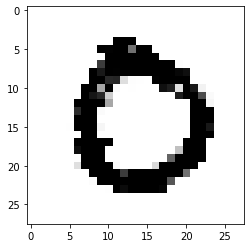

In [13]:
plt.imshow(X[0,:,:,0], cmap='gray_r')